Lane Following Problem
===========================

The dynamics model of an omnidirectional vehicle with no friction is defined by the following equation:

$$
\dot{p}^x(t) = (v_k + \dot{v}_k(t-T_s k))cos(\theta_k + \theta_k(t - T_sk))
$$
$$
\dot{p}^y(t) = (v_k + \dot{v}_k(t - T_s k))sin(\theta_k + \theta_k(t - T_s k))
$$

iLQR is applied to a vehicle in order to control them to follow a reference trajectory at a terminal velocity of $10 m/s$.

The state vector $\textbf{x}$ is defined as follows:
$$\begin{equation*}
\textbf{x} = \begin{bmatrix}
    p^x & p^y & v & \theta
    \end{bmatrix}^T
\end{equation*}$$

The action vector $\textbf{u}$ is defined as follows:
$$\begin{equation*}
\textbf{u} = \begin{bmatrix}
   \dot{v} & \delta
    \end{bmatrix}^T
\end{equation*}$$

**Note**: That since this dynamics model is nonlinear, this problem can be solved
more efficiently with a simple Linear Quadratic Regulator (LQR) instead. This
example is just used to demonstrate how to setup an auto-differentiated
dynamics model.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function
import sys
import os
sys.path.append(os.path.abspath('../'))
import random
import ilqr
import math
import copy

In [3]:
import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt

In [4]:
from ilqr import iLQR
from ilqr.cost import PathQRCost
from ilqr.examples.car import CarDynamics, CarCost

from bc import *
import pickle

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = xs[-1]
    final_control = us[-1]
    if iteration_count % 60 == 0:
        print("iteration", iteration_count, info, J_opt, final_state, final_control)


In [6]:
dt = 0.05
wheel_diameter = 1.0
dynamics = CarDynamics(dt, l=wheel_diameter)

An instantaneous cost function $l(\textbf{x}_t, \textbf{u}_t)$ is defined as follows:

$$
l(\textbf{x}_t, \textbf{u}_t) = \textbf{x}_t^T Q \textbf{x}_t + \textbf{u}_t^T R \textbf{u}_t
$$

where $Q$ is the state error and $R$ is the control error.

In order to approach the two vehicles to each other, $Q$ is set up to penalize differences in positions as $||\textbf{x}_0 - \textbf{x}_1||^2$ while penalizing non-zero velocities.

The following code generates the lane and boundaries. There are 150 way points along the reference trajectory. The boundary is +-3 vertically away from the reference trajecotry.S

[0.0, 0.067379469990854673, 10, 0.0067378450344227981]
[0.50167224080267558, 0.070845935446408034, 10, 0.0070844750194988719]
[1.0033444816053512, 0.074490739834520231, 10, 0.0074489362082204875]
[1.5050167224080266, 0.078323058142011001, 10, 0.0078321456624581981]
[2.0066889632107023, 0.082352537380411525, 10, 0.0082350675756158905]
[2.508361204013378, 0.086589320870176428, 10, 0.0086587156895327061]
[3.0100334448160533, 0.091044073774244075, 10, 0.0091041558344495087]
[3.511705685618729, 0.095728009945218767, 10, 0.0095725085981636787]
[4.0133779264214047, 0.10065292015375871, 10, 0.010064952130777753]
[4.5150501672240804, 0.10583120176922614, 10, 0.010582725091737525]
[5.0167224080267561, 0.11127588996731547, 10, 0.011127129746154518]
[5.5183946488294318, 0.11700069054321806, 10, 0.011699535217714871]
[6.0200668896321066, 0.12302001441292204, 10, 0.012301380905790726]
[6.5217391304347823, 0.1293490138894979, 10, 0.012934180074691099]
[7.023411371237458, 0.13600362082568626, 10, 0.01

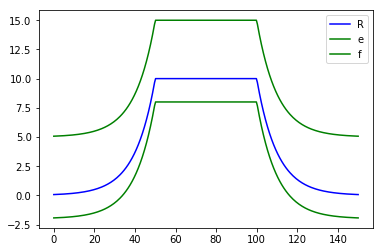

In [8]:
# piece-wise function to create the ref traj
UPPER_B = 5.0
LOWER_B = 2.0
def lane(posx):
    ts = [50, 100, 150]
    rate = 10.0
    height = 10.0
    if posx <= ts[0]:
        return height * np.exp((posx - ts[0])/rate), np.arctan(height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1] and posx <= ts[2]:
        return height * np.exp((ts[1] - posx)/rate), np.arctan(- height * np.exp((ts[1] - posx)/rate))

def nominal(posx):
    ts = [50, 100, 150]
    rate = 10.0
    height = 10.0
    if posx <= ts[0]:
        return height * np.exp((posx - ts[0])/rate), np.arctan(height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1]:
        return height * np.exp((ts[1] - posx)/rate), np.arctan(- height * np.exp((ts[1] - posx)/rate))

posx_path = np.linspace(0, 150, 300)
# create the waypoints
x_path = [[posx_path[i], lane(posx_path[i])[0], 10, lane(posx_path[i])[1]] for i in range(300)]
for arr in x_path:
    print(arr)

posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + UPPER_B, 'g')
_ = plt.plot(posx_, posy_ - LOWER_B, 'g')
_ = plt.legend("Reference Path")

# Instantenous state cost.
Q = np.eye(dynamics.state_size)
Q[3, 3] = 0.0


R = np.eye(dynamics.action_size)
R[0, 0] = 1.0
R[1, 1] = 1.0

barriers = np.array([0, 1, 0, 0]) 

q = np.zeros((dynamics.state_size, 1))
r = np.zeros((dynamics.action_size, 1)) 
A = np.array([[[0, 1, 0, 0]], [[0, -1, 0, 0]]])
b = np.array([[3.0], [3.0]])
q1 = [1., 1.]
q2 = [0.1, 0.1]
#A = np.array([[[0, 1, 0, 0]]])
#b = np.array([11])

Now use iLQR to solve this trajectory following problem. Safety constraint is added such that the vehicle stay within the boundaries. The vehicles are initialized at $(0, 0)$ with velocities $10$. The look ahead horizon is 30.

In [9]:
N = len(x_path) # total length of the waypoints
n = 30  # Number of time steps in trajectory.
J_hist = []
expert_traj = []

x0 = x_path[0]  # Initial state.
# Random initial action path.
# us_init = np.random.uniform(-1, 1, (n - 1, dynamics.action_size))
us_init = np.zeros((n - 1, dynamics.action_size))

for i in range(0, int(N - n) + 1):
    k = 3
    if i % k != 0:
        continue
        #pass
    x_path_ = copy.copy(x_path[i: i + n])
    cost = CarCost(Q = Q, q = q, R = R, r = r, A = A, b = b, q1 = q1, q2 = q2, x_path = x_path_, x_nominal = nominal)
    ilqr = iLQR(dynamics, cost, n - 1)
    xs, us = ilqr.fit(x0, us_init, on_iteration=on_iteration)

    x0 = xs[k][:]
    expert_traj = expert_traj + [[xs[i], us[i]] for i in range(k)]

iteration 0 accepted [ 0.03292936] [ 14.50766651   0.28096542  10.00794981   0.02042199] [-0.00055076 -0.00342138]
iteration 0 accepted [ 0.04187392] [ 16.01045392   0.32658729  10.00980158   0.02368335] [-0.00061807 -0.00401498]
iteration 0 accepted [ 0.05289182] [ 17.51329384   0.37960559  10.01158091   0.02759549] [-0.00068149 -0.00461854]
iteration 0 accepted [ 0.06642373] [ 19.0160863    0.44123061  10.0132869    0.03210293] [-0.00074111 -0.00534861]
iteration 0 accepted [ 0.08314541] [ 20.51871719   0.51285888  10.01493066   0.03731634] [-0.00079779 -0.00621575]
iteration 0 accepted [ 0.10405329] [ 22.02104258   0.5961104   10.0165301    0.04337091] [-0.00085269 -0.00722755]
iteration 0 accepted [ 0.1305735] [ 23.52287575   0.69286643  10.0181097    0.05040906] [-0.00090721 -0.00840332]
iteration 0 accepted [ 0.16471202] [ 25.02397219   0.80531071  10.01970252   0.05859064] [-0.00096313 -0.0097695 ]
iteration 0 accepted [ 0.20926775] [ 26.52400896   0.93597651  10.0213527    0.06

/home/gaoruihan/MPSC_Guided_Imitation_Learning/ilqr/ilqr/controller.py:168: UserWarning: exceeded max regularization term
  warnings.warn("exceeded max regularization term")


iteration 0 accepted [ 41.60801472] [ 48.89887614   9.54156201  10.30296851   0.55606149] [-0.01525329 -0.07419016]
iteration 0 accepted [ 51.69186245] [ 50.66959216   9.59989776  10.36312503   0.19619025] [-0.01900232  0.02953627]
iteration 0 accepted [ 60.67401492] [ 52.33892231   9.46510823  10.40397354   0.08722092] [-0.02094423  0.06822297]
iteration 0 accepted [ 68.13288196] [ 53.9777909    9.41893616  10.42376513   0.10117961] [-0.02121825  0.07592135]
iteration 0 accepted [ 74.01243989] [ 55.60043084   9.41872457  10.42049867   0.12284258] [-0.01977229  0.08105223]
iteration 0 accepted [ 78.41348392] [ 57.20309338   9.4279893   10.39652332   0.13393518] [-0.01688384  0.08755577]
iteration 0 accepted [ 82.1364416] [ 58.7777474    9.43334619  10.36067804   0.13896515] [-0.01319642  0.09404355]
iteration 0 accepted [ 86.52291446] [ 60.31607101   9.45324157  10.34231964   0.13479049] [-0.01102599  0.09315041]
iteration 0 accepted [ 85.47059265] [ 61.9067041    9.48487911  10.303074

The result can be visulized by executing the following code.

In [10]:
X = []
Y = []
posx = []
posy = []
v = []
theta = []

for i in expert_traj:
    posx.append(i[0][0])
    posy.append(i[0][1])
    v.append(i[0][2])
    theta.append(i[0][3])



posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]

#pickle.dump((X, Y), open('expert_traj.p', 'wb'))

The red curve in this plot is the trajecotry of the MPC vehicle. 

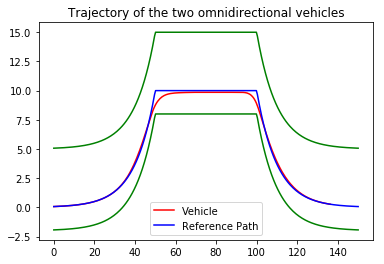

In [12]:

_ = plt.title("Trajectory of the two omnidirectional vehicles")
_ = plt.plot(posx, posy, "r")

_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + UPPER_B, 'g')
_ = plt.plot(posx_, posy_ - LOWER_B, 'g')
_ = plt.legend(["Vehicle", "Reference Path"])
plt.savefig('../../figures/MPC_model_52.png') # use relative path to save figure

In [13]:
def create_expert_traj_ref(N, H, x_path, dynamics, if_create=False,  expert_pts_file=None, src=None):
    """
    params: N length of x_path
    H: horizon or number of time steps in trajectory.
    if_create: create expert trajectories if True; otherwise, load from existing pickle file
    """
    expert_pts = []   

    if if_create:
        num_pts = 50000
        for pt in range(num_pts):
            x0 = [] # Initial state.
            # choose a random point around one waypoint as the starting point
            i = random.randint(0, len(x_path) - H - 1)
            x0 = [x_path[i][0], \
                  x_path[i][1] + 3.0 * (2 * random.random() - 1.0), \
                  x_path[i][2] + 1.0 * (2 * random.random() - 1.0), \
                  x_path[i][3] + 2.0 * (2 * random.random() - 1.0)]

            # Random initial action path.
            us_init = np.random.uniform(-1, 1, (H - 1, dynamics.action_size))
            #us_init = np.zeros((N, dynamics.action_size))
            print("Point %d" % pt)
            x_path_ = copy.copy(x_path[i: i + H])
            cost = CarCost(Q = Q, q = q, R = R, r = r, A = A, b = b, q1 = q1, q2 = q2, \
                           x_path = x_path_, x_nominal = nominal)
            ilqr = iLQR(dynamics, cost, H - 1)
            xs, us = ilqr.fit(x0, us_init, on_iteration=on_iteration)

            x = [x0] + x_path_[0:H]
            u = us[0]
            expert_pts = expert_pts + [[x, us[0]]]

        print("shape of expert_pts", expert_pts.shape)

        print("State Template: \n{}".format(expert_pts[0][0]))
        print("Number of State Variables: {}".format(len(expert_pts[0][0])))
        print("Number of States: {}".format(len(expert_pts)))


        X = []
        Y = []
        n = 30 # 20

        for i in range(len(expert_pts)): # i iterates over traj in collected expert_traj
            X.append([])
            for j in range(0, n + 1): # j iterates over pts within one traj (of horizon 30)
                for k in expert_pts[i][0][j]:
                    X[-1].append(k) # continuously append the four states
                    # Note: concatenate the states in future H steps to the current state and treat them as one featurepoint
                    # TODO: can try to concatenate boundary points in future H steps, which is more realistic in real-life scenarios, e.g. road lanes in auto-driving
            Y.append(expert_pts[i][1])
        
        # print the examples for checking
        print("State Template: \n{}".format(X[0]))
        print("Number of State Variables: {}".format(len(X[0])))
        print("Number of States: {}".format(len(X)))

        print("Control Template: \n{}".format(Y[0]))
        print("Number of Controls: {}".format(len(Y)))
        print("First Way Point: {}".format(x_path[0]))
    
        # save into pickle file
        expert_pts_file = 'expert_traj/expert_pts_' + str(pt) + '_H' + str(H) + '.p'
        print("filename", expert_pts_file)
        
        fdump = open(expert_pts_file, 'wb') 
        pickle.dump((X, Y), fdump)
        fdump.close()
#         # change the filename based on the total number of points
#         dst = src.replace('xxx', str(pt))
#         print("filename for dumping", dst)
#         os.rename(src, dst)

    else:
        # RH: load the previous expert_pts
        expert_pts_file = 'expert_traj/expert_pts_10058_H' + str(H) + '.p'
        fload = open(expert_pts_file, 'rb')
    #     data_process(paths=['expert_traj/expert_pts_15547_H'+ str(H) + '.p']):
        expert_pts, actions = pickle.load(fload) # automatically load the latest one
        print("expert_pts", len(expert_pts), "actions", len(actions))

        print("State Template: \n{}".format(expert_pts[0]))
        print("Number of States: {}".format(len(expert_pts[0])))

        print("Control Template: \n{}".format(actions[0]))
        print("Number of Controls: {}".format(len(actions)))

In [17]:
def create_expert_traj_boundary(N, H, x_path, dynamics, if_create=True, expert_pts_file=None, src=None):
    """
    params: N length of x_path
    H: horizon or number of time steps in trajectory.
    if_create: create expert trajectories if True; otherwise, load from existing pickle file
    """
    expert_pts = []

    if if_create:
        num_pts = 50000
        for pt in range(num_pts):
            x0 = [] # Initial state.
            # choose a random point around one waypoint as the starting point
            i = random.randint(0, len(x_path) - H - 1)
            x0 = [x_path[i][0], \
                  x_path[i][1] + 3.0 * (2 * random.random() - 1.0), \
                  x_path[i][2] + 1.0 * (2 * random.random() - 1.0), \
                  x_path[i][3] + 2.0 * (2 * random.random() - 1.0)]

            # Random initial action path.
            us_init = np.random.uniform(-1, 1, (H - 1, dynamics.action_size))
            #us_init = np.zeros((N, dynamics.action_size))
            print("Point %d" % pt)
            x_path_ = x_path[i: i + H]
            cost = CarCost(Q = Q, q = q, R = R, r = r, A = A, b = b, q1 = q1, q2 = q2, \
                           x_path = x_path_, x_nominal = nominal)
            ilqr = iLQR(dynamics, cost, H - 1)
            xs, us = ilqr.fit(x0, us_init, on_iteration=on_iteration)
#             print("x_path_", len(x_path_))
            upper_boundary = [[x[0], x[1]+3.0, x[2], x[3]] for x in x_path_][0:H]
            lower_boundary = [[x[0], x[1]-3.0, x[2], x[3]] for x in x_path_][0:H]
#             print("upper")
#             print(upper_boundary)
#             print("lower")
#             print(lower_boundary)
            # x = [x0] + x_path_[0:H]  # learn ref traj
            x = [x0] + upper_boundary + lower_boundary  # learn boundary
#             print("x", len(x))
#             print(x)
            u = us[0]
            expert_pts = expert_pts + [[x, us[0]]]
            
#             break # short implementation for checking

        print("shape of expert_pts", len(expert_pts))

        print("State Template: \n{}".format(expert_pts[0]))
        print("Number of State Variables: {}".format(len(expert_pts[0])))
        print("Number of States: {}".format(len(expert_pts)))


        X = []
        Y = []
        n = 30 # 20

        for i in range(len(expert_pts)): # i iterates over traj in collected expert_traj
            X.append([])
            for j in range(0, n + 1): # j iterates over pts within one traj (of horizon 30)
                for k in expert_pts[i][0][j]:
                    X[-1].append(k) # continuously append the four states
                    # Note: concatenate the states in future H steps to the current state and treat them as one featurepoint
                    # TODO: can try to concatenate boundary points in future H steps, which is more realistic in real-life scenarios, e.g. road lanes in auto-driving
            Y.append(expert_pts[i][1])
        
        # print the examples for checking
        print("State Template: \n{}".format(X[0]))
        print("Number of State Variables: {}".format(len(X[0])))
        print("Number of States: {}".format(len(X)))

        print("Control Template: \n{}".format(Y[0]))
        print("Number of Controls: {}".format(len(Y)))
        print("First Way Point: {}".format(x_path[0]))
        
        # save into pickle file
        expert_pts_file = 'expert_traj/expert_pts_boundary_52' + str(pt) + '_H' + str(H) + '.p'
        print("filename", expert_pts_file)
        
        fdump = open(expert_pts_file, 'wb') 
        pickle.dump((X, Y), fdump)
        fdump.close()
#         # change the filename based on the total number of points
#         dst = src.replace('xxx', str(pt))
#         print("filename for dumping", dst)
#         os.rename(src, dst)

    else:
        if expert_pts_file is None:
            raise ValueError("path to pre-trained model is required")
        # RH: load the previous expert_pts
        fload = open(expert_pts_file, 'rb')
    #     data_process(paths=['expert_traj/expert_pts_15547_H'+ str(H) + '.p']):
        expert_pts, actions = pickle.load(fload) # automatically load the latest one
        print("expert_pts", len(expert_pts), "actions", len(actions))

        print("State Template: \n{}".format(expert_pts[0]))
        print("Number of States: {}".format(len(expert_pts[0])))

        print("Control Template: \n{}".format(actions[0]))
        print("Number of Controls: {}".format(len(actions)))
        
# see if need to return anything, for now just need to get a consistent filename for the training

In [18]:
J_hist = []
# create_expert_traj_ref(len(x_path), 30, x_path, dynamics, if_create=False)
# collect points
create_expert_traj_boundary(len(x_path), 30, x_path, dynamics, if_create=True)
# use collected points
# create_expert_traj_boundary(len(x_path), 30, x_path, dynamics, if_create=False, expert_pts_file='expert_traj/expert_pts_boundary_49999_H30.p')

Point 0
iteration 0 accepted [ 4046.09153008] [ 94.8116498    9.84583739   9.18856768  -2.7381331 ] [ 0.04961401  1.14409619]
Point 1
iteration 0 accepted [ 4364.93244441] [ 11.70258225   6.65882147   9.32331204  -4.86084372] [ 0.05775463  1.22419095]
Point 2
iteration 0 accepted [ 2679.90655452] [ 42.82385734   6.94511428   9.77301005  -1.27074919] [ 0.01924911  0.79379693]
Point 3
iteration 0 accepted [ 563.69078747] [ 44.7878864    1.04844446   9.76503482   1.16267812] [ 0.01670269  0.01049049]
Point 4
iteration 0 accepted [ 2064.4465267] [ 21.12002632  -0.25675795   9.64075789   1.16121398] [ 0.02600321 -0.84347414]
Point 5
iteration 0 accepted [ 3090.11550196] [  8.24640429e+01   1.24262137e+01   9.33502976e+00  -8.29315345e-03] [ 0.05367999 -0.6428503 ]
Point 6
iteration 0 accepted [ 326.01672141] [  1.19919929e+02   2.44339828e+00   9.82683999e+00   3.78268678e-02] [ 0.00309236 -0.10935746]
Point 7
iteration 0 accepted [ 369.63677516] [ 39.54735385   2.33357652   9.5519471    0.

Point 64
iteration 0 accepted [ 2824.32330264] [ 104.23755932   -1.04742945    8.92219357    0.46006317] [ 0.05760968 -0.52366812]
Point 65
iteration 0 accepted [ 1515.5780847] [ 62.86381197   9.29430863  10.19819928  -2.51442918] [ 0.01958843  0.43768106]
Point 66
iteration 0 accepted [ 54.96824962] [ 68.56160182   9.85192621  10.1166096   -0.2130849 ] [  1.34784346e-04  -1.88731143e-01]
Point 67
iteration 0 accepted [ 3389.59699623] [ 112.63532147    0.16197091    8.28578892   -3.40668903] [ 0.09439045  0.09935605]
iteration 60 accepted [ 299.5581604] [  1.25824083e+02   5.29329980e-01   9.90528018e+00   2.61689910e-02] [  7.99087516e-03  -2.21310501e-09]
Point 68
iteration 0 accepted [ 4564.48277292] [ 101.11564722   16.30903221    8.7661863    -4.36470081] [ 0.03698836  0.6781744 ]
Point 69
iteration 0 accepted [ 698.12046596] [ 28.41808109  -6.13916198  10.09249214  -1.81793139] [ 0.01310172  0.57684932]
Point 70
iteration 0 accepted [ 2877.41560351] [ 97.00605359   9.25803272   8

Point 127
iteration 0 accepted [ 82.35823317] [ 115.76547431    1.80674741   10.42358845   -0.28638307] [-0.01019996  0.01755228]
Point 128
iteration 0 accepted [ 888.16693351] [ 28.58789715  -6.38048103   9.5880424   -1.01612861] [ 0.02902822  0.59844096]
Point 129
iteration 0 accepted [ 78.28838143] [  1.35197080e+02  -6.82521680e-01   9.60949332e+00   4.23476743e-02] [ 0.0095257   0.17520744]
Point 130
iteration 0 accepted [ 3523.6378713] [ 20.82158391  -0.44615054   9.28078848   1.97214476] [ 0.02431714 -0.82893508]
Point 131
iteration 0 accepted [ 3346.7592707] [ 8.60648114  1.76794573  9.50668424  1.72732731] [ 0.0471432  -0.98849378]
Point 132
iteration 0 accepted [ 2407.82058746] [ 122.44420552    3.66569665    9.42119052    5.54540851] [ 0.02374423 -1.46183611]
Point 133
iteration 0 accepted [ 3012.47228314] [ 16.35727932   1.45855241   8.86731981   5.3502392 ] [ 0.03885556 -0.414036  ]
Point 134
iteration 0 accepted [ 49.97263217] [ 42.75902107   5.1317387   10.08376114   0.3

Point 190
iteration 0 accepted [ 2741.66873141] [ 31.78889924   5.62286683   9.38384257   4.69964858] [ 0.04840394 -0.87629731]
Point 191
iteration 0 accepted [ 63.73071353] [ 75.93158162   9.90391459  10.27840019   0.08139475] [ 0.00211953  0.05184384]
Point 192
iteration 0 accepted [ 63.92048231] [ 21.90283278   0.59499429  10.14208203   0.33893763] [-0.00154851 -0.09511617]
Point 193
iteration 0 accepted [ 148.16063845] [  1.46597789e+02   5.15865675e-01   1.02925108e+01  -1.40546539e-01] [-0.00345107 -0.09297436]
Point 194
iteration 0 accepted [ 238.41142432] [  6.03754345e+01   6.60393171e+00   9.89606519e+00   1.78953234e-02] [ 0.00767814  0.09313306]
Point 195
iteration 0 accepted [ 1631.11505835] [ 134.99871841    3.97140674    8.94134352    2.45829476] [ 0.06670079 -0.02123346]
Point 196
iteration 0 accepted [ 4113.5789024] [ 83.52325709  18.18368035   9.72947177  -0.86571768] [ 0.02314688  0.44667547]
Point 197
iteration 0 accepted [ 120.98079979] [  6.38577499e+01   8.195432

Point 254
iteration 0 accepted [ 370.38446523] [ 51.15276102  11.33626911   9.84592654   0.65675197] [ 0.00506716 -0.09702165]
Point 255
iteration 0 accepted [ 3218.90295081] [ 3.61617751  4.00049202  9.55423128  2.43109029] [ 0.05041617 -0.92962472]
Point 256
iteration 0 accepted [ 56.05388491] [ 15.75603199   0.03954423  10.06593717   0.15006539] [ 0.00221251  0.01020482]
Point 257
iteration 0 accepted [ 2891.29629931] [ 10.00094091   0.24262416   9.63490427  -4.88511017] [ 0.01814694  1.527047  ]
Point 258
iteration 0 accepted [ 117.64226638] [ 78.02084776  10.521261    10.24085409  -0.5141656 ] [ 0.00406102 -0.24936044]
Point 259
iteration 0 accepted [ 3969.77300952] [ 59.76416188  14.44269877   9.40020775  -6.04884572] [ 0.03151073  1.57116999]
Point 260
iteration 0 accepted [ 1852.55469777] [ 55.65765962   9.02296867  10.07979505  -2.92900035] [ 0.07710957  0.95458207]
Point 261
iteration 0 accepted [ 808.63436621] [ 62.94596412  11.67235206   9.996575     0.42845482] [ 0.0008606

Point 317
iteration 0 accepted [ 163.39920106] [ 51.56535405   8.74069442  10.55063904   0.7237703 ] [-0.01716867 -0.19073445]
Point 318
iteration 0 accepted [ 26.24924608] [ 25.59700708   0.77914632  10.41033396   0.1567346 ] [-0.00712713 -0.00554897]
Point 319
iteration 0 accepted [ 24.52231916] [  1.48581772e+02   2.59758323e-02   9.64488230e+00  -1.31745438e-01] [ 0.00591207 -0.06883522]
Point 320
iteration 0 accepted [ 4341.31869804] [ 126.1269426    -5.22069204    9.80496854    2.45242438] [ 0.01234403 -1.16804801]
Point 321
iteration 0 accepted [ 4054.91767905] [ 104.38985299    3.88672946   10.01988803   -6.77288718] [ 0.01945637  0.5428326 ]
Point 322
iteration 0 accepted [ 51.65284796] [ 31.16849903   1.67530138  10.32159325  -0.22091769] [-0.01015669 -0.30381763]
Point 323
iteration 0 accepted [ 313.85401372] [ 21.09699771  -3.47629015   9.59765899  -0.07538738] [ 0.02765448  0.27435557]
Point 324
iteration 0 accepted [ 86.53485735] [ 108.72445722    4.20544218   10.1602011 

Point 380
iteration 0 accepted [ 179.06344487] [ 126.71031384    0.15377582    9.93562109   -0.14509715] [-0.0058219   0.04951869]
Point 381
iteration 0 accepted [ 5510.4228583] [ 93.87324641  16.07161708   9.61694018   6.99114175] [ 0.04007111 -0.97430337]
Point 382
iteration 0 accepted [ 1809.24215365] [ 43.70007229   9.71129366   9.36531357  -2.68550566] [ 0.02313322  1.11658467]
Point 383
iteration 0 accepted [ 1156.9137156] [ 125.56116572    3.61140534    9.40553835   -1.67163063] [ 0.04518924  0.7057516 ]
Point 384
iteration 0 accepted [ 1104.75370558] [ 126.49780585    8.30923839    9.80915066    0.24955378] [ 0.01605722 -0.68640557]
Point 385
iteration 0 accepted [ 337.87985924] [  1.99394093e+01  -3.16523405e+00   9.70562538e+00  -4.87795165e-03] [ 0.03628032  0.29203328]
Point 386
iteration 0 accepted [ 602.14592711] [ 33.4562871   -0.79392358   9.66357054  -1.93248161] [ 0.02912605  0.65028962]
Point 387
iteration 0 accepted [ 217.18448397] [ 61.18907583   8.41527147  10.034

Point 443
iteration 0 accepted [ 625.82022656] [ 127.02019931   -7.21720587   10.07525141   -1.52458394] [ 0.01291457  0.99684431]
Point 444
iteration 0 accepted [ 1001.06854087] [ 108.35873483   12.21273231    9.70427382    0.51213172] [ 0.09773187 -0.6424724 ]
Point 445
iteration 0 accepted [ 49.76866796] [  1.48565594e+02  -7.33022575e-03   1.03104852e+01  -1.18151578e-01] [-0.00334019 -0.01007762]
Point 446
iteration 0 accepted [ 1368.69411294] [ 51.98824567  13.55620732   9.60491388   3.96467627] [ 0.01175054 -0.73787696]
Point 447
iteration 0 accepted [ 209.0884676] [ 34.42208603   6.84216009   9.8460136    0.59088388] [ 0.01716175 -0.52169787]
Point 448
iteration 0 accepted [ 321.2829265] [  7.46913040e+01   1.00050728e+01   1.02055225e+01  -4.65857673e-03] [ 0.00822757 -0.04134146]
Point 449
iteration 0 accepted [ 673.72448493] [ 38.57572106   0.45029332   9.67759347   2.13029487] [ 0.01927633 -0.38447521]
Point 450
iteration 0 accepted [ 125.72596896] [ 66.11537282  10.0633668

Point 505
iteration 0 accepted [ 3643.44758938] [ 57.46059339   3.18709241   9.20091453  -6.35668044] [ 0.02802955  0.31754687]
Point 506
iteration 0 accepted [ 167.65597773] [ 101.42266041    4.33644839    9.9563389    -0.67815602] [ 0.02318631  0.44996744]
Point 507
iteration 0 accepted [ 117.40155623] [  1.40720130e+02  -2.62303110e-02   9.67533486e+00  -4.70052421e-02] [ 0.0134773   0.13681878]
Point 508
iteration 0 accepted [ 3886.05652904] [ 55.91178113  15.7025254    8.91930735  -4.78653322] [ 0.08185378  1.32056461]
Point 509
iteration 0 accepted [ 2758.06760105] [ 98.94498471  13.38395477   9.15950511   3.54250201] [ 0.05323636 -1.29413532]
Point 510
iteration 0 accepted [ 3470.2953455] [ 37.18573883   9.97518888   9.28371701   0.7198277 ] [ 0.03659573  0.31518599]
Point 511
iteration 0 accepted [ 236.63102421] [ 93.96491506  10.52398777   9.68147781  -0.31655848] [ 0.02162727  0.02215083]
Point 512
iteration 0 accepted [ 974.89645667] [ 85.34907712   5.79010244   9.44546618  

Point 568
iteration 0 accepted [ 163.81327945] [ 53.3386295   10.53579015  10.03013547   0.08998862] [ 0.00912794 -0.06572385]
Point 569
iteration 0 accepted [ 5963.60679012] [ 35.54536769  -7.79088082   9.74109585  -4.05000937] [ 0.02339862  0.19734927]
Point 570
iteration 0 accepted [ 873.37935341] [ 27.46921848   9.00382565   9.6077799    2.32829683] [ 0.00816816 -0.803125  ]
Point 571
iteration 0 accepted [ 1910.69036151] [ 130.79317708    4.79515789    8.6663859     2.5462099 ] [ 0.03908243 -0.52777458]
Point 572
iteration 0 accepted [ 1812.19683789] [ 25.76461466   3.14716345   8.64401244  -4.66575198] [ 0.0554717   0.74771033]
Point 573
iteration 0 accepted [ 1502.32687242] [ 34.64845544   8.66318129   9.61864315   0.94345121] [ 0.03720546 -0.25590519]
Point 574
iteration 0 accepted [ 1438.68120238] [ 130.98071014    0.33360809    9.86566179   -5.4755558 ] [ 0.02931714  0.25914751]
Point 575
iteration 0 accepted [ 218.70487286] [  1.41235065e+02  -3.38111637e+00   9.43086580e+00

Point 631
iteration 0 accepted [ 2462.07742762] [ 95.6236675    2.9595247   10.19659529  -3.30925646] [ 0.08372392  0.86170052]
Point 632
iteration 0 accepted [ 3738.52041309] [ 113.54360381   -3.8336816    10.15592074    2.56223689] [ 0.01492755 -0.28685726]
Point 633
iteration 0 accepted [ 3045.99800845] [ 45.01847544   9.62748872   8.19019256   1.71957219] [ 0.07753796  0.36932499]
Point 634
iteration 0 accepted [ 129.84064169] [ 23.03072074   0.96422741   9.91935986   0.27042717] [ 0.00037648 -0.03923629]
Point 635
iteration 0 accepted [ 9.76762291] [  2.76948533e+01   1.07453442e+00   1.02341238e+01  -1.68397375e-02] [-0.00628907 -0.01056596]
Point 636
iteration 0 accepted [ 1369.10622622] [ 18.52129905  -0.21797892  10.07568016  -0.36490423] [ 0.01135846  0.05510436]
Point 637
iteration 0 accepted [ 549.18829253] [ 76.24314487   6.68450213   9.32280866  -0.31048056] [ 0.03003472  0.07466956]
Point 638
iteration 0 accepted [ 184.99489455] [ 114.91522869    4.21168795   10.35451465

Point 694
iteration 0 accepted [ 104.79621466] [ 96.1047482   10.37578887   9.58567907  -0.10275629] [ 0.01598832  0.0108112 ]
Point 695
iteration 0 accepted [ 383.83631501] [ 80.28982998   6.01457468   9.63515828   0.24355631] [ 0.03210338  0.15292927]
Point 696
iteration 0 accepted [ 302.933291] [ 104.60002925    6.89423795    9.82583391   -0.21390531] [ 0.00675632 -0.14709555]
Point 697
iteration 0 accepted [ 5056.71517612] [ 81.72762098   3.19221388   9.19209178   3.49046815] [ 0.07304247 -0.90445496]
Point 698
iteration 0 accepted [ 438.2864826] [  1.27697377e+02  -3.62470050e+00   9.91668710e+00  -7.26516722e-02] [ 0.01654873  0.24905925]
Point 699
iteration 0 accepted [ 2911.01133278] [ 50.27186023  13.44771693   8.85063441  -3.78052228] [ 0.06955198  0.799703  ]
Point 700
iteration 0 accepted [ 5239.84843832] [ 124.3207907    -1.89373973    9.2433284    -3.23356654] [ 0.03693774  0.0628265 ]
Point 701
iteration 0 accepted [ 231.20658515] [ 84.08348471   7.65387615   9.33153843 

Point 756
iteration 0 accepted [ 228.19432091] [ 77.17119446   9.67844071   9.90385757   0.13538709] [ 0.01189045 -0.02801034]
Point 757
iteration 0 accepted [ 56.17504354] [ 28.80596248  -0.3238403    9.91376026   0.54743098] [ 0.01172454  0.22728008]
Point 758
iteration 0 accepted [ 4301.3284814] [ 108.89706855    3.39269622    8.56822798   -3.31439936] [ 0.04926537 -0.26026607]
Point 759
iteration 0 accepted [ 81.66895598] [ 142.0926877     0.90031842   10.14505612   -0.22734846] [ 0.0059605  -0.16887773]
Point 760
iteration 0 accepted [ 58.136883] [ 25.05237822   0.82517355  10.37879791   0.30193291] [-0.01057192 -0.09282738]
Point 761
iteration 0 accepted [ 515.32627209] [  1.11965020e+02   5.06941491e+00   9.80355094e+00  -7.67020758e-02] [ 0.00547371 -0.12862897]
Point 762
iteration 0 accepted [ 4637.54507948] [ 46.18121484   1.94321101   9.63345608   7.38048726] [ 0.01944656 -1.00605766]
Point 763
iteration 0 accepted [ 4274.10543278] [ 99.41668309  16.35765141   8.95219161  -3

Point 819
iteration 0 accepted [ 149.73530812] [ 24.13307358   2.59921675   9.67268203   0.74547492] [ 0.01581839 -0.23273498]
Point 820
iteration 0 accepted [ 7454.61048363] [ 103.34367737    8.3914604     9.7490581    -6.06683853] [ 0.01822326  0.53041569]
Point 821
iteration 0 accepted [ 6001.02438664] [ 108.94436835   -2.87342453    9.32842695   -1.44232118] [ 0.04184571 -0.20455781]
Point 822
iteration 0 accepted [ 83.24447959] [ 19.63524851   1.12169701  10.28674203  -0.29787961] [ 0.00199656 -0.12732743]
Point 823
iteration 0 accepted [ 1817.65989084] [ 44.05804672  -2.71099166  10.46730097   0.70961994] [ 0.07720986  0.18158886]
Point 824
iteration 0 accepted [ 150.54723759] [ 119.24468574    0.3044992    10.40092634    0.14462257] [-0.00243173  0.1249018 ]
Point 825
iteration 0 accepted [ 77.4077956] [ 75.81791167  10.40361187   9.96955653  -0.08457041] [ 0.00441949 -0.20927787]
Point 826
iteration 0 accepted [ 133.15629597] [ 118.9209968     3.30325176    9.55996252   -0.1754

Point 883
iteration 0 accepted [ 137.34352993] [ 20.03925045   3.03496475   9.44394281  -0.0709998 ] [ 0.01310467 -0.24905324]
Point 884
iteration 0 accepted [ 510.5176386] [  1.31643186e+02   5.76008154e+00   9.14527149e+00  -5.05366055e-02] [ 0.04706421 -0.15793914]
Point 885
iteration 0 accepted [ 137.82285082] [ 49.25467623   9.42017307   9.87625715   0.19501983] [ 0.00222468  0.02880269]
Point 886
iteration 0 accepted [ 430.55815452] [ 119.99836077   -0.12897876    9.92575746   -1.07025633] [-0.00099946  0.20930966]
Point 887
iteration 0 accepted [ 1393.82969898] [ 113.95497821   -3.0881856     9.79915678    1.4827501 ] [ 0.04821385 -0.25796836]
Point 888
iteration 0 accepted [ 118.26052958] [  7.59279321e+01   1.02683053e+01   9.78952264e+00   4.30816216e-02] [ 0.00220108  0.03119942]
Point 889
iteration 0 accepted [ 1567.24039911] [ 102.25664088   16.25134007    9.76173093    1.4514309 ] [ 0.02423277 -0.64173232]
Point 890
iteration 0 accepted [ 452.63249524] [ 94.27571924  12.8

Point 945
iteration 0 accepted [ 1925.46124964] [ 85.60014691  15.29055363   9.03450852   2.5004077 ] [ 0.03400005 -0.01956366]
Point 946
iteration 0 accepted [ 538.7747631] [ 129.3129203     7.41800069    9.60192149    0.48797877] [ 0.02378703 -0.21280289]
Point 947
iteration 0 accepted [ 3661.78043929] [ 58.33699861  10.49719856   8.30348055  -1.8830949 ] [ 0.04311327  0.60634397]
Point 948
iteration 0 accepted [ 2674.74720384] [ 35.12670852  -4.25887609   9.49324542  -2.3334444 ] [ 0.02107651  1.01272361]
Point 949
iteration 0 accepted [ 97.38540151] [ 127.84574943   -1.18389146   10.07860255   -0.26358334] [ 0.00353712  0.24946543]
Point 950
iteration 0 accepted [ 31.08111134] [  3.44433524e+01   2.09470954e+00   1.04522792e+01  -3.21882034e-02] [-0.01475872 -0.04056263]
Point 951
iteration 0 accepted [ 3957.66533131] [ 22.45903707   6.19529798   9.87234078  -3.28236852] [ 0.01875875  1.03169818]
Point 952
iteration 0 accepted [ 625.34839756] [ 106.81631473    1.87761006   10.29790

Point 1008
iteration 0 accepted [ 4078.89003395] [ 99.20650105  12.09163894   9.15584098   3.80514787] [ 0.0523782  -0.13309736]
Point 1009
iteration 0 accepted [ 142.91869997] [ 103.07031063    4.05282138    9.55419432   -0.99354133] [ 0.00939804  0.26722616]
Point 1010
iteration 0 accepted [ 77.09931565] [ 134.96765009    0.18465843    9.72985417    0.1462984 ] [ 0.0019731   0.03508459]
Point 1011
iteration 0 accepted [ 606.75258283] [ 34.33796634  -2.23610757  10.32906734   0.857902  ] [ 0.05917558 -0.08463073]
Point 1012
iteration 0 accepted [ 1553.19844985] [ 35.644251     9.59816235  10.33042624   2.35426325] [ 0.01453565 -0.56969889]
Point 1013
iteration 0 accepted [ 4704.77701748] [ 3.65858128 -4.5586565   8.83128087  2.83589012] [ 0.05446164 -0.53592988]
Point 1014
iteration 0 accepted [ 5504.72842827] [ 82.72112091  16.04155411   9.15996645   1.53561027] [ 0.02627436  0.25052275]
Point 1015
iteration 0 accepted [ 3373.40687895] [ 129.89681562   -3.84240245    9.76595489    4.

Point 1069
iteration 0 accepted [ 3035.75266634] [ 134.07553223    5.25840168    8.40329926    1.8423799 ] [ 0.04419067 -0.88960772]
iteration 60 accepted [ 211.49986703] [  1.43795589e+02   8.98469885e-02   9.81174073e+00   5.83681652e-03] [  1.27767673e-02   8.72869856e-10]
Point 1070
iteration 0 accepted [ 88.98276997] [ 39.6654485    1.60500773  10.05486333   0.25331095] [ 0.00757803  0.11305506]
Point 1071
iteration 0 accepted [ 134.17601681] [ 44.89928796   6.83947212  10.1168894    0.38366853] [-0.01591686 -0.00229908]
Point 1072
iteration 0 accepted [ 597.69383907] [ 104.40952944   10.89943163    9.51069507   -0.3688488 ] [ 0.0845388  -0.42203625]
Point 1073
iteration 0 accepted [ 3389.71176437] [ 97.73900811  11.6903566    9.79932995   0.72863757] [ 0.02538324  0.32679649]
Point 1074
iteration 0 accepted [ 64.61679756] [ 55.99015888   9.27832522  10.27366233   0.53430623] [-0.00052252  0.32130399]
Point 1075
iteration 0 accepted [ 3138.90769829] [ 13.24249472  -1.14749234   9.

Point 1132
iteration 0 accepted [ 129.07942295] [  9.52236055e+01   9.76565210e+00   1.05301864e+01   3.81401669e-02] [-0.01966692  0.01009545]
Point 1133
iteration 0 accepted [ 30.86522863] [ 136.4516051     0.62018926    9.58737212   -0.15373174] [ 0.01274923  0.01179535]
Point 1134
iteration 0 accepted [ 105.32681314] [ 42.00810421   6.70580107   9.78169856   0.47799111] [ 0.00922741 -0.05618827]
Point 1135
iteration 0 accepted [ 1523.37424792] [ 80.85057917   9.77169436   9.09554948  -4.63936244] [ 0.0641687   0.27475581]
Point 1136
iteration 0 accepted [ 1708.79710075] [ 69.17313486   7.31601349   9.18739545   4.56047458] [ 0.03052794 -1.13140903]
Point 1137
iteration 0 accepted [ 563.58782324] [ 54.21406583  11.13213991   9.72551704   0.3549136 ] [ 0.00937051 -0.11447258]
Point 1138
iteration 0 accepted [ 684.07278137] [ 73.57841809  12.2233786    9.28943955  -0.50448445] [ 0.02411458 -0.64262852]
Point 1139
iteration 0 accepted [ 34.89741989] [ 33.6669768    1.83782922  10.47334

Point 1195
iteration 0 accepted [ 3251.75147818] [ 92.55284294  14.93364501   9.15613519   4.30594744] [ 0.07052953 -0.8261841 ]
Point 1196
iteration 0 accepted [ 633.12980343] [  5.55438476e+01   6.16343600e+00   9.56267875e+00  -9.53217818e-03] [-0.18252987 -0.22951802]
Point 1197
iteration 0 accepted [ 451.86719587] [ 68.1632245   12.87626634  10.11098173  -0.87273659] [ 0.01152345  0.03508495]
Point 1198
iteration 0 accepted [ 63.2846893] [  6.55189373e+01   9.46122722e+00   9.81671108e+00   6.37123866e-03] [ 0.00232764  0.12158255]
Point 1199
iteration 0 accepted [ 430.20514219] [ 73.26876252   3.64305245   9.67774416  -0.51229577] [-0.06142885  0.69944714]
Point 1200
iteration 0 accepted [ 155.37632819] [  7.67197531e+01   1.17135710e+01   9.67117109e+00   4.32361206e-02] [ 0.01097646 -0.23983449]
Point 1201
iteration 0 accepted [ 2714.89400353] [ 5.45089505  2.89932948  9.04630136  2.95464301] [ 0.05414986 -0.00015083]
Point 1202
iteration 0 accepted [ 39.72090199] [ 16.51781731

Point 1258
iteration 0 accepted [ 1647.06977179] [ 51.26709      4.62380765   9.25896426  -4.33313746] [ 0.04292272  0.94953141]
Point 1259
iteration 0 accepted [ 3869.43834863] [ 31.23361669  -6.47814823   8.85150187  -0.42784897] [ 0.04621251  1.01241322]
Point 1260
iteration 0 accepted [ 620.60169062] [ 43.29916543   9.21624646  10.22041381   0.80799391] [ 0.00585187 -0.15964449]
Point 1261
iteration 0 accepted [ 322.6158983] [ 61.34562955   9.25615181   9.87594822   1.19637227] [ 0.00271031  0.07879182]
Point 1262
iteration 0 accepted [ 1403.46028806] [ 24.54870209   6.42258677   9.20206989   1.59142938] [ 0.07407124 -0.7946863 ]
Point 1263
iteration 0 accepted [ 5216.94505314] [ 102.49192027    7.21234109    8.70027304   -7.10397586] [ 0.05264015  0.5746764 ]
Point 1264
iteration 0 accepted [ 2099.93029807] [ 34.81048834  -4.0940693    8.7315153   -3.22054606] [ 0.04330255  0.09393175]
Point 1265
iteration 0 accepted [ 2084.04970823] [ 50.39558426  11.72880309   8.42228546   1.769

Point 1321
iteration 0 accepted [ 4521.40072936] [ 50.74791176   6.87226532   9.57960894  -2.94791764] [ 0.02141982  1.28065276]
Point 1322
iteration 0 accepted [ 4151.02050165] [ 23.2898811   -0.59068136   9.00691063  -3.78012743] [ 0.0452259   1.40075411]
Point 1323
iteration 0 accepted [ 2926.29734983] [ 104.25843599    7.81511429    9.41567129    0.23114878] [ 0.02840329 -0.04606273]
Point 1324
iteration 0 accepted [ 46.68128675] [  1.47657656e+01  -9.95463052e-03   9.57327245e+00   3.52109835e-01] [ 0.00410115  0.01456748]
Point 1325
iteration 0 accepted [ 183.99145872] [ 54.07311893  10.10387448  10.38226174   0.10706877] [-0.00901797 -0.13992863]
Point 1326
iteration 0 accepted [ 2681.02977083] [ 123.5114433    -1.31562069   10.68372532   -0.92920262] [-0.14314375  0.30754705]
Point 1327
iteration 0 accepted [ 1391.00784127] [ 73.83853443   6.03794997   9.17617581   2.7339044 ] [ 0.06829566 -0.39501008]
Point 1328
iteration 0 accepted [ 3011.48474332] [ 118.79904118   -2.8798631

Point 1384
iteration 0 accepted [ 860.63754905] [ 28.26495325   9.31478893   9.486302     2.11866312] [ 0.03611873 -0.59773234]
Point 1385
iteration 0 accepted [ 2601.08304677] [  0.48250665   5.9203202   10.2202133    9.48373167] [ 0.01201993 -0.75699767]
Point 1386
iteration 0 accepted [ 3635.68487978] [ 97.47952579  16.35847746   8.88348788   0.90015234] [ 0.07431181  0.23164167]
Point 1387
iteration 0 accepted [ 1177.33295114] [ 51.92625408  13.59632597   9.77331157  -0.08553105] [ 0.01422135 -0.03388025]
Point 1388
iteration 0 accepted [ 443.90492061] [ 10.9730429   -2.42791344   9.66635655  -0.3136543 ] [ 0.00975622  0.10966305]
Point 1389
iteration 0 accepted [ 4241.31645573] [ 21.02593405   1.07901536   9.78075298   4.6301231 ] [ 0.02924969 -1.55938195]
Point 1390
iteration 0 accepted [ 282.68046825] [ 86.59389868  11.46929982   9.94383648  -0.35306747] [ 0.00363597 -0.04520173]
Point 1391
iteration 0 accepted [ 1206.518259] [ 62.14862263   4.22566567   8.66301248  -2.35668137]

Point 1446
iteration 0 accepted [ 2707.07985669] [ 115.91169045   13.6159799     9.49688141    3.07882078] [ 0.00697522 -1.39579856]
Point 1447
iteration 0 accepted [ 3897.43746572] [ 38.59438535  11.93638836   9.59761375  -3.3428703 ] [ 0.00390031  1.38561273]
Point 1448
iteration 0 accepted [ 915.71046184] [ 52.82816892  10.85475416   9.95027211   0.6690046 ] [ 0.05168527 -0.21978499]
Point 1449
iteration 0 accepted [ 76.15333158] [ 95.92302805   9.83863692  10.30598535   0.26828939] [-0.0010773   0.08736918]
Point 1450
iteration 0 accepted [ 454.86604399] [ 50.07153837   6.61308033   9.50812777   0.49125886] [ 0.01882166  0.02146702]
Point 1451
iteration 0 accepted [ 2917.05080908] [ 20.01829106  -1.66841405   8.32744629   3.71551931] [ 0.04215964 -0.10270346]
Point 1452
iteration 0 accepted [ 1581.24321878] [ 52.68575093   5.02975416   9.70670958  -0.46110713] [ 0.16197049  0.11629479]
Point 1453
iteration 0 accepted [ 4761.46074309] [ 3.49795729  4.59409031  9.61735656  4.3586145 

Point 1509
iteration 0 accepted [ 272.81079286] [ 92.39193432  12.74720518   9.24199808   0.20525651] [ 0.03451969 -0.34094152]
Point 1510
iteration 0 accepted [ 2317.30294013] [ 15.39443552   1.35604368  10.19904578   3.39296787] [ 0.0280167  -0.95512573]
Point 1511
iteration 0 accepted [ 63.16931249] [ 62.32308282   9.83792823   9.93495539  -0.13304116] [ 0.01488454 -0.10215487]
Point 1512
iteration 0 accepted [ 2725.7975483] [ 87.95660942  16.29484835   8.5825875   -3.96571623] [ 0.08745746  1.18146948]
Point 1513
iteration 0 accepted [ 147.51647337] [ 30.02740626   1.97919276   9.40694663   1.34544505] [ 0.26302544  0.4177872 ]
Point 1514
iteration 0 accepted [ 4771.17714448] [ 104.97530454   -1.72710269    8.15804597   -1.90375503] [ 0.09863728 -0.11879626]
Point 1515
iteration 0 accepted [ 101.28732393] [ 60.42331333  10.36431154   9.92223128   0.27773508] [-0.00091525 -0.09655282]
Point 1516
iteration 0 accepted [ 988.66352504] [ 82.06408061   8.27064335   9.21257673   0.7169770

Point 1572
iteration 0 accepted [ 1806.97742316] [ 32.55055428   1.09325362   9.39124592  -0.10280668] [ 0.02364271 -0.30193417]
Point 1573
iteration 0 accepted [ 1660.33558476] [ 99.0994633   10.1401718    9.78635311  -4.93249554] [ 0.03055482  1.28063795]
Point 1574
iteration 0 accepted [ 456.69605531] [ 66.0293965    4.31040564   9.76981913  -0.58028824] [ 0.01219528  0.47039406]
Point 1575
iteration 0 accepted [ 96.73247593] [ 66.95893919   9.30219571   9.96565156   0.1532169 ] [ 0.00617013  0.13168467]
Point 1576
iteration 0 accepted [ 183.45409933] [ 36.26853474   2.38673071   9.99864799   0.61234091] [ 0.00441105 -0.15139668]
Point 1577
iteration 0 accepted [ 110.19865721] [ 44.03734061   6.20396097   9.88303753   0.83903996] [ 0.00766873 -0.25478092]
Point 1578
iteration 0 accepted [ 2205.49698325] [ 101.41516159    7.69362429    9.46096977    4.45159688] [ 0.03405279 -0.27425326]
Point 1579
iteration 0 accepted [ 3605.0906979] [ 130.33096923   -5.6164101     9.2278707     2.05

Point 1635
iteration 0 accepted [ 3265.7396316] [ 42.70482148   7.86550999  10.13095336  -4.23956962] [ 0.02442952  1.38428153]
Point 1636
iteration 0 accepted [ 1670.03128676] [ 27.92852518   0.22963048   9.09629963  -4.6655225 ] [ 0.03035848  1.13141454]
Point 1637
iteration 0 accepted [ 1174.19571542] [ 132.19296888   -0.95577935    8.55742299   -0.1728016 ] [ 0.08923833 -0.51386378]
Point 1638
iteration 0 accepted [ 75.5209715] [ 60.1863792    9.70469706  10.2752871    0.22522613] [ -1.46034058e-04   1.70504105e-01]
Point 1639
iteration 0 accepted [ 1818.31864541] [ 37.26769853  11.82877385   9.08050809   2.9373407 ] [ 0.0783548  -0.97254018]
Point 1640
iteration 0 accepted [ 4009.6089183] [ 81.64219422   8.84524522   9.20292086   3.22512633] [ 0.05292783 -1.20921358]
Point 1641
iteration 0 accepted [ 37.213226] [  1.19338047e+02   1.79511427e+00   9.84826313e+00  -1.16621751e-01] [ 0.00888766 -0.21887445]
Point 1642
iteration 0 accepted [ 2765.66649599] [ 76.85047264   4.17003461 

Point 1698
iteration 0 accepted [ 11.16018034] [ 131.63714621    0.42275764   10.1531043    -0.19566225] [-0.00643711 -0.0318247 ]
Point 1699
iteration 0 accepted [ 284.12338071] [ 82.57402916  11.80799812   9.76054307  -0.44018995] [ 0.01621505  0.01986389]
Point 1700
iteration 0 accepted [ 347.66068134] [ 140.51413375    3.59284504    9.64787734   -0.2191177 ] [ 0.01102898 -0.18032034]
Point 1701
iteration 0 accepted [ 441.85851022] [ 58.93625473   6.78825473   9.66998029   0.19193616] [ 0.02091115  0.09880912]
Point 1702
iteration 0 accepted [ 2268.69210739] [ 16.66321084   2.02431742   9.52673604  -3.9159259 ] [ 0.02286792  0.15219283]
Point 1703
iteration 0 accepted [ 1983.67991143] [ 40.03117093  -7.11271291  10.40733981  -2.8811412 ] [ 0.22393066  0.93031132]
Point 1704
iteration 0 accepted [ 54.1703721] [ 131.72968101    0.67882175    9.89173288   -0.15477322] [ 0.00416016 -0.12381936]
Point 1705
iteration 0 accepted [ 2353.2148979] [ 121.39580197    4.10179298    8.7467106    

Point 1761
iteration 0 accepted [ 138.39081292] [ 117.65824281    1.16066798    9.91796186   -0.12881044] [ 0.00655135 -0.10665713]
Point 1762
iteration 0 accepted [ 146.03103927] [ 73.46180207   9.61787031   9.78188983   0.37553396] [-0.00019957 -0.0681081 ]
Point 1763
iteration 0 accepted [ 546.35055857] [ 106.04542446   -2.25476208    9.93274501   -1.87319107] [ 0.0688135   0.32191691]
Point 1764
iteration 0 accepted [ 186.92150993] [ 131.1455977     0.64721842    9.69439014    0.37773562] [ 0.00518804 -0.01979878]
Point 1765
iteration 0 accepted [ 53.59666202] [ 44.3960448    6.12420158  10.11375407   0.30187776] [-0.00062058 -0.05802168]
Point 1766
iteration 0 accepted [ 2138.89982238] [ 89.40815963   2.77049328   8.61096318  -2.68007449] [ 0.07316204  1.10444223]
Point 1767
iteration 0 accepted [ 1187.29724611] [ 136.37385694    6.60894075    9.91540866    1.72392349] [ 0.02570659 -0.53775739]
Point 1768
iteration 0 accepted [ 4109.84371493] [ 18.00160458  -3.5310364    8.6823737

Point 1825
iteration 0 accepted [ 4481.94543566] [ 101.34843178   13.12359408    9.93227185   -5.06519921] [ 0.02661733  0.81516812]
Point 1826
iteration 0 accepted [ 1854.49223897] [ 14.6092619   -4.66882047   9.08997957  -4.46934915] [ 0.04454158  1.41290273]
Point 1827
iteration 0 accepted [ 833.49926475] [ 83.06401165   5.24579059   9.31261697  -1.29002668] [ 0.06235271  0.38348605]
Point 1828
iteration 0 accepted [ 1242.76887922] [ 61.41938859   5.37857317  10.29418489  -1.18452232] [ 0.01569033  0.4638779 ]
Point 1829
iteration 0 accepted [ 64.88296446] [ 139.21163453    1.33669232    9.59559429   -0.15508326] [ 0.01368921 -0.13663513]
Point 1830
iteration 0 accepted [ 308.32642895] [ 60.78333392   7.73437408   9.47321431  -0.78361483] [ 0.20919981 -0.32575715]
Point 1831
iteration 0 accepted [ 1063.10322619] [ 115.76496335    2.64195027    9.46924997    1.90497213] [ 0.04836138 -0.63508186]
Point 1832
iteration 0 accepted [ 201.30349869] [  1.09382318e+02   4.00157781e+00   9.86

Point 1888
iteration 0 accepted [ 3466.81582951] [ 103.5116269    11.75649317    9.49052794   -6.23770395] [ 0.03625676  1.32503069]
Point 1889
iteration 0 accepted [ 277.96654127] [ 25.52255883   2.56635814   9.40158575  -0.20089711] [ 0.01653447 -0.13269375]
Point 1890
iteration 0 accepted [ 3590.13787075] [ 24.10636041  -7.6553128    9.13633853  -2.09297831] [ 0.03868047 -0.12273235]
Point 1891
iteration 0 accepted [ 4736.55297933] [ 45.92441944   3.30327305   9.09093518  -2.05259094] [ 0.06241489  1.06872581]
Point 1892
iteration 0 accepted [ 602.72456593] [ 113.95028627    3.12385026   10.09713754   -0.53287858] [-0.00815588  0.00395426]
Point 1893
iteration 0 accepted [ 18.59942428] [ 27.77254242   1.6134971    9.70441629   0.05329917] [ 0.00427466 -0.2213932 ]
Point 1894
iteration 0 accepted [ 2904.05622662] [ 100.79858265    7.49616211    9.04134578    1.17119444] [ 0.03466802 -0.84113756]
Point 1895
iteration 0 accepted [ 75.69636166] [ 83.31595241   8.87956267   9.64648485   

Point 1950
iteration 0 accepted [ 2806.30981794] [ 15.18922211   0.28994307   9.3910737   -3.92030996] [ 0.03627909  1.28492474]
Point 1951
iteration 0 accepted [ 1930.5774796] [ 111.7421029    -2.02007857    8.69940918   -3.3129906 ] [ 0.0680784  -0.11239232]
Point 1952
iteration 0 accepted [ 538.11650572] [ 99.92148759   6.30392699  10.04677444  -2.04048155] [ -3.60884331e-04   4.52212692e-01]
Point 1953
iteration 0 accepted [ 2739.60623214] [ 44.96277172  12.01080299   9.35989258   1.82548244] [ 0.04774073 -1.13264153]
Point 1954
iteration 0 accepted [ 36.23527323] [  1.48625716e+02   8.99735567e-02   1.00484936e+01   2.09192433e-01] [ 0.00286556 -0.1229236 ]
Point 1955
iteration 0 accepted [ 207.22428942] [ 145.61094248    0.19449252   10.29931145   -0.29304077] [-0.01197275  0.0123633 ]
Point 1956
iteration 0 accepted [ 2971.80741914] [ 33.50620202   9.12975408   8.28948868   2.18218153] [ 0.0705988  -1.04684581]
Point 1957
iteration 0 accepted [ 3257.54075747] [ 8.4797043  -0.336

Point 2012
iteration 0 accepted [ 900.87230173] [ 136.78981119    9.47999632    9.98212315    1.64795725] [ 0.08460405 -0.9899729 ]
Point 2013
iteration 0 accepted [ 374.35577323] [ 97.11692305  14.66079725   9.8981114    0.17320615] [ 0.01299547 -0.27131832]
Point 2014
iteration 0 accepted [ 119.49829239] [ 72.9277925    9.39166677   9.82371783   0.21986532] [ 0.00576848 -0.03544625]
Point 2015
iteration 0 accepted [ 2863.07546783] [ 31.41949502   3.69482062   9.80622879  -1.26902926] [ 0.01952859 -0.26311122]
Point 2016
iteration 0 accepted [ 3802.70770156] [ 38.21369521   5.89887028   8.59756304  -2.5850845 ] [ 0.06874947  1.12614992]
Point 2017
iteration 0 accepted [ 81.35067024] [  1.11066594e+02   3.45334206e+00   1.01919011e+01   1.89328006e-02] [-0.0116371 -0.1189197]
Point 2018
iteration 0 accepted [ 4090.00361838] [ 66.06895805   6.81376843   9.44441484   2.45312081] [ 0.03116472 -1.22540572]
Point 2019
iteration 0 accepted [ 3805.58864808] [ 102.37443855   13.96884632    9.5

Point 2075
iteration 0 accepted [ 461.61448659] [ 79.26317581   4.84460688   9.53697881  -0.52018925] [ 0.01811021  0.17060569]
Point 2076
iteration 0 accepted [ 2568.49869257] [ 34.35413193   5.76911771   8.85725963   4.89837023] [ 0.04200101 -0.08482918]
Point 2077
iteration 0 accepted [ 348.67396819] [ 29.48572114  -0.61664142  10.04642423   0.42050688] [ 0.00330669  0.09009464]
Point 2078
iteration 0 accepted [ 798.89902475] [ 14.76671587  -4.40159449  10.35157333   1.11942902] [-0.22705652  0.14332059]
Point 2079
iteration 0 accepted [ 143.57919155] [ 40.68799936   4.89097293   9.93643323   0.2150904 ] [ 0.01162145 -0.32558416]
Point 2080
iteration 0 accepted [ 222.53433867] [ 23.39348499   2.76521956   9.54578838   0.17182225] [ 0.01096806 -0.12746914]
Point 2081
iteration 0 accepted [ 2723.54880827] [ 58.54894019  14.13132926   8.89071296   5.87177008] [ 0.0667292 -0.5712626]
Point 2082
iteration 0 accepted [ 712.41625376] [ 108.68192374    4.46693338   10.56729472   -0.76240562

Point 2138
iteration 0 accepted [ 249.0213534] [ 98.85607041   8.78951622   9.73953947   0.46473578] [ 0.01022768 -0.10587955]
Point 2139
iteration 0 accepted [ 16.74661868] [ 34.9568981    2.28547961  10.27997882   0.23560926] [-0.00606741  0.06788892]
Point 2140
iteration 0 accepted [ 315.51327424] [ 81.01964464  14.37430899  10.01595374   0.53905238] [ 0.01945039 -0.25878625]
Point 2141
iteration 0 accepted [ 1694.75857465] [ 14.73463243  -3.3920914    8.94384004   2.56811988] [ 0.07844851 -0.70230341]
Point 2142
iteration 0 accepted [ 50.30996379] [ 73.012285    10.07090929  10.14972382  -0.09044047] [-0.00099209 -0.14103339]
Point 2143
iteration 0 accepted [ 3147.47692714] [ 95.32992646   3.48791341  10.17898057  -2.44723798] [ 0.15193275  0.94344132]
Point 2144
iteration 0 accepted [ 2844.48124097] [ 33.43399778   6.26094006   9.80707297   4.92686438] [ 0.02096766 -0.16589459]
Point 2145
iteration 0 accepted [ 288.83549041] [ 90.53377754   5.5627767   10.01992321  -0.27207126] [ 

Point 2201
iteration 0 accepted [ 1483.69150019] [ 22.96541039  -1.66156039   8.453043     0.94528981] [ 0.08209722 -0.63735494]
Point 2202
iteration 0 accepted [ 56.84995632] [ 40.42029568   2.90888963  10.13806      0.41091942] [ 0.0111369   0.21816368]
Point 2203
iteration 0 accepted [ 222.52705576] [ 33.54352201   4.40306055   9.70524922   0.20854169] [ 0.01174504 -0.16848665]
Point 2204
iteration 0 accepted [ 2114.81592249] [ 130.3820832    -1.72549646    9.60285862    4.56810206] [ 0.03586177 -1.26444421]
Point 2205
iteration 0 accepted [ 2531.94228055] [ 68.38800191  10.01929683   8.67374257   4.96423199] [ 0.05014109 -0.20146424]
Point 2206
iteration 0 accepted [ 295.32507511] [ 10.78602733   0.80366392   9.21444088  -0.87751776] [ 0.02640789  0.1772767 ]
Point 2207
iteration 0 accepted [ 1264.90906024] [ 108.0604661    -0.3538095     9.71556413   -0.18525775] [ 0.02384614  0.0458996 ]
Point 2208
iteration 0 accepted [ 1293.53780781] [ 50.99882821  10.02587196   9.70680257   1.

Point 2264
iteration 0 accepted [ 163.45307342] [  5.67233989e+01   7.81527079e+00   9.54691604e+00   4.93543702e-02] [ 0.01162069  0.18983724]
Point 2265
iteration 0 accepted [ 74.64751941] [ 124.33323074    1.50219085    9.5434726    -0.25235329] [ 0.01128996 -0.0353944 ]
Point 2266
iteration 0 accepted [ 2982.06799581] [ 90.20536256  10.79413755   9.42526885   0.17490761] [ 0.04735149  0.24934128]
Point 2267
iteration 0 accepted [ 187.39054441] [ 101.74105047    7.244431     10.30500514   -0.53537615] [ 0.00084994  0.17203789]
Point 2268
iteration 0 accepted [ 1349.70159768] [ 89.98652667   8.3829492    9.08049359  -3.93484568] [ 0.05071114  1.05895441]
Point 2269
iteration 0 accepted [ 2309.62310255] [ 71.51094765   9.65587983   9.09084244   2.06796821] [ 0.06240244 -1.04834717]
Point 2270
iteration 0 accepted [ 94.1217162] [ 103.85001447    5.90921281    9.53623576   -0.43923378] [ 0.01050917  0.04602392]
Point 2271
iteration 0 accepted [ 2429.89025426] [ 122.74740968    2.0925366

Point 2327
iteration 0 accepted [ 51.45992458] [ 125.90297218   -0.77902843   10.06059076    0.32119869] [ 0.00528614  0.30156901]
Point 2328
iteration 0 accepted [ 2509.76280134] [ 97.36776463   9.65780203   9.26693198   6.0509775 ] [ 0.04847527 -1.21897206]
Point 2329
iteration 0 accepted [ 255.29094695] [ 132.56771908    5.32896135    9.51822292    0.38057789] [ 0.02260053 -0.59180765]
Point 2330
iteration 0 accepted [ 43.89371371] [  1.39697189e+02  -2.92048335e-01   1.00272245e+01   1.29756015e-01] [ 0.0019484   0.12840587]
Point 2331
iteration 0 accepted [ 1409.31669789] [ 38.50129924   5.4075951    9.03971864   3.48536966] [ 0.06177464 -1.128399  ]
Point 2332
iteration 0 accepted [ 3035.69552619] [ 51.44066701  12.61181914  10.34405402  -1.14335406] [ 0.00715447  0.19192757]
Point 2333
iteration 0 accepted [ 2855.90582068] [ 114.33544731    3.37700963    9.7873801     4.97492507] [ 0.03444821 -1.47685164]
Point 2334
iteration 0 accepted [ 69.70367871] [ 102.0335811     8.1182655

Point 2390
iteration 0 accepted [ 3555.85467899] [ 59.11309037  14.96036674   9.47159497   5.49714014] [ 0.02377073 -1.00807108]
Point 2391
iteration 0 accepted [ 720.26707205] [ 120.03822164    5.08922073   10.02575968    2.15115643] [ 0.02129618 -1.07843052]
Point 2392
iteration 0 accepted [ 155.07960888] [ 95.24135086  12.52348775  10.10119374  -0.30987533] [ 0.00195556 -0.48479436]
Point 2393
iteration 0 accepted [ 1142.30100563] [ 141.24300824    6.33305194    9.85488279    0.19332472] [ 0.06290673 -0.30332709]
Point 2394
iteration 0 accepted [ 970.88733847] [ 13.3200183    5.3901039    9.09098467   1.14486224] [ 0.04910752 -0.39217669]
Point 2395
iteration 0 accepted [ 3469.45544539] [ 45.45429342  10.56600309   8.98898615  -4.07331909] [ 0.06430803  1.40886203]
Point 2396
iteration 0 accepted [ 3324.99462914] [ 61.84234281   8.13779412   9.1863441   -2.79748154] [ 0.02113437  0.89277932]
Point 2397
iteration 0 accepted [ 2791.77764207] [ 75.5216458    5.05037173   8.80989477   3

Point 2453
iteration 0 accepted [ 1221.17367697] [ 61.87751666  17.01167035  10.0813296    2.0714539 ] [ 0.01181391 -0.88313676]
Point 2454
iteration 0 accepted [ 1252.65470444] [ 68.30843802  13.51340348   8.84951203  -0.16396358] [ 0.06186052 -0.5570308 ]
Point 2455
iteration 0 accepted [ 394.94501448] [ 92.81645015   9.74607146   9.85603198   0.35932733] [ 0.00138722 -0.02782818]
Point 2456
iteration 0 accepted [ 362.22469992] [ 81.37238151   9.60705713  10.12066902   0.82764717] [-0.00395698 -0.12401875]
Point 2457
iteration 0 accepted [ 23.76898327] [ 41.54384267   4.41370652   9.87746554   0.48947027] [ 0.00729271 -0.06418941]
Point 2458
iteration 0 accepted [ 132.42768714] [ 47.38882745  11.24908156  10.10103462   0.65389805] [ 0.00488027 -0.32110642]
Point 2459
iteration 0 accepted [ 1898.0931637] [ 31.65444292   8.9523646    9.97391448   1.47022333] [ 0.01919512 -0.43515849]
Point 2460
iteration 0 accepted [ 123.09613663] [ 147.07416311   -0.73913719    9.6419019     0.3520302

Point 2516
iteration 0 accepted [ 3642.1480115] [ 124.87942108    2.21808507    9.51310342    5.90821064] [ 0.05773036 -0.8456864 ]
Point 2517
iteration 0 accepted [ 35.47304753] [ 31.1927444    1.21456361   9.89873248   0.20678537] [ 0.00442444  0.06164316]
Point 2518
iteration 0 accepted [ 288.6345457] [ 43.0611237    7.41980726  10.09231038   1.42639465] [ 0.00614578 -0.36700242]
Point 2519
iteration 0 accepted [ 2861.15625655] [ 30.51846438   5.40462385  10.1360908   -4.08019122] [ 0.01673366  1.16036218]
Point 2520
iteration 0 accepted [ 902.12688946] [ 139.35798768   -2.64800999    9.65680665   -1.1809328 ] [ 0.13131684  0.66179606]
Point 2521
iteration 0 accepted [ 100.05405741] [ 100.09437933   10.17997686    9.63090101   -0.25980684] [ 0.01831064 -0.10482394]
Point 2522
iteration 0 accepted [ 102.76325562] [  6.36835713e+01   9.96288954e+00   1.03209021e+01   9.82664229e-03] [-0.00606523 -0.04908939]
Point 2523
iteration 0 accepted [ 2169.63060667] [ 71.19927442   1.19954592  

Point 2579
iteration 0 accepted [ 181.32612446] [ 116.69767048   -0.72002809    9.72551168   -0.90857197] [ 0.00932632  0.42367008]
Point 2580
iteration 0 accepted [ 2366.23427993] [ 45.51577538  -3.42408804   9.57052487  -1.87531682] [ 0.06183308  0.81772583]
Point 2581
iteration 0 accepted [ 170.75003937] [ 31.16428359  -2.29509886   9.70370762   0.16886371] [ 0.01544284  0.55477144]
Point 2582
iteration 0 accepted [ 1787.06183521] [ 38.49785708   5.32845188   9.93192973   1.2032314 ] [ 0.03392241  0.19028195]
Point 2583
iteration 0 accepted [ 2943.69948758] [ 106.2711912     5.66911359    8.59466842    4.39007749] [ 0.06081136 -0.97979211]
Point 2584
iteration 0 accepted [ 2995.22382286] [ 79.47327556  16.40108206   9.63208119   1.04769742] [ 0.03525482  0.18931937]
Point 2585
iteration 0 accepted [ 117.11230807] [ 37.3018679    1.99565733  10.47204033   0.22983839] [-0.01109869  0.26907226]
Point 2586
iteration 0 accepted [ 2603.18772581] [ 55.47343087   6.94999894  10.25101274  -3

Point 2642
iteration 0 accepted [ 32.07664541] [ 141.94094706   -0.30899924   10.21872834   -0.18846779] [ 0.00387006 -0.14847433]
Point 2643
iteration 0 accepted [ 3288.6326039] [ 122.99546013    0.93726371    9.4742399    -0.73018784] [ 0.02069154 -0.65269597]
Point 2644
iteration 0 accepted [ 1387.39835783] [ 136.56616305    5.39277222   10.38319505    3.54587359] [-0.00581655 -0.83839133]
Point 2645
iteration 0 accepted [ 3957.81339742] [ 84.50998973  12.30758194   8.34876512   3.64607228] [ 0.07583666 -0.78594085]
Point 2646
iteration 0 accepted [ 71.05905932] [  7.61878532e+01   9.97606558e+00   1.01552828e+01  -2.05561366e-02] [-0.00099139 -0.02385237]
Point 2647
iteration 0 accepted [ 228.74782002] [ 105.15765995    4.04313367    9.35814472   -0.12821572] [ 0.15264571  0.3257076 ]
Point 2648
iteration 0 accepted [ 1463.16116374] [ 91.25157641  10.79290266   8.8230886   -4.43701516] [ 0.03357967  0.89202968]
Point 2649
iteration 0 accepted [ 213.52176653] [ 21.05092716   3.06543

Point 2705
iteration 0 accepted [ 132.57454436] [ 113.47035282    3.20055327   10.64391812   -0.32721473] [-0.00953651 -0.08880204]
Point 2706
iteration 0 accepted [ 3486.48923151] [ 0.24140656  2.01970346  9.44948404 -3.24632653] [ 0.0300311  -0.07645015]
Point 2707
iteration 0 accepted [ 2963.7299687] [ 80.83261041   7.52600529   9.75458026   5.67122226] [ 0.03454005 -1.7432522 ]
Point 2708
iteration 0 accepted [ 2538.55956781] [ 47.17700505   8.97867831   9.6136329    2.78697632] [ 0.02990891 -1.22247987]
Point 2709
iteration 0 accepted [ 155.76548779] [  1.37470808e+02   5.22474570e-01   1.00680162e+01   4.07117014e-02] [-0.00358399  0.0266202 ]
Point 2710
iteration 0 accepted [ 110.13972508] [ 53.66965777   8.31771727   9.92412241   0.36475683] [ 0.00793485  0.21282785]
Point 2711
iteration 0 accepted [ 865.51136876] [  7.68587985e+01   4.67757908e+00   9.64797953e+00   7.55062963e-02] [ 0.0287619   0.01585169]
Point 2712
iteration 0 accepted [ 2508.61381879] [ 123.3530628     8.4

iteration 0 accepted [ 1314.10336209] [ 97.01283662  15.42698569  10.47892604   2.39721303] [ 0.01327621 -1.27530562]
Point 2768
iteration 0 accepted [ 1858.72561663] [ 11.07806285  -2.89349065   9.50361318  -4.75799248] [ 0.01385823  1.46163464]
Point 2769
iteration 0 accepted [ 3030.67456348] [ 16.44515736  -3.59957122   9.27165095  -0.34102158] [ 0.0159346   0.92001857]
Point 2770
iteration 0 accepted [ 37.64533821] [  1.46823307e+02  -7.43058344e-02   9.94779510e+00  -1.95036744e-01] [ 0.005196    0.04549165]
Point 2771
iteration 0 accepted [ 75.98549289] [ 52.8512069    9.25223102  10.36768718   0.52306812] [-0.00628883  0.15384556]
Point 2772
iteration 0 accepted [ 60.76412555] [ 36.61843043   3.46060416   9.52787541   0.10604071] [ 0.02343626 -0.02698696]
Point 2773
iteration 0 accepted [ 1292.32120317] [ 95.54038902  16.78146072   9.96710178  -0.70478558] [ 0.02309854  0.01131734]
Point 2774
iteration 0 accepted [ 1169.14518128] [ 73.05798262   8.13172696  10.25312851   0.48635

iteration 0 accepted [ 945.01615047] [ 17.75176054   6.40189579   9.28608236   2.69028023] [ 0.02969457 -1.02298477]
Point 2831
iteration 0 accepted [ 1589.82560075] [ 101.25389209    6.44206907    9.98499712   -1.76148554] [ 0.01112894  0.34268192]
Point 2832
iteration 0 accepted [ 62.08515824] [ 83.25945351   9.6467978    9.96912892   0.3213505 ] [ 0.00644292  0.08155826]
Point 2833
iteration 0 accepted [ 4921.8050421] [ 68.53570304  14.99005893   8.8448323   -4.55816161] [ 0.09108827  1.15605475]
Point 2834
iteration 0 accepted [ 1465.07205857] [ 22.84573532   6.78701317   9.83283028   3.82920559] [ 0.00942702 -1.18579227]
Point 2835
iteration 0 accepted [ 1642.4714977] [ 56.95136783   2.94099715   9.72670629  -3.53787593] [ 0.03132047  1.13990631]
Point 2836
iteration 0 accepted [ 47.87700139] [ 140.09340274    1.05662905   10.02811477   -0.34874496] [ 0.00424993 -0.23807188]
Point 2837
iteration 0 accepted [ 1179.81961461] [ 27.19798444  -3.09867598   9.0999979   -0.91102031] [ 0.

Point 2893
iteration 0 accepted [ 1942.15333014] [ 59.05388751  10.83829266   9.79680493   1.32949216] [ 0.11743576 -0.44800585]
Point 2894
iteration 0 accepted [ 141.60654616] [ 69.76031694   8.36064204   9.54067742   0.1766687 ] [ 0.01820165  0.15287519]
Point 2895
iteration 0 accepted [ 4182.29050363] [ 76.45991859  11.10776371   9.87672137  -5.36694678] [ 0.03011297  1.20373102]
Point 2896
iteration 0 accepted [ 501.82159315] [ 91.57634574   6.50052333   9.66197164  -0.81058116] [ 0.01564799  0.46606077]
Point 2897
iteration 0 accepted [ 4343.28540102] [ 40.06348272   9.83501062   9.92798878  -1.41859715] [-0.13146407 -0.68465624]
Point 2898
iteration 0 accepted [ 2305.10182544] [ 115.903652     -5.39726158    9.3980844     3.66355469] [ 0.01691451 -1.04050843]
Point 2899
iteration 0 accepted [ 1571.10104272] [ 121.5902509     4.01436074    9.23338449    4.42434691] [ 0.02703475 -1.06859319]
Point 2900
iteration 0 accepted [ 13.51566563] [  1.47904667e+02  -4.46692164e-03   1.02609

Point 2957
iteration 0 accepted [ 346.0973796] [ 142.91593198    1.51601703    9.7315307    -0.22738895] [ 0.01705077 -0.08309266]
Point 2958
iteration 0 accepted [ 1508.1130497] [ 135.78488177    3.27085935    9.03175806   -3.76579151] [ 0.04384297  1.11804434]
Point 2959
iteration 0 accepted [ 1453.5533092] [ 77.43594977  13.86772987   9.92147109   2.13361047] [ 0.03952664 -0.81172802]
Point 2960
iteration 0 accepted [ 1143.01314932] [ 72.53601596  17.65585599  10.18587105   1.02985231] [ 0.01320608 -0.43313791]
Point 2961
iteration 0 accepted [ 529.09590387] [ 59.45072208  13.39361107  10.13054578   0.91704116] [ 0.00965829 -0.3343602 ]
Point 2962
iteration 0 accepted [ 3355.0893966] [ 29.29006998  -4.39586383   9.71320537   6.17327337] [ 0.03463653 -1.33288266]
Point 2963
iteration 0 accepted [ 146.04287105] [ 53.36750405   7.77096071  10.00696399   0.53433964] [-0.0020189   0.00136918]
Point 2964
iteration 0 accepted [ 388.80343051] [ 30.47916744  -0.07763909   9.49506654  -0.5378

Point 3020
iteration 0 accepted [ 3.30018255] [ 29.29318829   1.25463997   9.90987038   0.13008302] [ 0.0004194   0.08031444]
Point 3021
iteration 0 accepted [ 398.36856137] [ 71.75453888  12.11160599   9.67840112   0.4304919 ] [ 0.01366483 -0.18918847]
Point 3022
iteration 0 accepted [ 5986.36558256] [ 62.46865986   1.93746261   8.35653786  -1.64844854] [ 0.08176416 -0.15547902]
Point 3023
iteration 0 accepted [ 488.16950848] [ 43.40934369   7.76746879  10.2507093   -0.92522691] [-0.00412564  0.37106496]
Point 3024
iteration 0 accepted [ 354.30646668] [ 56.97471203   9.26022568  10.3716764    0.06394482] [-0.00421025 -0.0510199 ]
Point 3025
iteration 0 accepted [ 436.97285504] [ 116.98877622   -5.18401718    9.80360276   -1.53555934] [ 0.0148306   0.82927433]
Point 3026
iteration 0 accepted [ 297.43166226] [ 128.15576661    2.35972651   10.09593582   -0.44861086] [ 0.02553145 -0.43358778]
Point 3027
iteration 0 accepted [ 793.39769626] [  1.11532260e+02   6.68751508e+00   1.04444616e+

Point 3083
iteration 0 accepted [ 2043.07942101] [ 63.8537135    4.80534702   9.73937467  -4.30135567] [ 0.03720623  0.79335097]
Point 3084
iteration 0 accepted [ 2617.32264829] [ 3.95960409 -3.74661736  9.15961061  5.87061707] [ 0.02475275 -0.40525085]
Point 3085
iteration 0 accepted [ 561.23306465] [ 28.5676568   -5.8359168    9.94197381  -1.52169992] [ 0.02840857  0.85992327]
Point 3086
iteration 0 accepted [ 3075.78854567] [ 79.14230108   8.42400511   9.96058174   4.14580817] [ 0.01246019  0.16301735]
Point 3087
iteration 0 accepted [ 666.25610541] [ 51.00034928  10.83143194   9.86294584  -0.39798183] [ 0.05735505  0.12640953]
Point 3088
iteration 0 accepted [ 41.58132213] [ 37.96665959   3.19737124   9.80033536   0.05206566] [ 0.01937174 -0.07801995]
Point 3089
iteration 0 accepted [ 251.93187958] [ 40.99238483   1.93475072  10.5639263   -1.15967509] [ 0.14461728 -0.09540815]
Point 3090
iteration 0 accepted [ 89.80050456] [  1.52130516e+01  -3.46474380e-01   1.03265549e+01  -4.391

Point 3147
iteration 0 accepted [ 77.43364967] [ 68.36480314   9.9576693   10.36753538   0.07923003] [-0.00372427  0.06268189]
Point 3148
iteration 0 accepted [ 4908.71433186] [ 99.93593584  13.56191428   9.80446985  -7.50239128] [ 0.01225721  1.41170733]
Point 3149
iteration 0 accepted [ 3022.85279715] [ 134.45154622   -4.3425152     8.91023723    1.99254341] [ 0.03913202 -0.65635026]
Point 3150
iteration 0 accepted [ 91.53085702] [ 39.48358717   2.9070985   10.22067908   0.49878018] [-0.0061122  -0.05819178]
Point 3151
iteration 0 accepted [ 139.51316162] [ 81.35254515   9.49939815   9.49170151   0.50724828] [ 0.01581402 -0.06627085]
Point 3152
iteration 0 accepted [ 1701.36001932] [ 68.08674388   3.73902019   9.0896025   -3.85441207] [ 0.05228563  1.20405798]
Point 3153
iteration 0 accepted [ 126.4371392] [ 92.44643378   8.72410345  10.38453645   0.81129284] [ -9.33888762e-05   2.77763704e-01]
Point 3154
iteration 0 accepted [ 108.9176061] [ 46.40732607   9.26593278  10.48943984   0

Point 3209
iteration 0 accepted [ 2378.8545827] [ 133.21046056   -3.07243173   10.50663167   -3.22168011] [ 0.31371053  0.83490397]
Point 3210
iteration 0 accepted [ 117.13291153] [ 77.02486362   9.43467935   9.94328402   0.3329339 ] [ 0.00157671  0.04587144]
Point 3211
iteration 0 accepted [ 84.25324335] [ 79.53371531   9.88167691  10.40921384   0.11431015] [-0.0139482  -0.00658918]
Point 3212
iteration 0 accepted [ 4312.08716088] [ 32.76314369   1.34053737   9.96341463  -5.71672302] [ 0.02126754  1.71839194]
Point 3213
iteration 0 accepted [ 415.36472829] [ 46.70693136   3.7276045   10.04470843  -0.53956669] [ 0.04973223  0.53176669]
Point 3214
iteration 0 accepted [ 801.97664187] [ 49.36409481   9.10357878   9.97130022   1.17656574] [-0.00381541 -0.20726832]
Point 3215
iteration 0 accepted [ 2562.62797813] [ 40.06016246  -3.79748036  10.04706509  -4.02030021] [ 0.02956758  1.11416812]
Point 3216
iteration 0 accepted [ 2496.72598548] [ 77.64316777  12.54075895   9.62499955   2.724435

Point 3272
iteration 0 accepted [ 6.56170618] [ 129.73191486    0.64472413    9.98520085   -0.21195389] [-0.00088275 -0.17362106]
Point 3273
iteration 0 accepted [ 164.69124502] [ 15.04607063  -0.95530408   9.99425352   0.30847787] [ 0.00940507  0.09906746]
Point 3274
iteration 0 accepted [ 810.03978268] [ 124.06615193    2.95298513    9.24816741    2.55261569] [ 0.06273299 -0.4136116 ]
Point 3275
iteration 0 accepted [ 69.13523356] [ 67.82048364   9.10257185   9.79456903   0.17512358] [ 0.00646129  0.24018648]
Point 3276
iteration 0 accepted [ 1667.56362931] [ 37.59793352   1.21393098   8.52943641   2.48081143] [ 0.08477265 -0.82842568]
Point 3277
iteration 0 accepted [ 646.84392318] [ 11.90684981  -2.28517916   9.41967786   0.06496606] [ 0.0252658   0.17100778]
Point 3278
iteration 0 accepted [ 2921.48001046] [ 67.29542171  13.26427172   8.71436666   1.83414751] [ 0.05174852 -0.62825573]
Point 3279
iteration 0 accepted [ 89.09866419] [ 66.63888894   9.47652232   9.54085349   0.144888

Point 3335
iteration 0 accepted [ 506.98592973] [ 21.25003007   2.66662948   9.54272101   0.09645556] [ 0.1655777  -0.54477833]
Point 3336
iteration 0 accepted [ 17.14165681] [  1.24038652e+02   8.05105780e-01   1.03737081e+01  -4.36035717e-02] [-0.01073484  0.0915488 ]
Point 3337
iteration 0 accepted [ 369.80648297] [ 37.72655577   3.56223413   9.77572009   0.52257142] [-0.00087527 -0.02118935]
Point 3338
iteration 0 accepted [ 1064.80507596] [ 21.45276654   5.26748888   9.3340374    3.36009569] [ 0.04074873 -1.20417823]
Point 3339
iteration 0 accepted [ 325.82887668] [ 51.92359287  12.49963735   9.39529374   1.19841979] [-0.19936265 -0.10923858]
Point 3340
iteration 0 accepted [ 2022.48404317] [ 19.17615086  -1.10289819   9.44974441   4.15125121] [ 0.05276028 -0.87695435]
Point 3341
iteration 0 accepted [ 1142.10101612] [ 61.52726453  12.14835118   9.89675944  -1.605995  ] [ 0.03128069  0.3316863 ]
Point 3342
iteration 0 accepted [ 2081.65245841] [ 56.90621655   4.24425651   9.063907

Point 3398
iteration 0 accepted [ 134.03283946] [  8.32391368e+01   9.99009592e+00   1.01265818e+01  -1.46724407e-02] [ 0.00628149 -0.02640569]
Point 3399
iteration 0 accepted [ 2775.54678222] [ 43.65769561   3.03119633   9.24792269   7.00073266] [ 0.03415396 -1.63771997]
Point 3400
iteration 0 accepted [ 2473.85053689] [ 15.19155475   7.61077231   9.64051462  -0.27709261] [ 0.00737132 -0.61662297]
Point 3401
iteration 0 accepted [ 3989.35755724] [ 6.21226923  6.34332536  8.76983452  3.35664643] [ 0.06325363 -1.25394156]
Point 3402
iteration 0 accepted [ 1642.26092982] [ 49.39118508   7.05360042   9.57521821  -0.19135135] [ 0.02608266  0.05342046]
Point 3403
iteration 0 accepted [ 114.62213008] [ 68.88740752  10.43007272  10.4186116   -0.2935485 ] [-0.00228549 -0.31312915]
Point 3404
iteration 0 accepted [ 554.52699686] [ 83.55173666  17.32619094  10.26113947   0.75482968] [  6.70763003e-04  -8.51059400e-01]
Point 3405
iteration 0 accepted [ 34.95182155] [  1.36279929e+02  -1.35654735e

Point 3461
iteration 0 accepted [ 145.61888688] [ 15.09067409   1.98371306   9.50638556  -0.07488845] [ 0.01692292 -0.09831411]
Point 3462
iteration 0 accepted [ 1650.42966711] [ 132.18509148   -2.04795285    9.46880948   -3.34937341] [ 0.03938433  0.76034603]
Point 3463
iteration 0 accepted [ 7142.15607853] [ 99.96922735   5.72375854   9.46559037  -8.44913361] [ 0.04401019  0.64785949]
Point 3464
iteration 0 accepted [ 74.75591846] [  1.41772536e+02   2.60723238e-01   9.95587070e+00  -6.00916664e-03] [-0.00898674  0.05157322]
Point 3465
iteration 0 accepted [ 3968.65598412] [ 106.87268211    9.12483275    8.79528537    4.90706559] [ 0.05525445 -1.60932493]
Point 3466
iteration 0 accepted [ 98.93559024] [ 27.19503536   1.0414388   10.2926441   -0.09684958] [-0.0040017  -0.03488301]
Point 3467
iteration 0 accepted [ 4398.85586697] [ 38.87178378  -0.54213623   9.6395957   -2.10983647] [ 0.02867079 -0.08902591]
Point 3468
iteration 0 accepted [ 104.91453541] [ 73.81701348   9.65015338   9

Point 3523
iteration 0 accepted [ 1357.60579093] [ 19.69730122  -0.83544549   9.78821369  -2.18679135] [ 0.02797678  1.08406987]
Point 3524
iteration 0 accepted [ 1391.16771596] [ 43.62232188   9.02852213   9.90059986   0.43184645] [ 0.00359991 -0.04747474]
Point 3525
iteration 0 accepted [ 2767.43174307] [ 41.79614631   5.83299886   9.1725717   -4.73658986] [ 0.05027829  0.87403454]
Point 3526
iteration 0 accepted [ 267.91770228] [ 138.92958774    2.39159097   10.12385161    1.25858432] [ 0.27207724 -0.17487216]
Point 3527
iteration 0 accepted [ 20.56503266] [  1.36073619e+02   3.82153115e-01   9.86705538e+00  -2.32164046e-02] [ 0.00660929 -0.15689935]
Point 3528
iteration 0 accepted [ 321.8867021] [ 68.19955169   6.59467997   9.24298906  -0.132867  ] [ 0.03422623  0.708444  ]
Point 3529
iteration 0 accepted [ 1881.69422791] [ 43.37227375   2.31276981   9.97446326  -3.97481473] [ 0.02659383  1.03998379]
Point 3530
iteration 0 accepted [ 103.96814035] [ 14.17070567  -1.27963422   9.512

Point 3586
iteration 0 accepted [ 157.89041821] [  1.00142966e+02   1.01268303e+01   9.68091985e+00   8.39894712e-02] [ 0.00216317 -0.12418631]
Point 3587
iteration 0 accepted [ 4934.48600116] [ 26.86490998  -0.48598589   9.56338526  -3.92032941] [ 0.02440804  0.22696968]
Point 3588
iteration 0 accepted [ 81.39143945] [ 85.00821171   9.44279303  10.40837863  -0.52882723] [-0.00419821 -0.29917284]
Point 3589
iteration 0 accepted [ 2249.712467] [ 123.00942296   -7.51642596    9.88603221   -3.53486644] [ 0.03028686  0.62485275]
Point 3590
iteration 0 accepted [ 69.91230084] [ 89.50579209   9.25351532   9.78615618   0.14971062] [ 0.00427319  0.14486667]
Point 3591
iteration 0 accepted [ 430.74710053] [ 35.51560302   2.77027856   9.87594008  -1.3004137 ] [-0.00059345  0.51749317]
Point 3592
iteration 0 accepted [ 197.32036746] [  9.96148227e+01   6.80001579e+00   1.03203216e+01  -4.55574578e-02] [-0.00480352  0.36081676]
Point 3593
iteration 0 accepted [ 842.87990894] [ 118.31463032    9.97

Point 3649
iteration 0 accepted [ 4241.90216666] [ 75.6041077    8.4231157    9.77526876   0.33317284] [ 0.0092047  0.9053936]
Point 3650
iteration 0 accepted [ 260.47063655] [ 104.33972386   10.20797021   10.19431454    0.13634433] [ 0.00330382 -0.31423468]
Point 3651
iteration 0 accepted [ 445.2326982] [ 80.24221281  11.52602255  10.20241437   0.8334087 ] [ 0.02156559 -0.6221157 ]
Point 3652
iteration 0 accepted [ 112.61050845] [ 77.14716712  10.54243607   9.957198    -0.27796988] [ 0.00474367 -0.15622152]
Point 3653
iteration 0 accepted [ 4049.2320269] [ 73.08526697   9.60738016   8.7339777    3.11183982] [ 0.04902941 -1.14931511]
Point 3654
iteration 0 accepted [ 1317.40244999] [ 78.56942163  10.48166487  10.08272628  -3.18244561] [ 0.01520099  0.61742279]
Point 3655
iteration 0 accepted [ 474.92852859] [ 136.80306638   -1.32978442   10.34839342   -0.39876458] [-0.00773311  0.21785479]
Point 3656
iteration 0 accepted [ 2650.19195593] [ 137.43192107   -2.92419119    8.99881282   -5.

Point 3713
iteration 0 accepted [ 85.01353287] [ 102.01361456    8.18495228   10.21500733   -0.51542159] [ 0.0008877  -0.06768953]
Point 3714
iteration 0 accepted [ 113.04536726] [ 101.13562286    9.34082182    9.69356055   -0.43968914] [ 0.01236379 -0.06573452]
Point 3715
iteration 0 accepted [ 1700.5591642] [ 55.32399151  17.87899255   9.38169501   2.5821068 ] [ 0.04086682 -0.59600708]
Point 3716
iteration 0 accepted [ 3567.10312312] [ 45.85374381   5.58919343   9.74633927   5.73616272] [ 0.02558202 -0.71293533]
Point 3717
iteration 0 accepted [ 2884.23092219] [ 39.40844924  -0.96577255   9.02165764   3.89819659] [ 0.07201125 -1.09963724]
Point 3718
iteration 0 accepted [ 27.20698873] [ 28.45865349   1.55624447  10.18780571  -0.25797282] [ 0.00597655 -0.12228974]
Point 3719
iteration 0 accepted [ 3810.61614807] [ 28.09701979   2.13047392   9.03342361  -1.99071252] [ 0.05152926 -0.22196383]
Point 3720
iteration 0 accepted [ 60.8080178] [ 96.32469005   9.69976581   9.91263628   0.32744

Point 3777
iteration 0 accepted [ 79.34151006] [ 101.69898735    6.61097292    9.7734341    -0.95789614] [ 0.00382749  0.17342627]
Point 3778
iteration 0 accepted [ 4057.95192916] [ 112.08168187   -3.1911625     9.30066556  -10.05224186] [ 0.03549362  1.02909747]
Point 3779
iteration 0 accepted [ 376.30384382] [ 118.03879555    6.64932794    9.93192209    0.1778033 ] [ 0.01197617 -0.5901922 ]
Point 3780
iteration 0 accepted [ 20.96744727] [  1.24996542e+02   7.70050186e-01   1.03586981e+01   5.71336257e-02] [-0.00901614  0.13562914]
Point 3781
iteration 0 accepted [ 915.11140768] [ 69.18965064   8.18840862   9.99791061   2.54499624] [ 0.04195978 -0.57658532]
Point 3782
iteration 0 accepted [ 1020.37480237] [ 89.61049201  16.38355664   9.50964593   0.60294292] [ 0.03227916 -0.1785227 ]
Point 3783
iteration 0 accepted [ 1050.46226699] [  1.11365916e+02  -9.51732961e-02   1.02698427e+01  -1.66880680e+00] [ 0.00365822  0.40506705]
Point 3784
iteration 0 accepted [ 3770.4880648] [ 116.87043

Point 3840
iteration 0 accepted [ 2585.31524543] [ 68.90619684   4.09100691   8.62436099   5.81467207] [ 0.06533221 -1.39417624]
Point 3841
iteration 0 accepted [ 1517.6357928] [ 125.53704585    2.54778012    9.20993987    2.388552  ] [ 0.07240476 -0.45641826]
Point 3842
iteration 0 accepted [ 37.19854529] [  3.19817518e+01   7.64829704e-01   9.55601494e+00  -1.30844172e-02] [ 0.00974471  0.22215032]
Point 3843
iteration 0 accepted [ 383.31094884] [ 114.0400455    -3.59248189    9.45177205   -1.56808309] [ 0.01689792  0.61600686]
Point 3844
iteration 0 accepted [ 1306.03831316] [ 63.8287435    8.75275334   9.17613444  -3.84380999] [ 0.04899185  0.65980469]
Point 3845
iteration 0 accepted [ 3607.2317681] [ 126.17360443    7.95788546    8.38618428   -3.71571587] [ 0.04746051  0.61907882]
Point 3846
iteration 0 accepted [ 3404.19671612] [ 16.84098732  -6.23818603   8.32202591  -0.47674162] [ 0.07503574  0.6648832 ]
Point 3847
iteration 0 accepted [ 241.35340876] [ 102.7036856     2.905473

Point 3903
iteration 0 accepted [ 1264.99921189] [ 50.50133336   9.11694359   9.76430532   1.38571189] [ 0.10996756  0.04439928]
Point 3904
iteration 0 accepted [ 983.79687072] [ 53.4974624    3.7713656    9.19062395  -1.89803623] [ 0.06065353  0.63938129]
Point 3905
iteration 0 accepted [ 68.61573594] [ 20.40121996   0.626438     9.8351549    0.05873236] [ 0.01329698 -0.1595466 ]
Point 3906
iteration 0 accepted [ 61.31731105] [ 40.85318796   4.42458218   9.97878498   0.39740178] [ 0.00254069  0.03132534]
Point 3907
iteration 0 accepted [ 442.19089212] [ 16.17593957  -2.46900857   9.94076087   0.73465665] [ 0.0066034  -0.02677514]
Point 3908
iteration 0 accepted [ 24.47213196] [ 26.52748937   1.03574023  10.15057085   0.10958384] [-0.0015946  0.0594553]
Point 3909
iteration 0 accepted [ 2028.18235137] [ 98.47538782   5.77297332   9.43262283  -3.99654673] [ 0.03660443  1.05684034]
Point 3910
iteration 0 accepted [ 1076.73545455] [ 92.97050226  14.82247175   9.38496976   1.0085174 ] [ 0.

Point 3967
iteration 0 accepted [ 3468.76283682] [ 93.72903464  13.34217878   9.718954    -3.34143711] [ 0.01296275  1.40541122]
Point 3968
iteration 0 accepted [ 671.22593974] [ 28.85293987  -7.34124609   9.99599959  -1.46611283] [ 0.01539345  0.99860918]
Point 3969
iteration 0 accepted [ 1471.93726153] [ 57.13846147  14.4109832   10.49893377  -2.05987069] [ 0.00236202  0.47035656]
Point 3970
iteration 0 accepted [ 3755.02055542] [ 6.42745858 -1.01803693  9.71751949  1.68711933] [ 0.02728002  0.32055833]
Point 3971
iteration 0 accepted [ 3253.0008011] [ 125.71931783    3.51994244    8.47894373   -4.33906795] [ 0.05465362  1.17554223]
Point 3972
iteration 0 accepted [ 163.41289066] [  1.47419619e+02  -2.07864642e-01   1.03651454e+01  -7.34066101e-02] [-0.00418478  0.0029902 ]
Point 3973
iteration 0 accepted [ 131.8944581] [ 79.33138865  10.61535986  10.22842534  -0.29141857] [ 0.00183   -0.2641935]
Point 3974
iteration 0 accepted [ 3452.71091876] [ 133.47822913    3.81725392    8.99815

Point 4030
iteration 0 accepted [ 27.18568229] [ 47.54774316   7.92652801  10.31511995   0.55362466] [-0.00362174  0.00529813]
Point 4031
iteration 0 accepted [ 1581.69761825] [ 6.55491642 -4.3956214   9.3340057   2.97678027] [ 0.03092    -0.77734844]
Point 4032
iteration 0 accepted [ 1973.72432547] [ 37.76232914   8.77485684  10.03686788   4.15662377] [-0.03991024 -0.68023817]
Point 4033
iteration 0 accepted [ 329.81396931] [ 106.61707664    4.15482506   10.2123411    -0.62131353] [ 0.00380938  0.12186084]
Point 4034
iteration 0 accepted [ 615.70927322] [ 19.49602648   1.89411084  10.19213724  -0.69084149] [-0.00142614  0.1000692 ]
Point 4035
iteration 0 accepted [ 1577.39833198] [ 27.40417131   5.45184476   9.6569005   -1.24457461] [-0.01359006  0.18533235]
Point 4036
iteration 0 accepted [ 1981.75744402] [ 37.6420505    9.9403412    9.67557358  -3.5404414 ] [ 0.01047756  1.21413181]
Point 4037
iteration 0 accepted [ 3198.27659598] [ 54.55361434   7.5128637    8.82208596   6.04391798

Point 4093
iteration 0 accepted [ 24.42483234] [ 129.68188745    0.27640304    9.96308849    0.14924006] [ 0.01139219  0.19019389]
Point 4094
iteration 0 accepted [ 4310.3803789] [ 53.35932996   6.20134742   9.56960683   5.14450908] [ 0.02774274 -1.01710756]
Point 4095
iteration 0 accepted [ 3890.16114417] [ 101.49769399    9.22414479    9.84199135   -4.51252735] [ 0.02705242  0.09628674]
Point 4096
iteration 0 accepted [ 3705.74703701] [ 34.56226231  -1.65173514   9.68899295   5.75567661] [ 0.01841297 -1.27876932]
Point 4097
iteration 0 accepted [ 2498.12929651] [ 126.61991508    4.12941622    9.72430422   -2.58303163] [ 0.00494157  0.89044614]
Point 4098
iteration 0 accepted [ 2761.17623163] [ 18.19473029  -1.03065056   8.40611229  -2.60981404] [ 0.07025169  1.15981196]
Point 4099
iteration 0 accepted [ 2745.14736819] [ 118.65303148   -1.25234695    9.06377515   -5.75824205] [ 0.06289902  1.64246398]
Point 4100
iteration 0 accepted [ 3785.09296674] [ 17.80351682  -5.88655981   9.7340

Point 4156
iteration 0 accepted [ 3185.51975966] [ 59.7845713   11.85767887   8.46661765   0.65726559] [ 0.08253445  0.3521349 ]
Point 4157
iteration 0 accepted [ 592.93086784] [ 49.54024028   3.02920858   9.99159568  -1.21734   ] [ 0.00554083  0.57711288]
Point 4158
iteration 0 accepted [ 2395.18960094] [ 120.01285828   -2.13520911    8.73317515   -7.80582643] [ 0.03989572  0.62290276]
Point 4159
iteration 0 accepted [ 12.69273369] [ 128.80176808    0.57589633   10.22824309   -0.1319995 ] [-0.00215765 -0.02423723]
Point 4160
iteration 0 accepted [ 2874.66954813] [ 24.79237711   7.36661234  10.05036017  -4.44662231] [ 0.02278424  0.72080242]
Point 4161
iteration 0 accepted [ 2171.74361356] [ 131.03867539    2.96030182    9.06196647    5.47670363] [ 0.04814453 -1.37689794]
Point 4162
iteration 0 accepted [ 1759.79896457] [ 1.68149823 -5.23415321  9.94117052 -3.92344247] [ 0.01215034  1.51756007]
Point 4163
iteration 0 accepted [ 31.69245372] [ 131.55962774    0.25054174   10.37520987   

Point 4218
iteration 0 accepted [ 2245.3712276] [ 86.80222523   3.95069409   9.29000217  -4.29756975] [ 0.03314628  0.03804541]
Point 4219
iteration 0 accepted [ 3173.91950682] [ 11.3722215    1.4384641    9.97267046  -5.04919874] [-0.19283571  1.58311183]
Point 4220
iteration 0 accepted [ 3063.59227225] [ 123.64780232    7.84892697    9.26883769   -1.67515728] [ 0.04286571 -0.48341834]
Point 4221
iteration 0 accepted [ 358.23473222] [ 68.89750843  13.29101137   9.10987202   0.53027166] [ 0.04939482 -0.16379392]
Point 4222
iteration 0 accepted [ 368.28766708] [ 41.58586185  10.76795114   9.57540562   1.2843999 ] [ 0.01741386 -0.38402021]
Point 4223
iteration 0 accepted [ 799.43213642] [ 52.47932035   1.52958063  10.07124727  -1.21579705] [ 0.02011825  0.58328031]
Point 4224
iteration 0 accepted [ 313.58810021] [ 18.07721505   1.74231572  10.04835646   0.16978672] [ 0.00488349 -0.03702686]
Point 4225
iteration 0 accepted [ 2128.17812399] [ 102.01791404    3.41430976   10.52425948    1.7

Point 4280
iteration 0 accepted [ 131.66528009] [  1.34143732e+02   6.96390491e-01   9.61552678e+00  -1.09776522e-01] [ 0.0114362   0.02543223]
Point 4281
iteration 0 accepted [ 310.88821506] [ 77.63564613  10.65963084   9.53195462  -0.76830466] [ 0.01917158  0.01858561]
Point 4282
iteration 0 accepted [ 781.37397864] [ 104.68408764    7.97303405    9.4625811     0.52356143] [ 0.01973287 -0.3230779 ]
Point 4283
iteration 0 accepted [ 1352.55827227] [ 58.58238087   2.47752156   9.89539677  -2.79637644] [ 0.14307528  1.36413482]
Point 4284
iteration 0 accepted [ 2400.07529935] [ 138.93921918    1.0928707     8.8939338     0.19220662] [ 0.08189932 -0.6227963 ]
Point 4285
iteration 0 accepted [ 1610.17482697] [ 72.83118698  13.75982581   8.59763681  -0.49458036] [ 0.0788116   0.49293906]
Point 4286
iteration 0 accepted [ 730.04021983] [ 52.24898592  11.95261935   9.96652294   0.837992  ] [ 0.05872677 -0.03943643]
Point 4287
iteration 0 accepted [ 63.88904573] [  7.65100874e+01   9.50684982

Point 4343
iteration 0 accepted [ 87.17845521] [ 132.39064727   -1.30497675    9.80568247   -0.20733201] [ 0.00036991  0.21054453]
Point 4344
iteration 0 accepted [ 4667.27986795] [ 107.48649778    1.40526058    9.6290647    -6.68587329] [ 0.03352654  0.81722278]
Point 4345
iteration 0 accepted [ 3740.86844571] [ 55.32366967   2.77099327   9.66439044   3.53844331] [ 0.02344374 -0.98182335]
Point 4346
iteration 0 accepted [ 4085.21619781] [ 119.21634272    4.90463941    8.28074925   -1.83607961] [ 0.05143067 -0.41465909]
Point 4347
iteration 0 accepted [ 492.26769537] [ 44.16159957   0.48297824   9.63187635  -0.07044695] [ 0.02300824  0.3805056 ]
Point 4348
iteration 0 accepted [ 4251.35872861] [ 113.71149464   -5.33485433    8.27852053   -1.26566279] [ 0.0907384  -0.30082691]
Point 4349
iteration 0 accepted [ 234.43135697] [ 89.3011368    8.59585662  10.18671737   0.28933691] [  5.11820344e-05   3.68950485e-01]
Point 4350
iteration 0 accepted [ 444.05760934] [ 15.38612366   3.48299371 

Point 4404
iteration 0 accepted [ 4000.48418111] [ 17.92749306   5.79746087  10.19889514   1.89380949] [ 0.03746455 -0.54594328]
Point 4405
iteration 0 accepted [ 5291.35936773] [ 108.36962865    0.88597848    8.71199073    2.84589175] [ 0.06022051 -0.71915695]
Point 4406
iteration 0 accepted [ 24.11677747] [  1.32653429e+02   2.38713892e-01   1.01871229e+01  -4.05215709e-02] [-0.00072795  0.08794417]
Point 4407
iteration 0 accepted [ 2864.39220525] [ 130.48736785   -1.07771189    9.05051076    6.27022132] [ 0.03536859 -1.68816641]
Point 4408
iteration 0 accepted [ 327.78413992] [ 29.04088186  -0.686598     9.13164437  -1.94994736] [-0.18471108 -0.39717761]
Point 4409
iteration 0 accepted [ 2066.69553951] [ 93.81494275  11.33155233   9.48891019   4.48878153] [ 0.01297964 -1.52254399]
Point 4410
iteration 0 accepted [ 478.37225556] [ 17.44716632  -0.97119885   9.20882892  -0.33754173] [-0.26056084 -0.20383051]
Point 4411
iteration 0 accepted [ 2011.67231496] [ 15.90889767  -5.28692994  

Point 4467
iteration 0 accepted [ 2452.391117] [ 134.06395727    1.51662642    8.33819843   -4.74074842] [ 0.04530093  0.12715143]
Point 4468
iteration 0 accepted [ 4208.45282288] [ 88.22038055  14.54636333   8.42108986  -3.30395636] [ 0.0667024   0.62361976]
Point 4469
iteration 0 accepted [ 194.32927408] [ 49.49972308  11.21596081   9.46557006   0.1594436 ] [ 0.01482275 -0.0118645 ]
Point 4470
iteration 0 accepted [ 2130.05402505] [  8.27276776e+01   1.29225216e+01   9.23620875e+00  -3.94662941e-02] [ 0.05636131  0.45760061]
Point 4471
iteration 0 accepted [ 1328.12415192] [ 97.5452411    5.23072272   9.499341    -4.65339647] [ 0.03430031  0.77946806]
Point 4472
iteration 0 accepted [ 1779.38119375] [ 31.62238072  -2.40804238   9.27771588  -3.68890271] [ 0.02913951  1.05771951]
Point 4473
iteration 0 accepted [ 1018.16301395] [ 111.56052786    8.30722598    9.46413317   -1.1178693 ] [-0.13675507 -0.21021688]
Point 4474
iteration 0 accepted [ 3189.17150895] [ 68.37265342  14.21723493 

Point 4530
iteration 0 accepted [ 1611.54952822] [ 106.51596694    4.89461271    9.81846436    3.72654867] [ 0.04087914 -0.71446458]
Point 4531
iteration 0 accepted [ 2609.13423389] [ 112.65248932    3.03900261    8.9364231     4.28089105] [ 0.03505526 -0.86612181]
Point 4532
iteration 0 accepted [ 94.61999207] [ 85.31201765   9.73730074  10.48257037   0.21731377] [-0.01385942  0.14129726]
Point 4533
iteration 0 accepted [ 382.23301004] [ 84.48567921  10.77517659   9.61920845   0.72364114] [ 0.01142761 -0.05282667]
Point 4534
iteration 0 accepted [ 1651.46499138] [ 135.79691142    1.05994587    9.89535894    3.03797976] [-0.03254672 -0.9195368 ]
Point 4535
iteration 0 accepted [ 626.99470174] [ 91.55975838  13.3390217    9.69386668  -0.43772629] [ 0.01644804  0.05179232]
Point 4536
iteration 0 accepted [ 3087.75173707] [ 129.22177331    0.20982185    8.93103256   -3.95131467] [ 0.03692693  0.70208969]
Point 4537
iteration 0 accepted [ 1158.98650858] [ 38.76896946   2.76414646   8.95973

Point 4591
iteration 0 accepted [ 3750.03309147] [ 60.35715712   9.99997316   8.99539658   3.45164786] [ 0.03154513 -0.7465641 ]
Point 4592
iteration 0 accepted [ 87.58297409] [ 61.94609704   9.37780106  10.21690744   0.08325263] [ 0.00307052  0.05173189]
Point 4593
iteration 0 accepted [ 429.01586998] [ 43.03571343  -0.60737908   9.41041732   0.28425545] [ 0.01814295  0.15337677]
Point 4594
iteration 0 accepted [ 2139.65809458] [ 53.89032002   5.10406259  10.17617547  -0.6700077 ] [-0.00081784  0.55768428]
Point 4595
iteration 0 accepted [ 4284.17311073] [ 47.12102811  14.42992195   9.51419414   1.27229179] [ 0.02639005  0.32582117]
Point 4596
iteration 0 accepted [ 1509.82664979] [ 12.5047277   -0.22124391   9.56640446   0.43869519] [ 0.02521875  0.43517323]
Point 4597
iteration 0 accepted [ 1382.20374948] [ 123.64376818    1.33125848    9.94634348   -0.50406025] [-0.27040521  0.19512678]
Point 4598
iteration 0 accepted [ 175.51550552] [  1.35849197e+02   9.25152376e-03   9.64495726e

Point 4654
iteration 0 accepted [ 2880.44406449] [ 102.33651902    7.55081915    9.34046899    5.39058987] [ 0.05484012 -0.42564557]
Point 4655
iteration 0 accepted [ 201.4071954] [ 84.67390203   8.36259727   9.88394864  -0.28365688] [ 0.00527344  0.16082729]
Point 4656
iteration 0 accepted [ 2124.72311425] [ 103.38623888   11.87352377    9.64036665    1.85751424] [ 0.03566048 -0.52522614]
Point 4657
iteration 0 accepted [ 3581.28135234] [ 119.83254135   -5.16428936    9.48585414    2.67502603] [ 0.02815145 -1.0712688 ]
Point 4658
iteration 0 accepted [ 79.71924892] [ 79.76200192   9.41215314   9.84129149   0.09026565] [ 0.00225037  0.03615956]
Point 4659
iteration 0 accepted [ 410.60115875] [ 91.03129848   3.67760711   9.41714327  -0.76892416] [ 0.02187195  0.2966406 ]
Point 4660
iteration 0 accepted [ 196.87110494] [ 32.2930912    4.80275123   9.69273264   0.48971731] [ 0.01189443 -0.11248375]
Point 4661
iteration 0 accepted [ 26.38695965] [ 43.29394839   5.02625452  10.02840324   0.

Point 4717
iteration 0 accepted [ 43.51469634] [  1.48200495e+02   1.02975694e-01   1.04373010e+01  -8.72950706e-02] [-0.00645604 -0.01636976]
Point 4718
iteration 0 accepted [ 3204.87867479] [ 35.37954466   0.27841505   8.6937839    1.6188326 ] [ 0.04220357 -0.5782012 ]
Point 4719
iteration 0 accepted [ 17.7471742] [ 19.91324493   1.03639165   9.93315223  -0.08852633] [ 0.00045256 -0.1678957 ]
Point 4720
iteration 0 accepted [ 1668.04270733] [ 70.00499113   7.42947793   8.89871089  -4.67111786] [ 0.03555144  0.81914051]
Point 4721
iteration 0 accepted [ 2244.70533884] [ 122.08601108   -3.43101765    9.44987549    2.60903392] [ 0.02005041  0.22300347]
Point 4722
iteration 0 accepted [ 273.37592452] [ 42.57842506   2.41338627  10.35088029  -0.35292068] [-0.00828251  0.35471235]
Point 4723
iteration 0 accepted [ 89.40629852] [ 121.94065251    1.82430631    9.88274091   -0.37008808] [ 0.0059743  -0.21617512]
Point 4724
iteration 0 accepted [ 1982.99164622] [ 3.32697643 -0.10167901  8.5810

Point 4780
iteration 0 accepted [ 94.89039524] [ 76.81667464  10.19060193   9.46069564   0.12420322] [ 0.01606438  0.00558668]
Point 4781
iteration 0 accepted [ 85.02542195] [  7.77837536e+01   9.77450879e+00   1.02484355e+01  -5.38559402e-02] [-0.00624468  0.08650907]
Point 4782
iteration 0 accepted [ 284.09229923] [ 111.17244099    1.73330718    9.61833748   -0.41424141] [ 0.01850179  0.21620849]
Point 4783
iteration 0 accepted [ 4215.5972966] [ 42.86604178   7.45336908   9.76529499   0.06272313] [ 0.01365302  0.90423549]
Point 4784
iteration 0 accepted [ 3880.24380738] [ 54.25050381   7.04550486   8.61639479   0.09110266] [ 0.05788929  0.58920211]
Point 4785
iteration 0 accepted [ 140.19926095] [ 75.05234335  11.42721962   9.52351203   0.25896607] [ 0.01367465 -0.16987299]
Point 4786
iteration 0 accepted [ 36.25832349] [ 43.54448431   4.72087413   9.78641542   0.35595541] [ 0.00017303  0.06705685]
Point 4787
iteration 0 accepted [ 77.83764887] [ 86.07342839  10.30640532   9.97603311

Point 4842
iteration 0 accepted [ 3926.11943511] [ 59.28448925  12.83966976   9.24974802   0.32007452] [ 0.03798845  0.67689982]
Point 4843
iteration 0 accepted [ 77.40447844] [ 77.39357927   9.84825781  10.10443682  -0.53387449] [ 0.00145572 -0.1347687 ]
Point 4844
iteration 0 accepted [ 3542.04201896] [ 55.06213403   2.01928626   9.7171198    1.94793404] [ 0.00671804 -0.84713828]
Point 4845
iteration 0 accepted [ 82.79586717] [ 23.33207545   0.34003316  10.47175286   0.12067187] [-0.00459405  0.01193097]
Point 4846
iteration 0 accepted [ 3773.17403121] [ 120.9943961    -3.75521244    9.06298324    2.53183341] [ 0.06912259 -0.52232329]
Point 4847
iteration 0 accepted [ 71.84733246] [ 57.73882621   9.71707847  10.32351302   0.12203478] [-0.00396596  0.14437252]
Point 4848
iteration 0 accepted [ 234.72846736] [ 107.58973542    8.20550653    9.78928813    0.44954758] [ 0.00564803 -0.38061601]
Point 4849
iteration 0 accepted [ 1506.1686625] [ 32.71866422   3.02212422   8.76659598   4.5388

Point 4905
iteration 0 accepted [ 3620.8168793] [  1.14560549e+02   4.92317611e-03   9.17649812e+00  -1.02135784e+00] [ 0.02743817 -0.33595413]
Point 4906
iteration 0 accepted [ 1153.36381647] [ 141.80321967    6.99294583    9.10713462    1.65095143] [ 0.07368773 -0.5156642 ]
Point 4907
iteration 0 accepted [ 1982.77634472] [ 51.41004156  13.36863068   8.88595392  -5.1514884 ] [ 0.07188478  0.92794906]
Point 4908
iteration 0 accepted [ 163.96063198] [  1.29067254e+02   3.40783026e+00   1.02493977e+01  -4.89059608e-02] [ 0.00276615 -0.29356305]
Point 4909
iteration 0 accepted [ 3441.82187437] [ 112.05721196   -1.04115866    9.21625843   -3.89337698] [ 0.04080458 -0.00614082]
Point 4910
iteration 0 accepted [ 1662.89342276] [ 125.59986682   -7.42966233   10.21534849   -2.04843713] [ 0.01191597  0.72765992]
Point 4911
iteration 0 accepted [ 27.29924543] [ 147.50250426   -0.24189507   10.42891533   -0.32742892] [-0.00248642 -0.09057813]
Point 4912
iteration 0 accepted [ 166.29127988] [ 73.

Point 4968
iteration 0 accepted [ 62.39542839] [ 132.13902581   -0.25208176    9.95572017    0.4104489 ] [ 0.01871926  0.24130248]
Point 4969
iteration 0 accepted [ 94.48743225] [ 53.89105364   9.08043706  10.38268777   0.3000627 ] [-0.00808102  0.15840894]
Point 4970
iteration 0 accepted [ 5230.17521723] [ 98.97102867  11.95467516   8.69356603   3.15907508] [ 0.08375411 -1.18431176]
Point 4971
iteration 0 accepted [ 46.4387291] [ 43.42925837   5.49715244   9.925504     0.35853609] [ 0.00194477 -0.01886175]
Point 4972
iteration 0 accepted [ 424.48878669] [ 88.94617136   9.76767359   9.85127181   0.69151078] [ 0.20230232  0.078453  ]
Point 4973
iteration 0 accepted [ 1010.83135411] [ 57.06675389  10.88485804   9.96082273   0.50398865] [ 0.0377718  -0.53834313]
Point 4974
iteration 0 accepted [ 1022.31756887] [ 96.16061275  16.99286106   9.4347841    1.70189621] [-0.12859063 -0.82366274]
Point 4975
iteration 0 accepted [ 3427.42646081] [ 72.88345859   1.63360245   8.23066421  -1.05104399

Point 5031
iteration 0 accepted [ 181.40206827] [  8.94391312e+01   1.14955773e+01   9.72096805e+00  -7.74874372e-02] [ 0.01400651 -0.38368701]
Point 5032
iteration 0 accepted [ 102.55630043] [ 54.03200444   8.22837675  10.19409426   0.22168686] [-0.00159889  0.18029482]
Point 5033
iteration 0 accepted [ 2916.3430857] [ 77.10755475   5.05893198   8.75228972  -5.43027102] [ 0.04267074  0.9497579 ]
Point 5034
iteration 0 accepted [ 2387.64536999] [ 4.35713458 -2.49368051  9.72424371  4.33138151] [ 0.01666267 -0.82636268]
Point 5035
iteration 0 accepted [ 1794.44814483] [ 73.14212008   9.03038188   8.88893402  -1.23646964] [ 0.05654324  0.79930618]
Point 5036
iteration 0 accepted [ 116.48700735] [ 38.83737595   2.07710004  10.2960141    0.19708411] [-0.00192902  0.32708184]
Point 5037
iteration 0 accepted [ 1330.08516253] [ 63.57323126   9.15839338   9.47867639  -3.71142726] [ 0.02439205 -0.05999615]
Point 5038
iteration 0 accepted [ 5325.69168261] [ 47.44685681  -3.41674209   9.39403337 

Point 5094
iteration 0 accepted [ 23.10950433] [ 14.31330137   0.75316237   9.81337101  -0.1653944 ] [ 0.00441213 -0.27355295]
Point 5095
iteration 0 accepted [ 113.95954198] [ 101.91968716    7.87668493   10.08165199   -0.4627564 ] [-0.00173027 -0.1349888 ]
Point 5096
iteration 0 accepted [ 5953.63921688] [ 101.07974457    6.63191074    8.20848822   -9.50109725] [ 0.11057667  0.83194028]
Point 5097
iteration 0 accepted [ 284.7327418] [ 119.59677019    2.44070137   10.22918822   -0.21713128] [ 0.41958639  0.36863433]
Point 5098
iteration 0 accepted [ 162.83329252] [ 102.86550779   11.41239491    9.81332363   -0.15391441] [ 0.01359915 -0.32781758]
Point 5099
iteration 0 accepted [ 442.46549255] [ 22.41896172   1.92724148  10.42662907  -0.18701377] [-0.00643971  0.00313224]
Point 5100
iteration 0 accepted [ 5181.10706474] [ 41.3276035   13.79231973   9.44808972   2.32374605] [ 0.0242913   0.11718516]
Point 5101
iteration 0 accepted [ 4658.0229415] [ 79.87050209  14.53604264   9.25185457 

Point 5158
iteration 0 accepted [ 1346.53925203] [ 71.95021167  10.0378143    8.92691806  -4.56917796] [ 0.06114008  0.04121696]
Point 5159
iteration 0 accepted [ 875.48401595] [ 79.52269955   2.18499651   9.78503828  -2.16025421] [ 0.02496081  0.93915915]
Point 5160
iteration 0 accepted [ 5248.40783565] [ 15.51960476  11.38247804   9.0004256   -0.25888898] [ 0.04931436  0.57763788]
Point 5161
iteration 0 accepted [ 3912.75939445] [ 126.111633      1.20501604    9.46895919   -2.83393861] [ 0.04344852  1.28972724]
Point 5162
iteration 0 accepted [ 227.09309358] [ 121.89294239    3.32130384   10.02202144   -0.4615963 ] [ 0.00929759 -0.22323373]
Point 5163
iteration 0 accepted [ 3958.32320348] [ 101.81169219   13.11011511    9.01318293    0.86010637] [ 0.04378829 -0.83492607]
Point 5164
iteration 0 accepted [ 245.23597695] [ 94.83554237   9.27729219  10.24490225   0.41029026] [-0.00475465  0.00245161]
Point 5165
iteration 0 accepted [ 295.94473432] [ 113.00436663    6.96343746    9.871443

Point 5221
iteration 0 accepted [ 278.44582441] [ 81.93335476  10.72784406  10.49707322   0.31390027] [-0.00860066 -0.31016651]
Point 5222
iteration 0 accepted [ 175.30748504] [ 119.78470261    3.38476384    9.5744525     0.2167538 ] [ 0.00982313 -0.24953801]
Point 5223
iteration 0 accepted [ 465.74729336] [ 51.21171281   7.73841815   9.89445094  -0.9647791 ] [ 0.07215674  0.41386948]
Point 5224
iteration 0 accepted [ 5058.40522026] [ 111.03272364    0.26453743    9.48998663    4.77280546] [ 0.04637211 -1.28255205]
Point 5225
iteration 0 accepted [ 330.6745341] [ 36.1868191    1.35302095  10.47975697  -0.07678348] [-0.00769971  0.2643941 ]
Point 5226
iteration 0 accepted [ 750.87506891] [ 104.27986216    8.52315463    9.76326643   -0.79428895] [ 0.00221507  0.09566327]
Point 5227
iteration 0 accepted [ 253.66363458] [ 80.80993451   9.8205699   10.22332212  -1.49911776] [-0.27726782 -0.32810669]
Point 5228
iteration 0 accepted [ 4965.63199336] [ 28.50415958  -5.44742965   9.01317947   1

Point 5284
iteration 0 accepted [ 112.85503173] [  8.42865852e+01   1.07624739e+01   9.42386088e+00  -3.57983618e-02] [ 0.02545155 -0.07327769]
Point 5285
iteration 0 accepted [ 3197.14907854] [ 35.51061762   6.90721157   9.74616549   4.63815917] [ 0.01206795 -0.98960316]
Point 5286
iteration 0 accepted [ 1264.19572585] [ 72.35219197   8.34675474   9.31224469  -0.48291985] [ 0.02990382 -0.33284869]
Point 5287
iteration 0 accepted [ 204.26547783] [ 14.01254926   3.3118771    9.96597216  -0.01644742] [ 0.01775185 -0.35835461]
Point 5288
iteration 0 accepted [ 113.07452446] [ 53.51585448  11.04404451   9.95200569   0.36756778] [-0.00353955 -0.28867663]
Point 5289
iteration 0 accepted [ 88.29845443] [ 62.27657057   9.94790129  10.46397595  -0.10388031] [-0.00994779  0.08977209]
Point 5290
iteration 0 accepted [ 126.60105669] [  8.42923433e+01   9.27458563e+00   9.57925697e+00  -6.81460463e-02] [ 0.0072737   0.04272523]
Point 5291
iteration 0 accepted [ 4571.52483927] [ 103.54735371   -0.11

Point 5347
iteration 0 accepted [ 2921.25632358] [ 110.09455529   -4.37444741    9.85533339    5.47316731] [ 0.0067279  -1.65737921]
Point 5348
iteration 0 accepted [ 290.11297453] [ 106.3555752     3.77248599    9.66854346    0.75763271] [ 0.00526993 -0.30353496]
Point 5349
iteration 0 accepted [ 160.04567403] [ 20.05509125   1.97261624   9.83748256   0.4756809 ] [ 0.01208708 -0.24493927]
Point 5350
iteration 0 accepted [ 52.91695896] [  9.13082772e+01   9.83920471e+00   1.01911731e+01   3.91267757e-02] [ -6.54628167e-05   7.20050992e-02]
Point 5351
iteration 0 accepted [ 30.92579561] [  1.36403020e+02   2.37763505e-01   1.01094446e+01  -1.64412498e-02] [-0.00210285 -0.07377223]
Point 5352
iteration 0 accepted [ 71.07622971] [ 101.18458726    8.94178976   10.38573834   -0.41648859] [-0.00603725  0.03720447]
Point 5353
iteration 0 accepted [ 12.28326072] [  1.46112849e+02  -1.43824036e-01   1.01446836e+01   2.42619879e-01] [-0.00047562  0.24849549]
Point 5354
iteration 0 accepted [ 702

Point 5409
iteration 0 accepted [ 75.21606913] [  9.19261448e+01   1.02381561e+01   9.89955748e+00   2.16814358e-02] [ 0.00185995 -0.00575473]
Point 5410
iteration 0 accepted [ 4574.39504279] [ 128.49851488   -7.69861294    9.91034248    3.90306489] [ 0.05434862 -0.96148225]
Point 5411
iteration 0 accepted [ 341.11214048] [ 32.69656757   6.15664268   9.4721041    0.44370467] [-0.24540644 -0.74690099]
iteration 60 accepted [ 42.91399389] [ 35.50596435   2.34655774   9.9348136    0.19589916] [  4.68678487e-03   2.81776877e-17]
Point 5412
iteration 0 accepted [ 789.25229423] [ 85.97899888  14.71246816   9.2796924    2.65804408] [ 0.04910497 -0.66833512]
Point 5413
iteration 0 accepted [ 244.957185] [ 26.58864129  -1.81438916   9.86543594  -0.72954648] [-0.06779001  0.10107209]
Point 5414
iteration 0 accepted [ 3467.31371681] [ 76.98021276  14.85597908   9.90155661  -2.41843362] [ 0.02605872  0.47201334]
Point 5415
iteration 0 accepted [ 2832.16473835] [ 27.80410713   5.41290114   9.635601

Point 5471
iteration 0 accepted [ 23.17776123] [ 16.94385208   0.88331141   9.9618509   -0.39122682] [ 0.00641918 -0.16310977]
Point 5472
iteration 0 accepted [ 2018.92518622] [ 55.75007476   7.73850493   8.49938436   2.47566613] [ 0.08971649 -0.60245066]
Point 5473
iteration 0 accepted [ 758.8143597] [ 42.94561277  -3.98723437   9.96921564  -1.45518237] [ 0.24337739  0.81535057]
Point 5474
iteration 0 accepted [ 344.0766269] [ 89.94054359   8.47197916   9.35981418   0.39238773] [ 0.01792626 -0.18137875]
Point 5475
iteration 0 accepted [ 1552.0866154] [ 0.80385037  5.902885    9.31059571  1.63876293] [ 0.02914504 -0.74177279]
Point 5476
iteration 0 accepted [ 302.59709924] [ 100.35947206    4.19667078    9.76360917   -1.3680562 ] [ 0.00665842  0.29776766]
Point 5477
iteration 0 accepted [ 7566.89797214] [ 26.94971782 -10.59101625   8.99423129  -2.93664794] [ 0.0415654  0.1901237]
Point 5478
iteration 0 accepted [ 47.73917944] [  6.55678989e+01   9.95714453e+00   1.00551756e+01  -3.9310

Point 5534
iteration 0 accepted [ 3546.20518619] [ 100.25841749    7.54384057    8.31457094   -3.77078546] [ 0.0601194   0.12712333]
Point 5535
iteration 0 accepted [ 34.03662796] [  1.35334701e+02   8.51655334e-01   9.64782204e+00  -1.84891393e-02] [ 0.01214322 -0.13209642]
Point 5536
iteration 0 accepted [ 858.29727007] [ 115.61542653   -3.2677337     9.75111483   -0.93894848] [ 0.01933562  0.4288392 ]
Point 5537
iteration 0 accepted [ 4322.91506979] [ 115.81003281    2.71962203    9.71673751    4.80388075] [ 0.02156714 -0.69063378]
Point 5538
iteration 0 accepted [ 378.6097186] [ 95.70949359  13.85831576   9.63300091  -0.48661875] [ 0.01789971 -0.03763636]
Point 5539
iteration 0 accepted [ 1572.32598014] [ 76.54310822   6.76539579   9.73077086  -3.19131799] [ 0.03950895 -0.24363894]
Point 5540
iteration 0 accepted [ 859.24932361] [ 22.51804508   4.52418543   9.54416321   2.86990665] [ 0.01920992 -0.98841456]
Point 5541
iteration 0 accepted [ 2299.76913164] [ 51.49450415  14.55067944

Point 5597
iteration 0 accepted [ 854.22505794] [ 128.00657838    2.61939573    9.73712646    0.39139318] [ 0.01551752 -0.14636661]
Point 5598
iteration 0 accepted [ 398.34029253] [ 99.87420516   5.45742287  10.32681887  -0.86054922] [-0.0111036  0.3917431]
Point 5599
iteration 0 accepted [ 592.5803333] [ 22.45045998  -6.03783498   9.4913707   -0.86895906] [ 0.023072    0.57848805]
Point 5600
iteration 0 accepted [ 168.07168981] [ 43.13277476   0.59637455  10.03698851  -0.29787552] [ 0.00426784  0.37423415]
Point 5601
iteration 0 accepted [ 742.05766597] [ 46.90181909   9.70207003  10.1340586   -0.69024194] [-0.00639895  0.21292334]
Point 5602
iteration 0 accepted [ 418.91933237] [ 61.64303539  10.33835674   9.24644023   0.18340391] [ 0.0240886  -0.15026656]
Point 5603
iteration 0 accepted [ 365.84626588] [ 56.67962577   9.17784859  10.02870998   0.42802531] [-0.00297225  0.04138935]
Point 5604
iteration 0 accepted [ 483.5736927] [ 70.80309882   6.43614102   9.58509302  -0.88302142] [ 

Point 5660
iteration 0 accepted [ 81.75777089] [  9.71729088e+01   9.69778331e+00   1.04626426e+01  -9.47052215e-03] [-0.00952924  0.09726432]
Point 5661
iteration 0 accepted [ 84.70586552] [ 110.56621712    4.0354646    10.22352975   -0.42281543] [-0.00179824 -0.10619204]
Point 5662
iteration 0 accepted [ 1359.58353186] [ 46.241334     1.59000392  10.18836901  -2.55041787] [ 0.01056143  1.1436826 ]
Point 5663
iteration 0 accepted [ 1475.99360093] [ 23.12825636   3.04298307   9.80333337   4.1024827 ] [ 0.01527175 -1.29372634]
Point 5664
iteration 0 accepted [ 2863.02640441] [ 47.59598692   4.52003097   9.73629056  -5.98529754] [ 0.02174264  1.32350746]
Point 5665
iteration 0 accepted [ 1215.65095858] [ 20.12161475   1.66942803   9.18735084   6.61112191] [ 0.03840926 -0.54794429]
Point 5666
iteration 0 accepted [ 2973.5539793] [ 75.73548588   5.68379844   9.34260618   1.72881358] [ 0.05952277 -0.2185449 ]
Point 5667
iteration 0 accepted [ 869.88576669] [ 28.19706485   5.00779668   9.810

Point 5723
iteration 0 accepted [ 6.54767591] [  3.51040841e+01   2.03397622e+00   1.01360409e+01   2.99451424e-02] [-0.00076907 -0.0754465 ]
Point 5724
iteration 0 accepted [ 55.57761443] [  8.26617075e+01   9.92490217e+00   1.01451975e+01   1.93049143e-02] [-0.00173311  0.02260747]
Point 5725
iteration 0 accepted [ 180.78481047] [ 108.53508549    6.71688998    9.82614972   -0.5898695 ] [ 0.0107642  -0.05421219]
Point 5726
iteration 0 accepted [ 26.91195608] [ 122.41804001    1.08158151   10.26096105   -0.17202994] [-0.00673764 -0.20144336]
Point 5727
iteration 0 accepted [ 2754.5331252] [ 65.72529354  17.72993325  10.15772163  -3.97250132] [ 0.02497352  0.91699589]
Point 5728
iteration 0 accepted [ 2233.19543191] [ 77.54272099  10.21131666   9.9364338   -2.6153162 ] [ 0.02049756  0.54794837]
Point 5729
iteration 0 accepted [ 27.25690343] [ 31.49055377   1.56490097  10.28625558   0.23334093] [-0.00024529  0.00731451]
iteration 60 accepted [ 14.41979772] [ 31.93385362   1.59394352  10.

Point 5785
iteration 0 accepted [ 8043.43973061] [ 107.29871023   -1.7076062     9.90468198    0.19043489] [ 0.02517876 -0.3848668 ]
Point 5786
iteration 0 accepted [ 267.79223101] [ 105.79068772    9.17538882   10.04241509    0.4562364 ] [-0.00622677 -0.21665301]
Point 5787
iteration 0 accepted [ 6153.68063209] [ 45.18958481  11.13543649   8.27077775   5.40278528] [ 0.08970309 -0.42213689]
Point 5788
iteration 0 accepted [ 252.23445505] [  1.14779914e+02  -6.91580930e-01   9.69397977e+00  -2.45278828e-02] [ 0.00915185  0.1122462 ]
Point 5789
iteration 0 accepted [ 205.277275] [ 68.50747477  12.30527048   9.4907746    0.17049232] [ 0.01765872 -0.2036794 ]
Point 5790
iteration 0 accepted [ 776.6911052] [ 62.042988    11.04868649   9.65322566  -1.79097056] [ 0.01489258  0.50928968]
Point 5791
iteration 0 accepted [ 2225.82148432] [ 112.30890452    1.5017621     9.78161153    3.99457298] [ 0.02855282 -1.420214  ]
Point 5792
iteration 0 accepted [ 2118.00779107] [ 124.03938877    6.4566730

Point 5847
iteration 0 accepted [ 76.3820111] [ 37.51173472   2.6982048    9.75442819   0.27822084] [ 0.00539916 -0.02695219]
Point 5848
iteration 0 accepted [ 242.62995473] [ 46.41118349   7.91524871   9.62575319   1.19142241] [ 0.01582226 -0.26826317]
Point 5849
iteration 0 accepted [ 3827.69125004] [ 75.68600329   7.92272673   9.45246843   1.16258275] [ 0.03044004  0.39288994]
Point 5850
iteration 0 accepted [ 170.42471168] [ 92.96856891  12.43371096   9.83496943  -0.39080899] [ 0.0110441  -0.32674594]
Point 5851
iteration 0 accepted [ 531.01564716] [ 120.96688986    6.55939318    9.97907235    0.33651347] [ 0.02978039 -0.35366549]
Point 5852
iteration 0 accepted [ 227.26168675] [ 118.78002306    5.93858788    9.44810438    0.15268653] [ 0.03062326 -0.37247033]
Point 5853
iteration 0 accepted [ 212.66954803] [ 98.12440943  10.11031515   9.66694598  -0.18819393] [ 0.01224903 -0.03436615]
Point 5854
iteration 0 accepted [ 3461.23218586] [ 25.30741981  -5.11310722   8.81560864  -5.4083

Point 5911
iteration 0 accepted [ 385.67544002] [ 44.96582814   5.03878238  10.43809156   0.77483526] [-0.01710111 -0.09430409]
Point 5912
iteration 0 accepted [ 6441.83794965] [ 110.8363676     1.07675069    9.22857402    1.42536554] [ 0.0696041  -0.33201146]
Point 5913
iteration 0 accepted [ 72.09054606] [ 89.48225372  10.99152341   9.70109176  -0.35767835] [ 0.01343381 -0.37541788]
Point 5914
iteration 0 accepted [ 2236.73241559] [ 76.04342459   8.24971138   9.60700422   4.53104711] [ 0.04232768 -1.002611  ]
Point 5915
iteration 0 accepted [ 4356.35805607] [ 32.25557643  -1.17191885   9.64918126   1.3812308 ] [ 0.01379518 -0.8379213 ]
Point 5916
iteration 0 accepted [ 142.71309754] [ 59.57339836   9.20443316  10.35926001  -0.07756318] [-0.09737966  0.13896807]
Point 5917
iteration 0 accepted [ 3325.01945856] [ 41.76146495   7.17681653   8.58944466  -5.0864426 ] [ 0.06440174  1.61599322]
Point 5918
iteration 0 accepted [ 1465.66836627] [ 38.22410534   8.99054381  10.20256154   4.3509

Point 5974
iteration 0 accepted [ 63.61377735] [  6.35674321e+01   9.74137236e+00   1.03773607e+01   9.35203624e-03] [-0.00719938  0.04324775]
Point 5975
iteration 0 accepted [ 846.00576945] [ 64.99474087  12.79678882  10.18620633   1.3460387 ] [ 0.02001732 -0.29877857]
Point 5976
iteration 0 accepted [ 40.8538572] [  1.42824997e+02  -1.70278015e-01   9.69098025e+00  -8.08089940e-02] [ 0.00228485  0.06176654]
Point 5977
iteration 0 accepted [ 3573.1413045] [ 138.09069352   -6.79965757    9.80093039   -6.67921436] [ 0.01053506  0.48398697]
Point 5978
iteration 0 accepted [ 267.69262157] [ 50.65306968   8.09739186   9.76887832   0.45376289] [-0.00234623  0.05603626]
Point 5979
iteration 0 accepted [ 728.12885031] [ 28.85751677   5.43191646  10.22690503   1.01180396] [ 0.00980808 -0.15967262]
Point 5980
iteration 0 accepted [ 1331.32063786] [ 112.2763745    -4.27928112    9.75099143   -2.30782756] [-0.06978393  0.75296002]
Point 5981
iteration 0 accepted [ 2096.0490772] [ 123.27085198   -

Point 6036
iteration 0 accepted [ 2714.02087226] [ 120.57465335   -1.33055352    9.11912322    3.26348608] [ 0.02417721 -0.87401019]
Point 6037
iteration 0 accepted [ 226.72033345] [  1.28052103e+02  -3.65308911e+00   1.00389669e+01  -1.19534485e-01] [ 0.02059026  0.26969537]
Point 6038
iteration 0 accepted [ 3878.99925149] [ 37.64346057   8.64839386   8.65562555   3.13619337] [ 0.04700591  0.04493001]
Point 6039
iteration 0 accepted [ 2614.97837158] [ 110.86060162   -1.69777738    9.22542433    4.80394493] [ 0.04221352 -0.81997287]
Point 6040
iteration 0 accepted [ 2259.18778504] [ 48.86374809   2.97431649   9.3883465    1.69423131] [ 0.04490359  0.57783754]
Point 6041
iteration 0 accepted [ 742.22394978] [ 123.56009815    9.12753047   10.14141231    1.27720911] [ 0.0110474  -0.44002215]
Point 6042
iteration 0 accepted [ 3769.49098421] [ 37.59830436  10.98968537   9.38455926  -3.71305745] [ 0.02706778  0.71327686]
Point 6043
iteration 0 accepted [ 168.72992766] [ 22.45617093   0.96260

Point 6098
iteration 0 accepted [ 4344.64411505] [ 30.85747086  -0.82531565   9.63559646   2.63481612] [ 0.01673201 -1.14665734]
Point 6099
iteration 0 accepted [ 133.03962985] [ 122.46248974    3.5620549     9.5753719    -0.13703243] [ 0.00634362 -0.13806504]
Point 6100
iteration 0 accepted [ 3828.20661861] [ 106.47556395    2.24575582    8.4313231    -4.40595416] [ 0.08181737  0.31886414]
Point 6101
iteration 0 accepted [ 83.73668043] [ 100.74358153    8.81162378   10.29576676   -0.27628698] [-0.0029003   0.23893748]
Point 6102
iteration 0 accepted [ 1076.737944] [ 34.80366153   1.89823132   9.61713655   3.00360254] [ 0.04844306 -0.96196447]
Point 6103
iteration 0 accepted [ 99.34127878] [  6.42371436e+01   1.00233736e+01   1.00776567e+01   5.23990532e-02] [-0.00313964 -0.162609  ]
Point 6104
iteration 0 accepted [ 2516.9620202] [ 46.98235158  14.80234766   8.46445304   3.6435687 ] [ 0.04479484 -0.99967357]
Point 6105
iteration 0 accepted [ 56.29260266] [ 25.82296453   1.14711681   9

Point 6161
iteration 0 accepted [ 503.23537477] [ 87.43091587  14.41242787   9.71869362   0.37299826] [ 0.03412327 -0.4553329 ]
Point 6162
iteration 0 accepted [ 739.26654159] [ 31.31721979  -3.33471451  10.06599159  -2.289065  ] [ 0.02685996  0.45751898]
Point 6163
iteration 0 accepted [ 839.38643229] [ 87.83835749   1.84072333   9.44943999  -1.96665954] [ 0.03080274  0.66058833]
Point 6164
iteration 0 accepted [ 4539.41348727] [ 27.912332     0.33185953   9.47921714   0.43918862] [-0.07177522 -0.20705916]
Point 6165
iteration 0 accepted [ 3407.47404068] [ 46.08866737  12.71292343   9.81173358  -1.63388073] [ 0.01211131 -0.53569446]
Point 6166
iteration 0 accepted [ 590.92093204] [ 75.6016805   15.69432262   9.78134085   1.70102368] [ 0.0170647 -0.5259616]
Point 6167
iteration 0 accepted [ 99.26779554] [ 89.66026768  10.43045206  10.21466182  -0.15645503] [-0.00186462 -0.23136895]
Point 6168
iteration 0 accepted [ 31.78624767] [ 138.72784113    0.88341322    9.99983457   -0.25978815] 

Point 6224
iteration 0 accepted [ 55.50238013] [ 69.62223106  10.11206071   9.81726106  -0.08340675] [-0.00038393 -0.13185905]
Point 6225
iteration 0 accepted [ 122.19104508] [ 57.9281391    8.98963356   9.79548729  -0.39928685] [-0.00076785  0.18046504]
Point 6226
iteration 0 accepted [ 849.82655632] [ 143.16829961   -2.65711575    9.03068098   -1.24263585] [ 0.0750928   0.60448491]
Point 6227
iteration 0 accepted [ 3190.66194376] [ 53.36360164   7.28490142   8.47913937  -4.72872596] [ 0.07814143  0.91980772]
Point 6228
iteration 0 accepted [ 2269.67649464] [ 50.9847747    1.71761757   8.92951967   0.40475745] [ 0.04285648  0.60283983]
Point 6229
iteration 0 accepted [ 3695.74362879] [ 113.59549663    3.00687615   10.60426703    1.43762097] [ 0.17174804 -0.64687593]
Point 6230
iteration 0 accepted [ 100.20152732] [  9.35208324e+01   1.09344802e+01   9.43998594e+00  -7.40031931e-02] [ 0.01663367 -0.11848962]
Point 6231
iteration 0 accepted [ 1053.0178042] [ 128.41916223    2.30308839  

Point 6287
iteration 0 accepted [ 97.14308733] [  9.07503633e+01   9.86172401e+00   1.00321199e+01  -1.66565477e-03] [ 0.00020603 -0.00681775]
Point 6288
iteration 0 accepted [ 68.94487026] [  1.34729461e+02   1.13945822e+00   1.00269512e+01  -6.83007357e-02] [-0.0040804  -0.12558144]
Point 6289
iteration 0 accepted [ 3439.93936977] [ 88.03000897  10.83696718   8.32576038   0.30125627] [ 0.05559123  0.5283951 ]
Point 6290
iteration 0 accepted [ 66.19506225] [ 25.64606143  -0.65815716   9.53386806   0.16390373] [ 0.02337838  0.05411635]
Point 6291
iteration 0 accepted [ 1099.38190781] [ 14.92166828  -4.76190423   9.69679284  -0.01903387] [ 0.01036699  0.02072838]
Point 6292
iteration 0 accepted [ 4154.21789438] [ 53.60516629  16.75227904   9.81304118   1.08442469] [ 0.01803064 -0.64201346]
Point 6293
iteration 0 accepted [ 218.79344454] [ 50.9324484    7.36434917   9.72074867   0.95300938] [ 0.01075317 -0.12049282]
Point 6294
iteration 0 accepted [ 185.54159846] [ 34.74409746  -1.590693

Point 6350
iteration 0 accepted [ 3153.61085426] [ 46.03615309   3.27440534   8.60130689  -3.37258303] [ 0.08536798  0.80546261]
Point 6351
iteration 0 accepted [ 4572.44686167] [ 50.43406329  15.85386696   9.38021782   1.34172252] [ 0.0320932  0.1896448]
Point 6352
iteration 0 accepted [ 21.4330728] [ 32.30619793   1.62217919  10.20751128   0.18927502] [-0.00074377  0.01275175]
Point 6353
iteration 0 accepted [ 74.11947124] [ 136.91595077    0.47121469   10.26030241    0.34343848] [-0.00634198 -0.23559661]
Point 6354
iteration 0 accepted [ 60.28532717] [  1.41346294e+02   4.36692300e-01   1.00826892e+01   4.55539770e-03] [-0.0037158  -0.07333263]
Point 6355
iteration 0 accepted [ 9.7995738] [ 33.48582565   1.98640251   9.84516715   0.10005832] [-0.00046242  0.01321903]
Point 6356
iteration 0 accepted [ 375.7911383] [ 72.52691534  11.32663212  10.05634069  -1.38918938] [ 0.00429988  0.16772781]
Point 6357
iteration 0 accepted [ 22.84487946] [ 146.38505891    0.45220648   10.2072042    

Point 6413
iteration 0 accepted [ 1343.7157668] [ 27.50525082  -6.3517173   10.49115609  -1.23266421] [ 0.00958558  0.54835153]
Point 6414
iteration 0 accepted [ 4762.58240594] [ 24.81916811   4.32000507   9.31381101  -0.28947934] [ 0.02527236  0.39764526]
Point 6415
iteration 0 accepted [ 88.34362891] [  6.40893328e+01   1.02042483e+01   1.02657877e+01   1.42219725e-02] [-0.01111626 -0.1719128 ]
Point 6416
iteration 0 accepted [ 3627.07866251] [ 4.76984693  0.14869632  9.2674959  -1.07911231] [ 0.03132431  0.92152718]
Point 6417
iteration 0 accepted [ 4561.71874507] [ 113.03457383    3.93844536    9.71003761    5.96648044] [ 0.03103844 -1.27020717]
Point 6418
iteration 0 accepted [ 161.48363404] [ 147.45382211    1.1477421    10.16176394   -0.18655296] [ 0.01013209 -0.22750953]
Point 6419
iteration 0 accepted [ 2586.65652671] [ 8.50542715  1.12872749  8.60440466 -3.19346218] [ 0.08596632 -0.0872683 ]
Point 6420
iteration 0 accepted [ 173.97000594] [ 101.29607382    8.06575007   10.407

Point 6474
iteration 0 accepted [ 743.89809878] [ 115.00448343    7.83346389    9.59436857    2.20648492] [ 0.03277889 -0.94116888]
Point 6475
iteration 0 accepted [ 2199.8966997] [ 72.60852147   0.33611498   9.28868471  -1.46350682] [ 0.0543963   1.02687423]
Point 6476
iteration 0 accepted [ 63.55625012] [ 60.70627026   9.87756657  10.45477173   0.13494133] [-0.0113676   0.04798779]
Point 6477
iteration 0 accepted [ 23.55790209] [  1.35561944e+02   1.19571773e-01   1.03088420e+01   2.25549474e-01] [-0.00437968  0.12433142]
Point 6478
iteration 0 accepted [ 492.48798033] [ 116.08452206    8.81013609   10.1239106     1.1446894 ] [ 0.00935691 -0.37766292]
Point 6479
iteration 0 accepted [ 3700.90269395] [ 108.63547181    0.15201824    8.68126659    0.23436041] [ 0.04692665 -0.33441644]
Point 6480
iteration 0 accepted [ 4255.01742495] [ 73.5173731   16.30093515   8.80080003  -1.42415495] [ 0.03321155  0.67143781]
Point 6481
iteration 0 accepted [ 526.86499263] [ 42.2324007   11.81280048  

Point 6537
iteration 0 accepted [ 3249.42732742] [ 103.97262551   14.37372019    9.50881548   -0.84608374] [ 0.0244702  -0.61809275]
Point 6538
iteration 0 accepted [ 1331.79738117] [ 69.17134919   6.44275859   9.89677597   1.19101818] [-0.07378555 -0.02221629]
Point 6539
iteration 0 accepted [ 402.04290258] [ 32.05730444   4.69733147   9.94504591   1.00319426] [ 0.03245935  0.24925478]
iteration 60 accepted [ 5.06815435] [ 37.32014596   2.76633086  10.0669854    0.2399012 ] [-0.00295057  0.        ]
Point 6540
iteration 0 accepted [ 2060.70802905] [ 95.45231125   8.94671381   8.6193425   -4.47872713] [ 0.10021416  1.30268999]
Point 6541
iteration 0 accepted [ 178.088068] [ 26.14278603  -0.33554839  10.48734202  -0.07396104] [-0.00297218  0.14619895]
Point 6542
iteration 0 accepted [ 2311.4916672] [ 131.14767271   -9.70515987   10.2001318    -3.45471341] [ 0.09544205  0.82183682]
Point 6543
iteration 0 accepted [ 2163.61930605] [ 24.13430967   4.61514649   9.62516859   6.48057881] [ 0.

Point 6599
iteration 0 accepted [ 87.37973523] [  1.32116873e+02   1.78137843e+00   9.86833021e+00   3.99730999e-02] [ 0.00273232 -0.2167204 ]
Point 6600
iteration 0 accepted [ 942.04509348] [ 19.91213358   6.86298539   9.49505463   3.11042952] [ 0.02096787 -1.1935422 ]
Point 6601
iteration 0 accepted [ 56.49699763] [  9.52512828e+01   9.98190781e+00   9.90940472e+00  -6.54444630e-02] [ 0.0086356   0.03807265]
Point 6602
iteration 0 accepted [ 2483.01709925] [ 111.67330769    1.93161806    9.00951781   -2.59489237] [ 0.02853124  1.0812275 ]
Point 6603
iteration 0 accepted [ 318.80594695] [ 16.74622199  -1.65099655   9.48887413  -1.30427043] [-0.07249813  0.31050654]
Point 6604
iteration 0 accepted [ 4529.70754385] [ 35.79602211   2.65103958   8.74036794   5.35704828] [ 0.05600134 -1.49922843]
Point 6605
iteration 0 accepted [ 2133.96277206] [ 55.88503596   7.42349032   8.93484299  -3.46515328] [ 0.07200295 -0.00931942]
Point 6606
iteration 0 accepted [ 4951.54215987] [ 23.21942355   6.

Point 6661
iteration 0 accepted [ 181.75872556] [ 38.00897571   1.75633397   9.94392451   0.42671546] [ 0.01124732  0.22449334]
Point 6662
iteration 0 accepted [ 24.53209641] [ 38.24547842   2.69093347  10.15014336   0.27247604] [-0.0039396   0.15535378]
Point 6663
iteration 0 accepted [ 38.12087831] [ 136.90223926    0.5847703    10.0991284     0.17801156] [-0.00234722 -0.01969045]
Point 6664
iteration 0 accepted [ 1526.138941] [ 32.47956008  -6.29521995  10.39318952  -0.27936648] [-0.02130264  0.69573455]
Point 6665
iteration 0 accepted [ 3681.62243212] [ 27.97485939   0.33442707   9.55957424  -2.86050429] [ 0.00743624  1.4776201 ]
Point 6666
iteration 0 accepted [ 1766.18301218] [ 116.24067303    6.28718545    9.37513       3.79282774] [ 0.10514509 -0.6631023 ]
Point 6667
iteration 0 accepted [ 5730.15690178] [ 111.96235063    7.79562306    9.29816234    1.12185673] [ 0.03388236 -0.34533932]
Point 6668
iteration 0 accepted [ 4842.80366696] [ 73.24122334   1.96604694   9.8929206    0

Point 6723
iteration 0 accepted [ 1480.42624422] [ 52.14696948  12.40562497   9.54530366  -1.52261783] [-0.05685204  0.34257253]
Point 6724
iteration 0 accepted [ 145.44570242] [ 98.9316806    8.32486017   9.87049083  -0.62071689] [ 0.00295998  0.28549303]
Point 6725
iteration 0 accepted [ 2297.40978436] [ 76.02595647   5.55066296   8.98927246   2.02563432] [ 0.06850719 -0.39769451]
Point 6726
iteration 0 accepted [ 422.03849565] [ 139.25344312   -1.46566162    9.62679572   -0.96194348] [ 0.01217142  0.44066639]
Point 6727
iteration 0 accepted [ 2068.69236915] [ 88.85668015  19.13345928   9.7517873    2.13275833] [ 0.06874026 -1.22046188]
Point 6728
iteration 0 accepted [ 4781.96017295] [ 100.05923028    5.18742843    9.49423395  -11.02276344] [ 0.02683786  1.058696  ]
Point 6729
iteration 0 accepted [ 6.08423238] [ 131.70213653    0.36640049   10.10079063   -0.22075374] [-0.00080283 -0.15509622]
Point 6730
iteration 0 accepted [ 777.34087673] [ 119.98376056    8.54746472   10.08265674

Point 6786
iteration 0 accepted [ 2629.11239972] [ 33.33452552   0.96693054   9.24211125  -3.81838787] [ 0.04992842  1.16547448]
Point 6787
iteration 0 accepted [ 2833.37110434] [ 106.95491611    9.0046715     8.98565284    0.29933473] [ 0.05309682 -0.57505249]
Point 6788
iteration 0 accepted [ 37.4316855] [ 129.39499443    0.81307859    9.7197774    -0.31113329] [ 0.00779958  0.07691872]
Point 6789
iteration 0 accepted [ 1572.3943724] [ 71.75283212  11.96865971   9.91779515   1.77200768] [ 0.0228827  0.2897009]
Point 6790
iteration 0 accepted [ 4309.86480026] [ 23.66483888   5.36477547   9.29223293  -6.09671606] [ 0.08991805  1.13314331]
Point 6791
iteration 0 accepted [ 87.85554737] [ 131.60484289   -1.35849622    9.79065031    0.20955044] [ 0.00952286  0.19995276]
Point 6792
iteration 0 accepted [ 436.98551147] [ 61.79548673   9.40170657   9.96007783  -1.3243042 ] [ 0.21960278 -0.01878058]
Point 6793
iteration 0 accepted [ 4303.51374754] [ 113.60154039   -0.72888901    9.18753045  -

Point 6850
iteration 0 accepted [ 165.75341704] [ 42.91773406   7.35879677  10.25593917   0.27190966] [ 0.00132374 -0.24192669]
Point 6851
iteration 0 accepted [ 24.8856924] [ 120.82167664    1.69767119    9.93392691   -0.38629295] [ 0.00175366 -0.20379278]
Point 6852
iteration 0 accepted [ 1186.57148858] [ 17.13407722   4.00205069   9.7189664    3.68285538] [ 0.03351462 -0.95713062]
Point 6853
iteration 0 accepted [ 3024.29952994] [ 97.87434342  12.85467657   8.70353503   7.56196369] [ 0.04748067 -0.57874346]
Point 6854
iteration 0 accepted [ 1961.1219393] [ 32.02935461  -3.29377407  10.32294468   0.35135574] [-0.25020954  0.19285059]
Point 6855
iteration 0 accepted [ 2897.88836882] [ 46.32325133   2.90821159   8.44471699  -0.99882226] [ 0.05463457  0.51123934]
Point 6856
iteration 0 accepted [ 2170.16446162] [ 59.00144501  12.33567333   8.9809722   -3.94809459] [ 0.05731451  0.52138781]
Point 6857
iteration 0 accepted [ 210.70629608] [  1.09933327e+02   7.03446302e+00   1.04599136e+0

Point 6913
iteration 0 accepted [ 5623.3379875] [  1.14690008e+02  -2.96016302e-02   8.14911471e+00  -3.64677637e+00] [ 0.06510149  0.12185661]
Point 6914
iteration 0 accepted [ 51.03529243] [ 79.27042475   9.70637545   9.83431905   0.15749611] [ 0.00587733  0.14003095]
Point 6915
iteration 0 accepted [ 183.54940218] [  3.38935431e+01   5.28353199e+00   1.03243545e+01   6.61833302e-03] [ 0.00203937 -0.38545735]
Point 6916
iteration 0 accepted [ 1143.24132103] [ 82.07480136  10.10055071   9.90439539   1.98032055] [ 0.01436118 -0.50563114]
Point 6917
iteration 0 accepted [ 4348.93010192] [-3.76248785  3.47698719  8.48398861 -3.2453612 ] [ 0.08020182  0.89029765]
Point 6918
iteration 0 accepted [ 1110.79831471] [  1.10793725e+02   3.90566446e+00   1.03698921e+01   3.18804117e-02] [ 0.00020283 -0.01570985]
Point 6919
iteration 0 accepted [ 3673.48081101] [ 28.44518281   6.43476864   8.76379787  -1.29104495] [ 0.04942683  0.53627445]
Point 6920
iteration 0 accepted [ 1928.57975051] [ 24.227

Point 6976
iteration 0 accepted [ 119.74010519] [ 106.60139677    6.90685517    9.90437846   -0.19839608] [-0.00150579 -0.15976624]
Point 6977
iteration 0 accepted [ 138.05948485] [ 22.41336063   1.71596635   9.95902298  -0.54062526] [ 0.01111422 -0.03590586]
Point 6978
iteration 0 accepted [ 87.30982851] [ 143.45876395    1.46400324    9.88255652   -0.30276266] [ 0.0111736  -0.18240646]
Point 6979
iteration 0 accepted [ 4985.58485412] [ 58.02239387   3.05561992   9.4908125   -3.3059453 ] [ 0.03031715  0.17033557]
Point 6980
iteration 0 accepted [ 1680.05744441] [ 68.8389993    8.26868177   9.55380157   4.41545443] [ 0.0162373  -1.29870885]
Point 6981
iteration 0 accepted [ 76.54198488] [ 61.06148025  10.31609182  10.35963866   0.52888684] [-0.00900312  0.19803886]
Point 6982
iteration 0 accepted [ 6357.6025687] [ 41.55855063  -2.71496306   9.22098348   4.87126862] [ 0.02505575 -1.64547105]
Point 6983
iteration 0 accepted [ 3465.5909595] [ 82.74212376  10.66092498   8.96641108  -4.7384

Point 7037
iteration 0 accepted [ 1067.68714736] [ 101.88985006    7.32305573    9.76816514   -0.12159516] [ 0.00341984 -0.02263989]
Point 7038
iteration 0 accepted [ 3622.35337979] [ 122.38536816   -2.09210509    8.82112848    3.90351675] [ 0.03522002 -0.82076058]
Point 7039
iteration 0 accepted [ 1540.2390473] [ 86.26959488   6.13259143   9.79001765  -2.19596331] [ 0.01251258  0.76167592]
Point 7040
iteration 0 accepted [ 565.64505603] [ 97.33433798   2.30437353   9.29249287  -1.30372082] [-0.00376663  0.29393123]
Point 7041
iteration 0 accepted [ 20.33582033] [ 31.82058681   1.26764978  10.01595007   0.08434203] [ 0.00178608  0.0501743 ]
Point 7042
iteration 0 accepted [ 20.95477948] [  1.48342163e+02   3.33764406e-01   9.84049786e+00  -2.66242452e-02] [ -1.49026384e-06  -4.07879359e-02]
Point 7043
iteration 0 accepted [ 3527.23643641] [ 96.69950958  12.29746338  10.11366416   3.9252478 ] [ 0.03255638 -1.44106724]
Point 7044
iteration 0 accepted [ 84.87819683] [ 133.60058798    0.32

Point 7099
iteration 0 accepted [ 1805.34950376] [ 67.17646168  13.76770649   8.88806931  -3.36310502] [ 0.06768244  0.47007358]
Point 7100
iteration 0 accepted [ 317.77993068] [ 30.58830584  -2.59323648   9.66698379   0.22478335] [ 0.01183615  0.14018899]
Point 7101
iteration 0 accepted [ 89.39460266] [ 37.71825316   5.59223607   9.62470963   0.1612127 ] [ 0.02101998 -0.25293604]
Point 7102
iteration 0 accepted [ 6235.35681048] [ 93.12485519  20.15179498   9.07204636   3.48755802] [ 0.05368205 -0.17956063]
Point 7103
iteration 0 accepted [ 7302.48575245] [ 112.05779245    1.25712686    9.78360587   -5.74483069] [ 0.0256301   0.44525669]
Point 7104
iteration 0 accepted [ 149.06570695] [  8.40889228e+01   1.05627973e+01   9.58751460e+00  -7.56498947e-02] [ 0.00544226 -0.09171108]
Point 7105
iteration 0 accepted [ 1906.20824146] [ 29.8612434   -5.19221824   9.73221559   0.12645514] [ 0.01305458  0.55755672]
Point 7106
iteration 0 accepted [ 2705.93995843] [ 20.75412127   0.87485492   9.6

iteration 0 accepted [ 653.16471587] [ 14.87873726  -0.62896518   9.92700449  -1.08747854] [-0.00438491  0.20685365]
Point 7163
iteration 0 accepted [ 714.272139] [ 138.10079281    1.08613677    9.77224452    1.61483401] [ 0.01776465 -0.40884748]
Point 7164
iteration 0 accepted [ 47.16629664] [ 90.85647836   9.93257825  10.11514666   0.11595467] [ 0.00013694  0.03238344]
Point 7165
iteration 0 accepted [ 3788.15483609] [-2.53899406 -2.37325352  8.43704497  1.27830295] [ 0.05539572 -0.62276061]
Point 7166
iteration 0 accepted [ 1574.15424711] [ 117.62743985    1.27799406    9.18215564   -6.22324571] [ 0.04576301  0.52287895]
Point 7167
iteration 0 accepted [ 716.12133565] [ 124.72157032   -7.12202663   10.11215499   -1.56894659] [ 0.01076412  0.70830203]
Point 7168
iteration 0 accepted [ 2265.22633346] [ 79.56479518  10.09600447   8.23146984  -0.27906654] [ 0.09045772  0.35269894]
Point 7169
iteration 0 accepted [ 1683.01912559] [ 91.24787697  -1.04008928   9.53942353  -1.80497747] [-0.

Point 7225
iteration 0 accepted [ 158.40898407] [ 63.51085609  11.22372216   9.49013996  -0.10610496] [ 0.0171147  -0.22500579]
Point 7226
iteration 0 accepted [ 198.76646801] [ 85.8238507   13.53282455   9.79162733   0.21748489] [ 0.01974912 -0.5020205 ]
Point 7227
iteration 0 accepted [ 57.03027661] [ 69.5349794    9.49601923  10.16587426  -0.73364362] [-0.00200822 -0.27926479]
Point 7228
iteration 0 accepted [ 515.2304012] [ 54.04628311  12.70295377   9.84881509  -0.27275993] [ 0.01408142  0.03524045]
Point 7229
iteration 0 accepted [ 1465.81604241] [ 34.92550357  -1.42622755   9.57510323  -4.20900988] [ 0.03587362  0.68597056]
Point 7230
iteration 0 accepted [ 33.64659834] [ 45.07649698   6.91941757   9.86603941   0.52657888] [  8.87921023e-05  -6.64818800e-02]
Point 7231
iteration 0 accepted [ 2747.58905899] [ 132.36108825   -0.98162995    9.806421     -0.236765  ] [ 0.0254849  -0.43843747]
Point 7232
iteration 0 accepted [ 3369.20036496] [ 57.82012423   8.96202354   9.8802737   -

Point 7287
iteration 0 accepted [ 237.91826118] [ 92.94382811  12.29937303   9.75527941   0.44455282] [ 0.0080563  -0.12311161]
Point 7288
iteration 0 accepted [ 625.97994671] [ 72.46247181   1.94374194   9.90519533  -1.34333168] [ 0.07043259  0.6540557 ]
Point 7289
iteration 0 accepted [ 767.33706533] [ 54.34587522   4.85851538   9.93407891  -0.53272439] [ 0.02498555  0.09194882]
Point 7290
iteration 0 accepted [ 154.11339165] [ 15.52123125  -0.34737693   9.69718302  -0.13294501] [ 0.01517943  0.08198797]
Point 7291
iteration 0 accepted [ 2300.12877726] [ 79.7810217   14.75591229   9.77835985  -3.32051119] [ 0.01349113 -0.21378688]
Point 7292
iteration 0 accepted [ 60.287601] [ 86.18973942   9.81793577  10.19904962  -0.16549872] [-0.00888126 -0.17037937]
Point 7293
iteration 0 accepted [ 206.56112842] [ 108.21576627    5.04117871   10.0994627     0.67350894] [-0.00156099 -0.27823647]
Point 7294
iteration 0 accepted [ 2059.26496684] [ 34.47838951   1.63298082   8.67372693  -0.31358412]

Point 7351
iteration 0 accepted [ 1723.97225212] [ 59.90942171   8.81276386   9.17429407  -3.68511206] [ 0.03440608  1.24307091]
Point 7352
iteration 0 accepted [ 2242.59058656] [ 15.35512252  -2.58594363   9.13112561   6.74629696] [ 0.03189715 -0.35596628]
Point 7353
iteration 0 accepted [ 46.74128889] [ 42.43641907   4.26178502   9.98546743   0.15306002] [ 0.00152932  0.07915432]
Point 7354
iteration 0 accepted [ 100.66183793] [  1.07148892e+02   4.57965824e+00   1.00495682e+01  -5.47570711e-03] [ 0.00064564 -0.12810675]
Point 7355
iteration 0 accepted [ 2838.05596365] [ 12.74226548   2.22848365   9.46668548   5.29372309] [ 0.01059598 -1.10093185]
Point 7356
iteration 0 accepted [ 106.88361564] [  9.87893046e+01   1.04813378e+01   9.89273087e+00   2.93426869e-03] [ 0.01021718 -0.08520549]
Point 7357
iteration 0 accepted [ 2067.13986748] [ 59.48882778   1.60424866   9.43484655  -2.37718858] [ 0.04645191  1.15394955]
Point 7358
iteration 0 accepted [ 55.40144914] [  1.27791410e+02   5.

Point 7413
iteration 0 accepted [ 956.49846753] [ 131.95233019    2.01840589    9.62073378    1.75695665] [ 0.01884207 -0.91398766]
Point 7414
iteration 0 accepted [ 124.75675338] [ 20.94859742  -2.18421194  10.06926058  -0.89546653] [ 0.3105615   0.23810038]
Point 7415
iteration 0 accepted [ 156.38040719] [  9.56294640e+01   7.65281106e+00   9.42132418e+00   2.13630555e-02] [ 0.02439868  0.18552719]
Point 7416
iteration 0 accepted [ 2240.04522464] [ 49.60693465   6.69497335   9.76472825  -0.47180787] [-0.19833413 -0.20013253]
Point 7417
iteration 0 accepted [ 57.40513101] [ 13.71938959  -1.15401783   9.48410585   0.05417282] [ 0.01599383  0.18417638]
Point 7418
iteration 0 accepted [ 1762.49456589] [ 58.80887157   6.40595729   8.47676552   2.97592637] [ 0.05019166 -0.5115195 ]
Point 7419
iteration 0 accepted [ 2127.43382708] [ 78.46071278   9.51363005  10.57844037   1.79869851] [ 0.20008209 -0.43003766]
Point 7420
iteration 0 accepted [ 3981.70263515] [ 88.03473167  11.04771551   9.79

Point 7477
iteration 0 accepted [ 61.75256385] [  9.65432106e+01   1.02976639e+01   9.68584760e+00  -1.05307512e-02] [ 0.00344393 -0.12509197]
Point 7478
iteration 0 accepted [ 99.28800935] [ 63.90468185  10.24224487   9.9607602    0.20196406] [ 0.00048474 -0.04272394]
Point 7479
iteration 0 accepted [ 102.25264627] [ 30.11905997   0.09296496  10.32669381   0.35923196] [ 0.00266493  0.26922687]
Point 7480
iteration 0 accepted [ 21.34947254] [  1.46607135e+02   9.60667905e-03   1.02991999e+01   2.50384657e-01] [-0.00637624  0.15461161]
Point 7481
iteration 0 accepted [ 1768.06393598] [ 91.92783704  10.38844196   9.04863211  -0.3647386 ] [ 0.04636142 -0.64379122]
Point 7482
iteration 0 accepted [ 315.82592463] [ 132.72792127    0.44796239    9.68309632   -0.2066163 ] [ 0.02438802  0.02945253]
Point 7483
iteration 0 accepted [ 195.39404213] [ 131.71348747   -1.01099478   10.08289389    0.34390285] [ 0.0071838   0.20288834]
Point 7484
iteration 0 accepted [ 2754.79607504] [ 16.24648664  -1

Point 7539
iteration 0 accepted [ 912.6370131] [ 39.74563677  -1.90303606   9.98895027  -0.76718324] [ 0.01226383  0.19425457]
Point 7540
iteration 0 accepted [ 950.84293304] [ 34.17836388  -2.59560084  10.31248168   0.34969868] [ 0.01665368  0.06080421]
Point 7541
iteration 0 accepted [ 280.93715049] [ 23.39053879   1.24821502   9.31907807   0.84218254] [ 0.02430906 -0.25016966]
Point 7542
iteration 0 accepted [ 3305.8563164] [ 39.88628257  -1.21497806   8.70728207   0.20363404] [ 0.05168328 -0.39817263]
Point 7543
iteration 0 accepted [ 608.43546353] [ 67.99128724   3.35904754   9.51757488  -0.65691344] [ 0.02585375  0.37681822]
Point 7544
iteration 0 accepted [ 2964.16415581] [ 48.33775687   6.8637646    8.30635229  -0.68709378] [ 0.04343527  0.36337625]
Point 7545
iteration 0 accepted [ 231.09971679] [ 120.05135779   -2.10409041    9.62528285    0.28047996] [-0.01772998  0.8027772 ]
Point 7546
iteration 0 accepted [ 6079.50669822] [ 7.3859138   7.20899163  9.3036342   2.27696306] [

Point 7601
iteration 0 accepted [ 2482.09651827] [ 136.92126808    6.21206932    8.93462476    2.91601575] [ 0.04976594 -0.67414506]
Point 7602
iteration 0 accepted [ 1779.56755797] [ 87.75459811  -1.21417242   9.36650722  -1.96847166] [ 0.04065185  0.67607607]
Point 7603
iteration 0 accepted [ 2295.65825614] [ 8.67975447 -5.86827673  9.33160092 -4.53157183] [ 0.04032865  0.68022792]
Point 7604
iteration 0 accepted [ 3794.36363631] [ 54.45266597  13.17057207   8.70714577  -3.54101095] [ 0.04924345  1.15044382]
Point 7605
iteration 0 accepted [ 104.62952025] [ 80.56167705   9.33542873  10.07160799   0.17325647] [ 0.00251914  0.07476955]
Point 7606
iteration 0 accepted [ 15.3569984] [ 41.06015082   3.63289536  10.10276127   0.40728756] [-0.00273681  0.02674962]
Point 7607
iteration 0 accepted [ 29.50309551] [ 124.50904118    1.49665159    9.78209665   -0.17832831] [ 0.01435894 -0.17988815]
Point 7608
iteration 0 accepted [ 579.13894456] [ 54.34987622   6.43386803  10.49550865   0.4640848

Point 7663
iteration 0 accepted [ 10.71725087] [  1.31557440e+02   1.85369496e-01   9.98066538e+00  -1.86560960e-02] [ 0.00253872  0.04261908]
Point 7664
iteration 0 accepted [ 184.45033479] [ 108.39688037    3.1593671     9.92056257   -0.65625217] [-0.0011587   0.12240573]
Point 7665
iteration 0 accepted [ 66.93585607] [ 73.35623918   9.84188367  10.33418688   0.19746979] [-0.00226734  0.09500622]
iteration 60 accepted [ 60.68615609] [  7.36257737e+01   9.83752072e+00   1.03640278e+01  -2.13404606e-02] [-0.01867228  0.        ]
Point 7666
iteration 0 accepted [ 1433.32022463] [ 119.92990896    9.62026114    9.45224697    2.37826546] [ 0.2280892  -1.11996217]
Point 7667
iteration 0 accepted [ 189.03442244] [ 72.84412876  10.31324359   9.62615136  -0.32255394] [ 0.00846251  0.10180428]
Point 7668
iteration 0 accepted [ 2997.88390805] [ 37.58809353   8.25181376   9.9655902   -2.79140009] [ 0.01725631  0.62348803]
Point 7669
iteration 0 accepted [ 302.78469404] [ 49.74453164   8.15433949 

Point 7724
iteration 0 accepted [ 543.21476032] [ 49.1207088    4.78574276  10.03600223  -1.40201086] [-0.12156681  0.45061656]
Point 7725
iteration 0 accepted [ 1489.91407408] [ 128.49636722    1.18870579    9.49917368   -0.84507322] [ 0.01617343  0.15667794]
Point 7726
iteration 0 accepted [ 2198.22433222] [ 125.30362609   -0.39057127    9.44362699    5.40047308] [ 0.02407968 -1.74374678]
Point 7727
iteration 0 accepted [ 95.14373586] [ 17.57914791   1.47491382   9.71216211   0.13742272] [ 0.00213947 -0.08221296]
Point 7728
iteration 0 accepted [ 6293.40812643] [ 99.52500034  -4.21755931   8.99675551  -0.89258053] [ 0.03287028 -0.31530671]
Point 7729
iteration 0 accepted [ 2552.91185307] [ 31.3518695    2.65186882   9.34884598  -3.79872199] [ 0.04083255  1.10564957]
Point 7730
iteration 0 accepted [ 15.929329] [ 23.34455718   1.27398972   9.80492473  -0.13496875] [ 0.00996221 -0.25005235]
Point 7731
iteration 0 accepted [ 3246.4169542] [ 6.15632272  6.797169    9.84699766 -4.94810724

Point 7788
iteration 0 accepted [ 86.14402157] [ 71.29883773   8.45920647   9.6768748    0.33973208] [ 0.00931122  0.27753942]
Point 7789
iteration 0 accepted [ 60.46830134] [  1.00034127e+02   8.94840747e+00   9.78427716e+00  -9.11952897e-02] [ 0.00558067  0.12766439]
Point 7790
iteration 0 accepted [ 3527.01618532] [ 18.13560666  -2.99822417   9.06102295  -1.45641365] [ 0.02571129  1.03533462]
Point 7791
iteration 0 accepted [ 2127.55352079] [ 82.85317158  11.8824246    8.76996152   7.01951993] [ 0.08397662 -0.63105908]
Point 7792
iteration 0 accepted [ 316.19081138] [  3.20546239e+01  -1.29046730e-02   9.84480087e+00   1.22640970e+00] [ 0.00756124 -0.22572631]
Point 7793
iteration 0 accepted [ 1339.84174999] [ 111.24339109    9.8488433     9.72911393   -1.81131048] [ 0.02729359  0.27612363]
Point 7794
iteration 0 accepted [ 89.98006585] [  1.31260318e+02   1.04153223e+00   1.01207383e+01   9.71665113e-02] [-0.00464422 -0.29692268]
Point 7795
iteration 0 accepted [ 122.44040156] [  1

Point 7850
iteration 0 accepted [ 3011.82911773] [ 7.40649789 -6.21103983  9.92328363 -2.72884449] [ 0.0116057  -0.13542513]
Point 7851
iteration 0 accepted [ 3143.07937059] [ 93.02779499  10.39490198   9.82100736   4.64630971] [ 0.01552403 -1.36850068]
Point 7852
iteration 0 accepted [ 59.99786963] [ 140.0846692     0.73920731    9.71970681    0.22732997] [ 0.0033686  -0.09681392]
Point 7853
iteration 0 accepted [ 64.09953431] [ 72.09430091  10.32634183   9.93650972  -0.23260504] [ 0.0081964  -0.09428969]
Point 7854
iteration 0 accepted [ 6294.25198908] [ 109.3971495     7.25959655    9.17079981    1.53645553] [ 0.06044319 -0.45479341]
Point 7855
iteration 0 accepted [ 2477.36253582] [ 83.54521421   6.12689295   9.10807337  -5.90867278] [ 0.03009088  0.41820953]
Point 7856
iteration 0 accepted [ 1283.92075845] [ 127.62689417   -2.11593166    8.55715583   -0.48875089] [ 0.07092165 -0.46340355]
Point 7857
iteration 0 accepted [ 5861.70548635] [ 34.3037558    3.23937967   9.55966726  -0.

Point 7913
iteration 0 accepted [ 700.09535152] [ 39.11657132   1.87194751   9.95966134   1.31206086] [ 0.00571055 -0.20002428]
Point 7914
iteration 0 accepted [ 3393.27062964] [ 73.35657158  15.34397105  10.06193538  -6.67885131] [ 0.01260262  1.09151967]
Point 7915
iteration 0 accepted [ 3196.88535543] [ 68.40294075   5.0401962    9.1985188   -4.91252348] [ 0.04118048  1.2817144 ]
Point 7916
iteration 0 accepted [ 3530.82236352] [ 16.6410092   -0.90140171   8.40717311  -0.1576622 ] [ 0.04546238  0.69464627]
Point 7917
iteration 0 accepted [ 54.81120876] [  6.41744105e+01   9.64726944e+00   9.91903755e+00   5.48801936e-02] [-0.00046269  0.1778106 ]
Point 7918
iteration 0 accepted [ 80.76001672] [ 65.72714519   8.62199854   9.7611002    0.14265935] [ 0.01105678  0.14118922]
Point 7919
iteration 0 accepted [ 240.26577254] [ 54.8976288   10.64203636   9.70147228  -0.09677952] [ 0.00307159 -0.0323939 ]
Point 7920
iteration 0 accepted [ 1259.7189514] [ 113.923739      0.55104595   10.48050

Point 7974
iteration 0 accepted [ 137.99178758] [ 91.33457699   9.7985732   10.40603441   0.18704768] [-0.00437505  0.18650761]
Point 7975
iteration 0 accepted [ 3085.98396409] [ 136.0848006    -6.26175864    9.87279352   -6.99614517] [ 0.01442243  0.81689291]
Point 7976
iteration 0 accepted [ 810.30464825] [ 11.10343179   5.47285202   9.93163346   2.32278388] [ 0.38915476 -0.41762971]
Point 7977
iteration 0 accepted [ 1250.52073433] [ 39.75770096   2.11180874   9.9528275    0.48356168] [-0.00303459  0.06108789]
Point 7978
iteration 0 accepted [ 1685.2288861] [  1.86404878e+01  -3.30696983e-03   9.41833258e+00  -1.99887361e+00] [ 0.05902587  0.51865548]
Point 7979
iteration 0 accepted [ 1338.05548777] [  3.66682471   2.96165429  10.22370962   2.33437516] [ 0.01950321 -0.07118594]
Point 7980
iteration 0 accepted [ 2827.27578366] [ 17.02976454   1.01202188  10.06760923  -5.07636409] [-0.06510595  1.16951139]
Point 7981
iteration 0 accepted [ 164.23313246] [ 38.14140216   4.0180337    9.9

Point 8037
iteration 0 accepted [ 1892.7716396] [ 115.96053681    5.36471521    9.67681313    1.3904062 ] [-0.13600129 -0.77227531]
Point 8038
iteration 0 accepted [ 35.25595327] [ 135.98770956    0.43930394   10.16503546   -0.1959002 ] [-0.00128432  0.03154224]
Point 8039
iteration 0 accepted [ 3170.23845855] [ 10.56499741   6.09444906   9.05657901   1.24202154] [ 0.06053796  0.13130683]
Point 8040
iteration 0 accepted [ 4283.76267444] [ 24.11442016  -5.74786048   9.52066477   2.09381324] [ 0.04183617 -0.54228739]
Point 8041
iteration 0 accepted [ 2869.92501466] [ 90.56403499  16.08936294  10.30944123   5.05391008] [ 0.05600947 -1.24296589]
Point 8042
iteration 0 accepted [ 2946.98466122] [ 21.83619235   6.01726446   8.98108271   3.00235956] [ 0.04596457 -0.95237845]
Point 8043
iteration 0 accepted [ 537.12414311] [ 89.7741517    5.04842937   9.8010679    0.17279489] [ 0.0178737   0.16224325]
Point 8044
iteration 0 accepted [ 238.85803619] [ 78.00947294  11.87512729   9.94730909   0.4

Point 8100
iteration 0 accepted [ 4194.80418106] [ 121.29582697   -1.14872848    9.44177381    3.24664765] [ 0.01666968 -1.07924347]
Point 8101
iteration 0 accepted [ 3761.84964781] [ 124.72475144   -5.76352054    9.94832839    4.83020195] [ 0.02225502 -1.33587194]
Point 8102
iteration 0 accepted [ 5049.76831509] [ 37.39584198  -2.50907282   9.53984051   2.66222598] [ 0.04965407 -0.85512754]
Point 8103
iteration 0 accepted [ 86.99025451] [  9.46608191e+01   9.71000909e+00   1.03581393e+01  -8.96581476e-02] [-0.00082054 -0.05702986]
Point 8104
iteration 0 accepted [ 3561.34287447] [ 64.25505652  11.50889327   8.62941001   3.44049744] [ 0.07348498 -0.08401635]
Point 8105
iteration 0 accepted [ 3740.66182821] [ 113.40136382   -5.70253362    8.99087834   -3.36393788] [ 0.05445892  0.96131236]
Point 8106
iteration 0 accepted [ 3925.88056614] [ 15.64280556   1.53667668   9.9354394    2.42860596] [ 0.02986719 -0.77605947]
Point 8107
iteration 0 accepted [ 3164.57924537] [ 30.20518884  -3.3044

Point 8163
iteration 0 accepted [ 4627.57262932] [ 23.71798658   7.40207177   8.96963972  -3.34072572] [ 0.07192037  0.71057445]
Point 8164
iteration 0 accepted [ 357.99039627] [ 103.4342331     9.98522831    9.73643353    0.61297654] [ 0.01839987 -0.43250778]
Point 8165
iteration 0 accepted [ 352.70586381] [ 37.69456863  -0.37245412  10.31492501  -1.14106313] [ 0.02854795 -0.19031731]
Point 8166
iteration 0 accepted [ 2863.44333053] [ 85.27027566   9.22612456   9.71172696  -3.03819643] [ 0.02114423  0.83856437]
Point 8167
iteration 0 accepted [ 1883.81383054] [ 75.38209568  10.98865229  10.04284325  -2.57018816] [ 0.01446531  1.01184347]
Point 8168
iteration 0 accepted [ 3705.31055027] [ 81.8022198    7.94898787   8.77435662   1.20655547] [ 0.04080361  0.49636458]
Point 8169
iteration 0 accepted [ 166.21057471] [  1.38029331e+02   1.32905755e+00   1.02454755e+01  -3.16282923e-02] [ 0.00685154 -0.09423759]
Point 8170
iteration 0 accepted [ 170.59006049] [ 84.89898886  11.78554189   9.8

Point 8226
iteration 0 accepted [ 19.74204259] [ 19.75031681   0.48561087  10.13185254   0.06977644] [-0.00356697 -0.04287819]
Point 8227
iteration 0 accepted [ 1667.97084668] [ 37.10998647  -5.99577439  10.28359516  -3.22712473] [ 0.02796243  0.97562233]
Point 8228
iteration 0 accepted [ 1452.44534978] [  9.01253457e+01   7.64420209e+00   9.74733701e+00  -8.05518844e-02] [ 0.01473629  0.5608898 ]
Point 8229
iteration 0 accepted [ 109.9031664] [ 65.50938445   9.39307271   9.86630659   0.11239235] [ 0.00046912  0.13662719]
Point 8230
iteration 0 accepted [ 3406.64965031] [ 119.6912443     2.47511868    9.81677654    1.7260303 ] [ 0.03596355 -0.64089439]
Point 8231
iteration 0 accepted [ 182.15763632] [ 109.2356257     3.89431227    9.77697036   -0.45036463] [ 0.00922119  0.02616742]
Point 8232
iteration 0 accepted [ 57.43438461] [  1.00583403e+02   9.56289956e+00   1.01181992e+01   3.88266162e-02] [ 0.00086485  0.12816988]
Point 8233
iteration 0 accepted [ 255.61432812] [ 24.95463089   

Point 8288
iteration 0 accepted [ 2630.06425898] [ 32.54104606   4.91804167   8.82257233  -5.49095785] [ 0.06247056  1.56642306]
Point 8289
iteration 0 accepted [ 2875.42670365] [ 50.62968102   4.96184103   8.18490689  -0.92406029] [ 0.08710584  0.73580091]
Point 8290
iteration 0 accepted [ 2498.12412446] [ 67.91386595   9.35762301   9.66171649   5.42964216] [ 0.0306381  -0.75247856]
Point 8291
iteration 0 accepted [ 201.09985122] [  1.10311142e+02   5.90727529e+00   1.05725591e+01  -3.91130259e-02] [-0.01443353 -0.06990167]
Point 8292
iteration 0 accepted [ 2458.67561399] [ 51.10276488   8.59605682   9.85753059   6.00303246] [ 0.02726913 -0.36387788]
Point 8293
iteration 0 accepted [ 3703.7897784] [ 51.61559435   9.53138483   8.77976137   2.63480771] [ 0.0309438  -0.93398766]
Point 8294
iteration 0 accepted [ 4036.7943348] [ 86.34465955  14.62316906   9.7721705   -2.4956428 ] [ 0.02494617  0.49445839]
Point 8295
iteration 0 accepted [ 88.90048918] [ 26.82749143   2.3058715    9.622386

Point 8352
iteration 0 accepted [ 1458.46755749] [ 9.81314159 -2.43885384  9.67968847 -4.015     ] [ 0.02097694  0.96610528]
Point 8353
iteration 0 accepted [ 6719.0881418] [ 10.88404988  -4.45614908   9.76312347   0.34593773] [ 0.0127357  -0.37463464]
Point 8354
iteration 0 accepted [ 1147.56777727] [ 40.14608089  10.30632005  10.32031452   1.21261718] [ 0.01740894 -0.20765859]
Point 8355
iteration 0 accepted [ 112.54121083] [ 37.23665186   3.98038318   9.99681487   0.35769855] [-0.00100945 -0.22648435]
Point 8356
iteration 0 accepted [ 883.80706594] [ 12.49138676   3.38339943   9.95785514   2.64698959] [ 0.00150308 -0.64142996]
Point 8357
iteration 0 accepted [ 2157.77903208] [ 39.34176436   7.56501902   9.50294206  -5.3632397 ] [ 0.02197096  0.96690465]
Point 8358
iteration 0 accepted [ 2753.30008914] [ 131.87802947    3.40780043   10.12492238   -5.75009691] [ 0.02158972  1.16778124]
Point 8359
iteration 0 accepted [ 4687.13480163] [ 116.75571857   -4.3309665     8.4305693    -4.538

Point 8416
iteration 0 accepted [ 325.93106128] [ 42.43719068   0.77457574   9.46562229  -0.29790319] [ 0.02170036  0.20192025]
Point 8417
iteration 0 accepted [ 67.01920427] [ 20.98681862  -0.35608831   9.8285349    0.14430014] [ 0.01269865  0.23055406]
Point 8418
iteration 0 accepted [ 1482.73487848] [ 31.6965851    9.0222715   10.19422846   3.04587923] [ 0.02435323 -0.70473438]
Point 8419
iteration 0 accepted [ 860.30177059] [ 33.54345748   1.37054297   9.65813473  -2.24443047] [ 0.02784063  0.46368589]
Point 8420
iteration 0 accepted [ 4239.29511909] [ 1.26895525  6.50630558  9.43108844 -5.17105258] [-0.04936464  0.89838128]
Point 8421
iteration 0 accepted [ 2047.2767029] [ 24.02361455   7.30892963   8.75720329   2.28569386] [ 0.0615863   0.04773967]
Point 8422
iteration 0 accepted [ 4313.68089292] [ 44.08126469  -3.08263363   9.18656231  -2.39823021] [ 0.05055861 -0.09861988]
Point 8423
iteration 0 accepted [ 17.12137498] [ 138.78516989   -0.31648786    9.88651787    0.27255114] [

Point 8479
iteration 0 accepted [ 1993.05194335] [ 86.86121864   7.88243021  10.2949575   -4.73562408] [ 0.00860686  0.92086141]
Point 8480
iteration 0 accepted [ 4800.0983173] [ 13.70763319  -7.60556405   8.18837958  -1.11387856] [ 0.08928587 -0.12510758]
Point 8481
iteration 0 accepted [ 147.5558467] [ 134.27942809    3.64800155   10.11424919   -0.14225761] [ 0.0099776  -0.34981347]
Point 8482
iteration 0 accepted [ 419.69819515] [ 91.07710814   6.75529392  10.23794386   0.24939025] [ 0.00731391  0.41252388]
Point 8483
iteration 0 accepted [ 1691.85904307] [ 68.77417705  15.82581162   9.23231734  -0.89811845] [ 0.03595978 -0.75228175]
Point 8484
iteration 0 accepted [ 70.54377644] [ 29.33545115   1.51815688   9.53548686   0.35004481] [ 0.0032253  -0.08071443]
iteration 60 accepted [ 48.39424967] [ 29.86442831   1.3339018    9.63466594   0.11870502] [  1.98204103e-02   4.42424470e-17]
Point 8485
iteration 0 accepted [ 681.98158066] [ 80.17561681   8.64705671   9.78101214   1.06255856]

Point 8541
iteration 0 accepted [ 64.56994052] [ 22.85252877   1.12929823   9.53595424   0.50063604] [ 0.01893326 -0.14589473]
Point 8542
iteration 0 accepted [ 308.78928926] [ 34.16908357   4.25835653   9.39902634  -0.1137865 ] [-0.00899039 -0.38514693]
Point 8543
iteration 0 accepted [ 7453.1316452] [ 90.46004713  16.19242325   8.44782603   2.44780616] [ 0.06930879  0.03762141]
Point 8544
iteration 0 accepted [ 5563.4802724] [ 99.60413708  10.15583739   9.07364492  -1.62682372] [ 0.04500264  0.78034219]
Point 8545
iteration 0 accepted [ 99.33684996] [ 52.93387077   9.47510299  10.16146173   0.41211628] [ 0.00393576  0.10264654]
Point 8546
iteration 0 accepted [ 1038.73411405] [ 67.97278362   2.97325091   9.87129857  -2.13244538] [ 0.01414286  0.54812325]
Point 8547
iteration 0 accepted [ 188.68909197] [  1.45921210e+02   1.34382159e+00   1.02109807e+01   3.34239343e-02] [ 0.00091888 -0.0975998 ]
Point 8548
iteration 0 accepted [ 51.81810777] [ 22.25990899   1.80109192   9.57067855  -

Point 8603
iteration 0 accepted [ 36.92230575] [ 137.28065574   -0.19190405    9.57352004   -0.15674273] [ 0.0053578   0.18586631]
Point 8604
iteration 0 accepted [ 136.66655897] [ 66.88456741   8.33777232   9.78160298   0.06861152] [ 0.00829119  0.28405994]
Point 8605
iteration 0 accepted [ 4106.51923078] [ 42.20384671  14.9268       9.3632735    1.82670521] [ 0.03550482  0.40540314]
Point 8606
iteration 0 accepted [ 1330.75942315] [ 135.98300939   -4.48956678   10.32853499    1.09178874] [ 0.00048132 -0.0589515 ]
Point 8607
iteration 0 accepted [ 315.86843518] [  6.18475672e+01   8.41426962e+00   9.59626615e+00  -1.56540646e-02] [ 0.00764631 -0.00599267]
Point 8608
iteration 0 accepted [ 430.42083133] [  6.78393735e+01   5.79808213e+00   9.13639196e+00  -1.64325625e-02] [ 0.06839183  0.68923517]
Point 8609
iteration 0 accepted [ 219.83332108] [ 59.56904823  10.14935832  10.33072703   0.45738232] [-0.00767788 -0.22041124]
Point 8610
iteration 0 accepted [ 686.74918257] [ 14.12994369  

Point 8666
iteration 0 accepted [ 21.05030784] [  2.57468527e+01   1.34399639e+00   9.69888421e+00   1.00568211e-02] [ 0.00996006 -0.15025086]
Point 8667
iteration 0 accepted [ 27.28615246] [  1.49140601e+02  -6.79361755e-02   1.02592085e+01  -4.57156525e-01] [-0.0021485  -0.13090304]
Point 8668
iteration 0 accepted [ 3758.69865625] [ 98.53070243   4.27044793   8.68388051   5.16158607] [ 0.08266938 -0.75992656]
Point 8669
iteration 0 accepted [ 1938.89703092] [ 94.9251356    4.62416745   9.83719127  -0.49672527] [ 0.0043279   0.20585156]
Point 8670
iteration 0 accepted [ 5261.74607601] [ 35.678079    -1.48755615   9.27776175   4.44132914] [ 0.05230162 -1.13211998]
Point 8671
iteration 0 accepted [ 1217.22825524] [ 117.54935616    1.85397489   10.55401222   -0.59639308] [-0.27060909  0.23391053]
Point 8672
iteration 0 accepted [ 1907.97318551] [ 38.20606456   8.17547206   9.6752282    4.63267488] [ 0.01520672 -1.43086023]
Point 8673
iteration 0 accepted [ 246.36794035] [ 84.94965867  11

Point 8729
iteration 0 accepted [ 3143.51443832] [ 71.67886143  15.2962152   10.13130196  -5.78110873] [ 0.02008357  1.47651092]
Point 8730
iteration 0 accepted [ 233.90084096] [  1.12579005e+02   6.69193963e+00   1.01572033e+01   1.14000328e-02] [ 0.01676277 -0.58335277]
Point 8731
iteration 0 accepted [ 100.79692403] [ 146.86907202   -0.89103103    9.85483237   -0.37694741] [-0.00232471  0.27536446]
Point 8732
iteration 0 accepted [ 266.2335442] [  5.28629140e+01   1.08950834e+01   9.88523323e+00   8.27481108e-03] [ 0.00307881 -0.15378195]
Point 8733
iteration 0 accepted [ 4482.49857434] [ 92.12597328  10.11555543   9.88796061   1.58514172] [ 0.0145118  0.3313629]
Point 8734
iteration 0 accepted [ 2323.95338254] [ 108.74457135   11.19409931    9.93545629    2.09336339] [ 0.01959866 -0.98688595]
Point 8735
iteration 0 accepted [ 17.89779206] [  1.42162014e+02   2.26177243e-01   1.03744338e+01  -1.36782114e-01] [-0.00211385 -0.06120952]
Point 8736
iteration 0 accepted [ 960.63073295] [

Point 8791
iteration 0 accepted [ 6757.5970981] [ 108.29660286   -1.95498272    8.27712745   -0.75417692] [ 0.292182  -0.3999811]
Point 8792
iteration 0 accepted [ 65.68681743] [  1.22851535e+02  -6.79585716e-01   1.00533999e+01  -2.08882894e-02] [  9.80457617e-05   1.43998508e-01]
Point 8793
iteration 0 accepted [ 79.70498127] [ 33.21126591   0.74430724   9.82149821   0.04212916] [ 0.00897517  0.34839674]
Point 8794
iteration 0 accepted [ 62.41619643] [ 93.67694084   9.79780871  10.30794038  -0.24148693] [ 0.00450687 -0.18478057]
Point 8795
iteration 0 accepted [ 176.75173844] [ 113.36764753    1.59350167    9.82210206   -0.54521926] [-0.04409676  0.10645534]
Point 8796
iteration 0 accepted [ 1493.06571801] [ 7.81881337  3.11872024  9.67667793  3.61444732] [ 0.02620657 -0.00815861]
Point 8797
iteration 0 accepted [ 516.37886008] [ 35.80288418   5.9166194   10.50500887   1.606253  ] [-0.00492838 -0.64334359]
Point 8798
iteration 0 accepted [ 1383.93874392] [ 20.49985928   0.17203073   

Point 8854
iteration 0 accepted [ 249.80724673] [ 51.60542513  11.90100851   9.59397662   0.53161212] [ 0.01815372 -0.19288226]
Point 8855
iteration 0 accepted [ 469.202512] [ 22.86368748  -0.83937264  10.06441558  -0.28732395] [-0.03531985  0.33672811]
Point 8856
iteration 0 accepted [ 54.22422777] [ 121.7957888     2.26226142    9.67822161   -0.36744644] [ 0.0188185  -0.01524334]
Point 8857
iteration 0 accepted [ 50.54475318] [ 141.18319014   -0.60752469    9.6149075     0.20842055] [ 0.01253363  0.17133618]
Point 8858
iteration 0 accepted [ 154.97977107] [ 83.37842665   8.90408875   9.78837043   0.1769237 ] [ 0.00505526  0.16636158]
Point 8859
iteration 0 accepted [ 5258.85746846] [ 58.36530334  13.82762894   8.82636711  -4.47165558] [ 0.0878171   0.90266661]
Point 8860
iteration 0 accepted [ 99.76415637] [ 82.12199594  11.1232273    9.76915711  -0.10364584] [ 0.01117672 -0.18156175]
Point 8861
iteration 0 accepted [ 67.95173998] [  6.19605186e+01   1.01839368e+01   9.92442387e+00  

Point 8917
iteration 0 accepted [ 284.57011456] [  9.16748256e+01   9.92523417e+00   9.89226243e+00   5.49311408e-02] [-0.00347819  0.01251026]
Point 8918
iteration 0 accepted [ 3351.01965064] [ 131.28193085   -7.31621928    8.80829584    4.83593403] [ 0.05587927 -1.29488488]
Point 8919
iteration 0 accepted [ 485.2589988] [  7.74412051e+01   4.60235512e+00   9.21862830e+00  -7.00129166e-02] [-0.22718543  0.84990881]
Point 8920
iteration 0 accepted [ 1787.07565536] [ 67.31115804   8.55958677   9.89232149   0.99338756] [ 0.02721507 -0.3064231 ]
Point 8921
iteration 0 accepted [ 3110.44839511] [ 68.24949636  14.6500899    8.96072234  -4.27610011] [ 0.06829341  0.80798478]
Point 8922
iteration 0 accepted [ 6366.66375152] [ 111.65823779    2.24530984    9.42774197   -5.47921477] [ 0.0274353   0.23809365]
Point 8923
iteration 0 accepted [ 2994.40114604] [ 51.43246667  12.28516447   8.63153407   1.76661937] [ 0.06453914  0.29191065]
Point 8924
iteration 0 accepted [ 139.90685449] [  8.1566569

Point 8980
iteration 0 accepted [ 3932.4076175] [ 94.32153842  10.3908477    8.78740759  -4.99403756] [ 0.06614711  1.02121764]
Point 8981
iteration 0 accepted [ 2893.50589466] [ 79.16281054   5.07780109   9.59846849   0.62037796] [ 0.03098647  0.6110766 ]
Point 8982
iteration 0 accepted [ 1080.65455218] [ 59.3843229   15.74061011   9.84150214   2.736654  ] [ 0.02358235 -0.83956091]
Point 8983
iteration 0 accepted [ 523.74899896] [ 92.9048405   12.85486558  10.17146253  -1.13007916] [ 0.00492755  0.29956461]
Point 8984
iteration 0 accepted [ 1860.05370501] [ 56.51103658   5.93631501   8.48535452  -3.11169596] [ 0.04927375  1.25524696]
Point 8985
iteration 0 accepted [ 1246.32091125] [ 83.53190156   4.35741388   9.91364696   0.72412315] [ 0.02687681 -0.05191185]
Point 8986
iteration 0 accepted [ 272.2059367] [ 71.80510906  13.39724715   9.45589481   0.27061364] [ 0.01790747 -0.26715289]
Point 8987
iteration 0 accepted [ 2157.61248679] [ 89.52947395   9.78950397   9.4243822   -0.74909576

Point 9041
iteration 0 accepted [ 1204.40586124] [ 30.92197465  10.37320388   9.72481574   1.78235891] [ 0.03289005 -0.6518792 ]
Point 9042
iteration 0 accepted [ 1765.53061634] [ 105.53418395    6.27870357    8.99935035   -2.22344247] [ 0.05319088 -0.31932042]
Point 9043
iteration 0 accepted [ 973.50968343] [ 137.00288722    8.22712331    9.53128101    1.62694034] [ 0.04216501 -0.74490453]
Point 9044
iteration 0 accepted [ 1995.83993474] [ 52.15346615  12.2616283   10.2333154    2.68209584] [ 0.063823   -0.80333024]
Point 9045
iteration 0 accepted [ 3086.23675671] [ 12.40275494  -3.72633794   9.07291938  -1.97680406] [ 0.0205535   1.10333724]
Point 9046
iteration 0 accepted [ 932.13424226] [ 26.5647761   -7.93506165   9.80001552  -1.2971976 ] [ 0.02646709  0.6371812 ]
Point 9047
iteration 0 accepted [ 3924.24035423] [ 60.73906548  15.76205805   8.2969293    3.57207538] [ 0.05875259 -0.67449628]
Point 9048
iteration 0 accepted [ 610.92227367] [ 12.31322249   7.45715119  10.00568138   1

iteration 0 accepted [ 917.54394183] [ 56.29290377   4.42267455   9.32756999  -1.24091147] [ 0.04812005  0.75181527]
Point 9105
iteration 0 accepted [ 4102.72102741] [ 25.203638     1.1814903    9.29846621   1.04177325] [ 0.06003177 -0.75147543]
Point 9106
iteration 0 accepted [ 3568.40540962] [ 62.93454626  11.09258046   8.52255611  -4.45602174] [ 0.04177245  0.93586039]
Point 9107
iteration 0 accepted [ 51.16351951] [ 84.37247224  10.08301192   9.87784206  -0.26660149] [ 0.00508437 -0.24616286]
Point 9108
iteration 0 accepted [ 17.81420414] [ 138.26876465    0.42761086   10.28017173    0.40417156] [ 0.00090671  0.1159355 ]
Point 9109
iteration 0 accepted [ 69.30904578] [  3.24891282e+01   2.51358459e+00   9.86742000e+00   1.13597334e-02] [ 0.00735272 -0.07248847]
Point 9110
iteration 0 accepted [ 4657.98886096] [ 66.99753058  18.86444408   9.77340951  -0.35660839] [ 0.01470286  0.4589652 ]
Point 9111
iteration 0 accepted [ 1523.74901946] [ 128.2253511    -2.23373306    8.58828065   -

Point 9166
iteration 0 accepted [ 69.71868657] [ 113.27228112    1.95772413   10.51812521   -0.41447047] [-0.01093076  0.14982344]
Point 9167
iteration 0 accepted [ 1795.37113242] [ 7.45753158  5.06984136  9.39651316  4.67953971] [ 0.03438489 -1.23462281]
Point 9168
iteration 0 accepted [ 3265.01741238] [ 129.60217354    2.13138445    9.32582481    2.38371496] [ 0.02653776 -0.97469702]
Point 9169
iteration 0 accepted [ 183.24352713] [ 107.51754474    2.44108766   10.11503145   -0.8338148 ] [ 0.00903112  0.39797529]
Point 9170
iteration 0 accepted [ 1031.14490945] [ 103.67334553   13.51782914    9.54063501   -0.3918759 ] [ 0.02857161 -0.10224549]
Point 9171
iteration 0 accepted [ 1982.00127211] [ 6.04668554  5.07721198  9.10327004  2.6790359 ] [ 0.05681245 -1.22232093]
Point 9172
iteration 0 accepted [ 4259.7163025] [ 119.34586582    5.43718804    9.51106441    3.655608  ] [ 0.02347615 -0.84877035]
Point 9173
iteration 0 accepted [ 105.78004127] [ 121.89646423    1.1769365     9.7991487

Point 9228
iteration 0 accepted [ 655.86497276] [ 87.31521191   9.63899284   8.87722579  -0.84679035] [ 0.07436217 -0.23393468]
Point 9229
iteration 0 accepted [ 237.0387028] [ 33.76634869  -2.08809467   9.70354945  -0.85752004] [ 0.00740501  0.60746108]
Point 9230
iteration 0 accepted [ 3978.57835531] [ 45.81326758   1.13235958  10.07203611  -6.02307618] [ 0.01600701  1.96069205]
Point 9231
iteration 0 accepted [ 125.65637264] [  1.24905112e+02  -1.04252863e-01   9.65113525e+00   8.37747622e-02] [ 0.01614907  0.12641658]
Point 9232
iteration 0 accepted [ 369.01025922] [ 103.53223382    7.32677288    9.4669942    -0.37227692] [ 0.02531962 -0.09625135]
Point 9233
iteration 0 accepted [ 4740.62218682] [ 107.30760641    3.37709869    8.36660908   -7.2565173 ] [ 0.05174984  0.53321157]
Point 9234
iteration 0 accepted [ 80.18593745] [ 30.71250499   1.88004766   9.43903482  -0.05118207] [ 0.01773842 -0.02412705]
Point 9235
iteration 0 accepted [ 351.80510582] [ 78.18919746  15.57252177   9.8

Point 9291
iteration 0 accepted [ 97.87521033] [ 83.11072881  10.49298927  10.24649236  -0.47492497] [-0.00502034 -0.1202043 ]
Point 9292
iteration 0 accepted [ 403.56290566] [ 78.50787346  13.67003101   9.44497222   0.60032262] [ 0.01810665 -0.34409723]
Point 9293
iteration 0 accepted [ 1919.18576829] [ 69.22531383  15.80947677   8.85328991  -3.73067328] [ 0.05963145  1.05783309]
Point 9294
iteration 0 accepted [ 1717.23660969] [ 22.76322757  -1.92745042   9.52645837   5.09083215] [ 0.02481583 -0.76170612]
Point 9295
iteration 0 accepted [ 22.66442787] [ 122.5048446     0.84145257   10.22654821    0.24165536] [-0.00076261  0.16222825]
Point 9296
iteration 0 accepted [ 150.07808801] [ 65.43757501   9.23758799   9.6273044   -0.32366511] [ 0.00746447  0.07668472]
Point 9297
iteration 0 accepted [ 43.34622056] [  2.59789062e+01  -4.53641157e-03   9.61272940e+00   1.83863516e-01] [ 0.0091448   0.12126458]
Point 9298
iteration 0 accepted [ 117.82226818] [ 124.72019401   -0.89113744    9.792

Point 9353
iteration 0 accepted [ 4090.77030905] [ 82.60214715  17.65400471   8.66222898   0.40045868] [ 0.05531912 -0.53149788]
Point 9354
iteration 0 accepted [ 182.93106827] [ 128.70802618    0.31195597    9.38754185   -1.15111557] [-0.02411802 -0.35697172]
Point 9355
iteration 0 accepted [ 902.01734802] [ 50.54232012  14.17727025   9.57027783   0.48659539] [ 0.0281216  -0.17185252]
Point 9356
iteration 0 accepted [ 4959.36079006] [ 78.67999541  12.43061962   9.18874557  -5.4037905 ] [ 0.03730017  0.71728468]
Point 9357
iteration 0 accepted [ 1372.05534618] [ 16.73977932  -1.88447208   9.22977421  -1.30628846] [ 0.06706698  0.45353807]
Point 9358
iteration 0 accepted [ 621.91619567] [ 117.62303619    8.95027745    9.92841884    0.44737969] [-0.00407109 -0.59657573]
Point 9359
iteration 0 accepted [ 30.37422913] [ 141.59793917   -0.86533465    9.73887752    0.18567456] [ 0.01044338  0.15065541]
Point 9360
iteration 0 accepted [ 114.09491027] [ 41.78338441   5.56443223   9.50874286   

Point 9417
iteration 0 accepted [ 605.03634275] [ 39.68056176   2.8966066    9.73621703   1.88987517] [ 0.00337471 -0.25512039]
Point 9418
iteration 0 accepted [ 5324.94878745] [ 37.05481515   2.57272405   9.41582778   3.85070555] [ 0.01679139 -1.18722948]
Point 9419
iteration 0 accepted [ 102.28261685] [ 49.10977693   9.56632992  10.14312372   0.42769196] [-0.00043827 -0.07047206]
Point 9420
iteration 0 accepted [ 3694.82616482] [ 17.55344634   1.97403709   8.40553157  -2.49338115] [ 0.05957879  1.13797688]
Point 9421
iteration 0 accepted [ 44.91359875] [ 129.45736181   -0.28048789    9.71425996    0.48433407] [ 0.02046412  0.42742598]
Point 9422
iteration 0 accepted [ 1831.82283547] [ 56.52664244  10.25649927   9.39242932   4.23662388] [ 0.02704996 -1.28568959]
Point 9423
iteration 0 accepted [ 2517.38809737] [ 19.70686544  -7.52943604   9.10962621  -1.56762219] [ 0.03204692 -0.10858765]
Point 9424
iteration 0 accepted [ 21.9416797] [ 119.69015637    1.42268516   10.41151612   -0.130

Point 9479
iteration 0 accepted [ 1509.1815779] [ 19.52542402  -1.51646977  10.05031317   2.3257705 ] [ 0.00680917 -0.66446927]
Point 9480
iteration 0 accepted [ 680.27207764] [ 23.69330572   5.82100323  10.35595363  -0.43913614] [-0.08404325 -0.15642917]
Point 9481
iteration 0 accepted [ 56.50932038] [ 82.8357098    9.64027307   9.9853962    0.37538312] [ 0.00247514  0.181075  ]
Point 9482
iteration 0 accepted [ 537.83526999] [ 55.21511169   9.47500148  10.15565583  -0.94828681] [-0.0004716   0.29219796]
Point 9483
iteration 0 accepted [ 2973.58255044] [ 6.54550727  1.82504595  9.8321999   5.22548946] [ 0.01803067 -1.46980628]
Point 9484
iteration 0 accepted [ 208.66067717] [ 75.20267485  12.45824792  10.14733106   0.95460229] [ 0.0740948  -0.19916738]
Point 9485
iteration 0 accepted [ 288.32125066] [ 74.12666934   9.0703633    9.88087067   0.31762825] [ 0.00659572 -0.1375513 ]
Point 9486
iteration 0 accepted [ 142.59903833] [ 145.52426292    1.56916116    9.39068614   -0.40231329] [ 

Point 9543
iteration 0 accepted [ 2672.31911912] [ 8.24820756  3.24386177  9.87953524 -3.11031733] [ 0.02367244  0.87546673]
Point 9544
iteration 0 accepted [ 4588.26420001] [ 26.36085396   7.51780314   9.58471752  -2.2436224 ] [ 0.02616635  1.265517  ]
Point 9545
iteration 0 accepted [ 156.74739224] [ 40.56372858   3.87920013   9.9870414    0.87872224] [ 0.00239089 -0.09099207]
Point 9546
iteration 0 accepted [ 49.82430219] [ 44.66115989   6.84261799  10.17720091   0.47172349] [ 0.00099917 -0.16297042]
Point 9547
iteration 0 accepted [ 518.1168695] [ 13.82669004  -3.6220195   10.05682794  -1.11390395] [ 0.01169894  0.40041113]
Point 9548
iteration 0 accepted [ 1774.60008335] [ 14.055199     2.43567444   9.61878746   0.99065583] [ 0.0401683   0.34084666]
Point 9549
iteration 0 accepted [ 28.66825675] [ 44.02228251   6.56790779   9.89902023   0.51101602] [ 0.0032785  -0.05550869]
Point 9550
iteration 0 accepted [ 104.91148174] [ 87.86255157   9.20981009   9.78175749   0.35263475] [ 0.01

Point 9606
iteration 0 accepted [ 425.40381313] [ 104.07866338   12.71135805    9.68757886    0.95871602] [ 0.02697575 -0.73626087]
Point 9607
iteration 0 accepted [ 2961.96831788] [ 95.52452846  14.56558675  10.06255274  -3.8553047 ] [ 0.01465239  0.60690958]
Point 9608
iteration 0 accepted [ 1330.60008053] [ 10.2492039   -4.26071134   9.61968566   3.05174347] [ 0.03986389 -0.38686914]
Point 9609
iteration 0 accepted [ 4357.78048535] [ 56.01076586  14.06050994   8.78209494  -3.61506558] [ 0.06759041  1.1809819 ]
Point 9610
iteration 0 accepted [ 3687.27600711] [ 13.18564123  -1.70589311   9.00459844   5.86555854] [ 0.04699354 -1.09201127]
Point 9611
iteration 0 accepted [ 2062.23119628] [ 69.01037291  16.4133937    9.43246052   3.03987771] [ 0.04926596  0.0442738 ]
Point 9612
iteration 0 accepted [ 2053.10048198] [ 85.40665841   9.89639165   9.89250935   1.49273155] [ 0.0337966  -0.39918613]
Point 9613
iteration 0 accepted [ 5278.96285236] [ 51.13091338  19.35388351   9.81381601  -0.5

Point 9669
iteration 0 accepted [ 112.27042827] [ 136.82957513    0.67964968    9.39119629   -0.24524636] [ 0.02139047 -0.03984954]
Point 9670
iteration 0 accepted [ 417.17986671] [ 56.66237447  13.60367959  10.17116166   0.18340148] [ 0.01491435 -0.32160432]
Point 9671
iteration 0 accepted [ 78.26199169] [  1.41922775e+02   1.71733217e-01   1.03605469e+01  -2.99253804e-02] [-0.01388067  0.07756148]
Point 9672
iteration 0 accepted [ 1514.10435116] [ 57.85421006  10.42015277   9.46362105  -2.64509455] [ 0.02391422  0.4395981 ]
Point 9673
iteration 0 accepted [ 1696.83452761] [ 46.88658397   8.9206468    9.62886958   2.77405013] [ 0.03092169 -0.76330578]
Point 9674
iteration 0 accepted [ 3475.28539172] [ 40.40030126  -0.64860295   9.01583423  -3.85264139] [ 0.05406319  1.3662476 ]
Point 9675
iteration 0 accepted [ 5441.56551116] [ 19.70846295   1.15701092   8.40865923   1.51763001] [ 0.0567371  -0.82691565]
Point 9676
iteration 0 accepted [ 4173.37169092] [ 91.3746914    2.55921299   9.1

Point 9732
iteration 0 accepted [ 1368.37807895] [ 118.92176478    9.91019234   10.41513417   -0.24350465] [ 0.0058093  -0.10237619]
Point 9733
iteration 0 accepted [ 194.70327874] [  1.30733427e+02  -2.43469224e+00   1.03548215e+01  -8.24878301e-02] [ 0.00072745  0.36000572]
Point 9734
iteration 0 accepted [ 589.36204283] [ 28.02080493  -2.26229024  10.07268202  -0.60442173] [ 0.00077341  0.21396392]
Point 9735
iteration 0 accepted [ 516.06250285] [ 41.1480734    7.83288893   9.62281984   2.25099564] [ 0.05193554 -0.48534344]
Point 9736
iteration 0 accepted [ 4685.45798142] [  1.18744256e+02   5.21826246e+00   9.25292711e+00   5.40340732e-02] [ 0.03945555 -0.57427253]
Point 9737
iteration 0 accepted [ 438.87567145] [ 102.91124641    4.74247088    9.22164739    0.2005086 ] [-0.04692388  0.510222  ]
Point 9738
iteration 0 accepted [ 268.65033357] [ 131.41789097    1.35125642    9.68256111    0.72350331] [ 0.00338888 -0.18762916]
Point 9739
iteration 0 accepted [ 171.11415059] [ 27.55739

Point 9795
iteration 0 accepted [ 160.22738253] [ 54.4867371    8.77549595   9.73001854   0.12387007] [ 0.00233386  0.03367504]
Point 9796
iteration 0 accepted [ 598.23023893] [ 111.04647054    4.63118404    9.99693278   -0.14943995] [ 0.1899805  -0.00909416]
Point 9797
iteration 0 accepted [ 29.92041077] [  1.44113084e+02   6.00985349e-01   9.73357505e+00  -6.70415766e-02] [ 0.0090848  -0.09106333]
Point 9798
iteration 0 accepted [ 2114.77949159] [ 80.0641883   10.88677548   9.0862032   -4.86773478] [ 0.03034308  1.21113738]
Point 9799
iteration 0 accepted [ 43.37036562] [ 45.04253703   7.00642008   9.86011941   0.42766295] [ 0.00860683 -0.0962006 ]
Point 9800
iteration 0 accepted [ 67.92935866] [  8.98921767e+01   9.42533088e+00   9.63451460e+00   6.68104363e-03] [ 0.01330979  0.04863948]
Point 9801
iteration 0 accepted [ 405.12382529] [ 27.45019821  -4.95258008   9.85471376  -1.24940984] [ 0.01138293  0.77037361]
Point 9802
iteration 0 accepted [ 56.54862347] [ 144.8435208     1.715

Point 9857
iteration 0 accepted [ 538.23443973] [ 46.04371971   6.13651613  10.58490576  -1.00702604] [-0.01633955  0.2707848 ]
Point 9858
iteration 0 accepted [ 1311.83041609] [ 100.97409178   -1.0751569    10.17424379    0.27003333] [-0.01525727  0.90723867]
Point 9859
iteration 0 accepted [ 6965.01189123] [ 99.62166279  17.44158028   8.80823596   3.41999845] [ 0.05000359 -0.21118921]
Point 9860
iteration 0 accepted [ 6340.88870058] [ 55.84273451   4.92399398   9.4501166    3.10052394] [ 0.02499947 -1.27697827]
Point 9861
iteration 0 accepted [ 2607.15131198] [ 0.39342497 -3.62076138  9.34019151 -5.08492565] [-0.05379423  0.7123376 ]
Point 9862
iteration 0 accepted [ 82.91579093] [  1.17667426e+02   1.61832132e+00   9.95614318e+00  -8.87899288e-02] [-0.00263908 -0.03392873]
Point 9863
iteration 0 accepted [ 1195.39854915] [ 54.35598296   9.75685736   9.57765625  -2.89355192] [ 0.03169676  0.69655377]
Point 9864
iteration 0 accepted [ 407.64864542] [ 67.63319282  10.10861422   9.56233

Point 9920
iteration 0 accepted [ 145.71309778] [ 13.68222996   0.87619895   9.58483595  -0.26611918] [ 0.00918447  0.0096246 ]
Point 9921
iteration 0 accepted [ 22.21712739] [ 34.78216383   2.16844747  10.29851762   0.45518519] [ 0.0011155   0.17074114]
Point 9922
iteration 0 accepted [ 2375.99941929] [ 15.30042319   3.70501983   9.7419941   -4.30238426] [ 0.01955518  1.23644067]
Point 9923
iteration 0 accepted [ 1212.7993547] [ 54.66703505   3.23477923   9.43400036  -1.34093269] [ 0.05976173  0.6098512 ]
Point 9924
iteration 0 accepted [ 120.99244489] [ 53.0060672    9.96596303   9.77958164   0.33859649] [ 0.00332065 -0.0018876 ]
Point 9925
iteration 0 accepted [ 4029.9663327] [ 38.27275542   1.75955263   9.96504515   5.60615337] [ 0.03459696 -1.19167021]
iteration 60 accepted [ 160.48169412] [ 54.12254861   9.63125388  10.58823291   0.1864862 ] [ -2.74180902e-02  -2.11700567e-10]
Point 9926
iteration 0 accepted [ 47.99609393] [ 85.42207667   9.97190903  10.15649984   0.12537221] [-0

Point 9982
iteration 0 accepted [ 5416.60272792] [ 106.45983093    2.57807999    9.61241228    2.46562514] [ 0.01325763 -0.94323187]
Point 9983
iteration 0 accepted [ 117.09306723] [ 135.16798172    1.37175436    9.59812628   -0.37001415] [ 0.01099948 -0.05844962]
Point 9984
iteration 0 accepted [ 2163.43855353] [ 100.48985039    5.48917305    8.79210475   -3.26096978] [ 0.07709943  0.5170648 ]
Point 9985
iteration 0 accepted [ 166.96808688] [ 19.76173883  -1.6384325    9.42836786   0.42669904] [ 0.03059682  0.00042029]
Point 9986
iteration 0 accepted [ 41.64609941] [  1.25592758e+02   9.94225453e-02   9.69782410e+00  -1.62417098e-01] [ 0.00547533  0.13457961]
Point 9987
iteration 0 accepted [ 144.63065814] [ 16.35072998   0.63172006   9.5756734    0.13990469] [ 0.01039434 -0.01391467]
Point 9988
iteration 0 accepted [ 75.74678334] [ 81.18657836   9.03292222  10.31761285  -1.12605659] [ 0.00158081 -0.12634861]
Point 9989
iteration 0 accepted [ 7633.46156779] [ 102.83376054    1.5102579

Point 10044
iteration 0 accepted [ 1801.04759179] [ 39.81015603   2.86578069   8.78187448  -3.99195801] [ 0.05642778  1.16455546]
Point 10045
iteration 0 accepted [ 81.96078399] [  1.37620191e+02   9.49074914e-01   9.72948707e+00  -7.31505535e-02] [ 0.00425804 -0.12080975]
Point 10046
iteration 0 accepted [ 3171.71109901] [ 96.07203943  12.46841755   8.92184942  -0.17525853] [ 0.03059953 -0.47218879]
Point 10047
iteration 0 accepted [ 725.53511932] [ 87.6204893   13.32939053  10.38630668  -0.87842636] [ 0.00037232  0.15391313]
Point 10048
iteration 0 accepted [ 518.45729526] [ 62.0296929    4.28127735   9.89881872  -1.15753577] [ 0.01044966  0.4443246 ]
Point 10049
iteration 0 accepted [ 2352.28347667] [ 111.96785928   -1.30640422   10.2564588    -4.97967563] [-0.00340621  1.6107661 ]
Point 10050
iteration 0 accepted [ 622.13962004] [ 117.22963058    9.73741206    9.92302348    1.45672486] [-0.07528983 -0.91110481]
Point 10051
iteration 0 accepted [ 643.01387172] [  8.06531347e+01   1.

Point 10106
iteration 0 accepted [ 644.37885112] [ 40.54575193   4.95717229   9.95008366   2.97189706] [ 0.01949936 -0.90825809]
Point 10107
iteration 0 accepted [ 3881.13414257] [ 36.0546598    2.23489024   8.91573938   0.49822822] [ 0.05153079 -0.64751262]
Point 10108
iteration 0 accepted [ 2628.27602282] [ 131.20920945   -4.45461313    9.03972199    1.61270997] [ 0.06340937 -0.36280893]
Point 10109
iteration 0 accepted [ 4165.30249566] [ 114.88842712    1.5077601     9.47777953    0.44205413] [ 0.05374192 -0.6923052 ]
Point 10110
iteration 0 accepted [ 2384.45173565] [  9.20137422   8.77325644  10.14438995   0.48033042] [ 0.04213352 -0.26756559]
Point 10111
iteration 0 accepted [ 220.85305547] [ 44.811234     4.44822388   9.99750347   1.09808754] [ 0.00114867 -0.14700285]
Point 10112
iteration 0 accepted [ 2078.91861872] [ 22.05189921   6.76984501   8.21700665   1.35070902] [ 0.0625882  -0.57807437]
Point 10113
iteration 0 accepted [ 6934.19584223] [ 41.88045827  10.44787328   8.070

Point 10168
iteration 0 accepted [ 466.46925556] [ 104.84077236    6.59213061    9.990904      0.62920842] [ 0.28704879  0.11846682]
Point 10169
iteration 0 accepted [ 1709.18712761] [ 14.34215783  -8.07055686   9.30788157  -2.71512318] [ 0.05003138  1.04667659]
Point 10170
iteration 0 accepted [ 1702.17673611] [ 91.24262502   8.58061179   9.38595491  -2.22135789] [ 0.05903142  0.71037998]
Point 10171
iteration 0 accepted [ 1920.31494864] [ 96.09163772   9.37510443   9.77201635   1.90743329] [ 0.01519982  0.26994254]
Point 10172
iteration 0 accepted [ 83.97154697] [  9.35064006e+01   9.36465919e+00   1.00208625e+01  -6.40488827e-02] [-0.00205826  0.10394898]
Point 10173
iteration 0 accepted [ 378.52016534] [ 117.37900274   -2.50862317    9.43966848   -0.53913301] [ 0.03152551  0.15015452]
Point 10174
iteration 0 accepted [ 890.98984804] [ 90.94275313  15.50429732  10.22547251   2.26200976] [ -1.12441629e-04  -5.19980870e-01]
Point 10175
iteration 0 accepted [ 2184.74508453] [ 30.683089

Point 10230
iteration 0 accepted [ 1173.20922067] [ 122.39529363   -0.53422093    9.04476717   -1.47956467] [ 0.04599852  0.92435281]
Point 10231
iteration 0 accepted [ 56.61892713] [ 93.20439592   9.43051088   9.89152702   0.10654271] [ 0.00564585  0.21317131]
Point 10232
iteration 0 accepted [ 3463.43071988] [ 122.21812961   -1.88499681    8.41601119   -0.16041627] [ 0.08773832 -0.34186244]
Point 10233
iteration 0 accepted [ 238.77481514] [ 125.33379138   -2.37984778    9.98181189   -0.16362709] [ 0.01239247  0.37060579]
Point 10234
iteration 0 accepted [ 119.13292945] [ 129.32157421    1.90165201   10.42485112    0.21997983] [-0.00918216 -0.1320548 ]
Point 10235
iteration 0 accepted [ 334.19333295] [ 11.77898567   1.56612338  10.35151052  -0.04136874] [ 0.00240399  0.020215  ]
Point 10236
iteration 0 accepted [ 996.38885413] [ 127.59441522   -0.97388114    9.38929622   -0.9482435 ] [ 0.0496564  -0.35687457]
Point 10237
iteration 0 accepted [ 1547.16401703] [  1.15124810e+02   3.3696

Point 10292
iteration 0 accepted [ 17.68267203] [ 37.93367244   2.79409528   9.83880058   0.36078654] [ 0.0014734  -0.08473032]
Point 10293
iteration 0 accepted [ 115.69610274] [ 111.57619107    4.56615197   10.43192099   -0.54922   ] [ 0.00117169 -0.12701197]
Point 10294
iteration 0 accepted [ 864.87741125] [ 72.82267676  12.15667923   9.38776605   0.25620544] [ 0.03190127  0.23094328]
Point 10295
iteration 0 accepted [ 1129.77505082] [ 41.83796754   0.24618622   9.64021494   1.01799774] [ 0.01835574  0.06658882]
Point 10296
iteration 0 accepted [ 67.0688084] [ 109.41499994    3.08164225   10.2539677    -0.31451051] [-0.00193078  0.0590948 ]
Point 10297
iteration 0 accepted [ 3329.25920411] [ 120.36407358   -2.38756683    9.37138952    6.17646566] [ 0.03786236 -1.66971237]
Point 10298
iteration 0 accepted [ 517.1768933] [ 46.98485503  11.32585454  10.5331392    0.92144274] [-0.00465364 -0.34875076]
Point 10299
iteration 0 accepted [ 1804.96450026] [ 47.85527988   8.79898067   8.409789

Point 10355
iteration 0 accepted [ 3907.15554512] [ 93.66612152  11.11347604   8.9861647    5.37613296] [ 0.04047913 -0.85709115]
Point 10356
iteration 0 accepted [ 527.06949751] [ 131.72796615   -6.6468707    10.39227746   -0.69255221] [-0.05002646  0.6316111 ]
Point 10357
iteration 0 accepted [ 623.82190988] [ 19.56486448   7.1153955    9.28028178   0.45814351] [-0.05165951 -0.66281272]
Point 10358
iteration 0 accepted [ 460.51405069] [ 139.46710058    2.50266736    9.60296428   -0.42166522] [-0.07104164 -0.14702169]
Point 10359
iteration 0 accepted [ 539.59307673] [ 137.62196689    4.76357503    8.96378001    0.95872372] [ 0.05674766 -0.29070008]
Point 10360
iteration 0 accepted [ 846.71110167] [ 70.35057966   5.26223051   9.92086866  -2.1771767 ] [ 0.01217259  0.50677825]
Point 10361
iteration 0 accepted [ 135.82672681] [  9.36170921e+01   9.49721916e+00   1.03178398e+01  -3.64770824e-02] [-0.00362474  0.14288505]
Point 10362
iteration 0 accepted [ 842.06289615] [ 91.7573737    9.5

Point 10418
iteration 0 accepted [ 273.50555865] [  5.52864574e+01   5.46048889e+00   9.50306932e+00  -4.46821023e-02] [ 0.01305841  0.2135408 ]
Point 10419
iteration 0 accepted [ 5436.60032022] [ 115.76556052    3.20573178    9.47637201   -2.47718574] [ 0.02058749  0.02269373]
Point 10420
iteration 0 accepted [ 5488.98191789] [ 82.76613069  14.94331218   8.84138643  -4.90282812] [ 0.04738203  1.53057019]
Point 10421
iteration 0 accepted [ 826.97485221] [ 31.39883059   6.64394371   9.30074862   0.86307396] [ 0.0439012  -0.63699436]
Point 10422
iteration 0 accepted [ 137.66745833] [ 36.71825811   1.57048178   9.55556025  -0.66184095] [ 0.01051699  0.23803968]
Point 10423
iteration 0 accepted [ 321.94579064] [ 39.29654409   6.29325276  10.08558633   1.21431096] [-0.2687723   0.04840664]
Point 10424
iteration 0 accepted [ 2273.17359219] [ 80.99728925   3.86111629  10.22402255  -4.94447121] [ 0.00598814  1.82125092]
Point 10425
iteration 0 accepted [ 2566.92185273] [ 28.31825509  -3.519541

Point 10480
iteration 0 accepted [ 958.06520789] [ 134.06255928    9.03834065    9.39390334    1.9960961 ] [ 0.05039274 -0.71843061]
Point 10481
iteration 0 accepted [ 2513.83314044] [ 22.02805852   3.22280799   8.99838701  -0.20230054] [ 0.04359808 -0.73649672]
Point 10482
iteration 0 accepted [ 4637.35018924] [ 108.53318136   -1.97270724    9.36224709    5.56734034] [ 0.04382506 -1.26531609]
Point 10483
iteration 0 accepted [ 1589.84719386] [ 40.22342404  -5.03479892   9.2472153   -1.62669376] [ 0.07645363  0.4670379 ]
Point 10484
iteration 0 accepted [ 628.7275535] [ 6.7998301   5.4409693   9.62614204  1.69494149] [ 0.01760608 -0.43207723]
Point 10485
iteration 0 accepted [ 132.69324405] [  9.86186175e+01   1.01397411e+01   1.00502648e+01  -5.86340456e-02] [ 0.01066009  0.04448911]
Point 10486
iteration 0 accepted [ 2490.9508806] [ 58.65506721   7.77225679   8.58873063  -1.61293256] [ 0.04978437  0.8657088 ]
Point 10487
iteration 0 accepted [ 603.08014511] [ 110.51887649    8.203568

Point 10542
iteration 0 accepted [ 19.97681392] [  1.43454438e+02   1.10737950e-01   1.01630760e+01  -6.98615825e-01] [ 0.00976121 -0.27637422]
Point 10543
iteration 0 accepted [ 3707.02463506] [ 42.99707583   6.1207368    9.40616406  -3.26331151] [ 0.03822811  1.39920417]
Point 10544
iteration 0 accepted [ 5165.40372918] [ 100.64745602   10.17748627    8.34609675   -0.89415168] [ 0.04601978 -0.38215526]
Point 10545
iteration 0 accepted [ 284.09652551] [  8.62619760e+01   1.19444268e+01   9.85847185e+00   2.87458914e-02] [ 0.00427814 -0.20219664]
Point 10546
iteration 0 accepted [ 2078.32575598] [ 132.9988499     0.77897359    8.74276975    5.27473286] [ 0.07347334 -1.40174156]
Point 10547
iteration 0 accepted [ 88.53411216] [  1.00393250e+02   8.45831672e+00   1.00291239e+01  -8.50826954e-02] [ 0.00329293  0.07113882]
Point 10548
iteration 0 accepted [ 421.0578497] [ 96.39386228   5.12567753   9.88800915  -2.02644982] [ 0.0091923  0.5496697]
Point 10549
iteration 0 accepted [ 3758.508

Point 10604
iteration 0 accepted [ 430.32428682] [ 93.57056065   9.73937687   9.41533355  -1.15147478] [-0.22573482  0.30071307]
Point 10605
iteration 0 accepted [ 56.64227618] [ 66.73722122   9.80506465   9.99205951   0.5616274 ] [ 0.00519717  0.32643972]
Point 10606
iteration 0 accepted [ 157.33219708] [ 104.00438028    5.39407457    9.5772435    -0.38537335] [ 0.01172747  0.06839018]
Point 10607
iteration 0 accepted [ 197.59659094] [ 22.48771966  -1.36615634   9.73436029  -0.46716881] [ 0.00410357  0.17544118]
Point 10608
iteration 0 accepted [ 559.64613066] [ 70.01685296   2.73079772  10.33487437  -1.34611359] [ 0.00389191  0.82193429]
Point 10609
iteration 0 accepted [ 3300.09645971] [ 95.26536572   9.78208096   9.29410387  -7.23358134] [ 0.0507469   1.78142383]
Point 10610
iteration 0 accepted [ 36.57971454] [ 23.0848721    1.50546712   9.80157857  -0.13170908] [ 0.01405391 -0.2599258 ]
Point 10611
iteration 0 accepted [ 1908.10950534] [ 121.95296117   -4.17122645    9.07203981  

Point 10666
iteration 0 accepted [ 69.91991884] [  1.29907681e+02   9.57072263e-01   9.76166121e+00  -4.74396525e-02] [ 0.0006659  -0.06063028]
Point 10667
iteration 0 accepted [ 1698.05863401] [ 78.27613989   8.71806708  10.46603493   1.9044092 ] [-0.0082633  -0.58983896]
Point 10668
iteration 0 accepted [ 1292.13964562] [ 30.89470799  -0.72944449   9.40270989  -1.13455874] [ 0.0332892   0.46803674]
Point 10669
iteration 0 accepted [ 144.32818737] [ 52.94009814  10.00714989  10.04943682  -0.25621988] [-0.00494251 -0.01093282]
Point 10670
iteration 0 accepted [ 163.57682533] [ 129.84532978    2.43807587   10.29518834   -0.37578489] [ 0.0032525  -0.18788117]
Point 10671
iteration 0 accepted [ 232.03077201] [  9.75250734e+01   1.28673350e+01   9.90522442e+00   5.00384802e-02] [ 0.01319483 -0.51022017]
Point 10672
iteration 0 accepted [ 3038.05451717] [ 86.56072841   7.45628669  10.09757213  -6.39438442] [ 0.00322735  1.49664581]
Point 10673
iteration 0 accepted [ 38.3874099] [ 39.4723932

Point 10728
iteration 0 accepted [ 6829.99094393] [ 116.53350447    0.743421      8.39457606   -5.33879834] [ 0.06791871  0.44310217]
Point 10729
iteration 0 accepted [ 154.25450737] [ 89.52591257   9.13433141   9.69565611  -0.10325295] [ 0.01132111  0.0869436 ]
Point 10730
iteration 0 accepted [ 84.79070936] [ 57.26124044   9.45141473   9.98005326   0.2026024 ] [-0.00378398  0.03570906]
Point 10731
iteration 0 accepted [ 4480.90016803] [ 115.61224023    2.96688626    8.62519619   -0.25788405] [ 0.07875496 -0.63561808]
Point 10732
iteration 0 accepted [ 237.44804927] [ 105.55032075    7.39193392   10.17333516    0.21034143] [-0.00820255 -0.22866897]
Point 10733
iteration 0 accepted [ 440.0238691] [ 116.20847831    3.73869054   10.08828391   -0.208716  ] [-0.00304221 -0.10821461]
Point 10734
iteration 0 accepted [ 3821.74492456] [ 68.49741631  12.86408753   8.36393468   1.50957297] [ 0.06610712 -0.70029243]
Point 10735
iteration 0 accepted [ 293.5525222] [ 112.16178607    4.99469691   1

Point 10791
iteration 0 accepted [ 3294.53986485] [ 25.54113098   7.57359623  10.0047025   -6.38778885] [  9.74746059e-04   1.00652407e+00]
Point 10792
iteration 0 accepted [ 6577.20920631] [  1.05900462e+02   7.71218201e+00   9.12052675e+00  -5.56124494e-02] [ 0.0290037  -0.42992367]
Point 10793
iteration 0 accepted [ 1741.14017139] [ 134.93647599    5.1824364     9.87863936    0.92701718] [ 0.02000617 -0.23930604]
Point 10794
iteration 0 accepted [ 253.27051577] [ 88.23096501  12.4533402    9.62826307   0.157736  ] [ 0.00716196 -0.26318033]
Point 10795
iteration 0 accepted [ 172.95056186] [ 89.66080621  11.33682666  10.42417004   0.08978638] [-0.00438575 -0.13691706]
Point 10796
iteration 0 accepted [ 1876.30452252] [ 45.68223852   8.06437334   8.78319809  -3.55587772] [ 0.03928197  0.66876278]
Point 10797
iteration 0 accepted [ 6659.4395891] [ 111.65738285    0.81967431    9.14425932   -5.57199808] [ 0.04520046  0.37059706]
Point 10798
iteration 0 accepted [ 657.90120953] [ 98.17906

Point 10853
iteration 0 accepted [ 2265.64154582] [ 40.11999486   0.69188297   9.91841443  -2.20266331] [ 0.01370896 -0.26267057]
Point 10854
iteration 0 accepted [ 142.29946051] [ 102.90229444    5.07556082   10.02262271   -0.90332228] [ 0.00247728  0.25009586]
Point 10855
iteration 0 accepted [ 387.54653263] [ 116.91399323   -4.48729629    9.66661209   -1.49725254] [ 0.03383695  0.53673612]
Point 10856
iteration 0 accepted [ 671.76668925] [ 116.41502026   -0.20668795    9.97230318   -0.80712687] [ 0.03341826 -0.20676224]
Point 10857
iteration 0 accepted [ 4476.14474308] [ 123.21995706   -7.05751675    9.13947511   -1.62639512] [ 0.04625001 -0.31366584]
Point 10858
iteration 0 accepted [ 5210.1374016] [ 103.45501608    3.6120695     8.69465959    3.26837872] [ 0.09401265 -0.91295518]
Point 10859
iteration 0 accepted [ 55.76248527] [  1.30764441e+02   2.07701253e-01   1.01543838e+01   1.09335833e-01] [ 0.00221946  0.02710721]
Point 10860
iteration 0 accepted [ 16.01063677] [ 128.222703

Point 10916
iteration 0 accepted [ 830.58578289] [ 46.09490304   4.02786326   9.74368399   0.75577476] [ 0.00708457  0.00148437]
Point 10917
iteration 0 accepted [ 47.73281441] [ 13.48545687  -0.85594155   9.88445919   0.05209895] [ -2.22366590e-04   2.56631721e-01]
Point 10918
iteration 0 accepted [ 83.91521624] [  1.62608209e+01  -1.84144075e+00   9.61469725e+00  -1.21732408e-02] [ 0.00844593  0.17035375]
Point 10919
iteration 0 accepted [ 2478.59000437] [ 85.39260667  11.88116119   9.94295127   1.65664336] [ 0.02970703 -0.74746653]
Point 10920
iteration 0 accepted [ 112.02180284] [ 32.9161834   -0.1644652    9.66644688   0.06833133] [ 0.01347075  0.20487162]
Point 10921
iteration 0 accepted [ 5650.23623625] [ 103.04125034   10.62811686    8.57853765    1.86066931] [ 0.06784448 -0.87209961]
Point 10922
iteration 0 accepted [ 3657.67963888] [ 14.43111572   5.44854861  10.13239269  -4.04939996] [ 0.01533745  0.97155123]
Point 10923
iteration 0 accepted [ 69.83183377] [  8.31004601e+01 

Point 10979
iteration 0 accepted [ 432.05550274] [ 111.02770083    4.20584034   10.24714029   -0.13005834] [-0.01688431 -0.09755182]
Point 10980
iteration 0 accepted [ 1863.27668588] [ 122.15119931    7.38517642    9.86165691    1.85168976] [ 0.05883035 -0.49073429]
Point 10981
iteration 0 accepted [ 2350.63894209] [ 3.40851899  2.47786898  9.35891085  3.64797015] [ 0.05083211 -1.09066525]
Point 10982
iteration 0 accepted [ 2236.8416004] [ 130.70933243    6.59862569    9.22355246    5.00089734] [ 0.02799453 -0.82743183]
Point 10983
iteration 0 accepted [ 3674.62501217] [ 97.31348711   8.69961508   8.66039317   2.15647212] [ 0.05068306  0.07181163]
Point 10984
iteration 0 accepted [ 2357.39198103] [ 90.04929867   7.18429749   9.86108624  -4.66356039] [ 0.04847553  1.1693279 ]
Point 10985
iteration 0 accepted [ 2224.09002793] [ 14.29150081   3.45698906   9.02706315   3.37296138] [ 0.04342341 -1.03396088]
Point 10986
iteration 0 accepted [ 2131.3605313] [ 126.09549282   -4.72720426    9.5

Point 11042
iteration 0 accepted [ 1535.70553598] [ 28.84145356   1.772744     9.60637936   0.77031422] [-0.23307944 -0.36243373]
Point 11043
iteration 0 accepted [ 75.81446293] [ 146.14093074   -0.46506122   10.3273088     0.37707738] [ 0.00647304  0.17591702]
Point 11044
iteration 0 accepted [ 803.27314044] [  7.99147705e+01   1.23268376e+01   1.00343365e+01  -6.13399331e-02] [ 0.00695657  0.03966132]
Point 11045
iteration 0 accepted [ 29.50899816] [ 37.47740672   2.72594684  10.40986851   0.21061801] [-0.00409568 -0.12051314]
Point 11046
iteration 0 accepted [ 5571.32400644] [ 102.2521454    13.90441396    9.16857961    3.17533135] [ 0.05151867 -0.82885317]
Point 11047
iteration 0 accepted [ 3013.38168928] [ 130.58526087    6.04668572    8.25974393    2.57585175] [ 0.09416473  0.03406404]
Point 11048
iteration 0 accepted [ 2552.18885518] [ 50.1048106   11.88520639   8.9684144    0.59397193] [ 0.06498005  0.27509684]
Point 11049
iteration 0 accepted [ 182.4752602] [ 96.12939451   9.5

Point 11105
iteration 0 accepted [ 1714.05153317] [ 61.4113981   14.51689359   9.01756463   2.54190779] [ 0.07405056 -0.71945581]
Point 11106
iteration 0 accepted [ 403.08118426] [ 65.22563195   4.34530226   9.70643323  -0.85557589] [ 0.01643191  0.63035405]
Point 11107
iteration 0 accepted [ 3040.17035182] [ 73.61290793   4.62609112   9.56064253   3.28927348] [ 0.03094217  0.35723165]
Point 11108
iteration 0 accepted [ 23.81591556] [  1.17960074e+02   1.55783183e+00   1.00918891e+01  -1.92030259e-02] [-0.00653025  0.08948657]
Point 11109
iteration 0 accepted [ 258.14153325] [ 39.16236368   4.36463412  10.08901702  -0.20105027] [-0.00473383  0.14890255]
Point 11110
iteration 0 accepted [ 298.37617709] [ 63.18890113  12.70162552   9.93990802   0.6077988 ] [ 0.00834949 -0.23314458]
Point 11111
iteration 0 accepted [ 3139.76005727] [ 86.65968123  11.21557782   9.55319498  -0.92514922] [ 0.01151583  0.54138933]
Point 11112
iteration 0 accepted [ 2647.74777089] [ 29.59999995   5.96983047   

Point 11167
iteration 0 accepted [ 4054.3082878] [ 130.59001766    6.86547798    8.32923949    0.8465099 ] [ 0.04103445 -0.49388427]
Point 11168
iteration 0 accepted [ 4030.90380816] [ 72.08475571   9.68403623   9.36946399   0.98206365] [ 0.04082259  0.19832271]
Point 11169
iteration 0 accepted [ 99.64475964] [ 128.88609204    1.08869506    9.7365446     0.22488887] [ 0.00372963 -0.11678861]
Point 11170
iteration 0 accepted [ 1251.10721853] [ 29.02886592   4.12318858  10.12358884   4.22999526] [ 0.00893286 -1.09890598]
Point 11171
iteration 0 accepted [ 1017.05074979] [ 73.99092445  17.26405296  10.17634372   2.7174611 ] [ 0.02167986 -0.85393828]
Point 11172
iteration 0 accepted [ 3503.59259275] [ 14.5955797   -4.20262676   9.62299351   4.57666706] [ 0.04138214 -1.42890926]
Point 11173
iteration 0 accepted [ 1458.87461842] [ 19.78233299  -2.02370334   9.2240174   -4.29254471] [ 0.02947671  1.13390611]
Point 11174
iteration 0 accepted [ 800.84794195] [ 10.42567471  -1.62277392   9.11083

Point 11230
iteration 0 accepted [ 1682.15608247] [ 33.19844512   1.70400229   9.85484254   2.82960367] [  1.72959894e-04  -6.91523133e-01]
Point 11231
iteration 0 accepted [ 921.40396214] [ 121.42070545    3.79780586    9.84213857   -0.82852073] [ 0.00422133 -0.03869956]
Point 11232
iteration 0 accepted [ 959.98912634] [ 113.88080937   -4.83406534   10.32712621   -2.03572632] [ 0.01823592  0.56178013]
Point 11233
iteration 0 accepted [ 344.9644601] [ 46.92597785   8.84650451   9.90968158  -0.56827918] [ 0.00239192  0.13869969]
Point 11234
iteration 0 accepted [ 2556.48567347] [ 49.56560632  -0.17738949   9.86007025   5.26114861] [ 0.01830297 -0.99681432]
Point 11235
iteration 0 accepted [ 1790.38426416] [ 39.55465499   7.77736811   8.7248856    1.3666847 ] [ 0.08613748 -0.74793644]
Point 11236
iteration 0 accepted [ 677.89925285] [ 119.04131849    7.89547538   10.15729589    1.88266374] [ 0.01763005 -0.76093924]
Point 11237
iteration 0 accepted [ 2343.10832645] [ 123.82805448    0.352

Point 11293
iteration 0 accepted [ 3520.57118224] [ 43.47558012  -2.34574431   9.35901478   6.00821137] [ 0.04799851 -1.35926626]
Point 11294
iteration 0 accepted [ 542.44613306] [  1.11315658e+02   5.61682772e+00   1.02864419e+01  -6.40260836e-03] [ 0.40568719  0.49032608]
Point 11295
iteration 0 accepted [ 5182.97958889] [ 99.06759468  10.01431424   9.10098212   1.21850458] [ 0.03593512 -0.58691049]
Point 11296
iteration 0 accepted [ 2848.88586027] [ 125.13091486   -6.79578027    9.10942947   -0.47808708] [ 0.04197976 -0.15912714]
Point 11297
iteration 0 accepted [ 1022.3113158] [ 79.77637869   7.48336042   8.78157495  -2.11714854] [ 0.08754318  0.70123185]
Point 11298
iteration 0 accepted [ 3311.1750258] [ 93.51569085   5.34204671   8.91571787  -3.85711587] [ 0.03167593  1.32559653]
Point 11299
iteration 0 accepted [ 1483.56040233] [ 107.23973614   -6.44378582    9.95474192   -2.34322753] [ 0.017627    0.67466322]
Point 11300
iteration 0 accepted [ 3441.20795446] [ 89.56574168   8.4

Point 11356
iteration 0 accepted [ 309.85120544] [ 75.03861531  10.6068269    9.37186777   1.41539697] [-0.1833855  0.0382346]
Point 11357
iteration 0 accepted [ 1155.65645731] [ 93.94084563   2.92802705   9.30743625  -3.17187858] [ 0.0594262   0.70799142]
Point 11358
iteration 0 accepted [ 927.65162617] [ 76.20670349  14.1942541    9.08815969   2.41652609] [ 0.06251764 -0.85587441]
Point 11359
iteration 0 accepted [ 86.21540027] [ 92.59801588   9.31163018  10.29337365   0.18584912] [-0.00432998  0.06963099]
Point 11360
iteration 0 accepted [ 114.20266165] [ 141.17994467    1.64562808    9.55037598    0.26108176] [ 0.00290293 -0.16401449]
Point 11361
iteration 0 accepted [ 5908.47069113] [ 44.58607189  11.73619568   8.80435315   5.20665403] [ 0.06087503 -0.27702794]
Point 11362
iteration 0 accepted [ 2371.30521931] [ 34.34981318  -2.73714232   9.89676963  -1.94028997] [ 0.02808524  1.02784811]
Point 11363
iteration 0 accepted [ 214.43594529] [  1.26558941e+02   2.29739586e+00   1.00093

Point 11418
iteration 0 accepted [ 5268.64739896] [ 106.31974683    3.61552183    9.81658415    2.56953738] [ 0.00635458 -0.88167291]
Point 11419
iteration 0 accepted [ 35.03016086] [ 27.06597582   0.74589889  10.16285021   0.11160485] [-0.00397487  0.19554886]
Point 11420
iteration 0 accepted [ 310.58659524] [ 80.83322157   8.85484221  10.10084543   0.53102865] [ 0.00026659 -0.01377904]
Point 11421
iteration 0 accepted [ 92.36410137] [ 122.62881891   -1.15748581    9.56573787   -0.13775681] [ 0.01395322  0.15058637]
Point 11422
iteration 0 accepted [ 1088.94097727] [ 53.36243979  13.98605592  10.58790107  -0.27125902] [-0.00924816 -0.01265442]
Point 11423
iteration 0 accepted [ 170.59376203] [  1.44719079e+02   2.27446724e+00   9.88519311e+00   5.83814248e-02] [ 0.01384359 -0.20363722]
Point 11424
iteration 0 accepted [ 1545.16287229] [ 102.85606468    1.81358888   10.32548471    0.41232491] [ 0.05700862 -0.21029334]
Point 11425
iteration 0 accepted [ 306.34026975] [ 42.3452531   -0.9

Point 11481
iteration 0 accepted [ 432.44842624] [ 13.61226823   6.51479322   9.91193162   0.72177856] [ 0.02593516 -0.38132491]
Point 11482
iteration 0 accepted [ 923.5310463] [ 133.25624083   -7.8008012     9.73403108   -2.51884819] [ 0.02983532  0.71492407]
Point 11483
iteration 0 accepted [ 453.56659884] [ 18.66206413  -1.08160388  10.59826146   0.52537188] [-0.26553852  0.15644639]
Point 11484
iteration 0 accepted [ 21.85529236] [  1.24924688e+02   1.04675386e+00   1.02068014e+01  -7.89093249e-02] [-0.00446542  0.00525556]
Point 11485
iteration 0 accepted [ 3091.87577516] [ 0.39845159  5.87096036  8.41970605  1.94394117] [ 0.07268243 -0.55400343]
Point 11486
iteration 0 accepted [ 2360.54021524] [ 33.17436927  -3.11657266   8.80264641  -4.0549483 ] [ 0.04868832  1.21622123]
Point 11487
iteration 0 accepted [ 2613.43359877] [ 46.20748348  11.6824552    9.01581513   5.5988844 ] [ 0.07094655 -0.81802191]
Point 11488
iteration 0 accepted [ 3177.78934381] [ 42.71585021   4.78490932   8

Point 11544
iteration 0 accepted [ 1271.00321015] [ 48.22776209   8.91954354   8.9320907    3.47986628] [ 0.07131644 -0.74985303]
Point 11545
iteration 0 accepted [ 1714.26676014] [ 48.4769536    5.4156905    9.91982121  -2.02789181] [ 0.01407741  0.26378526]
Point 11546
iteration 0 accepted [ 322.24648291] [ 114.56766722    1.74924492    9.96098008    0.18694734] [ 0.2270854  -0.23055726]
Point 11547
iteration 0 accepted [ 480.8971104] [ 74.41750822  11.20050886   8.95062368  -0.38523691] [ 0.04037413  0.07193458]
Point 11548
iteration 0 accepted [ 1457.76834257] [ 90.64718924  20.39404181   9.8379087    0.98146092] [ 0.03649775 -0.4554826 ]
Point 11549
iteration 0 accepted [ 55.95002458] [ 85.71033705  10.23777547   9.76088486  -0.11581475] [ 0.00552299 -0.04406487]
Point 11550
iteration 0 accepted [ 387.59393143] [ 96.96325775   8.89315777  10.11056346   4.44527328] [-0.27536289 -0.37110026]
Point 11551
iteration 0 accepted [ 1033.30580875] [ 19.55669223  -2.44497972   9.615599    -

Point 11606
iteration 0 accepted [ 60.90143927] [ 59.08367618   9.46457011  10.03497625   0.18551378] [-0.00433621  0.22266618]
Point 11607
iteration 0 accepted [ 1110.72160177] [ 22.28829181   1.20675273   9.17851835  -1.38660523] [ 0.0409668  -0.32845391]
Point 11608
iteration 0 accepted [ 982.14279437] [ 89.71342408  10.64453824   9.25591188   3.00255263] [ 0.04794869 -0.5181358 ]
Point 11609
iteration 0 accepted [ 70.73976001] [ 56.65242294  10.06244577   9.97800803   0.26018637] [ 0.00022661 -0.10498595]
Point 11610
iteration 0 accepted [ 4349.83366922] [ 103.95787061   13.76297922    9.11359441    2.29513931] [ 0.06817516 -0.80247184]
Point 11611
iteration 0 accepted [ 185.75542356] [ 50.88734822  11.55456276   9.67480327   0.73063683] [ 0.01024008 -0.29703279]
Point 11612
iteration 0 accepted [ 2970.89947854] [ 36.51049825  -3.4066837    8.6001109   -1.0164072 ] [ 0.06261603 -0.20477347]
Point 11613
iteration 0 accepted [ 2988.97156607] [ 61.30963235  13.99459173   8.75424666  -

Point 11669
iteration 0 accepted [ 238.86990879] [ 61.75585868   5.64309678   9.54329846  -0.36875541] [ 0.02428772  0.40229358]
Point 11670
iteration 0 accepted [ 47.67298953] [ 30.79739957   1.86026749   9.76289485   0.08213578] [ 0.00372374 -0.083287  ]
Point 11671
iteration 0 accepted [ 2608.91231808] [ 80.73682046   8.0602974    9.65967132   3.55076706] [ 0.02659955 -0.6160587 ]
Point 11672
iteration 0 accepted [ 176.89092662] [ 107.23262381    1.78074985    9.84553192   -0.81388277] [ 0.00269706  0.25034142]
Point 11673
iteration 0 accepted [ 349.71767909] [ 110.80514409    4.0509936     9.79686943    0.22685584] [ 0.04658681 -0.0339197 ]
Point 11674
iteration 0 accepted [ 80.47083076] [  7.49521261e+01   9.82221938e+00   1.03391277e+01  -1.69282620e-03] [-0.00062332  0.09196233]
iteration 60 accepted [ 61.63151382] [  7.56346466e+01   9.86843007e+00   1.03788314e+01   2.16728943e-02] [-0.01941427  0.        ]
Point 11675
iteration 0 accepted [ 88.97384497] [ 34.88355496   0.5610

Point 11730
iteration 0 accepted [ 55.87801395] [  1.29995396e+02   1.10864964e+00   9.56859235e+00   1.19016464e-01] [ 0.00598761 -0.05931618]
Point 11731
iteration 0 accepted [ 376.19373623] [ 40.4972578   -2.52990577  10.28156442  -0.61849288] [ 0.01166699  0.38044851]
Point 11732
iteration 0 accepted [ 2857.15638253] [ 71.74961596   6.0919472    9.62044954   3.88428014] [ 0.03745507 -0.76552114]
Point 11733
iteration 0 accepted [ 109.24442897] [ 96.82169477   9.59040798   9.67309117   0.1844613 ] [ 0.00575231 -0.06950069]
Point 11734
iteration 0 accepted [ 339.13292984] [ 102.05523898    9.53077556   10.02472685    0.7455233 ] [ 0.00246084 -0.5715127 ]
Point 11735
iteration 0 accepted [ 100.18752702] [  7.30040085e+01   9.90012210e+00   1.02211038e+01   5.19502367e-02] [-0.00139482 -0.02506789]
Point 11736
iteration 0 accepted [ 3483.06039049] [ 39.19186594   4.90100924  10.08995287   6.73891846] [ 0.00749335 -1.91195723]
Point 11737
iteration 0 accepted [ 4389.09512184] [ 64.35845

iteration 60 accepted [ 54.85071117] [  1.42795666e+02   1.37241567e-01   1.04675108e+01  -1.92816527e-02] [ -2.25108168e-02  -4.01943032e-17]
Point 11793
iteration 0 accepted [ 156.03976664] [ 28.14447827   1.35255864   9.85928984  -0.23953426] [ 0.00332203  0.08549528]
Point 11794
iteration 0 accepted [ 140.25947746] [ 43.1190477    9.09865152  10.02167955   0.94988185] [ 0.00888512 -0.37862941]
Point 11795
iteration 0 accepted [ 420.88906051] [ 44.88691656   6.72372195   9.17604439  -0.70683353] [ 0.07220969 -0.23623368]
Point 11796
iteration 0 accepted [ 79.48269728] [  9.97417650e+01   9.55115951e+00   1.01473693e+01   5.93306373e-02] [-0.00199772  0.19714822]
Point 11797
iteration 0 accepted [ 1576.36418581] [ 88.17015501  13.41697715   9.07077489   3.02986677] [ 0.07240654 -0.90934613]
Point 11798
iteration 0 accepted [ 5141.19064544] [ 109.92367829    1.26115385    9.18198661   -3.13449276] [ 0.05507636 -0.19133208]
Point 11799
iteration 0 accepted [ 4302.61677616] [ 56.6221308

Point 11854
iteration 0 accepted [ 1159.03879791] [ 45.81388043  12.59692575   8.92523107   1.2972256 ] [ 0.06698884 -0.60558178]
Point 11855
iteration 0 accepted [ 2997.72023362] [ 88.6602314   12.23997598  10.14414855  -5.74623722] [ 0.00383829  1.60312775]
Point 11856
iteration 0 accepted [ 49.40577173] [ 99.86977141   9.6343904    9.82834423  -0.12274331] [ 0.0046545   0.04219767]
Point 11857
iteration 0 accepted [ 40.96018189] [ 120.02359521    1.64579031   10.26635719   -0.33910218] [-0.00782657  0.1036995 ]
Point 11858
iteration 0 accepted [ 227.44130986] [ 141.71559073   -3.48024249   10.28340139   -0.20674288] [ 0.00738396  0.361799  ]
Point 11859
iteration 0 accepted [ 35.04717605] [ 16.87461361  -0.16517301   9.82301919  -0.03364234] [ 0.00429592  0.09287341]
Point 11860
iteration 0 accepted [ 1812.99516962] [ 69.88753872   7.00764067  10.58897255  -3.65332298] [ 0.04632513  1.07498705]
Point 11861
iteration 0 accepted [ 1810.30590299] [ 23.65050919   0.81067012   8.33983138

Point 11917
iteration 0 accepted [ 69.4974523] [ 93.01975772   9.84396562  10.36411671  -0.1333555 ] [-0.01006835 -0.08275   ]
Point 11918
iteration 0 accepted [ 4891.16994347] [ 67.35970954  12.30244379   9.74202575  -0.53550384] [-0.03888506  0.6362899 ]
Point 11919
iteration 0 accepted [ 2083.37008257] [ 42.34106202   1.79390114   9.7490638   -3.1415915 ] [ 0.04273358  0.65199021]
Point 11920
iteration 0 accepted [ 1704.70554423] [ 39.35490169   8.29424394   9.90693601   2.04699102] [ 0.02140794  0.21671189]
Point 11921
iteration 0 accepted [ 1486.1938268] [ 113.64201616   -7.65017068   10.15639135   -2.75997516] [ 0.00791587  1.01049279]
Point 11922
iteration 0 accepted [ 4160.00945789] [ 38.88294838   1.62086132   9.35855016  -1.82450811] [ 0.04432019  0.7725829 ]
Point 11923
iteration 0 accepted [ 152.43903004] [ 43.98968294   7.86034747   9.56430201   0.55430803] [ 0.02215369 -0.2595107 ]
Point 11924
iteration 0 accepted [ 36.24512219] [  1.33378804e+02   6.82430190e-01   9.7058

Point 11980
iteration 0 accepted [ 3533.55140061] [ 107.91182609    5.18718303    8.97298582   -1.28295875] [ 0.06339775 -0.23022892]
Point 11981
iteration 0 accepted [ 246.74538805] [ 62.06875011  11.13792351   9.68539517  -0.09074816] [ 0.00108785  0.01756828]
Point 11982
iteration 0 accepted [ 964.19224617] [ 123.5527201     6.93051108    9.43806325    1.62636327] [ 0.03489678 -0.67298467]
Point 11983
iteration 0 accepted [ 85.1572103] [ 126.96916427    2.71608568   10.03023867   -0.46990581] [ 0.0044337  -0.38016005]
Point 11984
iteration 0 accepted [ 2307.86522611] [ 38.62426088  -2.2523203    9.15974157   0.06654434] [ 0.05677821 -0.26169983]
Point 11985
iteration 0 accepted [ 4219.61366677] [ 104.80450743    3.94333203    8.48865451   -2.58567105] [ 0.08155895 -0.07661322]
Point 11986
iteration 0 accepted [ 4357.23811724] [ 36.23794332   0.59096994   9.2112027    0.87719278] [ 0.04452945 -0.68354396]
Point 11987
iteration 0 accepted [ 79.05892164] [ 30.04492193   1.63311104  10.

iteration 0 accepted [ 3659.46239201] [ 56.95079227  14.3624956    8.61430519   5.14316931] [ 0.10983067 -1.04789843]
Point 12043
iteration 0 accepted [ 1098.61011765] [ 42.18446705  -4.3289152   10.31243447  -2.0437076 ] [ 0.00747984  0.86933378]
Point 12044
iteration 0 accepted [ 2548.6854745] [ 62.26702972   8.1161667   10.11286495  -4.31624353] [ 0.00509206  1.3118183 ]
Point 12045
iteration 0 accepted [ 3565.46993324] [ 60.5417429    9.45259569   9.20078089   0.65400793] [ 0.05989196 -0.60516812]
Point 12046
iteration 0 accepted [ 66.24203916] [ 16.16818618   0.67510486  10.0179605    0.13596449] [ 0.00100712 -0.07675301]
Point 12047
iteration 0 accepted [ 2628.65629327] [ 50.66258827  12.00178053   9.78496967  -1.16725462] [ 0.02522415 -0.24824389]
Point 12048
iteration 0 accepted [ 3241.98523279] [ 87.04683102  11.8483008    9.19737114   3.54827915] [ 0.04840515 -1.11284081]
Point 12049
iteration 0 accepted [ 95.59601247] [ 12.54175717   1.33850007  10.05080285   0.42326257] [-0

Point 12104
iteration 0 accepted [ 76.45819274] [ 95.1608545    9.98744195  10.07662264  -0.15400673] [ 0.00057198 -0.0555923 ]
Point 12105
iteration 0 accepted [ 90.70427609] [ 99.95665414   8.85635678   9.70327462  -0.31989482] [ 0.0053737   0.08270388]
Point 12106
iteration 0 accepted [ 136.37139316] [ 101.37425864   10.37113588   10.16917      -0.3123952 ] [ 0.01084664 -0.2443046 ]
Point 12107
iteration 0 accepted [ 3685.25018948] [ 64.82177486  11.10531224  10.16290489   6.12033797] [ 0.01480748 -1.78360259]
Point 12108
iteration 0 accepted [ 3907.25937412] [ 88.62473886  16.32428804   9.16537563   2.65690438] [ 0.06681904 -0.70471744]
Point 12109
iteration 0 accepted [ 1636.33880191] [ 60.15317906  16.69203495   9.25497148   3.54126596] [ 0.03596222 -0.80790497]
Point 12110
iteration 0 accepted [ 130.29722239] [ 117.60778969    3.28975813    9.83267203   -0.33605617] [ 0.00368161 -0.11740495]
Point 12111
iteration 0 accepted [ 5111.96419109] [ 82.70369255  11.37285704   9.4661157

Point 12167
iteration 0 accepted [ 244.81383315] [ 40.39304898   1.78488371   9.99346346   0.47130273] [ 0.00650789  0.101379  ]
Point 12168
iteration 0 accepted [ 3309.53658966] [ 90.43374384   6.04654554   8.73951566  -1.65722837] [ 0.06300055  0.92132237]
Point 12169
iteration 0 accepted [ 124.66220866] [ 106.47129849    4.92153188   10.03288838   -0.20831161] [ 0.00012449  0.01664008]
Point 12170
iteration 0 accepted [ 735.15434485] [ 10.87354093  -5.16776813   9.3214718   -0.54883957] [ 0.2645091   0.44438195]
Point 12171
iteration 0 accepted [ 1302.25996377] [ 58.88761891  10.49511689  10.27354844   0.76829443] [-0.00843832 -0.0855402 ]
Point 12172
iteration 0 accepted [ 860.73968423] [ 28.28245593   5.65513696   9.75684876   2.34368342] [ 0.02392594 -0.40133937]
Point 12173
iteration 0 accepted [ 121.59308134] [ 147.3726017    -0.77987762    9.98061365   -0.52955778] [-0.00603945  0.16643688]
Point 12174
iteration 0 accepted [ 4083.47241627] [ 122.28753498   -6.55189847    8.497

Point 12230
iteration 0 accepted [ 52.63731162] [ 133.50083964   -0.8122147     9.81729541   -0.15159439] [ 0.0073163   0.18994165]
Point 12231
iteration 0 accepted [ 1069.80911831] [ 51.66159918   9.28477628  10.32053003  -0.62152342] [-0.00395212  0.11252823]
Point 12232
iteration 0 accepted [ 67.18244999] [ 80.93990815  10.13841584   9.78719751  -0.09200163] [ 0.00952385 -0.05308287]
Point 12233
iteration 0 accepted [ 108.9646542] [ 97.57206336   9.03842868  10.15979207  -0.68453736] [ 0.00372867 -0.08531034]
Point 12234
iteration 0 accepted [ 4370.76873891] [ 125.08518048   -4.51564674    9.58005433    1.72260564] [ 0.03425516 -0.79335433]
Point 12235
iteration 0 accepted [ 53.15588781] [ 135.70554794    0.93098609   10.12479748   -0.64048054] [ 0.00760466 -0.25682752]
Point 12236
iteration 0 accepted [ 760.79987874] [ 20.78945237   1.35805748  10.39384386  -0.20228909] [-0.00136906  0.02133477]
Point 12237
iteration 0 accepted [ 913.36938379] [ 75.28417763  16.00976648   9.6413767

Point 12293
iteration 0 accepted [ 423.02750829] [  1.32707771e+02  -2.99027994e+00   9.73768426e+00   8.61422136e-02] [ 0.0140356   0.10557262]
Point 12294
iteration 0 accepted [ 95.42686947] [  1.29494641e+02   9.13918168e-01   9.63801459e+00   2.49552255e-02] [ 0.01143814 -0.14678464]
Point 12295
iteration 0 accepted [ 4239.3787475] [ 128.67709138   -4.75565151    9.39319119    3.97746601] [ 0.01539208 -1.04382572]
Point 12296
iteration 0 accepted [ 129.6748275] [ 130.3742095     3.49608986    9.66916362   -0.15840013] [ 0.02624707 -0.35798336]
Point 12297
iteration 0 accepted [ 415.99268297] [ 83.59671457  12.19479802   9.95264112   0.28414768] [ 0.00090963 -0.19182263]
Point 12298
iteration 0 accepted [ 3951.10098508] [ 52.31009073  14.01336716   8.58939009   4.18897516] [ 0.06758082 -1.49984824]
Point 12299
iteration 0 accepted [ 814.09014611] [ 55.60287393   2.17371798   9.99853468  -1.81810766] [ 0.36695309 -0.60138745]
Point 12300
iteration 0 accepted [ 1261.71088769] [ 101.75

Point 12355
iteration 0 accepted [ 5565.99107115] [ 121.49355784   -4.47707885    8.29646683   -2.56580191] [ 0.08301795 -0.00482473]
Point 12356
iteration 0 accepted [ 66.86920457] [ 38.01140295   3.55634187  10.28403678   0.12702313] [-0.00362431 -0.06451189]
Point 12357
iteration 0 accepted [ 1830.2093645] [ 69.70220647  13.53446342  10.36263519   1.79144021] [-0.19206182 -0.7098635 ]
Point 12358
iteration 0 accepted [ 443.66811412] [ 33.64312322   8.36216023   9.62464773   0.62717575] [ 0.02062519 -0.45463511]
Point 12359
iteration 0 accepted [ 32.42229257] [  1.21727744e+02   1.09353805e+00   1.02277866e+01   2.49447533e-02] [ 0.0030074  0.1674966]
Point 12360
iteration 0 accepted [ 229.08473707] [  1.04342913e+02   5.39615754e+00   1.01623023e+01   4.01257210e-04] [ 0.00029283 -0.17828924]
Point 12361
iteration 0 accepted [ 164.5978695] [  3.16110488e+01   4.03295532e+00   9.53793882e+00  -1.35745880e-02] [ 0.03077509 -0.2153944 ]
Point 12362
iteration 0 accepted [ 651.22163937] 

Point 12418
iteration 0 accepted [ 1641.18601061] [ 35.64371343   2.39998751   9.1036834    2.06012813] [ 0.0344474   0.22154405]
Point 12419
iteration 0 accepted [ 194.92565147] [ 80.71301756   9.10722879   9.63203492  -0.34378163] [ 0.00739979  0.15262056]
Point 12420
iteration 0 accepted [ 58.05497843] [ 87.22046557   9.817781    10.21645866  -0.234078  ] [-0.00229025 -0.07204521]
Point 12421
iteration 0 accepted [ 1728.84154603] [ 43.25512658   7.81680549   9.53971426  -4.03627164] [ 0.02139779 -0.10572826]
Point 12422
iteration 0 accepted [ 64.17174796] [  1.36445921e+02  -2.57327768e-02   9.64366101e+00   3.22853093e-01] [ 0.01090987 -0.10421709]
Point 12423
iteration 0 accepted [ 53.02401181] [ 89.41066614  10.02879098  10.082294     0.79300759] [ 0.00459478  0.26331885]
Point 12424
iteration 0 accepted [ 237.47276357] [  1.46748476e+02   1.45565702e+00   1.02694875e+01  -1.30599175e-01] [ 0.00137718 -0.31260241]
Point 12425
iteration 0 accepted [ 3900.71704112] [-0.94061151 -3.

Point 12480
iteration 0 accepted [ 90.90450428] [ 25.61321928  -0.4757656    9.81371406  -0.12849842] [ 0.00712519  0.09417615]
Point 12481
iteration 0 accepted [ 3191.36867477] [  5.34257998e+01   2.82980024e+00   9.05959272e+00  -3.97227479e-02] [ 0.06627415  0.79888605]
Point 12482
iteration 0 accepted [ 1556.27382518] [ 16.5657468    7.43814163   8.91945349   2.21113759] [ 0.06322926 -0.91033699]
Point 12483
iteration 0 accepted [ 65.56502051] [ 15.55434663   0.33625705  10.06499247   0.09113822] [ 0.00105933 -0.02946381]
Point 12484
iteration 0 accepted [ 110.08371917] [ 44.883911     5.11352862   9.78824357   0.42325283] [ 0.00669232  0.2096125 ]
Point 12485
iteration 0 accepted [ 243.87085249] [ 141.16499349    1.71611595   10.27514213   -1.24165254] [ 0.00424425 -0.37326978]
Point 12486
iteration 0 accepted [ 102.16778442] [ 25.89480177   2.71801807  10.20787412  -0.92497761] [  3.41435542e-04  -3.92095527e-01]
Point 12487
iteration 0 accepted [ 147.0868528] [ 49.76828632   9.5

Point 12542
iteration 0 accepted [ 195.64648811] [ 52.15199877   8.79556548   9.94126634   0.31692725] [-0.00939773  0.01121992]
Point 12543
iteration 0 accepted [ 167.64047104] [ 116.80060483    3.67014784    9.67292538   -0.42907082] [ 0.00562304  0.00952367]
Point 12544
iteration 0 accepted [ 230.56741833] [ 139.65061531   -1.31085432    9.68223217    0.72917756] [ 0.01210427  0.00226263]
Point 12545
iteration 0 accepted [ 3114.76154957] [ 123.80789442    5.75739699    9.37785334    6.0562231 ] [ 0.03502957 -1.58805486]
Point 12546
iteration 0 accepted [ 92.31896722] [ 33.5081154    1.54568251   9.60479793  -0.15686133] [ 0.01259199  0.09445986]
iteration 60 accepted [ 45.53447504] [ 34.40166949   2.1047489    9.7232623    0.17766408] [  1.53831490e-02  -1.92305395e-16]
Point 12547
iteration 0 accepted [ 2576.10251148] [ 51.62346058  14.97604014   9.80462894   5.2677249 ] [ 0.03715066 -1.69295178]
Point 12548
iteration 0 accepted [ 127.84436511] [ 103.25398728    5.13849973    9.865

Point 12603
iteration 0 accepted [ 1432.63205301] [  1.35996246e+02  -1.13285177e-01   9.28056385e+00   2.15126994e-01] [ 0.04795587 -0.07044246]
Point 12604
iteration 0 accepted [ 105.39447783] [ 43.95541033   3.45759294  10.44095879   0.71309742] [-0.00686517  0.19606271]
Point 12605
iteration 0 accepted [ 88.99168771] [ 82.80526454  10.25128686  10.44783043   0.88432332] [-0.00084659  0.29590701]
Point 12606
iteration 0 accepted [ 57.41336499] [  6.22020958e+01   9.79715246e+00   1.03220014e+01   3.81717237e-02] [-0.00506819  0.01679649]
Point 12607
iteration 0 accepted [ 43.32204186] [ 35.68602346   2.77206482  10.17285679   0.28878235] [-0.00201055 -0.11587982]
Point 12608
iteration 0 accepted [ 3282.14645791] [ 39.01797454   4.28232533   9.04800625   0.31900845] [ 0.05028518 -0.29725804]
Point 12609
iteration 0 accepted [ 5471.96892182] [ 119.02885611    5.62803214    8.8344174     4.25267582] [ 0.07608526 -1.31465234]
Point 12610
iteration 0 accepted [ 3012.12558677] [ 65.852016

Point 12666
iteration 0 accepted [ 2058.50926108] [ 51.15477184  18.85401163   9.51398687   2.3546729 ] [ 0.05476611 -0.59476978]
Point 12667
iteration 0 accepted [ 131.71094801] [ 19.41315636  -2.62246753   9.83418254  -0.07622876] [ 0.00965207  0.57136934]
Point 12668
iteration 0 accepted [ 1691.27065] [ 20.53716216  -3.85250274   9.86453564  -2.72313489] [ 0.04221064  0.77246281]
Point 12669
iteration 0 accepted [ 3369.42649281] [ 118.63312447    4.75687457    9.49523173   -1.81749197] [ 0.03481266 -0.5369329 ]
Point 12670
iteration 0 accepted [ 2109.64371734] [ 60.1000981   10.68910642   9.17236184   4.73711194] [ 0.06960199 -1.29152392]
Point 12671
iteration 0 accepted [ 1439.91653645] [ 61.31945981   4.63124226   9.40890588  -4.22347632] [ 0.01965272  0.71838152]
Point 12672
iteration 0 accepted [ 72.36016778] [  1.48147383e+02   1.33923570e+00   9.77486436e+00  -3.73382901e-02] [ 0.00722819 -0.28174502]
Point 12673
iteration 0 accepted [ 1900.2014869] [ 81.92297181   8.53379622 

Point 12729
iteration 0 accepted [ 19.65854136] [ 16.80622238   0.38268141   9.91085031   0.05394187] [ 0.00068209 -0.0018269 ]
Point 12730
iteration 0 accepted [ 642.48725533] [ 110.39997205    5.61461142   10.00406727    0.99611708] [-0.03303134 -0.27140227]
Point 12731
iteration 0 accepted [ 566.60540231] [ 9.27079405  1.62790207  9.30122376  0.77222633] [ 0.03668691 -0.25593929]
Point 12732
iteration 0 accepted [ 2582.37252867] [ 9.31592071  0.29265794  9.61791201  0.32573977] [ 0.0419035   0.33789734]
Point 12733
iteration 0 accepted [ 1352.07948642] [ 42.86665378   4.80591242   9.75068214  -1.12628881] [-0.0032217   0.33054171]
Point 12734
iteration 0 accepted [ 1345.32719332] [ 117.40011528    8.26013159    9.75294007    0.90216782] [-0.07055964 -0.27124162]
Point 12735
iteration 0 accepted [ 111.62193989] [ 88.0984756   10.07844491  10.02643102  -0.32821624] [ 0.00126108 -0.07043214]
Point 12736
iteration 0 accepted [ 15.3249454] [  1.37520056e+02   6.39081970e-02   1.00800503e

Point 12792
iteration 0 accepted [ 411.22779092] [ 97.18408305   4.84486675  10.25433069  -0.55479554] [ 0.0056539   0.32681112]
Point 12793
iteration 0 accepted [ 3407.43577877] [ 84.78455447  16.78246311   8.95924366  -5.47759923] [ 0.05417275  1.01504831]
Point 12794
iteration 0 accepted [ 3669.66886429] [ 13.56018673   6.11022897   9.51483463  -3.32736613] [ 0.03827036  0.6238693 ]
Point 12795
iteration 0 accepted [ 7270.33357093] [ 99.42353086   8.25560599   9.32654231  -8.39329483] [ 0.05076334  0.64288718]
Point 12796
iteration 0 accepted [ 1517.32939409] [  1.17466945e+02   1.18354013e+01   9.44621917e+00  -3.74691279e-02] [ 0.1035327  -0.15197811]
Point 12797
iteration 0 accepted [ 76.22089652] [ 69.38808356  10.90187505   9.71148892  -0.29573121] [ 0.014584   -0.23527924]
Point 12798
iteration 0 accepted [ 2827.74374494] [ 8.00950053  4.0485447   9.33562903  3.2141215 ] [ 0.051999   -0.11436956]
Point 12799
iteration 0 accepted [ 71.21633994] [ 74.69847068   9.7481063   10.09

Point 12854
iteration 0 accepted [ 1176.8121338] [ 120.63626632    1.57009475    9.08643145   -0.17486349] [ 0.05021741 -0.05311865]
Point 12855
iteration 0 accepted [ 3211.343711] [ 53.86625678  14.6627708    9.14739809   0.70119028] [ 0.02902572  0.45667923]
Point 12856
iteration 0 accepted [ 2954.58030975] [ 14.21985144   2.35817388   8.48759219   3.39111914] [ 0.04246609 -0.08263774]
Point 12857
iteration 0 accepted [ 4907.82882818] [  3.58164729e+01  -1.09131869e-01   8.85860320e+00  -1.65598375e-02] [ 0.0306341  -0.69527573]
Point 12858
iteration 0 accepted [ 63.07265812] [ 141.98333515    1.196357      9.81922309   -0.16526128] [ 0.00852501 -0.28640692]
Point 12859
iteration 0 accepted [ 216.32880403] [ 31.57487291   5.97299118  10.03830943   0.4455936 ] [ 0.00894867 -0.45655811]
Point 12860
iteration 0 accepted [ 2810.25386105] [ 87.023749    14.20385022   8.84843479   1.86068589] [ 0.06106578  0.10759226]
Point 12861
iteration 0 accepted [ 199.15433336] [ 58.70103945   9.59983

Point 12916
iteration 0 accepted [ 586.24084782] [ 120.58851327    9.27214068    9.99777427    1.04725683] [ 0.00885435 -0.55268314]
Point 12917
iteration 0 accepted [ 3526.27290217] [ 54.50866262   7.34068444   9.38564935   3.36182954] [ 0.06199441 -1.17191449]
Point 12918
iteration 0 accepted [ 42.28880113] [ 121.91685703    0.95169697   10.04360159   -0.20536493] [ 0.00249513  0.02175114]
Point 12919
iteration 0 accepted [ 977.17310397] [ 17.32728958  -4.5995794    9.63624242  -2.73655337] [ 0.01830393  1.12097318]
Point 12920
iteration 0 accepted [ 99.74442293] [ 137.88382651   -0.61364687    9.82768109    0.45305227] [ 0.004736    0.08599035]
Point 12921
iteration 0 accepted [ 1631.19716813] [ 53.03562739  16.21721375  10.0701269    3.6553876 ] [ 0.07110191 -1.13944804]
Point 12922
iteration 0 accepted [ 548.93824763] [ 38.36119968   0.53785145   9.018819    -0.06999589] [ 0.05254751  0.20523468]
Point 12923
iteration 0 accepted [ 213.19535781] [ 38.37992934   3.07434585   9.81651

Point 12979
iteration 0 accepted [ 121.78382738] [  6.98325898e+01   9.37655052e+00   9.59361063e+00   5.62613093e-02] [ 0.00397929  0.02393769]
Point 12980
iteration 0 accepted [ 295.67487682] [ 78.55949959   6.22107504   9.24438516  -0.89258922] [ 0.03178857  0.30080718]
Point 12981
iteration 0 accepted [ 4132.89967824] [ 112.81255402    0.59653668    9.26323982  -10.01131903] [ 0.05618654  0.5794503 ]
Point 12982
iteration 0 accepted [ 139.15279702] [  1.37371931e+02   1.09850441e+00   1.00293139e+01  -8.33926980e-02] [-0.00552418 -0.04810721]
Point 12983
iteration 0 accepted [ 891.67962057] [ 136.48253957   -7.81655013    9.75752717   -0.93517135] [-0.02701084  0.20545615]
Point 12984
iteration 0 accepted [ 6716.24692577] [ 101.87933008   15.92109606    8.97958087    5.99167936] [ 0.02811901 -0.68941871]
Point 12985
iteration 0 accepted [ 570.43714677] [ 28.52685156  -2.88993771   9.63687451  -0.60434402] [ 0.02085543  0.22445038]
Point 12986
iteration 0 accepted [ 76.50886348] [ 7

Point 13041
iteration 0 accepted [ 3089.51701501] [ 56.20414697  17.97686695   8.90120883   1.18575213] [ 0.04123952 -0.99035814]
Point 13042
iteration 0 accepted [ 41.31545849] [ 22.37971194  -0.13849528  10.40394487  -0.59445039] [-0.00179834 -0.14520599]
Point 13043
iteration 0 accepted [ 1384.44506998] [ 110.68997246    3.43990941    9.78591446    3.82037054] [ 0.02121992 -0.82765859]
Point 13044
iteration 0 accepted [ 1291.67623146] [ 79.13961007  17.32167681   9.43143811   2.78511469] [ 0.04418639 -1.02393638]
Point 13045
iteration 0 accepted [ 3607.00041759] [ 114.33642259   14.22019627   10.27941177   -0.40911772] [ 0.12019317 -1.12857203]
Point 13046
iteration 0 accepted [ 1655.19682866] [ 34.05794614  -3.92617498   8.82359497  -0.29332539] [ 0.07914764 -0.25773526]
Point 13047
iteration 0 accepted [ 321.9638395] [ 62.21603448   7.59557384  10.0839382   -0.61118951] [ 0.00508494  0.28816884]
Point 13048
iteration 0 accepted [ 87.04113975] [  6.98043994e+01   9.80183552e+00   1

Point 13104
iteration 0 accepted [ 83.790766] [ 106.43037042    6.20222432   10.15886352   -0.34856941] [-0.00120655 -0.18176916]
Point 13105
iteration 0 accepted [ 445.1004074] [ 37.95694419   8.70048825   9.51364064   2.12366042] [ 0.0150131  -0.78139308]
Point 13106
iteration 0 accepted [ 89.19635028] [  9.92754154e+01   8.92274943e+00   1.00938593e+01   3.15766742e-02] [-0.0016112   0.14553836]
Point 13107
iteration 0 accepted [ 98.50963113] [ 102.52477157    6.81214998    9.51975829   -0.3423178 ] [ 0.01405905 -0.04464539]
Point 13108
iteration 0 accepted [ 208.55056959] [ 113.17166419    2.78257844    9.49860128   -0.53935413] [ 0.11784121  0.2772372 ]
Point 13109
iteration 0 accepted [ 5887.50762345] [ 36.67987173  -2.98885444   9.39502437  -2.85800931] [ 0.03246678  0.07544486]
Point 13110
iteration 0 accepted [ 238.05706428] [ 31.89569897   3.8850229    9.46015177  -0.66444227] [ 0.01825578  0.00669097]
Point 13111
iteration 0 accepted [ 51.71212157] [  8.38848897e+01   9.7595

Point 13167
iteration 0 accepted [ 896.29321337] [ 69.22832871  17.27091562  10.17442196   1.71139817] [ 0.01219497 -0.40685647]
Point 13168
iteration 0 accepted [ 2239.35608729] [ 43.07525352   7.21321906   9.60782358  -2.36735175] [ 0.04525836  0.84079395]
Point 13169
iteration 0 accepted [ 434.489479] [ 46.32027998   5.96059901   9.53412647  -1.47543397] [ 0.01491012  0.28827181]
Point 13170
iteration 0 accepted [ 2721.09097697] [ 60.96262645   3.53269552   9.00630287  -3.38092001] [ 0.0579226   0.09361804]
Point 13171
iteration 0 accepted [ 4175.25887853] [ 47.57529385  10.44121893   9.0838392    0.64921176] [ 0.04266251  0.51079324]
Point 13172
iteration 0 accepted [ 102.97103194] [ 140.35820764   -0.60526593   10.0580741     0.29922336] [ 0.00199841 -0.07297307]
Point 13173
iteration 0 accepted [ 1384.49132924] [  8.88613774   7.11411002  10.04288037   3.17451214] [ 0.01621178 -1.01497175]
Point 13174
iteration 0 accepted [ 29.02715786] [ 41.23365141   4.02917012  10.29687414   0

Point 13230
iteration 0 accepted [ 1297.24982588] [ 30.13659954   0.17017758   9.57819656   1.61052666] [ 0.02785867 -0.67038191]
Point 13231
iteration 0 accepted [ 191.55479573] [ 16.22433421   0.80422644  10.16385585  -0.08297451] [ 0.00046573 -0.08135313]
Point 13232
iteration 0 accepted [ 7427.64470224] [ 98.64841595  10.72900082   9.95594596   1.09875339] [-0.26182777 -0.12042721]
Point 13233
iteration 0 accepted [ 2274.86658905] [ 57.96161399  -1.62620403  10.35674823  -1.85598862] [ 0.01967765  0.83234609]
Point 13234
iteration 0 accepted [ 622.09389265] [ 110.64881738    9.77723023   10.51755233    0.13411849] [-0.00081393 -0.24497321]
Point 13235
iteration 0 accepted [ 25.25069434] [ 21.41091694   0.33555128   9.8369924    0.19416025] [ 0.00715202  0.1566659 ]
Point 13236
iteration 0 accepted [ 107.76424493] [ 142.34492305    0.25863842    9.72880168    0.32456698] [ 0.00252379 -0.1505846 ]
Point 13237
iteration 0 accepted [ 129.85928066] [ 116.47756602    0.58805358   10.0952

Point 13293
iteration 0 accepted [ 175.48673337] [ 96.41529536  11.17747942  10.03522447   0.30452123] [ 0.00174964 -0.37002583]
Point 13294
iteration 0 accepted [ 279.96755107] [ 22.36028816   3.23032715   9.80769368  -0.45985485] [ 0.01787695 -0.13492978]
Point 13295
iteration 0 accepted [ 351.08766865] [ 13.95569572   1.16068479  10.25995159  -0.05244276] [ 0.00437091 -0.11826188]
Point 13296
iteration 0 accepted [ 923.07439935] [ 104.46798142   10.53795988    9.66897654    1.66010889] [ 0.04009016 -1.01644637]
Point 13297
iteration 0 accepted [ 3252.39854632] [ 82.90648573   1.32255127   8.28897269  -1.43465165] [ 0.04225775 -0.0815403 ]
Point 13298
iteration 0 accepted [ 2496.69064743] [ 91.21087484  11.90302604   8.643056     4.75730028] [ 0.03403498 -1.40078848]
Point 13299
iteration 0 accepted [ 1358.50712362] [ 74.42726502  19.76158474   9.80054384   0.76454214] [ 0.02689143 -0.30639635]
Point 13300
iteration 0 accepted [ 1660.3321382] [ 115.30173237    0.82144947    8.7604907

Point 13356
iteration 0 accepted [ 2640.72418669] [ 9.62139314 -0.89719646  8.57262347  3.66742377] [ 0.05532367 -0.03056231]
Point 13357
iteration 0 accepted [ 1759.19108427] [ 79.9176837    4.38328306   9.47327614   0.54636486] [ 0.03964532 -0.09486802]
Point 13358
iteration 0 accepted [ 94.09651734] [ 40.36575713   5.34305298   9.78999433   0.22858306] [ 0.00309923 -0.10266638]
Point 13359
iteration 0 accepted [ 183.19424265] [ 56.06893963   8.54554233  10.07938876   0.58832002] [-0.00225455  0.00294031]
Point 13360
iteration 0 accepted [ 212.48836284] [ 76.36861546  11.67877605  10.37535555   0.08921801] [-0.00890501 -0.34136772]
Point 13361
iteration 0 accepted [ 22.830041] [ 21.08457897   0.44322139  10.34347732   0.11614414] [-0.00558016 -0.02185834]
Point 13362
iteration 0 accepted [ 3074.27613477] [ 131.39911076    3.20095758    8.69394653   -6.09872848] [ 0.04660971  0.83389349]
Point 13363
iteration 0 accepted [ 2420.42819257] [ 131.3184392    -5.37572002    8.95327643   -3.

Point 13419
iteration 0 accepted [ 615.15708435] [ 46.03716801   3.37890646   9.91291935   1.01893695] [ 0.00439095 -0.10845394]
Point 13420
iteration 0 accepted [ 2523.83164178] [ 32.72334385   7.42855949   9.67031525  -3.7400647 ] [ 0.02239164  0.65202507]
Point 13421
iteration 0 accepted [ 2782.24181951] [ 16.28214396  -4.26678362   9.39608291  -3.94244534] [ 0.03154042  0.26952362]
Point 13422
iteration 0 accepted [ 461.09942894] [ 113.66023051   -3.1256836     9.55741337   -0.6292132 ] [-0.00232209  0.42270616]
Point 13423
iteration 0 accepted [ 2834.05525026] [ 121.44744956    3.45203745   10.78034149   -0.70992789] [-0.05258326 -0.31148058]
Point 13424
iteration 0 accepted [ 5399.89561446] [ 121.68048729   -2.52339773    9.13632031    0.37445213] [ 0.04419925 -0.51732078]
Point 13425
iteration 0 accepted [ 408.86857374] [ 81.64844109  11.24405354   9.22756155   0.61916003] [ 0.02829006 -0.22036711]
Point 13426
iteration 0 accepted [ 59.4192766] [ 115.70687625    3.51755848   10.

Point 13479
iteration 0 accepted [ 45.35802853] [ 18.41337682  -0.0313458   10.16024368   0.19161848] [-0.00453548  0.14437952]
Point 13480
iteration 0 accepted [ 900.06102244] [ 9.47642785  0.14850149  9.56923241  2.31470242] [ 0.04239498 -0.69622985]
Point 13481
iteration 0 accepted [ 24.77345753] [ 37.02232627   3.22572668   9.84345239   0.28821746] [ 0.00030817 -0.20091689]
Point 13482
iteration 0 accepted [ 2724.10309357] [ 65.16266627  13.00542431   9.18507205   6.12846573] [ 0.05405047 -1.22012496]
Point 13483
iteration 0 accepted [ 161.04069393] [ 135.57326413    0.88319782    9.56292297    0.73432913] [ 0.012082   -0.32011079]
Point 13484
iteration 0 accepted [ 5969.57222924] [ 103.76793132    3.20882565    8.39381354   -8.73502087] [ 0.07128092  0.71313178]
Point 13485
iteration 0 accepted [ 2717.8148597] [ 63.58986529   2.84663767   9.32630016  -3.23940606] [ 0.04014342  0.95654531]
Point 13486
iteration 0 accepted [ 3148.16856148] [ 48.13570224   6.95497226   8.75873112  -5

Point 13542
iteration 0 accepted [ 6911.74463242] [ 114.30673789   -3.18792894    9.35166969   -1.45957165] [ 0.05286554  0.02084851]
Point 13543
iteration 0 accepted [ 444.3357317] [ 16.02156468  -2.65063699  10.05077183   0.65464188] [ 0.01251865 -0.01141796]
Point 13544
iteration 0 accepted [ 1338.80564578] [ 94.84425055   5.79823148   9.35894151  -2.76478766] [ 0.04728125  0.45994282]
Point 13545
iteration 0 accepted [ 2474.10596613] [ 79.79759755   3.67621188  10.29194718  -4.92171632] [-0.00241722  1.18349922]
Point 13546
iteration 0 accepted [ 418.01228714] [ 47.37920757   8.08540874   9.63840274  -1.45517818] [ 0.00766549  0.51692166]
Point 13547
iteration 0 accepted [ 239.99722685] [ 32.68244064  -0.26184234  10.07464864  -0.26884931] [-0.00041896  0.36593521]
Point 13548
iteration 0 accepted [ 111.82313865] [ 90.07105093  10.06230928   9.99559925   0.22218701] [ 0.00258419 -0.03228731]
Point 13549
iteration 0 accepted [ 97.31263073] [ 144.49054772    0.92398244   10.10743799 

Point 13604
iteration 0 accepted [ 288.25052271] [ 64.06497304  14.35894818   9.97182206   0.11273947] [ 0.02009391 -0.42042641]
Point 13605
iteration 0 accepted [ 2001.20374042] [ 73.09230149  13.42161826   9.29322626   2.56022823] [ 0.02910272 -1.22098626]
Point 13606
iteration 0 accepted [ 245.95849168] [ 101.1617156     5.0475365    10.1267845    -1.21898346] [ 0.00573399  0.4157289 ]
Point 13607
iteration 0 accepted [ 282.55262515] [ 23.44993572  -3.34977965   9.98063768  -0.1283756 ] [-0.25987388  0.78475161]
Point 13608
iteration 0 accepted [ 91.89277907] [ 70.33241397  10.45003433   9.9519921    0.14998115] [ 0.00216076 -0.13587596]
Point 13609
iteration 0 accepted [ 2987.66916898] [ 91.6163297   17.15938396   9.14872963  -3.85561269] [ 0.04590669  1.303949  ]
Point 13610
iteration 0 accepted [ 87.10340943] [  7.64630743e+01   9.85148547e+00   1.04577036e+01   6.74719091e-02] [-0.00880502  0.00677258]
Point 13611
iteration 0 accepted [ 1417.64543418] [ 73.06656435   2.63525899 

Point 13667
iteration 0 accepted [ 2886.09507598] [ 44.38027793  -1.5895759   10.17685426   2.92424151] [-0.16338863  0.22022284]
Point 13668
iteration 0 accepted [ 955.14423311] [ 75.9884089   14.14304664  10.12027749   3.20086578] [ 0.01531991 -0.82181228]
Point 13669
iteration 0 accepted [ 121.0742382] [  1.44708845e+02   2.42871557e+00   9.52206605e+00  -3.78490313e-02] [ 0.02929306 -0.17025924]
Point 13670
iteration 0 accepted [ 2348.48669087] [ 23.44406344  -4.16442411   9.40294087   5.39764094] [ 0.0353452  -1.62130656]
Point 13671
iteration 0 accepted [ 3990.08489726] [ 47.02217375   6.63120364   9.72787277  -3.45845855] [ 0.02410419  1.38554105]
Point 13672
iteration 0 accepted [ 38.64041909] [ 32.16208211   1.70267564   9.88152961   0.03877868] [ 0.01002709 -0.04976204]
Point 13673
iteration 0 accepted [ 18.23064967] [ 35.74020898   2.45358092   9.88635398   0.21174025] [ 0.00655078 -0.01885001]
Point 13674
iteration 0 accepted [ 77.98456399] [  1.47473629e+02   1.23464911e-0

Point 13730
iteration 0 accepted [ 780.68476931] [ 135.37555366    6.24193416    9.04195928    1.30960894] [ 0.05461742 -0.49052732]
Point 13731
iteration 0 accepted [ 1050.97391573] [ 78.02157507  11.0505918    8.7877648   -2.95901286] [ 0.08273606  0.63794137]
Point 13732
iteration 0 accepted [ 367.76111822] [ 44.49702514   3.53061791   9.45806099   1.20575657] [ 0.24948381  0.02545504]
Point 13733
iteration 0 accepted [ 1370.05674832] [ 30.99637237  -1.40166     10.34922504   2.45121787] [-0.16669666  0.3360712 ]
Point 13734
iteration 0 accepted [ 171.96728438] [ 117.87952286    3.19397542   10.03312006    0.17338082] [ 0.00505535 -0.23450851]
Point 13735
iteration 0 accepted [ 751.82233292] [ 137.7767532    -8.07721128    9.83795253   -1.01462672] [ 0.02573998  0.62926806]
Point 13736
iteration 0 accepted [ 20.50906284] [ 34.17741808   1.94765545  10.36577199   0.08865123] [-0.00699169 -0.08634882]
Point 13737
iteration 0 accepted [ 3890.61317668] [ 102.47145346    8.37037904    9.

Point 13793
iteration 0 accepted [ 3204.98188672] [ 11.82497152  -2.37527426   9.13327395  -1.18666758] [ 0.05067692  0.5229416 ]
Point 13794
iteration 0 accepted [ 4070.70079429] [ 105.26997785   13.92263477    9.90890744    0.60955295] [-0.00199009 -0.11900648]
Point 13795
iteration 0 accepted [ 85.31491776] [ 124.40014781   -0.3642281     9.83445626    0.31458059] [ 0.00869759  0.21906952]
Point 13796
iteration 0 accepted [ 90.35924523] [ 83.44628325  10.48064465   9.92249957  -0.13848526] [ 0.01302516 -0.16753257]
Point 13797
iteration 0 accepted [ 1094.67037894] [ 16.37457997   6.80211754   9.32038486   2.06149682] [ 0.51754029  0.06512031]
iteration 60 accepted [ 14.05362442] [ 27.50149991   1.04133348   9.82222612   0.09165491] [  9.63193822e-03  -2.89120048e-32]
Point 13798
iteration 0 accepted [ 439.70816828] [ 116.96522353    6.03884801   10.10358658   -0.60626758] [-0.04211286  0.0532777 ]
Point 13799
iteration 0 accepted [ 3568.00462076] [ 81.82587232   9.28607619   8.31824

Point 13855
iteration 0 accepted [ 1246.28714616] [ 16.21596321  -6.56363692   8.84419944  -2.26797539] [ 0.036945    1.05555907]
Point 13856
iteration 0 accepted [ 1428.32046285] [ 44.5947198    3.24791346  10.26766115  -0.99430526] [ 0.14983563  0.55431843]
Point 13857
iteration 0 accepted [ 1552.96941481] [ 51.39350799  13.1652108    9.94712325   3.88255384] [ 0.01491766 -0.953113  ]
Point 13858
iteration 0 accepted [ 1234.56888767] [ 130.50108097   -7.48218134    9.85661107   -1.36237672] [ 0.01550382  1.00098463]
Point 13859
iteration 0 accepted [ 1776.38810412] [ 114.54908554    3.61676837    9.79186358    3.89987578] [ 0.02224895 -1.30896373]
Point 13860
iteration 0 accepted [ 1093.38199296] [ 87.18564313   7.41706404   9.95984389  -3.07340587] [ 0.01019004  0.64216692]
Point 13861
iteration 0 accepted [ 41.10243698] [ 143.8777762     0.47598858   10.45170754    0.72724177] [-0.01155041  0.20774059]
Point 13862
iteration 0 accepted [ 549.7852218] [ 30.66066898   3.7787543    9.9

Point 13918
iteration 0 accepted [ 2650.74362758] [ 95.94575002  12.12090833   9.02340567   2.15679729] [ 0.03601604 -0.63490926]
Point 13919
iteration 0 accepted [ 121.858997] [  8.92578801e+01   9.49037294e+00   9.49475150e+00   7.68373872e-02] [ 0.01349213  0.01790605]
Point 13920
iteration 0 accepted [ 386.52804693] [ 119.20640872   -4.00720143   10.12248228   -1.0244474 ] [ 0.02610759  0.3707487 ]
Point 13921
iteration 0 accepted [ 1274.87962917] [ 30.64532902   9.01393592  10.51223735   2.14302974] [-0.43168523  0.15176792]
Point 13922
iteration 0 accepted [ 67.86319232] [ 31.25110406   2.09015026   9.76139524  -0.06634548] [ 0.02284418 -0.21093572]
Point 13923
iteration 0 accepted [ 7468.97308662] [ 105.40564964    1.40680312    9.45815724   -5.51665646] [ 0.02830873  0.5026962 ]
Point 13924
iteration 0 accepted [ 4156.79259644] [ 17.10944693   7.31770667   8.37404713  -3.94258291] [ 0.0386735   1.26492138]
Point 13925
iteration 0 accepted [ 1185.76501636] [ 137.10544164    9.05

Point 13980
iteration 0 accepted [ 680.00358324] [ 97.51086025  16.2033703    9.77594653   0.9866766 ] [ 0.04003328 -0.52482363]
Point 13981
iteration 0 accepted [ 2886.44174339] [ 91.43124994  10.39530787   8.54087165  -4.33638383] [ 0.04359993  0.04110732]
Point 13982
iteration 0 accepted [ 70.04143589] [ 143.6279306    -0.46228097   10.20718694    0.31411962] [-0.00406972  0.18193878]
Point 13983
iteration 0 accepted [ 4193.13372896] [ 29.10380328  -1.16757563   9.42616261  -0.14319858] [ 0.01395794 -0.38055192]
Point 13984
iteration 0 accepted [ 13.69029531] [ 134.98246627    0.43624466   10.02638717   -0.1357446 ] [-0.00056693 -0.07851984]
Point 13985
iteration 0 accepted [ 4426.51188375] [ 114.5857841     6.00722438    9.60380975    1.05877006] [ 0.01491118 -0.70056808]
Point 13986
iteration 0 accepted [ 1152.05154846] [ 21.2720063    0.93614641  10.44795742  -0.31147562] [-0.29624913  0.40794012]
Point 13987
iteration 0 accepted [ 154.63325651] [  6.66684883e+01   9.86895408e+00

Point 14043
iteration 0 accepted [ 39.04005923] [ 30.86713198   1.75824153  10.41192681   0.68990567] [-0.0046361   0.20090438]
Point 14044
iteration 0 accepted [ 1244.45075292] [ 49.93804356   3.63891457  10.12178747  -1.2671024 ] [ 0.21640864  0.59550344]
Point 14045
iteration 0 accepted [ 2366.66301194] [ 17.15542316  -0.39858491   9.19393054  -2.12654042] [ 0.02485924  0.79257755]
Point 14046
iteration 0 accepted [ 890.61197801] [ 42.38507569   6.38996971   9.73660241   1.60437937] [ 0.02824744  0.39167897]
Point 14047
iteration 0 accepted [ 1991.42411436] [ 129.50640098   -2.46030063    9.92518787    3.27970823] [ 0.02510135 -0.80192099]
Point 14048
iteration 0 accepted [ 361.03131391] [ 130.10353765   -1.10068144   10.06344581   -0.67002826] [ 0.00420042  0.46954784]
Point 14049
iteration 0 accepted [ 1625.86600013] [ 76.3787259   17.94221456   9.61401544   1.43647403] [ 0.06856514 -0.52626268]
Point 14050
iteration 0 accepted [ 929.40671371] [ 126.22874472    9.08830626    9.537

Point 14105
iteration 0 accepted [ 199.21218524] [  7.43984569e+01   1.05281838e+01   1.03846206e+01   6.08456700e-02] [-0.00741524 -0.07558146]
Point 14106
iteration 0 accepted [ 399.25662398] [ 108.00383469    5.94090838   10.25744969   -0.31265469] [-0.08380815 -0.1695607 ]
Point 14107
iteration 0 accepted [ 3600.80728719] [ 66.59959571   2.70568679   9.55071181  -0.6999423 ] [ 0.02830021  0.5216046 ]
Point 14108
iteration 0 accepted [ 715.42597267] [ 141.47901615   -7.75791048    9.22062689   -1.54633837] [ 0.05087851  0.34478818]
Point 14109
iteration 0 accepted [ 17.4854676] [ 31.05065952   1.23203829  10.33085845  -0.30967279] [-0.00218109 -0.22728317]
Point 14110
iteration 0 accepted [ 1147.99275561] [ 73.60541992   9.37883008   9.62828633   2.27066045] [ 0.05483702 -0.75217134]
Point 14111
iteration 0 accepted [ 161.29200703] [ 132.20204486   -1.04124154    9.34283836   -1.08932452] [-0.2235293  -0.43137792]
Point 14112
iteration 0 accepted [ 6949.39067745] [ 39.95488937  -1.4

Point 14168
iteration 0 accepted [ 146.13992711] [ 119.85561877    1.15579829    9.61493278   -0.46804853] [ 0.18489222 -0.16148241]
Point 14169
iteration 0 accepted [ 278.82239908] [ 102.96719491    4.22773614   10.16138852   -0.8139679 ] [ 0.00544301  0.37174954]
Point 14170
iteration 0 accepted [ 1840.4030629] [ 129.45295733   -5.34606184    9.8546842     4.25899222] [ 0.00522944 -1.05047986]
Point 14171
iteration 0 accepted [ 72.41254809] [ 135.73463487    0.61013929    9.57042037    0.40196415] [ 0.00430942 -0.07579369]
Point 14172
iteration 0 accepted [ 57.62341031] [ 73.81031466   9.87655503  10.02365123  -0.08684884] [-0.00198541  0.00632167]
Point 14173
iteration 0 accepted [ 4498.38300475] [ 4.72921682  3.7989505   9.19999375  1.27608247] [ 0.04718146  0.37756706]
Point 14174
iteration 0 accepted [ 3536.21833712] [ 86.14818811   5.12790382   9.02055391  -4.27201546] [ 0.05078994  1.19736092]
Point 14175
iteration 0 accepted [ 81.48537556] [ 22.69157348   2.14883895   9.740247

Point 14230
iteration 0 accepted [ 53.70037558] [ 67.78106725   9.83935186  10.16257527  -0.16554837] [-0.00502035 -0.12308549]
Point 14231
iteration 0 accepted [ 4007.54577012] [ 68.52632183   5.99891009   9.65803048  -1.68311865] [ 0.02303832  1.02287265]
Point 14232
iteration 0 accepted [ 664.25972236] [ 113.07530223   -4.25024246    9.74036797   -1.5264482 ] [ 0.01367089  0.64441645]
Point 14233
iteration 0 accepted [ 63.25069138] [ 70.65662314  10.20507556   9.78675578  -0.21104141] [ 0.01642325 -0.16898938]
Point 14234
iteration 0 accepted [ 61.9833612] [  9.17087813e+01   9.71636988e+00   1.01348846e+01  -7.98299176e-02] [ 0.00099441  0.02063476]
Point 14235
iteration 0 accepted [ 137.96197143] [ 93.28491717  11.44156933   9.96018784   1.18125257] [-0.16110455  0.06431955]
Point 14236
iteration 0 accepted [ 3291.71936549] [ 101.47096546    3.54585447    9.82449554    4.22242414] [ 0.02495204 -1.14434819]
Point 14237
iteration 0 accepted [ 2180.94743487] [ 66.38624109   4.7865625

Point 14293
iteration 0 accepted [ 3669.00298747] [ 113.59541829    0.21959152    9.18176691   -3.50916433] [ 0.05534324  0.02556102]
Point 14294
iteration 0 accepted [ 13.75164439] [  1.26211145e+02   8.32862426e-01   9.83784966e+00   9.70646147e-02] [-0.00223654  0.01627878]
Point 14295
iteration 0 accepted [ 919.56031435] [ 83.92727104   4.62175579   9.47734001   0.62278221] [-0.03346896  0.04975954]
Point 14296
iteration 0 accepted [ 1667.28560398] [ 83.2576023    2.22152036  10.154083    -2.63887621] [ 0.0077558   1.02466922]
Point 14297
iteration 0 accepted [ 3076.84359407] [ 62.76458369   6.81602075   9.09758024  -4.6194316 ] [ 0.04092212  1.52269028]
Point 14298
iteration 0 accepted [ 418.9835026] [ 132.18061209   -2.59891072   10.05062741    0.49758356] [ 0.0092195   0.07344613]
Point 14299
iteration 0 accepted [ 96.84572547] [ 83.18549374  10.11832241   9.97188319   0.09340763] [-0.00097306 -0.13135466]
Point 14300
iteration 0 accepted [ 163.87528346] [  1.27059091e+02  -1.37

Point 14356
iteration 0 accepted [ 74.88349028] [ 123.63591625    1.09030458   10.39832245   -0.30074663] [-0.00572265 -0.0426392 ]
Point 14357
iteration 0 accepted [ 1118.20622501] [ 58.83443054  12.95047098   8.81424633   2.99822389] [ 0.04873541 -0.63181693]
Point 14358
iteration 0 accepted [ 3609.25958356] [ 92.56704945  12.61629      9.62774712  -0.84159804] [ 0.01297133 -0.80371714]
Point 14359
iteration 0 accepted [ 1939.46724818] [ 112.16839604    1.36490914    9.12245408    1.06541036] [ 0.05295265 -0.67519913]
Point 14360
iteration 0 accepted [ 1012.55521398] [  4.13592186e+01  -3.18159655e+00   9.35487453e+00   3.89955726e-03] [ 0.03657032  0.32378498]
Point 14361
iteration 0 accepted [ 1957.51753977] [ 26.9389776   -2.7385884    9.881699     0.28266751] [ 0.02823848 -0.53879768]
Point 14362
iteration 0 accepted [ 4486.12027602] [ 98.32142349   2.41137793   9.01459969   3.33253867] [ 0.05415216 -0.90451254]
Point 14363
iteration 0 accepted [ 3935.44607049] [ 99.62022161   2.

Point 14419
iteration 0 accepted [ 23.37006569] [  1.47720977e+02  -7.49709307e-02   1.01452660e+01   1.19942367e-01] [ 0.00020675  0.14636341]
Point 14420
iteration 0 accepted [ 1855.00922449] [ 92.93697247   7.88545269   9.32383331  -4.36740508] [ 0.03242027  1.02569508]
Point 14421
iteration 0 accepted [ 2797.60581713] [ 76.63567104  17.03853006   9.3694796    3.56679826] [ 0.04701627 -1.31431968]
Point 14422
iteration 0 accepted [ 6227.02870686] [ 20.79375368  -3.86805689   9.54801665  -6.42988498] [ 0.03456997  0.34949217]
Point 14423
iteration 0 accepted [ 129.90461696] [ 40.29012849   5.88945947   9.62834892   1.09163168] [ 0.00805047 -0.32683353]
Point 14424
iteration 0 accepted [ 1949.0478427] [ 35.28904739  -4.42663357  10.11932815  -3.32324402] [ 0.03098239  1.04412624]
Point 14425
iteration 0 accepted [ 1366.73650498] [ 59.37004143  15.87991064   9.66177102   3.1271806 ] [ 0.03891283 -0.78283632]
Point 14426
iteration 0 accepted [ 232.65761218] [  1.38461875e+02  -2.3179631

Point 14482
iteration 0 accepted [ 407.02477853] [ 51.26354765   8.40327924  10.45190214  -0.98526211] [-0.00830532  0.16295388]
Point 14483
iteration 0 accepted [ 79.61226459] [ 26.40055441   0.86737116  10.03727612   0.09572232] [ 0.00154006 -0.04401294]
Point 14484
iteration 0 accepted [ 52.45805426] [ 136.71985378    0.89095874   10.09716788   -0.24812555] [ 0.00278887 -0.17290064]
Point 14485
iteration 0 accepted [ 59.72634834] [ 25.36344248   0.94038786  10.39514788  -0.04832586] [-0.00289239 -0.16021517]
Point 14486
iteration 0 accepted [ 28.16401813] [ 14.1014319    0.73499692   9.6222369   -0.14469036] [ 0.0108866  -0.06173119]
Point 14487
iteration 0 accepted [ 3401.76395107] [ 88.46690127   1.16612894   8.9873231   -3.29891118] [ 0.05566462  0.99682835]
Point 14488
iteration 0 accepted [ 79.32780799] [ 100.90663214    9.88713112    9.68979721   -0.32616625] [ 0.01131851 -0.15208831]
Point 14489
iteration 0 accepted [ 441.51437253] [ 18.96290904   6.51583007  10.10380519   1.

Point 14544
iteration 0 accepted [ 251.12111396] [ 52.23527709  11.70886984   9.61480024   0.39022931] [ 0.0059267  -0.11151869]
Point 14545
iteration 0 accepted [ 514.44883654] [ 18.66047811  -1.13140258   9.83856797  -0.22708952] [ 0.02123389  0.56857753]
Point 14546
iteration 0 accepted [ 64.53354928] [ 45.95657971   8.77914671  10.13072215   0.4397725 ] [ 0.00219195 -0.3280091 ]
Point 14547
iteration 0 accepted [ 579.67638583] [ 118.8168715    -2.74057061   10.31393137   -0.56985533] [-0.20148091  0.75403008]
Point 14548
iteration 0 accepted [ 88.22648917] [ 79.21223499   9.97426764  10.3623307    0.14120401] [-0.00251595  0.0783971 ]
Point 14549
iteration 0 accepted [ 62.20900891] [ 61.33091986   9.7490229   10.33077375   0.15036229] [-0.00162197  0.10798095]
Point 14550
iteration 0 accepted [ 1918.58623998] [ 11.25621459  -2.14462161   8.88076831  -1.4409022 ] [ 0.03732211  0.95068555]
Point 14551
iteration 0 accepted [ 262.52795582] [  1.16031152e+02   6.09160761e+00   1.0430601

Point 14607
iteration 0 accepted [ 43.77005002] [ 26.80702575   1.8778005    9.57893766   0.08561374] [ 0.01000076 -0.11414566]
Point 14608
iteration 0 accepted [ 117.37822959] [ 53.26109125  10.00965457  10.63062681   0.3386779 ] [ 0.07318532  0.04535195]
Point 14609
iteration 0 accepted [ 1010.87264227] [ 121.26421238   10.59210812   10.23536104    2.10964833] [ 0.01695436 -0.80532901]
Point 14610
iteration 0 accepted [ 139.54644538] [ 32.3588596    1.48131983   9.46783366  -0.5395886 ] [ 0.01475056  0.20528984]
Point 14611
iteration 0 accepted [ 1332.27456976] [ 8.4315513  -0.22474332  9.19923128  2.95376841] [ 0.04424051 -0.98329297]
Point 14612
iteration 0 accepted [ 63.45129701] [ 136.71985491    1.00566348   10.2138398     0.17830929] [ 0.00045035 -0.30855066]
Point 14613
iteration 0 accepted [ 1912.35108145] [ 15.65284516  -2.20561818   9.39732116  -1.41952878] [ 0.04751131  0.18788898]
Point 14614
iteration 0 accepted [ 1852.76754659] [ 86.90961417   0.88029763   9.32880093  -

Point 14670
iteration 0 accepted [ 724.46210113] [ 30.02023581   9.52830611   9.48610353   1.3812859 ] [ 0.03183306 -0.48163698]
Point 14671
iteration 0 accepted [ 379.33220224] [ 104.21593497   10.95680322   10.22808856   -0.19524398] [ 0.004481   -0.27368224]
Point 14672
iteration 0 accepted [ 1303.88279232] [ 20.0114278    3.79514271   8.45491794   2.61115196] [ 0.04959492 -0.39189814]
Point 14673
iteration 0 accepted [ 3978.63531709] [ 73.31527506   8.03468272   9.68089854   5.83794071] [ 0.02812056 -1.64266992]
Point 14674
iteration 0 accepted [ 932.63311809] [ 92.6126991   13.85684658   9.93976093   2.88089675] [ 0.03361084 -0.62452807]
Point 14675
iteration 0 accepted [ 35.05290095] [ 20.60035635   0.35810229  10.20416136   0.26591272] [-0.00139733  0.20967092]
Point 14676
iteration 0 accepted [ 81.57920067] [ 79.12021897  10.11923461  10.40494414   0.35222773] [  3.08350600e-05   1.08854902e-01]
Point 14677
iteration 0 accepted [ 194.90840948] [ 55.9804829   11.34727529   9.677

Point 14732
iteration 0 accepted [ 3021.57759266] [ 61.35006031   6.82134537  10.05196575  -5.20300636] [ 0.01016107  1.33546039]
Point 14733
iteration 0 accepted [ 2179.02893985] [ 91.43949917  11.09860699   9.79991892   1.21452373] [ 0.01926347 -0.4537298 ]
Point 14734
iteration 0 accepted [ 64.84095549] [  1.12971565e+02   3.58456829e+00   1.00085644e+01  -1.16575431e-02] [-0.0018561  -0.13837854]
Point 14735
iteration 0 accepted [ 1676.00788697] [  6.68657559e+01   9.85484087e+00   1.01027295e+01  -2.17577973e-02] [-0.00181049  0.01517134]
Point 14736
iteration 0 accepted [ 2701.0987671] [ 47.07984684   8.48362552   8.67478757   0.56585424] [ 0.05198284 -0.71759293]
Point 14737
iteration 0 accepted [ 324.47946135] [ 98.71635555  11.16932657  10.32631322  -0.15079595] [-0.00101808 -0.2487653 ]
Point 14738
iteration 0 accepted [ 503.50308653] [ 52.89673051   7.26784698  10.52626062   0.19765719] [ 0.10689362 -0.16158367]
Point 14739
iteration 0 accepted [ 1674.86204669] [ 92.96717774

Point 14795
iteration 0 accepted [ 1442.59360899] [ 50.43518042   8.24645186   9.03125605   1.42311557] [ 0.06838547  0.42951977]
Point 14796
iteration 0 accepted [ 3546.96063197] [ 118.66886582    3.90421321    9.56842797   -2.1559353 ] [ 0.03189795 -0.28886806]
Point 14797
iteration 0 accepted [ 993.17341384] [ 20.94641064   1.52991792   9.95513415   0.55966894] [ 0.08313562  0.02253992]
Point 14798
iteration 0 accepted [ 2182.90443318] [ 98.36334208   2.14595981   9.81664436  -0.78082128] [-0.06884469  0.21249705]
Point 14799
iteration 0 accepted [ 132.93629483] [ 56.60324796  11.01843957   9.62639555   0.23740588] [ 0.0028543  -0.21682605]
Point 14800
iteration 0 accepted [ 14.69583404] [ 123.08191409    0.82466638   10.3159531    -0.32302406] [-0.00776786 -0.08438454]
Point 14801
iteration 0 accepted [ 821.39897651] [ 126.93443748   -5.56693634    9.11300287   -0.85123191] [ 0.02677225  0.32574161]
Point 14802
iteration 0 accepted [ 2163.19608066] [ 86.74272056   4.11462468   9.76

Point 14857
iteration 0 accepted [ 2530.62766291] [ 45.84025604   1.37814683   9.38232157   1.0705768 ] [ 0.05793161  0.64343916]
Point 14858
iteration 0 accepted [ 90.12584784] [ 16.54078459   0.1600043    9.70016608   0.26185135] [ 0.002787   -0.06596477]
Point 14859
iteration 0 accepted [ 84.89558523] [ 114.70494728    2.18112736    9.92906414   -0.79447952] [ 0.0079191   0.09423306]
Point 14860
iteration 0 accepted [ 1381.34414347] [ 122.17707521    0.92281202    9.43247669    2.55674188] [ 0.04734683 -0.46080197]
Point 14861
iteration 0 accepted [ 158.708505] [ 89.98902182   9.13982516   9.8162496   -0.11651498] [ 0.00301504  0.10035423]
Point 14862
iteration 0 accepted [ 1280.60979158] [  3.85918017e+01   1.20563669e+01   9.16699804e+00   1.30025690e-02] [ 0.04664199 -0.05693877]
Point 14863
iteration 0 accepted [ 4069.7015762] [ 109.45986488    0.3392407     9.78264658    3.9504605 ] [ 0.02045612 -1.5884668 ]
Point 14864
iteration 0 accepted [ 2307.52321096] [ 114.9399576    -1.

Point 14919
iteration 0 accepted [ 1225.45345572] [ 20.40098942  -7.16165441   9.1862212   -2.80117953] [ 0.05513325  1.11718023]
Point 14920
iteration 0 accepted [ 37.73412717] [ 42.20625347   5.14495337   9.86166889   0.42368885] [ 0.00194576 -0.11427249]
Point 14921
iteration 0 accepted [ 75.16957543] [ 20.57215466   1.88015881   9.42675827  -0.14154909] [ 0.02235132 -0.08574686]
Point 14922
iteration 0 accepted [ 56.72181182] [  1.42297464e+02   6.20419490e-01   9.85827720e+00  -7.83992319e-02] [ 0.00070768 -0.01776332]
Point 14923
iteration 0 accepted [ 4780.5555631] [ 45.83341229  11.60947028   9.50087538  -5.56750894] [ 0.04884894  1.57143054]
Point 14924
iteration 0 accepted [ 53.44142759] [ 69.71775113   9.68381579   9.89380971   0.18001835] [ 0.0075298   0.08219524]
Point 14925
iteration 0 accepted [ 140.91157034] [  8.46133787e+01   1.00111051e+01   1.01794675e+01  -4.29008498e-02] [ 0.00550353 -0.21047668]
Point 14926
iteration 0 accepted [ 868.06812175] [ 42.18964364   1.3

Point 14980
iteration 0 accepted [ 1219.88373403] [ 42.34718099   4.55769692   9.6618889   -3.12599086] [ 0.0120706  0.5728691]
Point 14981
iteration 0 accepted [ 3549.09626802] [ 25.49288819  -0.15386698   9.98057799   2.78750231] [ 0.00281312 -0.7806015 ]
Point 14982
iteration 0 accepted [ 14.38644382] [ 32.3999925    1.90560707   9.80039692   0.1652491 ] [ 0.00221192 -0.05635846]
Point 14983
iteration 0 accepted [ 164.08463503] [ 64.32118079  11.09649181   9.75217073   0.58489221] [ 0.00619523 -0.09161149]
Point 14984
iteration 0 accepted [ 144.7140024] [  9.16643626e+01   1.02540335e+01   1.02782356e+01   6.95464205e-02] [-0.00270774 -0.07587097]
Point 14985
iteration 0 accepted [ 301.13239118] [ 39.05599066   4.27762059  10.31766185  -0.16963916] [-0.00253197 -0.21290093]
Point 14986
iteration 0 accepted [ 448.31562435] [ 58.29808016   5.23994599  10.25621879  -0.35456569] [ 0.00693236  0.53194078]
Point 14987
iteration 0 accepted [ 103.12453499] [  6.96597902e+01   9.83102327e+00

Point 15042
iteration 0 accepted [ 4144.24748772] [ 9.50693679  7.74996858  9.54851324 -5.49247413] [ 0.01995918  1.55041924]
Point 15043
iteration 0 accepted [ 910.5957746] [ 11.31036559   0.96677048   8.74923528  -2.45063182] [ 0.04520856 -0.1677057 ]
Point 15044
iteration 0 accepted [ 3313.2960632] [ 64.23765492   2.82067481   8.87081354  -3.12937597] [ 0.07761581  1.05374236]
Point 15045
iteration 0 accepted [ 198.29602092] [ 88.18572199   8.82365797   9.75376046   0.15984747] [ 0.01782778  0.33659049]
Point 15046
iteration 0 accepted [ 1293.32056045] [ 55.39131053   2.20773913   9.4211915   -1.64272271] [ 0.05465635  0.77129969]
Point 15047
iteration 0 accepted [ 790.05631468] [ 140.10070101   -0.84200359   10.40638037   -1.02401402] [-0.00718806  0.12711012]
Point 15048
iteration 0 accepted [ 1476.984764] [ 72.07196004  12.1188807    9.6690798   -1.78032938] [ 0.08720389  0.07773091]
Point 15049
iteration 0 accepted [ 1118.58456308] [ 117.05257201    7.44336626    9.28639646   -0

Point 15105
iteration 0 accepted [ 2106.69073129] [ 121.19122811   -8.92044042   10.17242733   -2.19553069] [ 0.01833886  0.65185192]
Point 15106
iteration 0 accepted [ 180.2741567] [  1.35574904e+02  -1.88924453e+00   1.01525241e+01   2.57990414e-02] [ 0.00385653  0.29914065]
Point 15107
iteration 0 accepted [ 277.01618903] [ 79.15176779   6.69202761   9.57501572  -0.58468436] [ 0.00948483  0.39302529]
Point 15108
iteration 0 accepted [ 3810.05892639] [ 118.66126999   -2.58630951    9.44765208    1.88206548] [ 0.03763801 -0.52892337]
Point 15109
iteration 0 accepted [ 257.26999813] [ 103.82972202    0.93743027   10.04647189   -1.39542183] [ 0.00491543  0.31033745]
Point 15110
iteration 0 accepted [ 303.38923916] [ 17.83429871  -1.80995534   9.24748444   0.52774455] [ 0.13181237  0.58513846]
Point 15111
iteration 0 accepted [ 1081.90783962] [ 43.88030493  15.71342037  10.30892174   1.625541  ] [ 0.01718299 -0.90080965]
Point 15112
iteration 0 accepted [ 2870.85147801] [ 45.23301161   2

Point 15168
iteration 0 accepted [ 64.08422299] [  9.79740940e+01   9.73482768e+00   9.67854011e+00  -8.65090618e-02] [ 0.00218296 -0.10601338]
Point 15169
iteration 0 accepted [ 5459.47872358] [ 47.85095285  13.3592508    9.65304283  -1.29263046] [ 0.02958574  0.48407697]
Point 15170
iteration 0 accepted [ 1329.08833773] [ 22.04743841  -9.30557859   9.32591517  -1.83395028] [ 0.05311424  0.53891483]
Point 15171
iteration 0 accepted [ 2408.42729368] [ 96.5721759   13.27983063   9.6458544   -5.25730767] [ 0.00675093  1.69512089]
Point 15172
iteration 0 accepted [ 2949.61124257] [ 101.11300869   11.62302618    9.5430066    -0.28934868] [ 0.02108951 -0.87828859]
Point 15173
iteration 0 accepted [ 19.46942548] [ 16.95921513  -0.1370578   10.00665209   0.23976355] [ 0.00157629  0.11551505]
Point 15174
iteration 0 accepted [ 443.28522425] [ 58.66912984   4.80707106   9.4829899   -0.64497439] [ 0.0121016   0.36777599]
Point 15175
iteration 0 accepted [ 2848.21757834] [ 97.3489536   14.7816421

Point 15230
iteration 0 accepted [ 98.0745554] [ 84.54759394   9.83583406  10.40938132   0.21458836] [-0.00629723  0.16078875]
Point 15231
iteration 0 accepted [ 4224.09282331] [ 44.66560034   3.79434755   9.73204123   6.1722592 ] [ 0.01543142 -0.44850807]
Point 15232
iteration 0 accepted [ 4049.97097933] [ 60.41812286   6.36983883   8.79458237   5.28534587] [ 0.05500422 -0.80095125]
Point 15233
iteration 0 accepted [ 1392.98781692] [ 112.07050419   10.39045184    9.88640948    0.74894777] [ 0.02076994 -0.99111609]
Point 15234
iteration 0 accepted [ 74.78528392] [ 28.73020142   0.91782686   9.92592703   0.08221169] [ 0.00212494  0.07646166]
Point 15235
iteration 0 accepted [ 188.28986349] [ 47.97951937   7.89971627  10.40953378   1.34122257] [-0.0129839  -0.15145487]
Point 15236
iteration 0 accepted [ 1804.79445553] [ 55.49936666  13.04657641   8.58321069  -1.40685852] [ 0.07346284  0.49000905]
Point 15237
iteration 0 accepted [ 6384.83978201] [ 46.60478744  15.01674989   9.30837743  -

Point 15293
iteration 0 accepted [ 132.19638391] [ 130.32772486    3.22633177    9.81825891    0.21882878] [ 0.01246578 -0.17716202]
Point 15294
iteration 0 accepted [ 170.78677781] [  1.35715130e+02   2.85039618e+00   9.81655604e+00  -1.03803293e-01] [ 0.01458395 -0.06934739]
Point 15295
iteration 0 accepted [ 166.36927591] [ 101.88377943    5.30008997   10.03125793   -0.95029261] [-0.00277173  0.32941287]
Point 15296
iteration 0 accepted [ 51.77828129] [ 35.81574965   2.60066949  10.19352471   0.13948208] [-0.00047094  0.04504299]
Point 15297
iteration 0 accepted [ 671.16434647] [ 111.75188646    5.73151394   10.23013559    1.67074411] [ 0.00315948 -0.32160024]
Point 15298
iteration 0 accepted [ 385.17992649] [ 56.81435095  13.2978025   10.10684957  -0.35549914] [ 0.00653366 -0.06491697]
Point 15299
iteration 0 accepted [ 3851.45452243] [ 124.24518269   -1.48829761    9.96346899   -5.38205907] [ 0.02136132  1.64920645]
Point 15300
iteration 0 accepted [ 126.81710906] [ 70.36581463  1

Point 15356
iteration 0 accepted [ 8.78112997] [  1.43560206e+02  -4.41458781e-02   9.98210971e+00   1.26105904e-01] [ 0.00310305  0.07694884]
Point 15357
iteration 0 accepted [ 48.52206909] [ 130.89797068    0.2117058    10.11898458    0.43946866] [ 0.00211045  0.21497631]
Point 15358
iteration 0 accepted [ 2977.97545851] [ 59.66006148   6.29615389   9.69562762   5.45612316] [ 0.03891883 -1.62061751]
Point 15359
iteration 0 accepted [ 97.15849275] [ 92.31659372   9.16814959   9.98979113   0.10880786] [ 0.00299893  0.15819249]
Point 15360
iteration 0 accepted [ 157.88115652] [ 138.70042686   -2.63665679    9.58335723   -0.61326688] [ 0.00836192  0.34192881]
Point 15361
iteration 0 accepted [ 193.44882307] [ 62.30742136  10.33308239  10.4389604   -0.33925771] [-0.00934802  0.05558823]
Point 15362
iteration 0 accepted [ 1430.34912531] [ 112.06591513    1.66010691   10.1039865    -1.45096827] [ 0.01608437  0.04458175]
Point 15363
iteration 0 accepted [ 1124.86574402] [ 96.73456934   5.060

Point 15418
iteration 0 accepted [ 5413.59219897] [ 117.11634049    3.62082297    9.36285942    3.58196039] [ 0.0154337  -1.43645442]
Point 15419
iteration 0 accepted [ 1256.06116099] [ 109.90062397   14.10810304    9.75984796    0.8881549 ] [ 0.02553098 -0.4392537 ]
Point 15420
iteration 0 accepted [ 383.73816001] [ 106.79580903    6.87330607   10.48268234    1.14617771] [-0.00757111 -0.5306907 ]
Point 15421
iteration 0 accepted [ 3241.6076985] [ 13.45708068   7.78658522   8.7524449   -4.55195819] [ 0.06712108  0.69540928]
Point 15422
iteration 0 accepted [ 49.21801369] [ 13.85328897  -0.135766     9.98602139  -0.16184582] [-0.00473217  0.06275535]
Point 15423
iteration 0 accepted [ 116.51513239] [ 24.56917469   1.33094989  10.04840383  -0.04047117] [ 0.0053593   0.01011632]
Point 15424
iteration 0 accepted [ 2401.48818137] [ 34.93756667  -4.78775279   9.33430147  -0.12960166] [ 0.04074814  0.7719712 ]
Point 15425
iteration 0 accepted [ 169.80622041] [ 78.64053538   9.40321421   9.712

Point 15480
iteration 0 accepted [ 3444.12090339] [ 131.73126985   -7.02461805    9.17017244    0.69707619] [ 0.05153337 -0.30829661]
Point 15481
iteration 0 accepted [ 2708.59165142] [ 41.5791619    0.25319189   9.87364775  -2.84582889] [ 0.04142332  0.88604528]
Point 15482
iteration 0 accepted [ 271.50930268] [ 83.9021814   12.4511953    9.54122818   0.19465928] [ 0.02246293 -0.12547834]
Point 15483
iteration 0 accepted [ 4590.69665048] [ 30.20369106   6.69545186   9.41366925  -2.63849695] [ 0.03532108  1.2905265 ]
Point 15484
iteration 0 accepted [ 306.03921494] [ 11.16199064  -2.5754465   10.04330652  -1.40670811] [-0.16244288  0.20396343]
Point 15485
iteration 0 accepted [ 1754.62508915] [ 114.64128526    1.98357383    8.57211047    2.43200214] [ 0.03590522 -0.54415347]
Point 15486
iteration 0 accepted [ 613.44890964] [ 137.00849704   -3.8813079     9.85937351   -1.19439326] [ 0.02574105  0.34843693]
Point 15487
iteration 0 accepted [ 181.67146612] [ 48.57894567   7.29398753  10.1

Point 15542
iteration 0 accepted [ 32.57682213] [ 138.11793804    0.83312045    9.69040213   -0.2969617 ] [ 0.01331123 -0.14003936]
Point 15543
iteration 0 accepted [ 103.53130798] [  6.91241541e+01   1.06999792e+01   9.81286323e+00  -4.79069793e-02] [ 0.00856316 -0.20624206]
Point 15544
iteration 0 accepted [ 693.43999983] [ 100.89059359    3.53317384    9.22207386   -0.53321646] [ 0.03489779  0.49948961]
Point 15545
iteration 0 accepted [ 2099.92986484] [ 106.38765316    3.69783809    9.53738373    3.16540776] [ 0.02447022 -1.30417752]
Point 15546
iteration 0 accepted [ 74.49217832] [ 74.87666078   9.77252185  10.26900311   0.23937947] [-0.00305441  0.24392317]
Point 15547
iteration 0 accepted [ 198.15578627] [ 93.84864053   5.65578876   9.53206611  -0.50553698] [ 0.01512471  0.46550216]
Point 15548
iteration 0 accepted [ 310.5400808] [ 115.51234595    3.78536798    9.67912407   -0.5037321 ] [ 0.00458936 -0.05918441]
Point 15549
iteration 0 accepted [ 3630.5329763] [ 103.68957906    

Point 15603
iteration 0 accepted [ 127.92584316] [  1.01841080e+02   7.73198148e+00   9.84774814e+00  -7.75673390e-02] [ 0.00596294 -0.0218767 ]
Point 15604
iteration 0 accepted [ 2467.42236316] [  8.95266265   2.09188686  10.06445308  -4.53672472] [ 0.01019899  1.43143677]
Point 15605
iteration 0 accepted [ 4977.63081827] [ 105.66788548    2.01712906    9.87580755    5.99467798] [ 0.02780198 -1.68651567]
Point 15606
iteration 0 accepted [ 88.09908414] [ 145.41466052   -0.19935177   10.42144675    0.18967378] [-0.00201131  0.08866532]
Point 15607
iteration 0 accepted [ 3330.15569414] [ 96.80729722  11.46013482   8.72912303   0.9524898 ] [ 0.04243528  0.3540221 ]
Point 15608
iteration 0 accepted [ 46.0102564] [  1.25521441e+02   6.94821676e-02   9.60897030e+00  -2.41706595e-01] [ 0.00989197  0.10216514]
Point 15609
iteration 0 accepted [ 1335.10771599] [ 21.71028692  -2.73174377   9.74271494   2.70684925] [ 0.03415611 -0.62472351]
Point 15610
iteration 0 accepted [ 316.85087338] [ 136.9

Point 15666
iteration 0 accepted [ 2401.59850081] [ 83.40079149  15.13088565   9.91281757  -4.59989641] [ 0.01201326  1.08487934]
Point 15667
iteration 0 accepted [ 2959.70667586] [ 45.62122083   2.63642316   8.75800532  -2.75334467] [ 0.03894483  0.02451724]
Point 15668
iteration 0 accepted [ 168.40937978] [ 46.86851249   2.59255362   9.65479308  -0.32084409] [ 0.0044856   0.51316943]
Point 15669
iteration 0 accepted [ 960.25398356] [ 136.49279656   -6.6725558     9.46716735   -0.41522778] [ 0.08392307  0.23621658]
Point 15670
iteration 0 accepted [ 644.53880621] [ 103.6367042     8.68306478    9.86379569    1.45859645] [ 0.25071977 -0.0145481 ]
Point 15671
iteration 0 accepted [ 193.25163557] [ 57.18804603  12.85777993  10.00010949   0.28260331] [ 0.00200114 -0.3071356 ]
Point 15672
iteration 0 accepted [ 1647.38295148] [ 49.13439423  13.80925696  10.20733615   2.40309006] [-0.07713902 -0.67026346]
Point 15673
iteration 0 accepted [ 1576.56300039] [ 35.91583196   5.47790461   9.08716

iteration 60 accepted [ 25.50953215] [ 37.93662143   2.94467085  10.47409994   0.26416459] [-0.02409482  0.        ]
Point 15729
iteration 0 accepted [ 11.55855533] [  1.33812188e+02   1.54720171e-01   9.74306114e+00   1.23919569e-03] [ 0.0050259   0.01364028]
Point 15730
iteration 0 accepted [ 3703.80417081] [ 56.39145071   4.81900577   9.77928665  -1.20006515] [ 0.0356028   0.98580076]
Point 15731
iteration 0 accepted [ 1296.01925542] [ 103.95730056   -2.47316433    9.68523913   -2.88783556] [ 0.03622842  1.06159589]
Point 15732
iteration 0 accepted [ 1805.08717895] [ 57.67376792  11.14388084   8.45835114  -1.79280835] [ 0.08339627 -0.189696  ]
Point 15733
iteration 0 accepted [ 727.21557799] [ 37.68016937  10.2645857   10.22531095   2.96200555] [-0.34759091  0.43391665]
Point 15734
iteration 0 accepted [ 1817.59769063] [ 14.23513085   6.79406568   9.1776967    2.38377787] [ 0.03743788  0.0635765 ]
Point 15735
iteration 0 accepted [ 58.3769976] [ 25.39051032   0.26802868   9.87827463

Point 15790
iteration 0 accepted [ 3737.29030859] [ 60.82050535  15.44094825   8.50544281   3.05405232] [ 0.10256754 -0.8118099 ]
Point 15791
iteration 0 accepted [ 61.40944476] [ 118.79905999    1.26699992    9.60150763   -0.33030151] [ 0.00566821  0.12477914]
Point 15792
iteration 0 accepted [ 803.82947057] [ 92.88001813   7.0598082    9.86544057   1.01960584] [ 0.01350045 -0.1349081 ]
Point 15793
iteration 0 accepted [ 22.53128101] [ 127.09232522    0.13639241   10.40514212   -0.71841749] [-0.00235083 -0.12721131]
Point 15794
iteration 0 accepted [ 378.52319837] [ 123.40492726    5.9401115     9.71379478    0.43946355] [ 0.00681196 -0.28998674]
Point 15795
iteration 0 accepted [ 179.73556351] [ 50.31036558   7.91041533  10.19942448  -0.16571145] [-0.0035431   0.08728114]
Point 15796
iteration 0 accepted [ 1920.35157655] [ 13.03116921   1.89503491   9.70139908   4.47802743] [ 0.03054718 -1.32751844]
Point 15797
iteration 0 accepted [ 300.09509436] [ 35.24853384  -0.29388556  10.20238

Point 15853
iteration 0 accepted [ 3457.19789223] [ 69.75247406   6.14970514   8.50107412  -4.62028578] [ 0.07089188  1.30754877]
Point 15854
iteration 0 accepted [ 26.30903252] [ 45.79798452   6.74823208  10.33107085   0.51264497] [-0.01187558  0.03834252]
Point 15855
iteration 0 accepted [ 1486.94599673] [ 130.24837248   -1.13012527    9.11817411    3.99949417] [ 0.05115314 -1.13361002]
Point 15856
iteration 0 accepted [ 402.21347654] [ 97.71303976   3.32493313   9.50802079  -1.99296614] [ 0.01172129  0.66231999]
Point 15857
iteration 0 accepted [ 340.70080308] [ 20.69611156  -1.33214264   9.67358375   0.32535344] [ 0.02125196 -0.03418234]
Point 15858
iteration 0 accepted [ 4804.63535692] [ 86.72238257  15.99836257   9.17884242  -5.44146606] [ 0.05794846  1.02343098]
Point 15859
iteration 0 accepted [ 1313.29928762] [  8.37104300e+01   9.19855731e-01   1.00473411e+01  -4.13609839e-02] [ -1.54267435e-04   5.57299870e-01]
Point 15860
iteration 0 accepted [ 1741.37683794] [ 12.25973654 

Point 15914
iteration 0 accepted [ 28.7519865] [ 130.31502961    0.5694616    10.30690516   -0.13575282] [-0.00775118 -0.08083337]
Point 15915
iteration 0 accepted [ 2871.00284055] [ 83.45959336  15.24877614   9.96981027   5.02506849] [ 0.03998584 -0.78894752]
Point 15916
iteration 0 accepted [ 2596.63070856] [ 81.08436555  20.99783481  10.124557     0.8061977 ] [ 0.02431934 -0.23535602]
Point 15917
iteration 0 accepted [ 2735.60505102] [ 128.367692     -0.76448838    9.37911959    4.10664799] [ 0.10383788 -1.07897009]
Point 15918
iteration 0 accepted [ 5250.11344127] [ 53.56039693   9.58452704   9.35027352   3.74782275] [ 0.03385945 -1.24729283]
Point 15919
iteration 0 accepted [ 184.87656046] [ 19.73702295   1.64674534   9.90900993  -0.04847331] [ 0.01579765 -0.0778971 ]
Point 15920
iteration 0 accepted [ 1242.14672149] [ 138.93640333    0.41244779    9.16370129    1.06033962] [ 0.05916531 -0.63565816]
Point 15921
iteration 0 accepted [ 98.19139673] [ 78.19334175   9.60941335  10.195

Point 15977
iteration 0 accepted [ 3585.54778013] [ 50.24983269   6.26613318   9.85789303  -3.80183772] [ 0.0900233   1.14704095]
Point 15978
iteration 0 accepted [ 3192.37762839] [ 115.84145522    1.14435638    8.67236638    4.94049984] [ 0.09431668 -1.50633953]
Point 15979
iteration 0 accepted [ 1931.23453609] [ 70.40833749   8.27325156   9.42033238   5.24464782] [ 0.0459308 -1.1404888]
Point 15980
iteration 0 accepted [ 1179.01138048] [ 110.84150196   12.58557348    9.36749241    2.02815447] [ 0.06831398 -0.97612796]
Point 15981
iteration 0 accepted [ 92.25327656] [  1.32923207e+02   1.20917406e+00   9.86060213e+00   9.55674171e-02] [ 0.00842131 -0.18502558]
Point 15982
iteration 0 accepted [ 641.124341] [ 131.87550351    5.17835636    9.38668484    1.91699889] [ 0.03207067 -0.52060022]
Point 15983
iteration 0 accepted [ 4276.06646288] [ 112.82636526    8.32066805    9.93415288   -3.36928476] [ 0.01258663 -0.06046464]
Point 15984
iteration 0 accepted [ 101.02813804] [ 18.3922154    

Point 16040
iteration 0 accepted [ 344.44568372] [ 38.90537678   8.25790678   9.43223485   0.95268473] [ 0.02005036 -0.39560445]
Point 16041
iteration 0 accepted [ 4158.28936028] [ 88.20170161  15.00409837   8.83416609  -5.24170968] [ 0.05751923  0.92534474]
Point 16042
iteration 0 accepted [ 34.40326814] [ 22.86280161   0.28639077  10.04119673   0.23947319] [ 0.01480064  0.08290404]
Point 16043
iteration 0 accepted [ 1015.56655225] [ 50.9283577   15.74739818   9.14086379   1.25695949] [ 0.0357072  -0.25066953]
Point 16044
iteration 0 accepted [ 836.62479599] [ 60.0633662   13.30665226   9.66297701  -0.19000698] [ 0.02032341 -0.02799496]
Point 16045
iteration 0 accepted [ 2557.95167272] [ 125.31283596    2.70835296    9.47328052    1.48238996] [ 0.02548051 -0.70674999]
Point 16046
iteration 0 accepted [ 1723.11947444] [ 30.64844856   1.71737504   9.69506237   0.72735677] [ 0.0336155  -0.63361982]
Point 16047
iteration 0 accepted [ 2046.44309136] [ 62.46196736   2.76660921  10.08696932 

Point 16103
iteration 0 accepted [ 360.00216911] [ 110.66930218    3.23850162   10.31331362   -0.43268807] [ 0.21257795 -0.28596195]
Point 16104
iteration 0 accepted [ 42.58160297] [  1.37208510e+02   2.41036022e-01   1.02719716e+01   5.88974128e-02] [-0.00324156  0.08548869]
Point 16105
iteration 0 accepted [ 7556.82349743] [ 94.12838972   8.28049167   9.91357448  -3.70346327] [ 0.12616028 -0.15225958]
Point 16106
iteration 0 accepted [ 3233.09724122] [ 48.00045798  10.38384133   8.34396423   5.20054223] [ 0.10298731 -0.12836207]
Point 16107
iteration 0 accepted [ 142.33712174] [ 96.27614411   8.18545465   9.59456598  -0.11614851] [ 0.01507983  0.25308867]
Point 16108
iteration 0 accepted [ 3391.0134366] [ 35.09663093   2.35012119   8.71199664   7.42132774] [ 0.06695502 -1.02511979]
Point 16109
iteration 0 accepted [ 1118.22032378] [  9.43382895   3.70188229  10.48113441  -0.90375179] [-0.00456296  0.02498973]
Point 16110
iteration 0 accepted [ 3160.56044825] [ 25.03160353   6.6261208

Point 16165
iteration 0 accepted [ 94.71644946] [ 99.35883608  10.51444515   9.94965047  -0.20911806] [-0.00111925 -0.11978419]
Point 16166
iteration 0 accepted [ 2090.31531402] [ 116.75514811   -1.22377935    9.44114779    4.71828867] [ 0.04555287 -1.41522757]
Point 16167
iteration 0 accepted [ 2639.57729511] [ 38.75068746   7.34646733   8.80482304  -2.00476569] [ 0.08271204  0.53879115]
Point 16168
iteration 0 accepted [ 1091.71056088] [ 18.67714492   1.24517555   9.37796665   2.87913473] [ 0.02661359  0.07712279]
Point 16169
iteration 0 accepted [ 194.83542106] [ 75.44894843  10.74238232  10.36459347  -0.19686855] [ 0.00217964 -0.21431472]
Point 16170
iteration 0 accepted [ 220.08268884] [  3.76402724e+01   4.80677690e+00   9.26767190e+00  -9.36236141e-03] [ 0.03647976 -0.14164344]
Point 16171
iteration 0 accepted [ 72.45171926] [ 96.95667302   8.67481074   9.65251078   0.22484846] [ 0.00489029  0.26882155]
Point 16172
iteration 0 accepted [ 2766.72647424] [ 54.37459976   6.70329769

Point 16229
iteration 0 accepted [ 227.25076053] [ 16.21733477   1.89217963  10.09047315   0.28879459] [-0.007102   -0.11679787]
Point 16230
iteration 0 accepted [ 2447.16419619] [ 105.01547863   10.33181163    9.39991787    4.66932287] [ 0.03849584 -1.10358281]
Point 16231
iteration 0 accepted [ 283.89677025] [ 28.56385518   6.5714632    9.64713797   1.0267732 ] [ 0.01188525 -0.54403896]
Point 16232
iteration 0 accepted [ 1496.32779649] [ 68.10907292   4.32841592  10.33480973  -2.05938813] [ 0.00883985  0.83865364]
Point 16233
iteration 0 accepted [ 1913.30099723] [ 92.51912125  13.77452923   9.51561855   4.58373587] [ 0.03511076 -1.59084407]
Point 16234
iteration 0 accepted [ 10.82430984] [  1.47824214e+02   3.31221934e-01   1.00397488e+01   8.88827674e-02] [-0.00165965  0.01416352]
Point 16235
iteration 0 accepted [ 188.96437979] [ 129.63402783   -0.57562112    9.90036644   -0.19856853] [ 0.01261627  0.24376082]
Point 16236
iteration 0 accepted [ 379.88915197] [ 74.67736866   7.9886

Point 16292
iteration 0 accepted [ 1348.94927436] [ 18.93395582  -5.03727452   9.02302105  -2.52352695] [ 0.05776911  1.2113392 ]
Point 16293
iteration 0 accepted [ 397.91286298] [ 46.57809576   9.95233966  10.54290311   0.65333733] [-0.01596263 -0.17688504]
Point 16294
iteration 0 accepted [ 146.90037796] [ 32.52833497   1.05979225   9.89024026   0.40466286] [ 0.00662464  0.03131699]
Point 16295
iteration 0 accepted [ 4705.83996694] [ 48.12743518   2.77139365   8.73649819  -1.33310709] [ 0.05834742  1.08045861]
Point 16296
iteration 0 accepted [ 2154.35191916] [ 37.35980433   8.35595439   9.32557276   2.40928381] [ 0.06081005 -0.76399707]
Point 16297
iteration 0 accepted [ 1843.67800076] [ 60.05252621  15.7731681    8.91243593  -0.58045013] [ 0.0355096  -0.30883922]
Point 16298
iteration 0 accepted [ 79.93148911] [ 16.96101196   1.4929188    9.98511833   0.02281179] [ 0.00329728 -0.25620792]
Point 16299
iteration 0 accepted [ 2056.05285159] [ 29.04843032   9.08787384   8.55025625   1.

Point 16355
iteration 0 accepted [ 3077.3319758] [ 37.9764613   11.21374853   8.84564964  -4.51635822] [ 0.03897022  1.3311105 ]
Point 16356
iteration 0 accepted [ 166.80598211] [ 89.19805005   7.92769383  10.31154187   0.32629009] [ 0.00192724  0.35144866]
Point 16357
iteration 0 accepted [ 59.20057125] [ 93.40666398   9.79671242  10.02893216  -0.2609589 ] [ 0.0106633  -0.07984217]
Point 16358
iteration 0 accepted [ 4441.84639389] [ 99.0815543    9.30700864   9.1660846   -7.63863228] [ 0.03417094  1.90842515]
Point 16359
iteration 0 accepted [ 2277.28366939] [ 87.55680132   4.43891639   9.41320148  -4.1359712 ] [ 0.05278711  1.16340426]
Point 16360
iteration 0 accepted [ 527.41733025] [ 116.96580496    6.36640421   10.19080644   -0.22302682] [ 0.00097571 -0.07616669]
Point 16361
iteration 0 accepted [ 1267.69894762] [ 108.62816498    6.02614391   10.34420071   -3.6012867 ] [-0.00756984  0.91293342]
Point 16362
iteration 0 accepted [ 4407.97556743] [ 46.06544804   8.37850245   8.883775

Point 16417
iteration 0 accepted [ 2414.86121531] [ 55.73437021   4.96031296   9.0974492   -5.23972829] [ 0.03561054  1.0605479 ]
Point 16418
iteration 0 accepted [ 1958.31647176] [ 66.76985354  15.91161797   9.38090692   3.92628757] [ 0.07617453 -0.96445424]
Point 16419
iteration 0 accepted [ 60.25378525] [ 111.01463971    3.33664084   10.40602843   -0.26556176] [-0.01214839  0.00347203]
Point 16420
iteration 0 accepted [ 2483.36301465] [ 104.88349809    2.52944217    8.64168474   -2.37565709] [ 0.06315029 -0.2187008 ]
Point 16421
iteration 0 accepted [ 2484.30813607] [ 72.74033499  13.82980462   9.6008187    3.71381821] [ 0.03884954 -0.06973832]
Point 16422
iteration 0 accepted [ 1805.37307223] [ 110.45710575   12.78359753    9.94945441   -1.51524599] [ 0.08630472  0.09604323]
Point 16423
iteration 0 accepted [ 75.81949053] [ 68.21550067   9.51901216   9.87272808   0.36620292] [ 0.00669144  0.31846934]
Point 16424
iteration 0 accepted [ 131.19146575] [ 22.64579812  -1.86485947   9.66

Point 16480
iteration 0 accepted [ 129.72537539] [ 97.12794812  10.72166731   9.83204539  -0.12763005] [ 0.02334475 -0.25879917]
Point 16481
iteration 0 accepted [ 49.14161266] [ 26.85393323   0.60766886  10.36041679   0.09804947] [-0.00752922  0.24030962]
Point 16482
iteration 0 accepted [ 1785.97843921] [ 89.80441593  12.37271212   8.40140251   1.160226  ] [ 0.10316618  0.27340707]
Point 16483
iteration 0 accepted [ 54.14254857] [ 94.1007236    9.87308884  10.06042565   0.30267621] [ 0.00538405  0.15622433]
Point 16484
iteration 0 accepted [ 540.52741096] [ 67.99076612   3.29506404  10.11980321  -0.51235219] [ 0.00938173  0.35310381]
Point 16485
iteration 0 accepted [ 2128.08459219] [  6.46230857   0.4755269   10.02050101  -7.10453675] [ 0.00819005  0.34301927]
Point 16486
iteration 0 accepted [ 2479.77405371] [ 108.22898439   10.26404813    9.34423179    4.12018153] [ 0.05146452 -1.45739787]
Point 16487
iteration 0 accepted [ 3395.32701857] [ 102.66439569    8.99188563    8.83638998

Point 16543
iteration 0 accepted [ 134.97116132] [ 59.65273647  11.11731665   9.67225873   0.13559515] [ 0.00865137 -0.12555183]
Point 16544
iteration 0 accepted [ 1223.83605353] [ 59.2098373    5.60203062   9.46329625  -3.65361635] [ 0.02989157  0.58434568]
Point 16545
iteration 0 accepted [ 440.9216536] [ 111.84424551    0.24937532   10.17408264   -1.67432966] [ 0.0705905 -0.3728844]
Point 16546
iteration 0 accepted [ 67.01182447] [ 34.83424437   2.54519924  10.06075792   0.39843199] [-0.00585184 -0.08991804]
Point 16547
iteration 0 accepted [ 946.0469394] [ 131.77747699    2.69616559   10.16756983   -0.23688356] [ 0.22347214 -0.06600661]
Point 16548
iteration 0 accepted [ 151.30212093] [ 96.52938217   7.54597092   9.76570831   0.15839751] [ 0.01126576  0.38793621]
Point 16549
iteration 0 accepted [ 1925.95497715] [ 24.56632343   0.72772321   9.1990667    5.89096643] [ 0.05062253 -1.22397721]
Point 16550
iteration 0 accepted [ 267.15402134] [ 86.64563771  11.06190108   9.79191035  -1

Point 16606
iteration 0 accepted [ 3154.22455709] [ 118.54061033    3.49300828    9.47275243   -2.80291926] [ 0.03634394 -0.36843051]
Point 16607
iteration 0 accepted [ 2168.99545019] [ 111.00835921    6.71261772   10.60263802   -0.12260942] [-0.06004284 -0.45081753]
Point 16608
iteration 0 accepted [ 3196.08582672] [ 23.53901476   1.19079096   9.6360391    1.47771485] [ 0.02088977  0.51526248]
Point 16609
iteration 0 accepted [ 1385.96300626] [ 135.87610506   -2.83726015    9.21248017   -2.79960435] [ 0.0423018   1.18195258]
Point 16610
iteration 0 accepted [ 107.77625444] [ 123.62555449    2.40507506    9.68013994   -0.2337329 ] [ 0.00529719 -0.1044198 ]
Point 16611
iteration 0 accepted [ 2176.95122631] [ 131.79614051   -5.44800281    8.69511904   -1.14945428] [ 0.0442699  -0.12477593]
Point 16612
iteration 0 accepted [ 62.01233023] [ 147.22603107   -0.49298944    9.62073898    0.16064599] [ 0.00866991  0.00360844]
Point 16613
iteration 0 accepted [ 1619.63427299] [ 91.5183455   10.4

Point 16668
iteration 0 accepted [ 3964.02379369] [ 53.2120435   12.40723584   9.1032132    4.38655476] [ 0.03198644 -1.19403492]
Point 16669
iteration 0 accepted [ 254.53857075] [ 58.71622143  10.16342119   9.61765815   1.25745255] [ 0.11160141  0.52393867]
Point 16670
iteration 0 accepted [ 52.59660966] [ 23.20651684   0.87190799   9.95436703  -0.16776299] [ 0.00450046  0.03596187]
Point 16671
iteration 0 accepted [ 340.53745989] [ 102.22337733    8.98770327   10.10896311   -0.78170019] [ 0.0043423   0.07226408]
Point 16672
iteration 0 accepted [ 3205.65544358] [ 102.76729265    5.95479741    8.60346011    0.15051666] [ 0.0666195   0.38445534]
Point 16673
iteration 0 accepted [ 1366.29675262] [ 22.46204014   6.57744538  10.06824207   1.13660374] [ 0.01518725 -0.43039485]
Point 16674
iteration 0 accepted [ 2237.30173941] [ 60.28479038  14.62927298   9.85262003  -3.0354639 ] [ 0.02040176 -0.33031046]
Point 16675
iteration 0 accepted [ 4.83958622] [  1.26549759e+02   6.64563331e-01   1.

Point 16731
iteration 0 accepted [ 25.56322593] [  1.34698092e+02   2.65115447e-01   1.03473233e+01  -1.02452837e-01] [-0.00209942 -0.12972542]
Point 16732
iteration 0 accepted [ 1088.37687149] [ 16.78010265   9.14658954   9.80660766   2.56564666] [ 0.01910195 -0.74114291]
Point 16733
iteration 0 accepted [ 1726.02571574] [ 111.47638682    1.88786656    9.76401391    2.25364888] [ 0.04434551 -0.53002718]
Point 16734
iteration 0 accepted [ 2749.25601132] [ 12.20435879   5.73306064   8.90628094   3.10386264] [ 0.0610771  -0.93680479]
Point 16735
iteration 0 accepted [ 164.91719085] [ 140.90436956    1.44058767    9.94098558   -0.17017447] [ 0.01691456 -0.17353809]
Point 16736
iteration 0 accepted [ 4330.76543263] [ 68.25902193   2.05321913   8.27732081   3.66521675] [ 0.09879972 -0.64055144]
Point 16737
iteration 0 accepted [ 809.14494341] [ 33.30156717  -1.77259194   9.79041617   0.34473725] [ 0.08379449  0.33290615]
Point 16738
iteration 0 accepted [ 2690.52841529] [ 89.07487075   8.23

Point 16793
iteration 0 accepted [ 1340.63729506] [ 70.29924234   7.41906868   8.75396667   3.6680288 ] [ 0.03902864 -0.90381126]
Point 16794
iteration 0 accepted [ 626.35767116] [ 43.75965341   8.62086725  10.59297681   0.75294216] [-0.00975619 -0.12211127]
Point 16795
iteration 0 accepted [ 172.00438546] [ 97.09187326  10.92698708   9.71473122   0.26493867] [ 0.00836876 -0.12787972]
Point 16796
iteration 0 accepted [ 117.85563909] [ 15.47790509  -1.51064214  10.14736417   0.46618735] [ 0.01358538  0.36260122]
Point 16797
iteration 0 accepted [ 48.29559822] [  8.49681281e+01   9.81118201e+00   1.01993527e+01   4.58447185e-02] [-0.00600917 -0.03464025]
Point 16798
iteration 0 accepted [ 269.95261551] [  8.00478707e+01   9.87397046e+00   9.74683552e+00  -1.77129758e-02] [ 0.00541885  0.15036372]
Point 16799
iteration 0 accepted [ 2668.5689371] [ 74.05579353  13.549533     9.30046011   6.63117863] [ 0.04851079 -0.46449163]
Point 16800
iteration 0 accepted [ 3043.8670724] [ 90.44187622  2

Point 16855
iteration 0 accepted [ 2682.66929262] [ 11.83180284  -2.27969886   9.5225801    0.14465161] [ 0.02172228  0.75841969]
Point 16856
iteration 0 accepted [ 1649.58102888] [ 6.99374089  7.45307328  9.79337218  0.62211321] [-0.02875351 -0.34858446]
Point 16857
iteration 0 accepted [ 2956.72975131] [ 51.6799181   12.40848658   9.21012616   5.19772813] [ 0.05274528 -0.35354737]
Point 16858
iteration 0 accepted [ 442.3715382] [ 71.88367627   9.27165612  10.07437075   0.96145183] [ 0.00702296 -0.31089614]
Point 16859
iteration 0 accepted [ 2920.1957237] [ 45.77674984   8.64197985   9.28775504  -2.58458502] [ 0.04778091  0.65623615]
Point 16860
iteration 0 accepted [ 97.25738115] [  1.45355966e+02  -1.89593842e+00   9.42358471e+00  -1.08639217e-01] [ 0.01865736  0.12839714]
Point 16861
iteration 0 accepted [ 41.76148578] [ 28.23545766   1.15846016  10.45500021   0.15721031] [-0.00785227 -0.04098896]
Point 16862
iteration 0 accepted [ 15.62221705] [ 127.83212316    0.88783921   10.081

Point 16917
iteration 0 accepted [ 1239.37031634] [ 67.32207866  11.08930562   9.46692925  -2.62011594] [ 0.03994671  0.71108894]
Point 16918
iteration 0 accepted [ 73.8688986] [ 13.11996913   0.86911494   9.68903527  -0.05459135] [ 0.00568031  0.01976744]
Point 16919
iteration 0 accepted [ 1024.34854084] [ 59.21592905  11.18829027  10.18378107   0.77162665] [ 0.0124861  -0.31998345]
Point 16920
iteration 0 accepted [ 312.13244759] [ 99.17985273   5.97333796  10.31343116   0.53470825] [ 0.0395021   0.44752701]
Point 16921
iteration 0 accepted [ 1864.37330343] [ 30.35658332   2.87502622   8.71525105   4.19939199] [ 0.04221698 -0.88990727]
Point 16922
iteration 0 accepted [ 275.1157512] [ 57.55130151   7.56229172   9.71457138  -0.32427402] [ 0.08721739  0.19569357]
Point 16923
iteration 0 accepted [ 1594.74413032] [ 39.21920721   3.69337037  10.24705446   4.80483707] [ 0.01420566 -0.65645011]
Point 16924
iteration 0 accepted [ 1215.3721821] [ 52.68227429   0.21006518   9.87574353  -0.067

Point 16980
iteration 0 accepted [ 72.3705943] [ 37.4164561    2.13346696   9.80346921  -0.11014628] [ 0.00688536  0.11685353]
Point 16981
iteration 0 accepted [ 70.6406142] [ 77.03589204  10.23834836   9.80345782  -0.17594965] [ 0.00741654 -0.25671119]
Point 16982
iteration 0 accepted [ 123.5172398] [ 32.49992858   1.41024052   9.67457869   0.40207742] [ 0.00834487 -0.00297916]
Point 16983
iteration 0 accepted [ 156.35112321] [ 49.84005764   6.87326937  10.39847018   0.18451069] [-0.00106703  0.16779793]
Point 16984
iteration 0 accepted [ 1497.36974482] [ 71.20328755   4.29473706  10.13429072  -2.82106462] [ 0.01811788  1.17619974]
Point 16985
iteration 0 accepted [ 3168.5969356] [ 18.31846059   5.58519789   8.51742757  -2.36473088] [ 0.04700274  0.86515763]
Point 16986
iteration 0 accepted [ 3264.43274568] [ 4.41526447  0.55734696  9.60321874  3.4024079 ] [-0.1598386  -0.78003351]
Point 16987
iteration 0 accepted [ 42.99238454] [ 13.82177461   0.68603184   9.94247071  -0.19623433] [ 

Point 17043
iteration 0 accepted [ 45.20949461] [  1.47343437e+02  -1.00400596e+00   9.52324967e+00   3.08430040e-02] [ 0.00991435  0.09884528]
Point 17044
iteration 0 accepted [ 378.86560537] [ 41.67110882   3.37980109   9.63072328   1.71175805] [ 0.00349692 -0.36131683]
Point 17045
iteration 0 accepted [ 524.08963446] [ 103.80945149    8.86239064   10.30260038   -0.70329678] [ 0.0026462   0.04678365]
Point 17046
iteration 0 accepted [ 1992.3193149] [  3.11211452e+01   8.33415817e+00   8.79267560e+00   1.97811432e-02] [ 0.06962022  0.34159732]
Point 17047
iteration 0 accepted [ 61.06732725] [ 38.4307396    2.87387298   9.91828633   0.12191531] [-0.00360009  0.13806909]
Point 17048
iteration 0 accepted [ 1495.09751419] [ 14.66685916  -3.13868784   8.6853588    0.08228027] [ 0.05064678  0.35017055]
Point 17049
iteration 0 accepted [ 141.03865146] [ 38.06307294   1.0824788    9.76771924   0.31475862] [ 0.01019979  0.14291216]
Point 17050
iteration 0 accepted [ 107.85483127] [ 62.45942311

Point 17104
iteration 0 accepted [ 1954.35863217] [ 138.10006197    2.15283995   10.52264913    0.50380455] [-0.21414764 -0.46081669]
Point 17105
iteration 0 accepted [ 60.39807553] [ 62.02588435   9.48770981  10.27375734  -0.60902625] [ 0.00169446 -0.20328903]
Point 17106
iteration 0 accepted [ 90.58881509] [ 35.06007777   2.36830141   9.44935079  -0.06094034] [ 0.01142485  0.0767571 ]
Point 17107
iteration 0 accepted [ 304.49517745] [ 37.77697848   3.06759849   9.70545698   1.72790549] [ 0.01705152 -0.3232654 ]
Point 17108
iteration 0 accepted [ 3506.73916693] [ 90.96893995   8.53556648   9.46407258   2.2021913 ] [ 0.03105784  0.05880352]
Point 17109
iteration 0 accepted [ 20.42224022] [ 19.00543567   0.21854633  10.06239819   0.23852307] [ 0.00572597  0.09407718]
Point 17110
iteration 0 accepted [ 4399.67454023] [ 125.45049778   -2.00290444    9.24778152    5.49028606] [ 0.03014324 -1.43818678]
Point 17111
iteration 0 accepted [ 60.02663898] [ 142.57629021    1.0196604     9.6408333

Point 17167
iteration 0 accepted [ 1808.65742478] [ 70.06544013  14.12409135   8.56492844   2.7710769 ] [ 0.06011638 -1.07454798]
Point 17168
iteration 0 accepted [ 262.77447452] [ 88.58564803  14.19822264   9.73316494   0.55797889] [ 0.00990944 -0.45479195]
Point 17169
iteration 0 accepted [ 3207.72570812] [ 26.76398148   3.56564807   9.80137225  -2.78384149] [ 0.04585382  0.03258446]
Point 17170
iteration 0 accepted [ 5.06599373] [ 35.05760201   2.39023113  10.12255553   0.43882957] [ 0.00620749  0.02806199]
Point 17171
iteration 0 accepted [ 4277.39245174] [ 119.17777457    3.96932883    9.78747101    5.48792415] [ 0.01518799 -0.89099989]
Point 17172
iteration 0 accepted [ 1896.37367532] [ 22.39801403  -3.14501649   9.48297479   2.15392279] [ 0.04608794 -0.573998  ]
Point 17173
iteration 0 accepted [ 971.07357291] [ 103.65226964    7.1586796    10.63294811    2.29278396] [-0.02549659 -0.76886435]
Point 17174
iteration 0 accepted [ 25.65821494] [  1.33262703e+02  -2.41701985e-01   9.

Point 17230
iteration 0 accepted [ 1992.77156171] [ 4.90717966 -5.85294023  9.32768841 -3.3183039 ] [ 0.02722037  0.95396157]
Point 17231
iteration 0 accepted [ 51.89438988] [ 28.05876937   0.98318779  10.36749959  -0.13496184] [ 0.00117116 -0.22810131]
Point 17232
iteration 0 accepted [ 124.483578] [ 89.99679333   9.45664458  10.12421674   0.10230205] [ 0.01391652  0.15096023]
Point 17233
iteration 0 accepted [ 44.81289537] [ 113.65649852    2.43242495   10.09117076   -0.63589525] [-0.00480582  0.01940971]
Point 17234
iteration 0 accepted [ 768.67030842] [ 29.61452409   2.96398583   9.99404031  -0.40549666] [ 0.01374556 -0.31180495]
Point 17235
iteration 0 accepted [ 3122.45852565] [ 68.86829655   8.86953691   8.65783587  -2.54455064] [ 0.08572855  1.03298356]
Point 17236
iteration 0 accepted [ 849.62069448] [ 28.30466241   3.72366461   9.63625272   1.02233966] [ 0.03162045 -0.34032371]
Point 17237
iteration 0 accepted [ 1184.64163336] [ 84.01497816  11.5630572    9.32787182  -3.54489

Point 17293
iteration 0 accepted [ 8049.34182754] [ 98.97364895   4.37254462   9.76831386  -6.01662849] [ 0.02561607  0.20997141]
Point 17294
iteration 0 accepted [ 3479.8187472] [ 69.77675762  11.58243594   8.84210882   4.66845096] [ 0.0771252  -1.31520894]
Point 17295
iteration 0 accepted [ 1449.49877594] [ 57.8665433    8.90708559   9.48193338   4.10104082] [ 0.02124995 -0.88719966]
Point 17296
iteration 0 accepted [ 1857.87057709] [ 6.61034689  0.16404462  8.75869212 -1.73022983] [ 0.04661127  0.54593763]
Point 17297
iteration 0 accepted [ 403.45726498] [ 54.46087454   4.62631922  10.29947752  -0.33162577] [ 0.00639731  0.47500065]
Point 17298
iteration 0 accepted [ 2887.7824834] [ 73.41717565  10.78830057  10.4223213    3.44137355] [ 0.14996196 -1.06078855]
Point 17299
iteration 0 accepted [ 2861.85808499] [  9.12314816   2.66858794  10.185957     1.30526376] [ 0.02651722 -0.36825264]
Point 17300
iteration 0 accepted [ 3569.58596306] [ 60.0636409    7.87384536   8.77431407   3.904

Point 17356
iteration 0 accepted [ 7140.10523506] [ 116.97791647   -0.83760404    9.56015458   -7.63316791] [ 0.03391493  0.62245552]
Point 17357
iteration 0 accepted [ 403.94159265] [ 80.79727846   9.29754591  10.4750184   -0.43664279] [-0.00439483  0.11786077]
Point 17358
iteration 0 accepted [ 2982.47576651] [ 11.95432683  -1.23481444   8.70268295   4.17820596] [ 0.03541538 -0.83886673]
Point 17359
iteration 0 accepted [ 169.89167262] [ 122.19622419    2.72760492   10.15874602   -0.19697519] [ 0.00786394 -0.29180722]
Point 17360
iteration 0 accepted [ 2307.75232784] [ 48.68335122   5.70206013   9.54766915  -3.46578676] [ 0.04700796  0.55451713]
Point 17361
iteration 0 accepted [ 1420.90879339] [ 39.21648332  -2.96915444   9.25579068   0.05436751] [ 0.02934571  0.11995118]
Point 17362
iteration 0 accepted [ 422.06460707] [ 19.54929635  -0.94609887   9.3440599    0.26384315] [ 0.02575013  0.10527462]
Point 17363
iteration 0 accepted [ 573.8779652] [ 132.86854316    2.31844719   10.421

Point 17419
iteration 0 accepted [ 55.44755464] [  1.34511194e+02  -7.51257176e-01   9.60407782e+00  -4.09771192e-03] [ 0.00819329  0.12958245]
Point 17420
iteration 0 accepted [ 176.46668914] [ 100.94115237    7.57927527    9.78695559   -0.17927143] [ 0.01284178  0.31339636]
Point 17421
iteration 0 accepted [ 2204.90560373] [ 104.89333382    9.63971237    8.99718544    4.4780336 ] [ 0.06951307 -0.26736983]
Point 17422
iteration 0 accepted [ 2347.00446027] [ 115.94630188    3.93677595    9.39398891    4.6261587 ] [-0.2794191  -0.37192935]
Point 17423
iteration 0 accepted [ 8396.27117234] [ 95.04254506  10.34371281   9.02521049  -4.41153864] [ 0.03965185  0.17895708]
Point 17424
iteration 0 accepted [ 799.17391564] [ 131.46172811   -1.17268027   10.57553198    1.3360896 ] [-0.00321131 -0.26603607]
Point 17425
iteration 0 accepted [ 5249.89949573] [ 125.38182416    2.95590608    9.42192137    2.35086513] [ 0.05789897 -0.54605376]
Point 17426
iteration 0 accepted [ 476.76017615] [  1.3087

Point 17481
iteration 0 accepted [ 2710.03247719] [ 80.42100351  13.80165471   9.27304739   3.24960916] [ 0.06900734 -0.5315495 ]
Point 17482
iteration 0 accepted [ 180.43650034] [ 78.01026758   9.54356473  10.07185502  -0.4183379 ] [-0.00411584  0.09972653]
Point 17483
iteration 0 accepted [ 256.50571306] [ 84.61029369   5.6058308    9.46813562  -0.43051884] [ 0.02132576  0.24025271]
Point 17484
iteration 0 accepted [ 295.24487889] [ 38.3458844    3.73917827   9.74484915  -0.46848293] [ 0.00083448  0.08318522]
Point 17485
iteration 0 accepted [ 451.77860965] [ 37.68954873   2.24176454  10.18194511   0.98625872] [-0.00423872 -0.25926175]
Point 17486
iteration 0 accepted [ 1193.57596742] [ 136.51382172    1.29225124    9.67721543   -3.14567275] [ 0.04274049  1.05998378]
Point 17487
iteration 0 accepted [ 4158.18199337] [ 123.06108771   -0.1864063     9.45430232    2.76550303] [ 0.04594569 -1.05229737]
Point 17488
iteration 0 accepted [ 485.31522272] [ 48.87460493   3.42596306  10.066487

Point 17543
iteration 0 accepted [ 301.19481672] [ 130.5126121    -0.59905827    9.62962959    0.41088444] [ 0.02151978 -0.07402959]
Point 17544
iteration 0 accepted [ 455.62139208] [ 104.84697138   11.99008242    9.72134387   -0.51153934] [ 0.01160026 -0.07242642]
Point 17545
iteration 0 accepted [ 349.56412382] [  1.44489371e+02  -3.80505440e+00   1.03487041e+01  -9.62634078e-05] [ 0.00844426  0.47966097]
Point 17546
iteration 0 accepted [ 97.92455009] [ 51.56855303   8.58196332  10.43078061  -0.12747212] [-0.00813337  0.20513856]
Point 17547
iteration 0 accepted [ 3233.03274827] [ 119.82518542   -3.97905729    8.35444962   -4.40550352] [ 0.05765161  0.12635094]
Point 17548
iteration 0 accepted [ 966.1672847] [ 40.39718385  11.73062181   9.23161826   1.80976985] [-0.12282811 -0.67938174]
Point 17549
iteration 0 accepted [ 774.21165965] [ 40.98574787   0.94077184   9.79667535  -1.19750368] [ 0.00542334  0.25336054]
Point 17550
iteration 0 accepted [ 3986.16395153] [ 29.80322862   8.98

Point 17604
iteration 0 accepted [ 3079.69183691] [ 71.29789751  14.85801671   9.44087139   5.7999714 ] [ 0.06303633 -1.40633231]
Point 17605
iteration 0 accepted [ 2796.56725932] [ 117.27936289   -7.58724326    8.62019044   -2.57601807] [ 0.07058046  0.01260532]
Point 17606
iteration 0 accepted [ 12.51811158] [  3.05650456e+01   1.35529339e+00   1.02571109e+01  -2.83906001e-02] [-0.00184754 -0.10517013]
Point 17607
iteration 0 accepted [ 1726.28427055] [ 72.97731121  18.65756118   9.95069784   0.56555349] [ 0.01351091 -0.26004234]
Point 17608
iteration 0 accepted [ 3277.9912864] [ 39.94316231   1.04912767   8.83049727   2.42878998] [ 0.0498362  -0.99679081]
Point 17609
iteration 0 accepted [ 192.60612602] [ 43.10915181   5.96925055   9.78138958   1.17390403] [ 0.06808835 -0.06292688]
Point 17610
iteration 0 accepted [ 185.82503412] [ 63.90509181   8.56835492  10.04486     -0.18612205] [-0.00238258  0.07764388]
Point 17611
iteration 0 accepted [ 3525.5301024] [ 98.52115149   5.45312948

Point 17667
iteration 0 accepted [ 2630.56233785] [ 113.41828102    7.86059333   10.39731899    3.44143393] [ 0.01244932 -0.72594101]
Point 17668
iteration 0 accepted [ 2930.27810616] [ 61.28307549   8.62812485   8.9031693    1.01129855] [ 0.0314566   0.41695283]
Point 17669
iteration 0 accepted [ 60.0614059] [  1.24785507e+02   1.21577710e+00   9.73879390e+00   5.34811367e-02] [ 0.00558294 -0.22401006]
Point 17670
iteration 0 accepted [ 44.4752898] [  2.78253379e+01   1.13401464e+00   1.01918067e+01  -1.53853813e-02] [-0.00106858 -0.05109754]
Point 17671
iteration 0 accepted [ 87.37588167] [ 71.32741286  10.54992673   9.89116991  -0.08806616] [ 0.00416222 -0.2531733 ]
Point 17672
iteration 0 accepted [ 125.06467315] [ 69.09312665   9.78630442   9.79547675  -0.1436286 ] [ 0.00230909 -0.05774198]
Point 17673
iteration 0 accepted [ 4840.29156716] [ 68.37928265   8.68789303   8.24469286   3.80925942] [ 0.08960667 -1.36182704]
Point 17674
iteration 0 accepted [ 824.53145265] [ 41.78547488 

Point 17729
iteration 0 accepted [ 5716.45731198] [ 85.84154159   3.17177062   8.29642174  -4.57264696] [ 0.07163253  0.16214801]
Point 17730
iteration 0 accepted [ 1.47211927] [ 140.79917028    0.24533905    9.98401054   -0.15814676] [ 0.00294268 -0.09113339]
Point 17731
iteration 0 accepted [ 783.1799455] [ 67.12945909  10.82499167   9.85153251  -0.93103939] [ 0.3200281  0.2799775]
Point 17732
iteration 0 accepted [ 21.82905946] [ 26.79263427   0.35123573   9.7372572    0.1921032 ] [ 0.00383844  0.10811195]
Point 17733
iteration 0 accepted [ 79.29350001] [ 75.88127433  10.25430435   9.70701035   0.08363917] [-0.00036898 -0.0826244 ]
Point 17734
iteration 0 accepted [ 790.62673829] [ 45.93293931  10.62862551  10.15672717   1.7945717 ] [-0.2613853  -0.13715224]
Point 17735
iteration 0 accepted [ 75.2214574] [  1.37566016e+02   1.53887216e-01   1.03938058e+01  -9.86851124e-02] [-0.01005743  0.19055495]
Point 17736
iteration 0 accepted [ 1021.32534172] [ 41.97041796   1.59863107  10.2597

Point 17790
iteration 0 accepted [ 28.32209637] [ 142.26827089    0.22714688   10.41884003    0.30182851] [-0.00857277  0.06389535]
Point 17791
iteration 0 accepted [ 107.04300181] [ 98.86503667   8.97324045  10.06174826   0.20361035] [ -3.21946216e-04   3.24838564e-01]
Point 17792
iteration 0 accepted [ 22.95837782] [ 20.35075439   0.45605019  10.28677504   0.13404993] [-0.0069512   0.08920242]
Point 17793
iteration 0 accepted [ 67.15528761] [  9.58124813e+01   9.62410523e+00   1.00235166e+01   6.16922548e-02] [ 0.00635937 -0.00459066]
Point 17794
iteration 0 accepted [ 85.54847156] [ 57.04554132   8.43769887   9.90700519   0.12459167] [ 0.01113062  0.14355685]
Point 17795
iteration 0 accepted [ 982.33878526] [ 93.61847187   4.40942485   9.59192642  -2.54324959] [ 0.0292584   0.79738691]
Point 17796
iteration 0 accepted [ 6966.31436675] [ 94.36646433  15.33754645   9.78812645  -3.52927018] [ 0.02881766  0.79906756]
Point 17797
iteration 0 accepted [ 191.73008519] [  7.78487992e+01   1

Point 17851
iteration 0 accepted [ 54.48711099] [  1.48794334e+02   2.63207133e-01   1.02323343e+01   1.69072998e-02] [-0.00321492  0.01313925]
Point 17852
iteration 0 accepted [ 1136.34237364] [ 36.81553368  12.8908764   10.34990675   1.56780605] [ 0.21186483 -0.53942556]
Point 17853
iteration 0 accepted [ 1650.63678435] [ 9.63146577 -9.09544674  9.74423586 -2.8799386 ] [ 0.0256711   0.97860616]
Point 17854
iteration 0 accepted [ 901.68967978] [ 115.46712694    9.67299648    9.48585973    2.03275411] [ 0.00116805 -1.10208185]
Point 17855
iteration 0 accepted [ 162.94419149] [ 49.19513277  10.71918502   9.7044807    0.58915126] [ 0.01097363 -0.17612891]
Point 17856
iteration 0 accepted [ 687.97384541] [ 122.95795964   -0.7688189     9.25251265    0.79596785] [ 0.04935752 -0.14974549]
Point 17857
iteration 0 accepted [ 1528.5425751] [ 10.76254695  -9.0507722    9.5999997   -0.44786261] [ 0.03529197  0.30967064]
Point 17858
iteration 0 accepted [ 3277.30850572] [ 45.65786258   0.82438154

Point 17914
iteration 0 accepted [ 40.15723239] [  1.33859374e+02  -2.55493968e-01   9.69712567e+00  -5.11554262e-02] [ 0.00307086  0.07556741]
Point 17915
iteration 0 accepted [ 55.95661838] [ 101.01623793    8.34174063    9.72256357   -0.15917971] [ 0.00726965  0.21464509]
Point 17916
iteration 0 accepted [ 2460.88313135] [ 85.35345424  14.75802259   9.87699274   4.95611696] [-0.04123128 -0.86020201]
Point 17917
iteration 0 accepted [ 1700.53808193] [ 68.61507162  15.49897085  10.36594761   4.01843136] [-0.02587601 -1.45171019]
Point 17918
iteration 0 accepted [ 978.36561568] [ 35.30502456   6.57675055  10.05618071   1.59872439] [ 0.00381883 -0.54801915]
Point 17919
iteration 0 accepted [ 336.69722605] [ 53.94804362   8.96637955   9.9934892    0.21121969] [-0.14243622  0.383689  ]
Point 17920
iteration 0 accepted [ 3635.70933479] [ 102.8133693     5.144069      9.90957478    2.95840484] [ 0.01342186 -0.99141459]
Point 17921
iteration 0 accepted [ 78.48540691] [ 66.43951304   9.657351

Point 17977
iteration 0 accepted [ 85.84312654] [ 19.07717203   0.6566786   10.20042512  -0.11814788] [ 0.00089145 -0.03998362]
Point 17978
iteration 0 accepted [ 463.79038364] [ 98.19273679  11.65815354   9.98948891  -0.95274746] [ 0.0141766   0.01930289]
Point 17979
iteration 0 accepted [ 2886.09564811] [ 118.53330762    1.23839759    8.67155524   -5.19426333] [ 0.08673774  0.22606937]
Point 17980
iteration 0 accepted [ 6.76916952] [  1.46517630e+02   3.42227725e-02   9.83280066e+00  -9.76390458e-02] [ 0.00656424  0.04993404]
Point 17981
iteration 0 accepted [ 2127.60176828] [ 40.91778431   6.18566391   9.49902714  -0.46436239] [ 0.04909043  0.22433492]
Point 17982
iteration 0 accepted [ 36.46949557] [ 144.16834473    0.23277856   10.33272943    0.16841009] [-0.00579202  0.06686581]
Point 17983
iteration 0 accepted [ 4418.93619376] [ 30.50203714  -1.59774263   9.59770314   1.02405449] [ 0.0148356  0.4064278]
Point 17984
iteration 0 accepted [ 1008.86306522] [ 94.93855093   8.49905803

Point 18039
iteration 0 accepted [ 86.76260184] [ 85.76377346   9.6601459   10.36448254   0.5740491 ] [-0.00554428  0.23690078]
Point 18040
iteration 0 accepted [ 1822.60536929] [ 98.41732527   4.43626886   9.72322147  -4.53402339] [ 0.00817749  0.83121743]
Point 18041
iteration 0 accepted [ 355.52333801] [  1.44391977e+02   3.43523124e+00   1.00919688e+01  -1.01449744e-01] [ 0.01996865 -0.17840828]
Point 18042
iteration 0 accepted [ 3716.22726888] [ 41.11843532  -3.83204117   8.9884535    0.08381952] [ 0.03726422 -0.12076806]
Point 18043
iteration 0 accepted [ 49.91811451] [ 112.88407196    2.93622041   10.39832892   -0.32068005] [-0.0163261  -0.02739414]
Point 18044
iteration 0 accepted [ 64.6358903] [ 105.37287186    4.73423332   10.03665534   -0.52752153] [-0.00067855  0.11538568]
Point 18045
iteration 0 accepted [ 804.96642579] [ 41.98890949   9.59043301  10.52606087  -0.59889548] [-0.16362887 -0.44570859]
Point 18046
iteration 0 accepted [ 3395.85867101] [ 110.37629886    0.24060

Point 18101
iteration 0 accepted [ 492.14772094] [ 49.92112376  14.54495861   9.82866331   1.29255537] [ 0.0214762  -0.32144232]
Point 18102
iteration 0 accepted [ 115.33246612] [ 133.81381207    0.602787      9.52156155    0.13421582] [ 0.0181439  -0.04911436]
Point 18103
iteration 0 accepted [ 120.99445923] [ 102.63906874    6.62604435   10.05379143   -0.31072356] [-0.00296107  0.03921563]
Point 18104
iteration 0 accepted [ 3544.83836898] [ 44.75970591   9.93284337   9.52603671   2.17898105] [ 0.0267099   0.26077909]
Point 18105
iteration 0 accepted [ 75.59327196] [ 142.33555825    0.36682504   10.39132298    0.4435001 ] [-0.00490439  0.14851954]
Point 18106
iteration 0 accepted [ 1792.35523665] [ 15.07952203  -7.37806245   9.67804931  -3.46578983] [ 0.01317014  1.03867564]
Point 18107
iteration 0 accepted [ 1356.25424033] [ 84.21147473  14.24676271   9.14852965   0.53242371] [ 0.06335793 -0.36876213]
Point 18108
iteration 0 accepted [ 4605.01116502] [ 129.19164548   -9.18934051    8

Point 18164
iteration 0 accepted [ 2226.80255374] [  7.33032206e+01   1.07217765e+01   9.76846322e+00   1.47437683e-02] [ 0.01873553 -0.54116064]
Point 18165
iteration 0 accepted [ 180.65873822] [ 140.9977491     1.39400358    9.48539041   -0.56433709] [ 0.01290029  0.06285549]
Point 18166
iteration 0 accepted [ 225.7616299] [  1.46295454e+02   2.64506136e+00   9.55958466e+00   1.58073309e-02] [ 0.01968927 -0.18853197]
Point 18167
iteration 0 accepted [ 505.80773893] [ 23.6625948    0.18844041   9.6594769    1.20099561] [ 0.00378698 -0.15316481]
Point 18168
iteration 0 accepted [ 868.64384814] [ 131.99388123    4.27887781   10.48934673   -0.91194512] [-0.00167235 -0.00398898]
Point 18169
iteration 0 accepted [ 1200.57095273] [ 78.17745987  16.32015827   9.85986985   3.05597141] [ 0.02976812 -1.21932137]
Point 18170
iteration 0 accepted [ 296.02160235] [ 13.29036263  -0.66776343  10.00913892   0.38737013] [ 0.00412841 -0.02733808]
Point 18171
iteration 0 accepted [ 149.91385795] [ 63.23

Point 18226
iteration 0 accepted [ 2864.98406014] [ 24.23234471   0.7151831   10.00042514   2.65261554] [-0.00334126 -0.70800153]
Point 18227
iteration 0 accepted [ 160.20724187] [  9.27233948e+01   8.27254743e+00   1.00698617e+01  -5.09045604e-02] [ 0.00165372  0.26073107]
Point 18228
iteration 0 accepted [ 1843.73120809] [ 52.79891846  14.72929014   8.75231196   0.48234492] [ 0.03558283 -0.45428223]
Point 18229
iteration 0 accepted [ 3610.59625223] [ 31.0882508    0.4529717    9.07628835  -2.0052061 ] [ 0.07489059  0.87545332]
Point 18230
iteration 0 accepted [ 2424.58094004] [ 14.11922235  -3.50833487   8.80666635   4.1775925 ] [ 0.04939669 -1.31592152]
Point 18231
iteration 0 accepted [ 1564.81256912] [ 4.92944826  2.22861576  8.30892924  4.39274172] [ 0.1023567  -0.24588784]
Point 18232
iteration 0 accepted [ 69.25886672] [  1.46276606e+02   1.40039755e+00   9.78565714e+00  -6.15944396e-02] [ 0.00896905 -0.19669286]
Point 18233
iteration 0 accepted [ 251.70606595] [ 113.75026226  

Point 18289
iteration 0 accepted [ 759.75839403] [ 47.16341928  15.82013747  10.22685426   1.15360661] [ 0.07240718 -0.3216139 ]
Point 18290
iteration 0 accepted [ 245.23780743] [ 98.45068974   8.50906845   9.97194575  -0.96924361] [ 0.00519298  0.1583877 ]
Point 18291
iteration 0 accepted [ 31.91947643] [  1.34372087e+02   6.22080575e-02   9.78494496e+00  -2.08765229e-01] [ 0.00244033  0.09748121]
Point 18292
iteration 0 accepted [ 1219.26025232] [ 129.75285996   -8.02296411   10.21737718   -1.3411206 ] [ 0.01051426  0.45747878]
Point 18293
iteration 0 accepted [ 153.31306136] [ 24.20330348   1.1701806    9.71810517   0.27536439] [-0.08111706 -0.21222685]
Point 18294
iteration 0 accepted [ 92.98077738] [  8.89582394e+01   1.01438047e+01   1.01272467e+01   2.08541413e-02] [-0.00352142 -0.21293728]
Point 18295
iteration 0 accepted [ 92.98119155] [ 77.34897714   9.19791475  10.11620758   0.12424173] [ 0.00076835  0.160028  ]
Point 18296
iteration 0 accepted [ 116.05018858] [ 92.78625598 

Point 18352
iteration 0 accepted [ 53.13396336] [ 129.35615947    1.01097701    9.99325137   -0.59311289] [ 0.0029598  -0.14078621]
Point 18353
iteration 0 accepted [ 42.90139979] [ 29.65990209   2.49836175   9.72980009  -0.38723845] [ 0.01698387 -0.24870566]
Point 18354
iteration 0 accepted [ 2906.19125003] [ 103.48239018    3.34181469    9.92649908    5.96750733] [ 0.01544147 -1.74321273]
Point 18355
iteration 0 accepted [ 77.47341749] [ 29.55285206   0.35944259   9.99990539  -0.03289764] [-0.00036132  0.16736132]
iteration 60 failed 10.2361118107 [ 30.85630343   1.44824732  10.02109974   0.1274529 ] [-0.00074164  0.        ]
Point 18356
iteration 0 accepted [ 29.6267261] [ 44.37879689   6.55613211  10.04782242   0.26916632] [ 0.00356116 -0.16808658]
Point 18357
iteration 0 accepted [ 163.4623951] [ 53.66225591   7.98022488  10.42378474   0.36593241] [-0.00180067  0.18502832]
Point 18358
iteration 0 accepted [ 839.77496306] [ 135.49249419    5.36373569    9.68804913    0.78993471] [ 

Point 18414
iteration 0 accepted [ 3.30285583] [ 29.29505841   1.23098515   9.9155123    0.14437477] [ 0.0015268   0.05091231]
Point 18415
iteration 0 accepted [ 1719.64180093] [ 12.0459938   -0.16604352   9.06511591  -4.56402262] [ 0.0243449  0.2348412]
Point 18416
iteration 0 accepted [ 2211.8903486] [ 128.53195117   -4.73181812    9.54123577   -2.13186541] [ 0.04287045 -0.10458477]
Point 18417
iteration 0 accepted [ 12.58112442] [ 19.23891916   0.48259055  10.13124608  -0.04662562] [ 0.00408315  0.09377498]
Point 18418
iteration 0 accepted [ 2133.68718582] [ 18.17084798   0.76074773   9.69466956  -3.97666916] [ 0.0300035   0.67853974]
Point 18419
iteration 0 accepted [ 2638.60792772] [ 82.53876398  13.79276877   8.86119819   3.54650454] [ 0.04973722 -1.24692641]
Point 18420
iteration 0 accepted [ 157.10510004] [ 58.69085661   7.61849361   9.77933      0.31417129] [ 0.02663329  0.34661529]
Point 18421
iteration 0 accepted [ 2845.58174303] [ 13.85012063   0.11997718   9.73539074  -6.3

Point 18477
iteration 0 accepted [ 55.42905951] [ 48.85650011   8.24227879  10.38393877   0.68201527] [-0.00470483  0.13401896]
Point 18478
iteration 0 accepted [ 975.59068352] [ 103.25576539    2.84907364    9.61935386    1.16599389] [ 0.05846805 -0.37275114]
Point 18479
iteration 0 accepted [ 2194.76439387] [ 89.07540534  15.28222244   9.47136779  -5.11767988] [ 0.02173983  1.17128129]
Point 18480
iteration 0 accepted [ 1645.75473947] [ 77.50747811   6.50509613   9.87056187   4.29459811] [ 0.01479115 -1.42393773]
Point 18481
iteration 0 accepted [ 2506.50352735] [ 96.46477772  14.8085855    9.22754888   2.45131024] [ 0.06063502 -1.18211883]
Point 18482
iteration 0 accepted [ 51.69985108] [  9.55951915e+01   9.89006353e+00   1.01183262e+01  -5.29946462e-02] [-0.00356317 -0.035943  ]
Point 18483
iteration 0 accepted [ 2517.18207438] [ 29.96612719  -0.23801297   8.56214131  -3.14049702] [ 0.0605332  -0.05889266]
Point 18484
iteration 0 accepted [ 280.76026066] [ 16.21809026   2.12811204

Point 18540
iteration 0 accepted [ 75.65632581] [ 77.31015874   9.60746137  10.33997629  -0.31580489] [-0.0045262  -0.10743903]
Point 18541
iteration 0 accepted [ 2607.66339643] [ 96.46311725   6.35046132   9.44897944  -3.81018717] [ 0.05589603  1.17507817]
Point 18542
iteration 0 accepted [ 3892.04489539] [ 68.08557498  15.03619134   9.02688694   2.10386798] [ 0.05064027 -0.56837108]
Point 18543
iteration 0 accepted [ 1637.85515362] [ 111.34244086   11.20615669   10.02075123   -0.56964252] [ 0.01250406 -0.08472404]
Point 18544
iteration 0 accepted [ 84.77732715] [  8.82757355e+01   9.69657726e+00   1.01339817e+01  -2.75240432e-02] [ 0.0014985  -0.03357315]
Point 18545
iteration 0 accepted [ 2515.9236064] [ 53.53736848  14.2210096    8.68486678  -3.64422221] [ 0.03231538  0.88097388]
Point 18546
iteration 0 accepted [ 1753.97510125] [ 88.23301582   7.71870608  10.34874928  -2.781011  ] [ 0.00273362  0.85906442]
Point 18547
iteration 0 accepted [ 6588.09535315] [ 107.65549423   13.51783

Point 18603
iteration 0 accepted [ 86.9116351] [ 144.00411154   -0.62031388    9.64759993    0.22968942] [ 0.00182     0.04870494]
Point 18604
iteration 0 accepted [ 224.63440738] [ 94.12831835  11.00377922   9.63513318   0.15935461] [ 0.00311508 -0.13608917]
Point 18605
iteration 0 accepted [ 3440.376773] [ 92.16198379  17.42556628   9.20346251  -4.8277254 ] [ 0.05294898  0.70487379]
Point 18606
iteration 0 accepted [ 1661.49936856] [ 68.13390187  16.82944245  10.17681492   0.47959967] [-0.4189253  -0.54745467]
Point 18607
iteration 0 accepted [ 126.11181252] [ 35.08887181   4.15639551   9.65111055   0.30885035] [ 0.00891373 -0.1110336 ]
Point 18608
iteration 0 accepted [ 215.73421376] [ 112.80714858    3.50426927   10.248488     -0.38587804] [-0.05321971 -0.2707706 ]
Point 18609
iteration 0 accepted [ 3335.84118998] [ 5.8832438  -5.0084574   9.08074689  4.13880077] [ 0.04215123 -1.07594343]
Point 18610
iteration 0 accepted [ 1182.11555887] [ 46.79761284   1.71592564   9.88347225  -2.

Point 18666
iteration 0 accepted [ 2997.30806858] [ 93.66487633  14.05049961   9.54337073  -6.30180262] [ 0.0358892   0.94948091]
Point 18667
iteration 0 accepted [ 5262.13040222] [ 12.00009639   7.6301676    8.28717595  -0.59299282] [ 0.06775751  0.36560068]
Point 18668
iteration 0 accepted [ 151.92646327] [ 46.89443367   9.24250485   9.48467539   0.3996745 ] [ 0.01534385 -0.08085702]
Point 18669
iteration 0 accepted [ 627.84133938] [ 26.37385736  -7.11682466  10.08046469  -1.62713149] [ 0.00910699  0.90637973]
Point 18670
iteration 0 accepted [ 3483.43005588] [ 78.01206586   1.68675393   9.52620686   2.98186574] [ 0.01267369 -0.86781557]
Point 18671
iteration 0 accepted [ 767.05903225] [ 25.19038815  -3.13425116  10.03643597  -0.65293468] [ 0.03199085  0.51610666]
Point 18672
iteration 0 accepted [ 59.91941689] [ 144.04094837    1.21768552    9.92722993   -0.36585588] [ 0.0045266  -0.12206438]
Point 18673
iteration 0 accepted [ 4440.79542366] [ 29.99476551   8.17421882   9.96254988  

Point 18728
iteration 0 accepted [ 5061.74303286] [ 117.45711847    1.08138615    9.76136201    2.98114217] [ 0.02542953 -1.02374411]
Point 18729
iteration 0 accepted [ 920.85791878] [ 132.40261969    3.94465417    9.08929048    1.92203064] [ 0.05100142 -0.51216337]
Point 18730
iteration 0 accepted [ 2209.16464364] [-1.15866181  0.69007035  8.45496483  3.76201667] [ 0.08644507 -1.25729142]
Point 18731
iteration 0 accepted [ 2306.5870038] [ 89.76694773   7.31206247   9.42491093   3.94185165] [ 0.04102381 -0.98835548]
Point 18732
iteration 0 accepted [ 99.42014686] [  7.19846941e+01   1.03708327e+01   1.01314645e+01  -4.26685923e-02] [-0.00052763 -0.06723215]
Point 18733
iteration 0 accepted [ 250.40388954] [ 52.1311492    7.76185728  10.08868355   0.46123878] [-0.00960595 -0.07936491]
Point 18734
iteration 0 accepted [ 152.68524522] [ 42.27969198   8.55204367   9.57666001   0.93029347] [ 0.02522896 -0.370672  ]
Point 18735
iteration 0 accepted [ 53.45241749] [ 42.82581464   4.80332147  

Point 18791
iteration 0 accepted [ 3780.37677988] [ 60.23569355  10.97632961   8.89657884  -2.57866454] [ 0.06003641 -0.10182346]
Point 18792
iteration 0 accepted [ 1632.50794713] [ 131.00223697    0.93693331   10.34025713    1.7279979 ] [ 0.00958875 -0.55885554]
Point 18793
iteration 0 accepted [ 4216.08747187] [ 9.76877344 -2.18426188  9.51151608 -0.14075997] [ 0.02219373 -0.60588037]
Point 18794
iteration 0 accepted [ 1655.13441778] [ 82.06204606  14.07757083  10.46629348   2.45707186] [-0.02730929 -0.94540614]
Point 18795
iteration 0 accepted [ 27.25415289] [ 21.20250349   0.44145237  10.38048044   0.23218698] [-0.00910527  0.11367706]
Point 18796
iteration 0 accepted [ 2625.46943764] [ 118.69584588    5.13743212    8.46539038   -3.91635558] [ 0.09012992 -0.16848175]
Point 18797
iteration 0 accepted [ 473.53175044] [ 137.49885465   -4.70518708    9.70402936   -1.27027903] [ 0.00713832  0.68409758]
Point 18798
iteration 0 accepted [ 77.44825823] [ 136.16767128   -0.92096887    9.946

Point 18853
iteration 0 accepted [ 2738.75787846] [ 53.83488766   3.43993748   8.45045612  -0.80427294] [ 0.06281047  0.480809  ]
Point 18854
iteration 0 accepted [ 1665.61853809] [ 97.65423903  13.76863194  10.33132258   3.90719274] [ 0.00643283 -1.28237427]
Point 18855
iteration 0 accepted [ 2134.75182328] [ 13.39255856  -0.45696544   8.41714338   2.58703733] [ 0.07800186 -0.59786955]
Point 18856
iteration 0 accepted [ 151.54482758] [  6.84920819e+01   1.24041596e+01   9.94842778e+00  -6.71712890e-02] [ 0.01227768 -0.381256  ]
Point 18857
iteration 0 accepted [ 177.38579372] [ 45.81251434   5.98244123   9.77753034   0.88919478] [ 0.0114952  -0.01904162]
Point 18858
iteration 0 accepted [ 1851.81434564] [ 10.85151573   9.73391665  10.06338724   2.5519412 ] [ 0.02503979 -1.06265841]
Point 18859
iteration 0 accepted [ 1071.04945113] [ 26.00715898  -1.75034318   9.0971532   -1.83312925] [ 0.0325513   0.66034582]
Point 18860
iteration 0 accepted [ 4629.95899925] [ 118.43733744   -0.785590

Point 18915
iteration 0 accepted [ 3709.10708699] [ 103.87247817    1.83351248    9.78436473    1.2583659 ] [ 0.00740598 -0.91370999]
Point 18916
iteration 0 accepted [ 4775.7834312] [ 107.26822195    2.04281313    8.65648918    4.47956892] [ 0.09156313 -1.2950204 ]
Point 18917
iteration 0 accepted [ 240.43308137] [ 91.5991247   12.58794417   9.86420226   0.27101067] [ 0.0095969  -0.07225895]
Point 18918
iteration 0 accepted [ 277.03601364] [ 139.58703835    0.17776469    9.33772777    0.82357066] [ 0.14999193 -0.13987099]
Point 18919
iteration 0 accepted [ 198.8010006] [ 101.35311878    4.64084184    9.28814138   -0.56921895] [ 0.03014305  0.47095399]
Point 18920
iteration 0 accepted [ 4068.53479679] [-0.85289112 -2.93553035  9.64347697  4.02289743] [ 0.0386769  -0.96981028]
Point 18921
iteration 0 accepted [ 122.14685427] [ 87.08959865   7.44693367   9.5439035   -0.19611359] [ 0.01298206  0.22759137]
Point 18922
iteration 0 accepted [ 1739.94205974] [  2.39645983e+01  -2.33327701e-02

Point 18978
iteration 0 accepted [ 3969.8873176] [ 110.53365387    3.11359064   10.18935395  -12.72998341] [  1.38570967e-03   1.72750663e+00]
Point 18979
iteration 0 accepted [ 1100.24486339] [ 107.02722061   11.2143153     9.38227693   -0.31759433] [ 0.02186964 -0.15960373]
Point 18980
iteration 0 accepted [ 760.60488159] [ 79.85114876   7.78873501   9.20987286  -2.63193235] [ 0.05120452  0.79658697]
Point 18981
iteration 0 accepted [ 646.37195711] [ 99.3032734    5.10030675   9.42072311   0.22637102] [ 0.01222504  0.13506948]
Point 18982
iteration 0 accepted [ 1559.57323791] [ 78.69413477   9.60235071  10.49429844   2.01319934] [ 0.05481003 -0.36366049]
Point 18983
iteration 0 accepted [ 4593.04167417] [ 95.88967304  10.39226535   8.88035334  -2.44619625] [ 0.05406112 -0.25822526]
Point 18984
iteration 0 accepted [ 69.80327316] [ 141.72007144    0.38272361    9.7440319    -0.15447612] [ 0.00655398  0.1015295 ]
Point 18985
iteration 0 accepted [ 2310.31011161] [ 99.33421385  13.81351

Point 19040
iteration 0 accepted [ 279.61718783] [ 46.93826207   7.0411939   10.61109048   0.94154516] [-0.0188158  -0.01758225]
Point 19041
iteration 0 accepted [ 1892.51939451] [ 113.86421577    5.23570633    8.85539391    1.33269615] [ 0.0442194  -0.74507281]
Point 19042
iteration 0 accepted [ 102.10003412] [ 97.80285633   9.08785898   9.51877623   0.15149645] [ 0.01148843 -0.02149179]
Point 19043
iteration 0 accepted [ 3882.84198952] [ 79.15939077  14.86440627   9.35938212   6.32413097] [ 0.04063593 -0.42182265]
Point 19044
iteration 0 accepted [ 92.87812241] [ 13.33220999  -0.66511982  10.21596242   0.02066459] [ 0.00173571  0.21980493]
Point 19045
iteration 0 accepted [ 4410.77684484] [ 93.18138397  15.66762256   9.47032442   4.85259252] [ 0.06201099 -1.46711546]
Point 19046
iteration 0 accepted [ 887.37285204] [ 24.89678438   5.01721772   9.32197025   3.18914456] [ 0.04931916 -1.04738798]
Point 19047
iteration 0 accepted [ 4886.9722036] [ 124.37140256   -0.31802709    9.59803127

Point 19101
iteration 0 accepted [ 1480.43900665] [ 59.46969189   3.08868989   9.36133277  -3.04919822] [-0.26787488  1.23177845]
Point 19102
iteration 0 accepted [ 199.52589117] [ 127.11084626    2.70818238    9.51363542   -0.38260417] [ 0.01478816 -0.06414498]
Point 19103
iteration 0 accepted [ 1346.75355725] [ 64.65234903  11.25110548   9.59802691  -2.69702725] [ 0.02238627  0.38172641]
Point 19104
iteration 0 accepted [ 3362.06165914] [ 48.27909614   9.81233565   8.64539105  -1.95705052] [ 0.04426663  1.00372829]
Point 19105
iteration 0 accepted [ 2071.54053736] [ 51.69555566  14.90811216   9.60285373   3.33430407] [ 0.01981019 -1.19852461]
Point 19106
iteration 0 accepted [ 1609.71022615] [ 37.80989012   1.50284701  10.21548151  -2.20523247] [ 0.01646793  0.86678284]
Point 19107
iteration 0 accepted [ 967.34192313] [ 69.32274937  17.96548627  10.22156703   1.33271919] [ 0.00354874 -0.90381939]
Point 19108
iteration 0 accepted [ 4210.11057781] [ 110.8186995    -1.66156169    9.3158

Point 19164
iteration 0 accepted [ 3198.14359184] [ 26.07613512  -5.91192547   8.95735807   4.5079398 ] [ 0.03884355 -1.05161677]
Point 19165
iteration 0 accepted [ 1147.42188106] [ 43.45745413  14.85554067   9.62963633   3.00807113] [ 0.0272442  -1.10757304]
Point 19166
iteration 0 accepted [ 101.01255198] [ 17.75256153  -0.64742643   9.64504566  -0.21114846] [ 0.00336939  0.15068195]
Point 19167
iteration 0 accepted [ 3390.6604189] [ 48.40206709   0.4960389    9.37199521   3.01276729] [ 0.01400791 -1.23782537]
Point 19168
iteration 0 accepted [ 220.34476221] [ 141.39855548   -2.34636013    9.79133936   -0.81938   ] [ 0.09610087 -0.07888303]
Point 19169
iteration 0 accepted [ 158.66656341] [ 17.62436685  -2.06923611  10.34529611   0.18235241] [-0.00316047  0.34634388]
Point 19170
iteration 0 accepted [ 248.74795034] [ 13.79640079   3.96308175  10.08057217  -0.0600704 ] [ 0.01815163 -0.46162744]
Point 19171
iteration 0 accepted [ 1090.44369516] [ 83.59719019   5.89543826   9.408555    

Point 19227
iteration 0 accepted [ 3904.55187172] [ 5.57415788 -1.89137195  9.6970437   4.70504118] [ 0.02560554 -1.66874481]
Point 19228
iteration 0 accepted [ 4408.03454772] [ 121.43791832    6.85002768    9.17327958    3.47776113] [ 0.04120468 -0.79366402]
Point 19229
iteration 0 accepted [ 3040.2464567] [ 36.88873898  -3.25351041   8.50678679  -2.02726433] [ 0.07427759 -0.07605227]
Point 19230
iteration 0 accepted [ 189.31115195] [ 38.43714083   0.08759161   9.8950663    0.53042427] [ 0.01527991  0.06770001]
Point 19231
iteration 0 accepted [ 799.80095084] [ 74.26910471  17.33055316  10.14305906   0.53785819] [-0.20435736 -0.18483488]
Point 19232
iteration 0 accepted [ 236.29365535] [ 35.11717586  -1.22229537  10.1973809    0.21443894] [ 0.01046906  0.28223668]
Point 19233
iteration 0 accepted [ 3071.15230848] [ 123.83034691    3.30035342    9.40515104    4.63327232] [ 0.05587837 -1.12489303]
Point 19234
iteration 0 accepted [ 3398.02537693] [ 25.78208737   1.64398802   8.68654701 

Point 19289
iteration 0 accepted [ 3182.84693298] [ 60.36533411  18.58976581   9.60898024   3.43656642] [ 0.02125939 -0.11713983]
Point 19290
iteration 0 accepted [ 2784.45822033] [ 112.16017345   11.47860992    9.88747781    2.92028289] [-0.02269836 -0.56601675]
Point 19291
iteration 0 accepted [ 518.11595107] [ 23.19703426   0.72597498   9.61471835   0.65122873] [ 0.01190025 -0.19917589]
Point 19292
iteration 0 accepted [ 142.89540737] [ 62.45028881   9.64264469   9.6103792   -0.22939829] [ 0.00532261  0.05719377]
Point 19293
iteration 0 accepted [ 55.26251313] [ 147.67343893   -0.51740754    9.66911483    0.19501316] [ 0.01693051  0.01593638]
Point 19294
iteration 0 accepted [ 341.66839094] [ 139.90122883   -0.76048006   10.47046557    0.20863394] [-0.011916   -0.03373002]
Point 19295
iteration 0 accepted [ 1008.7784213] [ 84.36216465   5.28124807   9.47714339  -1.50935691] [ 0.04191885 -0.14652969]
Point 19296
iteration 0 accepted [ 2161.93966576] [ 35.66933232  -4.56234746  10.392

Point 19352
iteration 0 accepted [ 2105.52148386] [ 76.79546513   6.63702382   9.6068218    1.6265987 ] [ 0.04442927 -0.12160766]
Point 19353
iteration 0 accepted [ 2466.77425544] [ 8.71024249 -4.98260676  9.57670916 -7.79678612] [ 0.03937109  0.45817466]
Point 19354
iteration 0 accepted [ 2733.3341684] [ 120.70750164    6.26844044    9.56381848   -0.53796994] [ 0.01493185 -0.60300335]
Point 19355
iteration 0 accepted [ 1174.5671226] [ 75.20176697  13.03774196   9.62798298  -0.36007799] [ 0.02328475  0.01685217]
Point 19356
iteration 0 accepted [ 209.66793368] [ 80.17849262   8.69683258   9.85796819  -0.50310393] [ 0.0168149  0.266034 ]
Point 19357
iteration 0 accepted [ 190.39281211] [ 117.95414597   -0.19576259   10.13465307   -0.34421913] [ 0.00026521  0.20845553]
Point 19358
iteration 0 accepted [ 1544.39064606] [ 24.93177939   1.49920109   9.92293611   4.43822383] [ 0.01150949 -0.9017629 ]
Point 19359
iteration 0 accepted [ 4428.06546213] [ 84.33391989   1.88041672   8.69171717  -

Point 19415
iteration 0 accepted [ 2630.35607794] [ 20.12714163  -0.1935591    9.42157933  -4.40593333] [ 0.01954983  1.12079478]
Point 19416
iteration 0 accepted [ 353.39484212] [ 28.88753286  -3.23392123   9.74953264  -0.45318219] [ 0.02622671  0.1364498 ]
Point 19417
iteration 0 accepted [ 3750.27094429] [ 4.90278556  5.8586925   8.09709009  1.65269764] [ 0.08042353  0.15532936]
Point 19418
iteration 0 accepted [ 4528.65863651] [ 109.55660224   -1.93427304    9.16585572    4.62259511] [ 0.09127458 -0.99442107]
Point 19419
iteration 0 accepted [ 3860.70793711] [ 119.24143319    4.59968764    9.61988633   -0.46167087] [ 0.01619269 -0.58783493]
Point 19420
iteration 0 accepted [ 321.61089086] [ 145.22179022   -0.74956709   10.17795901   -0.23407455] [-0.00044682  0.05553417]
Point 19421
iteration 0 accepted [ 107.60969522] [ 63.4061051   11.19870172   9.74694562  -0.10178084] [ 0.01105399 -0.24480162]
Point 19422
iteration 0 accepted [ 1153.71022832] [ 118.76488839    8.76464797    9.4

Point 19478
iteration 0 accepted [ 3648.97221816] [ 67.8093421    8.78992994   9.08601164   4.49682379] [ 0.0495676  -0.85114834]
Point 19479
iteration 0 accepted [ 723.76522443] [ 77.48583251  10.55358033   9.55358434   1.54780756] [ 0.02454167 -0.38819764]
Point 19480
iteration 0 accepted [ 19.55491885] [  1.33667516e+02   5.78418598e-01   9.87669149e+00   2.65786632e-02] [ 0.00108271 -0.03660366]
Point 19481
iteration 0 accepted [ 3462.05854085] [ 71.3443065    6.69375075   9.07228626   2.73795106] [ 0.02527377 -0.59490868]
Point 19482
iteration 0 accepted [ 139.28777895] [  9.91700690e+01   8.58596961e+00   9.75981095e+00   9.19436712e-02] [ 0.01135664  0.0369765 ]
Point 19483
iteration 0 accepted [ 1837.47398461] [ 38.51160977   4.7434089    9.35436824   5.04775107] [ 0.01798177 -1.11876227]
Point 19484
iteration 0 accepted [ 5923.07741486] [ 106.59369171    0.71800072    9.00737268   -1.18166778] [ 0.03816501 -0.26209722]
iteration 60 accepted [ 245.50141029] [  1.22324350e+02   

iteration 0 accepted [ 4345.45407458] [  1.15286398e+02   4.58898013e-02   9.33256990e+00  -1.08058851e+01] [ 0.02236788  1.48172503]
Point 19539
iteration 0 accepted [ 85.10607844] [ 79.3612731    9.53711947   9.942385     0.23393875] [-0.00026925  0.07071647]
Point 19540
iteration 0 accepted [ 314.0429618] [ 115.92475821    3.06196876    9.71403298   -0.16266737] [ 0.18195038  0.08553533]
Point 19541
iteration 0 accepted [ 240.88123176] [ 15.90502139   5.28912702   9.83045018   0.49062734] [ 0.02308629 -0.53235241]
Point 19542
iteration 0 accepted [ 2622.70236967] [ 37.1381152    9.47660665   9.34792878  -4.9896327 ] [ 0.02052106  1.29843341]
Point 19543
iteration 0 accepted [ 5367.42422624] [ 43.01712542   0.20160151   9.54436403   6.26305238] [ 0.05223712 -1.45555048]
Point 19544
iteration 0 accepted [ 176.55244726] [ 67.56779368  11.02721778   9.61362228  -0.24359623] [ 0.00463439 -0.11556385]
Point 19545
iteration 0 accepted [ 1157.9494158] [ 16.23489692   6.27755597   9.76478265

Point 19600
iteration 0 accepted [ 315.54299876] [ 44.678963     1.24110786   9.74103819  -0.66890873] [ 0.03241881  0.60465074]
Point 19601
iteration 0 accepted [ 580.98817664] [  8.79887831e+01   8.96862599e+00   1.00716580e+01   6.66701849e-02] [ 0.00831111  0.04004569]
Point 19602
iteration 0 accepted [ 37.71950831] [ 17.50920787   1.85076853   9.73169759  -0.09530763] [ 0.00438686 -0.11720578]
Point 19603
iteration 0 accepted [ 121.81628307] [  3.51771434e+01   2.13844358e+00   1.03875827e+01   2.24900913e-02] [-0.01188441  0.0272129 ]
Point 19604
iteration 0 accepted [ 48.97827516] [  1.18635522e+02   1.24796006e+00   9.59603932e+00   5.63387136e-02] [ 0.01677621  0.03843541]
Point 19605
iteration 0 accepted [ 238.27477888] [ 101.47139268    4.58644011    9.90924199   -0.75561118] [ 0.00595203  0.22741829]
Point 19606
iteration 0 accepted [ 387.1554978] [ 117.96784993    5.50397946    9.72787772    0.18530069] [ 0.0133931  -0.26322445]
Point 19607
iteration 0 accepted [ 3658.5967

Point 19663
iteration 0 accepted [ 84.02199416] [ 53.84035031  10.3284509    9.92859221   0.35028633] [ 0.00184358 -0.15845053]
Point 19664
iteration 0 accepted [ 47.44562132] [ 15.12795524  -0.46138136  10.0214145    0.0560359 ] [ 0.00138468  0.10459993]
Point 19665
iteration 0 accepted [ 156.9166353] [ 28.83766051  -1.0199976    9.7462406    0.27696638] [ 0.01631693  0.11629855]
Point 19666
iteration 0 accepted [ 3745.29353514] [ 19.002554    -2.10564948   8.52788107  -0.09337037] [ 0.04951798  0.58392374]
Point 19667
iteration 0 accepted [ 1357.52980744] [ 115.4876804     5.28087206    9.24513172    3.89340741] [ 0.02263374 -0.6516668 ]
Point 19668
iteration 0 accepted [ 190.9868732] [ 100.47957115    4.66017369    9.84202099   -1.18905163] [ 0.00605996  0.28831279]
Point 19669
iteration 0 accepted [ 142.93625198] [  6.20232153e+01   9.36622728e+00   1.03500307e+01   3.88070355e-03] [-0.0185038   0.17963227]
Point 19670
iteration 0 accepted [ 264.56077304] [ 73.35240584   8.74999084

Point 19725
iteration 0 accepted [ 877.47694115] [ 69.62071838   7.60560394   8.87542969  -2.24968447] [ 0.03919538  0.81106427]
Point 19726
iteration 0 accepted [ 47.12795463] [  1.50363733e+01  -7.41130195e-03   1.02225418e+01   3.65739100e-02] [-0.001726    0.14397858]
Point 19727
iteration 0 accepted [ 1626.8438311] [ 133.98758146   -5.58314013   10.34174785   -3.29576353] [ 0.00885263  1.17097918]
Point 19728
iteration 0 accepted [ 123.16158573] [  5.15934483e+01   9.34900340e+00   1.00603496e+01  -2.43378096e-02] [-0.00135162  0.10523298]
Point 19729
iteration 0 accepted [ 1771.08645881] [ 72.70987567   8.63140048   8.75427725  -0.6763624 ] [ 0.04124366  0.40234118]
Point 19730
iteration 0 accepted [ 169.19146612] [ 28.27696572   0.32847392   9.40176375   0.76820428] [-0.2983538  -0.11568087]
Point 19731
iteration 0 accepted [ 1664.24233541] [ 22.99640767  -0.42135727   9.38084742   0.87992537] [ 0.03227593  0.64039248]
Point 19732
iteration 0 accepted [ 65.88850636] [ 62.0955251

Point 19786
iteration 0 accepted [ 2066.66124117] [ 76.93550975   8.17861876   9.17820024  -3.90573383] [ 0.06051346  1.11739713]
Point 19787
iteration 0 accepted [ 2238.94569752] [ 94.22694062   4.32925959  10.0444139    2.40669868] [ 0.1234657   0.30787929]
Point 19788
iteration 0 accepted [ 223.11924286] [ 29.67817355  -3.22930702   9.61456947  -0.75617628] [ 0.00385678  0.42854575]
Point 19789
iteration 0 accepted [ 39.65522486] [  1.21940338e+02   2.51272935e-01   9.97028523e+00   3.59240766e-02] [ 0.01416712  0.08627338]
Point 19790
iteration 0 accepted [ 2932.80240739] [ 128.7787215     3.36232936    9.83614125   -2.59029016] [ 0.01900376 -0.28807115]
Point 19791
iteration 0 accepted [ 2168.22605873] [ 9.41134554 -3.61894392  9.72759955 -1.15585517] [-0.20125793  0.36359926]
Point 19792
iteration 0 accepted [ 2307.53260669] [ 39.02396272   0.68167504   8.97154807   6.01553453] [ 0.05633442 -1.2343249 ]
Point 19793
iteration 0 accepted [ 400.33714992] [ 50.0391789    8.49590566  

Point 19848
iteration 0 accepted [ 91.05277907] [ 88.62359114   9.81925494  10.30491946  -0.16475822] [-0.00065581 -0.13218223]
Point 19849
iteration 0 accepted [ 79.70392859] [  5.54990802e+01   1.01771528e+01   1.03427454e+01  -4.45285772e-02] [-0.01345441 -0.09314106]
Point 19850
iteration 0 accepted [ 2828.96895642] [ 133.91873745   -7.20514188   10.44827345    4.24441496] [ 0.00586446 -0.80484991]
Point 19851
iteration 0 accepted [ 492.37551693] [ 64.14657242   9.23709628  10.16940746   1.28304056] [ 0.0042618  -0.31615042]
Point 19852
iteration 0 accepted [ 101.5401418] [ 29.29427923   2.69962314   9.966362     0.2796851 ] [ 0.00757298 -0.11631651]
Point 19853
iteration 0 accepted [ 339.19040683] [ 16.85395177  -5.83367451  10.03136997  -0.79804982] [ 0.0089412   0.78425502]
Point 19854
iteration 0 accepted [ 1280.5458007] [ 116.25343624   -1.87930765    9.59521105   -1.98337498] [ 0.0233597  -0.26341717]
Point 19855
iteration 0 accepted [ 2951.62632266] [ 44.31277552   5.5864257

Point 19911
iteration 0 accepted [ 194.61478768] [ 93.7295619    8.76888848  10.31828734   0.34076201] [-0.00060072  0.05747994]
Point 19912
iteration 0 accepted [ 26.66037238] [ 23.69254579   1.39488878   9.7989387   -0.14825606] [ 0.00551869 -0.1766092 ]
Point 19913
iteration 0 accepted [ 58.34161882] [  1.46318913e+02   4.17045672e-01   9.77932153e+00  -1.11309969e-01] [ 0.01137594 -0.0133081 ]
Point 19914
iteration 0 accepted [ 181.84260301] [ 88.76076416  12.3808637   10.27779191  -0.37404436] [ 0.00301408 -0.38566829]
Point 19915
iteration 0 accepted [ 4872.4369849] [ 24.05832639  -6.3010939    8.33741085  -0.68194918] [ 0.0800083  -0.30130377]
Point 19916
iteration 0 accepted [ 3411.70302285] [ 37.77152837  -2.25533201   9.90558115  -6.21062354] [ 0.01672274  1.74298756]
Point 19917
iteration 0 accepted [ 3151.24418564] [ 92.82639301  19.39449155   8.99418905   2.25726003] [ 0.0515192  -0.77007474]
Point 19918
iteration 0 accepted [ 918.94379881] [ 46.01563189  10.44049326   9.8

Point 19974
iteration 0 accepted [ 320.0710919] [ 41.81556653   3.17885684   9.94622306   0.49041991] [ 0.00580701  0.12369441]
Point 19975
iteration 0 accepted [ 1625.5270326] [ 89.55006998  13.97069179   9.73521688   0.13714994] [-0.21001664 -0.37088444]
Point 19976
iteration 0 accepted [ 2878.20100323] [ 109.08572716    0.95974774    9.55935195    6.12989273] [ 0.01460458 -0.72713428]
Point 19977
iteration 0 accepted [ 1768.65013868] [ 50.67555291   5.18870687  10.25734258   4.87286071] [ -8.32087514e-04  -8.77212894e-01]
Point 19978
iteration 0 accepted [ 1313.10679833] [ 23.74898198  -3.41722038   9.49363055  -1.45548647] [ 0.02684449  0.54805163]
Point 19979
iteration 0 accepted [ 1344.49021641] [  9.94432437e+01   9.34250461e+00   1.00541597e+01  -7.86374091e-02] [-0.06314824 -0.21971611]
Point 19980
iteration 0 accepted [ 4669.89768991] [ 49.76480515  -2.81358783   9.80284312  -1.62194113] [ 0.01203026 -0.1643335 ]
Point 19981
iteration 0 accepted [ 2759.57882655] [ 117.9143547

Point 20034
iteration 0 accepted [ 2392.16593096] [ 101.39842469   11.84641925    9.94468562   -6.86290201] [ 0.0216303   1.24557939]
Point 20035
iteration 0 accepted [ 81.153036] [  1.30940135e+02   1.07020847e+00   9.81875523e+00  -9.42895390e-02] [ 0.00171512 -0.21283387]
Point 20036
iteration 0 accepted [ 2592.66964576] [ 130.72318743   -4.36702715    9.24087466    1.3031394 ] [ 0.04938404 -0.76702299]
Point 20037
iteration 0 accepted [ 45.38542546] [ 104.84996518    6.11424196   10.10146072   -0.3788541 ] [ 0.00015158  0.03056305]
Point 20038
iteration 0 accepted [ 4251.90905293] [ 112.14149029    0.60055958   10.52114946   -0.69654747] [ 0.14509063  0.38854908]
Point 20039
iteration 0 accepted [ 9.04582324] [ 29.60060551   1.37353569   9.96108525   0.18600328] [ 0.0025934  -0.09376978]
Point 20040
iteration 0 accepted [ 2188.61609089] [ 58.01551556  12.37400505   9.8404229    4.91935487] [ 0.01670879 -1.45553498]
Point 20041
iteration 0 accepted [ 2220.25883569] [ 120.74732222   

Point 20097
iteration 0 accepted [ 1568.02858872] [ 15.26990744   2.76365319   9.42560329   0.33622299] [ 0.05710601 -0.15135635]
Point 20098
iteration 0 accepted [ 91.27288945] [ 46.89613936   8.81588676  10.23125249   0.56444675] [ 0.09283869 -0.09084721]
Point 20099
iteration 0 accepted [ 17.64793649] [ 26.98765689   0.54451426   9.81711375   0.33208644] [ 0.00441525  0.20567244]
Point 20100
iteration 0 accepted [ 3007.47157686] [ 39.53212167   6.76337051  10.05782664   6.86377715] [ 0.01963226 -1.97189455]
Point 20101
iteration 0 accepted [ 3695.49885576] [ 8.43140524 -4.54216028  9.83420667  6.151565  ] [ 0.02281951 -1.31134565]
Point 20102
iteration 0 accepted [ 428.1091174] [ 45.00260781  11.3170968   10.45849209   1.30788263] [ 0.06726067 -0.44533964]
Point 20103
iteration 0 accepted [ 1726.14084953] [ 15.24546098   4.47894281   9.5574955   -3.50595266] [ 0.02164388 -0.10241502]
Point 20104
iteration 0 accepted [ 1144.93346414] [ 43.77380668   4.87608156   9.51961355  -0.343747

Point 20159
iteration 0 accepted [ 67.2060821] [ 119.59919253    1.72089399    9.64931325    0.1416957 ] [ 0.00447151 -0.1771678 ]
Point 20160
iteration 0 accepted [ 1933.23177554] [ 65.41904262   2.46575194   9.32502276  -3.15708072] [ 0.03554308  0.02494432]
Point 20161
iteration 0 accepted [ 43.34112181] [ 47.54664889   7.75232628  10.28870084   0.55698217] [-0.01277751  0.07069055]
Point 20162
iteration 0 accepted [ 69.5902174] [  6.70181480e+01   9.70736133e+00   1.03321733e+01   4.25938172e-02] [-0.00370426  0.03377562]
Point 20163
iteration 0 accepted [ 4407.12347103] [ 105.7089478     4.10272796    9.14604867    6.02736691] [ 0.03268376 -1.24795045]
Point 20164
iteration 0 accepted [ 1541.84699728] [ 103.2195067     9.7026761     9.92403784    0.8066662 ] [-0.22117759  0.10600575]
Point 20165
iteration 0 accepted [ 20.57009528] [ 29.58668337   1.46592996  10.08671848   0.10253821] [-0.00034249 -0.05167921]
Point 20166
iteration 0 accepted [ 55.1933189] [ 145.100312      0.82026

Point 20221
iteration 0 accepted [ 3374.78002335] [ 78.16662495   8.5894233    9.88144471  -6.32689985] [ 0.03176732  1.26445561]
Point 20222
iteration 0 accepted [ 611.1979424] [ 111.86525378    4.73316534   10.16392618   -2.15547031] [-0.00288807  0.59730613]
Point 20223
iteration 0 accepted [ 1904.30978358] [ 122.24217504    8.57728976    9.68280688    1.3774054 ] [ 0.0155484  -0.63905897]
Point 20224
iteration 0 accepted [ 99.27313357] [  1.46309132e+02  -9.68109407e-01   1.03627864e+01   4.17985421e-02] [ 0.00069216  0.15531015]
Point 20225
iteration 0 accepted [ 228.61313775] [ 49.12413815   5.06781279  10.19224964   0.41084095] [ 0.01600803  0.24780327]
Point 20226
iteration 0 accepted [ 1293.83038397] [ 102.53308104   11.78543701   10.3919631    -2.80775794] [-0.00465659  0.61091745]
Point 20227
iteration 0 accepted [ 2378.95387054] [ 50.39142099   9.44447628   8.90280619  -4.20287354] [ 0.0576814   1.13657878]
Point 20228
iteration 0 accepted [ 5674.25914057] [ 98.84921351   7

Point 20284
iteration 0 accepted [ 1707.08218592] [ 36.17713927   6.77620339   9.114595    -1.83038806] [ 0.06448179  0.5010682 ]
Point 20285
iteration 0 accepted [ 935.93773182] [ 121.79809       5.71629323   10.11829179    1.73155941] [ 0.02284892 -0.6225807 ]
Point 20286
iteration 0 accepted [ 132.38241327] [ 99.41642552  10.74889788  10.22621671  -0.14035435] [-0.00173079 -0.11281416]
Point 20287
iteration 0 accepted [ 3312.47918594] [ 5.09173087 -7.70768128  9.87140483 -0.73269296] [-0.09201834  0.98263251]
Point 20288
iteration 0 accepted [ 2631.61278771] [ 23.4130928    4.86463871   8.78867273   2.52487193] [ 0.03595056 -1.27056907]
Point 20289
iteration 0 accepted [ 115.76518729] [  1.36692670e+02   2.23578779e+00   9.61493481e+00   1.08351530e-01] [ 0.02856033 -0.32408222]
Point 20290
iteration 0 accepted [ 327.84847737] [ 52.05175544   5.50138177  10.58681998  -0.16307868] [ 0.05836532  0.46799716]
Point 20291
iteration 0 accepted [ 187.28882082] [ 98.479187    12.18526594   

Point 20347
iteration 0 accepted [ 1236.5800879] [ 43.81707727  14.21112934   9.86023958   2.15470708] [ 0.31889595 -0.93966039]
Point 20348
iteration 0 accepted [ 2086.52012095] [ 96.66773626   5.04566787  10.09398745  -4.00157815] [ 0.04444009  1.04632052]
Point 20349
iteration 0 accepted [ 103.48326215] [ 79.51001491   8.75926398   9.75952645  -0.10576182] [ 0.00221441  0.16764231]
Point 20350
iteration 0 accepted [ 116.8920174] [ 26.8916203    1.40013959  10.30627693  -0.14830377] [ 0.00096455 -0.13347524]
Point 20351
iteration 0 accepted [ 6897.83430736] [ 120.28345839   -9.44127118    9.38380354   -1.95534276] [ 0.03269958 -0.2045603 ]
Point 20352
iteration 0 accepted [ 976.12023615] [ 72.88921464   4.7056719    9.79014252  -2.88413328] [ 0.00830831  1.00241194]
Point 20353
iteration 0 accepted [ 140.34682719] [ 58.60630813   8.40629479   9.88942448   0.27906233] [ 0.01067727  0.0423217 ]
Point 20354
iteration 0 accepted [ 163.83949785] [ 127.69353835    1.54958032    9.64722905 

Point 20410
iteration 0 accepted [ 176.94300743] [  6.99661832e+01   7.66942454e+00   9.66583458e+00  -5.26160123e-02] [ 0.01789137  0.40105675]
Point 20411
iteration 0 accepted [ 51.08042716] [ 134.46846715    0.62456076    9.67737804   -0.18751685] [ 0.00794834 -0.05711286]
Point 20412
iteration 0 accepted [ 1448.94597177] [ 85.20141748  -0.30082789   9.3184233   -2.47204822] [ 0.04056074  0.62796294]
Point 20413
iteration 0 accepted [ 2990.32490249] [ 60.83868305  10.63712198   8.28053243   0.95200688] [ 0.05384412  0.30949932]
Point 20414
iteration 0 accepted [ 1854.81202796] [  1.07086604e+02   1.97024336e+00   1.04207248e+01  -4.55969913e-02] [-0.00600376  0.05660217]
Point 20415
iteration 0 accepted [ 4072.81550236] [ 94.90151962  11.27629942   9.48031883   3.69894459] [ 0.01949926 -0.95231721]
Point 20416
iteration 0 accepted [ 683.24244153] [ 83.89639369  16.90849321   9.48580395   1.16664342] [ 0.01925357 -0.49637354]
Point 20417
iteration 0 accepted [ 930.1186195] [ 70.10461

Point 20473
iteration 0 accepted [ 24.63795578] [  1.38681861e+02   2.96465005e-01   1.02645470e+01  -3.84084531e-02] [-0.00312342 -0.00482338]
Point 20474
iteration 0 accepted [ 182.70677279] [ 46.14886968   4.91002664  10.56682569   0.7131327 ] [-0.00756408  0.12296659]
Point 20475
iteration 0 accepted [ 123.74183297] [  1.31634074e+02  -8.12956129e-01   1.01892746e+01   5.51399614e-02] [ 0.00372689  0.08741081]
Point 20476
iteration 0 accepted [ 90.46318899] [ 19.38501936   0.96660558  10.27211915   0.21221573] [-0.00550648 -0.06939572]
iteration 60 accepted [ 12.95394934] [ 20.88625902   0.53392339  10.26879807   0.04710643] [ -1.32071567e-02   2.41044764e-34]
Point 20477
iteration 0 accepted [ 4843.19999843] [ 91.40553152  13.56816253   9.87129261   1.69087157] [ 0.00491657 -0.74878879]
Point 20478
iteration 0 accepted [ 729.41825721] [ 33.62100938   4.98360148  10.65770841   1.11452781] [-0.01766865 -0.50531989]
Point 20479
iteration 0 accepted [ 1457.57723176] [ 120.97295775    

Point 20535
iteration 0 accepted [ 236.8383921] [ 110.91192418    6.24223117    9.72665123   -0.2696128 ] [ 0.00327165 -0.20348896]
Point 20536
iteration 0 accepted [ 4827.89983094] [ 102.44524403    3.13136694    9.91460902    3.8816008 ] [ 0.00737602 -1.3340711 ]
Point 20537
iteration 0 accepted [ 4247.49211284] [ 111.23305342    6.43317998    9.03202187    0.44473109] [ 0.05574787 -0.79262951]
Point 20538
iteration 0 accepted [ 2511.51461415] [ 132.4612883     8.65382573    9.64347641    2.49380008] [ 0.05488065 -1.0737289 ]
Point 20539
iteration 0 accepted [ 4168.70234338] [ 20.42698251  -0.46044432   8.8289942    0.07683747] [ 0.06945048  0.43854488]
Point 20540
iteration 0 accepted [ 3274.66186397] [ 25.57099318   1.5437911   10.0676359    2.20173022] [ 0.03230295 -0.49312167]
Point 20541
iteration 0 accepted [ 1583.11804952] [ 46.99894891   4.8511336   10.08012325  -3.80808388] [ 0.01524542  0.91729636]
Point 20542
iteration 0 accepted [ 2169.56257088] [ 1.78737145 -8.54447074  

Point 20596
iteration 0 accepted [ 4265.04716783] [ 9.01750453 -3.62144145  8.78040136  3.85606092] [ 0.04333656 -0.76060431]
Point 20597
iteration 0 accepted [ 57.916327] [ 121.53910626    0.25454003    9.78129338   -0.15785448] [ 0.00453859  0.20483502]
Point 20598
iteration 0 accepted [ 789.17198755] [ 25.80109738  -1.65828413   9.25894416  -0.60141121] [ 0.0671552   0.28473482]
Point 20599
iteration 0 accepted [ 2075.38033965] [ 95.01658716  10.5870169    9.52607314  -2.6523082 ] [ 0.02581457  1.00926817]
Point 20600
iteration 0 accepted [ 1043.6330199] [ 33.90609644   4.34715284  10.36827162   0.73935359] [-0.00461396 -0.07051205]
Point 20601
iteration 0 accepted [ 2798.53206635] [ 7.98066301 -3.68024337  9.14057925  3.24645334] [ 0.03647386 -0.50603434]
Point 20602
iteration 0 accepted [ 535.67903245] [ 56.2402005   10.29720497   9.69808336  -0.54691608] [ 0.05598201 -0.15906588]
Point 20603
iteration 0 accepted [ 2584.78306336] [ 101.24393145   11.62818326    9.21889232    1.541

Point 20659
iteration 0 accepted [ 1758.0392424] [ 43.18144125   1.69007539   9.52959161   3.1798233 ] [ 0.02043173 -0.60846646]
Point 20660
iteration 0 accepted [ 1846.33864865] [ 45.98926711   4.64521656   9.87934051   3.92998958] [ 0.01983626 -1.12381229]
Point 20661
iteration 0 accepted [ 3391.5672368] [  7.72636241e+00  -3.32649169e+00   9.60041077e+00   4.49121514e-03] [ 0.01945056  0.97186284]
Point 20662
iteration 0 accepted [ 70.22990732] [ 88.07196189   9.76142474  10.20529249  -0.31418848] [-0.00531447 -0.06592958]
Point 20663
iteration 0 accepted [ 4633.75417233] [ 42.93612739   2.10122863   9.63486273  -1.07390033] [ 0.021134   -0.43767481]
Point 20664
iteration 0 accepted [ 4875.58999811] [ 49.03783192  14.52643364   9.40051359  -0.23447288] [ 0.02299751  0.28888351]
Point 20665
iteration 0 accepted [ 2468.03666111] [ 62.98189665  10.4441007    8.51429611  -0.18850703] [ 0.06296712 -0.32163009]
Point 20666
iteration 0 accepted [ 69.90864123] [ 111.68145056    4.59941027  

Point 20721
iteration 0 accepted [ 3984.65810737] [ 35.1803415   -3.59831331   8.12880461   0.10940867] [ 0.10100998  0.42166981]
Point 20722
iteration 0 accepted [ 1508.54534759] [ 133.37379982    6.75666158   10.39543248    3.22991134] [ 0.01032858 -0.58176235]
Point 20723
iteration 0 accepted [ 1004.67205321] [ 65.94078986   9.90204923  10.0243469    2.17332398] [ 0.01883379 -0.85560274]
Point 20724
iteration 0 accepted [ 4588.20462046] [ 67.35746509   7.38385601   9.65000432   3.70580305] [ 0.02235062 -1.12316269]
Point 20725
iteration 0 accepted [ 1390.80724596] [ 63.41155601  17.75734275  10.03301264   2.93133607] [ 0.02609625 -0.65417876]
Point 20726
iteration 0 accepted [ 623.55527775] [ 15.62593676   3.15613384  10.01593922   1.19176176] [ 0.01329146 -0.51540751]
Point 20727
iteration 0 accepted [ 25.79180946] [  3.03201037e+01   1.02097107e+00   9.91255382e+00   1.31064683e-02] [ 0.00042077  0.05205749]
Point 20728
iteration 0 accepted [ 790.92638923] [ 111.96511571    5.9343

Point 20783
iteration 0 accepted [ 4041.01368062] [ 41.17391284   2.521347     9.25906069   3.95778376] [ 0.043873    0.10813887]
Point 20784
iteration 0 accepted [ 1314.50530223] [ 30.61239105   9.5317591   10.00861814   2.87153202] [ 0.00213272 -1.35772222]
Point 20785
iteration 0 accepted [ 286.37437133] [ 94.89252715  11.6364072   10.15584319   0.16212093] [ 0.00351273 -0.15131319]
Point 20786
iteration 0 accepted [ 315.26919082] [ 109.53775769    5.70450953   10.72335963   -0.1981595 ] [-0.02623156 -0.2573775 ]
Point 20787
iteration 0 accepted [ 4251.5624675] [ 134.48009086   -5.86407382    9.36881491    0.22812093] [ 0.04103976 -0.6343518 ]
Point 20788
iteration 0 accepted [ 272.59979608] [ 82.32748706   9.59731915   9.91510861  -1.01601795] [ 0.00114677  0.19415603]
Point 20789
iteration 0 accepted [ 554.23830287] [ 105.9907831     5.63440952   10.50932478    0.60707369] [-0.01727115 -0.33416817]
Point 20790
iteration 0 accepted [ 4525.50214187] [ 106.76035942    2.93343124    8

Point 20845
iteration 0 accepted [ 865.45041121] [ 18.11858716   3.14365506   9.90627858  -0.37835697] [-0.02493228  0.38498551]
Point 20846
iteration 0 accepted [ 2085.67053085] [ 81.79661389   7.92043317  10.23155036  -4.39816106] [-0.00424073  1.55915974]
Point 20847
iteration 0 accepted [ 105.61846546] [ 55.56323545  10.04243908  10.04685215  -0.27345468] [ 0.00284262  0.00183417]
Point 20848
iteration 0 accepted [ 5184.07266483] [ 113.25720695    8.82897635    8.98122168    2.73544397] [ 0.07154129 -1.27020124]
Point 20849
iteration 0 accepted [ 40.27627848] [  1.29614079e+02   1.17733166e+00   9.85089540e+00  -5.13685190e-02] [ 0.00337785 -0.11325871]
Point 20850
iteration 0 accepted [ 4436.76775792] [ 104.61638876    3.14369348    8.16686422   -1.49743412] [ 0.04613011 -0.25847095]
Point 20851
iteration 0 accepted [ 39.24675625] [ 119.96177485    2.07458816    9.64175804   -0.24128738] [ 0.0075054  -0.13617914]
Point 20852
iteration 0 accepted [ 3000.78504303] [ 104.40053607    

Point 20907
iteration 0 accepted [ 84.47692053] [  2.81641741e+01   1.64900230e+00   1.00728846e+01   2.77500659e-02] [ 0.00708731  0.00889484]
Point 20908
iteration 0 accepted [ 323.16837997] [ 45.71413103  12.5298083    9.61634637   1.36582814] [ 0.00824178 -0.54410523]
Point 20909
iteration 0 accepted [ 974.15890984] [ 90.6853321   15.77374037   9.98807709   1.18206787] [ 0.02659814 -0.28619373]
Point 20910
iteration 0 accepted [ 80.95237149] [  1.21806154e+02   9.77988231e-02   1.00248731e+01   1.23212575e-01] [ 0.00696452  0.14860255]
Point 20911
iteration 0 accepted [ 15.24536209] [ 145.82708497    0.26641127   10.16789117    0.1525084 ] [-0.00021957  0.12413093]
Point 20912
iteration 0 accepted [ 163.31239047] [ 85.81304095  10.35024665  10.33313518   0.22819423] [-0.01204588 -0.19853498]
Point 20913
iteration 0 accepted [ 128.00418599] [ 73.28216506   9.13917425   9.73110796   0.18585331] [ 0.00940767  0.07847813]
Point 20914
iteration 0 accepted [ 491.30649543] [ 79.22691421  

Point 20969
iteration 0 accepted [ 4443.89221868] [ 108.19535153   -2.72408188    8.17824582   -5.11122178] [ 0.07681205  0.42944601]
Point 20970
iteration 0 accepted [ 2871.72017187] [ 71.48252164   5.84879637  10.13736643  -1.56061129] [ 0.02907258  0.38833604]
Point 20971
iteration 0 accepted [ 1995.75688604] [ 59.52577202  12.20201505   9.97845485  -2.70047983] [ 0.01689672  0.44067272]
Point 20972
iteration 0 accepted [ 1061.3484769] [ 121.28570722    5.83583129    9.91336549    0.53421749] [ 0.01882134 -0.13986115]
Point 20973
iteration 0 accepted [ 2494.81142908] [ 97.73610152  10.03386794   9.82963506   0.75410293] [ 0.02106082 -0.16252694]
Point 20974
iteration 0 accepted [ 161.35014156] [ 69.85092884   9.78341627   9.54992373   0.1709931 ] [ 0.01996547 -0.04348494]
Point 20975
iteration 0 accepted [ 99.73786373] [ 147.54196807   -0.88469689   10.23846928   -0.24542455] [-0.008337    0.32097501]
Point 20976
iteration 0 accepted [ 2449.97850171] [ 8.34209714  0.31777749  8.8385

Point 21032
iteration 0 accepted [ 1019.67031661] [ 19.33063558   2.32506874   9.29234304   2.34321812] [ 0.05113891  0.15011648]
Point 21033
iteration 0 accepted [ 1071.79734502] [ 13.51048902   4.04643505   8.69789679   3.34327051] [ 0.06192949 -0.6560048 ]
Point 21034
iteration 0 accepted [ 1384.52292855] [ 32.74631165   2.53408569   8.52232691   3.56491918] [ 0.04197738 -0.9987778 ]
Point 21035
iteration 0 accepted [ 130.02687487] [ 114.89961886    3.28472095    9.77131867   -0.32641676] [-0.0007927  0.0137673]
Point 21036
iteration 0 accepted [ 2273.86097696] [ 65.48874537   9.83186781   8.90788996  -3.87309093] [ 0.04661069  1.12639888]
Point 21037
iteration 0 accepted [ 173.66326554] [  4.81131123e+01   4.57215398e+00   9.82918697e+00  -3.23748999e-02] [ 0.00765624  0.27052628]
Point 21038
iteration 0 accepted [ 1731.70105679] [ 49.39397956   2.0455685   10.28901307   1.64447262] [ 0.32183948  0.00522895]
Point 21039
iteration 0 accepted [ 337.54422775] [ 141.42934782    4.13496

Point 21095
iteration 0 accepted [ 46.38796919] [ 141.79920786    0.39818168   10.26925458   -0.199873  ] [-0.00138781 -0.02059991]
Point 21096
iteration 0 accepted [ 62.88319729] [ 82.08332796  10.03025341  10.35093723   0.2799918 ] [-0.00302051  0.03394506]
Point 21097
iteration 0 accepted [ 5705.08812406] [ 99.74886166   7.59175934   8.76486515  -3.00428716] [ 0.03155547 -0.02694035]
Point 21098
iteration 0 accepted [ 67.72136253] [ 129.03240589    1.42946902   10.0341518    -0.27397066] [ 0.00537573 -0.16968642]
Point 21099
iteration 0 accepted [ 208.21309866] [  1.41418428e+02   3.55204075e+00   9.85506532e+00   7.14684751e-02] [ 0.0124491  -0.39997787]
Point 21100
iteration 0 accepted [ 263.36294528] [ 24.95923007   4.30489446  10.21385649   0.25687976] [ 0.00400176 -0.30222232]
Point 21101
iteration 0 accepted [ 5022.29097789] [ 107.38966001   -1.89814616    8.87945609   -5.74683646] [ 0.04993565  0.57323568]
Point 21102
iteration 0 accepted [ 2721.07923028] [ 24.4526195   -4.24

Point 21158
iteration 0 accepted [ 77.43388967] [  9.10290263e+01   9.79437147e+00   1.02463128e+01   8.97939060e-02] [-0.00302927  0.06959244]
Point 21159
iteration 0 accepted [ 2471.01387865] [ 41.21541385   2.49295391  10.00341779  -0.69390067] [ 0.24696718  0.11673092]
Point 21160
iteration 0 accepted [ 1317.1221508] [ 83.86177636  19.07262821   9.35060644   2.38232057] [ 0.09693186 -0.82196833]
Point 21161
iteration 0 accepted [ 75.53164832] [ 102.12530889    7.60114544   10.25843009   -0.6545982 ] [-0.00346095  0.1788236 ]
Point 21162
iteration 0 accepted [ 173.7143066] [  1.31561555e+02  -7.33162994e-02   1.03378397e+01  -3.01823432e-01] [-0.01277931  0.16938529]
Point 21163
iteration 0 accepted [ 30.63905163] [  1.45743110e+02   3.44404547e-01   9.95675055e+00  -1.07643898e-01] [ 0.00110989 -0.06089149]
Point 21164
iteration 0 accepted [ 4795.18402536] [ 99.94590988  13.8573066    9.95006746  -4.96368265] [ 0.01351599  1.52876252]
Point 21165
iteration 0 accepted [ 164.18119612

Point 21220
iteration 0 accepted [ 23.04822254] [ 120.40399689    1.46515821   10.16857028   -0.33697936] [ 0.00734658 -0.0653803 ]
Point 21221
iteration 0 accepted [ 190.58577751] [  1.46730188e+02   2.92534336e+00   9.77321145e+00  -1.20168706e-02] [ 0.01579951 -0.28517373]
Point 21222
iteration 0 accepted [ 18.09607062] [  2.83697509e+01   1.64659705e+00   9.78030781e+00   5.99045657e-03] [ 0.00918249 -0.15993028]
Point 21223
iteration 0 accepted [ 1577.46630783] [ 59.05908357  15.39510388   8.4121374    1.1070415 ] [ 0.07681491 -0.81506119]
Point 21224
iteration 0 accepted [ 598.54863095] [ 51.91184446   2.13624588   9.64637548  -0.50548062] [ 0.02575775  0.48547363]
Point 21225
iteration 0 accepted [ 509.82333556] [ 105.00729687    8.75546566    9.68533491   -0.22862309] [ 0.01126213 -0.22718606]
Point 21226
iteration 0 accepted [ 4310.0626499] [ 56.02145383   7.97825096   9.92986756  -2.62346296] [-0.01874723  0.60708313]
Point 21227
iteration 0 accepted [ 53.2162059] [ 124.02796

Point 21282
iteration 0 accepted [ 212.71928702] [ 86.53992063  11.44980241   9.47639897  -0.23579988] [ 0.01169225  0.02324725]
Point 21283
iteration 0 accepted [ 419.42022413] [ 76.05318386  12.13314419   9.39769002   0.41354523] [ 0.04539067 -0.27471853]
Point 21284
iteration 0 accepted [ 262.44799489] [ 69.52130458   8.42843609   9.60430681   0.74957282] [-0.08898048  0.42604248]
Point 21285
iteration 0 accepted [ 2514.60895358] [ 94.89317723   9.53549576   8.86671325  -5.5706058 ] [ 0.06641505  0.74307471]
Point 21286
iteration 0 accepted [ 317.18528282] [ 140.44271004    1.7711699    10.32309831   -0.4879038 ] [ 0.00589053 -0.3911525 ]
Point 21287
iteration 0 accepted [ 3479.64418348] [ 115.19922167    4.17848256    8.32928381   -6.04178185] [ 0.09173318  1.05459733]
Point 21288
iteration 0 accepted [ 256.54505781] [ 11.77328322  -2.37960667   8.84779967  -0.611974  ] [ 0.03402725  0.20130029]
Point 21289
iteration 0 accepted [ 3651.88423641] [ 58.3075097    4.29603109   9.467332

iteration 0 accepted [ 3991.08342307] [ 46.81002602   9.41335988   8.53460855   3.48740213] [ 0.10449784 -0.82893575]
Point 21346
iteration 0 accepted [ 4335.89891294] [ 39.11997809   3.3828081    9.11098422   7.21242363] [ 0.05142102 -1.32179745]
Point 21347
iteration 0 accepted [ 3446.79371025] [ 39.98802026  -0.29447828   8.86295816   6.31944149] [ 0.06893091 -1.48639682]
Point 21348
iteration 0 accepted [ 665.80110213] [ 51.27789494   5.16474685   8.78128218  -1.49374266] [ 0.07598434  0.54089687]
Point 21349
iteration 0 accepted [ 562.02795207] [ 22.32062885   7.67405502   9.85932784   0.44684713] [-0.15055343 -0.56958092]
Point 21350
iteration 0 accepted [ 2984.39874311] [ 32.84992586   3.68355444   9.59594991  -2.38329877] [ 0.01173219  1.44249735]
Point 21351
iteration 0 accepted [ 1702.83604984] [ 131.24151069    8.40322851   10.25907365    0.85369186] [ 0.01393231 -0.33386175]
Point 21352
iteration 0 accepted [ 3013.14768058] [ 69.63573317   8.80273715   8.54432533   0.685115

Point 21408
iteration 0 accepted [ 174.12869934] [ 107.81819014    7.20509843    9.73891076    0.66761416] [ 0.00418705 -0.2948715 ]
Point 21409
iteration 0 accepted [ 1578.72582639] [ 100.24487664    7.65159195    8.5230087    -4.09576176] [ 0.04774925  0.80237204]
Point 21410
iteration 0 accepted [ 1280.78808934] [ 11.45727779   8.75740796   9.87828892   1.07820086] [ 0.00532485 -0.99016132]
Point 21411
iteration 0 accepted [ 3284.47529418] [ 4.53988252 -0.97283129  9.39438594 -2.23890828] [ 0.0431379  -0.24256875]
Point 21412
iteration 0 accepted [ 1676.57868319] [ 8.48834425 -1.90563147  9.50786885  3.27159122] [ 0.01559963 -0.65675291]
Point 21413
iteration 0 accepted [ 119.59961215] [ 103.61046645    6.46747858    9.97820406   -0.30321919] [ 0.02208388  0.25886712]
Point 21414
iteration 0 accepted [ 1583.46814786] [ 104.15011521    8.59094653    9.38475738    3.96018451] [ 0.05214904 -1.25886894]
Point 21415
iteration 0 accepted [ 1539.74386172] [ 105.71205975   11.10776039    9.

Point 21471
iteration 0 accepted [ 2144.72797768] [ 77.6903217    3.84029545   9.71600041  -4.43835341] [ 0.05036638  0.91451088]
Point 21472
iteration 0 accepted [ 2353.10479595] [ 21.09559216   3.68110002   9.61812711   0.40619938] [ 0.04149838  0.40230391]
iteration 60 accepted [ 93.32317854] [ 27.37958653   1.03456146  10.48128792   0.07086056] [ -2.31556570e-02   6.94518458e-19]
Point 21473
iteration 0 accepted [ 3310.35934093] [ 131.91316591   -0.57791897    9.07890942   -1.16541096] [ 0.04942932  0.76338631]
Point 21474
iteration 0 accepted [ 719.03625773] [ 123.48157194   -0.83954825    9.10436448   -1.95472851] [ 0.03279793  0.74304834]
Point 21475
iteration 0 accepted [ 1390.73124029] [ 5.13641974 -3.92879393  8.4390113  -3.17362764] [ 0.0858841  -0.01248943]
Point 21476
iteration 0 accepted [ 654.02257955] [ 85.67210704   8.35438665  10.07020868  -0.67083889] [ 0.00420323  0.2405402 ]
Point 21477
iteration 0 accepted [ 1135.85020921] [ 90.59310268  11.54033327   9.03097071  

Point 21533
iteration 0 accepted [ 173.06420479] [ 23.39249558   0.0800205   10.28244434   0.501146  ] [ 0.00582324  0.08249275]
Point 21534
iteration 0 accepted [ 214.42528405] [ 104.56423399    7.95652596    9.98124154   -0.91885696] [ 0.00910326  0.02932478]
Point 21535
iteration 0 accepted [ 2267.94265549] [ 72.11382328  14.67405228   8.65666907   4.55528852] [ 0.05346473 -1.19167341]
Point 21536
iteration 0 accepted [ 5552.65954947] [ 59.09437478   3.69547397   9.03200901   5.11388452] [ 0.0453932  -1.09020746]
Point 21537
iteration 0 accepted [ 1565.76519567] [ 8.4556148   5.22742456  9.55905502  2.89449522] [ 0.02739732  0.06957913]
Point 21538
iteration 0 accepted [ 2321.36963651] [ 93.42243802  15.34055049   9.14450638  -0.27938138] [ 0.02451962  0.22928397]
Point 21539
iteration 0 accepted [ 1347.23789468] [ 10.56478074   2.13257647   9.58289495   1.56343251] [ 0.09075238 -0.39168485]
Point 21540
iteration 0 accepted [ 41.29284479] [ 32.50581055   2.1687426    9.93907502  -0.

Point 21595
iteration 0 accepted [ 903.57332053] [ 14.02636253  -6.20110871   9.57795231  -2.39020248] [ 0.03439647  0.87969971]
Point 21596
iteration 0 accepted [ 215.92935732] [ 21.81938741   0.5825104   10.49053235  -0.1039201 ] [-0.00842111  0.20577012]
Point 21597
iteration 0 accepted [ 3929.27887044] [ 112.83781348   -1.86291778    8.55624209    3.12025084] [ 0.0701596  -0.58459305]
Point 21598
iteration 0 accepted [ 708.33383685] [ 120.64101946    6.95843765    9.82250593    1.30420875] [ 0.02813043 -0.55294033]
Point 21599
iteration 0 accepted [ 2946.05403927] [ 46.49505834   3.35982814   9.45839006  -0.70238043] [-0.30722954  0.34792244]
Point 21600
iteration 0 accepted [ 1192.35449601] [ 94.5033085    8.55008915   9.95935054  -4.18473577] [ 0.01355523  0.86322511]
Point 21601
iteration 0 accepted [ 824.5218591] [ 139.99454637   -7.0090952     9.81312691   -1.26403038] [ 0.03221103  0.48437346]
Point 21602
iteration 0 accepted [ 1124.31947809] [ 21.05245172  -1.6705887    9.79

Point 21658
iteration 0 accepted [ 2894.29417548] [ 77.57155527  17.15143648   8.91904277   1.51012553] [ 0.04401612 -0.76242279]
Point 21659
iteration 0 accepted [ 3230.33698897] [ 25.21400396   2.16056982   9.08632522  -1.5376676 ] [ 0.06787109  0.78488145]
Point 21660
iteration 0 accepted [ 1430.79825053] [ 90.48715516  16.10026071  10.00421798  -0.14491906] [ 0.01584196 -0.14745677]
Point 21661
iteration 0 accepted [ 1530.39647437] [ 135.38119586    1.6331128     8.43581241   -0.84286975] [ 0.08982357 -0.24452758]
Point 21662
iteration 0 accepted [ 2562.49896749] [ 17.05781681  -3.82623547  10.14999103  -3.15205458] [ 0.00352166  0.75094079]
Point 21663
iteration 0 accepted [ 2686.02904688] [ 92.14767153  16.0466392    9.42488863   4.91453125] [ 0.05957319 -1.44112361]
Point 21664
iteration 0 accepted [ 1020.60491798] [ 136.49844789   -1.35172722    9.8848803     2.30770105] [ 0.02641476 -0.49643608]
Point 21665
iteration 0 accepted [ 98.5012444] [ 84.73351121   9.41053913   9.9647

Point 21720
iteration 0 accepted [ 5170.31901995] [ 122.40108755    2.39054229    9.78430377    0.70054958] [ 0.01261201 -0.33530739]
Point 21721
iteration 0 accepted [ 2123.43717594] [ 7.9959586  -3.10099042  9.62471908  5.33335173] [ 0.01692795 -1.34186324]
Point 21722
iteration 0 accepted [ 33.64846027] [ 17.88929218  -0.5741502    9.57646455  -0.12531797] [ 0.0039928   0.30329751]
Point 21723
iteration 0 accepted [ 101.73296005] [  9.33656079e+01   1.02691873e+01   9.51842149e+00  -7.33868435e-02] [ 0.0140177  -0.06122316]
Point 21724
iteration 0 accepted [ 3581.02901366] [ 83.67881402  12.7049896    9.46719115  -3.46403985] [ 0.04756221  1.06831264]
Point 21725
iteration 0 accepted [ 406.93203404] [ 143.44900247   -3.90401156    9.73204155   -0.51688955] [ 0.01366386  0.33952337]
Point 21726
iteration 0 accepted [ 627.77568591] [ 61.08200265  11.04524548  10.09337965   0.50469895] [ 0.02410619 -0.31105014]
Point 21727
iteration 0 accepted [ 1636.31652354] [ 69.7142607   14.8872584

iteration 0 accepted [ 2393.72013782] [ 99.07406291   4.47146663   9.53754318  -3.50830344] [ 0.0406421   1.16884356]
Point 21783
iteration 0 accepted [ 178.76150841] [ 35.22810803   3.77940933   9.411185     0.15150305] [ 0.01939761 -0.03857762]
Point 21784
iteration 0 accepted [ 518.3624371] [ 74.27375568  12.63720213  10.0192408   -0.12231152] [ 0.01820698 -0.11756879]
Point 21785
iteration 0 accepted [ 80.33143704] [  7.41324114e+01   8.80039584e+00   9.54455109e+00   6.29793698e-03] [ 0.01786314  0.07773589]
Point 21786
iteration 0 accepted [ 3114.85661288] [ 60.53983361  13.82486938   9.28545799  -6.46661481] [ 0.01783474  1.50589365]
Point 21787
iteration 0 accepted [ 135.19945252] [ 86.5323534   11.6286123    9.52107853   0.10589371] [ 0.00955251 -0.23419281]
Point 21788
iteration 0 accepted [ 4384.24009519] [ 121.40902428    2.09156953    8.16327452   -2.57305682] [ 0.08654978  0.03033099]
Point 21789
iteration 0 accepted [ 2604.29301619] [ 134.82690762   -3.45013687    8.7273

Point 21845
iteration 0 accepted [ 119.79754689] [ 124.89636328   -0.71197029   10.38461666    0.3261855 ] [ 0.00099967  0.25611534]
Point 21846
iteration 0 accepted [ 466.57840152] [ 85.35880281  16.26128033   9.38044209   1.11577973] [ 0.03002637 -0.62435012]
Point 21847
iteration 0 accepted [ 140.39606615] [ 72.04075948   9.9103704   10.29859927  -0.10394061] [-0.00303078 -0.01537629]
Point 21848
iteration 0 accepted [ 165.27175096] [  6.73994440e+01   1.19147341e+01   9.92324133e+00  -2.93674516e-02] [ 0.00775489 -0.29057316]
Point 21849
iteration 0 accepted [ 2904.03439422] [ 128.47465025    5.22863387    9.47172851    3.71222385] [ 0.0556535  -1.44010277]
Point 21850
iteration 0 accepted [ 913.22370633] [ 84.37121377  16.73603053   9.90487886   2.78969171] [ 0.01647319 -0.60112784]
Point 21851
iteration 0 accepted [ 5074.8964592] [ 33.29875323   0.45217086   8.34471574   2.42462573] [ 0.05820346 -0.61711633]
Point 21852
iteration 0 accepted [ 1323.15171359] [ 14.04384947   2.2612

Point 21907
iteration 0 accepted [ 201.68859192] [ 18.76831077  -2.98341405  10.07393091  -0.56852105] [ 0.01353353  0.26534268]
Point 21908
iteration 0 accepted [ 3630.77512264] [ 114.02918968   -0.14696685    8.64001698    2.9293072 ] [ 0.05600489 -0.40721913]
Point 21909
iteration 0 accepted [ 100.33992142] [  7.32937306e+01   1.04399776e+01   9.96704193e+00   2.50746605e-02] [ 0.00104259 -0.041838  ]
Point 21910
iteration 0 accepted [ 295.5514902] [ 106.87230144    1.36947442   10.46992206   -0.30915991] [-0.00326316  0.06287063]
Point 21911
iteration 0 accepted [ 3827.69834357] [ 38.43468064   3.14749039   9.75796734   1.68227164] [ 0.0230877   0.52511097]
Point 21912
iteration 0 accepted [ 3688.28347453] [ 105.55929115    7.34844745   10.45066158    0.42174412] [ 0.09903585 -0.48091872]
Point 21913
iteration 0 accepted [ 1256.37489466] [ 57.82745333  11.01675118  10.25365102   1.7681124 ] [ 0.01035364 -0.49971085]
Point 21914
iteration 0 accepted [ 2796.46740657] [ 125.88030787  

Point 21970
iteration 0 accepted [ 235.74297285] [ 57.64778789  10.1654063   10.24289704   0.69156707] [-0.03609825  0.22982363]
Point 21971
iteration 0 accepted [ 368.84722167] [ 86.74560371  11.19296077  10.33602825  -0.67776744] [ 0.00442504  0.18742999]
Point 21972
iteration 0 accepted [ 340.36155474] [ 87.63132376   7.91476954  10.23842714   0.21521296] [ 0.00700921  0.23555331]
Point 21973
iteration 0 accepted [ 941.45608255] [ 103.5204593     6.25725433    9.30521363   -0.54335426] [ 0.03844986  0.05124869]
Point 21974
iteration 0 accepted [ 1928.57647648] [ 133.50445371    5.15937588    9.67286946    1.88576903] [-0.0034227  -0.50062287]
Point 21975
iteration 0 accepted [ 1684.19700064] [ 96.51604974   6.50869133   9.24483369  -2.35776486] [ 0.058725    0.99844967]
Point 21976
iteration 0 accepted [ 135.45551705] [ 134.4847642    -0.63940385   10.25747242    0.29741769] [ 0.00140294 -0.01031337]
Point 21977
iteration 0 accepted [ 1147.97577506] [ 63.22975878   8.08510494  10.09

Point 22033
iteration 0 accepted [ 1254.0481562] [ 82.56963134   5.40082126   8.89214619  -2.79946297] [ 0.03657849  1.02030191]
Point 22034
iteration 0 accepted [ 2452.25046] [ 11.96983167   4.27667559   9.22575445   0.54862685] [ 0.01911368 -0.63205952]
Point 22035
iteration 0 accepted [ 10.06945439] [ 144.73321477    0.26953033   10.14721142    0.61725314] [ 0.00035305  0.2439718 ]
Point 22036
iteration 0 accepted [ 2335.45511239] [ 1.09297809 -3.66499716  9.52626965 -5.54314362] [-0.00108307  1.00729778]
Point 22037
iteration 0 accepted [ 74.85296989] [ 48.94212459   9.00328702  10.47954701   0.73878138] [-0.00915486  0.02401751]
Point 22038
iteration 0 accepted [ 2035.28441345] [ 105.33408278    4.3453513     9.92978031    4.57084586] [-0.00279482 -1.0455201 ]
Point 22039
iteration 0 accepted [ 2663.78674302] [ 104.61667698    1.15791711    9.89649347   -5.59405603] [-0.00314037 -0.20754082]
Point 22040
iteration 0 accepted [ 522.03951141] [ 29.61458612  -3.76798269   9.5946309   

Point 22096
iteration 0 accepted [ 546.14493089] [ 93.03319402  11.08515639  10.39525892   0.17426675] [-0.01480801 -0.08268986]
Point 22097
iteration 0 accepted [ 3776.58156128] [ 39.05194568  -1.49608456   9.57218339  -4.53810709] [ 0.31083793  1.5024008 ]
Point 22098
iteration 0 accepted [ 853.36215936] [ 70.06944073   4.09577858  10.00960332  -0.57176855] [ 0.029296   0.3649396]
Point 22099
iteration 0 accepted [ 2641.04752407] [ 79.72186188   6.75145127   9.26402156  -5.7055543 ] [ 0.05924513  1.56552536]
Point 22100
iteration 0 accepted [ 210.45597874] [ 70.3311195   11.69154148  10.15221021   0.11905245] [  7.44808631e-05  -3.81455480e-01]
Point 22101
iteration 0 accepted [ 1405.30619875] [ 57.85434411   0.39174496   9.25278894  -1.92536923] [ 0.06909473  0.75908395]
Point 22102
iteration 0 accepted [ 8.27232699] [  1.42913161e+02   1.01656187e-01   1.00805315e+01   9.88039567e-02] [-0.00195637  0.04365696]
Point 22103
iteration 0 accepted [ 240.6643535] [ 133.72253793    2.1504

Point 22159
iteration 0 accepted [ 1367.07818818] [ 105.74184377    0.96883164    9.42015412   -3.90844945] [ 0.04676323  1.06765411]
Point 22160
iteration 0 accepted [ 3784.80021264] [ 52.15164347   9.79563647   8.15083759   1.72030956] [ 0.09964566  0.35587565]
Point 22161
iteration 0 accepted [ 1091.36077496] [ 81.80482515   3.51391153   9.10926221  -2.53368326] [ 0.06456322  0.366269  ]
Point 22162
iteration 0 accepted [ 1166.47283079] [ 80.46544223  15.78346304   9.9096503    0.62959139] [ 0.02624188 -0.19748007]
Point 22163
iteration 0 accepted [ 3405.18767327] [ 136.15366688   -3.65929699    9.27640135   -1.65776544] [ 0.0304354  -0.19749945]
Point 22164
iteration 0 accepted [ 918.48233494] [ 109.44803752    6.1933151     9.61877271    2.1774276 ] [ 0.01925188 -0.87704544]
Point 22165
iteration 0 accepted [ 7695.07258171] [ 103.32742675    6.66272357    9.95224402    2.34695022] [ 0.02994476 -1.03892049]
Point 22166
iteration 0 accepted [ 700.04989617] [ 41.26100387   5.83754632

Point 22222
iteration 0 accepted [ 498.57987343] [ 112.31315216    3.15831616   10.71933672   -0.30399426] [ 0.03005638  0.08832416]
Point 22223
iteration 0 accepted [ 3258.48987907] [ 63.14079787  16.78744675   9.5736899   -4.18069543] [ 0.04987475  0.57150488]
Point 22224
iteration 0 accepted [ 319.90412744] [  1.13459407e+02   5.48914608e+00   9.28487751e+00  -2.48159834e-02] [ 0.03420564 -0.16511058]
Point 22225
iteration 0 accepted [ 96.26078814] [ 33.32474894   2.45565178   9.8295721   -0.13415348] [ 0.00739484 -0.0084007 ]
Point 22226
iteration 0 accepted [ 2567.93128468] [  1.05477416e+02   4.88623679e+00   9.04282319e+00   2.76138822e-02] [ 0.05235718 -0.35107608]
Point 22227
iteration 0 accepted [ 132.13736539] [ 73.74746897   9.91677106  10.13494688   0.10561919] [-0.00170041 -0.045416  ]
Point 22228
iteration 0 accepted [ 5695.76015714] [ 110.57067623    4.33656843    8.4334139    -3.64585951] [ 0.05567755  0.05533916]
Point 22229
iteration 0 accepted [ 996.72199184] [ 71.5

Point 22284
iteration 0 accepted [ 104.13168114] [  9.66113200e+01   9.45116170e+00   9.70468129e+00   2.47781705e-02] [ 0.00382654 -0.05181059]
Point 22285
iteration 0 accepted [ 3414.20275099] [ 116.34706964    5.71712906    9.65051844   -4.09902278] [ 0.037917    0.20892521]
Point 22286
iteration 0 accepted [ 34.34033587] [ 21.5452202    0.06469359   9.99264534   0.03795767] [ 0.00298539  0.03785733]
Point 22287
iteration 0 accepted [ 2456.18601243] [ 14.12014494   3.89471453   9.67671928   5.55257425] [ 0.03209259 -1.08369421]
Point 22288
iteration 0 accepted [ 708.52547805] [ 129.22039728   -7.11691302    9.39283048   -2.24374758] [ 0.03093314  0.44224685]
Point 22289
iteration 0 accepted [ 550.01665164] [ 77.33197752  16.03140567  10.21581737   0.51061153] [ 0.00898015 -0.38596755]
Point 22290
iteration 0 accepted [ 983.82169136] [ 104.00528539    8.9917327    10.75892603   -0.6817417 ] [-0.0112152   0.06542546]
Point 22291
iteration 0 accepted [ 71.68249361] [ 103.43011324    5.

Point 22346
iteration 0 accepted [ 3935.35285325] [ 100.09367004    9.66116067    8.84461094    3.60204609] [-0.02306814 -0.85506092]
Point 22347
iteration 0 accepted [ 42.2666299] [  1.29237879e+02   9.40569457e-01   9.73955419e+00   8.38512826e-02] [ 0.00213138 -0.08706301]
Point 22348
iteration 0 accepted [ 228.75630281] [ 26.45394184   2.27700176   9.66465048   0.115479  ] [ 0.0132787  -0.02050133]
Point 22349
iteration 0 accepted [ 2305.79050373] [ 90.61197896   9.35671329   9.60761999   4.80661643] [ 0.00975872 -1.05485945]
Point 22350
iteration 0 accepted [ 288.57579357] [ 81.92484177   8.75326839  10.3488824    0.45412734] [ 0.00108098  0.08250062]
Point 22351
iteration 0 accepted [ 783.73686798] [ 20.32003451  -5.23482729   9.89326338  -0.48201717] [ 0.00944865  0.22882618]
Point 22352
iteration 0 accepted [ 336.95218938] [ 108.98494353    5.40412074   10.17371602   -1.79446146] [-0.00405849  0.39198083]
Point 22353
iteration 0 accepted [ 129.29454459] [  6.44765040e+01   1.01

Point 22409
iteration 0 accepted [ 42.35020465] [ 33.61881151   1.55534016   9.79538229   0.14559068] [-0.00047946 -0.00470945]
Point 22410
iteration 0 accepted [ 3083.044189] [ 15.03618676  -3.35955118   8.69335623   3.52239838] [ 0.0428296  -0.88832638]
Point 22411
iteration 0 accepted [ 55.7333993] [ 98.1623345    9.85764603   9.75045115   0.14045056] [ 0.0033574  -0.02405935]
Point 22412
iteration 0 accepted [ 451.99359609] [ 97.90514939   3.11000046  10.03025376  -1.37823455] [ 0.01588618  0.48792275]
Point 22413
iteration 0 accepted [ 3311.95314814] [ 86.16441193  11.24491455   9.43479687  -0.5619325 ] [ 0.0445041   0.38491923]
Point 22414
iteration 0 accepted [ 5795.70544142] [ 109.71008288    2.48971217    8.73090904    0.67331329] [ 0.07861303 -0.45943253]
Point 22415
iteration 0 accepted [ 61.66319739] [ 72.29216396   9.6740555   10.29427342  -0.19869283] [-0.0050521  -0.09399247]
Point 22416
iteration 0 accepted [ 1457.22998788] [ 134.26441531    1.17967632    9.11905874    

Point 22471
iteration 0 accepted [ 29.24958573] [ 37.35706722   2.61252309  10.39586651  -0.30460506] [-0.00496952 -0.19646343]
Point 22472
iteration 0 accepted [ 4629.78586343] [ 91.40172584  10.89159421   9.77053553   0.66987287] [ 0.00667291 -1.01179119]
Point 22473
iteration 0 accepted [ 6.59989261] [ 30.84541732   1.47519477  10.10178294   0.04692123] [ 0.000573   -0.12189729]
Point 22474
iteration 0 accepted [ 1529.47755216] [ 87.07697624  12.51849407   8.56659274   3.16436851] [ 0.08001018 -0.86786239]
Point 22475
iteration 0 accepted [ 388.77854797] [ 100.30415346    2.06293643    9.67121267   -1.91826809] [ 0.01439776  0.36603362]
Point 22476
iteration 0 accepted [ 959.78004322] [ 11.77614759   9.04144663   9.78553417   2.3095118 ] [ 0.07989854 -0.96249316]
Point 22477
iteration 0 accepted [ 2073.40488536] [ 87.71242553   5.26407537   9.61944093   0.22643576] [ 0.03659991  0.61850869]
Point 22478
iteration 0 accepted [ 3282.99413497] [ 68.55762262  14.77424337   9.31880276  -0

Point 22534
iteration 0 accepted [ 1021.58925923] [ 42.22925867  13.11441832  10.0990652    2.59305327] [ 0.01204888 -0.76087661]
Point 22535
iteration 0 accepted [ 138.73771391] [ 102.16733734    6.66956425    9.68823493   -0.57475957] [ 0.0050753   0.19994521]
Point 22536
iteration 0 accepted [ 83.91316719] [  3.08494214e+01   2.45680199e-02   1.02903512e+01   1.93489230e-01] [-0.00104471  0.48993702]
Point 22537
iteration 0 accepted [ 1339.21529225] [ 128.76891245    4.95010358    9.87969107   -0.93510998] [ 0.317038   0.2808334]
Point 22538
iteration 0 accepted [ 4361.4952048] [ 48.07602674   6.0663148    9.19239306   1.68538884] [ 0.02855732 -0.60932881]
Point 22539
iteration 0 accepted [ 3412.74066899] [ 50.78715083   6.51346154   9.3090964   -0.59502331] [ 0.0199486   0.50395181]
Point 22540
iteration 0 accepted [ 365.31165584] [ 127.37277851   -1.24461516    9.65296615    0.72076467] [ 0.24304102 -0.13961041]
Point 22541
iteration 0 accepted [ 78.18874655] [ 76.99028916   9.346

Point 22596
iteration 0 accepted [ 881.39714118] [ 20.81940427  -7.95395398   9.62198973  -1.95301031] [ 0.03309084  0.75400976]
Point 22597
iteration 0 accepted [ 491.34210049] [ 11.63167721  -5.44234937  10.10279505  -0.58143805] [ 0.01996549  0.25967643]
Point 22598
iteration 0 accepted [ 451.11191224] [ 104.38282752    2.69923257   10.0460681    -0.38511823] [ 0.00820938  0.20059672]
Point 22599
iteration 0 accepted [ 1765.94864933] [ 18.37809085   3.82173266  10.3502292    1.65309368] [ 0.06864235 -0.69739869]
Point 22600
iteration 0 accepted [ 4428.65749033] [ 112.12510111    0.82114354    9.5118689    -0.57209652] [ 0.03716045 -0.28118899]
Point 22601
iteration 0 accepted [ 407.79222727] [ 107.10125978    3.39593772    9.44553053   -0.35924845] [ 0.09020207  0.19323137]
Point 22602
iteration 0 accepted [ 1115.9780053] [ 32.33723577   5.31632049   9.28305947   2.72224381] [ 0.06526517 -0.4567424 ]
Point 22603
iteration 0 accepted [ 139.70285403] [ 13.36439942   0.1341554    9.931

Point 22657
iteration 0 accepted [ 59.39876374] [ 132.92188018    0.28971689    9.99391188    0.37084645] [ 0.00606904  0.25107583]
Point 22658
iteration 0 accepted [ 52.88499384] [ 70.65729326  10.09278665   9.88694284  -0.11499009] [ 0.00433689 -0.15219471]
Point 22659
iteration 0 accepted [ 2822.55424812] [ 57.25409179  13.09548366   9.02028625  -1.34452684] [ 0.02167832 -0.47194075]
Point 22660
iteration 0 accepted [ 2989.12441439] [ 64.8267545    7.74768259   8.41230903  -0.58465305] [ 0.03724062  0.48651349]
Point 22661
iteration 0 accepted [ 160.82222008] [ 115.94603863    1.80114869    9.28017036   -1.1488071 ] [ 0.24821785  0.07111787]
Point 22662
iteration 0 accepted [ 55.51244911] [ 137.2109488     0.33587036    9.81434432    0.2036427 ] [ 0.00370773 -0.17761786]
Point 22663
iteration 0 accepted [ 491.14151999] [ 81.97668789   5.52022817  10.02614482   0.35111652] [ 0.01275083  0.06079151]
Point 22664
iteration 0 accepted [ 1619.80870659] [ 111.85435671    1.99002503    8.63

Point 22719
iteration 0 accepted [ 259.45012675] [ 110.38003962    5.07721764   10.40744236   -0.39178468] [-0.00055682 -0.15050664]
Point 22720
iteration 0 accepted [ 113.42958119] [ 50.37693727   8.00035213  10.26584814   0.10851126] [-0.0016981   0.28153306]
Point 22721
iteration 0 accepted [ 1042.45110532] [ 60.93036653  15.63408874  10.20755535   0.45532894] [ 0.01452754 -0.27338204]
Point 22722
iteration 0 accepted [ 11.27790644] [ 32.6289634    1.53016481  10.17954625   0.03442948] [-0.00035151 -0.03164663]
Point 22723
iteration 0 accepted [ 3490.00206758] [ 73.94660004  19.78316726   8.57777476   1.32638099] [ 0.08388713  0.20796909]
Point 22724
iteration 0 accepted [ 4185.00750648] [ 26.98173258  -4.58264771   9.57086222  -2.31508064] [ 0.0302632   0.71066987]
Point 22725
iteration 0 accepted [ 164.79135721] [ 63.45241326  10.0585024   10.0498886   -0.25787525] [-0.00090029  0.01419118]
Point 22726
iteration 0 accepted [ 2713.75101923] [ 97.0611976   10.25332749   9.19558475  

Point 22782
iteration 0 accepted [ 369.23260309] [ 117.78844072    6.59998468   10.19438221    0.55295928] [ 0.00641369 -0.31117069]
Point 22783
iteration 0 accepted [ 155.40193394] [ 94.13930313  10.5006152    9.84434892   0.18154013] [-0.0007405 -0.0299573]
Point 22784
iteration 0 accepted [ 2982.31733558] [ 99.32260517  15.83819831   9.58955163  -5.49862487] [ 0.03541912  1.22800875]
Point 22785
iteration 0 accepted [ 85.4247187] [ 122.71459035    0.1547901     9.48811527    0.15394214] [ 0.01997184 -0.03306747]
Point 22786
iteration 0 accepted [ 504.47326515] [ 16.73514668  -3.99304278   9.62128072  -0.1784491 ] [ 0.01520927  0.23046787]
Point 22787
iteration 0 accepted [ 504.33988091] [ 69.34234299  11.65871635   9.52568019  -1.01406147] [ 0.02122889  0.27371472]
Point 22788
iteration 0 accepted [ 3337.59986608] [ 33.49379365   7.00644752   9.18575409  -4.27739759] [ 0.02111048  1.64441903]
Point 22789
iteration 0 accepted [ 81.33595861] [ 31.28679763   2.50192618  10.03567996   0

Point 22845
iteration 0 accepted [ 116.4895188] [ 115.63083489    4.30219844    9.81328887    0.22390818] [ 0.00144585 -0.20608425]
Point 22846
iteration 0 accepted [ 692.03949702] [ 30.3263532   -1.14071711   9.88061774  -0.17922062] [ 0.02023557  0.10740192]
Point 22847
iteration 0 accepted [ 36.44349266] [ 22.0665561    1.0763118    9.66761194  -0.13387322] [ 0.00142271  0.02809338]
Point 22848
iteration 0 accepted [ 21.69552653] [ 14.45530984   0.44286619   9.93674101  -0.19165942] [ 0.00347883 -0.04315899]
Point 22849
iteration 0 accepted [ 811.46217128] [ 89.20119533   6.60201105   9.20060299  -1.94943107] [ 0.04058433  0.50411838]
Point 22850
iteration 0 accepted [ 850.70655946] [ 44.72860949  -1.49438012   9.95257585  -1.43843451] [ 0.0301988   0.86855999]
Point 22851
iteration 0 accepted [ 1911.02854114] [ 31.07007071   8.84710041  10.01492775   3.23915274] [ 0.01281804 -0.73163412]
Point 22852
iteration 0 accepted [ 319.60679938] [ 135.17746105   -3.94609399    9.61286865   -

Point 22908
iteration 0 accepted [ 768.61947287] [ 52.7073287    1.77218458  10.22800591  -0.86867769] [ 0.01515731  0.73315072]
Point 22909
iteration 0 accepted [ 539.70922945] [ 124.44986374    6.12422998    9.04966598    0.55835912] [ 0.06306669 -0.4630155 ]
Point 22910
iteration 0 accepted [ 631.9416348] [ 134.28569713   -5.21728193    9.12919306   -1.48943839] [ 0.04362225  0.46131815]
Point 22911
iteration 0 accepted [ 106.89062615] [ 24.19609087   1.00308788  10.13468805   0.11317006] [-0.00051221 -0.01490112]
Point 22912
iteration 0 accepted [ 2076.5335725] [ 11.58790799  -8.77552217  10.21483388  -2.51645079] [-0.02365278  0.95499121]
Point 22913
iteration 0 accepted [ 120.48407937] [ 56.7572269    8.79746968   9.92724198   0.21456626] [ 0.01383679  0.19408226]
Point 22914
iteration 0 accepted [ 2310.35437104] [ 55.02888158  10.54973608   8.91177676  -2.16514239] [ 0.04299392 -0.15836587]
Point 22915
iteration 0 accepted [ 1103.38738015] [ 42.94729147   7.37359844   9.99303775

Point 22971
iteration 0 accepted [ 1665.29839385] [ 68.16827572  19.78319509  10.47534523   2.81044264] [-0.27950149 -1.08594998]
Point 22972
iteration 0 accepted [ 111.09814643] [ 119.10876243    0.89510862    9.75598586    0.21293416] [ 0.00311534 -0.00636671]
Point 22973
iteration 0 accepted [ 3634.7504843] [ 18.86836578  -1.18939374   8.61989284  -1.09623302] [ 0.06188242 -0.20301253]
Point 22974
iteration 0 accepted [ 1226.63372632] [ 90.53961059  10.46399126   8.82676778  -2.67946373] [ 0.07014394 -0.16392773]
Point 22975
iteration 0 accepted [ 2602.01893268] [ 116.71284406   -1.58823599    9.64567443   -1.8707962 ] [ 0.0390448  -0.35309136]
Point 22976
iteration 0 accepted [ 104.10040283] [ 106.13711019    4.20922053   10.09615115   -0.39858412] [ 0.00700736  0.03952431]
Point 22977
iteration 0 accepted [ 123.286616] [ 34.65869932   2.3613428    9.94146462   0.26632199] [-0.00162852  0.0615476 ]
Point 22978
iteration 0 accepted [ 79.03956131] [ 39.85463991   3.14393646   9.89041

Point 23034
iteration 0 accepted [ 797.64473661] [  6.01701344e+01   8.89798513e+00   9.50976226e+00   1.37382175e-02] [ 0.29947413 -0.03786073]
Point 23035
iteration 0 accepted [ 2237.87110427] [ 89.80291739  10.322848     9.16080039  -4.34349433] [ 0.03149697  0.02287804]
Point 23036
iteration 0 accepted [ 4808.05515596] [ 57.75714583  14.55458502   9.61965722  -3.78219233] [ 0.03622728  0.90450649]
Point 23037
iteration 0 accepted [ 106.22867728] [ 66.23841167  10.55810646  10.21870654  -0.0964238 ] [ 0.00440785 -0.24947328]
Point 23038
iteration 0 accepted [ 3830.22145336] [ 87.11539247  15.80094861   8.9066382   -4.29931647] [ 0.07810786  1.17766577]
Point 23039
iteration 0 accepted [ 129.38942605] [  8.35005337e+01   9.01489395e+00   9.93570281e+00   2.34391225e-02] [ 0.01221789  0.00736329]
Point 23040
iteration 0 accepted [ 324.30222542] [ 31.56586793   5.56634035   9.79048125   0.11505977] [ 0.01276636 -0.28358925]
Point 23041
iteration 0 accepted [ 331.25409823] [ 37.94477077

Point 23096
iteration 0 accepted [ 3169.11418403] [ 76.89803234   5.71703159   9.98988585  -5.96218633] [ 0.01923816  1.80223051]
Point 23097
iteration 0 accepted [ 149.17120789] [  1.40645364e+02   2.01182433e+00   1.00293515e+01   5.16414203e-02] [ 0.00394542 -0.17528587]
Point 23098
iteration 0 accepted [ 251.33761924] [ 44.77462085   6.66116217  10.33245047   1.57303194] [-0.00540367 -0.30931971]
Point 23099
iteration 0 accepted [ 2525.02273234] [ 122.93901065    0.52191471    9.06866663   -5.18031645] [ 0.05142992  1.67475386]
Point 23100
iteration 0 accepted [ 921.36665836] [ 24.35950695   8.05209705   9.60014425   1.73378584] [ 0.04283778 -0.7302648 ]
Point 23101
iteration 0 accepted [ 4028.53811605] [ 39.31984687   1.75721683  10.05935539   7.34911429] [ 0.01139578 -0.95458668]
Point 23102
iteration 0 accepted [ 6787.56025731] [ 110.32888282    0.58083723    9.78305916   -8.75218412] [ 0.03309437  0.76727505]
Point 23103
iteration 0 accepted [ 179.64235306] [ 34.85636981   1.18

Point 23159
iteration 0 accepted [ 199.40843758] [ 53.27267062  11.45906005   9.72038867  -0.3742025 ] [-0.11940267 -0.66040436]
Point 23160
iteration 0 accepted [ 116.79436727] [  1.27159470e+02   4.32671550e-02   1.02016046e+01   8.21173341e-02] [-0.00411979  0.0168683 ]
Point 23161
iteration 0 accepted [ 5525.34227715] [ 107.56610898    5.42890109    8.43201366   -3.06865767] [ 0.09030646 -0.00809273]
Point 23162
iteration 0 accepted [ 66.4998232] [ 71.55776499   9.75738439  10.18255474  -0.32299039] [-0.00229344 -0.24507661]
Point 23163
iteration 0 accepted [ 68.75472584] [ 102.09699198    7.20776882   10.22840327   -0.75131863] [-0.00913697  0.13632246]
Point 23164
iteration 0 accepted [ 153.51932619] [  1.06996177e+02   5.12973536e+00   9.63923447e+00  -5.02276701e-02] [ 0.00316944 -0.21138502]
Point 23165
iteration 0 accepted [ 2274.10865936] [ 21.29895183   2.8123874    9.62259229   5.52094153] [ 0.025471   -1.14612346]
Point 23166
iteration 0 accepted [ 3193.99131126] [ 121.04

Point 23220
iteration 0 accepted [ 154.07755897] [  7.42936052e+01   9.58797929e+00   9.44391448e+00  -4.40450292e-02] [-0.08712615  0.23587138]
Point 23221
iteration 0 accepted [ 205.87735003] [ 145.42188101   -0.65558126   10.06153903    0.63084767] [ 0.00657076 -0.0316313 ]
Point 23222
iteration 0 accepted [ 247.57888698] [ 46.76783004  11.04984423   9.6834586    0.83061012] [ 0.00710593 -0.28953381]
Point 23223
iteration 0 accepted [ 237.30654942] [ 51.27708744   5.56972687   9.80894639   0.48844297] [ 0.00643202  0.06781381]
Point 23224
iteration 0 accepted [ 3163.64939601] [ 125.04334474    1.69791836    8.10838382   -0.93971413] [ 0.05985704 -0.27204018]
Point 23225
iteration 0 accepted [ 469.4999019] [  8.72601921e+01   1.10357786e+01   1.03716511e+01   5.69551047e-02] [-0.00504992 -0.13058414]
Point 23226
iteration 0 accepted [ 2345.13518277] [  5.24799355e+01   2.78266986e+00   9.45588963e+00   3.17903299e-02] [ 0.03373158  0.76791089]
Point 23227
iteration 0 accepted [ 1017.

Point 23282
iteration 0 accepted [ 2728.8473237] [ 116.91100388    1.81783057   10.07009457  -10.61421128] [ 0.00608879  1.43097364]
Point 23283
iteration 0 accepted [ 47.93401678] [ 29.9955747    0.30510556   9.58178248   0.10979955] [ 0.02011058  0.28974138]
Point 23284
iteration 0 accepted [ 214.17631505] [ 41.77300604   4.44647215  10.46806633  -0.19666203] [-0.00486608  0.29881586]
Point 23285
iteration 0 accepted [ 20.34702379] [  1.37029565e+02   1.00731019e-01   1.01809856e+01   1.00627382e-01] [ 0.00258269  0.13396466]
Point 23286
iteration 0 accepted [ 3357.81422906] [ 124.11943558   -6.16936461    9.23586673    3.72895887] [ 0.05814038 -0.80641194]
Point 23287
iteration 0 accepted [ 1339.34017503] [ 73.01988117   8.36709553   9.5551512    1.53407952] [-0.05012745 -0.41307336]
Point 23288
iteration 0 accepted [ 74.01119181] [ 20.74803081  -1.57316654   9.5579994    0.06237735] [ 0.01953323  0.24294046]
Point 23289
iteration 0 accepted [ 1746.0173274] [ 61.06028184  16.6708924

Point 23345
iteration 0 accepted [ 562.63757924] [ 116.17412839    2.0116009     9.65839066    1.26032213] [ 0.00990646 -0.35687601]
Point 23346
iteration 0 accepted [ 2234.0332576] [ 67.57138687   1.92509786   9.55763447  -3.60455161] [ 0.02365975  1.15872684]
Point 23347
iteration 0 accepted [ 3000.74195855] [ 51.86335164   8.93108653   8.8205485   -0.41872801] [ 0.04461589  0.60922562]
Point 23348
iteration 0 accepted [ 109.93099388] [ 100.64843255    8.62388171   10.09729781   -0.66630279] [-0.00401403  0.11611677]
Point 23349
iteration 0 accepted [ 2297.16470191] [ 107.81844304    0.1289621     8.86861111   -0.19502477] [ 0.06050663 -0.34671877]
Point 23350
iteration 0 accepted [ 2476.20928242] [ 114.52913215   -5.35602816    9.80516697    5.07738572] [ 0.03848216 -0.78616065]
Point 23351
iteration 0 accepted [ 256.60661621] [ 31.35594829  -3.33562106   9.43742017  -0.84354718] [ 0.01551001  0.60843122]
Point 23352
iteration 0 accepted [ 889.33360233] [ 97.54831147   1.90086126   

Point 23407
iteration 0 accepted [ 56.53090312] [ 103.91060172    6.56796037    9.99885029   -0.82941663] [ 0.00143976  0.03324217]
Point 23408
iteration 0 accepted [ 5274.76469858] [ 102.27896102   16.73826838    9.32013794    3.16742525] [ 0.03001194 -0.10726096]
Point 23409
iteration 0 accepted [ 1990.54532045] [ 38.12872333  11.19710931   9.70626542   0.95316149] [ 0.02152631 -0.22393744]
Point 23410
iteration 0 accepted [ 1835.68113787] [ 44.97029496   8.86894317   9.98600237  -3.89494633] [ 0.02788902  0.95734601]
Point 23411
iteration 0 accepted [ 474.82381829] [ 113.92816908    4.66925746    9.46759695   -0.17513774] [-0.03280929 -0.02292584]
Point 23412
iteration 0 accepted [ 117.69622526] [ 20.58132963   2.71905929   9.47976152   0.17892923] [ 0.01735032 -0.29979662]
Point 23413
iteration 0 accepted [ 1458.55921379] [ 51.78736855   6.38342896   9.37878527  -0.69883863] [ 0.01647252  0.2969738 ]
Point 23414
iteration 0 accepted [ 103.12687346] [ 43.144913     4.44807367  10.28

Point 23470
iteration 0 accepted [ 4438.27842108] [ 42.44986983   3.02146824   8.71807781  -0.24412014] [ 0.06888477  0.36910982]
Point 23471
iteration 0 accepted [ 2780.43326351] [ 22.76514895   0.12660081   8.35627769   2.19922913] [ 0.06603384  0.14051878]
Point 23472
iteration 0 accepted [ 3673.38806215] [ 11.2843562    8.27240986   9.44910974   1.1813801 ] [ 0.02501596 -0.87859341]
Point 23473
iteration 0 accepted [ 575.9764032] [ 96.1562047    6.33151204   9.5024564   -2.88047493] [ 0.01822318  0.8256504 ]
Point 23474
iteration 0 accepted [ 2365.910309] [ 130.84113843   -1.65918201    9.8494505     0.37159948] [ 0.03108238 -0.6744796 ]
Point 23475
iteration 0 accepted [ 74.07504021] [ 147.56526327    1.08468676   10.20473732   -0.24861412] [ 0.00581252 -0.19632342]
Point 23476
iteration 0 accepted [ 162.68590144] [ 96.82630627   9.04062922   9.73902489   0.18657279] [ 0.00702777  0.11712122]
Point 23477
iteration 0 accepted [ 1158.6592266] [ 77.66882809   3.76374826   8.82827602 

Point 23532
iteration 0 accepted [ 2867.23458419] [ 83.74156502   8.72211579   9.23961731   5.80777507] [ 0.04738257 -1.13038892]
Point 23533
iteration 0 accepted [ 26.59476013] [  1.36787724e+02   3.27395440e-01   9.97851475e+00  -9.44426073e-02] [-0.00279095  0.02679874]
Point 23534
iteration 0 accepted [ 449.65395593] [ 136.68188061    4.13442233    9.98528676    0.19753727] [ 0.01394198 -0.21157661]
Point 23535
iteration 0 accepted [ 25.0306926] [ 26.05679875   0.7022233    9.96611034   0.22202804] [ 0.00620936  0.12190407]
Point 23536
iteration 0 accepted [ 4134.8649303] [ 32.63801403  11.65597333   9.71642467   3.77430384] [ 0.028224   -0.06065081]
Point 23537
iteration 0 accepted [ 3014.16587924] [ 121.51788867   -1.16054706    9.07596318    0.83483696] [ 0.06058584  0.00066879]
Point 23538
iteration 0 accepted [ 206.49252288] [ 32.75808284  -0.05334252   9.6327677    0.3323034 ] [ 0.02116401  0.26282657]
Point 23539
iteration 0 accepted [ 1473.47395432] [ 135.13157263   -7.4110

Point 23595
iteration 0 accepted [ 309.52220276] [ 52.02022005   7.06976337  10.35572194  -0.1087465 ] [-0.26831479  0.1897317 ]
Point 23596
iteration 0 accepted [ 40.2945917] [ 22.39655233   0.6702627   10.44847154   0.08580594] [-0.00733259 -0.00833449]
Point 23597
iteration 0 accepted [ 155.55545446] [ 55.15925509   7.29353816  10.13941967   0.21884595] [ 0.00455686  0.27849351]
Point 23598
iteration 0 accepted [ 267.10788168] [ 64.68588282  10.76875691   9.81483427  -0.24326867] [ 0.00159277 -0.03431732]
Point 23599
iteration 0 accepted [ 74.07370297] [ 65.37839199   9.84408833  10.00208021   0.21964165] [-0.00065768 -0.00569753]
Point 23600
iteration 0 accepted [ 2910.98448929] [ 81.15686727  15.17685268   8.91012546   5.60615067] [ 0.04003865 -0.63329947]
Point 23601
iteration 0 accepted [ 73.22532421] [  1.40186537e+02  -1.54964412e-01   1.03217747e+01   4.81830639e-02] [-0.00648397  0.09872308]
Point 23602
iteration 0 accepted [ 185.10916602] [ 116.52902714    1.50537173   10.1

Point 23658
iteration 0 accepted [ 969.98696411] [ 138.14221202   -6.44166711    9.75573926   -2.68740805] [ 0.01822463  0.64671391]
Point 23659
iteration 0 accepted [ 2067.66261115] [ 21.53523791   1.27466057  10.42587243   2.01982983] [ 0.00825492 -0.54985914]
Point 23660
iteration 0 accepted [ 4540.72070893] [ 113.40138496   -5.48319913    8.75096177    4.00831897] [ 0.03751444 -1.34977341]
Point 23661
iteration 0 accepted [ 2121.90927655] [ 116.24921167    6.88290412    9.67419894    4.13692762] [ 0.03340784 -1.26122311]
Point 23662
iteration 0 accepted [ 98.97948225] [ 82.37324257  10.7698248    9.82304396  -0.28407239] [ 0.00314387 -0.23241975]
Point 23663
iteration 0 accepted [ 2517.38651191] [ 117.71412427   11.64136504    9.62216147    3.31299001] [-0.03963408 -0.70277757]
Point 23664
iteration 0 accepted [ 1592.09118873] [ 71.59890853   2.19135697   9.89706433  -3.637533  ] [ 0.01860014  0.84023103]
Point 23665
iteration 0 accepted [ 119.51470643] [ 129.13508405    3.65540311

Point 23721
iteration 0 accepted [ 845.19411402] [ 101.21354106    5.777439     10.35221155   -0.1246119 ] [-0.00208073  0.00511489]
Point 23722
iteration 0 accepted [ 83.7716452] [ 115.36864313    2.83569429   10.40693104   -0.85932089] [-0.00734645 -0.28705171]
Point 23723
iteration 0 accepted [ 96.52285788] [ 74.53194645   9.76336589  10.01946929  -0.17134928] [-0.00031442 -0.05779128]
Point 23724
iteration 0 accepted [ 475.91909221] [ 85.64957225  10.49744437  10.02922191   0.2868048 ] [ 0.0296164  -0.41414368]
Point 23725
iteration 0 accepted [ 15.31799191] [ 43.75457795   5.07994623  10.2696953    0.54937468] [-0.00371286  0.0966507 ]
Point 23726
iteration 0 accepted [ 4076.54885611] [ 102.93960575    6.37608262    8.23544342   -6.00940868] [ 0.0769394   0.35664817]
Point 23727
iteration 0 accepted [ 3935.60778256] [ 48.41158568  12.00105939   8.50956304   5.09006182] [ 0.08766527 -0.18761564]
Point 23728
iteration 0 accepted [ 64.50519129] [ 132.99957358    0.61154785   10.48268

Point 23783
iteration 0 accepted [ 77.46720369] [ 72.8472752    9.25430648   9.7237809    0.28539174] [ 0.00704345  0.11837751]
Point 23784
iteration 0 accepted [ 104.57060476] [ 96.73941712  10.73787735  10.03752635  -0.10120676] [ 0.00918416 -0.14370501]
Point 23785
iteration 0 accepted [ 3737.27499196] [ 10.06161845  -4.73339999   9.10791752   5.85698292] [ 0.02445518 -1.67849565]
Point 23786
iteration 0 accepted [ 2534.09804228] [ 19.74758015   1.30825407   8.52284976   1.7196918 ] [ 0.08434326  0.26992089]
Point 23787
iteration 0 accepted [ 486.63543115] [ 23.25675429  -4.13925541  10.21852135  -0.27737892] [-0.00584867  0.73899557]
Point 23788
iteration 0 accepted [ 87.30730984] [  5.90420787e+01   9.35617517e+00   1.01657975e+01  -4.61252116e-02] [-0.00079835  0.20483381]
Point 23789
iteration 0 accepted [ 161.69714503] [ 18.32756567   1.94132555  10.01790835  -0.10539826] [ 0.01140548 -0.07839452]
Point 23790
iteration 0 accepted [ 3653.94830086] [ 48.12483045  13.60841959   8.

Point 23846
iteration 0 accepted [ 93.98695049] [ 57.52542348   9.45584457  10.42843541   0.40004857] [ 0.00085348  0.06239699]
Point 23847
iteration 0 accepted [ 4722.45720004] [ 96.88427414   3.55784179   8.97830861   0.15883401] [ 0.06796446 -0.60257124]
Point 23848
iteration 0 accepted [ 2358.77046257] [ 94.07649794  11.13240203   9.56008631  -3.16905999] [ 0.02279045  0.82368686]
Point 23849
iteration 0 accepted [ 224.84600984] [  2.86480471e+01   3.92417982e+00   9.43911901e+00  -8.34443427e-03] [ 0.02472123 -0.12327204]
Point 23850
iteration 0 accepted [ 1609.81187112] [ 49.71236756   5.78709158   9.64517292   3.71285758] [ 0.03521888 -1.03507094]
Point 23851
iteration 0 accepted [ 243.22133606] [ 102.1830909    12.28375966   10.45057362    0.12224607] [ 0.00377405 -0.52697496]
Point 23852
iteration 0 accepted [ 771.43445974] [ 66.40948537   7.87429035  10.41915346  -1.12050156] [-0.00032151  0.19071525]
Point 23853
iteration 0 accepted [ 39.17847107] [ 37.24584873   2.68498932 

Point 23908
iteration 0 accepted [ 2205.66025613] [ 86.95136928   4.54600788   9.34834721  -4.75123323] [-0.05519871  1.42193529]
Point 23909
iteration 0 accepted [ 1652.0589924] [ 7.40928262 -0.66287378  9.89073627  0.72518184] [ 0.00983493 -0.38639807]
Point 23910
iteration 0 accepted [ 2669.66380025] [ 111.28221541   -1.24473951   10.03275021    5.393407  ] [ 0.00954419 -1.76412035]
Point 23911
iteration 0 accepted [ 1290.11661854] [ 44.22891253   8.31972701   9.56738768   0.78071331] [ 0.05063619 -0.41223421]
Point 23912
iteration 0 accepted [ 22.61118138] [ 120.89150759    1.27326205   10.39834017   -0.14300242] [-0.01097028  0.01024855]
Point 23913
iteration 0 accepted [ 1191.31007816] [ 114.57512448   -7.22858489   10.04302668   -2.45838457] [ 0.03216507  0.47292398]
Point 23914
iteration 0 accepted [ 4906.84223496] [ 101.88635406    6.85702311    9.0805756   -11.00450249] [ 0.04934596  1.3072819 ]
Point 23915
iteration 0 accepted [ 2479.03384266] [ 27.7223329   -2.31413949   9.

Point 23971
iteration 0 accepted [ 7.74416234] [ 26.02276794   0.87328046  10.09098155   0.04959153] [-0.00105544 -0.01817679]
Point 23972
iteration 0 accepted [ 416.84424898] [ 140.95454081    4.35007957    9.67838661    0.33273779] [ 0.02995032 -0.37088982]
Point 23973
iteration 0 accepted [ 1067.4812119] [ 88.38354736  11.79437155   9.4273701   -1.69376837] [ 0.02892503  0.3283932 ]
Point 23974
iteration 0 accepted [ 5817.18387476] [ 93.05942117   9.73394656   9.67010958  -1.9132229 ] [ 0.00879713  1.01190594]
Point 23975
iteration 0 accepted [ 4096.49735474] [ 15.94427263  -4.08745941   8.46430109   2.3458547 ] [ 0.08466561  0.42143148]
Point 23976
iteration 0 accepted [ 2439.43485939] [ 121.2608542    -8.19824285    9.39025309   -2.32286298] [ 0.03807095  0.41062536]
Point 23977
iteration 0 accepted [ 592.20916423] [ 144.42650185   -6.03766512   10.03132299   -0.73726627] [ 0.01549016  0.27720921]
Point 23978
iteration 0 accepted [ 141.58616465] [ 132.75532779    2.32839912    9.9

Point 24034
iteration 0 accepted [ 108.98424265] [ 25.08938873   1.73845888  10.30839522   0.27872337] [-0.00612704 -0.1296013 ]
Point 24035
iteration 0 accepted [ 235.42184622] [ 30.09819028   5.2593844   10.46786795   1.49720575] [ 0.1930269   0.28992973]
Point 24036
iteration 0 accepted [ 2079.1261983] [ 3.34697626  0.45263952  9.11683661 -5.3353305 ] [ 0.06082037  0.93277251]
Point 24037
iteration 0 accepted [ 55.02535485] [ 138.48310286    0.34377036   10.40930857   -0.15626508] [-0.01396241 -0.23017959]
Point 24038
iteration 0 accepted [ 919.68849242] [ 64.56806456   9.34655858   9.45339993   0.87474423] [ 0.02534777 -0.1249765 ]
Point 24039
iteration 0 accepted [ 548.1646061] [ 111.56356716    0.54744029   10.0165784    -1.58555203] [-0.00956174  0.36921342]
Point 24040
iteration 0 accepted [ 3329.84576536] [ 105.14487481    1.01237844    9.8416856    -1.1144803 ] [ 0.0112804  -0.37802615]
Point 24041
iteration 0 accepted [ 2214.42722796] [ 122.58866593   -5.01059131    9.491828

Point 24097
iteration 0 accepted [ 1283.7577449] [ 114.35381565    3.44137207    9.98310013   -0.89156323] [ 0.23978175 -0.28848533]
Point 24098
iteration 0 accepted [ 354.02315151] [ 145.93852979   -5.0307636     9.24769481   -0.53955732] [ 0.04300926  0.31058786]
Point 24099
iteration 0 accepted [ 67.36343576] [ 83.44179581   9.97825763  10.22455723  -0.43389889] [-0.00255246 -0.22814173]
Point 24100
iteration 0 accepted [ 101.37629034] [ 67.538034    10.09395661  10.14320509   0.19939313] [ 0.00017364  0.01464436]
Point 24101
iteration 0 accepted [ 3249.17973758] [ 43.65713461   3.37372696   9.90081979   0.07089535] [ 0.08474796  0.23136507]
Point 24102
iteration 0 accepted [ 94.03159084] [ 76.43279665   9.84247027   9.82949456   0.15888701] [ 0.00826975 -0.04882282]
Point 24103
iteration 0 accepted [ 3146.60161629] [ 43.41108806   3.74249167   8.7174256   -6.17276202] [ 0.05873801  0.30507005]
Point 24104
iteration 0 accepted [ 3290.17222203] [ 40.5477456    8.5653467    8.69564307

Point 24160
iteration 0 accepted [ 1635.61394252] [ 81.44130954  11.78082349   9.23207304   3.70128516] [ 0.05568111 -0.15679491]
Point 24161
iteration 0 accepted [ 1927.59438562] [ 23.24877016   6.0671064    9.56465556   3.96265055] [ 0.05467982 -0.96775232]
Point 24162
iteration 0 accepted [ 807.99993777] [ 92.56632794   4.27369279   9.37098589  -2.88354788] [ 0.0329716   1.00366283]
Point 24163
iteration 0 accepted [ 519.33978175] [ 14.08246969   5.08382174  10.10699462  -0.20035749] [ 0.0132263  -0.34169125]
Point 24164
iteration 0 accepted [ 344.84397267] [ 57.50960471   9.50656234   9.9678904   -1.71977221] [ 0.22381301 -0.00766893]
Point 24165
iteration 0 accepted [ 164.16933227] [ 59.1092854    8.43835999   9.84145615   0.2078715 ] [ 0.01162728  0.145664  ]
Point 24166
iteration 0 accepted [ 85.0852649] [ 104.96532839    4.89919      10.40267464   -0.6579876 ] [-0.00615965  0.16040524]
Point 24167
iteration 0 accepted [ 3862.47931456] [ 116.39877894    2.32606551    8.5927996  

Point 24222
iteration 0 accepted [ 3393.63032679] [ 23.94404603   1.03568886   8.77309303   5.67421068] [ 0.06743708 -1.46408442]
Point 24223
iteration 0 accepted [ 3686.29004143] [ 82.63684878   7.24641701   9.56013693  -2.68921688] [ 0.01511229  1.14258754]
Point 24224
iteration 0 accepted [ 805.28311371] [ 32.28852152  -3.97370265   9.92249629  -0.21404479] [ 0.00868476  0.38058117]
Point 24225
iteration 0 accepted [ 73.68686267] [ 86.63773012  10.35468754  10.39616053   0.43502505] [-0.00327888  0.17363275]
Point 24226
iteration 0 accepted [ 113.78772275] [ 73.85162937   9.83918682  10.41969513   0.1874879 ] [-0.0151274   0.07758989]
Point 24227
iteration 0 accepted [ 1753.86074467] [ 12.44178787  -6.68547622   9.37326366   0.38686317] [ 0.09785323 -0.01500331]
Point 24228
iteration 0 accepted [ 3358.49106907] [ 66.27664019  18.11601847   8.37801776   2.37570847] [ 0.09867139 -0.63923091]
Point 24229
iteration 0 accepted [ 1211.80633427] [ 24.13289074   7.20659459   9.3359683    3.

Point 24285
iteration 0 accepted [ 385.7526957] [ 27.59598136   7.10287758   9.51832265   0.5909129 ] [ 0.01739803 -0.3059539 ]
Point 24286
iteration 0 accepted [ 743.2800338] [ 13.47494369   3.00605709  10.29047244  -1.23083215] [ 0.0018398   0.33442203]
Point 24287
iteration 0 accepted [ 179.07301713] [ 87.58721413   8.31566596   9.91121158   0.71591756] [ 0.0186332   0.40232399]
Point 24288
iteration 0 accepted [ 2600.35006249] [ 78.465151     7.78993343   9.07091377  -4.27877243] [ 0.05804378  1.41195091]
Point 24289
iteration 0 accepted [ 2070.14957429] [ 97.18702878   3.59828137   9.66347952   4.24525011] [ 0.02297627 -0.82765931]
Point 24290
iteration 0 accepted [ 235.20518321] [  7.54809860e+01   1.07322286e+01   9.57977835e+00  -9.22159497e-03] [ 0.01183753 -0.14055893]
Point 24291
iteration 0 accepted [ 80.59950323] [ 79.40835193  10.30556924   9.99068557   0.34090348] [ 0.00766688  0.08896553]
Point 24292
iteration 0 accepted [ 95.53011478] [ 126.88025159    0.54955017    9.

Point 24348
iteration 0 accepted [ 299.58738171] [ 45.5404092    8.24022582   9.69251887   0.88729041] [-0.16663862 -0.37259934]
Point 24349
iteration 0 accepted [ 58.44446254] [ 41.2074285    2.91153199   9.90753216   0.44816075] [ 0.00952812  0.2351403 ]
Point 24350
iteration 0 accepted [ 39.93960855] [ 120.08015226    1.5482655    10.32720984   -0.3313202 ] [-0.00098301 -0.09615575]
Point 24351
iteration 0 accepted [ 24.01405433] [ 134.87011445    0.394046     10.36408228    0.21450547] [-0.00295134  0.08591701]
Point 24352
iteration 0 accepted [ 1539.58371047] [ 120.78408693    4.10008141    8.78522372   -0.98794592] [ 0.0614562  -0.46434004]
Point 24353
iteration 0 accepted [ 3909.99976038] [ 76.13159672   1.28129036  10.30374322   4.20372992] [ 0.01492128 -1.00109316]
Point 24354
iteration 0 accepted [ 8197.29946786] [ 114.77995291   -4.7009301     9.61305477   -0.55348054] [ 0.02716264 -0.54543495]
Point 24355
iteration 0 accepted [ 1759.61188598] [ 94.48279833   4.69785195  10.

Point 24410
iteration 0 accepted [ 3850.99965657] [ 54.89963651  14.37509372   8.45062619  -0.96399588] [ 0.05962001  0.68811384]
Point 24411
iteration 0 accepted [ 80.06905165] [ 67.72932278  10.25314814   9.57313759  -0.16848996] [ 0.01403106 -0.02739419]
Point 24412
iteration 0 accepted [ 77.92380652] [ 100.74578111    9.8198759     9.67586608   -0.19930372] [ 0.00610053 -0.20131821]
Point 24413
iteration 0 accepted [ 215.86998398] [ 68.97294066  10.49226947  10.27829522   0.59231504] [-0.00542868 -0.27836014]
Point 24414
iteration 0 accepted [ 306.64018459] [ 86.89833519  11.31758394   9.42719471   0.20185482] [ 0.03464416 -0.1863362 ]
Point 24415
iteration 0 accepted [ 1558.83333914] [ 13.39624129  -5.03842619   9.28520904  -2.83376542] [ 0.05816091  0.58316063]
Point 24416
iteration 0 accepted [ 3721.1219478] [ 99.55136839   1.14428369   9.67972482  -2.33141586] [ 0.02532268 -0.13054919]
Point 24417
iteration 0 accepted [ 57.86676506] [ 37.69033438   2.22787627   9.97605722   0.3

Point 24473
iteration 0 accepted [ 71.32661837] [  8.32665601e+01   1.05047820e+01   9.59960624e+00  -4.92236691e-03] [ 0.00987093 -0.16210585]
Point 24474
iteration 0 accepted [ 412.5073041] [ 139.6615829     5.46184457    9.17508149    0.57665045] [ 0.04728204 -0.28688979]
Point 24475
iteration 0 accepted [ 274.18056173] [ 99.49568694   3.33522174   9.54137482  -1.20891534] [ 0.02530158  0.27652331]
Point 24476
iteration 0 accepted [ 12.83924091] [  1.36869459e+02   4.29303461e-01   9.95159619e+00  -1.33429773e-01] [ 0.00845075 -0.09153855]
Point 24477
iteration 0 accepted [ 1656.72821705] [ 134.09918128    4.69385439    9.64067191    3.46592754] [ 0.04530296 -1.13152309]
Point 24478
iteration 0 accepted [ 1404.37449784] [ 8.53374084 -2.78018335  8.59325969  3.04935372] [ 0.07709419 -0.87521251]
Point 24479
iteration 0 accepted [ 4048.76568795] [ 52.7408005    3.75067231   9.89002757   5.40061285] [ 0.02075992 -0.78866405]
Point 24480
iteration 0 accepted [ 3495.58057388] [ 99.718404

Point 24536
iteration 0 accepted [ 1641.44113922] [ 106.95443658   -1.31257659   10.48642765   -0.92795016] [ 0.39987807 -0.00834199]
Point 24537
iteration 0 accepted [ 2099.45569222] [ 77.32410996  10.75310825   8.97893438   4.34142272] [ 0.07694957 -0.00640672]
Point 24538
iteration 0 accepted [ 2846.72636969] [ 106.23862452    6.71071058    9.58278756   -6.47213732] [ 0.02508342  0.10319877]
Point 24539
iteration 0 accepted [ 1186.11135415] [ 30.18055191  -0.10843728  10.62813006   2.13710074] [-0.01321651 -0.24711317]
Point 24540
iteration 0 accepted [ 104.61506305] [  4.54680757e+01   4.54112407e+00   1.01922949e+01  -3.03434516e-02] [-0.00379368  0.2370388 ]
Point 24541
iteration 0 accepted [ 3316.13052068] [ 3.01934543  7.05971999  9.45004102  2.61438339] [ 0.05190943 -0.69463907]
Point 24542
iteration 0 accepted [ 135.49852709] [ 99.7215779   11.22749265  10.07770835  -0.14696147] [ 0.00144056 -0.21435477]
Point 24543
iteration 0 accepted [ 543.89734722] [ 103.25736924    2.415

Point 24599
iteration 0 accepted [ 2284.67403842] [ 134.93892097    8.95832154    9.62048288    1.38101633] [-0.03368271 -0.30361425]
Point 24600
iteration 0 accepted [ 251.58123729] [ 81.88475039  11.6397721   10.19473056  -0.14791683] [ 0.01134709 -0.28843012]
Point 24601
iteration 0 accepted [ 153.79332271] [ 47.22222243   9.14776785  10.46947253   0.34721459] [-0.00539005  0.048933  ]
Point 24602
iteration 0 accepted [ 860.74661714] [ 82.16307317   5.35049398   9.17789997  -1.94493603] [ 0.04231957  0.76274285]
Point 24603
iteration 0 accepted [ 3576.72056034] [ 31.31905763   0.9901835    8.35133063  -3.68541888] [ 0.06047043  0.37497246]
Point 24604
iteration 0 accepted [ 53.31547828] [ 71.0141735    9.90451296  10.16513496   0.18561712] [ 0.00233184  0.08694695]
Point 24605
iteration 0 accepted [ 1310.25034028] [ 61.22175217   8.02958256   9.87157875  -1.5874289 ] [ 0.01936709 -0.27598912]
Point 24606
iteration 0 accepted [ 2017.99162195] [ 27.69639206  -2.15803714   9.19495682  

Point 24662
iteration 0 accepted [ 5271.52110102] [ 28.21116779  -0.38131091   9.4135133    5.08844616] [ 0.0421719  -1.10485185]
Point 24663
iteration 0 accepted [ 627.78254887] [ 14.59669057  -3.49136319  10.43234032   1.01386425] [-0.00272443 -0.07178781]
Point 24664
iteration 0 accepted [ 178.38581432] [ 78.31414026  11.87588955  10.01281917  -0.23138815] [ 0.01122094 -0.09988949]
Point 24665
iteration 0 accepted [ 912.79655235] [ 65.2127272    7.77369093   9.57270781  -2.69227298] [ 0.04578231  0.48900694]
Point 24666
iteration 0 accepted [ 1660.17608068] [ 62.4503915   11.40739581   9.29724467  -3.9225313 ] [ 0.04310147 -0.00797856]
Point 24667
iteration 0 accepted [ 1949.26396674] [ 107.04408554   14.38306823    9.54503745    2.54712087] [ 0.08275176 -1.14061426]
Point 24668
iteration 0 accepted [ 49.00008998] [  9.54456921e+01   1.00177284e+01   9.91746902e+00  -2.02211034e-02] [ 0.0077505  -0.03500731]
Point 24669
iteration 0 accepted [ 17.5074922] [ 35.69314861   2.35061341  

Point 24725
iteration 0 accepted [ 1274.59979166] [ 23.14000433  -1.76665359   9.86931161   0.16331551] [ 0.02243268  0.63764552]
Point 24726
iteration 0 accepted [ 2818.16510955] [ 3.32914608 -3.28408409  8.92980603 -0.76298737] [ 0.03594433 -0.14932338]
Point 24727
iteration 0 accepted [ 99.25526377] [ 140.54190365    2.25420031    9.9052682    -0.38368797] [ 0.01589017 -0.34971804]
Point 24728
iteration 0 accepted [ 120.12259671] [ 52.03097642  11.20923795  10.1384188    0.44225488] [ 0.00127793 -0.35243439]
Point 24729
iteration 0 accepted [ 149.2380156] [ 104.54078508    6.60037267   10.32929755   -0.29666656] [-0.00623915 -0.15919307]
Point 24730
iteration 0 accepted [ 819.55649907] [ 19.46963053   4.61143653   9.00801371   0.68774024] [ 0.05791775 -0.1937994 ]
Point 24731
iteration 0 accepted [ 616.69775319] [  1.31859865e+02  -2.40328835e+00   1.04626463e+01  -6.27460536e-02] [ 0.05751342  0.14432598]
Point 24732
iteration 0 accepted [ 78.8080247] [ 58.27879207  10.04922639   9

Point 24787
iteration 0 accepted [ 2624.00273806] [ 22.74186546   4.44519372   9.27830399   5.12658286] [-0.04978618 -0.59500422]
Point 24788
iteration 0 accepted [ 1675.84170807] [ 78.00418362   4.44403701   9.79684626   4.27667389] [ 0.03733911 -1.06765567]
Point 24789
iteration 0 accepted [ 3138.43869795] [ 46.03648838  -5.5133035    9.82979901  -0.63161447] [ 0.06606466  0.49604282]
Point 24790
iteration 0 accepted [ 32.74249828] [ 33.76008487   2.10548099  10.2483396    0.30744149] [-0.00403815  0.0287292 ]
Point 24791
iteration 0 accepted [ 1615.05642763] [ 135.64094406    2.11916362    9.61719132    0.46683164] [ 0.02781931  0.22006936]
Point 24792
iteration 0 accepted [ 237.80227491] [ 109.12441967    8.82602244   10.29872471   -0.20200281] [-0.02685524 -0.62445018]
Point 24793
iteration 0 accepted [ 63.32495943] [ 20.14679748   0.06174751  10.20638797   0.27434195] [ 0.00572586  0.07560405]
Point 24794
iteration 0 accepted [ 1031.35412921] [ 19.6776703   -2.76233447   9.121222

Point 24850
iteration 0 accepted [ 4991.38948357] [ 5.82398192  9.56696154  9.20398098  2.37046979] [ 0.05756146  0.10606339]
Point 24851
iteration 0 accepted [ 119.30127608] [ 79.0745726    9.10203996   9.84671383  -0.30559188] [ -8.18817845e-05   3.28418173e-01]
Point 24852
iteration 0 accepted [ 613.33090738] [ 36.9167802   10.333506     9.9432229    1.66306231] [ 0.01330622 -0.85092049]
Point 24853
iteration 0 accepted [ 1498.42667956] [ 45.00219908   0.31773517   9.63729208  -0.49416143] [-0.04286966  0.34032357]
Point 24854
iteration 0 accepted [ 2343.9497548] [ 2.35478435  5.00819114  9.11384168  4.300865  ] [ 0.0476917  -0.83361849]
Point 24855
iteration 0 accepted [ 2808.69389957] [ 130.71092282    8.42147914    8.56312985    1.39314015] [ 0.04573423 -0.97298286]
Point 24856
iteration 0 accepted [ 1707.70697706] [ 35.71882202  11.45250846   9.66920739   3.73451687] [ 0.0663024  -0.62053803]
Point 24857
iteration 0 accepted [ 223.86166467] [  1.30632153e+02   1.99640095e+00   9

Point 24912
iteration 0 accepted [ 5162.1935717] [ 3.10942557 -3.56626751  8.7913965   3.55110445] [ 0.04532996 -0.80471314]
Point 24913
iteration 0 accepted [ 26.52114871] [ 128.00458387    0.53874282   10.28672517   -0.52432606] [-0.00031999 -0.20417406]
Point 24914
iteration 0 accepted [ 3982.35761349] [ 80.76457784  19.22739296   9.06925768   0.67045069] [ 0.0276738   0.22289705]
Point 24915
iteration 0 accepted [ 986.08869066] [ 17.86810436   9.39357901   9.40488411   2.20468666] [-0.00583543 -0.61199645]
Point 24916
iteration 0 accepted [ 116.66554012] [ 103.50971341    7.45910908    9.68104772   -0.55130273] [ 0.00337318 -0.04192444]
Point 24917
iteration 0 accepted [ 379.33782745] [  8.05713522e+01   1.35959787e+01   1.00334637e+01  -7.49789802e-03] [ 0.00697002 -0.31560592]
Point 24918
iteration 0 accepted [ 1284.21278615] [ 51.85214922   4.45672475   9.31075168  -3.72065821] [ 0.02043561  0.68453221]
Point 24919
iteration 0 accepted [ 1009.63071018] [ 127.41721186   -7.370928

Point 24974
iteration 0 accepted [ 185.14149024] [ 129.56902375   -0.30513584   10.01871688    0.16181825] [ 0.00610015  0.01131559]
Point 24975
iteration 0 accepted [ 628.11640269] [ 65.59441204   5.21541649  10.33539301   0.21056653] [ 0.00391237  0.14019607]
Point 24976
iteration 0 accepted [ 511.07902471] [  3.34038427e+01  -3.22257816e+00   1.03302713e+01  -2.20605718e-03] [ 0.00777635  0.42659619]
Point 24977
iteration 0 accepted [ 6.29970173] [ 38.65706668   2.89674819   9.97099993   0.2485117 ] [ 0.00035371 -0.02889511]
Point 24978
iteration 0 accepted [ 1930.82306649] [ 134.426824      1.60475006   10.24868274    1.46318841] [ 0.10479796 -0.60067348]
Point 24979
iteration 0 accepted [ 373.61249] [ 86.64938147   6.95053283   9.96601059  -0.37946182] [ 0.00963534  0.27750559]
Point 24980
iteration 0 accepted [ 469.91827347] [ 95.16246544  12.11881066  10.28570068   0.56751909] [ 0.00902438 -0.13782735]
Point 24981
iteration 0 accepted [ 1043.83978033] [ 109.25816605    4.9477964

Point 25037
iteration 0 accepted [ 3403.25525303] [ 40.47605382   2.8953817    8.51269463  -5.13185555] [ 0.08993719  0.39627671]
Point 25038
iteration 0 accepted [ 3734.76494313] [ 14.63738746   3.28872513   8.59159134  -3.762994  ] [ 0.08894104  1.0930992 ]
Point 25039
iteration 0 accepted [ 3116.71097421] [ 51.71209426   5.55283142   9.49827421  -2.7280676 ] [ 0.02856225  1.27911973]
Point 25040
iteration 0 accepted [ 323.23021708] [ 79.86275862  12.36407143   9.75974046  -0.22098816] [ 0.0122584  -0.06565402]
Point 25041
iteration 0 accepted [ 6435.74546674] [ 69.96534842  16.65585435   8.79072487   3.17402337] [ 0.0760012  -0.23675957]
Point 25042
iteration 0 accepted [ 2642.75746184] [ 76.23759962   2.46208333   9.91229597   4.46218264] [ 0.00463999 -1.38744445]
Point 25043
iteration 0 accepted [ 1006.45554485] [ 136.20442823    6.37955887   10.19345668    1.71637952] [ 0.02385846 -0.621188  ]
Point 25044
iteration 0 accepted [ 1249.87950127] [  1.42783369e+02   1.34954289e+00   

iteration 0 accepted [ 100.25616367] [ 32.13105982   2.10800035   9.52031664  -0.10500736] [ 0.00649442  0.00467362]
Point 25101
iteration 0 accepted [ 9.22748179] [ 130.36562562    0.53631725   10.16793402   -0.15706012] [ 0.00234124 -0.08422979]
Point 25102
iteration 0 accepted [ 524.964794] [ 69.50098055   8.70993349   9.84616614   0.46357462] [-0.00235093 -0.05172479]
Point 25103
iteration 0 accepted [ 573.74509026] [ 60.09650338  12.29591401   9.92764389   0.837811  ] [ 0.01052284 -0.3442958 ]
Point 25104
iteration 0 accepted [ 975.51548001] [ 88.47028249  11.68551238   8.61165278  -0.66803599] [ 0.07985394  0.41308986]
Point 25105
iteration 0 accepted [ 1680.0854554] [ 61.23487119   5.70393687   9.77329631  -4.06710783] [ 0.0269399   1.26175335]
Point 25106
iteration 0 accepted [ 14.70642149] [ 15.27284875   0.12911892  10.27592518  -0.24073304] [-0.00506496 -0.15739323]
Point 25107
iteration 0 accepted [ 419.12866905] [ 28.65646636   1.00789336  10.41879093  -1.14710614] [-0.006

Point 25162
iteration 0 accepted [ 107.71085118] [ 111.5744241     2.64810336   10.01927579   -0.46269763] [-0.00736197 -0.06948152]
Point 25163
iteration 0 accepted [ 257.44874921] [ 87.09790478   9.15339987   9.59279638  -0.67775374] [ 0.01359486  0.21299603]
Point 25164
iteration 0 accepted [ 4488.19554705] [ 46.09121736   0.06774909   9.76103671  -6.51591841] [ 0.02713552  0.79925376]
Point 25165
iteration 0 accepted [ 690.28202674] [ 89.56186654  17.88545622  10.30154438   1.70271065] [ 0.01244483 -0.48954171]
Point 25166
iteration 0 accepted [ 2028.45948645] [ 112.37752789    9.59523823    9.82522221    1.49381207] [ 0.00821294 -0.52803743]
Point 25167
iteration 0 accepted [ 134.21767598] [ 79.91201685  11.05115215  10.3813181   -0.29481379] [-0.00533625 -0.14784032]
Point 25168
iteration 0 accepted [ 4374.68411394] [  8.68636573e+01   1.31568516e+01   9.60280636e+00   8.52746556e-02] [ 0.02253529  0.62836719]
Point 25169
iteration 0 accepted [ 2916.50021102] [ 78.29315024   7.05

Point 25224
iteration 0 accepted [ 1370.98488082] [ 33.01397274  -4.32296413   8.85991499  -1.59214947] [ 0.06862029  1.05219645]
Point 25225
iteration 0 accepted [ 3469.87236991] [ 39.21143066   7.40313922   9.22278391   6.95130252] [ 0.057608   -1.76351739]
Point 25226
iteration 0 accepted [ 2539.91501159] [ 78.82348798   8.98122883   8.40713976  -0.21661514] [ 0.08596911 -0.46717322]
Point 25227
iteration 0 accepted [ 90.31014766] [ 79.27107955   8.72223963   9.56677714   0.15388462] [ 0.02443406  0.16734152]
Point 25228
iteration 0 accepted [ 1519.37787539] [ 58.90043166  18.74681247  10.19146678   0.10231012] [ 0.04971213 -0.84002387]
Point 25229
iteration 0 accepted [ 1364.20063386] [ 133.9965435     2.66314016    9.38301402   -0.21953194] [ 0.05788371 -0.69316307]
Point 25230
iteration 0 accepted [ 212.18064374] [ 45.88010049   3.74699963  10.01005563  -0.33316717] [ 0.00270256  0.37620225]
Point 25231
iteration 0 accepted [ 61.08472839] [ 98.56224537  10.63674304   9.69505964  

Point 25287
iteration 0 accepted [ 52.92612605] [ 115.43695366    3.32335407    9.97019164   -0.32100482] [ 0.00482128 -0.25540046]
Point 25288
iteration 0 accepted [ 2211.53947674] [ 55.02799005   4.37119387   9.69073246   4.93645597] [ 0.01702547 -1.22435803]
Point 25289
iteration 0 accepted [ 1293.8417263] [ 97.31115149   1.32916738  10.38903984   0.96022015] [ 0.0021118  -0.11839356]
Point 25290
iteration 0 accepted [ 3755.85116005] [ 117.13567531   -1.77778103    9.24357146   -6.79878484] [ 0.0597645   0.48071963]
Point 25291
iteration 0 accepted [ 174.68636948] [ 61.6801463   10.81254638   9.71708631  -0.31606721] [ 0.01035663 -0.06325897]
Point 25292
iteration 0 accepted [ 2774.65855803] [ 125.90800854    2.02137837   10.05804333    2.2099175 ] [ 0.00659027 -0.65420394]
Point 25293
iteration 0 accepted [ 189.41822977] [ 100.75940015    4.76899009    9.72456951   -1.00056624] [ 0.01138044  0.32043662]
Point 25294
iteration 0 accepted [ 1379.97750724] [ 94.14819793   1.07584121   

Point 25348
iteration 0 accepted [ 71.93861079] [ 80.35272046   9.01768463   9.85366376   0.14719857] [ 0.00542602  0.26586912]
Point 25349
iteration 0 accepted [ 453.85854879] [ 56.32094784   5.71072164  10.23427524   0.23959376] [ 0.00848888  0.31814358]
Point 25350
iteration 0 accepted [ 1250.61718528] [ 51.94537858   6.32981478   8.77377024  -3.3515431 ] [ 0.06613199  1.12362578]
Point 25351
iteration 0 accepted [ 3757.2076129] [ 114.35322285    2.18481468    9.79463176   -5.47742235] [ 0.02004961  0.29106458]
Point 25352
iteration 0 accepted [ 3191.43850029] [ 64.90810851  15.55871141   9.23880458  -4.771492  ] [ 0.04380234  1.33065809]
Point 25353
iteration 0 accepted [ 2502.47555461] [ 52.71814946   6.12253767   8.50295594  -2.10588173] [ 0.08741228 -0.19176135]
Point 25354
iteration 0 accepted [ 180.3198661] [ 25.88583772   2.92311831  10.0522571    0.04222455] [ 0.01184498 -0.20930119]
Point 25355
iteration 0 accepted [ 190.48632472] [  8.29973419e+01   9.50110468e+00   9.9836

Point 25411
iteration 0 accepted [ 193.99710721] [ 65.36320864   6.99497697   9.70852743  -0.27524747] [ 0.02047023  0.35355908]
Point 25412
iteration 0 accepted [ 63.45776201] [ 45.84239999   7.90383831   9.93300874   1.15415772] [ 0.00319541 -0.23039045]
Point 25413
iteration 0 accepted [ 353.80926148] [ 130.31043415   -4.45176718   10.13439903   -1.23529562] [ 0.00821568  0.4696458 ]
Point 25414
iteration 0 accepted [ 2489.34281474] [ 77.77534017   9.98278046   9.29091934  -3.60535207] [ 0.04524385  0.06788748]
Point 25415
iteration 0 accepted [ 3222.7764839] [-1.87597787  0.01269823  9.41274755 -5.83814703] [ 0.03049895  1.55739472]
Point 25416
iteration 0 accepted [ 4802.77551968] [ 16.51977412   5.71555316   8.49949294  -0.79861685] [ 0.09367251  0.36397716]
Point 25417
iteration 0 accepted [ 368.73894053] [ 39.71443251   8.33073704   9.59564096   0.71880647] [ 0.01562033 -0.2879398 ]
Point 25418
iteration 0 accepted [ 5582.28066318] [ 129.79859364   -4.17840312    8.8616809    -

Point 25472
iteration 0 accepted [ 4724.82064315] [ 101.75820711    0.8543071     9.13292202   -1.09800398] [ 0.05805121 -0.35395736]
Point 25473
iteration 0 accepted [ 86.44093382] [  1.42227118e+02  -1.70243801e-02   1.03227711e+01   2.89450431e-02] [-0.0058634   0.03836168]
Point 25474
iteration 0 accepted [ 251.81856264] [ 102.31073496    1.65270548   10.02807493   -1.25586237] [ 0.00450405  0.62799581]
Point 25475
iteration 0 accepted [ 76.35151608] [ 95.96820727  10.71299888   9.68434502  -0.16201673] [ 0.00720112 -0.18159246]
Point 25476
iteration 0 accepted [ 1117.8114307] [ 122.05019365   -0.82431728    9.87679369   -0.37306133] [-0.00980077  0.29005235]
Point 25477
iteration 0 accepted [ 45.75231199] [ 97.61733623   9.91664452   9.96222904  -0.19748435] [-0.00027477 -0.02635612]
Point 25478
iteration 0 accepted [ 693.89846337] [ 39.16936914  11.54215932   9.57011558   2.27845676] [ 0.01787859 -0.74954056]
Point 25479
iteration 0 accepted [ 2394.38725656] [ 85.5556597   12.474

Point 25534
iteration 0 accepted [ 870.4248089] [ 51.65290159   8.23596659  10.55546955  -0.9226248 ] [-0.06631228  0.23454007]
Point 25535
iteration 0 accepted [ 236.54589471] [ 145.92608522   -0.33116043   10.12594912   -0.39465271] [-0.00026211  0.03183421]
Point 25536
iteration 0 accepted [ 1318.66070387] [ 121.14331381    7.51616336    9.98296035    3.5207429 ] [ 0.02930968 -1.20186743]
Point 25537
iteration 0 accepted [ 1576.04116921] [ 74.22889157  11.79770397   9.73493107  -0.50796793] [ 0.02208306  0.09246575]
Point 25538
iteration 0 accepted [ 208.77889313] [  1.43473461e+02   1.55355760e+00   9.93570718e+00   1.08899658e-01] [ 0.00360421 -0.14679528]
Point 25539
iteration 0 accepted [ 850.04280371] [ 87.39516122   2.88428416  10.40808242  -0.76382502] [ 0.00108943  0.51615684]
Point 25540
iteration 0 accepted [ 306.12248447] [ 128.86630993    0.16214547    9.60633108    0.18976188] [ 0.00524886 -0.02649416]
Point 25541
iteration 0 accepted [ 735.21229428] [ 81.80315359   7.6

Point 25596
iteration 0 accepted [ 3036.36991223] [ 112.80848657    6.09963284    9.92779207    4.94457112] [ 0.02519468 -1.47453461]
Point 25597
iteration 0 accepted [ 411.73725234] [ 44.95493034   8.17890423  10.40248079   0.31470063] [-0.02573512  0.12965206]
Point 25598
iteration 0 accepted [ 155.12678068] [ 88.55548535   7.72831806   9.72273396   0.14952816] [ 0.01615746  0.24367242]
Point 25599
iteration 0 accepted [ 102.49665572] [ 104.3516169     6.68155048   10.38551283   -0.38440342] [-0.01094249 -0.01416728]
Point 25600
iteration 0 accepted [ 2205.52862573] [ 22.46193892   2.03110127   9.85306493   2.89966904] [ 0.00663585 -1.0591652 ]
Point 25601
iteration 0 accepted [ 1730.33098264] [ 16.65478652  -1.8686033    9.21616407   2.66439565] [ 0.05661284 -0.9863462 ]
Point 25602
iteration 0 accepted [ 297.46632271] [  1.16998504e+02   4.18639101e+00   9.43052746e+00   1.70207117e-02] [ 0.02167062 -0.25636937]
Point 25603
iteration 0 accepted [ 4013.47840808] [  1.13920953e+02   

Point 25659
iteration 0 accepted [ 2751.41503894] [ 12.74450531   3.41909997   9.87525369   1.32770998] [ 0.00806989  0.49303734]
Point 25660
iteration 0 accepted [ 1217.31874705] [ 35.09291411   3.85956645  10.61834286   0.75223717] [-0.02273027  0.09642205]
Point 25661
iteration 0 accepted [ 88.05744413] [ 22.59656871   0.85567201  10.43900471  -0.19734127] [-0.0145601  -0.27462156]
Point 25662
iteration 0 accepted [ 299.51733017] [ 99.67964114   6.79098254   9.79329714   0.13172298] [ 0.00948949  0.06894971]
Point 25663
iteration 0 accepted [ 64.62606452] [  1.42312365e+02   9.25154503e-01   1.00808906e+01  -3.22014637e-02] [-0.00186939 -0.07409695]
Point 25664
iteration 0 accepted [ 3938.05567929] [ 71.49262266  11.8332995    9.82679804  -4.50413874] [ 0.04219908  1.36309352]
Point 25665
iteration 0 accepted [ 181.5769634] [  6.61559552e+01   1.21672932e+01   1.00961608e+01   2.13630027e-02] [ 0.0101251  -0.21860754]
Point 25666
iteration 0 accepted [ 2429.90817947] [ 23.77594834  

Point 25722
iteration 0 accepted [ 66.73875288] [ 135.30823316   -0.29262102   10.17076191    0.14731866] [-0.00078967  0.09010901]
Point 25723
iteration 0 accepted [ 161.0210097] [  8.02016045e+01   1.02385062e+01   9.81788084e+00   4.24536279e-02] [ 0.00247606 -0.08416164]
Point 25724
iteration 0 accepted [ 3735.88689459] [ 40.41126082   0.72973857   9.66123817  -3.72358485] [-0.02464356  1.39220965]
Point 25725
iteration 0 accepted [ 2218.42720205] [ 73.1315031   11.47087769   9.52573247   3.72038578] [ 0.0289828  -1.28596053]
Point 25726
iteration 0 accepted [ 2941.12218798] [ 107.93038164    2.70365739    9.209407     -7.88527781] [ 0.06079814  0.72869912]
Point 25727
iteration 0 accepted [ 177.9215676] [ 110.20139291    0.39836151    9.94779078   -0.84706619] [ 0.01242468  0.24888524]
Point 25728
iteration 0 accepted [ 5078.19754986] [ 46.32247321  11.54100516   8.80531228  -2.25598096] [ 0.05740093  0.76668379]
Point 25729
iteration 0 accepted [ 759.28785332] [ 125.00927383   -6

Point 25785
iteration 0 accepted [ 147.03551061] [ 131.02219301    1.57986827   10.04185918   -0.63162794] [ 0.00491843 -0.02911646]
Point 25786
iteration 0 accepted [ 3570.41918399] [ 13.30716928   3.96980775  10.24921938  -6.21307764] [ -8.66767388e-04   1.68208641e+00]
Point 25787
iteration 0 accepted [ 3215.25034608] [ 88.66523714  14.03067561   9.09476616   5.81173393] [ 0.02949884 -1.37825106]
Point 25788
iteration 0 accepted [ 4326.53743922] [ 52.51635553   4.13025163   8.55859846   1.23445889] [ 0.06255386  0.70485681]
Point 25789
iteration 0 accepted [ 1300.07308503] [ 62.57727792  13.17075343  10.43767454  -0.40261826] [-0.3879583   0.35536265]
Point 25790
iteration 0 accepted [ 2410.56079744] [ 38.85121122   5.48017901   9.65650523  -0.22905238] [ 0.02061775 -0.09585793]
Point 25791
iteration 0 accepted [ 3209.69283015] [ 126.15757511    7.1204253     9.60507629    3.1768258 ] [-0.00956694 -0.95166118]
Point 25792
iteration 0 accepted [ 44.16592596] [ 14.10265597   0.2876447

Point 25847
iteration 0 accepted [ 69.09661039] [  6.54698244e+01   9.65872357e+00   9.81263097e+00  -1.91476401e-02] [-0.00183042  0.06792302]
Point 25848
iteration 0 accepted [ 333.1302776] [ 44.58802569  11.6864052    9.4250709    1.66756885] [ 0.0301315  -0.51091621]
Point 25849
iteration 0 accepted [ 3462.88696717] [ 49.61709625   7.80845035   8.35400078   4.61191021] [ 0.09843449 -0.20808749]
Point 25850
iteration 0 accepted [ 1206.9225784] [ 60.74564419  11.60870404   8.63673495  -2.18485278] [ 0.0807458   0.85720013]
Point 25851
iteration 0 accepted [ 108.46052459] [ 57.35492008   8.69250003   9.8724584    0.33911398] [ 0.00877947  0.08112619]
Point 25852
iteration 0 accepted [ 675.70485759] [ 144.61970831    7.635518      9.48219009    0.55330367] [ 0.04170221 -0.33148633]
Point 25853
iteration 0 accepted [ 82.72149167] [ 110.17348576    5.12952775   10.37545657   -0.54827321] [ 0.00242183 -0.3162918 ]
Point 25854
iteration 0 accepted [ 42.60341601] [ 32.77451409   1.96241847 

Point 25909
iteration 0 accepted [ 2630.09581499] [ 115.15454419    4.86849587    9.39902483    3.32104092] [ 0.01924174 -1.19443708]
Point 25910
iteration 0 accepted [ 47.31293639] [ 19.56118342   0.69353628   9.83609055  -0.1170027 ] [ 0.00911905 -0.03276314]
iteration 60 accepted [ 3.4345384] [ 20.29978228   0.50386202   9.97403927   0.04412072] [ 0.00163455  0.        ]
Point 25911
iteration 0 accepted [ 261.183275] [ 105.59958951    7.81545973    9.69353754    0.22528374] [ 0.00986411 -0.2000804 ]
Point 25912
iteration 0 accepted [ 60.21973743] [ 103.2506123     7.45835019   10.27053336   -0.64843314] [-0.00337133  0.01328588]
Point 25913
iteration 0 accepted [ 2243.38891079] [ 131.19509961   -3.26694091    9.59072474   -5.91865311] [ 0.01876591  0.47114845]
Point 25914
iteration 0 accepted [ 180.92882339] [ 137.32749221   -1.36563666    9.62489211    0.41089528] [ 0.00662595 -0.0501602 ]
Point 25915
iteration 0 accepted [ 413.38292009] [ 109.38563081    0.7605149    10.38113641  

Point 25970
iteration 0 accepted [ 4338.98435219] [ 111.96702119    1.41533358   10.17860538    4.609053  ] [ -1.37220246e-04  -1.01201658e+00]
Point 25971
iteration 0 accepted [ 40.14882517] [  1.39795885e+02  -1.63373551e-01   9.96144896e+00   7.96460173e-02] [-0.00238842  0.03911222]
Point 25972
iteration 0 accepted [ 136.26479687] [ 105.12356322    5.72240913    9.80726295    0.23808017] [ 0.00250323 -0.29942405]
Point 25973
iteration 0 accepted [ 2410.17224201] [ 11.47283844   4.93796622  10.50685597   1.38878594] [ 0.00080901 -0.55110718]
Point 25974
iteration 0 accepted [ 95.42388233] [ 71.66938808   9.38620541   9.90799738   0.17223605] [-0.00085133  0.06507237]
Point 25975
iteration 0 accepted [ 3015.6492788] [ 77.5122445   10.030331     9.94839847  -4.39755941] [-0.05588109  0.85917   ]
Point 25976
iteration 0 accepted [ 2545.41443714] [ 104.81244964   12.81033614    8.81449277   -4.48963749] [ 0.0420714  1.248478 ]
Point 25977
iteration 0 accepted [ 63.26907232] [ 55.7031774

Point 26031
iteration 0 accepted [ 35.96785043] [ 126.85091888    0.79271316    9.97734669   -0.15764393] [ 0.00180055  0.01040794]
Point 26032
iteration 0 accepted [ 268.09406027] [ 108.14398696    4.07952784   10.53817031   -0.60668669] [-0.02701355  0.06629114]
Point 26033
iteration 0 accepted [ 10.36980651] [  1.42098316e+02   1.24916244e-01   9.92998014e+00  -2.67412616e-02] [ 0.00514776  0.00341904]
Point 26034
iteration 0 accepted [ 2262.97209714] [ 87.48674044   4.79490725   9.19809548  -3.27983617] [ 0.02479985  0.07181182]
Point 26035
iteration 0 accepted [ 2050.90530597] [ 77.06988363   8.020672     8.69075194  -0.90661287] [ 0.0424696  -0.26065597]
Point 26036
iteration 0 accepted [ 1550.91724442] [ 131.71481142   -6.5188305    10.19518253   -3.85233527] [ 0.00740252  1.38519272]
Point 26037
iteration 0 accepted [ 115.2512862] [  1.47044877e+02  -5.78808558e-01   1.04573708e+01   6.87612910e-04] [-0.00253746  0.04528624]
Point 26038
iteration 0 accepted [ 101.05094603] [  8

Point 26094
iteration 0 accepted [ 3387.40653653] [ 26.72551165  -0.82896372   8.7947487    6.05900797] [ 0.06318928 -1.37098686]
Point 26095
iteration 0 accepted [ 959.11783609] [ 77.22087762   1.65175253   9.46232894  -2.04225348] [ 0.03155167  0.66053017]
Point 26096
iteration 0 accepted [ 1253.27496612] [  1.32853115e+02   1.61842907e+00   1.00362154e+01   1.25675210e-01] [-0.03420787 -0.21583458]
Point 26097
iteration 0 accepted [ 1529.60386953] [ 26.91267866   0.37678531  10.19229853   0.48516131] [ 0.00411102  0.03310919]
Point 26098
iteration 0 accepted [ 1012.65230337] [ 139.49616659    0.70617882   10.01268134    0.78853118] [ 0.03223038 -0.59064655]
Point 26099
iteration 0 accepted [ 3084.9112487] [ 44.77471259   3.63614151   9.43940695  -5.74267747] [ 0.05232453  1.61787149]
Point 26100
iteration 0 accepted [ 171.28850673] [  1.07944633e+02   6.37310902e+00   1.04989803e+01  -6.96293196e-02] [-0.00453454 -0.07161748]
Point 26101
iteration 0 accepted [ 863.78409555] [ 49.792

Point 26158
iteration 0 accepted [ 71.49151101] [ 21.38728962  -0.29042496  10.14339705  -0.08145196] [-0.00580855  0.21450392]
Point 26159
iteration 0 accepted [ 15.83778027] [ 122.13732844    1.26181245   10.07967129   -0.19664603] [ 0.00279361 -0.07635458]
Point 26160
iteration 0 accepted [ 297.25875358] [ 129.78050042   -1.3245014    10.03930109    0.19865065] [ 0.00660136  0.11646704]
Point 26161
iteration 0 accepted [ 287.0149456] [ 22.74160804  -2.29066256  10.43135917  -0.67394441] [ 0.16642695 -0.21547148]
Point 26162
iteration 0 accepted [ 220.03520017] [ 60.45997218   8.62139      9.63560134   0.42979055] [ 0.00565419 -0.00738597]
Point 26163
iteration 0 accepted [ 4260.33561836] [ 47.29999269   6.50175681   9.76693082  -3.79213363] [ 0.01799572 -0.02114666]
Point 26164
iteration 0 accepted [ 90.34078435] [ 19.92875882   0.94675299   9.74325133  -0.13003601] [ 0.01720961  0.01364732]
Point 26165
iteration 0 accepted [ 203.29572582] [ 88.20407064  10.61428351   9.35583004  -0

Point 26220
iteration 0 accepted [ 2897.54153056] [ 46.58557944   4.16723936   9.80757806   0.18897424] [ 0.01707593  0.24789963]
Point 26221
iteration 0 accepted [ 56.92563018] [  1.38812967e+02  -7.50217226e-01   9.94502708e+00   1.85356652e-02] [ 0.0125388   0.15462285]
Point 26222
iteration 0 accepted [ 4651.25182213] [ 26.61786087   5.38306735   9.06160732  -3.83155312] [ 0.22257771  1.24188298]
Point 26223
iteration 0 accepted [ 58.5636497] [ 114.99575162    2.61396259   10.57141856   -0.13105625] [-0.01299983 -0.13363939]
Point 26224
iteration 0 accepted [ 3257.52372392] [ 29.16232738  -4.97458657   8.31295673  -0.71814252] [ 0.08120314 -0.18101364]
Point 26225
iteration 0 accepted [ 73.1024575] [ 132.02895184   -0.534178      9.99739358    0.31518565] [ 0.00846836  0.21451622]
Point 26226
iteration 0 accepted [ 80.85621257] [  6.52607706e+01   9.98097355e+00   1.02389544e+01   3.78351395e-03] [-0.00254532 -0.02832457]
Point 26227
iteration 0 accepted [ 5955.68226247] [ 83.55282

Point 26282
iteration 0 accepted [ 4619.28620722] [ 117.32647646   -3.63581769    8.72452545   -7.99650765] [ 0.03977065  0.58782229]
Point 26283
iteration 0 accepted [ 1513.65657805] [  8.04238058   8.83813845  10.32196876   2.17196142] [ 0.02254799 -0.8371506 ]
Point 26284
iteration 0 accepted [ 3240.67158208] [ 20.71551538  -1.94367668   9.67153783   2.36411912] [ 0.03558369  0.03730368]
Point 26285
iteration 0 accepted [ 4485.39056819] [ 71.29333668  13.34124814   8.91393812   0.88145482] [ 0.05779482  0.39889866]
Point 26286
iteration 0 accepted [ 127.86746799] [ 34.66499473   1.21006878  10.05431467   0.317186  ] [ 0.00908441  0.3076497 ]
Point 26287
iteration 0 accepted [ 75.81339609] [ 104.22128131    7.03152513   10.25218373   -0.67533206] [-0.00782054 -0.03086502]
Point 26288
iteration 0 accepted [ 1274.97183775] [ 85.7030665    9.94291745  10.02642041   3.52307445] [ 0.01461014 -0.87325855]
Point 26289
iteration 0 accepted [ 4185.4014533] [ 118.85138919   -0.5674105     9.05

Point 26344
iteration 0 accepted [ 1016.47035139] [ 125.96645156    8.93283422    9.43715031    2.24492273] [-0.19359968 -0.8434699 ]
Point 26345
iteration 0 accepted [ 3578.61263462] [ 27.10177175   4.58398132   9.43952512   4.26256881] [-0.03526351 -1.57993836]
Point 26346
iteration 0 accepted [ 3779.63909199] [ 116.69877886   -3.78300726    8.60269258   -3.84986723] [ 0.06405032  0.11877755]
Point 26347
iteration 0 accepted [ 49.00191335] [  1.43666808e+02   5.97230093e-01   1.00054447e+01  -2.81761906e-02] [ 0.00817142 -0.06652274]
Point 26348
iteration 0 accepted [ 163.60310982] [ 28.47169201   4.21249883   9.41855451  -0.03222625] [ 0.01332037 -0.15064862]
Point 26349
iteration 0 accepted [ 6728.83104911] [ 125.9244028   -10.43117811    9.53166758   -0.98525609] [ 0.02084976 -0.36994244]
Point 26350
iteration 0 accepted [ 4353.29804696] [ 119.57526877    2.36525398    8.91138287   -4.58184586] [ 0.07072814  0.32875937]
Point 26351
iteration 0 accepted [ 1079.48979216] [ 18.517305

Point 26407
iteration 0 accepted [ 2398.00664237] [ 59.26750161   9.46293594  10.48722898  -1.26782153] [ 0.00972445  0.38214396]
Point 26408
iteration 0 accepted [ 144.59219707] [ 61.29956462  11.03322838   9.53725258   0.14177929] [ 0.01853442 -0.2068692 ]
Point 26409
iteration 0 accepted [ 84.99793891] [ 131.37801286    2.1394956     9.50369634   -0.21449518] [ 0.01069075 -0.28905203]
Point 26410
iteration 0 accepted [ 3601.36938497] [ 36.54134254   5.87466253   8.35189925  -0.9202456 ] [ 0.04991667 -0.21091076]
Point 26411
iteration 0 accepted [ 2405.37776636] [ 27.52370707   5.39221611   9.17049323   4.67088652] [ 0.04023419 -1.42875987]
Point 26412
iteration 0 accepted [ 240.51401015] [ 77.20078206   6.25147483   9.51994567  -0.17271814] [ 0.01283589  0.32838457]
Point 26413
iteration 0 accepted [ 4708.78792547] [ 127.87645014   -2.54738359    9.44226659    1.72775125] [ 0.05235525 -0.53347627]
Point 26414
iteration 0 accepted [ 1104.01596488] [ 116.2422656    -0.91706711    8.79

Point 26470
iteration 0 accepted [ 896.36361893] [ 68.10187014  13.73793467  10.44648545   0.77423562] [-0.00346791 -0.6323179 ]
Point 26471
iteration 0 accepted [ 2296.56381246] [ 31.36120223  -5.03581451   8.81731458  -2.6432094 ] [ 0.07027947 -0.06358831]
Point 26472
iteration 0 accepted [ 3038.49464831] [ 109.53162564    0.90186104    8.40554005   -1.35402417] [ 0.08894888 -0.12502883]
Point 26473
iteration 0 accepted [ 3336.20065949] [ 64.66535908  16.5722782    9.12655965   2.884988  ] [ 0.03300968 -0.84412777]
Point 26474
iteration 0 accepted [ 12.34250047] [  1.48773122e+02   1.43248572e-01   1.01427391e+01  -7.43699900e-02] [-0.00139885 -0.02584558]
Point 26475
iteration 0 accepted [ 54.91415961] [ 57.70502326   9.80283354  10.35517704   0.15570455] [-0.00899876  0.08400799]
Point 26476
iteration 0 accepted [ 275.19775783] [ 88.59238224   9.89535332  10.51324275   0.43665121] [-0.0064436 -0.0373972]
Point 26477
iteration 0 accepted [ 98.62399917] [ 34.49780891   1.78034439  10

Point 26533
iteration 0 accepted [ 1215.91110001] [ 124.14955194    7.61492643    9.18907843    2.40981016] [ 0.03569846 -0.78143797]
Point 26534
iteration 0 accepted [ 460.73572005] [ 34.40987092   8.11652124   9.95722934   0.89973077] [ 0.01014361 -0.23560076]
Point 26535
iteration 0 accepted [ 130.07097273] [ 44.95158463   7.74977653   9.42272521   0.53962412] [ 0.01777262 -0.20621569]
Point 26536
iteration 0 accepted [ 15.72245082] [  1.32720247e+02   3.76686830e-01   1.02160476e+01   7.67950819e-02] [-0.0003231   0.08705993]
Point 26537
iteration 0 accepted [ 2177.02844041] [ 14.62546084  -3.97871585   9.17947456  -3.30627297] [ 0.01895666  1.16992192]
Point 26538
iteration 0 accepted [ 51.67210514] [ 103.61030657    6.88534257   10.14780981   -0.60301727] [ 0.00133295  0.04231085]
Point 26539
iteration 0 accepted [ 2294.25844263] [ 36.13931355   8.50780008  10.36093977   0.94650572] [-0.53874712 -0.1348901 ]
Point 26540
iteration 0 accepted [ 14.83408005] [ 125.19262024    0.6433

Point 26595
iteration 0 accepted [ 44.37773118] [ 26.76505025   0.74482783   9.52995123  -0.19706578] [ 0.01598691  0.0843823 ]
Point 26596
iteration 0 accepted [ 7901.53394113] [ 106.91297805   -0.57889298    9.2902535     1.52864174] [ 0.02676962 -0.56255373]
Point 26597
iteration 0 accepted [ 4001.39243406] [ 60.40740831   0.25810059   9.80098263  -1.41346703] [ 0.0228486   1.09495419]
Point 26598
iteration 0 accepted [ 4115.62932806] [ 24.60403922  -9.26806947   9.26410929  -0.77847088] [ 0.04350771 -0.29993247]
Point 26599
iteration 0 accepted [ 2220.05254977] [ 38.60768122   1.63438421   9.57881541   5.20930401] [ 0.03332857 -1.07787768]
Point 26600
iteration 0 accepted [ 2001.52078605] [ 8.94945951 -1.6177621   8.40871334  1.94008707] [ 0.04333962  0.23861803]
Point 26601
iteration 0 accepted [ 337.60656226] [ 86.34176502  12.73733702   9.55181903  -0.422812  ] [ 0.02020288  0.01143808]
Point 26602
iteration 0 accepted [ 513.70338227] [ 22.13265108  -2.19158768   9.95543017   1.

Point 26657
iteration 0 accepted [ 217.46436669] [ 43.22330114   8.39528417   9.62147172   0.97411463] [ 0.01002513 -0.17928722]
Point 26658
iteration 0 accepted [ 61.90480613] [ 102.47163041    7.3997703     9.89736702   -0.69286498] [ 0.00115456  0.03839787]
Point 26659
iteration 0 accepted [ 2520.38998179] [ 84.90003785  13.21438965   8.99026446   4.47735993] [ 0.06437871 -0.07758474]
Point 26660
iteration 0 accepted [ 3364.03855027] [ 87.5262246    7.25837096   9.7549419   -4.77583552] [ 0.05346248  1.10669797]
Point 26661
iteration 0 accepted [ 97.53709623] [ 17.34751487   2.53845191   9.67170829   0.10015704] [ 0.01412967 -0.22895103]
Point 26662
iteration 0 accepted [ 595.28490783] [ 34.84403096   6.29073093   9.4910147   -0.10767326] [ 0.0142394   0.03095732]
Point 26663
iteration 0 accepted [ 2471.72167754] [ 56.26536702   1.18636602   9.52670505  -2.53366158] [-0.0139173   0.68086683]
Point 26664
iteration 0 accepted [ 24.06198531] [ 143.15812057   -0.3990388     9.89175349  

Point 26720
iteration 0 accepted [ 33.82694986] [  1.34650615e+02  -8.80381026e-02   9.95715990e+00   8.48277373e-02] [-0.00235728  0.06952766]
Point 26721
iteration 0 accepted [ 4566.36276395] [ 68.21577915   2.73529152   8.67166363  -0.74351527] [ 0.05903038 -0.22690561]
Point 26722
iteration 0 accepted [ 3012.46898188] [ 116.54158521   -0.37175426    8.60910829    4.09120407] [ 0.07307294 -1.09842857]
Point 26723
iteration 0 accepted [ 75.47585047] [  1.39641501e+02  -8.35793711e-01   9.40507127e+00   8.70990450e-02] [ 0.01904999  0.22085516]
Point 26724
iteration 0 accepted [ 2285.98685257] [ 135.36160896   -6.33591096    8.90082855    0.92715418] [ 0.02941397  0.6202566 ]
Point 26725
iteration 0 accepted [ 454.05933031] [ 54.5192931   13.17635584  10.28283115   1.23978584] [-0.0012372  -0.66382396]
Point 26726
iteration 0 accepted [ 1273.23303308] [ 103.16709624    8.86098404    9.63660032   -1.70402931] [ 0.02144096  0.41078095]
Point 26727
iteration 0 accepted [ 5042.81775784] [

Point 26783
iteration 0 accepted [ 261.47581211] [ 144.34452072    0.58509238    9.42521911   -1.09475895] [ 0.05303919 -0.53894402]
Point 26784
iteration 0 accepted [ 1271.8843457] [ 132.80767255    0.54077034    9.97834287   -2.92197678] [ 0.00591129  0.72022736]
Point 26785
iteration 0 accepted [ 773.05349618] [ 25.26673013  -2.92070414   9.77951402  -1.71071872] [ 0.04525444  0.52930643]
Point 26786
iteration 0 accepted [ 524.30168191] [ 19.23431788  -2.41036077  10.17683925  -1.3258931 ] [ -5.79093882e-04   7.01384927e-01]
Point 26787
iteration 0 accepted [ 54.26783371] [ 94.81448064   9.86862694   9.99669042  -0.14063412] [ 0.0007103  -0.05764925]
Point 26788
iteration 0 accepted [ 384.70587321] [  3.80721181e+01  -2.43261398e-02   9.91370228e+00  -9.28869823e-01] [ 0.02351863  0.56019002]
Point 26789
iteration 0 accepted [ 3085.8507121] [ 45.32956691  12.29724154   8.88199606  -2.62544597] [ 0.08296001  0.58729033]
Point 26790
iteration 0 accepted [ 1245.70037207] [ 72.09134871 

Point 26846
iteration 0 accepted [ 3125.61181529] [ 31.47823289   5.45800954   8.46705274  -2.57441142] [ 0.0937458   0.93934105]
Point 26847
iteration 0 accepted [ 3575.16777735] [ 0.22378322 -0.92092526  9.53884074 -2.46696861] [ 0.03707179 -0.02842344]
Point 26848
iteration 0 accepted [ 2442.97488233] [ 21.28954465   5.53400696   9.54133426  -5.02842591] [ 0.05082935  1.28852994]
Point 26849
iteration 0 accepted [ 1073.46012913] [ 132.65390737    5.4030938     9.7686245    -1.87486456] [ 0.08252756  0.26395385]
Point 26850
iteration 0 accepted [ 3698.01680448] [ 64.71169304   6.98341692  10.35714738   6.92692432] [-0.00271132 -1.35259553]
Point 26851
iteration 0 accepted [ 4.82750738] [ 28.77428865   1.36883779   9.97181743   0.12722488] [ 0.00051286 -0.02564529]
Point 26852
iteration 0 accepted [ 728.91585783] [ 41.65052527  -1.92217361  10.1059331   -0.48416832] [ 0.02906873  0.56714353]
Point 26853
iteration 0 accepted [ 740.99252408] [ 25.88724326   6.03507113   9.59957223   0.9

Point 26909
iteration 0 accepted [ 3856.16293685] [ 123.41714556    5.95241141    9.57756594    4.54503342] [ 0.0439123  -1.57030132]
Point 26910
iteration 0 accepted [ 92.60335496] [ 17.90719882   2.12752899   9.48970984   0.04462668] [ 0.01242268 -0.13469346]
Point 26911
iteration 0 accepted [ 157.7749736] [ 124.93304263    1.93124259   10.41535562   -0.41071758] [ -3.63365530e-05  -3.61949657e-01]
Point 26912
iteration 0 accepted [ 675.31427498] [ 73.73692638   4.72644282   9.35731845  -0.12381784] [-0.0507727   0.18005985]
Point 26913
iteration 0 accepted [ 2811.36930749] [ 35.67014813  -4.35264209  10.03358411  -4.42016697] [ 0.10139471  1.32589246]
Point 26914
iteration 0 accepted [ 7381.6980561] [ 38.46289857  -0.98417043   8.94760568   5.10197267] [ 0.04556478 -1.1321512 ]
Point 26915
iteration 0 accepted [ 4023.61204366] [ 8.43036974 -2.03511544  9.75504796  2.98391106] [ 0.00684786 -1.34324344]
Point 26916
iteration 0 accepted [ 715.19362746] [ 95.17577383  14.77428195   9.86

Point 26971
iteration 0 accepted [ 1542.2772256] [ 89.348658     9.48874634   9.58617179   2.56586861] [ 0.04253807 -0.67683157]
Point 26972
iteration 0 accepted [ 336.7907147] [ 16.73502758   1.371147     9.9841172   -0.29178649] [ 0.01050548 -0.00385553]
Point 26973
iteration 0 accepted [ 3754.98563242] [ 110.30866152   -1.03028658    9.53176516   -6.18572494] [ 0.02656203  0.20899798]
Point 26974
iteration 0 accepted [ 148.81324108] [ 112.05083337    0.64002385    9.74849814   -0.39156038] [ 0.0083719  0.108608 ]
Point 26975
iteration 0 accepted [ 2521.1074605] [ 70.13273044   8.10390723   8.90963697   1.9337    ] [ 0.0343608  -0.42019738]
Point 26976
iteration 0 accepted [ 613.413392] [ 77.49165065   4.65719359  10.13760724   0.34759015] [ 0.01767707  0.21510813]
Point 26977
iteration 0 accepted [ 1093.53106773] [ 64.73708175  11.26600027  10.82545057  -0.92557355] [ 0.1252063   0.09932454]
Point 26978
iteration 0 accepted [ 116.39713471] [ 67.81699267  10.52166947   9.41344057  -0

Point 27034
iteration 0 accepted [ 241.30195098] [ 102.47441325    1.78751843   10.32344881   -1.13691907] [-0.00150439  0.48153225]
Point 27035
iteration 0 accepted [ 398.39185844] [ 115.52456764    8.43151436    9.75686644    0.87215069] [-0.03783878 -0.6537423 ]
Point 27036
iteration 0 accepted [ 294.51420569] [  8.05863138e+01   8.14342082e+00   9.73528075e+00   7.79796533e-02] [ 0.00590651  0.00888435]
Point 27037
iteration 0 accepted [ 106.454086] [  1.43655242e+02  -3.58055943e-01   1.02128854e+01   6.99993662e-02] [ 0.0008585  -0.01079921]
Point 27038
iteration 0 accepted [ 111.75030619] [ 75.27775424  10.27906212  10.34974566  -0.31679   ] [-0.0018083  -0.03160525]
Point 27039
iteration 0 accepted [ 3484.11329206] [ 82.00386794   4.14069715   9.19470833  -4.27554311] [ 0.02688166  0.1241916 ]
Point 27040
iteration 0 accepted [ 133.739487] [ 55.28239203  12.34213621   9.9060748    0.11145528] [ 0.00949092 -0.42357786]
Point 27041
iteration 0 accepted [ 1230.58168771] [ 89.66364

Point 27097
iteration 0 accepted [ 215.10236033] [ 80.59173824   7.00316328  10.13219688  -0.11633738] [ 0.00665686  0.16521922]
Point 27098
iteration 0 accepted [ 365.33195763] [ 40.25890086   2.87284619   9.59388167  -1.00528607] [ 0.09180899  0.1577433 ]
Point 27099
iteration 0 accepted [ 124.50634003] [ 135.05629657    1.57926308   10.17371834   -0.36661452] [ 0.00177326 -0.06211363]
Point 27100
iteration 0 accepted [ 4115.30276724] [ 23.55981789   6.50445095   8.81119308  -1.83309202] [ 0.054429    0.77198587]
Point 27101
iteration 0 accepted [ 3516.14607794] [ 73.07166337  14.71416549   9.89509397  -2.62824868] [ 0.00640894  1.16629929]
Point 27102
iteration 0 accepted [ 2299.10732719] [ 39.4537742    6.43735472   9.36578267  -5.44897936] [ 0.02923037  1.31177595]
Point 27103
iteration 0 accepted [ 595.74784344] [ 64.06286756  16.85777781   9.98232462   1.00296453] [ 0.03038482 -0.32559035]
Point 27104
iteration 0 accepted [ 320.64394293] [ 111.30000839    5.53008546   10.2230914

Point 27159
iteration 0 accepted [ 1875.19650541] [ 72.07150486  20.80904391   9.67956544   1.19914042] [ 0.02426234 -0.49258441]
Point 27160
iteration 0 accepted [ 326.84740322] [  8.57683672e+01   1.10034180e+01   9.59787326e+00   2.48889259e-02] [ 0.02032001 -0.14245625]
Point 27161
iteration 0 accepted [ 1794.49394682] [ 128.00535626    3.96280078    9.15159063    1.46959222] [ 0.07714264 -0.42867832]
Point 27162
iteration 0 accepted [ 617.43192764] [ 87.77498542   5.38056121   9.1611337   -1.75552211] [ 0.06073992  0.46457932]
Point 27163
iteration 0 accepted [ 2251.14480557] [ 126.2573955    -1.15146385    9.42293408   -4.15391811] [ 0.03141102  0.83691729]
Point 27164
iteration 0 accepted [ 3370.33905293] [ 64.93696597  16.42244081   8.81766603  -5.90231297] [ 0.05225809  1.36721075]
Point 27165
iteration 0 accepted [ 5348.51314514] [ 124.62215493   -6.10445801    8.61619212   -3.1116391 ] [ 0.0696453 -0.016514 ]
Point 27166
iteration 0 accepted [ 1991.94200628] [ 132.55269753  

Point 27221
iteration 0 accepted [ 1187.73068524] [ 98.76721902   8.20029907   9.39214455   3.49985437] [ 0.0530306   0.01387456]
Point 27222
iteration 0 accepted [ 11.44113737] [ 19.12999711   0.21807481   9.88586814   0.15137635] [ 0.00337296  0.12859208]
Point 27223
iteration 0 accepted [ 86.88625746] [  1.21698037e+02  -1.01027337e+00   9.86435917e+00   1.09235306e-01] [ 0.01872296  0.5500002 ]
Point 27224
iteration 0 accepted [ 339.44049712] [ 146.42552396   -3.4850455     9.50035668   -0.25015307] [ 0.01933252  0.25582271]
Point 27225
iteration 0 accepted [ 2509.84233966] [ 120.85970976    1.18780448    8.89398753   -5.60553773] [ 0.04865716  1.27593263]
Point 27226
iteration 0 accepted [ 844.12595342] [ 101.08775674   -1.28919152    9.73444185   -1.78533516] [ 0.03645857  0.72981779]
Point 27227
iteration 0 accepted [ 3374.16938593] [ 7.09998577  0.03132343  8.36952088  0.6707257 ] [ 0.06179152 -0.70095472]
Point 27228
iteration 0 accepted [ 145.71147612] [ 77.47328984  11.24669

Point 27284
iteration 0 accepted [ 1470.21658991] [ 97.2827975   11.33051533   9.3603668   -3.69401006] [ 0.04960683  0.91145303]
Point 27285
iteration 0 accepted [ 3114.53896054] [ 77.34361362  14.87112113   8.90375673   4.82613789] [ 0.05669796 -0.78850849]
Point 27286
iteration 0 accepted [ 1584.09611999] [ 19.07213729   1.67881758   9.16501417  -4.12349912] [ 0.02908916  1.14955277]
Point 27287
iteration 0 accepted [ 3182.41262102] [ 79.94521607   2.10571649   8.99887293  -1.42007741] [ 0.04895114 -0.2130847 ]
Point 27288
iteration 0 accepted [ 187.01131318] [ 45.73126427   7.40231006   9.71507056   0.50204159] [ 0.00756804 -0.0067191 ]
Point 27289
iteration 0 accepted [ 85.73331938] [  8.84188989e+01   1.02477655e+01   1.01939369e+01  -1.76074110e-02] [-0.00495966 -0.17339266]
Point 27290
iteration 0 accepted [ 76.62442402] [ 105.40920945    4.49754137   10.12557449   -0.67720851] [ 0.00208721  0.14571765]
Point 27291
iteration 0 accepted [ 257.80902118] [ 75.97571077   7.199664  

Point 27346
iteration 0 accepted [ 694.79883411] [ 31.80186846  -6.55615263   9.71001765  -1.10123063] [ 0.03078184  0.62002352]
Point 27347
iteration 0 accepted [ 88.98143826] [  1.14469381e+02   1.67868396e+00   9.71209258e+00  -4.37423836e-03] [ 0.00793167 -0.00685943]
Point 27348
iteration 0 accepted [ 742.3573696] [ 117.86969273    8.26673511    9.91270637   -0.15230477] [ 0.01378996 -0.28490239]
Point 27349
iteration 0 accepted [ 91.56882499] [ 75.85329293   9.96015459  10.47844971   0.68126512] [-0.01248888  0.27823858]
Point 27350
iteration 0 accepted [ 110.9773518] [ 110.09732361    3.8971954    10.39522436   -0.65962493] [-0.00151413 -0.06874771]
Point 27351
iteration 0 accepted [ 2658.24569212] [-0.18875103  2.44873914  8.61908892 -5.70931453] [ 0.03827346  1.01091649]
Point 27352
iteration 0 accepted [ 3330.12453717] [ 85.99167844   9.03690298  10.3427605    0.78502698] [ 0.25449951 -0.44173988]
Point 27353
iteration 0 accepted [ 791.00727064] [ 99.98330856  14.67965064  10

iteration 0 accepted [ 87.11697456] [ 94.857006    10.3901508   10.10694188  -0.17535536] [ 0.00067834 -0.11138135]
Point 27409
iteration 0 accepted [ 20.61455787] [ 132.40167101    0.14434702    9.73048134    0.22668933] [ 0.01442275  0.18749205]
Point 27410
iteration 0 accepted [ 242.85611086] [ 86.96870128   7.21335119   9.30250273  -0.81760273] [-0.24942553 -0.29100687]
Point 27411
iteration 0 accepted [ 891.89183835] [ 140.37928773   -5.40091913    9.59900189   -1.31941747] [ 0.02176524  0.6508518 ]
Point 27412
iteration 0 accepted [ 1226.54886744] [ 91.91497908  15.31199533   9.91691029   1.29474638] [ 0.0196354  -0.45327663]
Point 27413
iteration 0 accepted [ 1572.51355269] [ 36.37068844   5.72093428   9.71069289   0.584768  ] [ 0.02946379 -0.04043174]
Point 27414
iteration 0 accepted [ 1837.26831311] [ 65.26561397  17.05164079  10.27795892   3.71746976] [ 0.01360275 -1.1848446 ]
Point 27415
iteration 0 accepted [ 3969.9340567] [ 113.02388065    2.53484919    9.84919967  -11.978

Point 27471
iteration 0 accepted [ 3749.74905334] [ 38.48164912   6.47282485   9.89814129   0.6846643 ] [ 0.00172646 -0.94410123]
Point 27472
iteration 0 accepted [ 533.37254829] [ 27.93154168  -3.48560537   9.89003596   0.96509542] [ 0.02781106 -0.07101413]
Point 27473
iteration 0 accepted [ 173.26504776] [ 31.07432845   0.38729167   9.56462779   0.34716149] [ 0.01645306  0.07720569]
Point 27474
iteration 0 accepted [ 58.51089481] [  8.80968088e+01   9.50145357e+00   9.77688185e+00   7.19306189e-02] [ 0.00314716  0.12105155]
Point 27475
iteration 0 accepted [ 397.86811397] [ 102.47170755    7.34359688    9.55763535    0.63105713] [-0.12081847  0.13271037]
Point 27476
iteration 0 accepted [ 29.90838117] [ 41.28928263   4.46103006  10.14948058   0.43576529] [ 0.00227689 -0.18028118]
Point 27477
iteration 0 accepted [ 155.26665905] [ 71.93512764  10.53588426  10.04872844  -0.15590324] [ 0.00389667 -0.21547393]
Point 27478
iteration 0 accepted [ 1549.38590624] [ 31.94706719   8.86505452  

Point 27533
iteration 0 accepted [ 48.10005337] [  1.46750924e+02   1.01998488e+00   9.68740196e+00   5.73938644e-02] [ 0.0053241 -0.0303326]
Point 27534
iteration 0 accepted [ 81.7204656] [ 116.9548053     3.64803354    9.72443946   -0.14602082] [ 0.00626017 -0.26584169]
Point 27535
iteration 0 accepted [ 2522.70830487] [ 54.4772778    4.28505106   8.88328478   5.079203  ] [ 0.04787324 -1.19987076]
Point 27536
iteration 0 accepted [ 2730.61721956] [ 45.19678543   9.34544566   8.62591643  -5.09571437] [ 0.04020988  1.33262791]
Point 27537
iteration 0 accepted [ 290.95370236] [  6.31822705e+01   5.54494327e+00   9.90588173e+00  -1.55683211e-02] [ 0.05286756  0.47630631]
Point 27538
iteration 0 accepted [ 2464.87423891] [ 7.29635658 -4.09395643  8.59915    -2.26553047] [ 0.08021208 -0.0525294 ]
Point 27539
iteration 0 accepted [ 3306.71827256] [ 9.23657812  4.64009326  8.94887906 -0.11194812] [ 0.04336168  0.35970051]
Point 27540
iteration 0 accepted [ 370.91421008] [ 81.32852631  14.877

Point 27596
iteration 0 accepted [ 142.90619904] [ 57.11037639  10.78614866   9.79538537  -0.40645684] [ 0.0071321  -0.07431302]
Point 27597
iteration 0 accepted [ 3439.09400549] [ 75.55010183  13.0139051    9.1567904    2.46815974] [ 0.08213446 -0.55869186]
Point 27598
iteration 0 accepted [ 1160.49391412] [ 50.86789592   1.77009693   9.55542155  -2.87228543] [ 0.01368966  1.29642884]
Point 27599
iteration 0 accepted [ 131.41869521] [ 32.52330317   2.61684699   9.62534214   0.37916342] [ 0.01661311 -0.06766556]
Point 27600
iteration 0 accepted [ 121.10075141] [  7.99997009e+01   9.75645677e+00   1.05528609e+01   5.92568599e-02] [-0.00747009  0.04946264]
Point 27601
iteration 0 accepted [ 182.19833871] [ 46.45305451   8.65638893  10.23869515   1.62725391] [-0.00392962 -0.22415739]
Point 27602
iteration 0 accepted [ 202.32775244] [ 106.28382691    8.43695872   10.22357475    0.13420357] [ 0.00611296 -0.3301562 ]
Point 27603
iteration 0 accepted [ 1538.50505442] [ 18.81694604  -2.6057246

Point 27658
iteration 0 accepted [ 2512.67308481] [ 11.19962922  -1.64302658   8.91461644  -6.10952464] [ 0.03217782  0.97123157]
Point 27659
iteration 0 accepted [ 2371.18711663] [ 19.09965433  -0.60531742   8.86846218  -5.13092286] [ 0.06717411  1.00004269]
Point 27660
iteration 0 accepted [ 155.94204715] [ 48.42808811   7.96478371  10.23443823  -0.1780398 ] [-0.00654572  0.29151321]
Point 27661
iteration 0 accepted [ 2694.91224614] [ 102.0321299    12.10444811   10.1928705     4.64225035] [ 0.0022511  -1.81290857]
Point 27662
iteration 0 accepted [ 82.29414788] [  6.47826095e+01   9.96831381e+00   1.01865293e+01   3.64545721e-02] [-0.00774672  0.0045607 ]
Point 27663
iteration 0 accepted [ 4354.1547093] [ 107.08997406    2.68998414    8.48490885    1.98284132] [ 0.06349812 -0.90733193]
Point 27664
iteration 0 accepted [ 3416.67397103] [ 63.95206588  12.37787775   9.28742268  -0.52353984] [ 0.02493121 -0.49051664]
Point 27665
iteration 0 accepted [ 4523.54842953] [ 96.37736304  12.48

Point 27718
iteration 0 accepted [ 98.92106532] [ 70.84609465   9.32578139  10.06612715  -0.09827817] [ 0.00084549  0.07110524]
Point 27719
iteration 0 accepted [ 3067.46667517] [ 87.33322874   8.26775517   8.73276839   5.05179847] [ 0.06413968 -1.58866875]
Point 27720
iteration 0 accepted [ 2740.8345131] [ 15.50474148   7.33653176   9.73922144   4.35203878] [ 0.03912887 -1.44781084]
Point 27721
iteration 0 accepted [ 2755.2250174] [ 116.43670539   -0.63653566    8.90013028    3.0132557 ] [ 0.05928041 -0.81958056]
Point 27722
iteration 0 accepted [ 59.31016338] [ 132.38249706    0.53302992   10.31573186   -0.47814501] [ 0.00555285 -0.11400857]
Point 27723
iteration 0 accepted [ 72.92782381] [  1.43793053e+02   3.70198971e-01   1.03734229e+01  -9.37972667e-02] [-0.00186616 -0.11709476]
Point 27724
iteration 0 accepted [ 4201.88553827] [ 130.21549159    1.62844633    9.88193133    1.45412331] [-0.20328604 -0.48147668]
Point 27725
iteration 0 accepted [ 527.23766438] [ 53.77406276   4.641

Point 27780
iteration 0 accepted [ 2450.84036336] [ 74.12058856   8.94259299  10.19172983  -4.05995968] [ 0.0141084   0.65432145]
Point 27781
iteration 0 accepted [ 3098.52299463] [ 41.27220101   9.8186846    9.24713438  -3.00245298] [ 0.03292801  1.03119519]
Point 27782
iteration 0 accepted [ 5366.01006511] [ 105.10083703   -0.56865807    9.46709697   -4.15271707] [ 0.01712318  0.12221406]
Point 27783
iteration 0 accepted [ 3169.74426591] [ 90.54478483  11.18838829   9.490051    -5.62810278] [ 0.03888457  1.06642144]
Point 27784
iteration 0 accepted [ 3049.91192128] [-0.85327092  2.32078986  8.39147296  1.79619554] [ 0.05836673 -0.93736345]
Point 27785
iteration 0 accepted [ 808.70509975] [ 105.60838514   -2.4966964     9.39161285   -0.97776083] [ 0.03958871  0.58292558]
Point 27786
iteration 0 accepted [ 2657.7764998] [ 129.96645705    3.37456846    9.07726806   -5.21954029] [ 0.06664489  1.59284463]
Point 27787
iteration 0 accepted [ 75.36111194] [ 27.13620037   2.60020497   9.93898

Point 27842
iteration 0 accepted [ 1247.5087072] [ 71.39634872   1.34658014   9.43584387  -2.64313986] [ 0.04288408  0.77321927]
Point 27843
iteration 0 accepted [ 2028.99744799] [ 55.5704857    9.18386846   9.67088009   4.87614365] [ 0.03906058 -1.46909445]
Point 27844
iteration 0 accepted [ 49.11359418] [  1.30504831e+02   5.94312383e-01   1.03653993e+01  -4.15753830e-02] [-0.01577987  0.00562159]
Point 27845
iteration 0 accepted [ 239.77580178] [ 70.82844489   7.3453713   10.47052223   0.19977609] [-0.00114948  0.08787967]
Point 27846
iteration 0 accepted [ 1236.98245714] [ 128.95132629    4.25352186   10.25957529    3.53092611] [ 0.00542728 -1.21117085]
Point 27847
iteration 0 accepted [ 7831.538446] [ 113.63890148   -4.1410681     9.62350386   -1.02588432] [ 0.02249545 -0.2956512 ]
Point 27848
iteration 0 accepted [ 95.58307448] [ 31.53731593   2.03112208  10.39351796  -0.03526408] [-0.00986742 -0.04727867]
Point 27849
iteration 0 accepted [ 1261.86255319] [ 65.21285377   4.227315

Point 27905
iteration 0 accepted [ 5296.04978208] [ 53.74809977   3.92346785   8.67109777  -4.7142982 ] [ 0.07121213  0.24707859]
Point 27906
iteration 0 accepted [ 55.62240247] [ 62.26140296   9.84322026   9.89137017   0.08814225] [ 0.00924521  0.01961285]
Point 27907
iteration 0 accepted [ 2573.41627058] [ 100.30297949    6.70229703   10.11022499    4.55744658] [ 0.01334747 -0.98208017]
Point 27908
iteration 0 accepted [ 1032.47049638] [ 25.96875219   0.2736561    8.63419438  -1.25870461] [ 0.06794018  0.71454561]
Point 27909
iteration 0 accepted [ 14.77609864] [ 40.97175733   4.12047396  10.24814501   0.20314624] [-0.0032845  -0.12651013]
Point 27910
iteration 0 accepted [ 563.89942329] [ 43.77215064  11.75860406   9.9653588    0.55664976] [ 0.01144146 -0.15708789]
Point 27911
iteration 0 accepted [ 1464.7540252] [ 64.38845709  10.45347428   9.77757463  -3.21280189] [ 0.04555238  0.85195164]
Point 27912
iteration 0 accepted [ 50.42824691] [ 48.0344062    6.52434816  10.39919658   0.

Point 27966
iteration 0 accepted [ 65.898803] [  9.74014631e+01   9.84737594e+00   1.01897898e+01   4.13090611e-02] [-0.00241834  0.10072471]
Point 27967
iteration 0 accepted [ 767.2734693] [ 11.56389699  -7.48272613   9.42708056  -1.50074188] [ 0.0331139   0.35036843]
Point 27968
iteration 0 accepted [ 136.53509416] [  9.86031385e+01   1.11271594e+01   9.52928552e+00  -1.97017604e-02] [ 0.01329849 -0.22046621]
Point 27969
iteration 0 accepted [ 1788.40181403] [ 131.20811598    3.25822139   10.60446752    0.84618355] [ 0.02758618 -0.06594959]
Point 27970
iteration 0 accepted [ 1182.15703568] [ 65.31340341   3.98190073   9.7678429   -1.0618293 ] [ 0.0290052   0.32539941]
Point 27971
iteration 0 accepted [ 85.69813692] [ 105.25683015    6.18317759   10.39355269   -0.35676453] [-0.01275841 -0.16477559]
Point 27972
iteration 0 accepted [ 874.93087046] [ 68.76622899   1.89811516   9.85248158  -1.84381452] [ 0.02914929  0.57424876]
Point 27973
iteration 0 accepted [ 107.97582952] [ 44.500409

Point 28029
iteration 0 accepted [ 941.99070854] [ 21.49726052   9.79992344   9.80065349   1.6992585 ] [ 0.00999384 -1.13639782]
Point 28030
iteration 0 accepted [ 49.94730746] [  6.41692046e+01   9.63728771e+00   1.01577123e+01  -3.54732861e-02] [-0.00251544  0.01554351]
Point 28031
iteration 0 accepted [ 2415.90748528] [ 15.64576353  -2.20208344   8.68826247  -5.31832707] [ 0.08989967  1.40249805]
Point 28032
iteration 0 accepted [ 2805.11907526] [ 112.66033561    5.26766843    9.81451123   -3.71758133] [ 0.02703039  0.00363643]
Point 28033
iteration 0 accepted [ 37.53545456] [ 33.81176188   1.80039483   9.94761194   0.27821781] [ 0.00225872 -0.05057538]
Point 28034
iteration 0 accepted [ 3833.42842038] [ 23.31416569   4.75166594   9.60584593  -4.08548214] [ 0.0243567   0.08215085]
Point 28035
iteration 0 accepted [ 2145.86087986] [ 58.5116812   20.11227043   9.29120544   1.61055898] [ 0.05098613 -0.50940438]
Point 28036
iteration 0 accepted [ 3865.54212302] [ 21.71014808  -3.2236427

Point 28091
iteration 0 accepted [ 394.68920433] [ 39.14882243   6.05560019  10.19615396   1.32362487] [ 0.00803339 -0.27611743]
Point 28092
iteration 0 accepted [ 6749.36562442] [ 97.54986433   3.62174698   8.96120154  -0.1080382 ] [ 0.06866331 -0.328678  ]
Point 28093
iteration 0 accepted [ 2790.65729032] [ 79.31565127  11.55695855   9.94453713  -6.46388034] [ 0.02376981  0.95796336]
Point 28094
iteration 0 accepted [ 849.56415381] [ 87.19073468   5.56598725   8.64203107  -1.69497955] [ 0.04370914  0.60646393]
Point 28095
iteration 0 accepted [ 5.19102771] [  1.44358544e+02   3.40182604e-02   1.00331945e+01  -2.85746477e-02] [ 0.00115302  0.01144363]
Point 28096
iteration 0 accepted [ 369.42972307] [  4.85385320e+01   1.04746631e+01   9.66781251e+00  -3.57280774e-02] [ 0.00469267  0.0010942 ]
Point 28097
iteration 0 accepted [ 156.70506844] [ 64.54285466   9.08613899   9.98433097  -0.10862261] [ 0.00060186  0.05681238]
Point 28098
iteration 0 accepted [ 2295.71097083] [ 13.27228636  

Point 28152
iteration 0 accepted [ 2706.25983809] [ 10.01100304   6.55929378   9.52018604   3.15824544] [ 0.04927252 -1.39036115]
Point 28153
iteration 0 accepted [ 4286.64878181] [ 86.82126863  18.42317029   9.1522582   -5.12287345] [ 0.05430344  0.93021331]
Point 28154
iteration 0 accepted [ 2449.87909774] [ 47.9137888    4.89449743   8.44970583  -1.75904436] [ 0.04707099 -0.20050829]
Point 28155
iteration 0 accepted [ 802.40337165] [ 19.58550844  -2.41246682  10.31472649  -0.15447719] [ 0.00213628  0.18652111]
Point 28156
iteration 0 accepted [ 346.55298231] [ 95.6747891    8.59227692   9.80901016   0.60810825] [ 0.01327675 -0.10443145]
Point 28157
iteration 0 accepted [ 1413.53511857] [ 102.20382948    7.22346755   10.26510064    1.05920503] [ 0.02721056 -0.09949144]
Point 28158
iteration 0 accepted [ 33.84567655] [  1.28805557e+02   1.51210341e-01   9.71887154e+00  -5.88476418e-02] [ 0.00141994  0.09006739]
Point 28159
iteration 0 accepted [ 2712.63442501] [ 95.35710679  12.444090

Point 28215
iteration 0 accepted [ 2105.72028796] [ 77.33626673  10.91651366   9.95603077  -5.50923504] [ 0.02793819  1.72071593]
Point 28216
iteration 0 accepted [ 94.22611564] [ 71.10515935  11.13013268   9.57219206  -0.16699649] [ 0.01285994 -0.24931787]
Point 28217
iteration 0 accepted [ 1823.0587029] [ 72.58597966   9.85381648   9.89769402  -2.76242706] [ 0.01902011 -0.06376453]
Point 28218
iteration 0 accepted [ 1093.34357811] [ 108.69819334    9.07761119    9.16393555    1.35384751] [ 0.0360246  -0.54697912]
Point 28219
iteration 0 accepted [ 104.52394768] [  1.07233510e+02   6.98775579e+00   1.01443538e+01  -9.86833427e-03] [-0.00337298 -0.39876436]
Point 28220
iteration 0 accepted [ 3206.91218304] [ 92.78988097   9.1715424    8.58536505  -2.70805468] [ 0.0613179   0.98387737]
Point 28221
iteration 0 accepted [ 81.74306531] [ 136.0372658     1.0354117     9.80026651    0.21909014] [ 0.00261772 -0.26473327]
Point 28222
iteration 0 accepted [ 416.86750708] [ 50.28743598  10.17322

Point 28277
iteration 0 accepted [ 1515.51574553] [ 101.62832216   11.50185699    8.74728997    0.21902798] [ 0.03922307  0.23784022]
Point 28278
iteration 0 accepted [ 646.54803835] [ 27.11490454  -5.65915488   9.51949997  -0.74810418] [ 0.00306103  0.81957071]
Point 28279
iteration 0 accepted [ 1755.40404424] [ 137.45047131   -2.65987517    9.43770231   -0.70146688] [ 0.0385822  -0.26450424]
Point 28280
iteration 0 accepted [ 1925.87354575] [ 118.70951388    7.02651745    9.98473135    3.86486606] [ 0.02433066 -0.86915232]
Point 28281
iteration 0 accepted [ 388.5212555] [ 27.89944081  -0.79688734   9.47068787   0.55018458] [ 0.0148695   0.03228757]
Point 28282
iteration 0 accepted [ 96.10770492] [ 88.66603425   8.48847479   9.49164786   0.17965788] [ 0.0221255   0.26326293]
Point 28283
iteration 0 accepted [ 88.87726161] [ 42.57891449   6.10772731   9.66832976   0.20141885] [ 0.00980458 -0.15270012]
Point 28284
iteration 0 accepted [ 75.98254777] [ 23.20672463   0.4412053   10.006763

Point 28339
iteration 0 accepted [ 7344.36704337] [  7.27411103e+01   4.58679692e+00   8.27795115e+00   5.88774932e-02] [ 0.08953202 -0.5206561 ]
Point 28340
iteration 0 accepted [ 1729.93977506] [ 42.19812215   2.64727444  10.13910164   4.63837672] [ 0.0132412  -1.38662946]
Point 28341
iteration 0 accepted [ 2101.42006082] [ 98.30216382   9.24420215   9.25144874  -5.18145408] [ 0.03613845  1.01752531]
Point 28342
iteration 0 accepted [ 3.90011809] [  1.44711610e+02   2.72246069e-01   9.95903260e+00  -7.98233774e-02] [ 0.00072077 -0.08477827]
Point 28343
iteration 0 accepted [ 1236.40048866] [ 136.2508967     0.84267335    9.75891771    3.99471519] [ 0.02589061 -0.09712697]
Point 28344
iteration 0 accepted [ 425.92960754] [ 12.1995257   -3.25880623  10.51383312  -0.46048204] [-0.00266306  0.21160653]
Point 28345
iteration 0 accepted [ 2279.14829044] [ 69.74451024   5.19007684   9.651574    -4.49802649] [ 0.04417735  1.50715353]
Point 28346
iteration 0 accepted [ 3755.32437262] [ 89.987

Point 28400
iteration 0 accepted [ 192.21551539] [ 75.91832613  12.36951389   9.76630459  -0.15664133] [ 0.01622439 -0.41212856]
Point 28401
iteration 0 accepted [ 217.94558753] [ 96.07718796  12.4247234    9.8396058    0.88543202] [-0.18361129 -0.23163686]
Point 28402
iteration 0 accepted [ 2737.55700634] [ 84.91952186   3.19467806   8.80407488   1.05289037] [ 0.04734233  0.51542195]
Point 28403
iteration 0 accepted [ 1319.92545957] [ 68.94538068   3.29012214  10.28861367  -3.53329386] [ 0.03212622  0.83471062]
Point 28404
iteration 0 accepted [ 3419.57836898] [ 7.42020965  5.48974884  9.49973342 -2.84241727] [ 0.00899288  0.81128768]
Point 28405
iteration 0 accepted [ 130.49686244] [ 79.92244769   9.65325241   9.55412945   0.39135699] [ 0.00663195 -0.01859138]
Point 28406
iteration 0 accepted [ 68.86985236] [  3.15270087e+01   3.33777216e-01   9.71592979e+00  -5.87061787e-03] [ 0.01578938  0.19334124]
Point 28407
iteration 0 accepted [ 1924.94029346] [ 75.36564342  21.79007694  10.31

Point 28463
iteration 0 accepted [ 1590.43037767] [ 128.51749339    9.89133997   10.4085047    -0.56604351] [-0.16032449  0.06727413]
Point 28464
iteration 0 accepted [ 55.12152984] [ 115.40038595    2.15846208   10.33057101   -0.7129954 ] [ -1.17939319e-05  -1.41368120e-01]
Point 28465
iteration 0 accepted [ 629.7478442] [ 86.95539384   9.62515953   9.68327002   1.12690964] [ 0.00940588 -0.21321976]
Point 28466
iteration 0 accepted [ 4314.63314613] [ 96.73090945  14.51027115   9.22743102  -6.70396654] [ 0.04750129  1.35032563]
Point 28467
iteration 0 accepted [ 2882.91798705] [ 32.00546057  -2.40645867  10.0684924    4.31799816] [ 0.00172706 -1.03612524]
Point 28468
iteration 0 accepted [ 499.8487623] [ 54.06213774   5.60974829  10.14859083  -0.69114485] [ 0.00090284  0.44686738]
Point 28469
iteration 0 accepted [ 3719.31493345] [ 135.54878162   -5.68664911   10.21984952    6.80183468] [ 0.00281846 -1.30521746]
Point 28470
iteration 0 accepted [ 244.64686218] [ 85.12681031   8.1311557

Point 28524
iteration 0 accepted [ 1906.40699965] [ 83.62029769   9.16281591   9.60845644   0.87415478] [ 0.02346742 -0.43539832]
Point 28525
iteration 0 accepted [ 168.16601982] [ 26.9539762   -1.22356262   9.86636513   0.06773582] [ 0.00285323  0.14333967]
Point 28526
iteration 0 accepted [ 60.56957518] [ 68.45236202   9.83252893   9.71257426  -0.12091373] [ 0.00588322 -0.09628788]
Point 28527
iteration 0 accepted [ 219.54002973] [  9.73457589e+01   9.08646709e+00   9.70008214e+00   9.72010982e-02] [ 0.00226003  0.09427896]
Point 28528
iteration 0 accepted [ 1323.12490955] [ 59.01010661  -0.21701697  10.19777694  -1.45063999] [ 0.02186827  0.88226941]
Point 28529
iteration 0 accepted [ 63.39119089] [ 57.19629578   9.64207147  10.43443228   0.11981525] [-0.01789853  0.01367132]
Point 28530
iteration 0 accepted [ 202.62756466] [ 45.41938306  10.47633511   9.91281219   1.32486617] [ 0.02065363 -0.60341237]
Point 28531
iteration 0 accepted [ 242.02719577] [ 139.72664938   -3.5148361     

Point 28586
iteration 0 accepted [ 3023.6642859] [ 77.95355532   7.66376101   9.70830519   0.17022097] [ 0.01461541  0.6258749 ]
Point 28587
iteration 0 accepted [ 2359.82895932] [ 134.62942988   -4.25221212    8.73059519   -4.90317086] [ 0.07044259  0.91937429]
Point 28588
iteration 0 accepted [ 67.00090653] [  1.36724862e+02  -1.70174135e-01   9.67214574e+00  -8.17267915e-02] [ 0.00519079  0.01630705]
Point 28589
iteration 0 accepted [ 1599.91171893] [ 57.25015665   1.12002647   9.87968683  -3.40333553] [-0.03624933  0.88177518]
Point 28590
iteration 0 accepted [ 12.69087628] [ 23.45370504   0.73274481   9.84444179   0.05383685] [ 0.00244562 -0.03144152]
Point 28591
iteration 0 accepted [ 111.96765394] [  9.27403054e+01   1.07630823e+01   9.90816262e+00  -6.73482139e-02] [ 0.00032722 -0.08713646]
Point 28592
iteration 0 accepted [ 410.43511773] [ 90.37288863   5.90936243  10.43596109  -0.66610258] [ 0.00376866  0.58869894]
Point 28593
iteration 0 accepted [ 1329.28137738] [ 64.512228

Point 28649
iteration 0 accepted [ 1480.927132] [ 50.33953492  12.64815202   9.7142984   -1.3615191 ] [ 0.02753279 -0.47917743]
Point 28650
iteration 0 accepted [ 40.95252329] [ 39.68094571   2.82199696   9.94470964   0.17234892] [-0.00046354  0.07170576]
Point 28651
iteration 0 accepted [ 3528.50921113] [ 15.82411772   4.2378332    8.94834226   0.38266213] [ 0.0221865  -0.44555751]
Point 28652
iteration 0 accepted [ 2973.42261703] [ 99.63680803  10.40137245   8.50509941  -0.15759348] [ 0.04591348  0.45542337]
Point 28653
iteration 0 accepted [ 1419.45589247] [ 0.51546878  0.8910463   9.19493499 -3.98311068] [ 0.03993202  1.35731596]
Point 28654
iteration 0 accepted [ 2927.17782566] [ 126.14150754   -0.38028154    8.30738945   -2.15581493] [ 0.04385185 -0.21711688]
Point 28655
iteration 0 accepted [ 107.78347598] [ 94.9663675    9.25677337   9.78549089   0.27843231] [ 0.00635544 -0.01153724]
Point 28656
iteration 0 accepted [ 1991.10223985] [ 18.38639183  -8.54252312  10.09526611  -1.1

Point 28711
iteration 0 accepted [ 209.04048707] [ 110.81177855    3.16781829   10.4686271    -0.23314402] [ 0.08426769 -0.04772238]
Point 28712
iteration 0 accepted [ 1755.64199717] [ 37.30407286  -1.51725701   8.57669208  -2.15168658] [ 0.09081766 -0.02348778]
Point 28713
iteration 0 accepted [ 2664.31450401] [ 84.53544173   6.7376037    9.79379671  -4.1503495 ] [ 0.03230991  1.64083263]
Point 28714
iteration 0 accepted [ 164.89968615] [ 32.20550422   0.37992067   9.70012058  -0.23183558] [ 0.03809477  0.25197342]
Point 28715
iteration 0 accepted [ 808.46551877] [ 22.714576     2.50682432   9.43408169   1.96312849] [ 0.02727205 -0.49305626]
Point 28716
iteration 0 accepted [ 1111.32061768] [ 9.39985868  5.21478431  9.44014099  0.46927562] [ 0.02733412 -0.26192414]
Point 28717
iteration 0 accepted [ 1954.33810161] [ 14.11844141  -4.50080864   8.52374206  -0.60606281] [ 0.05309759 -0.22489712]
Point 28718
iteration 0 accepted [ 5899.30686096] [ 45.84911043   9.46039808   9.57672368  -2

Point 28774
iteration 0 accepted [ 1880.21270135] [ 30.81981378   4.64276765   9.90284412   3.40034976] [ 0.0188068  -0.87461494]
Point 28775
iteration 0 accepted [ 1847.54081091] [ 76.75064862  15.89598559   9.80563415   0.8861416 ] [ 0.02710981 -0.15875844]
Point 28776
iteration 0 accepted [ 1251.71116653] [ 104.78219486    5.82285183   10.26677513   -1.04855297] [ 0.00061431  0.18570726]
Point 28777
iteration 0 accepted [ 2563.88270059] [ 74.32034222   9.21834564   9.46650255  -0.6739779 ] [ 0.03912398  0.07862025]
Point 28778
iteration 0 accepted [ 2056.05383218] [ 49.47432043   1.95285801   9.02760236  -4.12347839] [ 0.04292895  1.44685282]
Point 28779
iteration 0 accepted [ 1091.93798983] [ 60.26215215   8.60218505   9.52015683  -0.46321312] [-0.14509871 -0.33035169]
Point 28780
iteration 0 accepted [ 1682.89324649] [ 79.39265783   3.10023346  10.26403493  -1.12376164] [ 0.05051172  0.37607571]
Point 28781
iteration 0 accepted [ 336.28665211] [  3.24845871e+01   2.37626647e-01   

Point 28836
iteration 0 accepted [ 207.30705658] [ 70.07963761   5.71905716   9.81554531  -0.16433005] [ 0.00721339  0.42135281]
Point 28837
iteration 0 accepted [ 74.78141094] [ 90.32329857   9.87290533  10.48968406   0.20028569] [-0.00729918  0.08783972]
Point 28838
iteration 0 accepted [ 248.16419325] [ 39.37615421   3.49891895  10.3499999   -0.24466944] [ 0.00031636  0.0632328 ]
Point 28839
iteration 0 accepted [ 3321.50925263] [ 25.17737224   5.23651032   9.8729542   -2.46322029] [ 0.01784086 -0.21648153]
Point 28840
iteration 0 accepted [ 167.9098394] [ 56.29246536  11.24138055   9.65543336  -0.09871368] [ 0.00442017 -0.0631762 ]
Point 28841
iteration 0 accepted [ 5186.89522323] [ 125.08977885   -2.63496941    9.27980566   -3.63807712] [ 0.03537375 -0.02756456]
Point 28842
iteration 0 accepted [ 2226.67673333] [ 12.79929487  -6.10875924   9.44208076  -1.18094629] [ 0.03990825 -0.22248928]
Point 28843
iteration 0 accepted [ 504.44827417] [ 48.17715098   0.10736526  10.02617105  -1

Point 28899
iteration 0 accepted [ 243.05650287] [  6.47527253e+01   9.83175959e+00   9.78130026e+00  -2.31725218e-03] [ 0.00271389 -0.07020169]
Point 28900
iteration 0 accepted [ 117.07751434] [ 89.71409047   9.50516499  10.36834138   0.27555744] [-0.00123036  0.19199972]
Point 28901
iteration 0 accepted [ 1206.60063078] [ 38.69783587   7.18556768  10.46950148  -1.46800933] [-0.00966438  0.51704326]
Point 28902
iteration 0 accepted [ 3491.31589063] [ 68.38772314  17.14425276   9.67129493  -1.60875793] [ 0.02367542 -0.39119456]
Point 28903
iteration 0 accepted [ 444.43924664] [ 83.68848857   4.93703173   9.44950383  -0.34943854] [ 0.02512445  0.30669966]
Point 28904
iteration 0 accepted [ 1730.2358103] [ 22.77235724  -3.38817204  10.0338126    4.03419349] [ 0.01751434 -1.41425747]
Point 28905
iteration 0 accepted [ 218.06053935] [ 60.24231015  10.09685351  10.04277115   0.48931077] [-0.00599024  0.00133757]
Point 28906
iteration 0 accepted [ 1321.62159666] [ 75.56252352   0.32920964   

Point 28962
iteration 0 accepted [ 1662.92485409] [ 102.6720544     3.77215042   10.01541581   -0.82985376] [ 0.27925228  0.10767041]
Point 28963
iteration 0 accepted [ 1787.94480075] [  3.56800298  -3.8468684   10.37694786  -0.04765965] [ 0.00717019 -0.06816631]
Point 28964
iteration 0 accepted [ 279.37980605] [ 38.59345917   2.99522101   9.70289962   0.31674932] [ 0.00676762  0.09723752]
Point 28965
iteration 0 accepted [ 3678.2439713] [ 78.55034382   4.01169398   9.5984006    5.0004321 ] [ 0.0408278  -0.84471638]
Point 28966
iteration 0 accepted [ 380.12727463] [ 61.07187242  11.55580185   9.41419451  -0.07463289] [ 0.02387196 -0.08720149]
Point 28967
iteration 0 accepted [ 846.72551563] [ 81.13743672  17.90699718   9.7583759    1.99764055] [ 0.02023059 -0.87790112]
Point 28968
iteration 0 accepted [ 68.83638509] [ 40.43381157   3.19640706   9.90016593   0.49857765] [ 0.00721891  0.18174016]
Point 28969
iteration 0 accepted [ 174.91720508] [ 69.79465852  10.99192992   9.57413225  -0

Point 29024
iteration 0 accepted [ 2821.92728061] [ 94.53385592   6.08634181   9.75059483   1.22191881] [ 0.027958    0.26371122]
Point 29025
iteration 0 accepted [ 3758.77850444] [ 38.98637254   6.42689572   9.8381034   -0.45710229] [ 0.00827859 -0.47329841]
Point 29026
iteration 0 accepted [ 541.38352942] [ 22.96248847  -3.37138863  10.07444536   0.6971886 ] [ 0.01350373 -0.00849802]
Point 29027
iteration 0 accepted [ 103.58269642] [ 75.29833928   9.77438615  10.21529023   0.14147218] [-0.00620761  0.12319596]
Point 29028
iteration 0 accepted [ 2072.87661047] [ 34.36009287   3.09504823  10.20328935  -5.19112556] [ 0.00621497  1.71978525]
Point 29029
iteration 0 accepted [ 34.42332529] [  2.00678097e+01   5.51053149e-03   1.00742301e+01  -6.83003434e-01] [ 0.0103898  -0.17143823]
Point 29030
iteration 0 accepted [ 174.32922138] [ 109.63905767    2.67146712   10.27541284   -0.1931005 ] [-0.01019268 -0.022868  ]
Point 29031
iteration 0 accepted [ 31.71651344] [ 130.09795672   -0.3834990

Point 29086
iteration 0 accepted [ 336.79013157] [ 109.21529027    4.72310605   10.08963292   -1.20345984] [-0.01034299  0.09500148]
Point 29087
iteration 0 accepted [ 292.8072339] [ 126.54146752   -4.76239245    9.84832664   -0.61765461] [ 0.02441751  0.44673437]
Point 29088
iteration 0 accepted [ 9.39817441] [  1.45069871e+02   1.43476104e-01   1.00728416e+01   5.40433612e-01] [ 0.00546499  0.21431186]
Point 29089
iteration 0 accepted [ 1109.60109153] [ 123.41471867    2.17965289    9.53287919    3.32560032] [ 0.02233299 -0.59739439]
Point 29090
iteration 0 accepted [ 2033.85078013] [ 81.04750196  18.31097165  10.28599182   2.41747641] [-0.04066676 -0.77422142]
Point 29091
iteration 0 accepted [ 951.40197868] [ 81.16938029  11.50708166   8.55557394   1.82150867] [ 0.05626167 -0.80062354]
Point 29092
iteration 0 accepted [ 6534.67168737] [ 106.52596105    1.57916749    8.58325585   -2.0857604 ] [ 0.0459075  -0.17348952]
Point 29093
iteration 0 accepted [ 80.59948062] [  7.55803850e+01

Point 29148
iteration 0 accepted [ 1247.51131859] [ 68.30339807  17.28032126   9.80265785   1.43199875] [ 0.0104816  -0.22716444]
Point 29149
iteration 0 accepted [ 1684.51458317] [ 110.05892563   -2.7995272     9.62078134    0.16203286] [ 0.09353188 -0.03626916]
Point 29150
iteration 0 accepted [ 4556.60119993] [ 119.91662463   -4.15658623    8.51774973    2.63672493] [ 0.09346262 -0.40545992]
Point 29151
iteration 0 accepted [ 2126.84527011] [ 95.23309283  17.20732802   9.45923529   2.52222133] [  5.36328734e-04  -9.82830333e-01]
Point 29152
iteration 0 accepted [ 1200.07989981] [ 50.60610837   9.92725239  10.16411181   2.55252298] [-0.003124   -0.68894306]
Point 29153
iteration 0 accepted [ 444.86175343] [ 77.66498437  10.05658632   9.65453851   0.35276955] [ 0.00735261 -0.06063479]
Point 29154
iteration 0 accepted [ 56.66800019] [ 94.17427699   9.78744688  10.15701797  -0.51866867] [-0.00300222 -0.19703128]
Point 29155
iteration 0 accepted [ 3411.99578209] [ 125.1739745    -4.40180

Point 29211
iteration 0 accepted [ 2173.97848049] [ 8.67749924 -6.78712357  9.89289021 -3.86435332] [ 0.09923041  0.56282921]
Point 29212
iteration 0 accepted [ 48.72119559] [  1.25956722e+02   1.02930778e+00   1.04019712e+01  -3.67559915e-02] [-0.00850785 -0.03261255]
Point 29213
iteration 0 accepted [ 588.94137815] [ 26.15817195   0.74665126  10.03912928   1.9276656 ] [  1.66199239e-04  -5.65989074e-01]
Point 29214
iteration 0 accepted [ 4344.74924721] [ 34.32510839  -0.59307806   9.92361074   6.00509099] [-0.0421993 -1.0632789]
Point 29215
iteration 0 accepted [ 2076.84086644] [ 58.68472133   8.30010551   9.31413113   2.61142008] [ 0.04067355  0.08313702]
Point 29216
iteration 0 accepted [ 356.90808197] [ 108.94761817    2.15845187   10.10540757   -1.64829897] [-0.01171614  0.44069699]
Point 29217
iteration 0 accepted [ 134.2661164] [ 125.1489362    -1.91859779    9.45342755   -0.24717234] [ 0.01307323  0.18315987]
Point 29218
iteration 0 accepted [ 4044.80418593] [ 68.47773633   7.

Point 29273
iteration 0 accepted [ 166.29286484] [ 12.43817131  -2.04360599   9.59226431  -0.44048138] [ 0.01411762  0.30616781]
Point 29274
iteration 0 accepted [ 3663.13552238] [ 73.06066315  14.80136325   9.45797929  -1.67374614] [ 0.0302493   0.43768966]
Point 29275
iteration 0 accepted [ 1530.40278513] [ 111.95886795    1.94812791   10.40960451   -0.21017091] [ 0.14155408  0.26107656]
Point 29276
iteration 0 accepted [ 2010.85673587] [ 64.06638012   6.86534057   8.73777783   5.26539102] [ 0.06818024 -1.12610922]
Point 29277
iteration 0 accepted [ 8013.77697367] [ 109.17428831    8.3828937     9.56115641    2.6087563 ] [ 0.03645446 -1.16533681]
Point 29278
iteration 0 accepted [ 960.6148977] [ 64.16525429   0.79099222  10.07014687  -1.80085489] [ 0.11729496  1.24023427]
Point 29279
iteration 0 accepted [ 68.37813926] [ 18.53683513  -0.02625368   9.5745244    0.24985704] [ 0.01068586  0.06533681]
Point 29280
iteration 0 accepted [ 691.98271002] [ 53.18810276   2.30622541   9.8489391

Point 29336
iteration 0 accepted [ 1868.61344136] [ 64.42652838  10.874535     8.67264724  -2.35770878] [ 0.0624384  1.0767361]
Point 29337
iteration 0 accepted [ 57.6022167] [ 37.99236395   3.27748161  10.32189409   0.31407825] [-0.00121955 -0.1565679 ]
Point 29338
iteration 0 accepted [ 5172.89772947] [ 110.10910169   -2.71728161    8.94735489    0.27317747] [ 0.041676   -0.65979092]
Point 29339
iteration 0 accepted [ 1065.00861545] [ 96.60764217   1.65592022  10.33571565  -1.77100711] [ 0.00186838  0.65341529]
Point 29340
iteration 0 accepted [ 3392.04785245] [ 52.0248821   10.10296732   9.73073015   6.24366646] [ 0.05091532 -1.51541848]
Point 29341
iteration 0 accepted [ 582.96979279] [ 82.91274769  16.43212896   9.30239357   0.73707423] [ 0.05027983 -0.34792954]
Point 29342
iteration 0 accepted [ 167.80014634] [ 40.80013349   5.58304743   9.73639721   0.53184143] [ 0.00202117 -0.12345621]
Point 29343
iteration 0 accepted [ 1978.7139595] [ 76.6476256   12.80181359   9.7662039   -2.

Point 29397
iteration 0 accepted [ 2881.20367689] [ 30.94716529   3.0289509    9.43528282   0.71249475] [ 0.01834886 -0.57195695]
Point 29398
iteration 0 accepted [ 54.82891767] [ 33.45642105   1.28168105  10.26843886   0.41888271] [ 0.00168955  0.30890114]
Point 29399
iteration 0 accepted [ 36.88946195] [ 47.64657565   7.45143168  10.42660195   0.75830727] [-0.00372032  0.16011903]
Point 29400
iteration 0 accepted [ 3328.36853526] [ 94.28463879   1.76656579   9.00948739  -0.63420375] [ 0.02606572  0.83835887]
Point 29401
iteration 0 accepted [ 1550.10188628] [ 38.0064364    9.98518702   9.84625754   1.85027353] [ 0.02906823 -0.3919436 ]
Point 29402
iteration 0 accepted [ 120.19715462] [ 60.75054118   8.52891228  10.32601345   0.3192199 ] [-0.00250299  0.15621669]
Point 29403
iteration 0 accepted [ 3655.85490899] [ 107.08577926    9.01130268   10.05810936   -1.43292551] [ -7.50230434e-04  -8.22228400e-01]
Point 29404
iteration 0 accepted [ 2533.56057047] [ 123.91325824   10.71739453   

Point 29458
iteration 0 accepted [ 237.12656003] [ 64.7384598    9.02509598   9.82632794  -0.35909891] [-0.00345179  0.08196981]
Point 29459
iteration 0 accepted [ 98.07175518] [  1.93775681e+01   1.46682828e+00   9.55372694e+00   1.59571955e-02] [ 0.01466901 -0.08455469]
Point 29460
iteration 0 accepted [ 2162.66283676] [ 63.06161377  14.2161446    8.68675781   4.66177978] [ 0.06785099 -0.13452493]
Point 29461
iteration 0 accepted [ 2300.4018665] [ 125.77252515   -0.31455141   10.21913659    3.51674225] [ 0.00779162 -0.88373813]
Point 29462
iteration 0 accepted [ 267.88348526] [ 92.05111791   7.99315089   9.81165809  -1.52468218] [-0.2579327   0.10273787]
Point 29463
iteration 0 accepted [ 275.85922906] [ 107.02125792    2.10610693   10.42670411   -0.4705343 ] [-0.00140674  0.164145  ]
Point 29464
iteration 0 accepted [ 111.74232266] [ 78.04592742  10.1812603    9.9467338   -0.07977505] [ 0.00894812 -0.08239   ]
Point 29465
iteration 0 accepted [ 4119.11255399] [-5.01656038 -0.5155295

Point 29521
iteration 0 accepted [ 2877.25293997] [ 93.86226223   5.57723686   9.39801193  -2.86091081] [ 0.06121547  0.69294689]
Point 29522
iteration 0 accepted [ 2623.14032067] [  6.36386386  -7.08134215  10.32209849   5.31393805] [ 0.00558664 -1.21102104]
Point 29523
iteration 0 accepted [ 219.20089358] [ 106.22055489    1.22682657   10.27259947   -0.62404801] [ 0.00704941  0.27174476]
Point 29524
iteration 0 accepted [ 3197.2734822] [ 31.18184425  13.56529698   9.803944     1.64025422] [ 0.27348935 -1.02857611]
Point 29525
iteration 0 accepted [ 92.57897792] [ 36.80322313   1.83503659   9.75858163   0.34998786] [ 0.01014896  0.10005523]
Point 29526
iteration 0 accepted [ 67.69499488] [  1.32846067e+02   2.46463972e-01   1.01160745e+01  -4.20791812e-02] [-0.00470921  0.01635176]
Point 29527
iteration 0 accepted [ 107.1632027] [ 146.52939285    0.96465183    9.81493993    0.1736584 ] [ 0.02495647 -0.11893289]
Point 29528
iteration 0 accepted [ 1505.2991846] [ 54.9841838   17.4806309

Point 29584
iteration 0 accepted [ 4508.06063224] [ 95.569115     3.18399142   9.34092765  -2.27710624] [-0.00135365  1.30290408]
Point 29585
iteration 0 accepted [ 74.00331885] [ 103.72507776    5.18074436   10.04044612   -0.91245524] [-0.00357959  0.38837532]
Point 29586
iteration 0 accepted [ 145.6278878] [ 101.90705384    8.42943799    9.93424069   -0.56037663] [ 0.01593109 -0.05691333]
Point 29587
iteration 0 accepted [ 4279.53092252] [ 67.9431641    3.65043863   9.68413611   5.61309002] [ 0.03429265 -1.2451177 ]
Point 29588
iteration 0 accepted [ 3106.34859587] [ 41.67758704   3.87786994   9.294021    -4.59435231] [ 0.01988561  1.47039234]
Point 29589
iteration 0 accepted [ 2717.76867314] [ 114.85162748   -0.71557645    9.65948829    4.92893236] [ 0.02059658 -1.27597493]
Point 29590
iteration 0 accepted [ 160.84360106] [ 145.86708281   -1.02796843    9.48371257    0.56534889] [ 0.01583895 -0.14551532]
Point 29591
iteration 0 accepted [ 2677.57213173] [ 111.77589818    4.48808827 

Point 29647
iteration 0 accepted [ 258.79349131] [ 81.92037782  13.31884117   9.53177455   0.29959233] [ 0.01129213 -0.23499154]
Point 29648
iteration 0 accepted [ 3853.19588274] [ 23.09434698   0.1292618    8.50478678  -0.78537277] [ 0.06612761  0.83094858]
Point 29649
iteration 0 accepted [ 373.866814] [  1.06907309e+02   1.87703157e-02   9.82482902e+00  -1.79519948e-01] [ 0.01023046  0.0949499 ]
Point 29650
iteration 0 accepted [ 71.49519526] [  1.31705558e+02  -8.85192102e-02   1.03864157e+01   3.48373822e-01] [ 0.00460623  0.23894086]
Point 29651
iteration 0 accepted [ 68.80946952] [ 69.56735035   9.77588569  10.23865779  -0.46535764] [-0.00410291 -0.22788168]
Point 29652
iteration 0 accepted [ 1085.84430982] [ 66.05604905  12.35293923   8.65023183   2.22318964] [ 0.07608554 -0.77067439]
Point 29653
iteration 0 accepted [ 452.28803384] [ 55.21396841   6.46773586   9.46095135   0.12417927] [-0.26669786  0.11457416]
Point 29654
iteration 0 accepted [ 26.75859673] [ 29.65124965   1.7

Point 29710
iteration 0 accepted [ 401.32027963] [ 133.23764011   -5.56087235    9.42727033   -0.95524329] [ 0.03677904  0.53366435]
Point 29711
iteration 0 accepted [ 228.12960007] [  7.92639348e+01   7.29801482e+00   1.01394016e+01  -4.59110021e-02] [ 0.00722662  0.12623898]
Point 29712
iteration 0 accepted [ 739.60856745] [ 41.99724347  13.27453466  10.02142152   1.12881973] [ 0.0816316  -0.69652465]
Point 29713
iteration 0 accepted [ 726.58285272] [ 85.62416543   7.37716639  10.66229721  -1.07559337] [ 0.2348551  -0.17630604]
Point 29714
iteration 0 accepted [ 39.83469126] [ 38.0814847    2.34295338   9.68627108   0.41869234] [ 0.00893544  0.09972394]
Point 29715
iteration 0 accepted [ 376.5500939] [ 143.9165892     3.64597803    9.95029214    0.9598458 ] [ 0.02530189 -0.56844795]
Point 29716
iteration 0 accepted [ 312.40908913] [ 13.38672558  -1.70329368  10.19916149   0.13917143] [ 0.00361887  0.05446526]
Point 29717
iteration 0 accepted [ 3401.20713177] [ 86.01197513   0.6453975

Point 29773
iteration 0 accepted [ 1563.80051743] [ 8.29256139 -3.01459349  9.84440476 -4.20427393] [ 0.0114923   1.37435083]
Point 29774
iteration 0 accepted [ 691.05792616] [ 80.99751783   9.75393977  10.51653399   0.18584787] [-0.01442993 -0.06665181]
Point 29775
iteration 0 accepted [ 2636.62369774] [ 92.81062829   6.40802005   9.55400937  -4.48122328] [-0.18896643  1.31607168]
Point 29776
iteration 0 accepted [ 1524.67066678] [ 22.17299419   5.22776142   9.94693013   4.16925215] [ 0.0101525  -1.33570107]
Point 29777
iteration 0 accepted [ 54.47314571] [ 42.23774247   6.01442701   9.68652065   0.5555268 ] [ 0.00409391 -0.22485077]
Point 29778
iteration 0 accepted [ 64.92551531] [ 86.55983048   9.80419646  10.06335694   0.09676686] [ 0.00434505  0.1352134 ]
Point 29779
iteration 0 accepted [ 1649.62625673] [ 74.70895306  19.60643704   9.43070784   1.81290812] [ 0.03540454 -0.6133319 ]
Point 29780
iteration 0 accepted [ 433.48291688] [ 75.1400603   15.51102563   9.44892931   0.883759

Point 29836
iteration 0 accepted [ 1511.3165173] [ 18.50015812   2.86960777  10.49663479  -0.32091049] [-0.00056723  0.10988533]
Point 29837
iteration 0 accepted [ 4439.66070348] [ 72.13770975  14.72925208   8.97984845  -2.42549998] [ 0.07869758  0.81533281]
Point 29838
iteration 0 accepted [ 237.80714898] [ 44.81765319   7.34167422   9.79399048   0.98189384] [-0.00090389 -0.08828574]
Point 29839
iteration 0 accepted [ 73.23230599] [ 23.86876156   1.18681555  10.39496006  -0.25520777] [ 0.00139961 -0.13615541]
Point 29840
iteration 0 accepted [ 165.92479824] [ 52.52530616   8.80015669  10.47058659   0.72635625] [-0.00757966  0.0274798 ]
Point 29841
iteration 0 accepted [ 82.14820171] [ 97.62752476  10.39211528   9.51846524   0.13992819] [ 0.00523664 -0.00726639]
Point 29842
iteration 0 accepted [ 2213.92486537] [ 97.68703973   3.73372293   9.82691318  -4.57500989] [ 0.03690044  0.7866482 ]
Point 29843
iteration 0 accepted [ 61.81260615] [  1.44180775e+02  -9.28105376e-01   9.86317569e+

Point 29898
iteration 0 accepted [ 1683.76152835] [ 26.71998202  -4.35246969   9.31008326  -4.56175366] [ 0.03275372  1.30479781]
Point 29899
iteration 0 accepted [ 60.03954077] [ 18.42873748   0.15007933  10.35681566  -0.03144071] [-0.00950923  0.01896896]
Point 29900
iteration 0 accepted [ 1261.93631708] [ 132.31580744   -7.41753374    9.65116163   -0.8988935 ] [ 0.03537187  0.37055051]
Point 29901
iteration 0 accepted [ 308.44260423] [ 102.63961147    6.63017953   10.38103292    1.11127625] [ 0.23567191  0.10055006]
Point 29902
iteration 0 accepted [ 42.17361835] [ 140.10720217    0.44428396   10.15719214   -0.17536457] [ 0.00407592 -0.1713326 ]
Point 29903
iteration 0 accepted [ 623.5161037] [ 55.64584851   7.13093247   9.72819071   1.051737  ] [ 0.02103014 -0.02937626]
Point 29904
iteration 0 accepted [ 101.95298272] [ 70.36934532  10.3093902   10.30127579  -0.09297766] [-0.0053581   0.01274402]
Point 29905
iteration 0 accepted [ 170.63740412] [ 62.38526299  10.4860779    9.735274

Point 29961
iteration 0 accepted [ 491.42350817] [ 103.34041074    7.41121072   10.60224121    0.24358407] [-0.06623127  0.20858755]
Point 29962
iteration 0 accepted [ 808.54370078] [ 132.33037891    2.89116154   10.12497574   -2.5592091 ] [ 0.00149649  0.3605057 ]
Point 29963
iteration 0 accepted [ 7169.87165414] [ 93.27160353  16.2201137    8.91716054  -3.02834542] [ 0.05990599  0.69300766]
Point 29964
iteration 0 accepted [ 237.98541914] [ 94.30228793   5.77651875   9.85250819  -0.20510213] [ 0.01728908  0.35222503]
Point 29965
iteration 0 accepted [ 38.76003714] [ 30.59344305   1.24541836  10.15721638   0.4941773 ] [ 0.00450021  0.10078765]
Point 29966
iteration 0 accepted [ 3451.81716451] [ 41.89266956   0.35934531  10.16306336  -5.39571353] [-0.01235628  1.69591962]
Point 29967
iteration 0 accepted [ 1239.91183835] [ 125.629866      1.40842266    8.87483009   -3.57499063] [ 0.05691885  0.64733251]
Point 29968
iteration 0 accepted [ 1397.15058595] [ 66.02497248   1.44481033  10.10

Point 30024
iteration 0 accepted [ 166.65685438] [  8.03144048e+01   9.25029884e+00   9.94330385e+00   2.59424837e-02] [ 0.00518051  0.18389918]
Point 30025
iteration 0 accepted [ 65.22351392] [ 78.50024188  10.59442071   9.71370586  -0.16589936] [ 0.00889716 -0.23289536]
Point 30026
iteration 0 accepted [ 583.8333414] [ 109.58182076   -1.4463819     9.85056189   -1.64306906] [ 0.00368926  0.27299069]
Point 30027
iteration 0 accepted [ 2063.07832294] [  7.01772317   1.27167483  10.19273664  -5.04710769] [ 0.0156181   0.97721939]
Point 30028
iteration 0 accepted [ 180.04801278] [ 94.26908888  11.10434589  10.01969289  -0.38116009] [ 0.01142227 -0.14998362]
Point 30029
iteration 0 accepted [ 3357.42736305] [ 95.13572901  13.42323852   8.55035453  -2.1335551 ] [ 0.05733004  0.37281606]
Point 30030
iteration 0 accepted [ 2982.70234762] [ 90.02283649   9.07358241   9.40940628   1.11615379] [ 0.05813289 -0.26984945]
Point 30031
iteration 0 accepted [ 62.13957981] [ 123.37629469    0.79859129

Point 30087
iteration 0 accepted [ 71.39579373] [  8.75598846e+01   9.78758492e+00   1.04307027e+01  -3.48293574e-02] [-0.00897093 -0.00154968]
Point 30088
iteration 0 accepted [ 175.5448583] [ 83.24041205   9.80583457   9.68406336   0.41989476] [ 0.00091127 -0.21704264]
Point 30089
iteration 0 accepted [ 2062.724886] [ 43.09053708   4.00793707   9.78760734   3.17641767] [ 0.01723613 -0.61347757]
Point 30090
iteration 0 accepted [ 6887.42651931] [ 100.62078105   11.35071385    9.19130997    4.72939353] [ 0.0423184  -1.24055606]
Point 30091
iteration 0 accepted [ 78.81798479] [ 14.4586501   -1.11815853   9.72033289   0.09372177] [ 0.0187268   0.18910725]
Point 30092
iteration 0 accepted [ 3592.55275993] [ 81.04271759   6.11717641   9.07786257  -1.09261841] [ 0.02814495  0.95427169]
Point 30093
iteration 0 accepted [ 2969.72137752] [ 56.01591913   9.20710823   8.57251782  -4.84122345] [ 0.08115358  0.26612751]
Point 30094
iteration 0 accepted [ 4076.92459359] [ 16.81023917   4.03946094  

Point 30149
iteration 0 accepted [ 1909.99488203] [ 116.96787858    1.05196461    9.61531799   -6.50159119] [ 0.01503011  0.40643403]
Point 30150
iteration 0 accepted [ 67.43091569] [ 78.18623951   9.78422577  10.26983529  -0.4157636 ] [-0.00336055 -0.07025429]
Point 30151
iteration 0 accepted [ 81.040316] [ 64.30094559  10.78617664   9.94477537  -0.11057397] [ 0.00278981 -0.24359949]
Point 30152
iteration 0 accepted [ 2679.79181408] [ 46.90674269   6.76095354   8.29894348   1.95925023] [ 0.04812945 -0.48978495]
Point 30153
iteration 0 accepted [ 3426.05196231] [ 60.29144473   6.92035867   9.16692304   6.19443434] [ 0.05671509 -1.34443396]
Point 30154
iteration 0 accepted [ 1127.88263583] [ 73.97170915   2.87559097   9.92314014  -0.12356078] [ 0.01683575  0.12266273]
Point 30155
iteration 0 accepted [ 281.71347168] [  8.75901220e+01   1.20136711e+01   9.97299098e+00   7.76026591e-02] [ 0.01935582 -0.13926167]
Point 30156
iteration 0 accepted [ 38.32771103] [ 16.96999547   0.58843146   

Point 30211
iteration 0 accepted [ 1945.93796924] [ 71.69808525   9.72156897   9.79488178   1.08825641] [ 0.01993978  0.52257584]
Point 30212
iteration 0 accepted [ 2605.44410818] [ 30.38105882   2.21905172  10.05444822   5.79410055] [ 0.08810238 -1.67995288]
Point 30213
iteration 0 accepted [ 1630.91049671] [ 113.7144506     5.24501514    9.41799074    0.28734735] [ 0.021598   -0.22539963]
Point 30214
iteration 0 accepted [ 743.12676961] [ 31.40302148   3.76029388   9.8858593    0.06402126] [ 0.00460312  0.04514551]
Point 30215
iteration 0 accepted [ 3750.41856961] [ 23.38304645  -2.22350438   9.03036554   1.52648219] [ 0.03067113 -0.71729314]
Point 30216
iteration 0 accepted [ 199.39952464] [ 65.60220651   6.34802411   9.70886151  -0.16030173] [ 0.00869365  0.18203239]
Point 30217
iteration 0 accepted [ 59.50678624] [ 86.39213484  10.11226304  10.22873815   0.09376013] [-0.00228528  0.06244637]
Point 30218
iteration 0 accepted [ 3410.72540868] [ 79.00969718  10.25600219   9.81365662 

Point 30273
iteration 0 accepted [ 800.70793536] [ 77.750282     6.47817919   8.85009548  -2.037841  ] [ 0.08050052  0.84911218]
Point 30274
iteration 0 accepted [ 1029.8715131] [ 117.0344752     5.58930921   10.63922786    1.14980552] [-0.00922848 -0.59416786]
Point 30275
iteration 0 accepted [ 1326.67245785] [ 36.01127258   2.13927446   9.00832178   1.95509286] [ 0.04698412 -0.59405209]
Point 30276
iteration 0 accepted [ 2396.251744] [ 28.4253262    1.34378114   9.59864329  -4.81047119] [ 0.04569831  1.44811638]
Point 30277
iteration 0 accepted [ 1545.50014849] [ 30.3293168   -2.78821656   8.77758951  -2.24353055] [ 0.08679193  0.65089732]
Point 30278
iteration 0 accepted [ 231.23679012] [ 103.83848432    7.67779525    9.85052494    0.15632667] [ 0.00664355 -0.24264797]
Point 30279
iteration 0 accepted [ 7241.40281013] [ 35.96666309  -3.85805225   9.46975509  -6.03609913] [ 0.03352004  0.73971615]
Point 30280
iteration 0 accepted [ 116.24030405] [ 108.67207083    1.82640379   10.4439

Point 30336
iteration 0 accepted [ 4680.48671984] [ 107.723913      4.62239981    9.65567683    0.73578376] [ 0.02423247 -0.77898276]
Point 30337
iteration 0 accepted [ 3115.00555878] [ 29.18774853  -1.25821546   8.91041401  -4.41562464] [ 0.04656427  0.72842775]
Point 30338
iteration 0 accepted [ 161.03196971] [  1.15623299e+02   5.25565689e+00   9.81004394e+00   1.62330168e-02] [ 0.0194992  -0.33971272]
Point 30339
iteration 0 accepted [ 397.29048892] [ 126.67866014   -4.247917      9.56730235   -1.39628588] [ 0.02740518  0.66168901]
Point 30340
iteration 0 accepted [ 57.46392363] [  1.34759809e+02   1.07639561e+00   9.62017070e+00  -9.85080792e-02] [ 0.00769207 -0.01496027]
Point 30341
iteration 0 accepted [ 147.86752149] [ 26.67178477   2.2571807   10.27341712   0.11856618] [ 0.00924975 -0.1648175 ]
Point 30342
iteration 0 accepted [ 1817.3526664] [ 36.95865057   1.3065015    8.98525369  -4.44749663] [ 0.06234871  1.35570703]
Point 30343
iteration 0 accepted [ 1624.58347647] [ 102.

Point 30399
iteration 0 accepted [ 146.70855052] [ 24.22375117   2.58920217   9.46042835  -0.43280448] [ 0.01806007  0.02596708]
Point 30400
iteration 0 accepted [ 3202.25270346] [ 20.82508817   1.24163406   9.19580038  -2.23306631] [ 0.0263357  -0.15798314]
Point 30401
iteration 0 accepted [ 513.43987303] [ 63.43469876   2.71412845   9.63483344  -0.62225123] [ 0.02438427  0.70296791]
Point 30402
iteration 0 accepted [ 4024.91108047] [ 113.16167318    0.78120342    8.65416952    2.03311848] [ 0.06234859 -0.89921364]
Point 30403
iteration 0 accepted [ 646.32602907] [ 139.93058675    3.89796997    9.51658157    1.80215045] [ 0.03356269 -0.35658642]
Point 30404
iteration 0 accepted [ 5170.30333278] [ 41.34187338   9.35353571   8.53704132  -3.24748569] [ 0.07568157  1.29020076]
Point 30405
iteration 0 accepted [ 294.82710002] [ 106.39446203    7.75259425    9.98928199   -0.80602201] [ 0.15286467 -0.71899094]
Point 30406
iteration 0 accepted [ 1536.41598889] [ 73.72415698  12.21072874   9.7

Point 30462
iteration 0 accepted [ 3202.6723367] [ 113.18426995   -0.60800962   10.1010493     5.3378776 ] [ 0.02455201 -1.76977498]
Point 30463
iteration 0 accepted [ 81.61792161] [ 63.73245992   9.82686096  10.1354895    0.11232545] [-0.01231319 -0.11627073]
Point 30464
iteration 0 accepted [ 226.45350918] [ 130.65139863    4.40127195    9.90083273    0.28905417] [ 0.02211    -0.30626221]
Point 30465
iteration 0 accepted [ 235.44890197] [ 30.30121649   0.35351595   9.76803913   0.06972669] [ 0.01922827  0.17038983]
Point 30466
iteration 0 accepted [ 128.95795293] [ 72.48647434  10.37131046  10.1680523   -0.40063046] [ 0.00648115 -0.28888402]
Point 30467
iteration 0 accepted [ 96.46494875] [ 117.2919526     2.44200773   10.51106726   -0.12729843] [-0.01297002 -0.07180496]
Point 30468
iteration 0 accepted [ 518.67861432] [ 52.69055065   6.79344341   9.64089952  -0.43135454] [ 0.06657341  0.18627262]
Point 30469
iteration 0 accepted [ 3876.19130982] [ 69.89556453  10.01226109   9.505225

Point 30525
iteration 0 accepted [ 2310.47176476] [ 80.1920365   13.11196264   9.02730334   3.07869994] [ 0.06894041 -0.90016788]
Point 30526
iteration 0 accepted [ 605.66829583] [ 85.92281741   3.0597362    9.64027874  -0.43994419] [ 0.02352593  0.68899119]
Point 30527
iteration 0 accepted [ 3588.8535224] [ 123.66096916    1.80886758    9.6557443    -3.64989821] [ 0.02536335  0.14341369]
Point 30528
iteration 0 accepted [ 644.90469286] [ 62.15167802  16.67418549  10.38916537   0.76787159] [ 0.00472539 -0.70852572]
Point 30529
iteration 0 accepted [ 84.48189404] [ 64.47109904   9.7008323   10.17720199   0.3683897 ] [ 0.00579179  0.11575737]
Point 30530
iteration 0 accepted [ 3546.08076738] [ 34.29242408   5.66653606   9.47809592   4.88433881] [ 0.02533793 -1.65676719]
Point 30531
iteration 0 accepted [ 4813.06930888] [ 100.31896115    6.28450738    9.69859712  -11.49406868] [ 0.04320941  1.10467414]
Point 30532
iteration 0 accepted [ 98.13920485] [ 69.61106755   9.80266038  10.26960954

Point 30588
iteration 0 accepted [ 1588.44268117] [ 112.50469946   14.26964222   10.06381782    0.23429438] [-0.23503216 -0.4415728 ]
Point 30589
iteration 0 accepted [ 316.72837961] [ 104.8349087     7.98838826    9.52482248    0.3151018 ] [-0.19648821  0.03033197]
Point 30590
iteration 0 accepted [ 4258.13030723] [ 117.70642747   -2.29767964   10.10057334    0.41491229] [ 0.00114644 -0.78082394]
Point 30591
iteration 0 accepted [ 441.76655076] [ 51.46291401   7.98189258  10.07594543   0.67577821] [ 0.16982086 -0.20049107]
Point 30592
iteration 0 accepted [ 251.13814315] [ 16.4448666   -2.95977758   9.55899693   0.05287027] [ 0.01305866  0.09772524]
Point 30593
iteration 0 accepted [ 2060.37693289] [ 120.08075566    7.33814265    9.18933545    2.42036816] [ 0.0631563 -0.8907826]
Point 30594
iteration 0 accepted [ 2030.02966294] [ 113.32808361    3.30627976    9.37335027   -4.96697564] [ 0.03938836  0.22140286]
Point 30595
iteration 0 accepted [ 5870.2280408] [ 104.33743913    4.074921

Point 30650
iteration 0 accepted [ 223.01671401] [ 105.43931777    5.61778027    9.72924814   -0.37989835] [-0.08828836 -0.24598132]
Point 30651
iteration 0 accepted [ 3940.2173512] [ 99.83927868   6.93113745   9.78493451   6.0190811 ] [ 0.01029825 -1.04038262]
Point 30652
iteration 0 accepted [ 4139.0992538] [ 85.34396993   6.20862179   9.30696704  -0.55161368] [ 0.0541527  -0.41639495]
Point 30653
iteration 0 accepted [ 53.15584276] [ 34.80981193   1.6684381   10.23916387   0.24760216] [-0.00103498  0.00147432]
Point 30654
iteration 0 accepted [ 1921.73936265] [ 68.96325805  10.32028365   9.86236097   4.76105054] [ 0.01222732 -1.41553627]
Point 30655
iteration 0 accepted [ 1428.68518667] [ 103.78248748   15.97910933   10.2004508     0.95968468] [ 0.00493278 -0.40677605]
Point 30656
iteration 0 accepted [ 3107.33967972] [ 36.85472555   0.33612699   9.0791613    7.52819972] [ 0.03768457 -1.6330855 ]
Point 30657
iteration 0 accepted [ 4337.34801788] [ 95.12153737   3.9797936   10.473960

Point 30711
iteration 0 accepted [ 12.28709676] [ 20.08804421   0.66202245  10.01894549  -0.02635811] [ 0.00016996 -0.09074608]
Point 30712
iteration 0 accepted [ 40.39920014] [  1.43535354e+02   6.79853173e-02   1.03413586e+01   3.73657662e-02] [-0.00746432  0.10757322]
Point 30713
iteration 0 accepted [ 1009.63194157] [ 54.69734211  10.3571397   10.56765992  -1.01970973] [-0.3139934 -0.2757247]
Point 30714
iteration 0 accepted [ 121.09821151] [ 30.75625204   1.41765839  10.12741042   0.33218635] [-0.00108529 -0.05910529]
Point 30715
iteration 0 accepted [ 2472.25573374] [ 117.64890928    3.09453509    8.93256654    5.61452134] [ 0.05839423 -1.51802976]
Point 30716
iteration 0 accepted [ 399.37914038] [ 116.52992993   -2.15549717   10.25935919   -0.13063629] [ 0.01466882  0.49399777]
Point 30717
iteration 0 accepted [ 116.42219324] [ 76.55953293  10.28924554  10.33353848   0.14174386] [-0.01017026 -0.1246344 ]
Point 30718
iteration 0 accepted [ 4230.57055643] [ 1.08346811 -0.99689678 

Point 30774
iteration 0 accepted [ 1467.64812305] [ 119.01574658    7.45025457    8.72696561    1.66820926] [ 0.0507956  -0.98551526]
Point 30775
iteration 0 accepted [ 92.03075227] [ 128.87406898    0.51570623   10.30345402   -0.26691853] [-0.0039676   0.06115282]
Point 30776
iteration 0 accepted [ 1533.35867195] [ 52.88297782   1.10927345   9.44329421   0.96447184] [ 0.02826255 -0.03294799]
Point 30777
iteration 0 accepted [ 1293.61376469] [ 12.23856708  -4.53629051  10.7064928   -1.16318461] [ 0.27831379  0.46475884]
Point 30778
iteration 0 accepted [ 118.9717143] [ 66.58093868   8.81994533  10.06337327  -0.1400371 ] [-0.00212915  0.27447875]
Point 30779
iteration 0 accepted [ 152.36151437] [ 90.21485708   8.68420256   9.5713536   -0.16717172] [ 0.00765363  0.21092926]
Point 30780
iteration 0 accepted [ 978.859944] [ 48.63905571   0.05311363  10.08121007  -1.96235216] [ 0.01453917  0.48843418]
Point 30781
iteration 0 accepted [ 2974.64220857] [ 56.90292219  11.4872216    9.55008394 

Point 30837
iteration 0 accepted [ 105.97072155] [  9.99348849e+01   7.87970722e+00   9.60691491e+00  -6.15691400e-02] [ 0.02071925  0.19453427]
Point 30838
iteration 0 accepted [ 542.43990116] [ 77.67779164   6.35248357   9.55030474  -0.35089867] [ 0.01066859  0.33466856]
Point 30839
iteration 0 accepted [ 11.21284139] [ 36.45144467   2.56871328  10.20126402   0.21601597] [ 0.00108259 -0.05243425]
Point 30840
iteration 0 accepted [ 79.30610642] [  5.57718515e+01   9.71750353e+00   1.01493100e+01  -1.36669839e-02] [-0.00062041  0.04200437]
Point 30841
iteration 0 accepted [ 998.46790254] [ 104.1822349    13.64725634    9.28684073    0.2844534 ] [ 0.28888102 -0.64894969]
Point 30842
iteration 0 accepted [ 217.08434852] [ 34.99326737   3.72744168   9.95934081   0.10472177] [ 0.00117655 -0.01517903]
Point 30843
iteration 0 accepted [ 418.95481088] [ 87.67191359   6.20246339  10.41360454  -0.44698662] [ 0.00248146  0.4149622 ]
Point 30844
iteration 0 accepted [ 298.81962854] [ 22.12325498 

Point 30899
iteration 0 accepted [ 2465.36259299] [  6.26882791   5.86995461  10.21516137   9.06421346] [ 0.01079419 -0.9440255 ]
Point 30900
iteration 0 accepted [ 218.59487978] [ 42.59750913   1.1213588    9.8312625    0.10968185] [ 0.02915511  0.1731872 ]
Point 30901
iteration 0 accepted [ 87.70078576] [ 50.78216717   8.72825204  10.2115634    0.08916077] [-0.00555665  0.16067872]
Point 30902
iteration 0 accepted [ 232.25433649] [ 94.48764252   9.95339895   9.69985887   0.523307  ] [ 0.0120208  -0.13081999]
Point 30903
iteration 0 accepted [ 1646.0177291] [ 110.29322718   -4.10454384    9.874453     -1.02172971] [ 0.02161125  0.19141005]
Point 30904
iteration 0 accepted [ 2226.18190238] [ 34.67385627   8.34645724   9.69272338   0.86229956] [ 0.04630306 -0.4672841 ]
iteration 60 accepted [ 55.46835713] [ 43.24012142   5.05556234  10.55009286   0.42060714] [ -2.62274439e-02   8.72376883e-19]
Point 30905
iteration 0 accepted [ 1022.66225195] [ 92.80575234   9.22258151   9.94981405  -1.

Point 30961
iteration 0 accepted [ 209.17642398] [ 15.35505647   1.05873615   9.84126087   1.01673822] [ 0.00524338 -0.38671575]
Point 30962
iteration 0 accepted [ 3546.84529367] [ 42.94530757   7.92484524   9.05008695  -2.20994648] [ 0.02087726  1.35997953]
Point 30963
iteration 0 accepted [ 530.45080733] [ 74.29602441  15.40527915  10.10992296  -0.59898114] [ 0.0138505  -0.67028757]
Point 30964
iteration 0 accepted [ 3609.24721635] [ 17.13598022   1.00789029   9.43119913   0.07185305] [ 0.02032627  0.69708405]
Point 30965
iteration 0 accepted [ 28.8592533] [ 126.66902122    0.89525298   10.34487873    0.50530241] [-0.00339091  0.23865672]
Point 30966
iteration 0 accepted [ 123.97737241] [ 29.57265507  -1.08148669   9.86503748  -0.25850294] [ 0.00213114  0.31784197]
Point 30967
iteration 0 accepted [ 155.37617053] [ 57.7732502   11.04078585   9.67091013   0.64765832] [ 0.00063884 -0.26206767]
Point 30968
iteration 0 accepted [ 2948.12447799] [ 65.79249361  15.27269933   8.52130878   4

Point 31024
iteration 0 accepted [ 575.00004115] [ 38.58535599   7.60721441   9.73527828   0.07235229] [ 0.03287958 -0.03739196]
Point 31025
iteration 0 accepted [ 1720.22893787] [ 16.54648051  -6.90006605  10.34916457   0.24952626] [-0.01171915  0.10579817]
Point 31026
iteration 0 accepted [ 96.99122085] [ 141.22698309    0.36523171    9.45076176   -0.24738536] [ 0.01135855  0.05240574]
Point 31027
iteration 0 accepted [ 3518.31494921] [ 122.51198921   -4.95794484    9.60391631   -6.15242448] [ 0.03379275  1.03974345]
Point 31028
iteration 0 accepted [ 3220.93585735] [ 57.66954459  16.31514068   9.00684577   3.58903229] [ 0.06065797 -0.06754319]
Point 31029
iteration 0 accepted [ 3625.26812429] [ 64.9622867    9.9982886    9.36287071  -0.40966893] [ 0.03390831 -0.62441948]
Point 31030
iteration 0 accepted [ 197.41118753] [ 91.14798474   9.35392443  10.01860554   0.35405894] [-0.00284634 -0.13955796]
Point 31031
iteration 0 accepted [ 5157.54205379] [ 45.97662578  -0.44563195   8.43983

Point 31088
iteration 0 accepted [ 54.86407582] [ 101.11694274    9.12294589   10.11176394   -0.29117377] [-0.00022333  0.11381101]
Point 31089
iteration 0 accepted [ 2260.42170167] [ 56.65565295  11.12327148  10.09068486  -4.2847684 ] [ 0.01198699  1.4134739 ]
Point 31090
iteration 0 accepted [ 5714.47556116] [  1.18342683e+02   7.30521973e-02   9.16138774e+00  -1.26868327e+00] [ 0.03623065 -0.43407889]
Point 31091
iteration 0 accepted [ 438.18112009] [ 121.36247658    2.65187332    9.83183238    0.61706983] [ 0.0140399  -0.29969975]
Point 31092
iteration 0 accepted [ 43.32097914] [  1.47316727e+02   4.63743533e-02   1.04274308e+01  -4.66180527e-01] [-0.01193133 -0.25535025]
Point 31093
iteration 0 accepted [ 202.15021142] [ 125.78086755   -0.74935052   10.30697837    0.35075786] [ 0.00501294  0.32529734]
Point 31094
iteration 0 accepted [ 197.1223129] [ 66.29424422  10.4601417   10.26101472  -0.17907742] [-0.00299393 -0.06613187]
Point 31095
iteration 0 accepted [ 1458.95085735] [ 87

Point 31150
iteration 0 accepted [ 3751.74388479] [ 104.72754785    5.99773546    8.73332353   -7.40466954] [ 0.08141573  0.36538153]
Point 31151
iteration 0 accepted [ 236.25285542] [ 91.10255328  12.26553392   9.80054565   0.24560441] [ 0.00922081 -0.40945697]
Point 31152
iteration 0 accepted [ 2982.96437972] [ 43.84513844   3.17663901   8.7707911    4.74733327] [ 0.03388639 -1.43795665]
Point 31153
iteration 0 accepted [ 518.61404536] [ 74.94609315  10.37671861   9.45626582   1.75851553] [ 0.01877816 -0.27260584]
Point 31154
iteration 0 accepted [ 3894.75281711] [ 126.79038287    1.65888431    8.59974996   -2.35539219] [ 0.06296847 -0.47714625]
Point 31155
iteration 0 accepted [ 2439.99382465] [ 21.62798009  -2.79599092   9.77782271  -2.88608395] [ 0.03658433  0.49832335]
Point 31156
iteration 0 accepted [ 4255.10819729] [ 103.88461981   10.41129693    9.56367577    2.98157651] [ 0.01584291 -1.42864765]
Point 31157
iteration 0 accepted [ 1441.73180286] [ 107.36297137    0.60935803  

Point 31213
iteration 0 accepted [ 106.12402051] [  8.29172442e+01   1.00041189e+01   1.02590410e+01  -3.84391064e-02] [-0.00194593 -0.0838876 ]
Point 31214
iteration 0 accepted [ 3617.31567092] [ 20.23483522  -0.94907532   8.43627268  -0.52542415] [ 0.04931756  0.52484771]
Point 31215
iteration 0 accepted [ 1745.86381422] [ 63.75398554   7.36008602   9.7623128   -3.06235693] [ 0.02883372  0.6229945 ]
Point 31216
iteration 0 accepted [ 4058.89973041] [ 93.13823743  14.72167354   9.1016395   -6.37996127] [ 0.04230652  0.73219653]
Point 31217
iteration 0 accepted [ 1866.72515679] [ 21.58492681  -5.61331147   9.48496049  -1.00089601] [ 0.01112583  0.61191398]
Point 31218
iteration 0 accepted [ 2588.88590984] [ 1.84305716 -1.32028879  8.70890387 -5.89477331] [ 0.06131104  1.64148977]
Point 31219
iteration 0 accepted [ 3949.37636833] [ 4.78148185 -1.41298673  8.83484253 -2.05360373] [ 0.05211141  1.1241628 ]
Point 31220
iteration 0 accepted [ 3515.58370056] [ 62.4677904    1.53922767   8.95

Point 31276
iteration 0 accepted [ 1541.49864916] [ 95.5629216   17.9665441    9.57738136   2.38445933] [ 0.02013657 -0.45321328]
Point 31277
iteration 0 accepted [ 2973.39656038] [ 35.65723032  -2.78049985   8.94870706   5.27587307] [ 0.07475036 -0.91877945]
Point 31278
iteration 0 accepted [ 613.16051994] [ 58.07245746  11.40593534   9.78816007  -1.7654257 ] [ 0.0124692   0.42374257]
Point 31279
iteration 0 accepted [ 4265.5486353] [  1.23016693e+02  -1.32013827e+00   8.74431155e+00   6.04112375e-02] [ 0.03902444  0.61746194]
Point 31280
iteration 0 accepted [ 866.43467985] [ 24.0889404   -1.6022946    9.92862767   0.3293197 ] [ 0.00981242 -0.05205467]
Point 31281
iteration 0 accepted [ 16.54763008] [ 36.65977387   2.41821626  10.11774166   0.30972493] [-0.00681537 -0.00759905]
Point 31282
iteration 0 accepted [ 2734.75080201] [ 48.90112231  10.16967832   9.61767002  -4.3847692 ] [ 0.0153877   1.37427004]
Point 31283
iteration 0 accepted [ 222.06962603] [ 72.53670076  13.12142672   9

Point 31339
iteration 0 accepted [ 54.72136817] [  8.51439064e+01   9.52605948e+00   9.75042720e+00   2.36211397e-02] [ 0.00594861  0.13508118]
Point 31340
iteration 0 accepted [ 239.30972679] [ 26.70994376   0.70195249   9.97640002   0.50096603] [ 0.00162593 -0.12775599]
Point 31341
iteration 0 accepted [ 165.09919627] [ 51.80333519   8.98009941  10.06313629   0.49630936] [-0.00575507  0.0565097 ]
Point 31342
iteration 0 accepted [ 4266.428491] [ 97.85895673  19.55623151   9.62556907   0.1052615 ] [ 0.01297277  0.34472186]
Point 31343
iteration 0 accepted [ 1323.77271897] [ 86.1109726   15.09179461   9.54513334   3.63059955] [ 0.01751078 -1.13601527]
Point 31344
iteration 0 accepted [ 93.27492007] [ 96.42720206   9.78357197  10.20356252   0.28133601] [-0.00208127  0.1879012 ]
Point 31345
iteration 0 accepted [ 80.52682964] [  6.19178082e+01   9.24346198e+00   1.00211288e+01   3.22074755e-02] [ 0.00610999  0.12424774]
Point 31346
iteration 0 accepted [ 154.17157811] [ 50.70053599  10.1

Point 31401
iteration 0 accepted [ 3671.65991113] [ 136.22703391    6.76555783    9.7775839    -0.54854232] [ 0.01160809  0.65778818]
Point 31402
iteration 0 accepted [ 185.0826484] [  6.19201633e+01   6.81057551e+00   9.59401671e+00   4.00092304e-02] [ 0.0216073   0.26533586]
Point 31403
iteration 0 accepted [ 1471.48367436] [ 98.26155481   8.38117025   8.71050446   0.94741185] [ 0.07969058 -0.39819565]
Point 31404
iteration 0 accepted [ 1635.51034065] [ 99.71854301   2.54619448   9.05445365  -4.56810425] [ 0.03503663  1.29017291]
Point 31405
iteration 0 accepted [ 768.23897633] [ 79.99561152  14.83418502   9.35604972   1.21712556] [ 0.0672501  -0.54183203]
Point 31406
iteration 0 accepted [ 633.18015377] [ 58.59541503  14.83861094   9.64903453   0.82088495] [ 0.0198342  -0.24223511]
Point 31407
iteration 0 accepted [ 732.94076688] [ 86.35529692   8.54526324   9.78803187  -0.77304001] [-0.23784306  0.30617037]
Point 31408
iteration 0 accepted [ 4228.23482215] [ 96.71104619   7.3900322

Point 31462
iteration 0 accepted [ 5222.82989173] [ 129.96211658   -7.65113154    9.20251094    1.6232745 ] [ 0.05046333 -0.67077087]
Point 31463
iteration 0 accepted [ 514.67346068] [ 41.28434786   8.23315677  10.31277246   1.73219341] [-0.00372204 -0.2984232 ]
Point 31464
iteration 0 accepted [ 5810.83865203] [ 101.52736449   10.59660995    8.82986459    4.03128978] [ 0.04299589 -0.93491146]
Point 31465
iteration 0 accepted [ 2806.68972598] [ 97.08162576  12.84915939   9.92464694  -1.9956235 ] [ 0.01173366 -0.70649805]
Point 31466
iteration 0 accepted [ 224.95697792] [ 68.16793854   9.45349258  10.28416797  -0.58148355] [-0.00683909  0.06866046]
Point 31467
iteration 0 accepted [ 549.22134496] [ 42.12276186   6.20639445   9.04252647  -0.06231138] [ 0.02809263 -0.27535618]
Point 31468
iteration 0 accepted [ 266.25698792] [ 80.95315376   8.90480931   9.7752586    0.11221927] [ 0.00216238  0.00853731]
Point 31469
iteration 0 accepted [ 200.171958] [ 132.27807736    1.30866926   10.29741

Point 31525
iteration 0 accepted [ 241.14887344] [ 46.78867111   5.17974048   9.58619193  -0.68673739] [ 0.00973457  0.46436863]
Point 31526
iteration 0 accepted [ 96.62049499] [  1.35307862e+02   2.05163006e-01   1.02168681e+01   6.39420275e-02] [-0.00100886  0.10925013]
Point 31527
iteration 0 accepted [ 4523.50075961] [ 11.94876631   6.72145515   9.79395999  -0.09452517] [ 0.01118684 -0.72469557]
Point 31528
iteration 0 accepted [ 285.43690248] [ 52.82368811   9.11669727   9.71256375   1.24638382] [ 0.01104658 -0.3680059 ]
Point 31529
iteration 0 accepted [ 117.0990508] [ 68.03418306  10.28600821  10.19556548  -0.1477585 ] [ 0.00341883 -0.09270792]
Point 31530
iteration 0 accepted [ 3051.56451723] [ 108.34021064    4.3193986    10.059434     -7.61091164] [ 0.01559143  0.44008545]
Point 31531
iteration 0 accepted [ 3460.22378748] [ 123.44323815    1.76359304    9.98989183    6.5771666 ] [ 0.01848292 -1.87139263]
Point 31532
iteration 0 accepted [ 316.68190955] [  1.44951925e+02  -3.9

Point 31588
iteration 0 accepted [ 3540.48402728] [ 94.55368305   9.04558607   9.66033529  -1.45893426] [ 0.02101309  0.745207  ]
Point 31589
iteration 0 accepted [ 1185.14463254] [ 32.04006669   1.50088794   9.25029632  -2.45635482] [ 0.05786159  0.5393647 ]
Point 31590
iteration 0 accepted [ 1281.26379103] [ 118.29432166   -0.23873275    8.52725138    2.10361923] [ 0.07669953 -0.48643842]
Point 31591
iteration 0 accepted [ 3781.08883174] [ 126.78512209   -1.03881092    8.99640176    5.74998355] [-0.0069658  -0.97969703]
Point 31592
iteration 0 accepted [ 116.46465533] [  1.08791509e+02   3.77672927e+00   1.01693142e+01   5.34966294e-03] [-0.0001663  -0.05521738]
Point 31593
iteration 0 accepted [ 33.29265596] [  1.21392211e+02   9.85092330e-01   1.00277897e+01  -8.04133142e-02] [ 0.00018623  0.03505047]
Point 31594
iteration 0 accepted [ 772.19087458] [ 98.15728145   6.97802382   9.90299648  -2.07025519] [ 0.00749762  0.55986901]
Point 31595
iteration 0 accepted [ 2831.16213866] [ 14

Point 31650
iteration 0 accepted [ 101.67393584] [ 63.24568631   9.04647863   9.59630454  -0.23231463] [ 0.00899369  0.08073719]
Point 31651
iteration 0 accepted [ 644.32976938] [ 104.22325699    9.81133024    9.48531664   -1.50722724] [ 0.02323576  0.14635923]
Point 31652
iteration 0 accepted [ 2996.01002294] [ 95.0673986    6.81798226   8.67282141  -0.44153298] [ 0.07589223 -0.50292311]
Point 31653
iteration 0 accepted [ 60.1778002] [ 58.15609369   9.68516723  10.11396586   0.4325932 ] [ 0.00183428  0.22583811]
Point 31654
iteration 0 accepted [ 118.80336816] [ 145.36101248    0.67823743    9.60124609   -0.32817754] [ 0.00968749  0.08476165]
Point 31655
iteration 0 accepted [ 4276.65348977] [  1.11692763e+02   3.58757527e-02   9.04061058e+00   5.20321592e+00] [ 0.02801625 -0.74433991]
iteration 60 accepted [ 251.56023286] [  1.26712035e+02   5.31114599e-01   9.78010580e+00   1.05567685e-03] [  1.43909437e-02  -7.03945922e-12]
Point 31656
iteration 0 accepted [ 1621.16918759] [ 84.039

Point 31712
iteration 0 accepted [ 149.1411361] [ 95.90495149  10.41941358  10.14487082  -0.3149592 ] [ 0.0093198  -0.20125956]
Point 31713
iteration 0 accepted [ 3087.72945078] [ 12.67562978  -6.93676077   8.86912964  -0.18314753] [ 0.06477917 -0.12646337]
Point 31714
iteration 0 accepted [ 50.35642929] [ 21.1969422    1.99111479   9.63974849   0.07854163] [ 0.00510187 -0.19238454]
Point 31715
iteration 0 accepted [ 1764.2761776] [ 60.54696419   8.81439184   9.94287039  -1.16078079] [ 0.0109452   0.31085785]
Point 31716
iteration 0 accepted [ 13.23776081] [  1.48453108e+02   1.60366769e-01   9.90936097e+00   1.25988932e-02] [ 0.00297404  0.08540434]
iteration 60 accepted [ 8.38769426] [  1.48700128e+02   7.52393489e-02   9.99129204e+00  -8.77402258e-03] [ 0.00080606  0.        ]
Point 31717
iteration 0 accepted [ 58.06753258] [ 103.63692464    7.26808076   10.14067338   -0.6098039 ] [-0.00357356 -0.1986554 ]
Point 31718
iteration 0 accepted [ 3422.57394583] [ 41.47264561   2.2272574  

Point 31774
iteration 0 accepted [ 93.88877726] [  7.73537288e+01   9.37666326e+00   9.65287849e+00  -3.77708503e-02] [ 0.01736018  0.03016535]
Point 31775
iteration 0 accepted [ 6.34562074] [ 20.85921105   0.57520524  10.04436573   0.02682805] [-0.00019512 -0.02868745]
Point 31776
iteration 0 accepted [ 179.0992205] [ 101.56850998    4.84142881   10.26358205   -0.96412681] [ 0.00584405  0.3730531 ]
Point 31777
iteration 0 accepted [ 4609.6562115] [ 4.41323277  6.83921142  9.03752092 -3.42108825] [ 0.06710264  0.95559712]
Point 31778
iteration 0 accepted [ 1282.08353083] [ 48.53593865   9.33749721  10.07494017  -0.10973635] [-0.03874245  0.04822469]
Point 31779
iteration 0 accepted [ 340.5183981] [ 19.85442746  -4.41989292   9.63343285  -0.83323654] [ 0.02551565  0.39295243]
Point 31780
iteration 0 accepted [ 57.27339443] [  1.41593822e+02   1.11580073e-02   1.02565015e+01  -1.06546160e-01] [-0.00511522 -0.09655081]
Point 31781
iteration 0 accepted [ 246.53394249] [ 43.14697689   8.104

Point 31836
iteration 0 accepted [ 3155.63656855] [ 3.89909504 -0.59017661  9.33189109 -6.19260146] [ 0.0248017   0.32492693]
Point 31837
iteration 0 accepted [ 3784.80734696] [ 103.47357726    9.33549356    9.0224469     5.34805908] [ 0.04304354 -0.81956482]
Point 31838
iteration 0 accepted [ 391.66601834] [ 43.16400601   5.10077     10.14663324   1.09855695] [-0.0143253 -0.1488959]
Point 31839
iteration 0 accepted [ 3615.08804785] [ 106.23896104    7.24695195    9.14614748    2.5791502 ] [ 0.03900721 -0.75477666]
Point 31840
iteration 0 accepted [ 2007.65922077] [ 51.44328112   8.99711517   9.88529325   4.02661281] [ 0.02953483 -0.53205283]
Point 31841
iteration 0 accepted [ 129.10993742] [ 77.48184337   9.91967698  10.15275837  -0.16488177] [-0.00145577 -0.05174564]
Point 31842
iteration 0 accepted [ 5324.58453424] [ 103.84451563    9.70228367    9.00164639    3.19327389] [ 0.03045776 -1.35199782]
Point 31843
iteration 0 accepted [ 99.7586435] [ 133.4474185    -0.44363624   10.44307

Point 31898
iteration 0 accepted [ 43.7711737] [  1.79607252e+01   5.95300829e-01   1.03510538e+01   7.37155455e-03] [-0.00440872 -0.1806146 ]
Point 31899
iteration 0 accepted [ 3343.96462563] [ 13.41163102   5.77737026   8.9917881   -1.39759426] [ 0.06344248  0.53676292]
Point 31900
iteration 0 accepted [ 2626.24215331] [ 45.79478939   2.56166268   9.63224898  -0.48999442] [ 0.01515326  1.01945001]
Point 31901
iteration 0 accepted [ 4466.28215825] [ 103.07755833    6.19340361    9.74181785    2.55208583] [ 0.03146228 -1.05545075]
Point 31902
iteration 0 accepted [ 2047.87849914] [ 73.69143339   4.06521756   9.44971184  -3.97801737] [ 0.05190215  1.47013874]
Point 31903
iteration 0 accepted [ 786.85968094] [ 46.8948691   10.75275461   9.66629635   1.38163441] [ 0.01360425 -0.24455979]
Point 31904
iteration 0 accepted [ 114.91326786] [ 90.24707271   8.62370798   9.63336789  -0.17182329] [ 0.00565618  0.13535599]
Point 31905
iteration 0 accepted [ 967.3358564] [ 136.10918068    7.957365 

Point 31961
iteration 0 accepted [ 201.3689559] [ 65.87814029   8.55081642   9.65936463   0.35176807] [ 0.02258361  0.02828775]
Point 31962
iteration 0 accepted [ 833.44970876] [ 129.77139064    7.42878136    9.55560965    1.05568753] [ 0.03062102 -0.45157135]
Point 31963
iteration 0 accepted [ 147.0013597] [  1.93364945e+01   2.03481503e-01   9.68676571e+00  -1.67615588e-02] [-0.00012054 -0.02082232]
Point 31964
iteration 0 accepted [ 1956.63725229] [ 59.20230805  13.18029748   8.61196008  -2.62190791] [ 0.05495521  0.4452938 ]
Point 31965
iteration 0 accepted [ 2317.47022032] [ 108.75523069   16.30644396   10.06703235    1.74339972] [-0.0553261  -0.34107564]
Point 31966
iteration 0 accepted [ 851.02185287] [  8.87906948e+01   1.61191173e+01   1.01289708e+01   8.17683174e-02] [-0.19155632 -0.81288025]
Point 31967
iteration 0 accepted [ 1150.62601637] [ 121.98183901   -4.21084396    9.2985506    -3.73053296] [ 0.03983596  0.70711701]
Point 31968
iteration 0 accepted [ 2160.40522979] [ 

Point 32023
iteration 0 accepted [ 46.09650857] [ 38.12130027   3.10660224  10.22495047   0.33715895] [-0.00410595 -0.01533156]
Point 32024
iteration 0 accepted [ 430.40867141] [ 37.88550434   5.7209855    9.04894752   1.90425192] [ 0.0562384  -0.62173224]
Point 32025
iteration 0 accepted [ 1201.79869122] [ 14.92972662  -2.5886408    9.97586803  -2.75847361] [ 0.02533823  0.90736527]
Point 32026
iteration 0 accepted [ 1649.81934053] [ 29.84857989   5.064615     9.55989301  -0.39585571] [ 0.0235857  -0.42220283]
Point 32027
iteration 0 accepted [ 2423.69789681] [ 82.70588667   1.93272126   9.55689181  -2.26837143] [ 0.0390898   0.03954757]
Point 32028
iteration 0 accepted [ 5053.20341109] [ 121.91689732   -2.81747007    9.62529832   -7.37298237] [ 0.01795048  0.88316041]
iteration 60 accepted [ 200.50728603] [  1.36641529e+02   2.92035876e-01   1.06829343e+01  -5.05422185e-02] [ -3.18371071e-02   9.73345566e-13]
Point 32029
iteration 0 accepted [ 1311.55245153] [ 68.47974652  14.3784716

Point 32083
iteration 0 accepted [ 82.02542161] [ 32.92144547   1.321141     9.99166078   0.24523221] [ 0.00799099  0.11229486]
Point 32084
iteration 0 accepted [ 5258.51285779] [ 74.32088248   6.81125374   9.33472828   1.63845272] [ 0.03985298 -0.79768306]
Point 32085
iteration 0 accepted [ 67.53531772] [ 146.1110727    -1.37692543    9.60204452   -0.34368051] [ 0.01053973  0.36531954]
Point 32086
iteration 0 accepted [ 2074.82207197] [ 1.72275414 -0.69258787  9.28201283 -2.32387316] [ 0.03138418  0.8020143 ]
Point 32087
iteration 0 accepted [ 635.21666729] [ 13.21766089   2.13764232   8.84900041   0.63484192] [ 0.06681371 -0.60281356]
Point 32088
iteration 0 accepted [ 259.43109265] [ 118.50859177    1.68972729   10.36580415   -0.27786748] [-0.0054984  0.040104 ]
Point 32089
iteration 0 accepted [ 2742.14854948] [ 21.08839875   5.97160497   9.1588658    3.33868158] [ 0.03192188  0.0896611 ]
Point 32090
iteration 0 accepted [ 684.1970717] [ 70.23863691   5.28831511   9.33656039  -1.72

Point 32146
iteration 0 accepted [ 3246.39106274] [ 46.190257    10.88087048   8.86166316  -1.17769828] [ 0.03590336  0.65781963]
Point 32147
iteration 0 accepted [ 304.09030459] [ 63.79996983   4.85947131   9.50775957  -0.39023794] [ 0.028895    0.40635085]
Point 32148
iteration 0 accepted [ 3588.28442462] [ 47.20464184   2.8006536    9.58831549   6.68506055] [ 0.04341554 -1.75669019]
Point 32149
iteration 0 accepted [ 96.68226799] [ 23.81082452   2.61534193  10.01283394  -0.29825296] [ 0.01031544 -0.4265809 ]
Point 32150
iteration 0 accepted [ 4973.45730223] [ 60.40343528   4.29872359   8.4419464    2.25576768] [ 0.06489409 -0.65820138]
Point 32151
iteration 0 accepted [ 1224.36366784] [ 47.61158251   5.43754785   9.44650874   4.11293247] [ 0.02749278 -0.57669199]
Point 32152
iteration 0 accepted [ 337.23692851] [ 25.79952272  -1.70433903   9.48732636  -1.14246916] [ 0.23978632 -0.26265532]
Point 32153
iteration 0 accepted [ 538.5385799] [ 119.80774007   -3.55254695   10.06134926   -

Point 32208
iteration 0 accepted [ 2858.95630364] [ 74.20437083  11.39484618   9.39832555   4.72979474] [ 0.05447946 -0.87167575]
Point 32209
iteration 0 accepted [ 1536.50665369] [ 131.93333569   -1.61357732    9.43771981   -3.96765842] [ 0.05815121  0.89977438]
Point 32210
iteration 0 accepted [ 2388.65852046] [ 83.33850292   7.23394273   9.02182752   2.83993336] [ 0.04561896 -1.00162488]
Point 32211
iteration 0 accepted [ 1739.77889211] [ 128.17613386    3.61424151    9.22944834    0.74539212] [ 0.08481214 -0.54773171]
Point 32212
iteration 0 accepted [ 1933.9712022] [ 113.25613543   -2.1368267     9.63100871    2.00559764] [ 0.04173345 -0.20506234]
Point 32213
iteration 0 accepted [ 98.63724274] [ 21.44270855   0.50308326  10.5486462    0.22700914] [-0.01364622 -0.19084377]
Point 32214
iteration 0 accepted [ 4544.86449724] [ 120.76998962    0.58078633    8.85947131   -4.45878877] [ 0.03546531  0.14243109]
Point 32215
iteration 0 accepted [ 2077.13720725] [ 61.08263361   6.75616138 

Point 32271
iteration 0 accepted [ 537.18097454] [ 83.38746254  11.88605358   9.64112785  -0.49742825] [ 0.0195744   0.00898719]
Point 32272
iteration 0 accepted [ 33.1786156] [  1.37502195e+02  -7.39806351e-02   1.04565259e+01  -5.64732657e-01] [-0.00954465 -0.14107442]
Point 32273
iteration 0 accepted [ 2891.31817257] [ 77.8672873   11.92015538   9.49725884  -4.90169094] [ 0.04170267  0.11693901]
Point 32274
iteration 0 accepted [ 1738.76676059] [ 77.77423522  14.9499566   10.12550532   4.27275455] [ 0.06545875 -1.217366  ]
Point 32275
iteration 0 accepted [ 4588.25327921] [ 77.38722123   3.64433763   9.17917467  -0.14207383] [ 0.01911531 -0.59220267]
Point 32276
iteration 0 accepted [ 103.45707528] [  7.64657854e+01   9.38478308e+00   1.00626502e+01  -3.70880658e-02] [-0.00110468  0.03884603]
Point 32277
iteration 0 accepted [ 988.40959774] [ 93.64306816  15.38888751  10.1835644    0.32770067] [ 0.00808055 -0.30788706]
Point 32278
iteration 0 accepted [ 2239.1572667] [ 99.75070781  

Point 32334
iteration 0 accepted [ 1156.96119117] [ 82.30027901  13.29699778   9.83187268   3.42247835] [ 0.01648487 -1.2514673 ]
Point 32335
iteration 0 accepted [ 72.75564624] [ 45.8115289    8.83885055  10.31004624   0.40611257] [-0.00279469 -0.40321372]
Point 32336
iteration 0 accepted [ 2227.26298109] [ 10.01202013   6.90163557   9.8399971    3.74635111] [ 0.02802067 -1.18295609]
Point 32337
iteration 0 accepted [ 114.84499848] [ 77.92996723  10.68073415  10.24582249  -0.64706761] [ 0.00823734 -0.35313103]
Point 32338
iteration 0 accepted [ 465.09769367] [ 114.89580046    4.83956594   10.21147683    0.12815663] [-0.00883129 -0.32090199]
Point 32339
iteration 0 accepted [ 77.5992808] [ 139.42466679    0.95679987    9.94676754   -0.14751063] [ 0.00277101 -0.12320276]
Point 32340
iteration 0 accepted [ 449.412541] [ 106.53866292    7.93713828    9.80429271   -1.23753047] [ 0.00148408  0.11006934]
Point 32341
iteration 0 accepted [ 3961.57641541] [ 101.12719752    4.55351132    8.4396

Point 32397
iteration 0 accepted [ 109.22914101] [  1.25049108e+02   3.79602026e-01   1.01014403e+01   1.07548509e-01] [ 0.00232611  0.01221946]
Point 32398
iteration 0 accepted [ 1076.20103598] [ 28.95811719  -0.65738707   9.97596042  -1.78578497] [ 0.01844854  0.47357982]
Point 32399
iteration 0 accepted [ 2780.0411378] [ 50.41340141   3.36250348   8.70824662  -1.34536259] [ 0.07836028  0.51705512]
Point 32400
iteration 0 accepted [ 43.37816474] [ 37.03393545   2.56680733   9.86241309   0.14262225] [ 0.00094995 -0.03795733]
Point 32401
iteration 0 accepted [ 1922.28794636] [ 116.37127424   -3.82553      10.42643661   -0.56289922] [ 0.32947363  0.65122226]
Point 32402
iteration 0 accepted [ 260.08226118] [ 103.20240121    8.215963     10.43081019   -0.77749286] [-0.01022193  0.03261658]
Point 32403
iteration 0 accepted [ 4145.74806557] [ 104.16072743   -4.34152347    9.27495951   -0.45543069] [ 0.02621559 -0.53756337]
Point 32404
iteration 0 accepted [ 217.79036336] [ 53.61079603   7.

Point 32459
iteration 0 accepted [ 315.10156633] [ 52.09854161   7.54458652  10.16799402  -0.52629405] [-0.00935777  0.22685563]
Point 32460
iteration 0 accepted [ 3640.38162973] [ 95.98351916  13.58277681   9.63959551  -5.31290393] [ 0.05176075  0.95538797]
Point 32461
iteration 0 accepted [ 3646.36033371] [ 80.84898109   6.34788409   8.26476454  -4.47142144] [ 0.10074271  1.44612378]
Point 32462
iteration 0 accepted [ 439.31334286] [ 131.00608997   -0.9656       10.16609195   -1.68724458] [-0.00740275  0.5131097 ]
Point 32463
iteration 0 accepted [ 5751.98644261] [ 102.1325219     6.19613676    9.14205277   -2.06439481] [ 0.05154943 -0.27265293]
Point 32464
iteration 0 accepted [ 628.76934651] [ 26.90858425   5.30682977  10.20076454   1.94631239] [ 0.0143924  -0.90134026]
Point 32465
iteration 0 accepted [ 3232.38250566] [ 122.47242379   -1.49135807    9.34114878    6.25558067] [ 0.04804928 -1.27869696]
Point 32466
iteration 0 accepted [ 114.22229867] [  4.55264170e+01   4.89676583e+

Point 32522
iteration 0 accepted [ 228.77346751] [ 20.48391263  -0.78526591   9.5759801   -0.19738684] [ 0.03309567  0.0425913 ]
Point 32523
iteration 0 accepted [ 4813.72455701] [ 110.94271924    0.13616037   10.29892664    4.69431732] [ 0.01235975 -1.35399306]
Point 32524
iteration 0 accepted [ 2282.23941553] [ 15.5513082   -7.70342116   9.39433358  -3.20465161] [ 0.02449714  0.1513618 ]
Point 32525
iteration 0 accepted [ 22.83704833] [ 13.7863521   -0.13280441   9.71032939   0.10059071] [ 0.00835028  0.2276764 ]
Point 32526
iteration 0 accepted [ 2896.34928034] [ 22.79372696   7.98359432   8.46132471  -1.24405878] [ 0.05931155 -0.64092115]
Point 32527
iteration 0 accepted [ 44.82635366] [ 37.71015957   1.63959719   9.85566087   0.37157048] [ 0.02124998  0.22811924]
Point 32528
iteration 0 accepted [ 23.7025548] [ 18.22118164  -0.03814863   9.7418713    0.16590636] [ 0.00615934  0.02945047]
Point 32529
iteration 0 accepted [ 4824.74544944] [ 44.23584485   5.98041538   9.96170787  -0.

Point 32585
iteration 0 accepted [ 191.84396927] [ 78.23460589  12.23746239   9.7463259    0.23623259] [ 0.00725015 -0.31295085]
Point 32586
iteration 0 accepted [ 111.66258896] [ 72.6602958    9.48293301  10.35604976   0.34194522] [-0.00666969  0.20756043]
Point 32587
iteration 0 accepted [ 3768.69067742] [ 8.8487423   8.03856378  9.6234306   2.51503222] [ 0.02628299 -0.03787368]
Point 32588
iteration 0 accepted [ 2520.25178035] [ 62.07343262   9.76802119  10.40264931   4.49200993] [-0.06615876 -0.98314739]
Point 32589
iteration 0 accepted [ 94.58887862] [ 72.26365785   8.56494112   9.87379077   0.31177601] [ 0.01457555  0.37859297]
Point 32590
iteration 0 accepted [ 2234.43810697] [ 62.40377845   3.60523172   9.13489978  -3.95150193] [ 0.0495579   0.66654524]
Point 32591
iteration 0 accepted [ 3379.69185488] [ 72.57968757  19.22137958   9.86495437   3.61676272] [ 0.01370841 -0.10037955]
Point 32592
iteration 0 accepted [ 219.66996564] [ 101.29060991    5.73074009   10.1636611    -0.6

Point 32648
iteration 0 accepted [ 1865.27287065] [ 97.85789896  10.20837565   8.66833256  -4.83034025] [ 0.07742491  0.04349273]
Point 32649
iteration 0 accepted [ 265.88999726] [ 60.85197782  13.05373495   9.36574291   0.46950926] [ 0.02744007 -0.38189762]
Point 32650
iteration 0 accepted [ 150.62037083] [ 28.48376904  -0.48998105   9.75726505  -0.03264231] [ 0.00937957  0.16997199]
Point 32651
iteration 0 accepted [ 727.54186372] [ 113.43810406    4.72188621    9.60138119    0.49686304] [ 0.02334516 -0.05459777]
Point 32652
iteration 0 accepted [ 81.15455419] [  8.20694167e+01   9.39892250e+00   1.02024334e+01   4.64327311e-02] [-0.00134229  0.11893988]
Point 32653
iteration 0 accepted [ 3441.76973517] [ 60.39373654  12.49257741   8.7321866    2.70485519] [ 0.07030192 -0.84918423]
Point 32654
iteration 0 accepted [ 315.09996148] [ 28.67581783   2.44934513  10.05078526   0.83189745] [-0.00354755 -0.2409957 ]
Point 32655
iteration 0 accepted [ 6956.61906993] [ 108.72593326    1.808897

Point 32711
iteration 0 accepted [ 94.84301524] [ 60.3108329    8.81818777   9.83796474   0.3232634 ] [ 0.00643739  0.21806276]
Point 32712
iteration 0 accepted [ 1755.79031816] [ 86.57293142   7.22330118   9.32800972  -1.87162863] [ 0.0295011   0.81026296]
Point 32713
iteration 0 accepted [ 58.33277364] [  1.18208243e+02   1.67161294e+00   9.86520913e+00  -6.22205942e-02] [ 0.00378084 -0.05356185]
Point 32714
iteration 0 accepted [ 382.23145163] [ 90.79419683  15.7372761    9.39825327   1.01253229] [ 0.01396986 -0.69958728]
Point 32715
iteration 0 accepted [ 3386.17787825] [ 26.29845018   8.36336117   9.03597812  -1.53132159] [ 0.06555204  0.29656822]
Point 32716
iteration 0 accepted [ 441.96775699] [ 70.13331809   9.20708874   9.82343491   0.39561574] [ 0.01380117 -0.0100156 ]
Point 32717
iteration 0 accepted [ 6966.93220127] [ 99.07820553   7.68029912   8.5174199   -0.99190698] [ 0.08015487 -0.37282156]
Point 32718
iteration 0 accepted [ 431.33610045] [ 111.24222362    2.28302093   

Point 32774
iteration 0 accepted [ 633.05755768] [ 9.71435135 -1.24295732  9.70910923 -1.0090765 ] [ 0.02786185  0.37366124]
Point 32775
iteration 0 accepted [ 69.34943766] [ 105.12227518    6.37794459   10.48785492   -0.63532102] [-0.01072375 -0.16438711]
Point 32776
iteration 0 accepted [ 263.76456905] [  2.57560525e+01   3.61917240e+00   9.84868133e+00   8.21982488e-03] [ 0.02000206 -0.21881181]
Point 32777
iteration 0 accepted [ 1261.06255071] [ 108.60788727   13.81931701   10.18921       2.15281822] [ 0.00854333 -1.06985195]
Point 32778
iteration 0 accepted [ 3032.43334558] [ 129.07819146   -6.43639164    9.0743493    -3.02634479] [ 0.03143102  0.08594372]
Point 32779
iteration 0 accepted [ 41.96992619] [  1.34035017e+02   4.82294314e-01   9.94533230e+00  -1.27010846e-01] [-0.00083045 -0.113984  ]
Point 32780
iteration 0 accepted [ 3336.03262914] [ 21.95180248   6.90830424   9.64636583  -5.63657104] [ 0.03065599  0.73480276]
Point 32781
iteration 0 accepted [ 138.57553328] [ 104.6

Point 32837
iteration 0 accepted [ 151.47004865] [ 48.58441399   9.51731181   9.52049734   0.71398387] [ 0.03139327  0.10444744]
Point 32838
iteration 0 accepted [ 208.50497625] [ 16.59804352   0.84649046   9.59067196   0.40516885] [ 0.00563159 -0.00226698]
Point 32839
iteration 0 accepted [ 1274.61120533] [ 131.58258816    2.72376119   10.10934514   -0.2479254 ] [ 0.01777986 -0.05308589]
Point 32840
iteration 0 accepted [ 143.61174941] [ 107.50151454    4.19863615    9.96126472   -0.34424334] [ 0.02889894  0.11979983]
Point 32841
iteration 0 accepted [ 1843.31473851] [ 133.76087148   -3.07281027    8.68045013   -2.10098989] [ 0.08406477 -0.03776184]
Point 32842
iteration 0 accepted [ 4830.59567188] [ 86.70163928  12.87630994   9.56551109  -2.10715258] [ 0.01774814 -0.43004352]
Point 32843
iteration 0 accepted [ 76.09296525] [ 21.42157954   0.77013017  10.47685155  -0.2044464 ] [-0.00502028 -0.17814424]
Point 32844
iteration 0 accepted [ 47.07133425] [  1.30432455e+02   6.04794745e-01 

Point 32898
iteration 0 accepted [ 264.04856151] [ 93.60215446  11.27471479   9.93179213   0.11092288] [ 0.00807667 -0.1101751 ]
Point 32899
iteration 0 accepted [ 2030.97539998] [  1.35413921e+02   2.55236482e-02   9.50855329e+00   2.74743707e-01] [ 0.18695984 -0.0996036 ]
Point 32900
iteration 0 accepted [ 93.07426014] [ 35.01045452   4.13727059   9.79015842   0.35253024] [ 0.00597446 -0.18696496]
Point 32901
iteration 0 accepted [ 166.14163343] [  7.38223210e+01   9.96202190e+00   9.79409378e+00   2.85556315e-02] [ 0.00163587  0.0084561 ]
Point 32902
iteration 0 accepted [ 3703.59393996] [ 101.66284951    9.21923263    8.59972778   -3.70529326] [ 0.05226749  1.25933121]
Point 32903
iteration 0 accepted [ 55.54762534] [  9.50235640e+01   9.84422745e+00   1.01865097e+01  -3.98252892e-03] [-0.00237609 -0.04604486]
Point 32904
iteration 0 accepted [ 39.98559687] [  1.35750749e+02   4.92528869e-01   1.00370430e+01   2.59325496e-03] [-0.00355698 -0.12190011]
Point 32905
iteration 0 accept

Point 32960
iteration 0 accepted [ 152.7173239] [  1.38500327e+02  -1.00726970e-02   9.65286082e+00   3.49276135e-01] [-0.22477061 -0.06205485]
Point 32961
iteration 0 accepted [ 622.34386715] [ 79.03285383   5.06333206  10.16258911   0.4723943 ] [ 0.01229151  0.24056071]
Point 32962
iteration 0 accepted [ 99.46350614] [ 126.91547101    2.38783297    9.66816229    0.14980279] [ 0.01388248 -0.19997183]
Point 32963
iteration 0 accepted [ 1548.62942128] [ 68.23197659  19.02845915   9.79633425   2.32337345] [ 0.01959464 -0.84824298]
Point 32964
iteration 0 accepted [ 2260.91476473] [ 118.62399635    1.98002608    9.87254076    5.07079789] [ 0.01812792 -1.2059908 ]
Point 32965
iteration 0 accepted [ 371.68188318] [  1.30019897e+02   4.92168831e+00   9.80785378e+00   1.03884293e-01] [ 0.02215924 -0.36351686]
Point 32966
iteration 0 accepted [ 49.71404953] [  9.89879297e+01   9.81681626e+00   1.00169819e+01   1.72893126e-02] [ 0.00396121 -0.0044806 ]
Point 32967
iteration 0 accepted [ 185.913

Point 33023
iteration 0 accepted [ 131.74939742] [  1.44350061e+02   4.93374643e-01   9.66046630e+00   1.42918971e-01] [ 0.00636868 -0.04476595]
Point 33024
iteration 0 accepted [ 132.57178791] [ 37.9600127    5.08902553   9.73016242   0.32886666] [ 0.00305056 -0.12585313]
Point 33025
iteration 0 accepted [ 2396.92420055] [ 59.61987766  11.0196288   10.04287817   0.12916773] [ 0.00102378 -0.10909833]
Point 33026
iteration 0 accepted [ 3267.90534873] [ 128.03118801   -6.69206131    9.00180091    0.55324008] [ 0.04218212 -0.5200735 ]
Point 33027
iteration 0 accepted [ 1742.98987781] [ 63.47743479  19.20860141  10.11566719   1.84527187] [ 0.027008   -0.75466146]
Point 33028
iteration 0 accepted [ 174.50520966] [ 14.25250119   1.96952991   9.62205284   0.7480527 ] [-0.08249536 -0.0609728 ]
Point 33029
iteration 0 accepted [ 3720.89179452] [ 116.48112494    8.74235877    9.52056737    2.17278185] [ 0.02556881 -1.23876888]
Point 33030
iteration 0 accepted [ 159.25048561] [  5.57816366e+01   

Point 33086
iteration 0 accepted [ 5110.78357991] [ 109.51764951   -0.43616125    9.68245051   -8.07637539] [ 0.0313205   0.80397561]
Point 33087
iteration 0 accepted [ 756.68453148] [ 135.62390985    7.2362055    10.09161078    0.80978688] [ 0.01433929 -0.39699021]
Point 33088
iteration 0 accepted [ 1776.33494391] [ 78.36176924   6.09360016   9.32686864  -0.85531108] [ 0.04769216  0.22827286]
Point 33089
iteration 0 accepted [ 680.73654741] [ 74.93200879  10.23320876   9.97258715   1.31009612] [-0.00088351 -0.3431209 ]
Point 33090
iteration 0 accepted [ 162.79510618] [ 34.864553     3.4837139   10.18099372  -0.24543424] [ 0.0180011  -0.17816597]
Point 33091
iteration 0 accepted [ 336.28767005] [ 80.75950388  12.27996719  10.30700565   0.54690304] [ 0.00302592 -0.17290305]
Point 33092
iteration 0 accepted [ 82.6504919] [  3.07659204e+01   1.56892627e+00   1.00529440e+01   2.97479805e-02] [ 0.00064286  0.05432814]
Point 33093
iteration 0 accepted [ 120.20304747] [ 15.42650285   0.221548

Point 33149
iteration 0 accepted [ 236.50456489] [  1.38439490e+02   6.34202255e-01   1.03593160e+01  -1.34572742e-01] [-0.00014233  0.04068606]
Point 33150
iteration 0 accepted [ 49.90177103] [ 43.44579793   5.69895684   9.64421353   0.25768342] [ 0.00553936  0.05123287]
Point 33151
iteration 0 accepted [ 318.02535653] [ 44.47602542   7.39126364  10.1220133    1.77907052] [-0.00161975 -0.40749219]
Point 33152
iteration 0 accepted [ 2710.72832965] [ 123.47322779    1.02048794    8.17275308   -0.64539926] [ 0.04710999 -0.48912809]
Point 33153
iteration 0 accepted [ 4834.26638331] [ 22.41310175   6.16144647  10.02716979  -4.26506164] [ 0.01820879  1.47388461]
Point 33154
iteration 0 accepted [ 1516.4297395] [ 81.47834836   0.49265046   9.36552198  -2.37237863] [ 0.03802338  0.62848489]
Point 33155
iteration 0 accepted [ 227.87138141] [ 28.46522753   0.75106589  10.3568448    0.15568898] [-0.00286392  0.1498587 ]
Point 33156
iteration 0 accepted [ 786.07400009] [ 135.86334978   -3.2683973

Point 33211
iteration 0 accepted [ 362.58228193] [ 83.97001944   4.60657706   9.48272965  -1.02332126] [ 0.03693289  0.61889198]
Point 33212
iteration 0 accepted [ 2448.41658843] [ 95.28930489   5.63749425   9.34659077   3.45738002] [ 0.06017747 -0.90665647]
Point 33213
iteration 0 accepted [ 151.41249995] [ 109.26498049    4.73240607    9.79482085   -0.12449873] [-0.07687005  0.07290529]
Point 33214
iteration 0 accepted [ 3494.15295291] [ 120.29461983    2.64144216    9.55107959    0.61244478] [ 0.01524991 -0.46343168]
Point 33215
iteration 0 accepted [ 3001.58360622] [ 122.17411926    8.41679815    8.40849239    1.51884028] [ 0.04245867 -0.53621538]
Point 33216
iteration 0 accepted [ 2506.7116229] [ 80.6020423   13.48423633   9.62825649   6.68018092] [ 0.0408828  -0.73697744]
Point 33217
iteration 0 accepted [ 2986.72885773] [ 7.51072817  3.71429648  9.2463938   0.31920873] [ 0.03564323 -0.740263  ]
Point 33218
iteration 0 accepted [ 4992.80075652] [ 23.37423169  -4.64938494   9.6846

Point 33274
iteration 0 accepted [ 3680.04249696] [ 116.59387982   -0.26071207    9.31283815    4.55140639] [ 0.02892813 -0.16939826]
Point 33275
iteration 0 accepted [ 785.4240362] [ 83.54558528   6.92140505  10.08798485   2.29605829] [-0.02085607 -0.47548419]
Point 33276
iteration 0 accepted [ 1395.64887432] [ 38.06220876  10.94814947   9.43757066   3.57226934] [ 0.05922863 -0.8762794 ]
Point 33277
iteration 0 accepted [ 1902.1061657] [ 41.12692186   5.73255265   9.90165814   5.01265042] [ 0.02155051 -1.17530478]
Point 33278
iteration 0 accepted [ 1072.38379721] [ 62.51733264  13.87755032   9.70956891   0.43023257] [ 0.02112889 -0.12917933]
Point 33279
iteration 0 accepted [ 121.99041235] [ 61.85333673   8.31971613   9.87063674   0.48382039] [ 0.01695322  0.32887121]
Point 33280
iteration 0 accepted [ 7764.932487] [ 40.48474169   7.17829242   9.71574848   3.02290675] [ 0.01550891 -0.03193958]
Point 33281
iteration 0 accepted [ 231.11021793] [ 76.10783917   6.59060465   9.65319794  -0

Point 33337
iteration 0 accepted [ 104.86640296] [ 134.10847668   -0.33770114    9.82801315   -0.43451162] [ 0.00415424  0.21296917]
Point 33338
iteration 0 accepted [ 1361.29411506] [ 89.98593666   5.9698348    9.19956148  -2.69887123] [ 0.03778008  0.62417147]
Point 33339
iteration 0 accepted [ 80.3425948] [ 100.1684765     9.35630442   10.11558633   -0.5169284 ] [ 0.00096267  0.03739298]
Point 33340
iteration 0 accepted [ 198.91426932] [ 49.51568814   6.99247492   9.66524917   0.57047948] [ 0.00771848  0.14732962]
Point 33341
iteration 0 accepted [ 2081.22736777] [ 84.14447953  10.90555648  10.64623857  -0.28534996] [-0.03172027  0.24838988]
Point 33342
iteration 0 accepted [ 776.21291445] [ 86.03510333  17.3371412    9.41275699   0.91045817] [ 0.04299963 -0.33592691]
Point 33343
iteration 0 accepted [ 74.57649011] [ 34.42431646   2.26647165  10.10856078   0.15502303] [-0.00256437 -0.12772608]
Point 33344
iteration 0 accepted [ 3698.01752583] [ 61.59753728  11.27598246   9.95579335 

Point 33399
iteration 0 accepted [ 38.92372816] [ 119.48100742    1.29231748   10.43839554   -0.35023214] [-0.00510946 -0.12447171]
Point 33400
iteration 0 accepted [ 409.35634094] [ 87.14884275  15.60564658   9.46403502   0.63043062] [ 0.03527544 -0.41133356]
Point 33401
iteration 0 accepted [ 111.32531643] [ 95.74424532   9.38809036   9.63838268  -0.31375372] [ 0.00320949  0.09027865]
Point 33402
iteration 0 accepted [ 43.60302845] [ 20.17039091   0.32505457  10.18763876   0.11137815] [ 0.00096571  0.0912343 ]
Point 33403
iteration 0 accepted [ 1573.96345257] [ 127.72235478    2.29932745    9.5442811     0.40715724] [ 0.19421197  0.08297663]
Point 33404
iteration 0 accepted [ 3386.57043962] [ 107.07972128   -0.3304802     9.83727939   -3.24618435] [ 0.02418831 -0.01671577]
Point 33405
iteration 0 accepted [ 939.13601908] [ 122.30521193    5.31579577    9.16406736    2.2587476 ] [ 0.03591765 -0.52735122]
Point 33406
iteration 0 accepted [ 699.46748624] [ 40.43005555  10.71283512   9.7

Point 33462
iteration 0 accepted [ 3102.57684954] [ 113.07070186   -1.66461552    9.5593528     2.33483282] [ 0.01055416 -1.07703484]
Point 33463
iteration 0 accepted [ 3905.70637399] [ 15.87640758   1.46831065   8.52054635   1.65463208] [ 0.05476709 -0.61706674]
Point 33464
iteration 0 accepted [ 253.35607326] [ 88.46476748   8.7193649   10.02557322   0.25924175] [ 0.00692078 -0.0207674 ]
Point 33465
iteration 0 accepted [ 357.82904788] [ 124.38381139   -0.93494946   10.35836788   -1.13073161] [-0.24734065 -0.2774334 ]
Point 33466
iteration 0 accepted [ 65.00861526] [ 33.81117692   1.79259628   9.85052281   0.08679159] [ 0.00071032  0.00385802]
Point 33467
iteration 0 accepted [ 643.519174] [ 133.07352083   -3.9942269     9.20120024    1.01340364] [ 0.15315401 -0.15575627]
Point 33468
iteration 0 accepted [ 1449.98808017] [ 128.48905326    8.52842626    9.53051943    2.90932259] [ 0.04643099 -1.0587212 ]
Point 33469
iteration 0 accepted [ 1452.93796492] [ 87.0137339    1.94670558   9.

iteration 0 accepted [ 115.92223655] [ 71.60972314  10.66409198   9.90066312  -0.08768957] [ 0.01199559 -0.01204526]
Point 33526
iteration 0 accepted [ 58.82495176] [  1.23496867e+02   1.88584186e-01   9.74934468e+00   1.95987359e-02] [ 0.01855346  0.17490133]
Point 33527
iteration 0 accepted [ 119.54933052] [ 18.89428719   3.06799271   9.81962949   0.06465859] [ 0.01191751 -0.29185999]
Point 33528
iteration 0 accepted [ 55.73537746] [  8.66352900e+01   1.00011169e+01   1.01636681e+01   3.71891748e-02] [-0.00475101 -0.01749904]
Point 33529
iteration 0 accepted [ 32.74462956] [  1.22881730e+02   1.20824230e+00   9.95607289e+00   6.23023393e-02] [ 0.00108034 -0.01087676]
Point 33530
iteration 0 accepted [ 2241.20149156] [ 71.17425419   9.48949294   9.13206143  -5.22241068] [ 0.0307213  0.9422567]
Point 33531
iteration 0 accepted [ 62.94687931] [  7.96256668e+01   1.01433379e+01   9.94080995e+00   6.36924919e-02] [-0.0013011  -0.04512181]
Point 33532
iteration 0 accepted [ 208.7210802] [ 

Point 33588
iteration 0 accepted [ 1264.94147057] [ 3.87893455 -1.9166667   9.88898453 -3.35634579] [ 0.01906845  1.16566922]
Point 33589
iteration 0 accepted [ 505.90398637] [ 62.74603645  14.55338624   9.66838011   0.82468215] [ 0.03538827 -0.36272349]
Point 33590
iteration 0 accepted [ 2446.15517864] [ 38.3009473    2.07799407   9.29713855   0.91656033] [ 0.03807231  0.069237  ]
Point 33591
iteration 0 accepted [ 109.60045236] [ 132.12194006    0.32141065   10.31233157    0.43281682] [-0.00176899 -0.04074856]
Point 33592
iteration 0 accepted [ 2190.65457321] [ 60.73298957  14.07191107   9.18440951   0.3897011 ] [ 0.02953908 -0.84934917]
Point 33593
iteration 0 accepted [ 289.48460581] [ 70.73618136  10.63781046   9.82961444  -0.32936718] [-0.0064004  -0.01570152]
Point 33594
iteration 0 accepted [ 7644.50622101] [ 93.1554241    8.04631063   8.4231247   -3.68577635] [ 0.05980771  0.00397249]
Point 33595
iteration 0 accepted [ 3143.77328032] [ 17.52378949   9.34164145   9.83166852   2

Point 33651
iteration 0 accepted [ 484.15435304] [ 125.83383961    3.63010373    9.30993657   -0.90228702] [ 0.03185616  0.10549796]
Point 33652
iteration 0 accepted [ 4752.07203848] [ 49.14808815  10.16046193   9.98334273  -0.1495513 ] [-0.03342971  0.82141781]
Point 33653
iteration 0 accepted [ 52.42323156] [  7.76962834e+01   9.94806801e+00   1.01148496e+01   5.83429274e-02] [-0.00177628 -0.04431416]
Point 33654
iteration 0 accepted [ 43.29996868] [ 131.8631373     0.22746243    9.50190674    0.13190891] [ 0.00469573 -0.00183088]
Point 33655
iteration 0 accepted [ 25.76708159] [  1.42571052e+02   6.55473243e-02   1.04522566e+01  -6.26738342e-02] [-0.00830532 -0.04944532]
Point 33656
iteration 0 accepted [ 1562.60960457] [ 58.23559824   4.58240103   8.25022003  -0.46379417] [ 0.08758633  0.46123861]
Point 33657
iteration 0 accepted [ 6157.59750805] [ 105.34036221   -0.92328516    8.85402252   -1.62154935] [ 0.05868865 -0.26114865]
Point 33658
iteration 0 accepted [ 101.12943524] [ 12

Point 33713
iteration 0 accepted [ 65.13925526] [ 85.95216435   9.60612628  10.42984113  -0.27358022] [-0.00881682 -0.11478573]
Point 33714
iteration 0 accepted [ 4618.49136315] [ 120.82637231   -4.97081957    8.77335937   -5.4243119 ] [ 0.05717799  0.40023566]
Point 33715
iteration 0 accepted [ 2457.51807143] [ 25.1620685   -4.09871329  10.0316035   -4.13711127] [ 0.01919721  1.26987297]
Point 33716
iteration 0 accepted [ 980.94207273] [ 82.05556369  11.4403879    9.56622379  -0.4515015 ] [-0.09034107  0.24964275]
Point 33717
iteration 0 accepted [ 1949.89884905] [ 61.34473536   6.28968006   9.79447841  -3.96276009] [ 0.03298682  1.38882713]
Point 33718
iteration 0 accepted [ 443.91466753] [ 67.83707543   6.95670497  10.4254135    0.27436367] [ 0.00247136  0.20635398]
Point 33719
iteration 0 accepted [ 316.14772512] [ 133.28556941    0.8025559    10.20300111    1.64574448] [ 0.08891436 -0.41760404]
Point 33720
iteration 0 accepted [ 624.43618562] [ 52.05877717   5.21597362  10.6938884

Point 33775
iteration 0 accepted [ 31.7964472] [  1.33956488e+02   4.17720730e-01   1.02208191e+01   2.67620217e-02] [-0.00413749  0.03340291]
Point 33776
iteration 0 accepted [ 249.31810778] [ 133.32589384    1.81251177    9.95695888   -0.53145962] [ 0.00397983  0.0873742 ]
Point 33777
iteration 0 accepted [ 165.4800837] [ 104.18341364    8.46916195    9.65851562    0.48064029] [ 0.00981976 -0.33451432]
Point 33778
iteration 0 accepted [ 4077.60612935] [ 52.23915238   6.03039584   8.65066347  -2.77371901] [ 0.07775094  0.69294491]
Point 33779
iteration 0 accepted [ 2002.64559435] [ 35.82032587   3.30656777   9.15328515   2.37591561] [ 0.04920735 -0.92384636]
Point 33780
iteration 0 accepted [ 85.87427708] [  1.32658006e+02  -5.76644032e-02   1.01659631e+01   3.06161974e-01] [ 0.01093805  0.15526539]
Point 33781
iteration 0 accepted [ 909.5726948] [ 51.54592113  11.77801445  10.43277422  -1.41408352] [-0.00310108  0.40056997]
Point 33782
iteration 0 accepted [ 31.02748832] [ 37.1148568

Point 33838
iteration 0 accepted [ 1174.10980938] [ 8.51750901 -7.79073335  9.66433941 -2.79641751] [-0.05955008  1.16059772]
Point 33839
iteration 0 accepted [ 2230.61970558] [ 110.77353491    7.89689416   10.01012442    4.18914502] [ 0.01730588 -1.52142351]
Point 33840
iteration 0 accepted [ 249.69592112] [ 30.27301347  -0.96731325   9.85697406   0.14784007] [ 0.00124161  0.08261249]
Point 33841
iteration 0 accepted [ 2525.3919639] [ 37.10312446   6.43072987   8.80245746   4.1690305 ] [ 0.03356574 -1.1826144 ]
iteration 60 accepted [ 64.08096391] [ 52.48074449   9.70859422  10.03360773   0.1955895 ] [-0.000175  0.      ]
Point 33842
iteration 0 accepted [ 1829.55609877] [ 122.79392448   -0.76982057    9.98213499    2.67483564] [ 0.00806527 -0.54038222]
Point 33843
iteration 0 accepted [ 406.5482459] [ 132.97529206    4.24734582   10.02890896    0.77019194] [ 0.00230463 -0.31849256]
Point 33844
iteration 0 accepted [ 3369.16537869] [ 82.1642602   14.55812902   8.58993517  -2.31309228]

Point 33899
iteration 0 accepted [ 120.79471457] [ 19.83473452   2.40014644  10.21075516  -0.30061216] [ 0.00786795 -0.31235672]
Point 33900
iteration 0 accepted [ 4839.62349911] [ 40.67420453   4.69972847   9.33245794  -3.80234849] [ 0.03819867  1.37112262]
Point 33901
iteration 0 accepted [ 1193.14985448] [ 15.16562097   7.18417078   9.71650518   1.8775523 ] [ 0.03784589 -0.4995995 ]
Point 33902
iteration 0 accepted [ 5812.41262425] [ 121.83396425   -4.52492446    9.59793678   -0.83362134] [ 0.03109098 -0.33940513]
Point 33903
iteration 0 accepted [ 1114.43723446] [ 101.50208609    3.373597      8.74247958   -2.05185329] [ 0.05784762  0.77942433]
Point 33904
iteration 0 accepted [ 3628.02737915] [ 42.34102849   2.32441652   8.99878935   4.94918111] [ 0.05245543 -0.09248634]
Point 33905
iteration 0 accepted [ 1249.95065496] [ 29.28733115  -4.01264269   9.8565412   -0.13283072] [ 0.02336461  0.08712549]
Point 33906
iteration 0 accepted [ 1145.57544165] [ 64.04512536   2.13773329  10.19

Point 33962
iteration 0 accepted [ 32.12495352] [ 34.98876183   2.03339527  10.0633971    0.27886447] [ 0.00954379  0.15631431]
Point 33963
iteration 0 accepted [ 74.41105427] [  1.28569909e+02   7.03410673e-02   1.03404642e+01   2.26595494e-01] [ 0.00308267  0.14294956]
Point 33964
iteration 0 accepted [ 1862.7968731] [ 18.0036828   -5.18881028   8.91461053  -2.3712595 ] [ 0.08238405  0.70843778]
Point 33965
iteration 0 accepted [ 1318.65935842] [ 100.64576413   12.26187847    9.56949482   -1.75132917] [ 0.03959903  0.10504354]
Point 33966
iteration 0 accepted [ 1110.27450214] [ 10.83429995  -0.93359821   8.48983872   1.45663683] [ 0.0447871  0.2362462]
Point 33967
iteration 0 accepted [ 516.1720233] [ 96.02196146  13.28444948  10.38641443  -0.95471511] [ 0.00221045  0.09343323]
Point 33968
iteration 0 accepted [ 2452.98773436] [ 109.75667849   12.81074971    9.46055183    3.33720373] [-0.05797126 -0.91725576]
Point 33969
iteration 0 accepted [ 712.96721315] [ 15.79227312   1.16991345

Point 34025
iteration 0 accepted [ 2116.83963898] [ 59.26818297   8.47945947   9.5296959    2.05672241] [ 0.03634865 -1.10907837]
Point 34026
iteration 0 accepted [ 58.0126885] [ 72.97790957  10.27236267  10.29937417   0.45884156] [-0.00442172  0.09235205]
Point 34027
iteration 0 accepted [ 2701.49404989] [ 33.50078022  -0.03454775   9.39753681  -0.43185366] [ 0.04228379  0.58429094]
Point 34028
iteration 0 accepted [ 2990.28720339] [ 55.81182097   9.78486748   8.57062261  -2.46351169] [ 0.07017881  0.85949098]
Point 34029
iteration 0 accepted [ 2958.20112269] [ 122.75844691    4.15322381    8.38340014   -0.87772638] [ 0.05257785 -0.46641419]
Point 34030
iteration 0 accepted [ 2388.96986129] [ 121.21218725    2.2119991     9.14067618   -2.03455003] [ 0.02237875  1.01887687]
Point 34031
iteration 0 accepted [ 3429.65324645] [ 82.00432501  14.99695283   8.93017962   3.41165375] [ 0.05602008 -0.67623423]
Point 34032
iteration 0 accepted [ 1519.6901481] [ 94.93119459   8.67280886   9.26677

Point 34088
iteration 0 accepted [ 747.68582062] [ 14.79578958  -4.21227018   9.59077986  -0.22536746] [ 0.0207703   0.25403562]
Point 34089
iteration 0 accepted [ 771.6434534] [ 95.28237954   6.8375195   10.08507945  -2.04610356] [ 0.01801553  0.91801898]
Point 34090
iteration 0 accepted [ 62.51956719] [  9.24800557e+01   9.81724383e+00   1.03242214e+01  -1.78133461e-02] [-0.00352911  0.07593217]
Point 34091
iteration 0 accepted [ 2919.09323974] [ 113.68129498    8.99015189    9.29903975    3.07192032] [ 0.04223582 -1.4076573 ]
Point 34092
iteration 0 accepted [ 21.31496928] [ 132.43381037    0.708282      9.84616747   -0.47867678] [ 0.00779405 -0.23714352]
Point 34093
iteration 0 accepted [ 1666.51980749] [ 84.84282356  12.3011772   10.18296283  -2.27873211] [-0.00113571  0.56459647]
Point 34094
iteration 0 accepted [ 2478.36334852] [ 35.84241935   0.54410724   9.66646991   6.58910187] [ 0.03185975 -1.58157502]
Point 34095
iteration 0 accepted [ 1879.34938376] [ 14.03233723  -1.35807

Point 34151
iteration 0 accepted [ 3654.41575363] [ 117.30107432   -3.75074989    9.75757234   -3.17297654] [ 0.01991514  1.21974781]
Point 34152
iteration 0 accepted [ 144.9119747] [ 52.34391692   9.91383203  10.54360919   0.44738679] [-0.01678256 -0.02625474]
Point 34153
iteration 0 accepted [ 228.26924995] [  1.39005384e+02  -9.41214574e-03   9.82270372e+00   9.53490664e-01] [ 0.00537551 -0.33726927]
Point 34154
iteration 0 accepted [ 1671.76272723] [  6.23933442e+01   9.18448492e+00   8.63548112e+00  -6.41486262e-03] [ 0.05736273  0.27528337]
Point 34155
iteration 0 accepted [ 492.60610173] [ 104.01793984   12.50999644    9.65979703    0.84656519] [ 0.03132404 -0.79637706]
Point 34156
iteration 0 accepted [ 1984.78529893] [ 75.96705833   9.94813268  10.4760818   -0.76082956] [-0.00495217  0.27241971]
Point 34157
iteration 0 accepted [ 463.21440011] [ 51.21289899   5.16724031   9.99537444  -0.91245915] [-0.16366162  0.62637141]
Point 34158
iteration 0 accepted [ 2158.10399345] [ 95.

Point 34214
iteration 0 accepted [ 22.66171779] [ 14.88308568   0.79525216   9.82303369  -0.21681376] [ 0.01370216 -0.16389629]
Point 34215
iteration 0 accepted [ 69.23932923] [ 52.53806289   9.67692249  10.18876434   0.46035802] [-0.00780901  0.07766089]
Point 34216
iteration 0 accepted [ 743.81339352] [ 47.64369304  12.25813173  10.07867393  -1.22171158] [-0.016842    0.08558352]
Point 34217
iteration 0 accepted [ 347.46806657] [ 25.57319205   3.95048327   9.77573715   0.99756463] [-0.11138947  0.00504332]
Point 34218
iteration 0 accepted [ 2268.01283448] [ 130.01650485   -0.64623407    9.91166074    0.65963041] [ 0.02012224 -0.46225232]
Point 34219
iteration 0 accepted [ 121.34833672] [  1.01819153e+02   7.61248941e+00   1.02598624e+01  -9.47123703e-02] [ 0.00244599  0.3305046 ]
Point 34220
iteration 0 accepted [ 281.91688266] [  1.46516554e+02  -2.04748246e+00   9.88415869e+00  -7.56421147e-02] [ 0.03034976  0.36446013]
Point 34221
iteration 0 accepted [ 104.40043137] [ 62.07576891

Point 34276
iteration 0 accepted [ 1354.87826511] [ 66.38508086   2.91700349   9.15265757  -2.65411517] [ 0.06122693  0.56769402]
Point 34277
iteration 0 accepted [ 303.86481091] [ 85.19657276   5.33685604   9.90406742  -0.17182301] [ 0.00785077  0.71067698]
Point 34278
iteration 0 accepted [ 25.29240181] [  1.30715347e+02   6.35392789e-01   9.81492915e+00  -2.99883553e-02] [ 0.00495509 -0.08988741]
Point 34279
iteration 0 accepted [ 78.51032802] [ 67.29774123   9.30528627   9.7130797    0.07619871] [ 0.01524982 -0.00525253]
Point 34280
iteration 0 accepted [ 981.07984773] [ 31.78277511  -2.20783216   9.56440781   0.95447144] [ 0.01084091 -0.12706033]
Point 34281
iteration 0 accepted [ 179.36122302] [ 41.89415538   6.96034399   9.72413301   0.108135  ] [ 0.01965801 -0.22623005]
Point 34282
iteration 0 accepted [ 29.76900029] [ 43.43482239   4.87570344   9.84980152   0.41485098] [ 0.00534752  0.12423569]
Point 34283
iteration 0 accepted [ 69.79859924] [ 49.66479001  10.50863676  10.0854

Point 34337
iteration 0 accepted [ 237.75517517] [ 118.78663074    0.717123      9.63561033   -0.37533394] [ 0.08457456 -0.07325089]
Point 34338
iteration 0 accepted [ 217.01900886] [ 101.47597528    8.17610236   10.09244591    0.22746904] [ 0.01507577  0.28094827]
Point 34339
iteration 0 accepted [ 126.08371902] [  5.55072590e+01   9.12342474e+00   9.80045607e+00   4.13775672e-03] [ 0.00217411  0.03559393]
Point 34340
iteration 0 accepted [ 1153.61128009] [ 93.13014129   4.92082228   9.6771637    0.10574407] [ 0.01643159  0.06292036]
Point 34341
iteration 0 accepted [ 2482.19533786] [ 45.04034481   8.48556773   9.95301837   0.96854151] [ 0.01090413  0.70429891]
Point 34342
iteration 0 accepted [ 99.02567376] [ 61.56745472   8.71262013   9.69840946   0.20889037] [ 0.00878408  0.08534595]
Point 34343
iteration 0 accepted [ 2584.00272992] [ 65.93749378   7.3005345    8.42221312   4.67986911] [ 0.06576902 -0.27320511]
Point 34344
iteration 0 accepted [ 109.03707044] [ 42.09344812   5.2219

Point 34399
iteration 0 accepted [ 1094.2454868] [ 118.19198847    0.25771903   10.72822398   -0.73643805] [-0.07691669 -0.00289254]
Point 34400
iteration 0 accepted [ 3074.38013618] [ 126.68489192    1.81701306    8.79583705   -2.21536258] [ 0.06889692 -0.06790561]
Point 34401
iteration 0 accepted [ 59.20226866] [ 98.86927794  10.07471087  10.22326965   0.29581147] [ 0.00141742  0.08161703]
Point 34402
iteration 0 accepted [ 312.28317496] [ 141.6490578    -3.63295772    9.6241748    -0.5720152 ] [ 0.01704178  0.53344516]
Point 34403
iteration 0 accepted [ 121.33707983] [ 89.03230967   9.68439499   9.90140858  -0.33915924] [ 0.00108302  0.01191652]
Point 34404
iteration 0 accepted [ 1364.1689199] [ 14.65656794  -3.89119601  10.48273024  -0.57481555] [-0.00259888  0.29886049]
Point 34405
iteration 0 accepted [ 1819.52926264] [ 131.83472228   -1.39365859   10.29490792   -3.36666465] [ 0.01428275  0.92526648]
Point 34406
iteration 0 accepted [ 1694.86934807] [ 135.02773245   -2.65701004  

Point 34461
iteration 0 accepted [ 16.30031226] [ 132.73790606    0.59610021    9.8504613    -0.14869153] [ 0.00241519 -0.02302371]
Point 34462
iteration 0 accepted [ 496.21509548] [ 52.77817045   9.27515372   9.80236376   0.70095806] [-0.06302696  0.07080171]
Point 34463
iteration 0 accepted [ 93.38448195] [  1.34464874e+02   1.10946307e-01   1.04976855e+01  -2.00087920e-01] [-0.00665372 -0.0095591 ]
Point 34464
iteration 0 accepted [ 3046.06308845] [ 13.0361453    5.23765688   9.38706504   2.79056622] [ 0.06123993 -0.55930823]
Point 34465
iteration 0 accepted [ 322.20577134] [ 99.23585599  10.98506943  10.1202097   -0.1668989 ] [ 0.00980802 -0.25557502]
Point 34466
iteration 0 accepted [ 4086.13250378] [ 74.69155529   3.53262843   8.86766079  -0.66489554] [ 0.03548931  0.76071351]
Point 34467
iteration 0 accepted [ 2176.49221249] [ 96.97561274  14.49506127   9.66485324   4.12495047] [ 0.0222194  -1.29939972]
Point 34468
iteration 0 accepted [ 2096.23824051] [ 93.99416283   3.87716754

Point 34524
iteration 0 accepted [ 248.57528291] [ 116.71661356    0.45913564   10.25225187   -0.67788996] [ 0.00039395  0.10219056]
Point 34525
iteration 0 accepted [ 2683.70669307] [  1.31886681e+02  -1.11561317e+00   8.99873805e+00  -1.10674002e-01] [ 0.05869849 -0.4346022 ]
Point 34526
iteration 0 accepted [ 3860.5757085] [ 62.91211677  10.3274314    9.63126751  -5.85840707] [ 0.05066866  0.93796119]
Point 34527
iteration 0 accepted [ 609.52128468] [ 41.13102102  -0.95417422   9.67079638  -1.63256265] [ 0.02281797  0.84012739]
Point 34528
iteration 0 accepted [ 72.43290987] [ 121.87261517    1.22189916   10.2729331    -0.23475254] [ 0.00289338 -0.18228138]
Point 34529
iteration 0 accepted [ 195.42728746] [  9.74718284e+01   1.13535433e+01   9.81628370e+00  -7.67399040e-02] [ 0.01267362 -0.28302554]
Point 34530
iteration 0 accepted [ 2510.59127237] [ 88.35435676   3.86394239   8.84124742   4.97034033] [ 0.03955515 -0.74927403]
Point 34531
iteration 0 accepted [ 1522.52144118] [ 81.5

Point 34587
iteration 0 accepted [ 720.49681828] [ 53.40173945   5.2656956   10.51823329   0.87740716] [-0.00381183  0.17382372]
Point 34588
iteration 0 accepted [ 67.41089474] [ 87.36798588   9.82968093  10.10805408   0.09110119] [-0.0015625   0.02734852]
Point 34589
iteration 0 accepted [ 306.86924954] [ 39.18452299   9.17902227   9.53236305   1.66909532] [ 0.02835826 -0.34854797]
Point 34590
iteration 0 accepted [ 2864.66604313] [ 132.02156045    1.51396361    8.73821567   -5.31858262] [ 0.03216251  0.79962643]
Point 34591
iteration 0 accepted [ 60.22223668] [ 28.40374659   1.39799011  10.30927117   0.08886026] [-0.01124667 -0.11690701]
Point 34592
iteration 0 accepted [ 57.55519323] [ 119.2578815     1.46049232   10.02070243   -0.14559613] [-0.00489748  0.06679853]
Point 34593
iteration 0 accepted [ 3939.44561263] [ 73.95436042   8.20658727   9.26239438  -0.46088339] [ 0.02005999  0.93960816]
Point 34594
iteration 0 accepted [ 2170.99169067] [ 48.25007424   4.97518015   9.37084416 

Point 34650
iteration 0 accepted [ 59.01633824] [ 31.84107946   2.12499703  10.23925643  -0.31194059] [ 0.00599967 -0.26352731]
Point 34651
iteration 0 accepted [ 97.46764271] [ 65.15993447  10.05139102  10.28757747  -0.13049621] [ 0.00266385 -0.16115063]
Point 34652
iteration 0 accepted [ 1348.29543742] [ 94.56459449   5.95952861  10.13447531  -3.70376638] [ 0.01280073  0.99952411]
Point 34653
iteration 0 accepted [ 3956.76878759] [ 109.24240624    1.82954215    8.61893855    1.59073127] [ 0.08554221 -0.59709046]
Point 34654
iteration 0 accepted [ 1605.38228024] [ 60.46360242  16.55144293   9.43174588   2.82422864] [ 0.06383687 -0.85448763]
Point 34655
iteration 0 accepted [ 401.51705186] [ 54.03819152   7.64496573   9.49289918  -0.25924195] [ 0.0908092  -0.14673496]
Point 34656
iteration 0 accepted [ 216.4430868] [ 138.01760986   -1.47373609    9.48786142    0.3548744 ] [-0.29959627  0.62221389]
Point 34657
iteration 0 accepted [ 198.29199034] [ 104.10903655    5.49307637    9.669887

Point 34712
iteration 0 accepted [ 31.7702502] [  1.40183968e+02   6.02282011e-01   9.96927945e+00  -8.61091439e-02] [ 0.0011914  -0.11786666]
Point 34713
iteration 0 accepted [ 5199.84676811] [  1.09025046e+02  -1.10247531e-02   8.85762324e+00  -2.96424096e+00] [ 0.03586034 -0.07666571]
Point 34714
iteration 0 accepted [ 2193.61500809] [ 57.64181903   4.75403858   9.23790051  -3.16072318] [ 0.04320893 -0.08856063]
Point 34715
iteration 0 accepted [ 126.72230343] [ 39.82398022   2.19563592  10.51069106   0.2275459 ] [-0.00600849  0.29923745]
Point 34716
iteration 0 accepted [ 3113.02962685] [ 108.6191361     1.0562428     8.53192269    4.82201135] [ 0.07763221 -1.04140076]
Point 34717
iteration 0 accepted [ 161.37998939] [ 70.46970823  11.1251993   10.06276488   0.29774651] [-0.00634346 -0.21013622]
Point 34718
iteration 0 accepted [ 63.67076946] [  8.94266540e+01   9.88897436e+00   1.03609178e+01   8.53661064e-02] [-0.01176184 -0.00899532]
Point 34719
iteration 0 accepted [ 185.851457

Point 34775
iteration 0 accepted [ 91.187948] [ 70.35124599   9.81025916   9.69236218   0.2499612 ] [ 0.01153295 -0.07949512]
Point 34776
iteration 0 accepted [ 53.33393143] [ 70.81689088  10.36159297  10.18813309   0.23080749] [ 0.0004941   0.00047544]
Point 34777
iteration 0 accepted [ 762.35396387] [ 85.96527267   6.1106834    9.7066715   -1.12547744] [ 0.03026064  0.41873255]
Point 34778
iteration 0 accepted [ 109.94316155] [  3.77065662e+01   1.04995240e+00   9.68327562e+00   2.83647955e-02] [ 0.00917786  0.19641277]
Point 34779
iteration 0 accepted [ 157.36074625] [ 81.1510565   12.16478541   9.81099201  -0.16831033] [ 0.00828692 -0.33894959]
Point 34780
iteration 0 accepted [ 71.65216915] [ 141.75852477    0.41380918   10.3205082    -0.21898476] [-0.0024524  -0.16756942]
Point 34781
iteration 0 accepted [ 3000.62783818] [ 72.36482116  13.00971334   9.7305103    7.07090574] [ 0.04516359 -0.391262  ]
Point 34782
iteration 0 accepted [ 4603.71202516] [ 98.18383947   8.83791551   8.

Point 34838
iteration 0 accepted [ 57.80182537] [ 31.5049762    1.72871338  10.03056652  -0.17372776] [ 0.00948053 -0.24918052]
Point 34839
iteration 0 accepted [ 427.40275063] [ 13.05598572  -2.63428711  10.02429731  -0.15354364] [ 0.02125626  0.2777279 ]
Point 34840
iteration 0 accepted [ 2475.7401769] [ 22.33522734  -1.45238528   9.42306934  -5.20519158] [ 0.03733199  1.61187653]
Point 34841
iteration 0 accepted [ 802.48294682] [ 40.82506625  -3.63642165   9.89691473  -0.10702168] [ 0.02157929  0.26692519]
Point 34842
iteration 0 accepted [ 1751.30004203] [ 116.10796881   -8.3337567    10.2524189    -3.16886126] [-0.23433774  0.84422958]
Point 34843
iteration 0 accepted [ 208.97761298] [ 73.70123485  12.82429444  10.34728292   0.12754905] [ 0.00704713 -0.3064947 ]
Point 34844
iteration 0 accepted [ 118.3302261] [ 119.04371422    2.78938433    9.91815011   -0.47737227] [ 0.01377848 -0.08055781]
Point 34845
iteration 0 accepted [ 3378.46547087] [ 75.32680533   2.58100108   8.32113055 

Point 34900
iteration 0 accepted [ 1944.73883416] [ 26.97546986   4.68075711   9.19920408   4.72175789] [ 0.03697103 -1.47443385]
Point 34901
iteration 0 accepted [ 182.77289106] [ 45.98243248   2.56583497  10.29599046  -0.08306113] [-0.00140396  0.53034744]
Point 34902
iteration 0 accepted [ 4983.57326963] [ 103.25539805    5.99636889    8.92896717   -3.78248116] [ 0.06231959  0.11728936]
Point 34903
iteration 0 accepted [ 127.99849395] [ 47.40771636  10.07078547  10.4454258    0.53872428] [-0.01039043 -0.22500986]
Point 34904
iteration 0 accepted [ 3242.00502819] [ 63.77457142  14.03930607   9.01262388   5.22073219] [ 0.03531726 -0.40808691]
Point 34905
iteration 0 accepted [ 3640.27991578] [ 85.66381311   4.09211071   9.81027584   2.69954063] [ 0.03193615 -0.34846515]
Point 34906
iteration 0 accepted [ 1068.72129403] [ 123.24726324    7.02135462    8.89916861    2.42700948] [ 0.04904051 -0.61553545]
Point 34907
iteration 0 accepted [ 4366.61609632] [ 39.36886962   8.28823603   9.137

Point 34963
iteration 0 accepted [ 200.91025517] [  9.09641593e+01   1.05906398e+01   1.01595629e+01  -8.11102353e-02] [ 0.0058935  -0.11118775]
Point 34964
iteration 0 accepted [ 54.67601216] [ 104.97261238    5.93477643   10.36036563   -0.57693189] [-0.00679971  0.05638193]
Point 34965
iteration 0 accepted [ 3885.26037397] [ 112.26848832    1.80921981    8.73001303   -0.34824515] [ 0.04949034 -0.40347664]
Point 34966
iteration 0 accepted [ 1955.84723893] [ 62.85538241  12.82300918   9.16912391   4.48216808] [ 0.04068132 -0.58303773]
Point 34967
iteration 0 accepted [ 722.69212176] [ 111.85086218    6.2930982    10.3012709    -1.22716368] [-0.0173944  0.0723002]
Point 34968
iteration 0 accepted [ 3083.97322466] [-1.1603162  -1.53064617  9.47409707  5.38703704] [ 0.02865867 -1.25280175]
Point 34969
iteration 0 accepted [ 128.4636459] [ 94.57278733  10.05365409   9.79080428  -0.29338834] [ 0.00298141  0.11512804]
Point 34970
iteration 0 accepted [ 2034.35501248] [ 20.97240016  -5.030198

Point 35026
iteration 0 accepted [ 6600.1656708] [ 98.73922523  10.68507784   8.4128415   -1.51837718] [ 0.08944333 -0.03135333]
Point 35027
iteration 0 accepted [ 778.30444733] [ 132.60057024   -3.02911708    9.50758499    0.79660063] [ 0.02205784 -0.0819032 ]
Point 35028
iteration 0 accepted [ 5638.05562272] [ 111.53539525    7.10560711    9.66416153   -0.20373656] [ 0.02049444 -0.70333795]
Point 35029
iteration 0 accepted [ 184.33052485] [ 118.38269828    1.48812864    9.97605172   -0.3109449 ] [-0.00283681  0.02250275]
Point 35030
iteration 0 accepted [ 933.91654569] [ 77.15993498  17.41689315   9.60977202   2.19907168] [ 0.01142276 -0.83904587]
Point 35031
iteration 0 accepted [ 1468.75732515] [ 75.10805021   9.36711159   9.54187336  -2.13268367] [ 0.03893489  0.41097445]
Point 35032
iteration 0 accepted [ 42.16712044] [ 33.94400143   1.8365379   10.40523352  -0.13907566] [-0.00631203 -0.26101909]
Point 35033
iteration 0 accepted [ 543.41348755] [ 75.69055474   4.72875108  10.3053

Point 35088
iteration 0 accepted [ 147.05981138] [ 43.36271115   5.15792005  10.18878775   0.73351697] [ 0.05758778  0.12863291]
Point 35089
iteration 0 accepted [ 1929.09070116] [ 20.16825578   8.00830645   8.96595269   3.48661208] [ 0.06286811 -1.00985359]
Point 35090
iteration 0 accepted [ 187.57617662] [ 128.60432595   -0.38340378    9.59864117    0.15704026] [ 0.02441388  0.09406076]
Point 35091
iteration 0 accepted [ 3745.41183071] [ 126.72241737    6.4057669     8.73054669    0.98812586] [ 0.04019411 -0.9350978 ]
Point 35092
iteration 0 accepted [ 69.14625515] [ 18.94087846   1.8109104    9.67874017  -0.11428348] [ 0.00652224 -0.15997224]
Point 35093
iteration 0 accepted [ 4621.27870957] [ 111.60359944    3.03447934    9.81722516    1.8975422 ] [ 0.01558032 -0.59663576]
Point 35094
iteration 0 accepted [ 764.61331828] [ 88.58065267  12.59670961   9.52394256   2.32630932] [ 0.04517154 -0.77856764]
Point 35095
iteration 0 accepted [ 127.65494744] [ 50.71573304   9.91607947   9.872

Point 35150
iteration 0 accepted [ 1752.92448155] [ 109.52195864    3.97709       8.63653349    3.35856191] [ 0.04571851 -0.74467209]
Point 35151
iteration 0 accepted [ 315.17350782] [ 48.95121348   8.81114142   9.93080409   1.25852385] [ 0.00274122 -0.1954853 ]
Point 35152
iteration 0 accepted [ 81.82208822] [ 23.7387235   -0.30160541   9.86486301   0.1275939 ] [ 0.00988036  0.09759258]
Point 35153
iteration 0 accepted [ 69.15049827] [  1.43616930e+02  -2.20687521e-01   9.61166362e+00   8.82717485e-02] [ 0.00266188 -0.01215645]
Point 35154
iteration 0 accepted [ 184.03063737] [ 82.37775634   6.27966091   9.72239898  -0.24500336] [ 0.00984034  0.30160233]
Point 35155
iteration 0 accepted [ 159.31175926] [ 79.40383109  11.78882073   9.60284326  -0.167242  ] [ 0.01068861 -0.19952242]
Point 35156
iteration 0 accepted [ 502.63875932] [ 85.07817174   9.15304561   9.38341691  -0.2223542 ] [ 0.16642399  0.01697325]
Point 35157
iteration 0 accepted [ 497.79341643] [  4.35535915e+01   8.9078527

Point 35212
iteration 0 accepted [ 4849.91066663] [ 105.43165577    1.36508934    8.12536191   -4.13961529] [ 0.07154668  0.32862531]
Point 35213
iteration 0 accepted [ 44.47951699] [ 16.86864525  -0.40940631   9.65131403   0.23798886] [ 0.01169878  0.04741248]
Point 35214
iteration 0 accepted [ 26.4372597] [ 134.69483714    0.65680134   10.19578607    0.58201042] [ 0.00511116  0.18204345]
Point 35215
iteration 0 accepted [ 208.37320506] [ 78.92104254  12.96686538   9.79644057   0.17329834] [ 0.0096321  -0.36663138]
Point 35216
iteration 0 accepted [ 1354.10373108] [ 64.89363204   9.07678297   9.91840489  -7.38421186] [ 0.02477196  0.38192594]
Point 35217
iteration 0 accepted [ 173.45832962] [ 53.15113478   9.6106768   10.02950601   0.29246532] [-0.00068428  0.00575873]
Point 35218
iteration 0 accepted [ 4556.37289713] [ 120.42442842    2.11207546    8.62515565    1.90124151] [ 0.0578003  -0.98951137]
iteration 60 accepted [ 200.27018713] [  1.37885190e+02   2.01227891e-01   9.89081878

Point 35273
iteration 0 accepted [ 678.85097768] [ 77.49247162  13.29447091   9.30934295   1.19516353] [ 0.03973992 -0.22691257]
Point 35274
iteration 0 accepted [ 75.47280386] [ 21.94866606   1.10686326  10.29567109   0.19238282] [-0.00292547 -0.01212323]
Point 35275
iteration 0 accepted [ 42.65486557] [ 18.67590601   0.45360344  10.442171    -0.39955045] [-0.00142763 -0.18777099]
Point 35276
iteration 0 accepted [ 1233.53525737] [ 29.72048165   7.07005726  10.30698437  -1.07112867] [ 0.00795332  0.18502675]
Point 35277
iteration 0 accepted [ 4892.85908433] [ 75.91385668   0.82174152   9.84173902   4.4491115 ] [ 0.02685962 -1.30807735]
Point 35278
iteration 0 accepted [ 179.28857422] [  6.88125476e+01   7.37088875e+00   9.95383558e+00  -6.72464791e-02] [ 0.02612154  0.43751888]
Point 35279
iteration 0 accepted [ 193.20777967] [ 56.86129531   7.23158843   9.95716271   0.27317862] [ 0.01110174  0.12191452]
Point 35280
iteration 0 accepted [ 77.63279446] [ 104.83973232    5.53535815   10

Point 35335
iteration 0 accepted [ 4716.22852389] [ 79.8344447   15.38863483   9.41061931  -0.77929093] [ 0.04107064  0.04087142]
Point 35336
iteration 0 accepted [ 127.00958727] [  1.33607690e+02   2.06907979e+00   9.90422103e+00  -9.51448728e-02] [ 0.01279066 -0.12578983]
Point 35337
iteration 0 accepted [ 5558.04603949] [ 2.06966303  1.10423343  9.22081144 -1.82088378] [ 0.02710825  0.48810671]
Point 35338
iteration 0 accepted [ 4997.07693247] [ 99.23526764   9.37353485   8.75888115   5.73542377] [ 0.02696741 -1.19844893]
Point 35339
iteration 0 accepted [ 1548.16236498] [ 46.36487394  -0.06675918  10.81650989  -1.23822723] [ 0.46548444 -0.24772373]
Point 35340
iteration 0 accepted [ 2909.75130589] [ 5.36044781  4.88947547  9.30593007 -5.00848191] [ 0.03856559  0.92211819]
Point 35341
iteration 0 accepted [ 750.68861311] [ 106.56197908    1.34391514    9.68205531   -0.35035923] [ 0.0006439  -0.07215713]
Point 35342
iteration 0 accepted [ 1193.04550271] [ 98.87505093  18.00989466   9

Point 35398
iteration 0 accepted [ 3082.09711511] [ 21.27351876   6.27393861   9.43421435   4.58499677] [ 0.02972245 -1.05423265]
Point 35399
iteration 0 accepted [ 2121.5226044] [ 46.29473367   7.80359444   8.92427424  -1.41858207] [ 0.05883809 -0.14196303]
Point 35400
iteration 0 accepted [ 120.4250852] [ 105.17635342    8.49031723    9.68842253   -0.29554215] [ 0.01130041 -0.22285007]
Point 35401
iteration 0 accepted [ 57.13167294] [ 100.76799863    8.9834029     9.91560641   -0.27176574] [ 0.00043276 -0.029665  ]
Point 35402
iteration 0 accepted [ 532.99782927] [ 140.08308722    3.08314139   10.28120162   -2.86808878] [ 0.02500276 -0.27256408]
Point 35403
iteration 0 accepted [ 3867.18399869] [ 132.37283282   -2.83303765    9.28902629    5.54364569] [ 0.02346046 -1.70206009]
Point 35404
iteration 0 accepted [ 154.14022896] [ 71.2970637    9.71742562   9.97071502   0.63169207] [ 0.00166745 -0.03121722]
Point 35405
iteration 0 accepted [ 2614.6992014] [ 11.45822095  -2.19048244   8.5

Point 35461
iteration 0 accepted [ 536.51724801] [ 109.19325114   -2.08302497    9.72510648   -1.6393268 ] [ 0.0178818   0.25547333]
Point 35462
iteration 0 accepted [ 3111.80400166] [ 95.24675497  13.39054812   9.76896086   5.12041965] [ 0.01896634 -1.09296454]
Point 35463
iteration 0 accepted [ 2682.85108349] [ 64.76967784  11.99148709   9.33835151   0.79286633] [ 0.0234116   0.24020038]
Point 35464
iteration 0 accepted [ 4712.17863286] [ 102.7317535    13.16469511    8.45157852    1.80370574] [ 0.0690804  -0.76764916]
Point 35465
iteration 0 accepted [ 475.39454874] [ 92.47876966   9.4223292   10.25629364  -0.75614872] [-0.00498928  0.20265581]
Point 35466
iteration 0 accepted [ 1370.70571246] [ 105.58167697   14.96247541   10.18188822    2.45109351] [ 0.03548287 -0.89492927]
Point 35467
iteration 0 accepted [ 2738.9384875] [ 120.85701669   -1.71045131    9.1604101     0.91604853] [ 0.06012157 -0.43845322]
Point 35468
iteration 0 accepted [ 17.81315972] [  1.35740528e+02   5.6939182

Point 35524
iteration 0 accepted [ 4996.54688887] [ 104.40651085    3.94956809    8.19004496    2.13971536] [ 0.07859888 -0.71918693]
Point 35525
iteration 0 accepted [ 108.06714704] [  4.10947983e+01   3.46061717e+00   1.03902100e+01   4.03163441e-02] [-0.00615657  0.10032662]
Point 35526
iteration 0 accepted [ 12.72849423] [  1.48553075e+02  -3.52086199e-02   1.02466878e+01  -2.39815965e-01] [-0.00734946 -0.07070005]
Point 35527
iteration 0 accepted [ 5690.36056319] [ 100.37665746    1.3881883     9.1213748     2.27100863] [ 0.0564719  -0.75853923]
Point 35528
iteration 0 accepted [ 94.28109175] [ 142.3500126     0.94995271    9.81402652    0.14855452] [ 0.01097597 -0.07895365]
Point 35529
iteration 0 accepted [ 37.85025516] [ 26.06862836   1.51091839   9.77842355  -0.08394427] [ 0.00982542 -0.0257203 ]
Point 35530
iteration 0 accepted [ 3956.99242987] [ 126.55247397   -4.46301922    9.43969926    6.45115968] [ 0.02423763 -1.30206507]
Point 35531
iteration 0 accepted [ 301.22495228] 

Point 35585
iteration 0 accepted [ 1588.30256773] [ 46.106356    16.25387183  10.2120646    1.78044019] [ 0.01907116 -0.70317326]
Point 35586
iteration 0 accepted [ 667.74742333] [ 41.04022672  11.63185267   9.96544427   2.77729815] [-0.04320978 -0.96098718]
Point 35587
iteration 0 accepted [ 30.3198068] [ 24.9347114    0.77053498  10.43724515  -0.10033081] [-0.009019   -0.11567611]
Point 35588
iteration 0 accepted [ 92.2234183] [ 72.87118534   9.80110444  10.36242162  -0.31168872] [-0.00196168 -0.13060379]
Point 35589
iteration 0 accepted [ 106.94744588] [  2.84142911e+01   1.21817394e+00   1.04065782e+01  -7.15806516e-03] [-0.01135508 -0.10200513]
Point 35590
iteration 0 accepted [ 517.75276989] [ 111.90762923   -1.80376076    9.71916371   -1.02229959] [ 0.02556573  0.56057334]
Point 35591
iteration 0 accepted [ 18.38308942] [ 137.23229506    0.35667087   10.28197023   -0.16715492] [-0.00639257 -0.07300444]
Point 35592
iteration 0 accepted [ 2432.23619963] [ 42.56440496  -0.81288965 

Point 35647
iteration 0 accepted [ 14.31070137] [ 137.24418514    0.14563991   10.19087875    0.20799209] [ 0.00209352  0.05313134]
Point 35648
iteration 0 accepted [ 4577.58212845] [ 91.26089157  12.5056087    9.11073161  -4.31946612] [ 0.05197809  1.09414707]
Point 35649
iteration 0 accepted [ 2139.79305065] [ 128.09095582   -1.846843      9.89173779   -3.02200256] [ 0.09879651  0.6225586 ]
Point 35650
iteration 0 accepted [ 4.46840473] [  1.32132505e+02   3.02077076e-01   9.93006185e+00   7.89937247e-02] [ 0.00588249  0.08191212]
Point 35651
iteration 0 accepted [ 943.94442366] [ 30.24958857   9.70832047   9.82544527   2.16570822] [ 0.02661947 -0.81152194]
Point 35652
iteration 0 accepted [ 75.40602687] [ 127.25628863   -0.37461813   10.14597356    0.14795815] [ 0.00485604  0.25740299]
Point 35653
iteration 0 accepted [ 3702.5791297] [ 70.33250399  11.97748412   9.68805717   3.70393174] [ 0.01141297 -1.53727146]
Point 35654
iteration 0 accepted [ 4376.4750053] [ 125.31000192   -5.99

Point 35710
iteration 0 accepted [ 176.88559091] [ 99.99092927   7.82657207   9.62052159  -0.97760049] [-0.05759985 -0.52905758]
Point 35711
iteration 0 accepted [ 5245.58793955] [ 128.89681352   -4.46146719    9.60643743    0.76411285] [ 0.03767556 -0.47499747]
Point 35712
iteration 0 accepted [ 7594.53462957] [ 93.78508602   4.30047661   9.10739359  -3.7450537 ] [ 0.04461183 -0.13746749]
Point 35713
iteration 0 accepted [ 441.68558515] [ 119.38212947    4.88476977   10.4061601    -0.15097451] [ 0.00469743 -0.22070906]
Point 35714
iteration 0 accepted [ 2516.2495883] [ 93.61564156  11.83592455   8.33339879  -3.02906852] [ 0.07132793  1.05977694]
Point 35715
iteration 0 accepted [ 99.54425321] [ 63.53067638   9.45389936  10.3852124    0.24183678] [-0.00086731  0.25710729]
Point 35716
iteration 0 accepted [ 518.66330456] [ 36.3533069    5.46066845   9.75395861  -0.1755054 ] [ 0.00710376  0.09844583]
Point 35717
iteration 0 accepted [ 141.7059986] [ 142.85309688   -2.47330013    9.645724

Point 35773
iteration 0 accepted [ 96.87528009] [ 64.39649178   9.25198292  10.20578826   0.3556543 ] [ 0.00163269  0.07512433]
Point 35774
iteration 0 accepted [ 4790.55183745] [ 68.90428387   5.79288694   9.10830617   3.93056619] [ 0.03248633 -1.35480412]
Point 35775
iteration 0 accepted [ 910.01966263] [ 112.41499717    8.72201258   10.35189108   -0.12942223] [ 0.03817236 -0.43874935]
Point 35776
iteration 0 accepted [ 2101.04705129] [ 88.12671265  14.82419778   9.51341217   4.6163709 ] [-0.04522487 -1.567803  ]
Point 35777
iteration 0 accepted [ 535.49521678] [ 110.71905498    1.98553139   10.61543893   -0.69875564] [-0.00339659  0.22793666]
Point 35778
iteration 0 accepted [ 6113.8064694] [ 1.81179466 -6.64828004  8.96119318  0.03868156] [ 0.04797159 -0.39156165]
Point 35779
iteration 0 accepted [ 1976.57305682] [ 67.48471578   3.62178263   9.41649619  -1.65708033] [ 0.0420624  -0.15546282]
Point 35780
iteration 0 accepted [ 82.72448326] [ 128.86560554    0.49081915    9.77983477 

Point 35835
iteration 0 accepted [ 605.39869366] [ 47.93572264   0.93092626  10.23987551  -0.17474803] [ 0.00785643  0.50219939]
Point 35836
iteration 0 accepted [ 2492.42567191] [ 72.14681079   8.65156985   8.94337231  -3.9471885 ] [ 0.06424391  0.05255319]
Point 35837
iteration 0 accepted [ 2032.1148045] [ 21.01340924   7.94676172   9.53323587   3.49523453] [ 0.03953822 -0.906938  ]
Point 35838
iteration 0 accepted [ 420.49207944] [ 57.10230141   4.6283301    9.91404181  -0.63630115] [ 0.00887756  0.59706793]
Point 35839
iteration 0 accepted [ 3417.76287199] [ 45.63810603   3.84114983   9.30055962  -4.07006737] [ 0.03600552  1.64304029]
Point 35840
iteration 0 accepted [ 51.47854157] [ 64.85598014   9.97542392  10.02863842  -0.12313634] [ 0.00094222 -0.11359766]
Point 35841
iteration 0 accepted [ 3554.71333786] [ 99.48966311  10.76934695   9.40798873   4.42595673] [ 0.04607701 -0.24549851]
Point 35842
iteration 0 accepted [ 87.15984992] [ 100.82193053    8.19399413   10.20151008   -0

Point 35897
iteration 0 accepted [ 226.78580795] [ 63.2645923   10.64153858  10.2089463   -0.35989397] [ 0.00703757 -0.28749148]
Point 35898
iteration 0 accepted [ 979.26040211] [ 94.75707947   2.38138916   9.85224557  -2.532952  ] [ 0.03226905  0.51516002]
Point 35899
iteration 0 accepted [ 1992.97635305] [ 97.02668046  10.24655802  10.47735279   0.80697301] [-0.22147427 -0.69430121]
Point 35900
iteration 0 accepted [ 1342.05985837] [ 81.27251574   6.43847438   9.33835161  -1.70167892] [ 0.06058746  0.9805934 ]
Point 35901
iteration 0 accepted [ 988.35550116] [ 8.66434249  4.28499296  9.92986526 -1.5433773 ] [ 0.02175402  0.37060112]
Point 35902
iteration 0 accepted [ 104.16919762] [  1.18135124e+02   3.53125002e+00   9.88271880e+00   9.53750322e-02] [ 0.00391787 -0.27398024]
Point 35903
iteration 0 accepted [ 52.72655446] [ 67.20366714   9.36646455   9.81551376   0.19690967] [ 0.00299075  0.14468412]
Point 35904
iteration 0 accepted [ 2954.71984579] [ 128.53455064   -1.56397485    9.

Point 35960
iteration 0 accepted [ 651.35496298] [ 96.89497126   4.20625225   9.63007028   0.26645069] [ 0.0162748  0.0739752]
Point 35961
iteration 0 accepted [ 1389.67288541] [ 45.50236802   2.05469129  10.13737751  -0.34267318] [ 0.01650717  0.06822108]
Point 35962
iteration 0 accepted [ 3400.74854685] [ 79.2436147   15.62238328   9.84950629  -6.07367467] [ 0.01167218  1.11005716]
Point 35963
iteration 0 accepted [ 74.71280707] [  1.48207132e+02  -9.23096223e-02   1.02202092e+01   6.17577558e-03] [ 0.00450004 -0.1017215 ]
Point 35964
iteration 0 accepted [ 589.39707236] [ 57.71440385   5.41565546   9.88729614  -0.61802349] [ 0.0057628   0.27818334]
Point 35965
iteration 0 accepted [ 4782.55523663] [ 92.52883844  18.1755888    8.83608742   3.81158032] [ 0.04550902 -0.18442696]
Point 35966
iteration 0 accepted [ 128.95364614] [ 102.29901023    5.54235353    9.44818227   -0.74743327] [ 0.02416508  0.26754126]
Point 35967
iteration 0 accepted [ 811.59229612] [ 33.12931727  -3.31418217  

Point 36023
iteration 0 accepted [ 1134.05763046] [ 137.19702347    8.57263523    9.72433346   -0.19708191] [ 0.01447288 -0.05610648]
Point 36024
iteration 0 accepted [ 444.42788023] [ 56.04701691  13.79373739   9.47276717   0.89112646] [ 0.04808147 -0.25312568]
Point 36025
iteration 0 accepted [ 82.22911262] [ 92.66075666  10.29496799  10.34904399   0.65196819] [-0.00334747  0.25245557]
Point 36026
iteration 0 accepted [ 155.61522867] [ 51.98409901   8.50228265  10.20805399  -0.88908037] [-0.00258778  0.45489293]
Point 36027
iteration 0 accepted [ 615.5175452] [ 28.38969919  -5.94980504   9.32876079  -2.03122831] [ 0.03518241  0.47795626]
Point 36028
iteration 0 accepted [ 71.96462524] [ 134.04526031   -0.53421076    9.71896352    0.21396983] [ 0.01144891  0.28592546]
Point 36029
iteration 0 accepted [ 1274.33618874] [ 57.79999135   6.70870302   9.58079711   1.15269763] [ 0.02171285  0.61085131]
Point 36030
iteration 0 accepted [ 1579.05837448] [ 41.93430077  -1.36980068   9.86269188 

Point 36086
iteration 0 accepted [ 260.64811349] [ 71.13869291  11.68433523   9.19666734   1.4009412 ] [ 0.14348224  0.18825927]
Point 36087
iteration 0 accepted [ 3738.5624927] [ 76.77871874  12.54433785   8.64684566   2.53819062] [ 0.05067995  0.16459024]
Point 36088
iteration 0 accepted [ 4858.70830695] [ 27.56141451  -4.80872011   8.3996638    5.10376144] [ 0.0838695  -1.41501376]
Point 36089
iteration 0 accepted [ 207.4613323] [  8.64372137e+01   1.31233465e+01   9.72451660e+00  -3.39986146e-03] [ 0.01454403 -0.2032292 ]
Point 36090
iteration 0 accepted [ 2392.29435423] [  6.99794646e+01   1.17792624e+00   9.97872073e+00   1.63717229e-02] [ 0.08430111  0.47908864]
Point 36091
iteration 0 accepted [ 146.42052721] [ 90.62688926  11.1892249    9.97033398  -0.28717153] [ 0.00714829 -0.15611068]
Point 36092
iteration 0 accepted [ 3719.29747812] [ 64.51829941   6.3514443    9.2253607    3.3036882 ] [ 0.01599725 -1.21783624]
Point 36093
iteration 0 accepted [ 2244.87725488] [ 16.09260002

Point 36148
iteration 0 accepted [ 148.13515277] [ 105.14390791    7.47482746    9.68961698   -0.62982682] [ 0.00371711 -0.07992978]
Point 36149
iteration 0 accepted [ 1856.29670599] [ 27.40018141  -4.7214259    8.83004786  -0.98851211] [ 0.02055605  0.46654487]
Point 36150
iteration 0 accepted [ 3651.41146569] [ 97.49941619   9.05816203   8.65241253  -0.79652631] [ 0.06055768 -0.63838763]
Point 36151
iteration 0 accepted [ 151.46087474] [ 22.93475542  -1.56484872  10.15505248   0.28793205] [ 0.00961935  0.11575497]
Point 36152
iteration 0 accepted [ 290.18804575] [ 125.10509827    3.42936161    9.35352355    0.51604375] [ 0.02803649 -0.15282605]
Point 36153
iteration 0 accepted [ 5772.28375919] [ 46.65307214  10.75034545   9.64417046   0.55653576] [ 0.02175469  0.62656466]
Point 36154
iteration 0 accepted [ 78.75319374] [ 17.42191009  -0.18979586  10.32941655  -0.17168915] [-0.00623606  0.10207702]
Point 36155
iteration 0 accepted [ 22.02427116] [ 27.78729384   1.34166187   9.66627929

Point 36211
iteration 0 accepted [ 45.89934475] [  1.38185023e+02   1.58803006e+00   9.66861207e+00   1.16115421e-01] [ 0.00384748 -0.20261282]
Point 36212
iteration 0 accepted [ 414.82172116] [ 123.67780325    2.17683852    9.90537857   -0.32038324] [ 0.00634123  0.02728285]
Point 36213
iteration 0 accepted [ 2216.35141102] [ 16.36697659   7.63039884   9.17208545   1.3187291 ] [ 0.02535813 -0.59835899]
Point 36214
iteration 0 accepted [ 1055.60953086] [ 114.39342431   -6.36479909    9.80099367   -2.43008526] [ 0.03252035  0.74392956]
Point 36215
iteration 0 accepted [ 95.39740804] [ 117.4055293     1.59373967   10.07293894   -0.44707954] [ 0.00350047  0.07358558]
Point 36216
iteration 0 accepted [ 29.84981121] [  1.19603575e+02   1.71177609e+00   1.02582389e+01  -1.05772358e-01] [-0.00657038 -0.01322113]
Point 36217
iteration 0 accepted [ 1579.83471136] [ 74.20972293  14.85755007   9.4966881    2.7566084 ] [ 0.0388432  -0.74053921]
Point 36218
iteration 0 accepted [ 132.07439208] [ 15

Point 36273
iteration 0 accepted [ 1151.93903415] [ 98.86491871   7.79363453   9.57513935   1.47796528] [ 0.04544023 -0.6139321 ]
Point 36274
iteration 0 accepted [ 2264.99044162] [ 36.32811606   4.36479927   8.6502077    4.79696474] [ 0.03815349 -1.05837197]
Point 36275
iteration 0 accepted [ 1923.80234905] [ 15.01572447  -6.0031059   10.16574905  -4.1248498 ] [ 0.01964943  1.30336965]
Point 36276
iteration 0 accepted [ 614.63082073] [ 114.3602458     2.92418817   10.35279626   -0.39772734] [-0.00838886  0.08168525]
Point 36277
iteration 0 accepted [ 1739.71980427] [ 132.42133058    0.87652555    9.39780739    3.68694899] [ 0.0496233  -0.82937824]
Point 36278
iteration 0 accepted [ 2733.03191009] [ 128.01441442    1.43831814    8.67411007    4.67180155] [ 0.06035714 -0.66219419]
Point 36279
iteration 0 accepted [ 80.93581412] [ 34.24943131   3.39806142   9.80644096   0.48930928] [ 0.00522844 -0.26733626]
Point 36280
iteration 0 accepted [ 222.55595884] [ 93.12160977   7.24023421   9.6

Point 36336
iteration 0 accepted [ 101.79605732] [  9.06842499e+01   1.02684132e+01   9.67236110e+00  -3.67367621e-02] [ 0.00639959 -0.04040764]
Point 36337
iteration 0 accepted [ 5275.27570051] [ 11.35448651   8.11303802   8.5949357    4.25891263] [ 0.04243427 -0.30015145]
Point 36338
iteration 0 accepted [ 345.48343344] [ 64.05543314  12.11880772  10.31510371   0.5682973 ] [ 0.00356892 -0.19029935]
Point 36339
iteration 0 accepted [ 2465.31773313] [ 126.61625891   -0.91732643    8.78391777   -2.97821646] [ 0.05180266 -0.11248423]
Point 36340
iteration 0 accepted [ 150.74513643] [ 16.6370407    1.18721961  10.36590564  -0.33473776] [-0.00069141 -0.08743131]
Point 36341
iteration 0 accepted [ 286.97688728] [ 107.44700442    5.99842191   10.21582848    0.28298732] [ 0.00545653 -0.36139858]
Point 36342
iteration 0 accepted [ 137.14911028] [ 107.01375515    3.09869999    9.75943422   -0.47951222] [ 0.00521896  0.07934238]
Point 36343
iteration 0 accepted [ 56.98639439] [ 116.31581881    0

Point 36398
iteration 0 accepted [ 6.80820933] [ 30.6605245    1.45743204   9.87376968   0.06941379] [ 0.00316676 -0.04124593]
Point 36399
iteration 0 accepted [ 31.84497542] [ 34.56923706   1.58283946   9.90138827  -0.06305821] [ 0.00987491  0.10687929]
Point 36400
iteration 0 accepted [ 72.53917232] [  9.95116133e+01   9.74224289e+00   1.03606037e+01   3.85498598e-03] [-0.00440921 -0.01492023]
Point 36401
iteration 0 accepted [ 59.27642674] [ 39.19341877   2.70169516  10.18267171   0.541265  ] [ 0.00060077  0.08035287]
Point 36402
iteration 0 accepted [ 3763.64397294] [ 109.57343682    0.92337224    8.72795285   -0.68181009] [ 0.0652914 -0.4265726]
Point 36403
iteration 0 accepted [ 482.90172314] [ 39.3667884    7.93698168   9.12559281   1.59202147] [ 0.04141004 -0.42055967]
Point 36404
iteration 0 accepted [ 84.61835998] [  1.32487518e+02   4.10312995e-01   9.60156111e+00  -1.26905030e-01] [ 0.00507207  0.07887531]
Point 36405
iteration 0 accepted [ 935.75159608] [ 24.34012912   2.8

Point 36460
iteration 0 accepted [ 1663.07922548] [ 101.39835815    9.37290467    9.84702837    0.21871914] [ 0.00815811 -0.05015375]
Point 36461
iteration 0 accepted [ 340.09094542] [ 95.75266676   7.40074746  10.34942053  -0.45705262] [ 0.000828    0.31725462]
Point 36462
iteration 0 accepted [ 729.44977228] [ 40.65936204  10.83897018   9.6077328    0.37279559] [ 0.0012844 -0.4572991]
Point 36463
iteration 0 accepted [ 1384.34995106] [ 107.43301527    9.21537784    9.27185772    3.16972431] [ 0.03204831 -0.60064693]
Point 36464
iteration 0 accepted [ 1731.03419376] [ 30.39316401  -1.59994836   9.53133441  -1.87084222] [ 0.03336213  0.3791511 ]
Point 36465
iteration 0 accepted [ 70.18532618] [  1.35364817e+02  -2.00785026e-01   9.61478013e+00  -7.10114166e-02] [ 0.00505983  0.05611182]
Point 36466
iteration 0 accepted [ 883.71924272] [ 70.48847308  11.10163265   9.44927383  -0.26610818] [-0.29278217 -0.31999399]
Point 36467
iteration 0 accepted [ 1384.71721441] [ 71.62165186  10.00554

Point 36522
iteration 0 accepted [ 1685.82746396] [ 131.91785642   -4.40745334    9.91527242   -0.1519782 ] [ 0.01750921 -0.37313394]
Point 36523
iteration 0 accepted [ 5075.63021294] [ 64.67147889  15.79166874   9.62194319  -2.12062635] [ 0.01492123 -0.42222929]
Point 36524
iteration 0 accepted [ 930.42525604] [ 98.4575165   13.53885476   9.08820247   0.98834772] [ 0.06719812  0.1524678 ]
Point 36525
iteration 0 accepted [ 70.33888181] [ 84.81794723   9.64837557   9.79241504   0.19252859] [ 0.00109335  0.07229013]
Point 36526
iteration 0 accepted [ 115.59818397] [  6.38007992e+01   8.01553963e+00   9.83160825e+00  -6.49916602e-03] [ 0.00545893  0.12384118]
Point 36527
iteration 0 accepted [ 532.71309193] [ 68.1511403    4.21269263   9.69049608  -0.85967656] [ 0.00868272  0.58630875]
Point 36528
iteration 0 accepted [ 2819.25630472] [ 112.82111738    6.87540231    9.30129013    5.35509135] [ 0.03783027 -1.43632822]
Point 36529
iteration 0 accepted [ 38.02874771] [ 23.87659436   0.54656

Point 36585
iteration 0 accepted [ 72.08982068] [ 123.92592894    0.46956799   10.29079749   -0.63359079] [ 0.00398315 -0.19730085]
Point 36586
iteration 0 accepted [ 144.30935547] [ 108.602821      2.41964106   10.06762229   -0.40189474] [ 0.00286616  0.14621707]
Point 36587
iteration 0 accepted [ 3112.49840319] [ 102.57026105    7.29118056    8.89138645   -4.72742943] [ 0.05813197  0.2628728 ]
Point 36588
iteration 0 accepted [ 64.38476154] [ 71.29723704  10.66875073  10.33820453   0.66226063] [-0.00189325  0.12952039]
Point 36589
iteration 0 accepted [ 5306.66872884] [ 129.17389617   -8.94455148    9.9874114    -3.94463374] [ 0.02950758  1.47582083]
Point 36590
iteration 0 accepted [ 3189.35815458] [ 95.54224159   4.29255168   9.65159875   3.66097137] [ 0.09440068 -1.14597861]
Point 36591
iteration 0 accepted [ 1622.40731738] [ 61.66458862   6.23264209   9.75400798  -0.24532639] [ 0.0010607   0.59007544]
Point 36592
iteration 0 accepted [ 470.55188663] [ 135.63719597    1.81855373  

Point 36647
iteration 0 accepted [ 100.86583842] [ 41.84350594   6.00260789  10.01309365   0.24166314] [ 0.01196371 -0.20456211]
Point 36648
iteration 0 accepted [ 74.45379555] [ 112.36674461    2.52617925   10.05395939   -0.54667484] [-0.00024644  0.09580629]
Point 36649
iteration 0 accepted [ 4653.43318621] [ 106.38502093   10.35172905    9.53854526   -4.47041653] [ 0.03282337 -0.02502447]
Point 36650
iteration 0 accepted [ 5905.76749182] [ 103.67423011    4.8849046     9.08740305   -7.39743645] [ 0.05998226  0.53883033]
Point 36651
iteration 0 accepted [ 26.76405631] [  1.36466191e+02  -3.43714964e-01   9.83075212e+00  -7.75524631e-02] [ 0.00380556  0.13471517]
Point 36652
iteration 0 accepted [ 2266.20697833] [ 6.93093021 -0.13605071  9.12698088  3.29211834] [ 0.05284606 -0.18721204]
Point 36653
iteration 0 accepted [ 996.99100789] [ 50.45253357   0.99466282   9.50319876   0.12407894] [-0.26216456  0.65375587]
Point 36654
iteration 0 accepted [ 3850.7624733] [ 52.49729337  16.20104

Point 36710
iteration 0 accepted [ 563.36270161] [ 73.66278862   8.54321614   9.18563311  -0.17045187] [ 0.03903533  0.09500716]
Point 36711
iteration 0 accepted [ 406.32860309] [ 49.26674051   9.95243785   9.63937426   0.1857153 ] [ 0.01144084 -0.04147803]
Point 36712
iteration 0 accepted [ 57.18308559] [ 90.19423748  10.25789538   9.86834448  -0.1767428 ] [ 0.00846117 -0.1484682 ]
Point 36713
iteration 0 accepted [ 2360.07019767] [  0.48517902  -1.3499477   10.40363114   5.2707161 ] [-0.08879786 -1.54409436]
Point 36714
iteration 0 accepted [ 4475.24030553] [ 76.48517513  16.09899818   8.8916593   -2.78399824] [ 0.07959835  0.75056871]
Point 36715
iteration 0 accepted [ 4732.98509233] [ 31.78980787   4.7350996    8.94271868   4.30822825] [ 0.04506865 -1.28467683]
Point 36716
iteration 0 accepted [ 105.16035078] [  8.02335872e+01   9.74825080e+00   1.04460922e+01  -3.57296296e-02] [-0.01601497 -0.06281743]
Point 36717
iteration 0 accepted [ 786.09765158] [ 45.75097769   7.41338962   9

Point 36772
iteration 0 accepted [ 41.24670854] [  1.39950065e+02  -1.22227153e-01   9.86445048e+00  -1.09329701e-01] [-0.00038022  0.12225317]
Point 36773
iteration 0 accepted [ 675.58742692] [ 32.56480163  -6.77795894  10.19376985  -0.90214783] [ 0.02171743  0.47181749]
Point 36774
iteration 0 accepted [ 76.01279939] [ 24.97217169  -0.14497023   9.57335292   0.31664526] [ 0.00967331 -0.01343232]
Point 36775
iteration 0 accepted [ 44.63481257] [ 116.95078529    1.4480582     9.87563346   -0.11773087] [ 0.00038693  0.09485882]
Point 36776
iteration 0 accepted [ 209.43242402] [ 43.6426604    8.08759451   9.0908193    0.52085167] [ 0.02490396 -0.13536177]
Point 36777
iteration 0 accepted [ 108.6884002] [ 47.34660732   9.44031013  10.06022739   0.51268876] [ 0.00191087  0.00112873]
Point 36778
iteration 0 accepted [ 4940.34202034] [ 53.6998929   14.16916846   9.0902676   -0.9959672 ] [ 0.03765985  0.66056448]
Point 36779
iteration 0 accepted [ 103.29492591] [  1.17174350e+02   4.43373750e

Point 36835
iteration 0 accepted [ 468.13813227] [ 79.88843921   5.42251969   9.04016948  -0.97002806] [ 0.05215154  0.45778651]
Point 36836
iteration 0 accepted [ 2666.6073854] [ 18.56664104  -6.62297523   9.47721866   4.56610287] [ 0.03971217 -1.09647445]
Point 36837
iteration 0 accepted [ 1453.4973926] [ 89.45824277  12.58717754   9.18031003   0.88238595] [ 0.03821681  0.20196433]
Point 36838
iteration 0 accepted [ 203.53481779] [  1.27027843e+02  -3.42629253e+00   9.97392014e+00  -1.17466913e-01] [ 0.01245238  0.39158072]
Point 36839
iteration 0 accepted [ 1551.40484051] [  4.28066124e+01   1.22969225e+01   8.79543411e+00  -2.48156390e-02] [ 0.07291344 -0.69739804]
Point 36840
iteration 0 accepted [ 3009.91927234] [ 11.428595     2.2194511    9.75911507  -2.97267568] [ 0.0174597   0.60345756]
Point 36841
iteration 0 accepted [ 3308.14225725] [ 135.845888     -5.2665782    10.05091041    5.69581254] [ 0.00240818 -1.17311658]
Point 36842
iteration 0 accepted [ 164.16974507] [ 90.8568

Point 36898
iteration 0 accepted [ 70.00185858] [ 24.0403424    1.66819774  10.23422197  -0.12084896] [ 0.00565162 -0.13256575]
Point 36899
iteration 0 accepted [ 1345.28505842] [ 21.66747938   2.6252862    9.34666189   4.24883285] [ 0.01917613 -1.1130281 ]
Point 36900
iteration 0 accepted [ 2807.55310797] [ 54.57081389  11.38504122   9.6104673   -2.57459237] [ 0.0386159   0.91908222]
Point 36901
iteration 0 accepted [ 7339.92574735] [ 7.22546529 -4.18867637  9.93405089  1.09634822] [ 0.01071762 -1.00426026]
Point 36902
iteration 0 accepted [ 63.43825121] [ 62.28120812   9.83800464   9.89832399   0.21923656] [ 0.0025802 -0.0388267]
Point 36903
iteration 0 accepted [ 132.65308723] [ 18.52151282   1.42651058   9.74179237   0.11255235] [ 0.00118915 -0.0388628 ]
Point 36904
iteration 0 accepted [ 322.15405032] [ 133.89998129    4.68447338    9.82424883    0.45326617] [ 0.029869   -0.38043379]
Point 36905
iteration 0 accepted [ 5535.03360917] [ 39.47602528  -3.48333733   9.75306987   6.5479

Point 36961
iteration 0 accepted [ 70.15229009] [ 25.19494245   0.7387861    9.75094829   0.33844196] [ 0.00225062 -0.0448558 ]
Point 36962
iteration 0 accepted [ 7256.57137826] [ 114.61066079   -1.96171038    8.71810275    0.15621194] [ 0.0487381  -0.58014887]
Point 36963
iteration 0 accepted [ 3149.84068119] [ 22.92920362   0.1865868    9.95722392   5.47841063] [ 0.11039314 -1.660498  ]
Point 36964
iteration 0 accepted [ 51.8311169] [ 46.75911514   7.59914091   9.96685269   0.50852994] [ 0.00238338 -0.03822015]
Point 36965
iteration 0 accepted [ 153.5843083] [ 109.85795268    2.82028908    9.91902666   -0.46675801] [-0.00352653  0.13979062]
Point 36966
iteration 0 accepted [ 2080.41469205] [ 110.63281813   12.3048932     9.84527182   -0.97766241] [ 0.01448332  0.02685184]
Point 36967
iteration 0 accepted [ 203.79973148] [ 37.37883823   4.37641402   9.89332019   0.39569682] [ 0.00183434 -0.12472953]
Point 36968
iteration 0 accepted [ 170.4541055] [ 97.41604639  10.37335416  10.2008432

Point 37022
iteration 0 accepted [ 4666.63960143] [ 50.37527186  15.09326403   8.49087945   6.19698005] [ 0.0742128  -0.53301131]
Point 37023
iteration 0 accepted [ 1461.28500701] [ 71.36376586   2.1896179    9.40795042  -1.8285068 ] [ 0.05045502  0.70276636]
Point 37024
iteration 0 accepted [ 406.3249255] [ 25.25838555   3.35073354   9.44147429  -0.27432399] [ 0.02149848 -0.04865496]
Point 37025
iteration 0 accepted [ 129.35505525] [ 104.92732416    7.86446009    9.69488313   -0.33927705] [ 0.00016886 -0.15720885]
Point 37026
iteration 0 accepted [ 4752.91100369] [ 99.60892847  16.47124279   8.17848276  -0.68302045] [ 0.05153827  0.25606933]
Point 37027
iteration 0 accepted [ 30.05581486] [ 38.29196792   2.90452362   9.96672211   0.23812824] [ 0.00375024  0.05845121]
Point 37028
iteration 0 accepted [ 259.03046619] [ 106.53461581    0.83315399    9.62144346   -1.29578135] [ 0.01295717  0.34595451]
Point 37029
iteration 0 accepted [ 201.19134872] [ 18.47236584   1.78103562  10.21790389

Point 37084
iteration 0 accepted [ 4152.6932955] [ 96.6850137   13.66939018   8.97416676  -1.34849925] [ 0.02548526  0.9184445 ]
Point 37085
iteration 0 accepted [ 111.60601123] [ 130.70516823   -1.29921106    9.85200215   -0.29715498] [ 0.00354083  0.17736483]
Point 37086
iteration 0 accepted [ 43.88825677] [ 14.94884337   1.21861148   9.50610559  -0.05211961] [ 0.02477812 -0.06448966]
Point 37087
iteration 0 accepted [ 38.92975474] [ 14.85802597  -0.20449604   9.98379912   0.2294299 ] [ 0.00314248  0.25203319]
Point 37088
iteration 0 accepted [ 5607.08005464] [ 99.09630473  12.56799018   9.9981243    4.30035978] [ 0.03143149 -1.3762381 ]
Point 37089
iteration 0 accepted [ 80.44778228] [ 46.61025974   8.66186438   9.71267346   0.45431766] [ 0.01243983 -0.11573145]
Point 37090
iteration 0 accepted [ 404.78836497] [ 33.46641422   7.19324389   9.66697445   1.62158687] [ 0.01343222 -0.34475543]
Point 37091
iteration 0 accepted [ 3577.09952311] [ 34.40020445  11.52680306   8.95518434   1.9

Point 37147
iteration 0 accepted [ 107.99972162] [  6.67225847e+01   8.60433442e+00   9.64972379e+00   6.67521741e-03] [ 0.00308482  0.24419268]
Point 37148
iteration 0 accepted [ 714.05462351] [ 79.42752542  10.58879073   9.69215069  -0.45345042] [ 0.00985615  0.05653713]
Point 37149
iteration 0 accepted [ 6425.26891889] [ 39.26726186  12.09657321   9.26871802   5.1837166 ] [ 0.02563134 -0.34180359]
Point 37150
iteration 0 accepted [ 387.01894609] [ 52.26329906  12.70757667  10.03645137   0.96498678] [-0.00040508  0.23980108]
Point 37151
iteration 0 accepted [ 1711.40817226] [ 108.27044988    7.14923923   10.15702269    1.12370813] [ 0.01698324 -0.20485453]
Point 37152
iteration 0 accepted [ 2661.68590783] [ 58.44566524  13.64143865   9.11792648  -1.97523626] [ 0.06620224  0.65509376]
Point 37153
iteration 0 accepted [ 264.71948282] [ 86.05410435   8.55695289   9.51932288  -0.27293394] [ 0.01175271  0.11437455]
Point 37154
iteration 0 accepted [ 3015.95373474] [ 106.08734253   -2.9381

Point 37209
iteration 0 accepted [ 2500.42495037] [ 13.49396832   3.95152862  10.06232315   4.32268354] [ 0.03452727 -1.3482731 ]
Point 37210
iteration 0 accepted [ 431.50525126] [ 56.56865553  13.5808367    9.84164222   0.67511178] [ 0.00543141 -0.4808253 ]
Point 37211
iteration 0 accepted [ 90.82652335] [ 123.72057327    2.77574059    9.39170101   -0.27266892] [ 0.01696705 -0.17564576]
Point 37212
iteration 0 accepted [ 507.18729003] [ 81.54129627   9.73260286   9.97972966   0.90347253] [ 0.00626331 -0.29592149]
Point 37213
iteration 0 accepted [ 1641.20232416] [ 110.85878781   -0.79841732    9.85258115    2.38358231] [ 0.02581859 -0.54259776]
Point 37214
iteration 0 accepted [ 41.43586336] [ 27.13805754   1.04297376   9.81590381  -0.04558111] [ 0.00767483 -0.01367697]
Point 37215
iteration 0 accepted [ 227.54116391] [ 60.28351047   9.30929152  10.26481295   0.4386049 ] [ 0.00324773  0.04546144]
Point 37216
iteration 0 accepted [ 107.03199841] [  1.24858271e+02  -1.65695963e+00   9.8

Point 37272
iteration 0 accepted [ 1842.57584395] [ 73.37795544  14.38014919   8.62601913   3.28742771] [ 0.08541221 -0.71721153]
Point 37273
iteration 0 accepted [ 265.54907884] [ 130.57405049   -1.20599155    9.62486158   -0.91820461] [ 0.00515871  0.40837723]
Point 37274
iteration 0 accepted [ 2956.93645563] [ 59.29746345  14.50990409   9.74090436  -2.8723269 ] [ 0.0390297   0.65804314]
Point 37275
iteration 0 accepted [ 180.7993937] [ 57.54770491   7.88755849   9.75343725   0.41000816] [ 0.01972339  0.22864127]
Point 37276
iteration 0 accepted [ 2931.57508093] [ 135.16140566   -8.02889       9.53962583    4.95538234] [ 0.01760248 -0.89881761]
Point 37277
iteration 0 accepted [ 260.1317462] [  1.14905925e+02   6.20026427e+00   1.01059891e+01  -1.02629143e-02] [ 0.00594765 -0.32210503]
Point 37278
iteration 0 accepted [ 4252.33377608] [ 130.81014092    3.44476108    8.28920311    4.53371791] [ 0.08810752 -1.51667222]
Point 37279
iteration 0 accepted [ 89.04733705] [ 101.20234625    8

iteration 60 accepted [ 92.89695742] [  8.72001494e+01   9.84922790e+00   9.74597300e+00   9.79113223e-03] [  1.40662795e-02  -3.29527138e-19]
Point 37334
iteration 0 accepted [ 4161.06392841] [ 16.60316027   1.57662449   9.28219067  -1.03764677] [ 0.05106243  0.19648202]
Point 37335
iteration 0 accepted [ 6315.7967762] [ 2.56798804 -7.65413442  9.95300314  3.57764729] [ 0.03793871 -0.62618052]
Point 37336
iteration 0 accepted [ 4496.2878434] [ 129.44501454   -3.16358934   10.03702502    6.95711055] [ 0.01792273 -1.78788166]
Point 37337
iteration 0 accepted [ 155.62457341] [ 58.62473037   8.61589311  10.19354823   0.58932188] [-0.0010934 -0.0980217]
Point 37338
iteration 0 accepted [ 5155.65912975] [ 13.6760371   -4.98091555  10.2682985    5.20888141] [ 0.00818214 -1.02711319]
Point 37339
iteration 0 accepted [ 790.29638684] [  9.88937937   8.28101952  10.39028369   1.5294507 ] [-0.01294406 -1.10680782]
Point 37340
iteration 0 accepted [ 1449.57382862] [ 64.1749563    8.97423748   8.65

Point 37394
iteration 0 accepted [ 545.68335934] [ 103.98418246    4.77954302    9.98481139   -0.46036711] [-0.00052767  0.08069126]
Point 37395
iteration 0 accepted [ 2547.62044485] [ 130.57066517   -3.93530183    8.8580668    -4.99516373] [ 0.07894158  1.0810282 ]
Point 37396
iteration 0 accepted [ 3334.85338973] [ 134.18719248   -6.16648359    8.94717162    1.25579156] [ 0.05003037  0.3702723 ]
Point 37397
iteration 0 accepted [ 3743.41610107] [ 47.94863169   7.00817437   8.49068642  -3.60532285] [ 0.06095539  1.24069716]
Point 37398
iteration 0 accepted [ 160.06977802] [ 126.45191004    4.09431485    9.40309137    0.23884947] [ 0.0142008  -0.22949271]
Point 37399
iteration 0 accepted [ 60.62937909] [ 31.68343865   2.67750169   9.93558472   0.20485032] [ 0.00178579 -0.09476642]
Point 37400
iteration 0 accepted [ 26.60724753] [ 132.98455013    0.37771074   10.41241371    0.19900596] [-0.00302847  0.16294994]
Point 37401
iteration 0 accepted [ 292.85141075] [ 89.48976214  11.32927615 

Point 37456
iteration 0 accepted [ 5442.64963826] [ 103.18734652    0.30502497    9.39088212   -2.40351804] [ 0.02964017 -0.12414555]
Point 37457
iteration 0 accepted [ 923.26860857] [ 33.06663114  -4.49198169  10.04483025  -0.15782315] [ 0.01995752  0.30016568]
Point 37458
iteration 0 accepted [ 76.69041779] [  1.43445178e+02   1.66194583e+00   9.61630595e+00   1.29188188e-01] [ 0.00756277 -0.24043805]
Point 37459
iteration 0 accepted [ 2393.42455218] [ 24.98025304   4.07289486   9.85745817   5.14645359] [ 0.03208837 -0.77168453]
Point 37460
iteration 0 accepted [ 1734.0422908] [ 92.1492183   10.19088627   9.16184696  -4.18483776] [ 0.03023663  1.46413462]
Point 37461
iteration 0 accepted [ 2137.93371759] [ 114.34718197    4.79981536    8.63424376   -0.29861415] [ 0.07874313 -0.31428461]
Point 37462
iteration 0 accepted [ 32.52082751] [  1.44011657e+02  -9.78725606e-01   9.57091708e+00   5.46959740e-03] [ 0.01120023  0.16459314]
Point 37463
iteration 0 accepted [ 3334.7398962] [ 61.70

Point 37519
iteration 0 accepted [ 118.92165604] [  1.24266170e+02   1.78058733e+00   9.89359778e+00  -1.16740224e-01] [ 0.00106664 -0.08456116]
Point 37520
iteration 0 accepted [ 1190.66536001] [ 124.28396908    3.55536317    8.60823143    1.73741283] [ 0.04084016  0.1355818 ]
Point 37521
iteration 0 accepted [ 1238.14282219] [ 82.97159931  14.57378633  10.19047313  -0.34813884] [ 0.00968818 -0.024914  ]
Point 37522
iteration 0 accepted [ 4952.13196315] [ 31.26280971  -1.19760456   9.51926821   1.8225155 ] [ 0.04278362 -0.26386056]
Point 37523
iteration 0 accepted [ 86.73511611] [  1.47767660e+02  -1.55160009e+00   1.00698719e+01   9.78537229e-02] [ 0.00413637  0.26319589]
Point 37524
iteration 0 accepted [ 1036.1638957] [ 138.21004537   -6.1970254    10.07164161   -0.35068318] [ 0.01024595  0.19223981]
Point 37525
iteration 0 accepted [ 86.71920516] [  6.39786679e+01   9.44718103e+00   9.92810806e+00  -2.78022281e-02] [ 0.00294145  0.11150419]
Point 37526
iteration 0 accepted [ 110.9

Point 37581
iteration 0 accepted [ 4731.77533552] [ 99.47712273  12.68081612  10.04824365   5.02493639] [ 0.00204817 -1.80519399]
Point 37582
iteration 0 accepted [ 363.63343571] [ 22.44703806   3.77016175   9.73602418   0.25330563] [ 0.01726011 -0.20790661]
Point 37583
iteration 0 accepted [ 199.27930144] [ 21.17753197   3.38244152   9.73661475   0.03933267] [ 0.01497864 -0.24418724]
Point 37584
iteration 0 accepted [ 3824.3944952] [ 101.40844043   14.46544401    9.70875594    5.91148571] [ 0.03353898 -1.17018917]
Point 37585
iteration 0 accepted [ 3219.70290994] [ 130.78126727   -4.56965908    8.83753044   -5.64458402] [ 0.07446264  1.70628673]
Point 37586
iteration 0 accepted [ 48.07574087] [ 50.0125669    8.56420927  10.13857399   0.48782559] [-0.00521308  0.04629024]
Point 37587
iteration 0 accepted [ 1289.90159079] [ 10.63321294   6.60012553   9.41020681   3.23698142] [-0.05469659 -0.61722913]
Point 37588
iteration 0 accepted [ 2949.91880801] [ 53.99352727  12.07442324  10.330010

Point 37644
iteration 0 accepted [ 64.647848] [  9.51758064e+01   9.82740468e+00   1.03390869e+01   5.91361026e-02] [-0.00038279  0.08759039]
Point 37645
iteration 0 accepted [ 14.03863856] [ 132.37962776    0.26187981   10.16478468   -0.28446636] [-0.00086441 -0.17561886]
Point 37646
iteration 0 accepted [ 147.37046619] [  9.34966300e+01   9.98404141e+00   1.04750774e+01  -2.33766955e-02] [-0.01593008 -0.06330699]
Point 37647
iteration 0 accepted [ 824.76690176] [  1.01988525e+02   6.81191606e+00   1.06360808e+01  -9.44994589e-02] [-0.0072501  -0.07060156]
Point 37648
iteration 0 accepted [ 1707.24377212] [ 92.99885968   6.24548492   8.92868556   0.58470187] [ 0.0544407   0.60065531]
Point 37649
iteration 0 accepted [ 2780.4967726] [ 64.1709523    5.23107769   9.28710017  -5.32099584] [ 0.03389741  1.15800035]
Point 37650
iteration 0 accepted [ 4761.47156939] [ 55.54600687   9.2640022    9.85412972   1.17215051] [ 0.01339967  0.57602145]
Point 37651
iteration 0 accepted [ 70.53381914]

Point 37705
iteration 0 accepted [ 44.0800789] [ 136.25892781   -0.26136437   10.26449118    0.57506949] [ 0.0022398   0.27533108]
Point 37706
iteration 0 accepted [ 180.36184553] [ 92.9423084    7.57711595   9.72782912   0.15447136] [ 0.0297085   0.42260831]
Point 37707
iteration 0 accepted [ 3669.01599198] [ 16.35068562  -7.37698178   9.94505972   2.7572891 ] [ 0.01959808 -0.45021588]
Point 37708
iteration 0 accepted [ 2782.8543349] [ 128.37666374   -1.41662762   10.142222      2.61351406] [ 0.03072559 -0.36375474]
Point 37709
iteration 0 accepted [ 1374.76269597] [ 125.33742885    7.89462884    9.98242459    1.54787361] [ 0.034353   -0.89992534]
Point 37710
iteration 0 accepted [ 5.01308548] [  1.39325147e+02   2.26266857e-01   1.00190370e+01   1.26757320e-01] [ 0.00018295  0.06396187]
Point 37711
iteration 0 accepted [ 3381.70732557] [ 82.95736121  19.49436289  10.00670277  -0.11196698] [ 0.06403923 -0.97044247]
Point 37712
iteration 0 accepted [ 984.47257388] [ 117.7579432    -1.0

Point 37767
iteration 0 accepted [ 4286.18865444] [ 111.32525864   -1.50455843    8.67701276   -1.35838502] [ 0.05512132 -0.29432733]
Point 37768
iteration 0 accepted [ 212.207503] [ 26.34843304   4.99248336   9.6217298    0.32586608] [ 0.02908895 -0.23740316]
Point 37769
iteration 0 accepted [ 74.71926766] [ 122.16568817    2.85368861    9.67945782    0.20015449] [ 0.00668975 -0.11200084]
Point 37770
iteration 0 accepted [ 193.88157255] [ 126.24190735    2.1266989     9.94733759   -0.34165135] [ 0.00648606 -0.10561328]
Point 37771
iteration 0 accepted [ 4430.96254623] [ 128.20134567    4.63263933    8.8413926     1.68456285] [ 0.08090391 -0.74084867]
iteration 60 accepted [ 198.82508258] [  1.40120376e+02   1.09502528e-01   1.01950378e+01   1.65486412e-02] [-0.00680813  0.        ]
Point 37772
iteration 0 accepted [ 86.24014175] [ 38.48400758   1.79933285   9.66511322   0.1493289 ] [ 0.0192604   0.24402211]
Point 37773
iteration 0 accepted [ 1226.55155503] [ 18.5624123    4.44204949  

Point 37829
iteration 0 accepted [ 43.08501978] [ 14.88439117  -0.07123179   9.62985984   0.08002699] [ 0.01026817  0.00691055]
Point 37830
iteration 0 accepted [ 5086.49349563] [ 6.01535385 -7.61500739  9.78140552  3.6427073 ] [ 0.03776717 -0.93237695]
Point 37831
iteration 0 accepted [ 728.5399691] [ 89.41419028   5.53744014   9.78077681  -0.38019055] [ 0.02081387  0.36104927]
Point 37832
iteration 0 accepted [ 599.85579897] [ 129.53658449   -1.47553038    9.698083      0.4547589 ] [ 0.01166224 -0.05159001]
Point 37833
iteration 0 accepted [ 1659.66734169] [ 107.89317904    2.38054249   10.26575653    1.23273788] [ 0.00213666 -0.42651842]
Point 37834
iteration 0 accepted [ 74.11132739] [ 90.33370745   9.31842579   9.5809709    0.13183845] [ 0.01094812  0.13065481]
Point 37835
iteration 0 accepted [ 96.53678757] [ 60.85472124  10.05879225  10.42348979  -0.08371185] [-0.00861853 -0.06878269]
Point 37836
iteration 0 accepted [ 3367.32252015] [ 45.88013465  10.95602189   9.0007307    1.8

Point 37891
iteration 0 accepted [ 143.76996764] [ 64.78217742   9.41112607   9.96344499   0.16903353] [ 0.00532463  0.0743943 ]
Point 37892
iteration 0 accepted [ 967.1554853] [ 37.89115176   4.08551085   8.43748403  -0.58038796] [ 0.04637202  0.65062972]
Point 37893
iteration 0 accepted [ 1102.38279778] [ 91.43568258   9.49334085   9.67145266  -3.52940452] [ 0.0219455   0.75835418]
Point 37894
iteration 0 accepted [ 382.91268599] [ 13.61947692  -5.87835942   9.877094    -0.58565508] [ 0.02993846  0.51279521]
Point 37895
iteration 0 accepted [ 3602.13932579] [  1.06383829e+02   7.13429868e-02   8.96205810e+00   3.18963610e+00] [ 0.06925362 -0.7616337 ]
Point 37896
iteration 0 accepted [ 308.89788963] [ 49.9931567    4.47586401   9.65657723  -0.5783909 ] [ 0.01183286  0.56672664]
Point 37897
iteration 0 accepted [ 196.99261411] [ 30.20773017   0.31633303   9.60138796   0.77446722] [ 0.00488115 -0.17561081]
Point 37898
iteration 0 accepted [ 264.34411761] [  6.83875690e+01   6.82891423e

Point 37954
iteration 0 accepted [ 1594.25685367] [ 140.79650971    7.52514872    9.76572634   -1.27755224] [ 0.02367051  0.07299522]
Point 37955
iteration 0 accepted [ 628.33499629] [ 54.50801662   5.00850219  10.06394542  -2.07736868] [ 0.00193908  0.61079074]
Point 37956
iteration 0 accepted [ 74.06534102] [ 79.84024399   9.27456762   9.82079504   0.08406862] [ 0.00076799  0.19533385]
Point 37957
iteration 0 accepted [ 80.34435538] [ 28.7659285    0.66996234  10.38910647   0.38748404] [ 0.00032638  0.09661195]
Point 37958
iteration 0 accepted [ 4139.23922335] [ 117.58559302   -1.06965498    8.88193889   -1.25374503] [ 0.0688973  -0.28293771]
Point 37959
iteration 0 accepted [ 4354.87038404] [ 74.60735186  15.27806923   9.16220143  -5.91154053] [ 0.02499764  1.44877288]
Point 37960
iteration 0 accepted [ 3688.47281808] [ 98.50679121  12.09936178   8.90989446  -1.89500943] [ 0.04539946  0.9867123 ]
Point 37961
iteration 0 accepted [ 142.75122243] [ 22.24903219   0.17503043  10.0078669

Point 38017
iteration 0 accepted [ 30.82251958] [ 41.32903386   4.26711294   9.99111067   0.32193997] [  5.72651525e-05   7.72413454e-02]
Point 38018
iteration 0 accepted [ 2157.75728626] [ 104.6620949     5.97669145    9.21520856    3.34488618] [ 0.04019071 -0.93409002]
Point 38019
iteration 0 accepted [ 2768.99081554] [ 56.39072459   5.47986314   9.31708005  -5.68488931] [ 0.05991092  0.92806429]
Point 38020
iteration 0 accepted [ 169.37377776] [ 27.78809381   1.19004978  10.0222859   -0.33330102] [-0.00516903  0.18790049]
Point 38021
iteration 0 accepted [ 14.28314689] [ 132.05932347    0.46961058   10.15506708   -0.15937383] [-0.00318315 -0.02934801]
Point 38022
iteration 0 accepted [ 5239.12676581] [ 107.95437028    1.8774644     9.02277493    4.11175837] [ 0.05772388 -0.61856576]
Point 38023
iteration 0 accepted [ 384.19240535] [ 47.68814676   3.675326    10.57505006  -0.27056054] [-0.0145869   0.32398372]
Point 38024
iteration 0 accepted [ 54.90462203] [ 23.40539597   0.07387727

Point 38080
iteration 0 accepted [ 308.49741661] [  1.09314317e+02   9.56668200e+00   9.67915157e+00   1.09138947e-02] [ 0.00997538 -0.38005962]
Point 38081
iteration 0 accepted [ 3754.50138361] [ 137.11891936   -3.97439315    8.88798861   -4.79170407] [ 0.06718797  0.45610784]
Point 38082
iteration 0 accepted [ 3918.72146845] [ 59.73542064  10.28668487   9.42100003   0.2680892 ] [ 0.02576231  0.22108202]
Point 38083
iteration 0 accepted [ 2539.58336118] [ 54.47833603  13.68630136   9.88985246   3.50147802] [ 0.02663313 -0.08985017]
Point 38084
iteration 0 accepted [ 2634.16547704] [ 56.07476025   8.98685823   9.71295189  -2.09217546] [ 0.02327329 -0.18266337]
Point 38085
iteration 0 accepted [ 377.71488613] [ 69.70315392  14.58007686   9.74034839   1.33443785] [ 0.01166289 -0.47519113]
Point 38086
iteration 0 accepted [ 92.23467341] [ 80.63765973   9.6278692   10.24472212  -0.46314496] [-0.0014732  -0.18828362]
Point 38087
iteration 0 accepted [ 1323.55711313] [ 53.9531514    8.673572

Point 38143
iteration 0 accepted [ 1749.58293903] [ 133.16348988    2.15287296    9.29209749    3.36626706] [ 0.01667125 -1.29876178]
Point 38144
iteration 0 accepted [ 169.48007914] [ 128.56185134   -0.31263408    9.79764332    0.39427721] [ 0.00610703 -0.05873182]
Point 38145
iteration 0 accepted [ 375.94842919] [ 112.85611434    2.95311079   10.05253094   -0.24704252] [-0.04286434  0.09164592]
Point 38146
iteration 0 accepted [ 1958.27198419] [ 94.5805189   17.75154802  10.46848384  -0.3391314 ] [ 0.00489536 -0.07066533]
Point 38147
iteration 0 accepted [ 74.73192343] [ 49.24055739   8.84584944  10.29247767   0.60781   ] [ 0.00069115  0.00566414]
Point 38148
iteration 0 accepted [ 3885.88038563] [ 14.89164602   0.66939174   9.49594739  -1.74992193] [ 0.02630422 -0.20452656]
Point 38149
iteration 0 accepted [ 123.31733524] [ 36.15731878   4.51505297  10.40418224  -0.08254232] [-0.0035067  -0.25591625]
Point 38150
iteration 0 accepted [ 904.83754106] [ 82.99253979  14.65877408   9.652

Point 38206
iteration 0 accepted [ 645.68615023] [ 45.35737859  14.41624399   9.79211947   1.26924278] [ 0.0239433  -0.61827038]
Point 38207
iteration 0 accepted [ 400.84002765] [ 118.14177273   -3.90591746    9.73742567   -0.57750941] [ 0.03314534  0.24437783]
Point 38208
iteration 0 accepted [ 3444.13408778] [ 107.89446792    2.55271265    8.74637136    1.64740571] [ 0.02775989 -0.63119501]
Point 38209
iteration 0 accepted [ 29.08459938] [ 44.52123783   6.20402604  10.16203772   0.50069477] [-0.00332921 -0.08034852]
Point 38210
iteration 0 accepted [ 2819.96246793] [ 68.65042483   8.55779185   9.12365025  -5.22011163] [ 0.05636474  0.95053204]
Point 38211
iteration 0 accepted [ 199.63971961] [  5.77268194e+01   8.38428282e+00   9.56626164e+00  -3.66524217e-02] [ 0.01387383  0.20527707]
Point 38212
iteration 0 accepted [ 222.16031588] [ 114.59546749    4.84816313   10.45893079   -0.17416038] [-0.00689015 -0.16294165]
Point 38213
iteration 0 accepted [ 54.09279827] [ 29.42950365   1.56

Point 38268
iteration 0 accepted [ 65.3270436] [ 49.98979665  10.52167657  10.3700464    0.27548353] [-0.00232569 -0.33004926]
Point 38269
iteration 0 accepted [ 175.94992153] [ 60.58393146   8.135228     9.71732956  -0.49323075] [ 0.00474587  0.3538391 ]
Point 38270
iteration 0 accepted [ 1763.26305967] [ 89.76058792   8.54870106   9.69306349  -0.5963841 ] [ 0.0173357   0.81785877]
Point 38271
iteration 0 accepted [ 2245.29885091] [ 38.8074561    9.43980041   9.52629305   3.76887516] [ 0.02190626 -1.05484977]
Point 38272
iteration 0 accepted [ 302.15986046] [ 78.62536841  12.213695     9.98602886   1.33684315] [ 0.15334199 -0.18415386]
Point 38273
iteration 0 accepted [ 916.49296214] [ 80.44214078  14.61738701   9.59362243   0.13517321] [-0.03496087 -0.28622753]
Point 38274
iteration 0 accepted [ 3791.71872896] [ 108.38565721   -2.22658821   10.26133037    5.374394  ] [-0.00325406 -1.40720201]
Point 38275
iteration 0 accepted [ 89.92430805] [ 144.80388278    1.00283493    9.74882072  

Point 38330
iteration 0 accepted [ 2334.20915427] [ 114.03226557    7.27332814    9.4803831     4.3497395 ] [ 0.02474565 -0.92712088]
Point 38331
iteration 0 accepted [ 570.97295975] [ 73.76767698   2.67769777  10.13730524  -1.0343315 ] [ 0.00855912  0.74328832]
Point 38332
iteration 0 accepted [ 331.83207008] [ 84.69280775  12.2298084    9.68235506   0.65664398] [ 0.00563536 -0.30371807]
Point 38333
iteration 0 accepted [ 160.38378933] [  9.97889637e+01   1.17125523e+01   9.72442827e+00  -7.49455149e-02] [ 0.02479752 -0.30541499]
Point 38334
iteration 0 accepted [ 11.36972364] [ 32.50121749   1.23264235   9.87545105   0.17788054] [ 0.00093521  0.25823553]
Point 38335
iteration 0 accepted [ 2247.7363763] [ 43.68592563   5.38876322   9.60837768  -5.18273655] [ 0.03083683  0.24448459]
Point 38336
iteration 0 accepted [ 690.15614806] [ 59.52503554  16.71533177   9.655905     2.06586773] [ 0.02694473 -0.53324378]
Point 38337
iteration 0 accepted [ 761.86473078] [ 27.67385878   4.57331895  

Point 38392
iteration 0 accepted [ 7049.75194698] [ 102.70239837   -1.4201739     9.14023669   -1.27865908] [ 0.04871253 -0.37568061]
Point 38393
iteration 0 accepted [ 4399.658594] [ 44.50596506   0.10219956   9.71834077   3.11334209] [ 0.03112972  0.25189091]
iteration 60 accepted [ 151.49264203] [ 57.02002056   9.79127115  10.62460827   0.08592813] [ -2.97350927e-02   1.19313384e-10]
Point 38394
iteration 0 accepted [ 150.55792944] [ 109.42332839    4.06427638   10.33482854   -0.40267779] [ 0.00036573 -0.03401892]
Point 38395
iteration 0 accepted [ 183.74738514] [ 54.99817044  10.050553     9.62530283   0.21023227] [-0.09217188 -0.00641463]
Point 38396
iteration 0 accepted [ 111.8855702] [ 56.76168028   9.19739939  10.09842433   0.28304881] [-0.00787339 -0.02306667]
Point 38397
iteration 0 accepted [ 2322.09859248] [ 126.46439706   -6.5424487     8.97390011   -0.22153076] [ 0.03419107 -0.46446661]
Point 38398
iteration 0 accepted [ 127.86858493] [ 104.22824791    6.62319193   10.039

Point 38454
iteration 0 accepted [ 136.2591147] [  7.49893938e+01   1.04666315e+01   9.86746633e+00  -3.71210626e-02] [ 0.00186191 -0.05319434]
Point 38455
iteration 0 accepted [ 102.72843809] [ 75.9283637   10.425752    10.00940778  -0.18822314] [ 0.01494731 -0.21392468]
Point 38456
iteration 0 accepted [ 3098.84781146] [ 113.58640808    1.02586901    9.52728359   -0.24526513] [ 0.01209934 -0.53824584]
Point 38457
iteration 0 accepted [ 2579.8014258] [ 66.1270949   16.44667825   9.44955823   1.65932593] [ 0.01869852 -0.31005804]
Point 38458
iteration 0 accepted [ 1322.29449253] [ 37.67753325   5.93153556   9.54244776   1.98441249] [ 0.00489711 -0.6471446 ]
Point 38459
iteration 0 accepted [ 101.92875836] [  1.28970382e+02  -2.49855997e-01   9.51129328e+00   5.08645093e-02] [ 0.00773323  0.1816121 ]
Point 38460
iteration 0 accepted [ 1748.0862645] [ 8.14997103  1.70985715  9.33791135  1.91827403] [ 0.02362614 -0.49769874]
Point 38461
iteration 0 accepted [ 145.76720179] [ 21.26301064  

Point 38516
iteration 0 accepted [ 1260.41353275] [ 30.19855149   3.75613026   9.47385916   2.33481336] [ 0.05045911 -0.40363691]
Point 38517
iteration 0 accepted [ 235.1492603] [ 16.51875804  -3.29068684   9.575232    -0.22091726] [ 0.01331985  0.35714846]
Point 38518
iteration 0 accepted [ 1096.82668265] [ 122.35712621   -1.75942511    9.98895082   -2.21656844] [ 0.00770454  0.63334518]
Point 38519
iteration 0 accepted [ 239.50184968] [ 104.93494801    4.42237992   10.43281166   -1.15584948] [ 0.03864713 -0.0267627 ]
Point 38520
iteration 0 accepted [ 3299.73704339] [ 96.81257457  11.51603379   9.5459898    5.23843328] [ 0.04879337 -1.71537155]
Point 38521
iteration 0 accepted [ 155.17099675] [  9.44881363e+01   7.94047103e+00   9.50346865e+00   2.76948533e-02] [ 0.02103608  0.24597649]
Point 38522
iteration 0 accepted [ 2224.62856422] [ 105.62317543   17.9035893     9.99188576    0.71768723] [ 0.02146445 -0.30870701]
Point 38523
iteration 0 accepted [ 68.61417474] [ 41.92242304   3.

Point 38579
iteration 0 accepted [ 2002.41463387] [ 86.53495434   9.28230231   9.48380899   0.97480074] [ 0.04197757 -0.61329194]
Point 38580
iteration 0 accepted [ 3877.22989274] [ 60.04590132   0.71063369   9.59368411  -4.29134149] [ 0.02777746  0.0698533 ]
Point 38581
iteration 0 accepted [ 4101.8492007] [ 108.28742827    1.97901497    8.75607824   -9.56894966] [ 0.05419078  1.09713342]
Point 38582
iteration 0 accepted [ 4620.69714] [ 106.08911117   -1.54578899    9.72369209   -2.86217872] [ 0.0234371   0.02114844]
Point 38583
iteration 0 accepted [ 2367.15112001] [ 46.88137492   1.51132576   8.45199504  -1.61165821] [ 0.0872749   0.89088659]
Point 38584
iteration 0 accepted [ 2175.72502358] [ 19.83619069   4.95253279   8.7831149   -4.78053366] [ 0.03044257  1.20762603]
Point 38585
iteration 0 accepted [ 107.64708] [ 119.02236435    1.92611844   10.16902374   -0.38329938] [ 0.0044459 -0.0263977]
Point 38586
iteration 0 accepted [ 305.38189122] [ 93.15308245   8.38140863   9.56820533

Point 38642
iteration 0 accepted [ 2941.00929604] [ 4.9442281  -3.95688854  8.40971756 -3.65485216] [ 0.07298967  0.20118915]
Point 38643
iteration 0 accepted [ 142.64655058] [ 24.54661487   2.15437136   9.80101931   0.391982  ] [ 0.00891779 -0.27968589]
Point 38644
iteration 0 accepted [ 1830.27579134] [ 50.78113563   3.67486861   9.39300933  -3.5921358 ] [ 0.04508026  1.05890376]
Point 38645
iteration 0 accepted [ 471.97788367] [ 61.86769824   6.06233449  10.28683194  -0.23154936] [ 0.01165816  0.2755603 ]
Point 38646
iteration 0 accepted [ 1897.11588113] [ 113.15880896    8.90645194   10.06654058    3.67195255] [ 0.03124675 -0.72941536]
Point 38647
iteration 0 accepted [ 168.68118296] [ 31.85215548   4.90601906   9.48334082   0.60954341] [ 0.03697096 -0.27282188]
Point 38648
iteration 0 accepted [ 156.10713913] [ 23.40949719   2.21483465  10.26235599  -0.23419829] [ 0.00105079 -0.319326  ]
Point 38649
iteration 0 accepted [ 281.67019835] [  4.14486302e+01   3.56484800e+00   1.043371

Point 38704
iteration 0 accepted [ 28.94232765] [ 119.9213419     1.15485483   10.30097424   -0.23469287] [-0.00211952 -0.05021305]
Point 38705
iteration 0 accepted [ 13.24599738] [ 130.61628313    0.39737222   10.31071593   -0.20366212] [-0.00539152 -0.06659672]
iteration 60 accepted [ 11.97634082] [  1.30768777e+02   4.42500978e-01   1.02825941e+01  -5.39415835e-02] [-0.01454538  0.        ]
Point 38706
iteration 0 accepted [ 5125.03347575] [ 93.60160866  17.08203889   8.91888806  -0.38866293] [ 0.02914553 -0.92780059]
Point 38707
iteration 0 accepted [ 1763.3190992] [ 89.66396724   2.71746891  10.24719111  -2.91904217] [ 0.01857755  0.69043066]
Point 38708
iteration 0 accepted [ 315.79695079] [ 73.0685905   12.58364531   9.37691107   0.53067212] [ 0.29040799 -0.09133871]
Point 38709
iteration 0 accepted [ 116.84943111] [  8.61341228e+01   9.97382318e+00   1.02239159e+01   6.59242252e-02] [ 0.00091233  0.08837689]
Point 38710
iteration 0 accepted [ 2029.03661733] [ 87.86878938   5.28

Point 38766
iteration 0 accepted [ 982.38310989] [ 49.2850415    0.95089517   9.77472692  -1.18025868] [ 0.0155685   0.70751119]
Point 38767
iteration 0 accepted [ 5020.76173792] [ 61.62488148   5.49828213   9.15003392   0.89056353] [ 0.03633701 -0.76520376]
Point 38768
iteration 0 accepted [ 1098.54407809] [ 15.31442274  -0.25536493   8.4523547   -1.51431426] [ 0.09210781  0.71368701]
Point 38769
iteration 0 accepted [ 4692.97941374] [ 68.12111698  16.64727011   9.82433091  -3.01128251] [ 0.03872543  0.94878475]
Point 38770
iteration 0 accepted [ 292.02139389] [ 59.83141693   7.26835299   9.81132203   0.62644979] [ 0.01234069 -0.06162629]
Point 38771
iteration 0 accepted [ 238.73327622] [ 120.48688466    2.2942888    10.16989915    0.2420503 ] [-0.16550154  0.06282611]
Point 38772
iteration 0 accepted [ 110.81490364] [ 15.48825665   0.40659433  10.43660265  -0.06284128] [-0.00671379 -0.18919953]
Point 38773
iteration 0 accepted [ 83.39893862] [ 18.28200731   1.2538505    9.89103234  -

Point 38829
iteration 0 accepted [ 713.81855927] [ 143.41248269    4.87281007    9.80882234    0.58124031] [ 0.01018818 -0.44135404]
Point 38830
iteration 0 accepted [ 3655.59410824] [ 125.28229918   -8.23456126    8.72513095   -1.2849017 ] [ 0.05804395 -0.08217068]
Point 38831
iteration 0 accepted [ 2811.88410686] [ 45.24595944   5.26758383   9.39562285  -0.17431814] [ 0.03564959 -0.54738307]
Point 38832
iteration 0 accepted [ 673.29607982] [ 133.80651198    0.87656182    9.77158696    0.41534887] [ 0.06100058  0.19722137]
Point 38833
iteration 0 accepted [ 1761.17788174] [ 134.05352185   -2.08008254    9.74746852   -3.77275033] [ 0.03283976  0.23850536]
Point 38834
iteration 0 accepted [ 792.06979916] [ 83.71350975  13.19751264   9.80062983  -1.75359983] [ 0.01127733  0.25117785]
Point 38835
iteration 0 accepted [ 163.3591084] [ 37.17835862   2.17150019   9.61053838  -0.47962177] [ 0.00137806  0.29902708]
Point 38836
iteration 0 accepted [ 182.61298442] [ 77.38281633  12.28281803   9

Point 38892
iteration 0 accepted [ 613.11916216] [ 124.41122994    4.59973483    9.83235551   -1.61891247] [ 0.03561382  0.27370847]
Point 38893
iteration 0 accepted [ 99.10511884] [ 63.53711604   8.53862488   9.49574123   0.11800048] [ 0.01637212  0.23622881]
Point 38894
iteration 0 accepted [ 3905.76628759] [ 35.04024878   2.68912081   8.58925344  -2.25842136] [ 0.07791926  0.05702349]
Point 38895
iteration 0 accepted [ 252.08742527] [ 59.67797472   7.92131376   9.76928821   0.13206728] [ 0.02403292  0.15727297]
Point 38896
iteration 0 accepted [ 982.71976903] [ 79.67070317   7.26171085   9.09752581  -3.1787373 ] [ 0.04913609 -0.06295205]
Point 38897
iteration 0 accepted [ 412.35133045] [  1.18509438e+02   8.13978015e+00   1.03263455e+01   1.16203617e-01] [ 0.00759951 -0.80043665]
Point 38898
iteration 0 accepted [ 10.11127573] [ 21.79018146   0.55856915   9.99309097   0.03533326] [ 0.00082194  0.02266726]
Point 38899
iteration 0 accepted [ 819.13086927] [ 44.95282881  13.05616869   

Point 38955
iteration 0 accepted [ 563.60844425] [ 83.18421335   8.10304493   9.29454222  -1.06893921] [ 0.02896351  0.39920848]
Point 38956
iteration 0 accepted [ 90.81788775] [ 61.33088604   9.80634816  10.45866396  -0.06322341] [-0.00782607 -0.07859199]
Point 38957
iteration 0 accepted [ 154.97751497] [ 25.29893829   0.99706894  10.45468062   0.09791339] [-0.00496452  0.01308101]
Point 38958
iteration 0 accepted [ 3289.3335696] [ 126.13087776    2.92655551    8.86997664   -6.32386626] [ 0.08323504  1.33679707]
Point 38959
iteration 0 accepted [ 5751.20855615] [ 101.34924945    0.71606819    9.34225174    1.95061424] [ 0.02976572 -0.44063566]
Point 38960
iteration 0 accepted [ 1041.39538532] [ 119.7415667     3.8622519     9.57930894   -0.99012908] [ 0.02374255  0.04275836]
Point 38961
iteration 0 accepted [ 1135.46753239] [ 59.86513644   8.55333677   9.53459981  -0.92415307] [ 0.03128539  0.74991075]
Point 38962
iteration 0 accepted [ 1616.4309616] [ 116.23025304    8.24162643    8.

Point 39017
iteration 0 accepted [ 61.10261602] [  6.05235264e+01   9.77382631e+00   1.03233825e+01   3.11399594e-02] [-0.00403951 -0.03782049]
Point 39018
iteration 0 accepted [ 5201.5909366] [ 99.79468381   6.20144262   8.98301746  -8.79568367] [ 0.0340788   1.11636057]
Point 39019
iteration 0 accepted [ 1242.06397274] [ 81.09851882   2.67840069   9.85820253   0.77846859] [ 0.01607676 -0.07266969]
Point 39020
iteration 0 accepted [ 75.24910434] [ 72.13499059  10.05984353   9.92769849  -0.08398838] [ 0.00651492 -0.07619288]
Point 39021
iteration 0 accepted [ 338.52246473] [ 39.57105317   1.19586498   9.81329178  -0.9169406 ] [-0.1326522  -0.22059069]
Point 39022
iteration 0 accepted [ 2998.18649493] [ 41.84570209  -0.73742227  10.23845578  -5.46154683] [ 0.00949968  1.75532693]
Point 39023
iteration 0 accepted [ 360.86908432] [ 114.51857116    5.08097379   10.31274572    0.42462835] [-0.00939061 -0.26346389]
Point 39024
iteration 0 accepted [ 37.35615931] [ 37.84714416   3.77256097   

Point 39080
iteration 0 accepted [ 531.9134303] [ 57.35419112   5.05896552   9.92076053  -0.78705221] [ 0.02418374  0.33330416]
Point 39081
iteration 0 accepted [ 2193.39505594] [ 128.42714478    1.56416507    9.88880242    2.87533014] [ 0.00787892 -0.8815287 ]
Point 39082
iteration 0 accepted [ 511.24440614] [ 116.37542269    0.92157267   10.24481658   -0.65169042] [ 0.18255797  0.23137722]
Point 39083
iteration 0 accepted [ 880.04069519] [ 111.30091647    9.33262388   10.58796103    1.12343486] [  3.62688717e-04  -5.88044118e-01]
Point 39084
iteration 0 accepted [ 4133.2839051] [ 41.87564908  13.73706604   9.46721225   3.11702508] [ 0.0336218  0.0121686]
Point 39085
iteration 0 accepted [ 3402.62343057] [ 73.05942696  15.19316781   9.90813951   2.99750988] [ 0.01645353 -1.06772418]
Point 39086
iteration 0 accepted [ 872.42548226] [ 32.87390456  10.93610362   9.59121943   1.59998038] [ 0.089997   -0.69638774]
Point 39087
iteration 0 accepted [ 14.32875817] [  1.20331506e+02   1.297211

Point 39142
iteration 0 accepted [ 602.98536971] [ 133.26298488   -7.49152929    9.89767764   -1.54166198] [ 0.00827092  1.08025378]
Point 39143
iteration 0 accepted [ 1451.97795734] [ 132.36879829   -4.48674113    9.8814361     0.28719476] [ 0.02305022 -0.06985366]
Point 39144
iteration 0 accepted [ 397.28873781] [ 52.34589485   4.29173144  10.40455529  -0.29035894] [-0.00373214  0.52727298]
Point 39145
iteration 0 accepted [ 25.01850123] [ 19.45229306   0.41965883  10.23942027   0.03580638] [-0.00321442  0.0252329 ]
Point 39146
iteration 0 accepted [ 193.48552023] [ 80.07041762   8.65444632  10.06420813   0.09220297] [ 0.00866565  0.16353137]
Point 39147
iteration 0 accepted [ 3142.2945224] [ 7.56432116  0.17536255  9.84563198 -4.61904876] [ 0.08621046  1.35318942]
Point 39148
iteration 0 accepted [ 3877.53329834] [ 12.65659649   4.14412768   9.13868186   1.63898702] [ 0.04250267 -0.66061073]
Point 39149
iteration 0 accepted [ 494.48409217] [ 69.25361694  10.11585033   9.80909482   2

Point 39204
iteration 0 accepted [ 133.34812114] [ 132.66807178    0.16471382   10.13317626    0.18735132] [ 0.01165513  0.26290219]
Point 39205
iteration 0 accepted [ 129.65143232] [ 104.52344013    5.87733398   10.17628858   -0.94859936] [-0.00257231  0.20663761]
Point 39206
iteration 0 accepted [ 65.68070192] [ 70.06686255   9.72108941  10.24951319   0.16240543] [ 0.00087458  0.10299949]
Point 39207
iteration 0 accepted [ 410.19582236] [ 15.91732436   2.7051344   10.16789204  -0.09377399] [ 0.00343091 -0.06072811]
Point 39208
iteration 0 accepted [ 49.14843667] [ 35.49285617   2.06149647   9.68926999   0.46717579] [ 0.01441339 -0.11821704]
Point 39209
iteration 0 accepted [ 69.52200766] [ 116.30983244    1.39144933   10.44932593   -0.17069203] [-0.00614465  0.06991211]
Point 39210
iteration 0 accepted [ 3252.00661499] [ 109.8195857     1.82872125    9.16208856    6.27253167] [ 0.05486376 -1.74278982]
Point 39211
iteration 0 accepted [ 919.14426503] [ 72.0336492    6.08457269  10.518

Point 39266
iteration 0 accepted [ 17.13953926] [ 137.78607557    0.27315717   10.08393645   -0.1441464 ] [ 0.00138663 -0.03593997]
Point 39267
iteration 0 accepted [ 795.77461341] [ 102.77173776    6.13804691    9.59210281   -0.44682624] [ 0.04016556  0.5190225 ]
Point 39268
iteration 0 accepted [ 390.60501874] [ 62.50517298   9.63574062   9.7110642   -0.77232695] [ 0.00721633  0.2481792 ]
Point 39269
iteration 0 accepted [ 267.05927178] [  1.33650039e+01   3.48920074e-02   1.02773432e+01  -3.54964702e-04] [-0.00532368 -0.04171394]
Point 39270
iteration 0 accepted [ 43.80185359] [ 21.30277223   1.18084677  10.15692828  -0.36675063] [-0.00174218 -0.17961735]
Point 39271
iteration 0 accepted [ 33.41271462] [ 26.34034935   0.90040042  10.39134159   0.04576905] [-0.00285105  0.03112588]
Point 39272
iteration 0 accepted [ 5683.17353705] [ 100.73961123   10.6666292     9.13146448  -10.61682117] [ 0.07192044  0.63215862]
Point 39273
iteration 0 accepted [ 2242.12761753] [ 67.96001756  11.942

Point 39329
iteration 0 accepted [ 430.88286756] [ 68.64922782  14.98199805   9.13902859   0.64753801] [ 0.09008749 -0.180626  ]
Point 39330
iteration 0 accepted [ 2430.08225839] [ 116.56123937    4.16141006   10.03496119    5.64966443] [ 0.02363609 -1.733657  ]
Point 39331
iteration 0 accepted [ 328.37761628] [ 72.49503279   4.53582961  10.15396916  -0.19144438] [ 0.00822445  0.56170429]
Point 39332
iteration 0 accepted [ 2084.41821711] [ 115.13551719   -0.11995791    8.62210224   -0.48587779] [ 0.04282933 -0.42946197]
Point 39333
iteration 0 accepted [ 3100.37619995] [ 35.59517535   4.12195579  10.5202173    1.22896818] [ 0.05536918 -0.0846421 ]
Point 39334
iteration 0 accepted [ 3908.92917453] [ 80.51067412  12.24506068   9.53616549  -2.75880072] [ 0.03385406 -0.24078545]
Point 39335
iteration 0 accepted [ 3982.82022176] [ 65.32866448   4.41181234   9.46945803  -3.0091929 ] [ 0.04093333 -0.1793477 ]
Point 39336
iteration 0 accepted [ 1045.11457753] [ 17.10932434  -0.40360413   8.917

Point 39391
iteration 0 accepted [ 6429.2340128] [ 29.17768776  -6.88724068   8.88007532  -1.76290038] [ 0.0706389  -0.17675446]
Point 39392
iteration 0 accepted [ 4218.27424192] [ 100.64671737   12.7422787     9.09091299   -4.5546613 ] [ 0.05581433  0.99640499]
Point 39393
iteration 0 accepted [ 310.58592581] [ 88.52226558   7.79928796  10.34116341  -0.4147022 ] [-0.00315625  0.1720362 ]
Point 39394
iteration 0 accepted [ 3281.95778691] [ 91.07154289  12.96108859   8.64043009  -6.23003189] [ 0.05091432  0.8363852 ]
Point 39395
iteration 0 accepted [ 690.88614636] [ 39.83567738  11.51562118   9.98462683   1.37012526] [ 0.03251286 -0.64255099]
Point 39396
iteration 0 accepted [ 7769.55306242] [ 104.86422386    6.71485578    8.39018373   -2.02063082] [ 0.07772336 -0.18077727]
Point 39397
iteration 0 accepted [ 3544.52179871] [ 23.50253056  -2.40088631   9.96270208  -8.16657018] [ 0.0333746   0.84152299]
Point 39398
iteration 0 accepted [ 3561.8688702] [ 102.82016459    2.80266892    9.74

Point 39454
iteration 0 accepted [ 3054.88476929] [ 88.33484032   6.30509095   9.34604269  -6.0232126 ] [ 0.05956416  1.1262383 ]
Point 39455
iteration 0 accepted [ 67.29870443] [  9.59701707e+01   9.78989431e+00   1.01708544e+01  -7.05538214e-02] [-0.00045101 -0.03725948]
Point 39456
iteration 0 accepted [ 85.85252885] [  8.86041946e+01   1.04275297e+01   9.79360971e+00   3.62911835e-02] [ 0.00661806 -0.12733854]
Point 39457
iteration 0 accepted [ 2005.57972696] [ 16.30055709  -3.96939646   8.94828443  -4.27579245] [ 0.03277552 -0.00537258]
Point 39458
iteration 0 accepted [ 104.34452617] [  7.84959538e+01   9.96322828e+00   1.02685162e+01  -1.35149474e-02] [ 0.00107047  0.06519292]
Point 39459
iteration 0 accepted [ 45.12568733] [  1.30630726e+02  -3.17716410e-01   9.62523428e+00  -3.38136757e-02] [ 0.00580802  0.01693099]
Point 39460
iteration 0 accepted [ 3611.72242869] [ 57.12204249  13.83732419   9.17465817   1.44749039] [ 0.04998322  0.42913935]
Point 39461
iteration 0 accepted 

Point 39517
iteration 0 accepted [ 2562.34315347] [ 9.11589529 -5.0788413   9.45367771  3.97224631] [ 0.02412192 -1.32163367]
Point 39518
iteration 0 accepted [ 2129.64096546] [ 25.43749858   5.19136647   9.24289988   4.23667831] [ 0.03093714 -0.15733762]
Point 39519
iteration 0 accepted [ 3641.4850051] [ 16.23139634  -2.5206111    9.50926967   4.42383069] [ 0.02105864 -0.05429038]
Point 39520
iteration 0 accepted [ 75.2634737] [ 36.50633797   4.05125962   9.49582451   0.20556739] [ 0.02371959 -0.15661883]
Point 39521
iteration 0 accepted [ 232.98701009] [ 23.92911305  -2.15342292   9.58531698  -0.41855576] [ 0.00669222  0.14297588]
Point 39522
iteration 0 accepted [ 643.79795803] [  1.22778009e+01  -5.60778235e-01   9.78706975e+00  -9.41500053e-03] [ 0.00858291  0.04518607]
Point 39523
iteration 0 accepted [ 4196.14516316] [ 30.25587014   6.01142842   9.98688755  -6.68797493] [ 0.01861879  1.12198261]
Point 39524
iteration 0 accepted [ 122.24734606] [ 101.44460642    7.39301351   10.4

Point 39579
iteration 0 accepted [ 90.13559586] [ 94.9636821    9.94586827  10.39395514  -0.27892506] [-0.00073435 -0.12039235]
Point 39580
iteration 0 accepted [ 467.46738103] [ 61.39849883   7.78509578   9.78194583   0.17252538] [ 0.02376565  0.03330038]
Point 39581
iteration 0 accepted [ 249.75933988] [ 93.39305212  12.2466107    9.62358365   0.39980164] [ 0.01700022 -0.36047525]
Point 39582
iteration 0 accepted [ 1595.22300488] [ 123.313903      0.2473787     9.14638623    1.23457084] [ 0.06952243 -0.52692691]
Point 39583
iteration 0 accepted [ 2832.94100482] [ 17.2318628   -4.55158272   9.5993032   -4.68628226] [ 0.03673655  1.18795182]
Point 39584
iteration 0 accepted [ 83.2278963] [ 93.01759649   9.94255717  10.34494053  -0.13835381] [-0.00268255 -0.18437925]
Point 39585
iteration 0 accepted [ 484.61438406] [ 49.31212706   4.43892705   9.85384858  -0.71144837] [ 0.28582286  0.43569175]
Point 39586
iteration 0 accepted [ 1957.75392315] [ 57.00465225   1.75695831   9.61984732  -1.

Point 39641
iteration 0 accepted [ 51.65404301] [  1.26010076e+02  -1.76394913e-01   9.63630116e+00  -5.70151390e-02] [ 0.00904118  0.08760679]
Point 39642
iteration 0 accepted [ 79.32589194] [ 58.87768759  10.3331731    9.92540676   0.09872431] [ 0.00401945 -0.11042984]
Point 39643
iteration 0 accepted [ 259.37541059] [ 52.61574691   5.61789158   9.61046753  -0.60220204] [ 0.00486058  0.32766551]
Point 39644
iteration 0 accepted [ 823.66092662] [ 135.04003672    0.73386435   10.30167235   -0.78630086] [  1.86439806e-04   3.27532129e-01]
Point 39645
iteration 0 accepted [ 174.04846126] [ 23.54256524   1.92574079  10.06451483  -0.29071092] [ 0.01409519 -0.08554076]
Point 39646
iteration 0 accepted [ 61.49758829] [  1.21286508e+02   6.14737655e-01   9.86909860e+00  -9.70017434e-02] [-0.00089817  0.08116249]
Point 39647
iteration 0 accepted [ 3602.09630675] [ 48.24292476   7.02422506   8.36095515   2.04203382] [ 0.06413313  0.29558866]
Point 39648
iteration 0 accepted [ 424.93572636] [ 22

Point 39705
iteration 0 accepted [ 68.97369152] [ 66.4741833   10.72085059   9.93764547  -0.47678827] [ 0.0087283  -0.23005999]
Point 39706
iteration 0 accepted [ 5711.98776846] [ 45.30601449  11.64018296   8.6580337   -3.26545868] [ 0.07053239  0.97727601]
Point 39707
iteration 0 accepted [ 731.92761049] [ 119.35868973    7.17180791    9.53319017    2.14149547] [ 0.09459157 -1.02738789]
Point 39708
iteration 0 accepted [ 139.94831635] [ 47.7875585    5.72197938  10.38541109   0.55530821] [-0.00521182  0.16127718]
Point 39709
iteration 0 accepted [ 3133.19121095] [ 128.63276915   -2.5291928     9.3716062    -1.69217566] [ 0.02581214 -0.28148918]
Point 39710
iteration 0 accepted [ 290.82783198] [ 38.69162819   2.47459964   9.66966449   0.95223004] [-0.10038453  0.51015045]
Point 39711
iteration 0 accepted [ 3463.34866607] [  1.09407429e+02   2.17180149e-02   8.76170477e+00  -4.32196510e+00] [ 0.05159823  0.11954051]
Point 39712
iteration 0 accepted [ 3590.65359196] [ 80.63818324   8.116

Point 39766
iteration 0 accepted [ 120.95729738] [ 80.87487901   8.06263313   9.76223617   0.21383041] [ 0.02506646  0.17836362]
Point 39767
iteration 0 accepted [ 329.36815974] [ 104.36162195    1.71085777   10.10835608   -0.24608807] [ 0.00925584  0.06458285]
Point 39768
iteration 0 accepted [ 4585.88735554] [ 36.40607159   2.49406425   9.81552134   1.07900301] [ 0.08216456  0.1996233 ]
Point 39769
iteration 0 accepted [ 3981.48370857] [ 29.74697613  -1.10479037   9.20460816  -2.49841092] [ 0.05571833 -0.11497129]
Point 39770
iteration 0 accepted [ 102.16309327] [  9.60972993e+01   1.11155745e+01   9.58133938e+00   1.95229769e-03] [ 0.0119975  -0.09576531]
Point 39771
iteration 0 accepted [ 3882.90191655] [ 91.82327786  13.10179006   9.73526057  -4.54439946] [ 0.04843512  0.70844125]
Point 39772
iteration 0 accepted [ 1973.17938619] [ 19.10722068  -2.14776586   9.67622208  -4.16546863] [ 0.03470118  0.8191999 ]
Point 39773
iteration 0 accepted [ 3455.73138132] [ 110.17882478   12.029

Point 39829
iteration 0 accepted [ 1864.43173028] [ 122.19990818    0.13011623   10.3403508     4.31311618] [ 0.01764806 -0.59356576]
Point 39830
iteration 0 accepted [ 783.0046182] [ 138.94475871    2.94467515    9.8100062     0.41290974] [ 0.02333499 -0.16795585]
Point 39831
iteration 0 accepted [ 2770.62786706] [ 136.07399042   -4.52609789    8.75510834   -2.01088347] [ 0.07016468 -0.15881829]
Point 39832
iteration 0 accepted [ 72.94855252] [ 46.28605042   8.97219889   9.93829757   0.83585369] [ 0.00222614 -0.17216657]
Point 39833
iteration 0 accepted [ 5885.67581748] [ 97.04538717  11.06923572   9.78634222   5.30270233] [ 0.02463911 -1.16585229]
Point 39834
iteration 0 accepted [ 4983.45077703] [ 71.39825603  15.96110316   9.32117333   2.8189934 ] [ 0.04666605  0.05497898]
Point 39835
iteration 0 accepted [ 658.28797672] [ 72.2399749    5.68677447   9.0330915   -0.47406419] [ 0.04199121  0.46968322]
Point 39836
iteration 0 accepted [ 206.8322611] [ 67.39968354   7.38481408   9.3545

Point 39892
iteration 0 accepted [ 166.65632733] [ 28.01721315   3.99027582   9.61253198   0.16578337] [ 0.02420703 -0.25209026]
Point 39893
iteration 0 accepted [ 4562.48959247] [ 2.05792378 -2.51997752  9.44185231 -2.04311157] [ 0.03552668  1.15389495]
Point 39894
iteration 0 accepted [ 175.99645723] [ 88.39577003   8.97006556  10.07074914   0.42319577] [ 0.006795   -0.07270813]
Point 39895
iteration 0 accepted [ 107.29993568] [  1.41093472e+01  -9.27304048e-01   1.01948279e+01  -1.14567985e-02] [ 0.00525845  0.13439631]
Point 39896
iteration 0 accepted [ 229.21362306] [ 65.70045567  12.88689935   9.76776236   0.08664118] [ 0.02341611 -0.43824177]
Point 39897
iteration 0 accepted [ 277.38100989] [ 75.09627532   7.25809232   9.88659478  -0.23365392] [ 0.00925065  0.33059763]
Point 39898
iteration 0 accepted [ 115.81170144] [ 143.93672484   -1.33458713    9.88956662    0.23117378] [ 0.00838604 -0.02248311]
Point 39899
iteration 0 accepted [ 401.23154212] [ 90.39079305   7.0818437   10.

Point 39955
iteration 0 accepted [ 3616.37434361] [ 29.69589647   6.83750923   9.71789738  -3.5469587 ] [ 0.02738142  0.93813342]
Point 39956
iteration 0 accepted [ 2453.97885822] [ 137.09817072   -2.23084418    9.52568864    1.15238428] [ 0.02319877 -0.62312975]
Point 39957
iteration 0 accepted [ 101.64791892] [ 61.46730345  10.58545561   9.53732706  -0.15245561] [ 0.01280238 -0.09992009]
Point 39958
iteration 0 accepted [ 61.45051451] [ 43.53825404   7.70858363  10.01469593   0.58278644] [ 0.00055325 -0.44981727]
Point 39959
iteration 0 accepted [ 246.21750021] [ 121.91683215    1.81430651   10.30000872   -0.6173006 ] [ -9.29920054e-05  -4.44416480e-02]
Point 39960
iteration 0 accepted [ 142.13196975] [  8.74057460e+01   1.05570768e+01   1.02335681e+01   4.73674164e-02] [-0.0042743  -0.13216323]
Point 39961
iteration 0 accepted [ 6659.59583575] [ 97.41597304  13.65140352   9.72961628  -5.89526009] [ 0.03226374  1.28794887]
Point 39962
iteration 0 accepted [ 95.4235183] [  1.04366862e

Point 40017
iteration 0 accepted [ 4876.9545055] [ 111.40288586    6.43250277    8.59064987   -0.49967944] [ 0.08403305 -0.58219692]
Point 40018
iteration 0 accepted [ 85.74607053] [  8.92487067e+01   9.65555910e+00   9.91040578e+00   8.68103802e-02] [-0.00271318  0.05094835]
Point 40019
iteration 0 accepted [ 44.20151996] [ 44.85576352   5.80981302  10.36213782   0.34918226] [-0.00609583 -0.02316682]
Point 40020
iteration 0 accepted [ 3387.61656683] [ 117.36102391   -3.33988057   10.37498985   -7.79307994] [ 0.00811194  0.31747324]
Point 40021
iteration 0 accepted [ 3011.79740205] [ 60.53496121   4.38399458   9.95386514  -5.01076324] [ 0.02367006  1.38703768]
Point 40022
iteration 0 accepted [ 111.55483837] [ 81.27936856  10.00967789  10.31269842   0.11086376] [-0.00503632 -0.06611425]
Point 40023
iteration 0 accepted [ 3093.25203435] [ 65.2321584   17.6921345    9.86862317  -2.33343142] [ 0.00235074  0.63474945]
Point 40024
iteration 0 accepted [ 56.7313135] [ 122.7026384     1.96657

Point 40080
iteration 0 accepted [ 30.08901332] [  1.45816772e+02  -4.35550017e-02   1.03833033e+01  -2.46738616e-02] [-0.00775307  0.05742319]
Point 40081
iteration 0 accepted [ 48.68026885] [ 75.34319688   9.72275757   9.85019426   0.14527272] [ 0.01062182  0.0865483 ]
Point 40082
iteration 0 accepted [ 533.42975365] [  9.31703959e+01   1.19087391e+01   9.56704391e+00   3.38938955e-03] [-0.03747985 -0.48722996]
Point 40083
iteration 0 accepted [ 1275.18119954] [ 86.4950558   10.11971434   8.95753499   3.23938508] [ 0.04093991 -0.95380908]
Point 40084
iteration 0 accepted [ 6204.09889572] [ 98.14176658   3.94596163   8.68793268  -5.54687355] [ 0.03258798  0.39052746]
Point 40085
iteration 0 accepted [ 3961.85478392] [ 115.13989061    5.78491655    9.1056906    -0.38829838] [ 0.04582807 -0.48411075]
Point 40086
iteration 0 accepted [ 290.50623392] [ 42.26235138   5.39377276  10.40271297   0.62912559] [-0.02007568 -0.0928698 ]
Point 40087
iteration 0 accepted [ 209.87557792] [ 76.236422

Point 40143
iteration 0 accepted [ 839.37277263] [ 26.97085609   9.41837196   9.52062637   1.97410691] [ 0.03281145 -0.79330846]
Point 40144
iteration 0 accepted [ 10.00007508] [  2.55428678e+01   1.15730762e+00   9.87319626e+00  -2.00947107e-02] [-0.00228523 -0.11929602]
Point 40145
iteration 0 accepted [ 286.28582138] [ 144.14147965   -0.73509221   10.04937713   -0.47584014] [ 0.00407593  0.45314364]
Point 40146
iteration 0 accepted [ 4262.73462961] [ 112.30956946   -1.1480775     8.77829487    5.76350138] [ 0.03772651 -1.47566217]
Point 40147
iteration 0 accepted [ 587.02722948] [ 15.17073316   0.92730118   9.30171184  -0.21056687] [ 0.03683361  0.00540399]
Point 40148
iteration 0 accepted [ 2208.15667151] [ 3.10601418  1.34610686  9.21116677 -4.88137625] [-0.06433171  1.48805954]
Point 40149
iteration 0 accepted [ 3006.94794915] [ 75.18652803   9.27475642   9.69438679  -0.84047754] [ 0.02326501  0.86992254]
Point 40150
iteration 0 accepted [ 1932.84871422] [ 61.03678993   2.2049470

Point 40206
iteration 0 accepted [ 297.83709916] [ 70.78239006  14.16591251   9.58778989   0.3802718 ] [ 0.01244727 -0.30528773]
Point 40207
iteration 0 accepted [ 491.80889483] [ 106.28410828    3.80514094    9.66837654   -1.17944246] [ 0.00859751  0.26677423]
Point 40208
iteration 0 accepted [ 662.90429307] [ 135.95197492    8.42645532   10.0103182     1.48311416] [ 0.00581921 -0.84893939]
Point 40209
iteration 0 accepted [ 873.69074502] [ 38.59365995   7.52813349   9.84746095   3.09629144] [ 0.02131249 -0.92769467]
Point 40210
iteration 0 accepted [ 1160.33454343] [ 55.30103567   5.27634066   9.99239238  -2.50047048] [ 0.01015305  0.806318  ]
Point 40211
iteration 0 accepted [ 150.88477373] [ 91.68876241  11.60589756   9.82151634  -0.22116131] [ 0.00969767 -0.32242106]
Point 40212
iteration 0 accepted [ 3757.76781806] [ 6.27085474 -1.38694532  9.10777636 -1.50515037] [ 0.05019375 -0.3361995 ]
Point 40213
iteration 0 accepted [ 1868.65680796] [ 28.39188392   4.38211829   9.56689168  

Point 40269
iteration 0 accepted [ 268.39004709] [ 22.86037752   0.21653113  10.21231595  -0.0963836 ] [ 0.00115977  0.09373838]
Point 40270
iteration 0 accepted [ 1255.47981645] [ 46.07449039   1.79447588   9.38887796  -1.42786122] [ 0.04668034  0.6017324 ]
Point 40271
iteration 0 accepted [ 1856.18094718] [ 93.01492947   5.37975197   9.40806497  -4.33270818] [ 0.04904065  0.85043868]
Point 40272
iteration 0 accepted [ 22.78342976] [ 130.4214706     0.69163488    9.94687714   -0.42451703] [ 0.00441747 -0.28754721]
Point 40273
iteration 0 accepted [ 3522.23291611] [ 53.40160489  13.98771197   9.22325888   5.60878499] [ 0.06106488 -1.78180389]
Point 40274
iteration 0 accepted [ 161.14743668] [ 124.47425106    2.48238583    9.99470117    0.39431276] [-0.00600348 -0.23922927]
Point 40275
iteration 0 accepted [ 4881.93433651] [ 26.63506751   7.62990069   9.52493843  -1.93500826] [ 0.02824774  0.89109132]
Point 40276
iteration 0 accepted [ 401.72401639] [ 31.1718307    6.95946075   9.774585

Point 40332
iteration 0 accepted [ 541.05535102] [ 139.39850296    4.18936174    8.87885447    1.11428859] [ 0.05657267 -0.42980506]
Point 40333
iteration 0 accepted [ 142.91625861] [ 30.48905552   2.69442924   9.97712218   0.04356154] [ 0.00010378 -0.04950262]
Point 40334
iteration 0 accepted [ 72.70202769] [ 87.87491149  10.73220232   9.61825755  -0.08816146] [ 0.00886494 -0.16965842]
Point 40335
iteration 0 accepted [ 6607.37311386] [ 102.10617983    7.58922499    9.57880748   -3.1082735 ] [ 0.02365505 -0.27046204]
Point 40336
iteration 0 accepted [ 3876.28566391] [ 46.0102831    4.36332768   9.51528848   3.39528814] [ 0.0143618  -1.37516557]
Point 40337
iteration 0 accepted [ 6.52370242] [ 42.00308002   4.68941579   9.99181753   0.23354182] [-0.0031267  -0.12910179]
Point 40338
iteration 0 accepted [ 337.96269311] [ 45.41349192   5.77050951   9.95927239   1.18165987] [ 0.07687983  0.07017694]
Point 40339
iteration 0 accepted [ 34.069061] [ 39.41386105   3.22318478  10.1851402    0.

Point 40395
iteration 0 accepted [ 490.28480657] [ 42.20553214  10.40750975   9.79410678   0.22387307] [ 0.0113024  -0.20071326]
Point 40396
iteration 0 accepted [ 258.13333214] [ 32.28682502  -0.73047776   9.72448464  -0.39592279] [ 0.01123228  0.254441  ]
Point 40397
iteration 0 accepted [ 2494.95763291] [ 40.53246432   5.96655876   9.10256877   1.78194772] [ 0.03345497 -0.53065078]
Point 40398
iteration 0 accepted [ 911.63190502] [ 20.99199067   1.59097158   8.99774986  -0.38288165] [ 0.07333344 -0.52794573]
Point 40399
iteration 0 accepted [ 12.07187554] [ 15.6622764    0.33475668  10.02446027  -0.4371501 ] [ 0.00412175 -0.13312185]
Point 40400
iteration 0 accepted [ 98.81214691] [  1.31080434e+02  -5.95455445e-01   9.84500760e+00  -5.78021169e-02] [ 0.00222963  0.26272752]
Point 40401
iteration 0 accepted [ 3942.13606736] [ 119.86989574    0.47423832    9.64164027    0.82828818] [ 0.02871573 -0.72263027]
Point 40402
iteration 0 accepted [ 222.13218343] [ 64.18670634   7.08646247  

Point 40457
iteration 0 accepted [ 2301.58554386] [ 70.23873272  -1.48051771  10.23070712  -1.49222499] [ 0.01859319  0.66037635]
Point 40458
iteration 0 accepted [ 1223.23792155] [ 82.84414153   6.87731773  10.11191781   0.58576578] [ 0.00159859 -0.05200897]
Point 40459
iteration 0 accepted [ 2237.80608612] [ 27.5947461    4.92379687   9.53992841   3.86655117] [-0.05177861 -0.76119773]
Point 40460
iteration 0 accepted [ 1418.58744934] [ 97.65677229  10.2784885   10.07841421   3.23653713] [ 0.0073576  -1.45655194]
Point 40461
iteration 0 accepted [ 389.17186343] [ 106.29530489    7.48981143   10.0193422    -1.30512317] [ 0.00273827  0.1820759 ]
Point 40462
iteration 0 accepted [ 2851.86165909] [ 59.68685296  15.77844225   9.85345759   2.71617479] [ 0.02871531 -0.74389462]
Point 40463
iteration 0 accepted [ 701.41492038] [ 114.20632237    2.65585187   10.27596644   -2.15433007] [-0.00625043  0.60924185]
Point 40464
iteration 0 accepted [ 2192.91485488] [ 62.85675738  10.53631953  10.766

Point 40519
iteration 0 accepted [ 3024.76561004] [ 13.2489528    7.92153122   9.48596906  -6.10281506] [ 0.0204679   1.38019949]
Point 40520
iteration 0 accepted [ 1310.87995715] [ 69.81976104  10.03343515   9.75323909  -2.42325887] [ 0.02737774 -0.23956482]
Point 40521
iteration 0 accepted [ 299.33268552] [ 134.90635511   -1.42296132    9.7433801    -1.26986131] [ 0.08833211  0.34474791]
Point 40522
iteration 0 accepted [ 86.65976887] [ 32.28852242   2.16452929  10.41120945  -0.12713942] [-0.00107114 -0.08329421]
Point 40523
iteration 0 accepted [ 316.25997995] [ 57.86882297  12.0814479   10.00255674  -0.13001906] [ 0.00245612 -0.13211825]
Point 40524
iteration 0 accepted [ 3635.13673456] [  1.31520998e+02  -6.05787508e-02   8.64217032e+00  -1.00175089e+00] [ 0.05826967  0.8395884 ]
Point 40525
iteration 0 accepted [ 62.6635061] [ 30.93268198  -0.29482814   9.5170778    0.11574176] [ 0.01823433  0.19183677]
Point 40526
iteration 0 accepted [ 57.85598703] [ 45.6312582    8.03525854   

Point 40583
iteration 0 accepted [ 444.35535258] [  1.20200505e+02   2.86849521e+00   1.05008347e+01  -2.80384106e-02] [-0.0084009  -0.12087652]
Point 40584
iteration 0 accepted [ 8.11428416] [  1.30435071e+02   2.47681042e-01   1.01741602e+01  -5.09499671e-02] [-0.00257934  0.02011488]
Point 40585
iteration 0 accepted [ 2707.92455455] [ 90.44290192   5.25416609   9.32726373   2.97242013] [ 0.05315739 -0.7792456 ]
Point 40586
iteration 0 accepted [ 52.54689191] [ 42.50396146   4.87160419  10.26033077   0.30254515] [-0.00011423 -0.04272185]
Point 40587
iteration 0 accepted [ 1236.19975451] [ 54.77403371   6.44468273  10.73856982   1.49471977] [-0.16902723  0.39341288]
Point 40588
iteration 0 accepted [ 1167.21754862] [ 54.11195415  18.08394971   9.45693627   2.38944892] [ 0.02829691 -0.55653062]
Point 40589
iteration 0 accepted [ 1715.78685346] [ 50.97265464   9.24291566  10.01354067   2.88731244] [ 0.02103774 -0.87948779]
Point 40590
iteration 0 accepted [ 1680.90282217] [ 86.20739637 

Point 40646
iteration 0 accepted [ 1535.0292053] [ 5.7552442   1.16099366  9.88582746 -3.92305112] [ 0.01137266 -0.03833655]
Point 40647
iteration 0 accepted [ 210.27863021] [ 93.0651247   11.55418542  10.28226759  -0.20213409] [ 0.00586653 -0.11163699]
Point 40648
iteration 0 accepted [ 245.6307647] [  6.26652573e+01   5.90902548e+00   9.94114062e+00  -1.35138034e-02] [ 0.01823671  0.61925491]
Point 40649
iteration 0 accepted [ 2180.97729059] [ 44.6393999    6.04926509   8.93550075  -4.49823625] [ 0.04136177  0.93005877]
Point 40650
iteration 0 accepted [ 209.4856584] [ 87.09865243   6.11757064  10.03066746  -0.26375135] [ 0.01706027  0.46764585]
Point 40651
iteration 0 accepted [ 3069.02608488] [ 124.323677      5.27651932    9.92877607    0.5199907 ] [ 0.00703047 -0.54114959]
Point 40652
iteration 0 accepted [ 1948.98473216] [ 112.47888859    5.16370276    9.28944028    1.33781058] [ 0.0311026  -0.27249716]
Point 40653
iteration 0 accepted [ 272.86706651] [ 123.96416528   -3.1059983

Point 40709
iteration 0 accepted [ 1663.19701049] [ 100.50777259    4.90587145    9.95095772    0.82004679] [ 0.02759908 -0.82427958]
Point 40710
iteration 0 accepted [ 3590.8004414] [ 101.39048792    7.65762325    9.18262504    4.38588111] [ 0.04331367 -1.04119747]
Point 40711
iteration 0 accepted [ 77.44306979] [  7.35462835e+01   9.27567181e+00   9.90832972e+00   6.43552644e-02] [ 0.00066238  0.17174854]
Point 40712
iteration 0 accepted [ 240.52784448] [ 81.46700006  10.60357401  10.33282907  -0.53769996] [-0.00306131  0.02290108]
Point 40713
iteration 0 accepted [ 5.96420555] [ 28.52644084   1.18584157  10.10510585   0.19395485] [ 0.00092283  0.0451841 ]
Point 40714
iteration 0 accepted [ 105.92211703] [ 78.41019574   8.83204894  10.08251193   0.36741087] [ 0.00383838  0.23620646]
Point 40715
iteration 0 accepted [ 2065.1080826] [ 96.02086333  12.27712171   9.99530239   3.49097456] [ 0.00776232 -1.36001041]
Point 40716
iteration 0 accepted [ 2222.21714584] [ 113.10177646   -4.17865

Point 40771
iteration 0 accepted [ 119.72347105] [  1.41013130e+02   5.67199760e-01   1.04363398e+01  -2.68352439e-03] [-0.00433698 -0.09681222]
Point 40772
iteration 0 accepted [ 140.08370132] [ 33.20329983   0.69494979   9.73535453   0.43216622] [ 0.02210285  0.15286166]
Point 40773
iteration 0 accepted [ 134.81879226] [ 41.41807391   7.02550865   9.72567866   0.84141287] [ 0.00564268 -0.40044755]
Point 40774
iteration 0 accepted [ 474.20683761] [ 117.97420648    3.04084842   10.21141449   -1.06424763] [ 0.00511117  0.06934652]
Point 40775
iteration 0 accepted [ 612.39360339] [ 71.82394333   5.76542291  10.20307878   0.67104373] [ 0.0064906  -0.01952646]
Point 40776
iteration 0 accepted [ 1521.98886426] [ 121.89107444    3.2476545     9.20517211    0.45712749] [ 0.25046071 -0.4839087 ]
Point 40777
iteration 0 accepted [ 111.16932189] [ 103.54194827    5.12063627    9.9296653    -0.18135636] [ 0.01297839  0.38104568]
Point 40778
iteration 0 accepted [ 3117.26240672] [ 14.03441904  -0.

Point 40834
iteration 0 accepted [ 3433.94518795] [ 77.45322124  10.6417866   10.03093827   6.61486891] [ 0.02472569 -2.03042379]
Point 40835
iteration 0 accepted [ 3134.83088941] [ 100.7111122    16.78299735    9.19391475    2.97771428] [ 0.02508645 -1.43019143]
Point 40836
iteration 0 accepted [ 4123.82957472] [ 48.37532435   0.18705599   8.90814221  -2.09281808] [ 0.06261191  0.57951767]
Point 40837
iteration 0 accepted [ 127.73587048] [ 142.2750426     2.02723922    9.88264978   -0.14308558] [ 0.00135046 -0.09026449]
Point 40838
iteration 0 accepted [ 40.34164431] [  1.39991285e+02   2.49900998e-01   1.02458442e+01  -8.16946416e-02] [-0.00658072 -0.09021659]
Point 40839
iteration 0 accepted [ 4187.26298379] [ 60.00051583   2.53033936   8.58507481  -3.87423235] [ 0.05528288  0.30285341]
Point 40840
iteration 0 accepted [ 61.23666912] [  2.36758996e+01   1.12915246e+00   1.02130308e+01   8.11909733e-03] [-0.00234971 -0.03463033]
Point 40841
iteration 0 accepted [ 67.41617874] [  9.50

Point 40897
iteration 0 accepted [ 248.44835639] [  7.91605152e+01   1.17609097e+01   9.69824314e+00   5.04615156e-02] [ 0.01310879 -0.12780432]
Point 40898
iteration 0 accepted [ 193.28384433] [  1.17095015e+02   9.59289282e-01   1.05729858e+01  -6.89029221e-02] [-0.00839411 -0.01495076]
Point 40899
iteration 0 accepted [ 4740.00966648] [ 63.43739532  12.76647208   9.14501864  -4.04288236] [ 0.05763148  0.7757536 ]
Point 40900
iteration 0 accepted [ 148.40560295] [  6.45215234e+01   1.02116113e+01   9.95473327e+00   4.76608240e-02] [-0.00243083 -0.08177435]
Point 40901
iteration 0 accepted [ 148.11824784] [ 138.77452702   -0.89138674   10.29934499    0.14654915] [-0.00307736  0.30270839]
Point 40902
iteration 0 accepted [ 4142.43680869] [ 107.4828964     4.61649402    8.86721727    6.18755632] [ 0.05301279 -1.75667647]
Point 40903
iteration 0 accepted [ 2262.72581936] [ 121.54314365    5.08791676    8.47247387    3.70154334] [ 0.06252566 -0.71423339]
Point 40904
iteration 0 accepted [

Point 40958
iteration 0 accepted [ 2853.03506141] [ 74.08332978   6.1820968    9.86067381  -0.7559828 ] [ 0.0178629   0.94784427]
Point 40959
iteration 0 accepted [ 50.87148483] [ 131.77643653    0.59923578   10.34082977   -0.16640493] [-0.00924443 -0.02544843]
Point 40960
iteration 0 accepted [ 2707.22060368] [ 129.35379644    3.52018886    8.87258073    2.56589258] [ 0.08786379 -0.94618221]
Point 40961
iteration 0 accepted [ 3176.15709564] [ 40.30952864   3.87092262   9.83909559  -4.43580516] [ 0.03966617  0.90435546]
Point 40962
iteration 0 accepted [ 106.13272547] [  1.19779086e+02  -7.35074787e-01   9.67452199e+00  -1.05082426e-01] [ 0.0193827  0.220742 ]
Point 40963
iteration 0 accepted [ 176.39688843] [ 100.52465482    8.61389832    9.91979448   -0.71561704] [-0.00038028  0.10211513]
Point 40964
iteration 0 accepted [ 1104.10719383] [ 124.09422876   -0.20535736    8.86661568   -3.37066916] [ 0.0705531  0.5644592]
Point 40965
iteration 0 accepted [ 2831.8816936] [ 47.45585356  11

Point 41021
iteration 0 accepted [ 2603.21403744] [ 117.52594828   -2.50415649    9.23036974    5.04093711] [ 0.0358231  -1.50583836]
Point 41022
iteration 0 accepted [ 3850.652674] [ 37.19004741   9.06645109   9.0332416   -3.75444044] [ 0.04121619  1.32027493]
Point 41023
iteration 0 accepted [ 1596.86964702] [ 139.61669985    2.85857482    8.28927826    1.36025282] [ 0.10625232  0.26568767]
Point 41024
iteration 0 accepted [ 17.59512558] [  3.32788612e+01   1.86106262e+00   1.01627103e+01  -1.36130465e-02] [-0.004257   -0.02633853]
Point 41025
iteration 0 accepted [ 31.0664329] [  1.32827356e+02   1.52114876e-01   9.86583902e+00   1.29645957e-01] [ 0.00853315  0.08602069]
Point 41026
iteration 0 accepted [ 177.8588443] [ 141.32892394   -0.82009812    9.57730598   -0.97831922] [ 0.01372985  0.20635589]
Point 41027
iteration 0 accepted [ 69.10334202] [ 76.45465408   9.68294364  10.42767094   0.15286374] [-0.01287891  0.01665938]
Point 41028
iteration 0 accepted [ 164.98643939] [  5.045

Point 41083
iteration 0 accepted [ 27.35924788] [ 147.03479198   -0.18870863   10.12522772    0.2377004 ] [-0.00075266  0.19372692]
Point 41084
iteration 0 accepted [ 2823.41380643] [ 42.07434064   2.64762194   9.25616768  -5.91830144] [ 0.02800228  0.82677154]
Point 41085
iteration 0 accepted [ 111.41803315] [ 72.2392333   10.26060847   9.56928977  -0.31399227] [ 0.00567639  0.10306678]
Point 41086
iteration 0 accepted [ 494.78315149] [ 121.60303631    5.61229399    9.29527535    0.34770321] [ 0.02400663 -0.44484233]
Point 41087
iteration 0 accepted [ 228.0368692] [ 73.31960752   8.87374583   9.63365599  -0.25206047] [ 0.00907106  0.12944044]
Point 41088
iteration 0 accepted [ 1826.11858318] [ 102.72424595    4.9488974     9.62921578    3.74529144] [ 0.03495159 -1.28106059]
Point 41089
iteration 0 accepted [ 15.70979755] [ 29.90367154   1.37032237   9.90880356   0.32274386] [ 0.00435858  0.03013586]
Point 41090
iteration 0 accepted [ 24.76469605] [ 140.60629245    0.41738433   10.1676

Point 41146
iteration 0 accepted [ 4252.92505431] [ 46.03527498   6.91511276   8.37913493  -3.33941871] [ 0.08759874  1.17529416]
Point 41147
iteration 0 accepted [ 3949.14002297] [ 9.04667499 -1.94244281  8.95271801  4.86390917] [ 0.0775413  -0.84981704]
Point 41148
iteration 0 accepted [ 2598.69676791] [ 87.99532193   8.78453555   9.60436736  -4.68257676] [ 0.04027961  0.96083283]
Point 41149
iteration 0 accepted [ 1782.50600278] [ 78.03836608   8.90026914   9.90761917   3.91029038] [ 0.01308943 -0.90179929]
Point 41150
iteration 0 accepted [ 622.87208669] [ 132.4259924     6.63275362   10.20985493    0.29171728] [ 0.02133341 -0.32273005]
Point 41151
iteration 0 accepted [ 54.71624455] [ 46.91446765   7.30432628  10.10398839   0.42357829] [-0.00584187  0.02156535]
Point 41152
iteration 0 accepted [ 820.36617181] [ 142.44606198   -3.4577754    10.2119075    -0.50510978] [ 0.01378347  0.16251351]
Point 41153
iteration 0 accepted [ 2840.35570713] [ 40.45133552   8.30363729   9.72801586 

Point 41208
iteration 0 accepted [ 2659.49184215] [ 28.19122341  -1.96903302  10.20716582  -3.53263279] [ 0.01786963  1.17317182]
Point 41209
iteration 0 accepted [ 1953.56192303] [ 133.30133638   -5.50215367    8.38401524   -0.84069412] [ 0.04476758 -0.27896963]
Point 41210
iteration 0 accepted [ 1291.7549102] [ 52.04698132   1.24224228   9.98287311  -2.29791228] [ 0.01850487  1.05375271]
Point 41211
iteration 0 accepted [ 97.81143165] [ 122.00297513    0.66684427   10.43747042   -0.2206419 ] [-0.01091574  0.18752542]
Point 41212
iteration 0 accepted [ 27.9162658] [ 16.87439858   0.69379212  10.14558119   0.10316367] [ 0.00544987  0.08762741]
Point 41213
iteration 0 accepted [ 2815.2374387] [ 117.17151575   -2.76471991    9.65668551   -1.31998556] [ 0.0379609  -0.34989374]
Point 41214
iteration 0 accepted [ 2902.2418927] [ 59.74073859  12.14791867   9.78902146   1.1915734 ] [ 0.03649128  0.43797074]
Point 41215
iteration 0 accepted [ 1684.19861642] [ 18.87304333  -1.26403286   9.33426

Point 41270
iteration 0 accepted [ 294.27838588] [ 16.76662703   0.58999433   9.65105744  -1.15951946] [ 0.0139      0.35181195]
Point 41271
iteration 0 accepted [ 95.71760836] [ 81.17244965  10.06558972  10.49968206  -0.24819711] [-0.00827052 -0.18016334]
Point 41272
iteration 0 accepted [ 1693.51406783] [ 113.56431524   -0.28075622    9.76473435    3.37005722] [ 0.02820111 -0.78776278]
Point 41273
iteration 0 accepted [ 7637.2967951] [ 100.45067262   -1.2093504     8.67522364   -0.91162984] [ 0.0595162  -0.13224798]
Point 41274
iteration 0 accepted [ 305.70091413] [ 11.8114883   -1.82093089  10.45631054  -0.85184067] [-0.00393     0.40440526]
Point 41275
iteration 0 accepted [ 1094.3658755] [ 23.37579111   8.76357655   9.86602556   1.69839938] [ 0.03774996 -0.73411324]
Point 41276
iteration 0 accepted [ 167.2856839] [ 31.39134992  -2.08809467   9.50146666  -0.18332573] [ 0.02548558  0.25328434]
Point 41277
iteration 0 accepted [ 2419.76073883] [  1.22573045e+02  -4.13789488e+00   8.9

Point 41332
iteration 0 accepted [ 184.80277283] [ 100.23586254    4.38585304    9.52526378   -1.37509246] [ 0.01454924  0.43585818]
Point 41333
iteration 0 accepted [ 1080.3880734] [ 42.66333211  14.88333709  10.19398073   1.33285712] [ 0.01832691 -1.04977028]
Point 41334
iteration 0 accepted [ 888.73428471] [ 22.25839813   6.71136883   9.91935672   0.44972519] [ 0.03446395 -0.28305345]
Point 41335
iteration 0 accepted [ 130.24122392] [ 88.68414666   9.74910684  10.31563529   0.3794671 ] [ 0.00292432  0.27809921]
Point 41336
iteration 0 accepted [ 4811.96248285] [ 115.44056226    3.45028591    9.65598902    5.73089913] [ 0.02605828 -1.48609856]
Point 41337
iteration 0 accepted [ 239.54221533] [ 123.68967559   -2.89739544    9.97949878   -0.2931205 ] [ 0.01586512  0.15782236]
Point 41338
iteration 0 accepted [ 317.13228098] [ 52.8067153    8.60992763   9.7882445    0.49016658] [ 0.04931072 -0.30011712]
Point 41339
iteration 0 accepted [ 258.69302814] [ 124.91172807   -2.31193001    9.8

Point 41395
iteration 0 accepted [ 3297.77553676] [ 39.56813448  11.09557244   9.50894193  -3.73169528] [ 0.0258687   0.66980627]
Point 41396
iteration 0 accepted [ 4903.56815679] [ 97.68072692   5.87993972   8.35083176  -2.35413735] [ 0.07628729 -0.12938059]
Point 41397
iteration 0 accepted [ 160.79723682] [  9.11943530e+01   6.96783623e+00   9.85541355e+00   2.63222576e-02] [ 0.01042464  0.44943497]
Point 41398
iteration 0 accepted [ 1155.38798419] [ 91.54299579   0.12511703  10.2099794   -1.67567915] [ 0.01216996  0.64075669]
Point 41399
iteration 0 accepted [ 100.72353091] [ 33.02559658   0.68957236   9.77557104   0.50648681] [ 0.015849    0.13250131]
Point 41400
iteration 0 accepted [ 64.78422007] [ 81.04840153   9.78944912  10.24853827   0.22659058] [-0.00715073  0.1061976 ]
Point 41401
iteration 0 accepted [ 22.30098745] [ 37.46585475   2.82071115  10.37421001   0.28553561] [-0.00636674  0.08705119]
Point 41402
iteration 0 accepted [ 41.70243241] [ 145.76395575   -0.46104896    

Point 41459
iteration 0 accepted [ 210.42844234] [ 111.71184206    2.25701523   10.36878939    0.1471588 ] [-0.00365873  0.0935987 ]
Point 41460
iteration 0 accepted [ 36.07978808] [  1.33395432e+02   3.97929680e-01   1.02106464e+01  -1.82806271e-03] [-0.00514716  0.1172205 ]
Point 41461
iteration 0 accepted [ 260.3011665] [ 33.67150064  -0.1568341   10.32760856   0.57376561] [-0.00151771 -0.12280917]
Point 41462
iteration 0 accepted [ 1894.50183995] [ 4.61413209  2.62545325  8.75105455  3.75402035] [ 0.04943806 -1.06419523]
Point 41463
iteration 0 accepted [ 83.03791912] [  1.37777527e+02  -1.19807360e-01   9.59561896e+00  -2.40636423e-03] [ 0.00830395  0.11985929]
Point 41464
iteration 0 accepted [ 45.08493302] [  1.44512407e+02  -5.23679799e-02   1.04624815e+01   4.75765711e-01] [-0.01005711  0.0815808 ]
Point 41465
iteration 0 accepted [ 66.70323164] [ 94.99349596  10.67568749   9.85525811  -0.18289442] [ 0.00424824 -0.28047534]
Point 41466
iteration 0 accepted [ 2075.71270639] [ 3

Point 41520
iteration 0 accepted [ 58.47178388] [ 47.61599299   7.17205576   9.98193646   0.5871622 ] [-0.00237572  0.06080164]
Point 41521
iteration 0 accepted [ 481.81940053] [ 143.12375343    4.80576396    9.78445085   -0.63026963] [ 0.03083485 -0.0618349 ]
Point 41522
iteration 0 accepted [ 143.24875168] [  9.21100583e+01   1.18694029e+01   9.55817046e+00  -5.76629037e-02] [ 0.01570938 -0.15141762]
Point 41523
iteration 0 accepted [ 611.93469291] [  4.26627080e+01   2.24562240e+00   9.97595133e+00   9.45724163e-03] [ 0.03051468  0.22778608]
Point 41524
iteration 0 accepted [ 3596.35583266] [ 50.92876195  12.16006693   8.90537589   0.21692223] [ 0.03787323  0.57167539]
Point 41525
iteration 0 accepted [ 263.98731176] [  5.95782367e+01   6.76690133e+00   9.72454191e+00   1.44927978e-02] [ 0.03016041  0.29917646]
Point 41526
iteration 0 accepted [ 3435.1401284] [ 130.17180867    1.33266157    9.63779679    1.99778927] [ 0.01344022  0.20227889]
Point 41527
iteration 0 accepted [ 2850.6

Point 41582
iteration 0 accepted [ 1831.24753181] [ 59.43376444   8.248847     9.13974421  -0.11387413] [ 0.03114578 -0.56071123]
Point 41583
iteration 0 accepted [ 690.7734715] [ 133.04525301    0.82461298   10.42275175   -1.57372877] [-0.00128272  0.40117914]
Point 41584
iteration 0 accepted [ 970.01955207] [ 80.91786266   2.18604926   9.46912489  -0.76931656] [-0.10631323  0.65655517]
Point 41585
iteration 0 accepted [ 1864.70342609] [ 86.08992635  11.71661589   9.07128245  -5.05105382] [ 0.02993816  1.29165458]
Point 41586
iteration 0 accepted [ 7833.47301177] [ 97.20341196  12.0169192    9.65608446   4.20656089] [ 0.0147231  -1.33221801]
Point 41587
iteration 0 accepted [ 2020.28870453] [ 50.1295083    6.9524193    9.47575053  -4.99737443] [ 0.03646192  1.45778338]
Point 41588
iteration 0 accepted [ 2343.11333208] [ 103.05356064    6.67991845    9.43366413    1.50550353] [ 0.04210794 -0.439432  ]
Point 41589
iteration 0 accepted [ 2595.87466645] [ 21.17184884  -6.12284858   9.8830

Point 41646
iteration 0 accepted [ 5797.15612481] [  9.90180853e+01   6.40639287e+00   8.26716502e+00  -7.90535700e-02] [ 0.08717025 -0.35930209]
Point 41647
iteration 0 accepted [ 3776.06984437] [ 132.63502831   -2.61941517    9.65055909    5.44752386] [ 0.05329441 -0.92887409]
Point 41648
iteration 0 accepted [ 675.39339242] [ 64.82562727   9.12035489  10.44541157   2.45677207] [ 0.0651118  -0.25618671]
Point 41649
iteration 0 accepted [ 2608.114246] [ 94.68452467  13.4657186    9.89666795   4.62114358] [ 0.01511527 -1.52979861]
Point 41650
iteration 0 accepted [ 777.6927186] [ 89.21972429   4.15497941   9.59353196  -1.43202409] [ 0.03087566  0.89762105]
Point 41651
iteration 0 accepted [ 3962.33565237] [ 22.0721818   -0.29988323   9.39935714   1.87983036] [ 0.03654687  0.42581189]
Point 41652
iteration 0 accepted [ 1620.05927909] [ 137.15951726    8.3254323     9.50199869    3.51734176] [ 0.0300691  -0.96532141]
Point 41653
iteration 0 accepted [ 2989.16474029] [ 3.83103187  0.26098

Point 41708
iteration 0 accepted [ 2083.36868085] [ 118.10895482    7.10132657    8.9532629     2.12657258] [ 0.08065429 -0.91964793]
Point 41709
iteration 0 accepted [ 96.44440366] [  8.35930678e+01   9.60525662e+00   1.00485937e+01   7.47662940e-02] [-0.00615461  0.03344403]
Point 41710
iteration 0 accepted [ 1577.63872403] [ 73.35077584  10.75764043   8.73426548   1.63191216] [ 0.07460785 -0.38423545]
Point 41711
iteration 0 accepted [ 3646.38242394] [ 58.97542013  12.07808076   9.5130319   -3.18861739] [ 0.0290039   0.86698667]
Point 41712
iteration 0 accepted [ 77.03913614] [ 69.97054828   9.94931921   9.99997259   0.14954935] [-0.00286128 -0.00775381]
Point 41713
iteration 0 accepted [ 2169.33492231] [ 54.91353592  15.04538459   9.33728559   3.26300371] [ 0.03098162 -1.02020966]
Point 41714
iteration 0 accepted [ 341.6175577] [ 19.24382514  -4.06574514   9.72924549  -0.42171137] [ 0.01907655  0.30716095]
Point 41715
iteration 0 accepted [ 1840.15813284] [ 120.20118674   -2.800152

Point 41770
iteration 0 accepted [ 1020.07235008] [ 102.99174221    8.35517792    9.25181575    1.5501304 ] [ 0.05659205 -0.28558323]
Point 41771
iteration 0 accepted [ 29.04130039] [ 19.64154089  -0.30374796   9.54065078   0.15242312] [ 0.01723926  0.10856214]
Point 41772
iteration 0 accepted [ 3432.98300373] [ 68.04127828   7.88725132   8.28584892  -3.95166394] [ 0.08952398  0.66107444]
Point 41773
iteration 0 accepted [ 3905.0875376] [ 13.61298878   9.62525978   9.900806    -4.76384677] [ 0.02648701  0.91480512]
Point 41774
iteration 0 accepted [ 340.25206516] [ 84.1325446    8.30828587   9.4673775   -0.40897787] [ 0.01797129  0.26977738]
Point 41775
iteration 0 accepted [ 420.32569237] [ 77.03909801   8.74555629   9.73993353  -0.73579267] [ 0.01696466  0.22631976]
Point 41776
iteration 0 accepted [ 2627.45172792] [ 45.51053215   1.49672975   9.59352013   0.16159444] [ 0.01479247  0.72957219]
Point 41777
iteration 0 accepted [ 209.9271811] [  7.67825407e+01   1.04140508e+01   1.0342

Point 41832
iteration 0 accepted [ 811.16288546] [ 53.14320666   5.79943436   9.4873912   -2.05075014] [ 0.0285285  0.9112549]
Point 41833
iteration 0 accepted [ 158.18110868] [ 24.6078252   -0.21166986   9.78628031   0.13228681] [-0.0009235   0.06506119]
Point 41834
iteration 0 accepted [ 4829.10608421] [ 89.64729604  15.87176076   8.82783513   1.36524582] [ 0.03856607  0.22948993]
Point 41835
iteration 0 accepted [ 115.09869522] [ 88.64408416   7.61577644   9.86866811   0.18127199] [ 0.01921417  0.30290724]
Point 41836
iteration 0 accepted [ 153.74896548] [ 35.7538237    2.24598401  10.25189349   1.05921635] [-0.00294374 -0.09506074]
Point 41837
iteration 0 accepted [ 44.92625431] [  1.42503561e+02  -6.69087288e-01   1.00008850e+01   7.31891129e-02] [ 0.00221169  0.18330245]
Point 41838
iteration 0 accepted [ 1748.25442397] [ 45.56636339   5.65287197   9.3952467    4.81803554] [ 0.02504579 -1.51215281]
Point 41839
iteration 0 accepted [ 180.28825923] [ 128.375964      1.99355842    9

Point 41894
iteration 0 accepted [ 88.79166244] [ 26.87164864   0.3062163   10.29706776   0.37802041] [-0.00715874  0.00256396]
Point 41895
iteration 0 accepted [ 21.26092827] [  1.46233766e+02  -1.42617563e-01   1.03291586e+01  -1.42313557e-02] [-0.00262201 -0.02749943]
Point 41896
iteration 0 accepted [ 1532.69344742] [ 71.95223971  15.44471578  10.00239284   2.86265354] [ 0.00562504 -0.80336218]
Point 41897
iteration 0 accepted [ 1121.0024331] [ 141.19813165   -9.10928049   10.20968008   -1.92444282] [ 0.01068545  0.56886182]
Point 41898
iteration 0 accepted [ 2660.81897188] [ 114.95865719   -1.22118557    8.82386883    0.53773229] [ 0.07335547 -0.38225897]
Point 41899
iteration 0 accepted [ 3659.64591658] [ 52.86191515  11.65675715   9.28711557  -4.97327072] [ 0.05840089  1.5702111 ]
Point 41900
iteration 0 accepted [ 5579.98156692] [ 13.03949892   6.93825856   9.4942126    1.34435543] [ 0.02410769  0.15853943]
Point 41901
iteration 0 accepted [ 1866.49636325] [ 77.75087771  16.442

Point 41957
iteration 0 accepted [ 351.6951355] [ 73.58597306  10.15305714   9.90071834   0.63338099] [ 0.00091296 -0.19281381]
Point 41958
iteration 0 accepted [ 3169.46658872] [ 102.16508074   10.66596358    9.84082723    1.05777073] [ 0.22813904 -0.35336878]
Point 41959
iteration 0 accepted [ 87.59729583] [  1.41184850e+02   9.61349782e-01   1.01468517e+01  -1.04009337e-01] [ 0.00423661  0.02302944]
Point 41960
iteration 0 accepted [ 1352.68182789] [ 138.26383242   -2.2749671     9.5409796    -1.09017848] [-0.08658475 -0.18977846]
Point 41961
iteration 0 accepted [ 784.65163172] [ 55.16663976   9.47974898   9.60247047  -1.122368  ] [ 0.01645907  0.10503732]
Point 41962
iteration 0 accepted [ 574.46571281] [ 57.74688607   3.91111438  10.15466523  -1.10593907] [ 0.01018295  0.90562803]
Point 41963
iteration 0 accepted [ 3931.46390193] [ 115.11659457   -4.9347761     9.16003127   -1.51308355] [ 0.05721656 -0.15667776]
Point 41964
iteration 0 accepted [ 3431.71705035] [ 124.27936248    

Point 42020
iteration 0 accepted [ 2279.60487406] [ 121.7737353     1.85240267    9.97995133   -1.16883478] [ 0.00258512  0.64844378]
Point 42021
iteration 0 accepted [ 1965.3957567] [ 97.05182559  12.28738136   8.42780759   0.91019308] [ 0.10294707 -0.37079281]
Point 42022
iteration 0 accepted [ 1067.60476365] [ 50.39465815   9.66949833  10.00908795   1.13677387] [-0.00296547 -0.265475  ]
Point 42023
iteration 0 accepted [ 82.3460434] [ 48.84878758   8.30660122  10.1933624    0.41850685] [-0.00057645  0.17034471]
Point 42024
iteration 0 accepted [ 162.99055128] [ 75.24052561  10.57541118  10.23046786   0.10319075] [-0.00167619 -0.03436549]
Point 42025
iteration 0 accepted [ 3807.87080884] [ 102.17564507   10.46530478    9.38490586    3.36863405] [ 0.05525892 -1.31755495]
Point 42026
iteration 0 accepted [ 4334.92289932] [ 127.95735233    3.46463152    8.88407194   -5.70459727] [ 0.05511224  0.34611355]
Point 42027
iteration 0 accepted [ 3761.07187928] [ 11.66538167  -5.29144145   9.73

Point 42083
iteration 0 accepted [ 562.10973826] [ 31.73348533  -5.8790763    9.5373677   -1.40769317] [ 0.03138055  0.5948327 ]
Point 42084
iteration 0 accepted [ 38.63642227] [ 39.65913129   2.86909912   9.98685103   0.40518142] [ 0.00811267  0.0613691 ]
Point 42085
iteration 0 accepted [ 644.29340552] [ 71.03432267  15.96416162   9.66731135   2.23776274] [ 0.01904001 -0.77923502]
Point 42086
iteration 0 accepted [ 234.30168832] [ 102.43593267   11.36247515   10.3666523    -0.42293685] [ 0.01003898 -0.21327567]
Point 42087
iteration 0 accepted [ 2203.29974451] [ 6.16646427  0.94923034  9.21673271  5.26021207] [ 0.04892634 -1.42664941]
Point 42088
iteration 0 accepted [ 4.69391285] [  1.48438721e+02   6.57073139e-02   1.01032944e+01  -3.22274649e-01] [ 0.00091717 -0.23385975]
Point 42089
iteration 0 accepted [ 524.33004742] [ 53.39008455  12.18883039  10.30019989   0.8742131 ] [ 0.00223793 -0.51107049]
Point 42090
iteration 0 accepted [ 695.95201931] [ 79.16119897   4.2107037    9.392

Point 42146
iteration 0 accepted [ 419.12519009] [  1.18911442e+02   6.41558596e+00   1.03511921e+01  -4.97271225e-02] [ 0.00801048 -0.2112368 ]
Point 42147
iteration 0 accepted [ 3828.52150305] [ 52.92557799  17.3301896    9.79958054  -3.49408534] [ 0.01514882  1.23818954]
Point 42148
iteration 0 accepted [ 2227.8510579] [ 114.84996462   -0.87821256    8.47986766    4.20218921] [ 0.07643307 -1.27250924]
iteration 60 accepted [ 318.4097394] [  1.25788496e+02   5.10709629e-01   9.85446572e+00   3.85779179e-02] [  1.05758536e-02   2.46084065e-10]
Point 42149
iteration 0 accepted [ 371.9366232] [ 92.22910224   5.942785     9.76953511  -0.49487499] [ 0.0261317   0.24199555]
Point 42150
iteration 0 accepted [ 1058.85722705] [ 85.51110244  12.2796163    8.88954462  -0.93405984] [ 0.05534097 -0.2578603 ]
Point 42151
iteration 0 accepted [ 27.28452538] [ 43.78404009   6.12058701   9.96871912   0.57923141] [ 0.00116496 -0.09701404]
Point 42152
iteration 0 accepted [ 139.36409512] [  1.38446328e

Point 42207
iteration 0 accepted [ 154.30068982] [ 64.48652773   7.70263369  10.05587637   0.3027793 ] [ 0.00604926  0.28171886]
Point 42208
iteration 0 accepted [ 4376.05159547] [ 20.24643249  -3.67084075   9.76029779  -6.25549475] [ 0.01438369  0.61226801]
Point 42209
iteration 0 accepted [ 129.90898542] [ 72.11787098   8.81344851   9.6950596    0.09675401] [ 0.01918891  0.07825626]
Point 42210
iteration 0 accepted [ 95.22230376] [ 24.04134893   2.2143061    9.76195474   0.14586434] [ 0.01721845 -0.20666998]
Point 42211
iteration 0 accepted [ 196.65855516] [  1.32893796e+02  -1.16873994e-01   9.63202344e+00  -4.56683844e-01] [ 0.01456924  0.20452208]
Point 42212
iteration 0 accepted [ 5412.41267018] [ 99.68692411   1.21036153   8.24170444  -4.51355673] [ 0.08113114  0.1456308 ]
Point 42213
iteration 0 accepted [ 175.64633329] [ 40.57231901   6.03807099  10.10654943   0.58876985] [-0.00183925 -0.3050227 ]
Point 42214
iteration 0 accepted [ 1272.3538658] [ 82.03325375   1.75353421   9.

Point 42269
iteration 0 accepted [ 2473.09326401] [ 50.28677492   6.12530927  10.39532752   0.32412179] [ 0.02797375  0.12226932]
Point 42270
iteration 0 accepted [ 2087.8807969] [ 58.26495047  14.97451103   8.80073842  -4.50379102] [ 0.0457465   0.99231108]
Point 42271
iteration 0 accepted [ 367.55002205] [ 100.16365308    4.34719875    9.61742193   -1.12292762] [ 0.02085072  0.19558465]
Point 42272
iteration 0 accepted [ 931.19851395] [ 67.80265993  11.13798487   9.13770929   2.65315242] [ 0.06144385 -0.96250128]
Point 42273
iteration 0 accepted [ 2124.62315056] [ 38.21558983   3.13558009   9.80188398   0.46115277] [ 0.02043706  0.22830394]
Point 42274
iteration 0 accepted [ 1923.34521215] [ 20.89473123   4.93589128   8.62274363  -3.76631321] [ 0.08746463  1.05923303]
Point 42275
iteration 0 accepted [ 7169.34273352] [ 54.0061994   17.04150482   9.27319236   5.24225418] [ 0.029864   -0.42142637]
Point 42276
iteration 0 accepted [ 3163.6719671] [ 55.75751074   3.70806126   9.05803977 

Point 42332
iteration 0 accepted [ 1533.63000675] [ 16.86916677  -0.76953959   9.65969613  -1.82786259] [ 0.04580468  0.67390788]
Point 42333
iteration 0 accepted [ 100.59698822] [ 148.17188233    0.33463594   10.42320244    0.29954573] [-0.00600812 -0.11676311]
Point 42334
iteration 0 accepted [ 107.28504735] [  1.31160652e+02  -1.37489719e+00   9.82037213e+00   9.08065328e-02] [ 0.01375809  0.15717297]
Point 42335
iteration 0 accepted [ 52.40389931] [ 97.53394628   9.80565372  10.06481549  -0.38864547] [ -1.28298986e-04  -1.40302491e-01]
Point 42336
iteration 0 accepted [ 130.40850018] [ 23.96514651  -0.24539306   9.54096797   0.30259418] [ 0.010573    0.16807937]
Point 42337
iteration 0 accepted [ 5430.68247059] [ 99.68826426  14.32033644   9.59250649   4.5809094 ] [ 0.0456076  -1.52729638]
Point 42338
iteration 0 accepted [ 288.39057609] [ 36.93596759   2.93111284   9.90191369   0.21773276] [  1.46557613e-03  -4.00541387e-05]
Point 42339
iteration 0 accepted [ 142.82866026] [  1.38

Point 42394
iteration 0 accepted [ 386.85748624] [ 28.55355115  -2.16594169  10.06449583  -0.17390859] [ 0.00844348  0.24442657]
Point 42395
iteration 0 accepted [ 3869.75917097] [ 1.29015005 -1.89018691  8.74136951 -4.41100297] [ 0.08139085  1.23483047]
Point 42396
iteration 0 accepted [ 130.32569198] [ 112.18517415    4.89264404   10.06177371   -0.19512646] [ 0.00281225 -0.16744415]
Point 42397
iteration 0 accepted [ 964.81670648] [ 46.63013786  -0.52683378   9.77542027  -1.04822368] [ 0.02323685  0.309922  ]
Point 42398
iteration 0 accepted [ 65.48010719] [ 140.55568354    0.57817321    9.88919094   -0.14719422] [ 0.00237345 -0.13332117]
Point 42399
iteration 0 accepted [ 89.65106158] [ 40.65333961   3.39350212  10.3034738    0.35759657] [-0.0025982  -0.05306327]
Point 42400
iteration 0 accepted [ 4675.44322943] [ 83.06268555   6.37086534   8.26690659   4.16771853] [ 0.06565087 -0.80104142]
Point 42401
iteration 0 accepted [ 2268.80657157] [ 89.46551579  11.44896064   8.84621124  -4

Point 42456
iteration 0 accepted [ 2357.17299825] [ 106.99337074    4.73942501    9.67166875   -1.4584034 ] [ 0.31111023  0.05960223]
Point 42457
iteration 0 accepted [ 2660.4439151] [ 13.29140021  -1.25595616   9.36816568   5.73257818] [ 0.02540646 -1.47294443]
Point 42458
iteration 0 accepted [ 13.64486567] [ 125.06931847    0.75636392   10.05678017    0.19080177] [ 0.00167417  0.1102634 ]
Point 42459
iteration 0 accepted [ 278.46259739] [ 128.30869746    4.78917136    9.715731      0.66996137] [ 0.01348454 -0.40131721]
Point 42460
iteration 0 accepted [ 6627.66854421] [ 110.47516329    0.33293049    9.34570808    2.0253203 ] [ 0.05193449 -0.36269804]
Point 42461
iteration 0 accepted [ 2199.71628507] [ 54.63093192   9.41960697   8.99770024   1.93129598] [ 0.0660937   0.22446938]
Point 42462
iteration 0 accepted [ 1433.5476217] [ 26.02246803   7.52044358   9.13477688   0.74105224] [ 0.05801666 -0.24100273]
Point 42463
iteration 0 accepted [ 1733.18590559] [ 52.59407742   9.2198287    

Point 42520
iteration 0 accepted [ 2293.71579971] [ 126.8923745    -2.35462247    8.75258524    1.84804411] [ 0.05070397 -0.63730277]
Point 42521
iteration 0 accepted [ 191.76245826] [ 45.39779712   2.70467338  10.15604084   0.06520848] [ 0.00242553  0.15158519]
Point 42522
iteration 0 accepted [ 44.64120032] [  1.34169025e+02  -1.62706175e-01   9.65597908e+00  -5.48076552e-02] [ 0.00400987  0.05719991]
Point 42523
iteration 0 accepted [ 5.19638146] [ 31.69983148   1.6218802    9.98276121   0.15076227] [-0.00608635 -0.0644098 ]
iteration 60 accepted [ 3.32181255] [ 31.8268744    1.5964159   10.01657563   0.14004144] [-0.00047314  0.        ]
Point 42524
iteration 0 accepted [ 845.96418796] [ 27.44055482   1.9739609   10.1199358   -0.6603438 ] [ 0.06797816  0.24470882]
Point 42525
iteration 0 accepted [ 2061.50626081] [ 18.78838966  -2.37947434   9.35805812   4.62393721] [ 0.0267297  -1.18622078]
Point 42526
iteration 0 accepted [ 4038.84420302] [ 67.31910239   5.48123304   8.8596094   

Point 42582
iteration 0 accepted [ 2235.48810147] [ 23.37222348  -5.34538117   9.72418778  -0.6610068 ] [ 0.029964   -0.43487693]
Point 42583
iteration 0 accepted [ 267.08828074] [ 116.64710769    4.1502749     9.94430674   -0.13639309] [ 0.00668204 -0.20683106]
Point 42584
iteration 0 accepted [ 342.83459112] [ 34.90548145   4.16529636   9.77814336   1.24974423] [ 0.00647687 -0.25048181]
Point 42585
iteration 0 accepted [ 2121.71398307] [ 14.92877798  -4.98091179   8.48452154   0.1763516 ] [ 0.03745148  0.59687943]
Point 42586
iteration 0 accepted [ 63.99109696] [ 106.78140984    6.25563484   10.33443856   -0.67160655] [-0.00427965 -0.28401898]
Point 42587
iteration 0 accepted [ 849.51316236] [ 85.8631919   12.55481593   9.95255987   1.36672615] [ 0.02381526 -0.43721379]
Point 42588
iteration 0 accepted [ 436.31383767] [ 20.50720238  -1.07128792   9.9101261    0.54155584] [ 0.01184423  0.04727155]
Point 42589
iteration 0 accepted [ 2147.75046955] [ 1.3749425   2.1992998   9.82769296  

Point 42644
iteration 0 accepted [ 70.34836518] [ 65.21507211  10.15878979  10.14401861  -0.36296632] [-0.00103487 -0.15977446]
Point 42645
iteration 0 accepted [ 594.57535459] [ 106.96353424   10.63708073   10.3134946     1.16315285] [-0.08995719 -0.61252201]
Point 42646
iteration 0 accepted [ 133.83271068] [  7.03888842e+01   8.78937606e+00   9.69084512e+00   3.11418608e-02] [ 0.01137025  0.10376103]
Point 42647
iteration 0 accepted [ 150.14754266] [ 19.5286296    0.64426625  10.09921464   0.18507882] [-0.00096737 -0.05173017]
Point 42648
iteration 0 accepted [ 2421.33924304] [ 73.0395757   18.55978798   9.67447655   1.7432423 ] [ 0.07948712 -0.96213173]
Point 42649
iteration 0 accepted [ 658.04102308] [ 78.57342475  11.22444931   9.64065211   0.77683597] [ 0.03430128 -0.17670757]
Point 42650
iteration 0 accepted [ 116.71766924] [ 99.50642488  10.69415063   9.72396975  -0.22850798] [ 0.01491676 -0.01122214]
Point 42651
iteration 0 accepted [ 3323.3951154] [ 20.74119941   8.04994958  

Point 42707
iteration 0 accepted [ 3523.17705132] [ 57.04892403   5.53996145   8.8872501    0.78538844] [ 0.05200465 -0.46146927]
Point 42708
iteration 0 accepted [ 129.18030681] [ 105.0417329     4.93081289    9.86540528   -0.23437269] [ 0.01377947  0.09258346]
Point 42709
iteration 0 accepted [ 1296.40316338] [ 18.94869212  -6.74769628  10.31805755  -0.7647752 ] [ 0.01197137  0.40727783]
Point 42710
iteration 0 accepted [ 373.01104995] [ 92.60278493  13.22936533   9.92798881   0.34870281] [ 0.01982643 -0.51496876]
Point 42711
iteration 0 accepted [ 79.9343454] [ 101.01814684    9.10065269   10.38344967    0.19628282] [-0.0045935   0.34899863]
Point 42712
iteration 0 accepted [ 406.14386259] [ 14.68652325   4.4947344    9.20809841   0.59123767] [ 0.05803049 -0.27007414]
Point 42713
iteration 0 accepted [ 3386.84082216] [ 112.78715762    7.15727757    9.40952908   -6.51519657] [ 0.04798628  0.28667039]
Point 42714
iteration 0 accepted [ 1305.26954788] [ 91.20219241   0.23111143   9.766

Point 42770
iteration 0 accepted [ 668.88291695] [ 86.92710771  12.36661662   9.29561862   1.13335724] [ 0.04939266 -0.31253652]
Point 42771
iteration 0 accepted [ 1158.44858284] [ 122.79078375   -3.10493238    9.43391629   -3.32505554] [ 0.02783786  1.12545219]
Point 42772
iteration 0 accepted [ 496.98216809] [  1.01244894e+02   4.87133130e+00   9.78941890e+00  -1.28020261e-02] [ 0.02162801  0.20867283]
Point 42773
iteration 0 accepted [ 2591.56190158] [ 22.33829     -3.86365389   8.296932     3.04336563] [ 0.08015376  0.138287  ]
Point 42774
iteration 0 accepted [ 304.18992876] [ 144.83310309   -1.20284079    9.93669113    1.45156776] [ 0.2225599   0.60361763]
Point 42775
iteration 0 accepted [ 120.99386601] [ 80.92963275  10.55583778  10.50020529  -0.31600437] [-0.00450263 -0.3213951 ]
Point 42776
iteration 0 accepted [ 151.15228778] [ 107.61931753    1.6696755     9.98978885   -1.03273338] [ 0.00104848  0.57947069]
Point 42777
iteration 0 accepted [ 207.84001199] [  1.24296134e+02 

Point 42832
iteration 0 accepted [ 318.82362336] [ 48.20332947  13.40440424   9.8592316    1.3960874 ] [ 0.01165441 -0.44647522]
Point 42833
iteration 0 accepted [ 1449.69147445] [ 68.8984734    4.00331581   8.65937827  -2.44500094] [ 0.08600962  0.89548501]
Point 42834
iteration 0 accepted [ 58.37051955] [ 148.06846538    0.97587447   10.01640924   -0.18841321] [ 0.00796593 -0.17650239]
Point 42835
iteration 0 accepted [ 3132.68341825] [ 47.53854008   5.91589861   9.52438842  -5.03643558] [ 0.03682313  0.91978967]
Point 42836
iteration 0 accepted [ 105.51447045] [  1.06008853e+02   5.70946147e+00   1.03061949e+01  -3.61379439e-02] [-0.00708992 -0.09846639]
Point 42837
iteration 0 accepted [ 135.92919805] [ 29.85665092   2.89201536   9.90417851   0.1781831 ] [ 0.01340524 -0.27467893]
Point 42838
iteration 0 accepted [ 2519.18967716] [ 3.00503844  5.48495304  9.75941796 -5.07790862] [ 0.018947    1.36656575]
Point 42839
iteration 0 accepted [ 217.69042533] [  1.20856682e+02   3.58921510

Point 42894
iteration 0 accepted [ 3685.93254119] [ 61.15954935  12.67367574   8.56939914   1.58889087] [ 0.06783924  0.4199955 ]
Point 42895
iteration 0 accepted [ 3107.34750288] [ 83.44839608  13.48949711   9.26844873   5.71000262] [ 0.02945615 -0.99690725]
Point 42896
iteration 0 accepted [ 86.5427178] [ 63.96085745  10.11001564   9.66124688   0.12157915] [ 0.00320203 -0.05186031]
Point 42897
iteration 0 accepted [ 3745.07690504] [ 106.90758002    3.5919668     8.33426505    1.44843358] [ 0.0888477  -0.50628585]
Point 42898
iteration 0 accepted [ 478.64735247] [ 97.47965091   3.7701037   10.3194991   -0.58023311] [ 0.00958995  0.66682403]
Point 42899
iteration 0 accepted [ 169.81097367] [ 69.61876414  11.84981891   9.63070651   0.49161024] [ 0.00849694 -0.24401399]
Point 42900
iteration 0 accepted [ 3378.12093853] [  5.34566919e+01   5.01000469e+00   8.36337427e+00   3.71352227e-02] [ 0.07687895 -0.41528893]
Point 42901
iteration 0 accepted [ 1961.41594364] [ 53.3137784    8.2421016

Point 42957
iteration 0 accepted [ 3056.65216771] [ 31.7148326    7.06795236   9.88307913   2.27592408] [ 0.00628545 -1.04137673]
Point 42958
iteration 0 accepted [ 1347.95863285] [ 90.26672164   9.18565955   9.83709398  -3.33380799] [ 0.01897469 -0.12330824]
Point 42959
iteration 0 accepted [ 134.49018995] [ 111.6905566     3.07410154    9.77348085   -0.13746968] [ 0.00796839  0.05120451]
Point 42960
iteration 0 accepted [ 172.03758235] [ 106.5270132     2.16004528   10.07581378   -0.45938212] [ 0.0068558   0.19098932]
Point 42961
iteration 0 accepted [ 2451.50327242] [ 97.79814575  13.04143176   9.55020091   4.65018653] [ 0.05771489 -0.70144736]
Point 42962
iteration 0 accepted [ 274.84822623] [ 76.18205739  10.52129321  10.03671638   0.40584996] [ 0.00935809 -0.09704217]
Point 42963
iteration 0 accepted [ 439.1758808] [ 86.17505767  10.24709651   9.66629431  -0.19324723] [ 0.00642499 -0.07688657]
Point 42964
iteration 0 accepted [ 1711.97989705] [ 83.15719628  10.50359236   9.489102

Point 43020
iteration 0 accepted [ 2859.46293332] [-0.1381166  -2.1237351   8.8500008  -6.22002205] [ 0.03952806  1.59296638]
Point 43021
iteration 0 accepted [ 1762.18368067] [ 82.85889086  10.55651411   8.76766467  -2.31507862] [ 0.07921502  0.3142124 ]
Point 43022
iteration 0 accepted [ 58.20364356] [  1.48748320e+02   6.92083583e-01   1.01196755e+01  -8.60786912e-02] [-0.00143019 -0.13356894]
Point 43023
iteration 0 accepted [ 26.96945197] [  1.46497346e+02   2.82831277e-01   1.03606582e+01  -2.60573530e-02] [-0.00726001  0.04949072]
Point 43024
iteration 0 accepted [ 37.95229796] [ 26.99567429   0.21743628   9.73290588   0.09558271] [ 0.00284556  0.1443682 ]
Point 43025
iteration 0 accepted [ 16.5939331] [ 40.7773337    3.98367711  10.28258918   0.1601583 ] [-0.00222304 -0.04200401]
Point 43026
iteration 0 accepted [ 50.06323198] [ 42.41652464   5.74296648   9.7154196    0.24200913] [ 0.02037691 -0.17365273]
Point 43027
iteration 0 accepted [ 2310.32323114] [ 56.76614659   6.50305

Point 43083
iteration 0 accepted [ 709.45108605] [ 96.90433189  15.21781298  10.43048543   1.10438117] [ 0.00678725 -0.66803197]
Point 43084
iteration 0 accepted [ 46.57060252] [ 68.11143714   9.88322075  10.05081394   0.15163458] [-0.00106701  0.09422797]
Point 43085
iteration 0 accepted [ 3690.1624088] [ 97.17032651  12.7764637    9.20773933  -3.92207602] [ 0.06601684  1.18413018]
Point 43086
iteration 0 accepted [ 4282.06920542] [ 85.72563916  11.74691942   8.94353884  -0.13540331] [ 0.05668378  0.42226387]
Point 43087
iteration 0 accepted [ 3402.79112134] [ 29.62713628  -2.70543056   9.37997     -4.62363471] [ 0.03809436  1.19440671]
Point 43088
iteration 0 accepted [ 377.39620344] [ 21.25076433   4.42364576   9.28850684  -0.19260175] [ 0.00897427 -0.72903259]
Point 43089
iteration 0 accepted [ 75.34046887] [  7.78121058e+01   9.80479200e+00   1.02841789e+01   2.00938680e-02] [-0.00357333  0.08346955]
Point 43090
iteration 0 accepted [ 87.80986327] [ 20.18992889   1.27895946   9.76

Point 43146
iteration 0 accepted [ 2326.03651933] [ 13.2148895   -3.75871963   9.73167977  -4.70616163] [ 0.0072029  0.9120494]
Point 43147
iteration 0 accepted [ 107.23186223] [ 82.23258215  11.40289749   9.63132152  -0.21317805] [ 0.0123442  -0.23797024]
Point 43148
iteration 0 accepted [ 109.91128147] [ 101.63948597    5.53678407    9.65842174   -0.85810845] [ 0.01051472  0.31484334]
Point 43149
iteration 0 accepted [ 298.93414505] [ 71.16239249   6.05275567   9.49974561  -0.43947192] [ 0.01259611  0.33528122]
Point 43150
iteration 0 accepted [ 1831.39773517] [ 125.65362063   -3.05966428    9.79754037    3.56283465] [ 0.04033776 -0.63160723]
Point 43151
iteration 0 accepted [ 522.8590215] [ 96.30685837  13.01195825   9.76148171   0.88976674] [ 0.05831411 -0.40553747]
Point 43152
iteration 0 accepted [ 2563.22883513] [-0.26048622 -1.37321124  9.26331901  2.34925177] [ 0.01267673 -0.47594347]
Point 43153
iteration 0 accepted [ 74.29291853] [  6.13408911e+01   9.80975173e+00   1.035655

Point 43208
iteration 0 accepted [ 33.83711514] [  1.24927603e+02   4.67524280e-01   1.00064023e+01   7.19908867e-02] [ 0.00137177 -0.03472846]
Point 43209
iteration 0 accepted [ 68.88603218] [ 123.02230028   -0.49906454    9.61841418   -0.30639864] [ 0.011907   0.2511532]
Point 43210
iteration 0 accepted [ 49.90255786] [ 126.88893317    0.50441074    9.66720853   -0.17983084] [ 0.00524871 -0.03406537]
Point 43211
iteration 0 accepted [ 197.26652633] [ 22.8146285    3.10674522  10.143755     0.07377724] [ 0.00678753 -0.24062312]
Point 43212
iteration 0 accepted [ 291.07866754] [ 136.72683155    3.80624356   10.23632732    1.32844155] [ 0.16325074  0.37751215]
Point 43213
iteration 0 accepted [ 1155.81168921] [ 137.60850416   -6.03604671    9.32036038    0.17900482] [ 0.03160882  0.13642063]
Point 43214
iteration 0 accepted [ 2833.19582928] [ 128.7457867     3.51557356    9.07603573    4.90574909] [ 0.06012271 -1.20380544]
Point 43215
iteration 0 accepted [ 3326.51089336] [ 0.18767995 -

Point 43271
iteration 0 accepted [ 4252.74958751] [ 44.28168709   6.17829431   9.7092467    1.02919829] [ 0.01458541  0.62213891]
Point 43272
iteration 0 accepted [ 1012.72330182] [ 76.69504671   7.52370859   8.83193174   1.13566373] [ 0.06942587  0.29476506]
Point 43273
iteration 0 accepted [ 73.76756365] [ 61.05182787   9.00924126   9.87205959  -0.11416391] [ 0.00142603  0.22035132]
Point 43274
iteration 0 accepted [ 2222.77444549] [ 58.64401103  13.0806245    9.22605403   1.83895623] [-0.08513882 -0.52864885]
Point 43275
iteration 0 accepted [ 27.2581569] [ 136.41995821   -0.23607918    9.69151968   -0.24661399] [ 0.0028876   0.04419195]
Point 43276
iteration 0 accepted [ 138.20292059] [ 54.76552673   9.05319588  10.159512    -0.08531414] [-0.00449911  0.11095132]
Point 43277
iteration 0 accepted [ 611.42389779] [ 39.08600559  -4.73974928  10.02315207  -1.41080405] [ 0.02298197  0.60485401]
Point 43278
iteration 0 accepted [ 2590.70735405] [ 77.76151479   7.4146241    8.53569103   3

Point 43334
iteration 0 accepted [ 138.76541496] [ 65.73304154  10.19916072   9.7520166    0.43954093] [ 0.01503823 -0.20691247]
Point 43335
iteration 0 accepted [ 97.92946877] [ 13.64508997   1.7702865    9.94682327  -0.39326213] [ 0.01429498 -0.28609682]
Point 43336
iteration 0 accepted [ 121.11721323] [  3.06223597e+01   1.42963171e+00   9.76740852e+00  -2.93185065e-02] [ 0.00434834  0.07560306]
Point 43337
iteration 0 accepted [ 77.91665853] [ 65.43389609  10.59870803  10.02836182  -0.31316816] [ 0.00393577 -0.23526312]
Point 43338
iteration 0 accepted [ 5619.29884511] [ 11.83173544  -9.1696101    9.04784655  -3.46961967] [ 0.07398924 -0.07580537]
Point 43339
iteration 0 accepted [ 74.13968099] [ 42.09574134   4.38006959  10.40862911   0.36333136] [-0.00400023 -0.07221768]
Point 43340
iteration 0 accepted [ 3342.90776787] [ 99.97055494   5.60138341   8.77550773   1.64808539] [ 0.03227905 -0.51255832]
Point 43341
iteration 0 accepted [ 80.32836426] [  2.35009247e+01  -1.77648568e-01

Point 43397
iteration 0 accepted [ 35.37566491] [ 35.51010851   3.48082089   9.85709258  -0.155355  ] [ 0.00978971 -0.30729715]
Point 43398
iteration 0 accepted [ 695.227522] [ 49.30170234   5.86349142  10.60236796  -0.15725097] [-0.06456316 -0.06695154]
Point 43399
iteration 0 accepted [ 3779.52642671] [ 107.50451878    1.1154577     8.41386111   -3.94341329] [ 0.04338242  0.07067687]
Point 43400
iteration 0 accepted [ 120.60637192] [  5.10029145e+01   1.01305318e+01   9.70779970e+00  -3.95379735e-02] [ 0.00503929 -0.00640301]
Point 43401
iteration 0 accepted [ 346.93955378] [ 22.30962881  -1.8054793    9.91258877  -0.62951746] [ 0.25306864 -0.14951617]
Point 43402
iteration 0 accepted [ 288.88672686] [ 79.17922865   7.00309292  10.04282166  -2.2891419 ] [ 0.08294117 -0.10718263]
Point 43403
iteration 0 accepted [ 1554.85502576] [ 14.37730407  -0.04537018   8.73243794  -4.09808754] [ 0.06957608 -0.1379968 ]
Point 43404
iteration 0 accepted [ 289.49572394] [ 140.52679018   -5.23752669 

Point 43459
iteration 0 accepted [ 1236.95471006] [ 62.28136587   0.94239269   9.5017783   -2.51828271] [ 0.32483871  1.14161127]
Point 43460
iteration 0 accepted [ 26.52055107] [  1.20220219e+02   1.42402134e+00   1.03328192e+01   1.83932958e-02] [-0.00755896  0.0540534 ]
Point 43461
iteration 0 accepted [ 218.43360906] [  1.07236231e+02   5.23423420e+00   1.00334054e+01   9.95159871e-02] [-0.05072837  0.2294551 ]
Point 43462
iteration 0 accepted [ 161.53777731] [ 73.92588881   8.81197912  10.03553073  -0.13485051] [ 0.00818584  0.29213423]
Point 43463
iteration 0 accepted [ 240.77955927] [ 110.91329002    1.64330964    9.67810759   -0.86013489] [ 0.00351241  0.21765771]
Point 43464
iteration 0 accepted [ 750.99865893] [ 104.48837114   11.80053427    9.48259527   -0.26987731] [ 0.03465628 -0.1241771 ]
Point 43465
iteration 0 accepted [ 60.20514693] [  1.43730581e+02   5.98233846e-01   1.02410596e+01  -6.27551249e-02] [-0.00251011 -0.17813042]
Point 43466
iteration 0 accepted [ 1775.23

Point 43521
iteration 0 accepted [ 365.76388358] [ 65.06690856   8.87891483   9.59345872   0.4725964 ] [ 0.02224895  0.01078555]
Point 43522
iteration 0 accepted [ 3191.53221712] [ 39.58967016   6.61222309   8.94306152  -6.46226467] [ 0.06589348  1.58127284]
Point 43523
iteration 0 accepted [ 2918.69634981] [ 37.45336329   3.89903639   9.97455173  -3.49291711] [ 0.00546194  0.10349959]
iteration 60 accepted [ 169.21184606] [ 50.3521977    9.19218098  10.90360928   0.4159173 ] [ -4.26777179e-02  -6.58921694e-13]
Point 43524
iteration 0 accepted [ 1224.47239251] [ 6.9494067  -2.90316483  9.16027166 -2.4891685 ] [ 0.04275874 -0.17183334]
Point 43525
iteration 0 accepted [ 316.32140913] [ 123.49960143   -3.24809927    9.95450827   -0.88203389] [ 0.00672037  0.61260819]
Point 43526
iteration 0 accepted [ 2221.39787161] [ 104.1961419     6.03427515    9.13499135    4.6973057 ] [ 0.03838794 -1.49162971]
Point 43527
iteration 0 accepted [ 976.20029007] [ 56.62298314   6.38820689   9.31081961  

Point 43583
iteration 0 accepted [ 2358.92388648] [ 48.82466322  10.79509553   8.74650813   2.06796151] [ 0.06354214  0.17099971]
Point 43584
iteration 0 accepted [ 1686.49609981] [ 55.28522663  18.76223596  10.45821638   1.52582403] [ 0.00962876 -0.62812341]
Point 43585
iteration 0 accepted [ 3819.80623159] [ 107.1716917    -2.78452146    9.22128872    5.2254013 ] [ 0.03349866 -1.1487363 ]
Point 43586
iteration 0 accepted [ 3500.46118581] [ 1.85252048  0.60490896  9.16948704  6.37355549] [ 0.04244147 -1.33358516]
Point 43587
iteration 0 accepted [ 3044.12853521] [ 47.22685306  15.28795446  10.45115574  -4.94271346] [ 0.00500174  0.92426395]
Point 43588
iteration 0 accepted [ 331.67630195] [ 56.99165182   7.52537003   9.60485925   0.08405104] [ 0.01636228  0.0503417 ]
Point 43589
iteration 0 accepted [ 1755.75485463] [ 37.44728518   6.04199268   9.92392695   4.5344818 ] [ 0.07751613 -1.05736515]
iteration 60 converged [ 44.79121794] [ 51.03687536   9.60027741  10.44052688   0.34303399]

Point 43645
iteration 0 accepted [ 1429.37075995] [ 105.0916576     2.98721969   10.27595697   -0.1328303 ] [-0.14212416  0.2780164 ]
Point 43646
iteration 0 accepted [ 481.92772744] [ 76.68715633   7.93487108   9.955864    -1.29770306] [ 0.0068093   0.45423809]
Point 43647
iteration 0 accepted [ 245.49329279] [ 146.23335012    0.92462182    9.87689363   -0.23549882] [ 0.00185724 -0.05513007]
Point 43648
iteration 0 accepted [ 994.77092013] [ 76.14681093  18.0735127    9.73857759   2.59289602] [ 0.01626806 -0.63511222]
Point 43649
iteration 0 accepted [ 83.49235276] [ 99.59254199   9.28556835   9.51268581  -0.42673337] [ 0.01810461  0.02851677]
Point 43650
iteration 0 accepted [ 642.16119157] [ 75.87258107   8.67663451   9.93896855   1.36275977] [ 0.00262398 -0.35118313]
Point 43651
iteration 0 accepted [ 3361.54269566] [ 117.90906217   -1.82102452    9.08088647   -9.57013528] [ 0.05150947  0.88425495]
Point 43652
iteration 0 accepted [ 143.71990761] [ 104.5799091     5.83812299   10.3

Point 43707
iteration 0 accepted [ 3127.57422432] [  6.53132837e+01   5.97591420e+00   8.25619314e+00   4.11990141e-02] [ 0.09804105  0.34222975]
Point 43708
iteration 0 accepted [ 2786.27560085] [ 45.86561324  12.81865526   8.78157681   0.13083   ] [ 0.03361457  0.24965141]
Point 43709
iteration 0 accepted [ 109.22159823] [  1.30373777e+02  -2.04833669e+00   9.51348859e+00  -3.04367588e-03] [ 0.0260199   0.32422992]
Point 43710
iteration 0 accepted [ 1821.49837222] [ 73.92113995  19.8550235    9.84109062  -0.07511375] [ 0.01952785 -0.2740537 ]
Point 43711
iteration 0 accepted [ 2917.77228109] [ 104.1868013    11.19229466    9.94244936   -2.70837663] [ 0.00933904  1.02059503]
Point 43712
iteration 0 accepted [ 2447.70317137] [ 65.19180294  10.81113044   8.56283373   4.89056872] [ 0.07602109 -0.17884082]
Point 43713
iteration 0 accepted [ 2500.4016348] [ 120.42765295    3.10643872    8.94453415   -4.81297473] [ 0.04771173  0.05014053]
Point 43714
iteration 0 accepted [ 35.81934497] [ 30

Point 43769
iteration 0 accepted [ 846.05759969] [  8.93027504e+01   1.42705560e+01   1.04642842e+01  -5.81499982e-02] [-0.0009749  -0.10700146]
Point 43770
iteration 0 accepted [ 1155.41191209] [ 73.92701698   8.97580111   9.3130711    0.49688755] [ 0.03903307  0.00195521]
Point 43771
iteration 0 accepted [ 506.8428254] [ 48.63475022  13.52417441   9.80520929   1.16062158] [ 0.01555244 -0.36161183]
Point 43772
iteration 0 accepted [ 6407.73929306] [ 115.17136803    0.76813394    7.98767166   -4.26563216] [ 0.10792296  0.06354192]
Point 43773
iteration 0 accepted [ 152.30253248] [ 20.7959641   -1.73586304   9.7888745    0.22471694] [ 0.02020485  0.36039721]
Point 43774
iteration 0 accepted [ 2137.1711439] [ 9.26550871 -0.72358994  9.39701154 -4.07726743] [ 0.03606824  0.87681302]
Point 43775
iteration 0 accepted [ 5341.2785619] [ 106.25022874   -3.40471153    9.19662236   -3.98103132] [ 0.05197757  0.18574674]
Point 43776
iteration 0 accepted [ 409.35156611] [ 105.01136138   -0.8716092

Point 43829
iteration 0 accepted [ 582.45667772] [ 79.39148385  12.49576245   9.86432484   0.28111959] [ 0.03037845 -0.18892118]
Point 43830
iteration 0 accepted [ 178.12741819] [ 82.59573093   9.74086269  10.20792205  -0.11136459] [-0.0027789   0.01056852]
Point 43831
iteration 0 accepted [ 2622.71485578] [ 99.46148938   8.83172722   8.49727522  -2.25223345] [ 0.04764083  0.69879562]
Point 43832
iteration 0 accepted [ 81.31253757] [ 68.95484289  10.08092294  10.25653255  -0.08492594] [-0.00405789 -0.17023727]
Point 43833
iteration 0 accepted [ 80.94884558] [ 132.14997607   -0.43551949    9.90235365    0.42988959] [ 0.01527241  0.31474836]
Point 43834
iteration 0 accepted [ 1850.3502538] [ 93.0814437   10.46969959   9.31131873  -3.23963879] [ 0.02601283 -0.1219282 ]
Point 43835
iteration 0 accepted [ 5962.18603787] [ 103.63006094    4.02968999    8.56341943   -3.1707286 ] [ 0.05223471  0.02603383]
Point 43836
iteration 0 accepted [ 269.59374625] [ 58.72979017   7.90560122   9.83016239 

Point 43891
iteration 0 accepted [ 755.29419359] [ 22.54133011  -5.76225689   9.41033411  -2.27052872] [ 0.03634985  0.840706  ]
Point 43892
iteration 0 accepted [ 74.35355763] [ 55.47652595   9.51893812  10.33748169   0.65524328] [-0.00070133  0.2905789 ]
Point 43893
iteration 0 accepted [ 1158.07501673] [ 17.32230443  -5.63737573   9.9422326   -2.75129744] [ 0.0185339   0.93363041]
Point 43894
iteration 0 accepted [ 1149.66200753] [ 127.96048514    0.40997132    8.67157694   -0.3203271 ] [ 0.07101155 -0.46483388]
Point 43895
iteration 0 accepted [ 326.47832769] [ 73.6096547    8.11688975  10.45598862   0.56960717] [-0.00645594 -0.05214119]
Point 43896
iteration 0 accepted [ 86.26219388] [ 13.64568946  -0.88676025  10.20829365   0.3254378 ] [ 0.00871511  0.12824803]
Point 43897
iteration 0 accepted [ 97.28639844] [ 72.22596379  10.63375945   9.6590099    0.10519391] [ 0.00678285 -0.1679083 ]
Point 43898
iteration 0 accepted [ 284.95710239] [ 46.42702463   9.78624767  10.42500537   1.1

Point 43954
iteration 0 accepted [ 88.20701513] [ 102.06323451    6.17990137    9.72661152   -0.66420424] [ 0.0152005   0.09016356]
Point 43955
iteration 0 accepted [ 1558.5979807] [ 75.93675542   9.82657835   9.87849906   2.48296703] [ 0.01477024 -0.99845905]
Point 43956
iteration 0 accepted [ 206.72307774] [ 53.13053264  10.93097419   9.95353296   0.30031241] [ 0.01439189 -0.2750368 ]
Point 43957
iteration 0 accepted [ 1142.45503462] [ 81.44557819  13.96064559   9.03092558   3.41526697] [ 0.05054907 -1.05458481]
Point 43958
iteration 0 accepted [ 332.39686374] [ 58.79531884  10.88116298   9.51354643   0.77279456] [ 0.00855325 -0.25160105]
Point 43959
iteration 0 accepted [ 624.30033651] [ 114.60045197    1.35949979    9.17645417   -1.25867131] [-0.304963   -0.02247472]
Point 43960
iteration 0 accepted [ 3534.47457118] [ 101.38184574   11.64926125    9.91243958   -7.20995923] [ 0.01499567  1.76184352]
Point 43961
iteration 0 accepted [ 2433.47445337] [ 37.24246214   2.25729499  10.450

Point 44016
iteration 0 accepted [ 525.08740727] [ 124.31159876   -2.69732304   10.52784464   -0.16450574] [-0.00787887  0.32714822]
Point 44017
iteration 0 accepted [ 240.39395175] [ 144.57482753    0.2548616     9.95115487   -1.00805123] [ 0.00593779  0.30071559]
Point 44018
iteration 0 accepted [ 176.73081174] [ 100.43139588    6.78497744   10.43080024   -0.71853833] [ 0.07056138  0.13083357]
Point 44019
iteration 0 accepted [ 202.12221871] [ 113.6561724     3.29948066    9.76134809   -0.76535834] [ 0.00889651 -0.00738937]
Point 44020
iteration 0 accepted [ 311.50799616] [  1.22282451e+02  -2.01476038e-01   9.70848242e+00  -5.55434109e-02] [ 0.05536092 -0.09855063]
Point 44021
iteration 0 accepted [ 116.9502647] [  9.73362418e+01   7.61705776e+00   9.52076358e+00   5.84325932e-02] [ 0.02371915  0.387066  ]
Point 44022
iteration 0 accepted [ 202.67473669] [ 95.45707755   7.11791557   9.80617803  -0.15887692] [ 0.01098281  0.37001378]
Point 44023
iteration 0 accepted [ 730.75402739] [

Point 44078
iteration 0 accepted [ 492.70759541] [ 132.5964577    -0.98946895    8.70985179   -0.71067715] [ 0.08025773  0.40018149]
iteration 60 accepted [ 58.82749648] [  1.35382953e+02   2.84085444e-01   9.84114533e+00  -2.23737734e-02] [  9.28222751e-03   1.39975002e-20]
Point 44079
iteration 0 accepted [ 1538.86532762] [ 79.02518227   9.33783363   8.64629533   3.43689337] [ 0.04867239  0.07526218]
Point 44080
iteration 0 accepted [ 2479.36494178] [ 65.17064193   9.92449202   9.31987575  -5.03737364] [-0.02978929  0.97675494]
Point 44081
iteration 0 accepted [ 564.45594207] [ 96.35119521   3.87984087   9.43621029  -0.55051902] [ 0.03819642  0.35018236]
Point 44082
iteration 0 accepted [ 70.90982304] [ 106.02726043    4.96310421   10.47742925   -0.37546547] [-0.01551472  0.00286855]
Point 44083
iteration 0 accepted [ 340.61007562] [  1.21070931e+02  -3.12935302e-01   1.00270533e+01   8.94054227e-02] [ 0.00080737  0.15402091]
Point 44084
iteration 0 accepted [ 2529.96495052] [ 68.016

Point 44139
iteration 0 accepted [ 2451.56571997] [ 47.31471559   6.73404089   9.15684955  -3.21345027] [ 0.04789903  0.82162528]
Point 44140
iteration 0 accepted [ 1151.38527452] [ 103.45580055   10.57817742    9.95332857    2.31008425] [-0.04402793 -0.87556083]
Point 44141
iteration 0 accepted [ 3180.84599781] [ 124.87211558   11.07103159    9.70019118    3.34305445] [ 0.13538716 -1.38628013]
Point 44142
iteration 0 accepted [ 529.21362509] [ 36.18298323   3.04741498   9.61425392   1.09533873] [ 0.0147922  -0.04967407]
Point 44143
iteration 0 accepted [ 1865.1000134] [ 76.53789119   6.79875515   8.87637061  -3.58957854] [ 0.07567971  1.19734769]
Point 44144
iteration 0 accepted [ 284.77927771] [ 12.99176666   4.26753269   9.63604736  -0.01383797] [ 0.03830576 -0.18823326]
Point 44145
iteration 0 accepted [ 117.99068656] [ 94.68198629  10.11394393   9.97551913  -0.25883865] [-0.00296766 -0.01801637]
Point 44146
iteration 0 accepted [ 343.54020798] [ 12.9238281   -1.4443841    9.664823

Point 44201
iteration 0 accepted [ 1865.26544154] [ 9.2291586  -7.11461602  9.57261846  0.08070287] [ 0.02069382  0.08589778]
Point 44202
iteration 0 accepted [ 23.20939391] [ 26.16997431   1.4402949    9.63938909   0.06308093] [ 0.00522441 -0.08714298]
Point 44203
iteration 0 accepted [ 6619.08946931] [ 113.13731058    1.12429557   10.04372456    3.3514929 ] [ 0.0166791  -0.61282888]
Point 44204
iteration 0 accepted [ 1383.63535442] [ 8.31970979  0.22981354  9.0992641   3.07078036] [ 0.05409313 -0.61909111]
Point 44205
iteration 0 accepted [ 3413.47538547] [ 79.98731239  18.3814214    9.67968284  -4.95437514] [ 0.02049085  0.81449462]
Point 44206
iteration 0 accepted [ 169.67704858] [ 25.40983138  -0.09905402   9.60846257  -0.75634754] [ 0.00608017  0.33009483]
Point 44207
iteration 0 accepted [ 654.4259627] [ 90.88543352   9.69865016   9.69037157   1.90667707] [ 0.00197538 -0.33067979]
Point 44208
iteration 0 accepted [ 120.1607654] [ 84.14727921  10.73113924   9.68304553  -0.1475812

Point 44264
iteration 0 accepted [ 1277.10816531] [ 127.66012085   -1.00676759    9.410253     -3.47079854] [ 0.02141788  1.30770133]
Point 44265
iteration 0 accepted [ 1095.50183458] [ 33.52602946  -0.65102353   9.75216694   1.11521556] [ 0.01276364 -0.09167363]
Point 44266
iteration 0 accepted [ 224.16094349] [  1.45651714e+02   9.86929298e-01   9.47900572e+00   2.28901762e-02] [ 0.00766787  0.04325427]
Point 44267
iteration 0 accepted [ 3732.5218371] [ 105.95041475    2.28745881    8.97219818   -9.55963532] [ 0.05493969  0.93670347]
Point 44268
iteration 0 accepted [ 2523.84269273] [ 14.60342213  -1.3428822    9.56725007   4.43112373] [ 0.02262609 -0.72240374]
Point 44269
iteration 0 accepted [ 1415.18416455] [ 64.09409109   9.49849514   9.27944692   3.7854744 ] [ 0.01661655  0.11044859]
Point 44270
iteration 0 accepted [ 833.34098625] [ 21.45411221   9.08680459  10.14608689   1.05256427] [ 0.01916994 -0.71178466]
Point 44271
iteration 0 accepted [ 4503.61317771] [ 115.34138083    1

Point 44327
iteration 0 accepted [ 328.99905061] [ 97.77088024   3.99408908   9.49383228  -1.52744693] [ 0.03354791  0.65343777]
Point 44328
iteration 0 accepted [ 1300.00042293] [ 82.09284264   1.09658487   9.32009481  -2.53765264] [ 0.28793076  1.11710201]
Point 44329
iteration 0 accepted [ 258.87680153] [  1.45551214e+02   3.81568473e+00   9.52518920e+00   2.91286974e-02] [ 0.02428585 -0.21060899]
Point 44330
iteration 0 accepted [ 2045.2708961] [ 28.14551857   2.08876156   9.1725521    0.97274193] [ 0.05605492 -0.62105593]
Point 44331
iteration 0 accepted [ 47.04384919] [  1.31388177e+02   7.74205220e-01   1.00639103e+01  -2.09634545e-02] [ 0.00073833 -0.02466224]
Point 44332
iteration 0 accepted [ 225.29240807] [ 72.8463276    9.09170861  10.3313336    0.45955334] [ 0.00656275  0.30934249]
Point 44333
iteration 0 accepted [ 274.7419158] [ 53.74325919   6.51088966   9.92602348  -0.09489628] [ 0.00357758  0.36817889]
Point 44334
iteration 0 accepted [ 91.00489349] [  9.40546900e+01 

Point 44390
iteration 0 accepted [ 1725.68610175] [ 106.67358066   -5.82932149    9.98995632   -2.45498071] [ 0.01872773  0.67703039]
Point 44391
iteration 0 accepted [ 312.09160005] [ 74.19377294  11.61328403   9.67896061  -0.23082883] [ 0.01925015 -0.27484431]
Point 44392
iteration 0 accepted [ 76.12762736] [ 65.36917902  10.64244421   9.71972275  -0.29485946] [ 0.01070583 -0.1567271 ]
Point 44393
iteration 0 accepted [ 205.50925312] [ 23.13624046  -0.88861652   9.68167941  -0.35350628] [ 0.02124199  0.33743814]
Point 44394
iteration 0 accepted [ 651.83189999] [ 8.82405977 -4.88226063  9.34814424 -2.08476471] [ 0.02977983  0.79739646]
Point 44395
iteration 0 accepted [ 717.56814502] [ 72.84940209  16.42173422   9.67262078   1.19440435] [-0.00436014 -0.74954034]
Point 44396
iteration 0 accepted [ 23.39437242] [ 35.65792847   2.91195366   9.81535315   0.09507447] [ 0.00270436 -0.15197329]
Point 44397
iteration 0 accepted [ 3382.05091545] [ 107.42165272    3.06511768    9.09261467   -1.

Point 44453
iteration 0 accepted [ 4521.93346689] [ 102.08189346    3.40582328    9.4263212     3.45896406] [ 0.04811332 -0.85349784]
Point 44454
iteration 0 accepted [ 188.75685251] [ 36.36045339   4.68405958  10.27952007   0.05726455] [-0.0029581  -0.18580248]
Point 44455
iteration 0 accepted [ 8934.150879] [ 36.66329051  -3.05024588   9.89655613   4.38725639] [ 0.02253165 -1.33176905]
Point 44456
iteration 0 accepted [ 3848.49278017] [ 48.39306816   6.59791165   9.0601668   -2.06777745] [-0.04817519  1.06150042]
Point 44457
iteration 0 accepted [ 587.58105815] [ 107.23057189    2.8392164    10.72869774   -0.47566067] [ 0.08151766  0.11114102]
Point 44458
iteration 0 accepted [ 128.6023328] [ 110.97835036    6.11920004   10.15570837   -0.34934981] [ 0.00519163 -0.54290047]
Point 44459
iteration 0 accepted [ 334.70170233] [  1.40625896e+02   7.06718492e-01   9.76207866e+00   1.00812724e-01] [ 0.01062394 -0.06088241]
Point 44460
iteration 0 accepted [ 2682.13118551] [ 118.20162204    2

Point 44514
iteration 0 accepted [ 97.98823577] [ 16.21038199   2.72248187   9.83316482   0.20140849] [ 0.00596926 -0.28360109]
Point 44515
iteration 0 accepted [ 4873.97603209] [ 76.65098157   4.86757224   8.3914965    4.3784299 ] [ 0.11337764 -0.93719408]
Point 44516
iteration 0 accepted [ 92.25236845] [ 98.92250602  10.07525842   9.50932123   0.30084904] [ 0.01443633 -0.18574487]
Point 44517
iteration 0 accepted [ 583.85650809] [ 89.56925251   4.55819114   9.17150001  -0.86739854] [ 0.05814215  0.74608442]
Point 44518
iteration 0 accepted [ 3091.12016795] [  6.70135697   1.81010927  10.01071411   2.14990873] [-0.0016881  -1.42569206]
Point 44519
iteration 0 accepted [ 1844.21050425] [ 43.3186699   11.57763001   8.78953167   4.55814122] [ 0.0540757  -0.67123613]
Point 44520
iteration 0 accepted [ 1573.19124223] [ 32.49717061   4.30271537   9.47647227   4.3778379 ] [ 0.03838226 -1.2149717 ]
Point 44521
iteration 0 accepted [ 2895.8618915] [ 87.87245544   7.13075945   9.8227618   -2.94

Point 44577
iteration 0 accepted [ 211.41514569] [ 144.34809687    0.22633129    9.88949581   -0.28855617] [-0.00466271 -0.02215682]
Point 44578
iteration 0 accepted [ 3700.75731653] [ 111.7852667    -2.44072523    9.42816799    5.73998171] [ 0.01043175 -1.46889802]
Point 44579
iteration 0 accepted [ 301.70165617] [ 69.93753445   7.79870208   9.47672221   0.69189101] [ 0.12866233  0.40926985]
Point 44580
iteration 0 accepted [ 546.03090739] [ 92.9432762    8.99292593  10.49626817  -0.66432026] [ 0.16343429 -0.12065854]
Point 44581
iteration 0 accepted [ 347.03536259] [ 133.07566274   -4.83219801    9.51698059   -0.41937214] [ 0.01858616  0.34685017]
Point 44582
iteration 0 accepted [ 493.9948821] [  1.08916628e+02   6.71720979e+00   9.81805717e+00   7.72058978e-02] [ 0.0021664  -0.23019534]
Point 44583
iteration 0 accepted [ 265.96070084] [ 14.60809946   3.40646305   9.4332858    0.55146403] [ 0.0283048  -0.20124661]
Point 44584
iteration 0 accepted [ 1620.02776873] [ 92.77118396  12.5

Point 44639
iteration 0 accepted [ 44.09254347] [ 41.2501618    3.99449762  10.16506635   0.43238745] [ 0.0060047   0.02606483]
Point 44640
iteration 0 accepted [ 18.28892024] [  1.45227219e+02  -4.63618582e-01   9.85604073e+00   2.17564267e-02] [ 0.00474999  0.11022565]
Point 44641
iteration 0 accepted [ 3326.55919454] [ 15.02693729   1.85565492   9.42021418  -5.69979611] [ 0.0289254   1.07358135]
Point 44642
iteration 0 accepted [ 3862.16237048] [ 110.867256     -0.12377154    9.85023105    5.2808793 ] [ 0.03590677 -0.97708083]
Point 44643
iteration 0 accepted [ 784.36463948] [ 127.62784344    1.66249542   10.53272568   -2.6073691 ] [-0.01422348  0.61609221]
Point 44644
iteration 0 accepted [ 1198.98876389] [ 68.99965952   7.19130559   8.88490321  -2.63409387] [ 0.07681092  0.72410836]
Point 44645
iteration 0 accepted [ 198.19282755] [ 56.69891271   8.96280212  10.27347718   0.36103944] [ 0.32066161 -0.47553772]
Point 44646
iteration 0 accepted [ 1257.84842067] [ 102.37953555   11.94

Point 44701
iteration 0 accepted [ 2250.56251095] [ 99.08787545  13.56909434   8.97866715   3.49302588] [ 0.05580499 -1.10150264]
Point 44702
iteration 0 accepted [ 1549.66724927] [ 53.96713994   1.62173918  10.61282987  -0.81798451] [-0.21531525  0.81155822]
Point 44703
iteration 0 accepted [ 59.85475196] [ 72.73748618   9.61589193   9.89475661   0.44987934] [ 0.01291186  0.28107699]
Point 44704
iteration 0 accepted [ 5103.12493244] [ 57.05933776   8.30933611   9.28033485   2.99384905] [ 0.02615127 -1.18797641]
Point 44705
iteration 0 accepted [ 2554.69368549] [ 60.70105754  16.89045031   9.51031401   3.5652649 ] [ 0.05578622 -0.58276138]
Point 44706
iteration 0 accepted [ 229.96487565] [ 51.58560143   4.84104127   9.87888997  -0.18599839] [ 0.01081357  0.6575966 ]
Point 44707
iteration 0 accepted [ 2524.77890373] [ 123.32298943    0.16504911    9.37525596    1.61606868] [ 0.01374852 -0.52875693]
Point 44708
iteration 0 accepted [ 5334.54084496] [ 33.59291862   0.96992737   8.7523062 

Point 44764
iteration 0 accepted [ 392.96475365] [ 122.16700486   -1.06680542    9.4584415    -0.88643625] [ 0.15589196  0.03577767]
Point 44765
iteration 0 accepted [ 678.97467235] [ 29.78197522  -3.79373232  10.44997858   0.16260185] [-0.28494585  0.56392996]
Point 44766
iteration 0 accepted [ 2806.4231886] [ 119.04154394    5.69314949    9.82725948   -0.23536946] [ 0.0256609 -0.4765593]
Point 44767
iteration 0 accepted [ 1800.53627765] [ 43.56916454   7.02078064   9.421436     3.12360335] [ 0.04839608  0.30257298]
Point 44768
iteration 0 accepted [ 1034.78914451] [ 95.74922041   8.99065537   9.76825443  -0.6821604 ] [ 0.0348059  -0.41338974]
Point 44769
iteration 0 accepted [ 785.27313852] [ 101.12864825   -0.60365472   10.39054881   -2.07579998] [ 0.00870446  0.7697299 ]
Point 44770
iteration 0 accepted [ 1158.04579977] [ 128.99713476    2.49760583    9.60600023    2.80804668] [ 0.01508131 -1.14857183]
Point 44771
iteration 0 accepted [ 1717.39498427] [ 30.54514729  -1.44166045   9

Point 44826
iteration 0 accepted [ 5445.39195303] [ 8.57059854 -8.55088467  9.77469402 -7.93425046] [ 0.02278951  0.65990439]
Point 44827
iteration 0 accepted [ 436.68304207] [ 43.47761166  13.1282334    9.79896422   1.69983587] [ 0.0156579  -0.64313079]
Point 44828
iteration 0 accepted [ 3333.30246873] [  1.20923555e+02   9.45454388e-02   9.26117807e+00  -3.64364926e+00] [ 0.02761291  0.92938246]
Point 44829
iteration 0 accepted [ 3429.2194382] [ 88.1267069    4.33033885   9.20614082   5.71820459] [ 0.04952052 -1.25321402]
Point 44830
iteration 0 accepted [ 50.3172867] [ 45.14556979   4.99343781  10.19086645   0.31165821] [-0.00117137  0.13428871]
Point 44831
iteration 0 accepted [ 137.49030072] [ 120.16677043    1.44107006    9.56121357   -0.55836833] [ 0.0138236   0.11239255]
Point 44832
iteration 0 accepted [ 192.27535707] [ 104.41877112    2.95957107    9.8637191    -0.97524566] [ 0.01777307  0.23800896]
Point 44833
iteration 0 accepted [ 143.24160521] [ 19.80634891   2.44592469  

Point 44889
iteration 0 accepted [ 5.47949156] [ 135.5469511     0.18984934    9.90147828   -0.18567279] [-0.00102946 -0.03938442]
Point 44890
iteration 0 accepted [ 2358.90560161] [ 44.01042127   9.35428974   8.36165179   5.67738144] [ 0.07043202 -0.23276261]
Point 44891
iteration 0 accepted [ 161.5389887] [ 19.78639778   0.47017443  10.26620186  -0.36541172] [-0.00308135  0.14841967]
Point 44892
iteration 0 accepted [ 911.21723364] [ 139.38381876    6.06140512   10.3381625     1.01687793] [ 0.01089392 -0.53218302]
Point 44893
iteration 0 accepted [ 3682.44753924] [ 16.1488253   -2.21907011   9.95769586   5.40371541] [ 0.0345897  -1.37564748]
Point 44894
iteration 0 accepted [ 49.47606194] [ 95.88706493   9.50911633   9.89282566   0.13724556] [ 0.00372687  0.19794623]
Point 44895
iteration 0 accepted [ 118.85430268] [ 46.33841779   7.51512493   9.7190435    0.71214092] [ 0.00276114 -0.0048267 ]
Point 44896
iteration 0 accepted [ 1484.63819647] [ 40.80699035   1.42076185   8.73003438  

Point 44952
iteration 0 accepted [ 61.66445339] [ 47.29620074   7.9479524   10.04426799   0.78012218] [-0.00115775 -0.16043966]
Point 44953
iteration 0 accepted [ 1451.13355995] [ 16.20335564   4.5779203    9.76386566  -0.08569272] [ 0.01616303 -0.38072876]
Point 44954
iteration 0 accepted [ 127.51354586] [  9.93068493e+01   8.43500996e+00   9.42879634e+00  -6.11239669e-02] [ 0.02785797  0.10086115]
Point 44955
iteration 0 accepted [ 1794.31211897] [ 72.9907467   11.86826578   9.67185042   1.02900231] [ 0.01938543 -0.5046963 ]
Point 44956
iteration 0 accepted [ 236.72166287] [ 94.08867116  11.85991747   9.98686871  -0.51646283] [ 0.00485602 -0.03664252]
Point 44957
iteration 0 accepted [ 54.92331128] [ 133.96178312   -0.50019259    9.70056747   -0.23032087] [ 0.0066424   0.22377517]
Point 44958
iteration 0 accepted [ 3046.32103019] [ 50.02942936  11.13236437   9.20622945  -5.7135912 ] [ 0.02103172  1.59113611]
Point 44959
iteration 0 accepted [ 521.28332499] [ 80.18271751  11.06716078 

Point 45015
iteration 0 accepted [ 2070.52048928] [ 74.85856493  12.28873829   8.70778727   5.22760614] [ 0.07643323 -0.45627515]
Point 45016
iteration 0 accepted [ 2136.21105693] [ 18.08574812   9.23732128   9.59203204   3.66483583] [ 0.05534457 -0.5909252 ]
Point 45017
iteration 0 accepted [ 133.62175101] [ 15.52728156  -0.52767965  10.18607529  -0.44485605] [-0.00164626  0.12015937]
Point 45018
iteration 0 accepted [ 2667.1504472] [ 95.92493927  14.61605469   8.58885307   3.64707384] [ 0.04938797 -1.34121573]
Point 45019
iteration 0 accepted [ 2931.27931282] [ 135.46691055    5.14637388    9.4053905    -6.20335763] [ 0.02691607  1.11451537]
Point 45020
iteration 0 accepted [ 151.38649129] [ 82.90378313  10.30887777   9.5390601    0.66354409] [ 0.01418644 -0.30297228]
Point 45021
iteration 0 accepted [ 6013.06954867] [ 71.2331704    2.42431769   9.21550209  -0.81942585] [ 0.03744457 -0.12303869]
Point 45022
iteration 0 accepted [ 2265.98750579] [ 112.48896881    3.98109       9.17752

Point 45077
iteration 0 accepted [ 512.5348338] [ 33.9915263   -0.11646271  10.37718182  -0.70200042] [-0.07005927 -0.29587533]
Point 45078
iteration 0 accepted [ 1843.87923221] [ 76.58797597   4.30079637   9.37796431  -1.66440199] [ 0.04460287 -0.18008848]
Point 45079
iteration 0 accepted [ 3571.64846633] [ 124.67404321    2.45494684    9.86520729    0.23819752] [ 0.0132549  -0.75592906]
Point 45080
iteration 0 accepted [ 3584.95531328] [ 95.35327883  10.08405826   8.82112301  -6.59528632] [ 0.06777141  1.65705726]
Point 45081
iteration 0 accepted [ 326.06329928] [ 35.62952556   1.80337063   9.49744252  -0.91628601] [-0.13937698  0.23551919]
Point 45082
iteration 0 accepted [ 408.64680904] [ 63.67181463   7.75366297   9.91441604   0.60952865] [ 0.0134925   0.04672234]
Point 45083
iteration 0 accepted [ 120.42452338] [  5.90795346e+01   1.04909729e+01   9.65813404e+00  -4.41585461e-02] [ 0.01187361 -0.05290272]
Point 45084
iteration 0 accepted [ 1158.41672063] [ 134.22867455    1.65276

Point 45139
iteration 0 accepted [ 2399.95238913] [ 23.65646859  -0.94115585   9.66902241   4.72635943] [ 0.0936624  -0.71928749]
Point 45140
iteration 0 accepted [ 2338.87536633] [ 91.79880657  12.9538725   10.21231185  -4.43721134] [ -9.98777666e-04   1.02977744e+00]
Point 45141
iteration 0 accepted [ 5545.54073323] [ 62.2672508   19.2042009    9.67130636  -0.62251159] [ 0.0292332   0.44051412]
Point 45142
iteration 0 accepted [ 634.95499359] [ 138.92908841   -7.38372401    9.51962544   -1.87861391] [ 0.08915963  0.54530884]
Point 45143
iteration 0 accepted [ 2869.09681482] [ 15.37936802  -2.38421156   8.62765942   5.63626184] [ 0.08112691 -1.35015696]
Point 45144
iteration 0 accepted [ 966.56821412] [ 45.11570955  13.38540449   9.3447597    1.70231363] [-0.07805164 -0.65033721]
Point 45145
iteration 0 accepted [ 2317.81609021] [ 67.58107614   5.92796855  10.31791567   1.07834059] [-0.05250883  0.05363814]
Point 45146
iteration 0 accepted [ 2007.93001902] [ 2.80141544  6.25510497  9.

Point 45201
iteration 0 accepted [ 4383.77625121] [ 57.87565827  15.30059819   8.83890589  -2.27700307] [ 0.07190028  0.38995047]
Point 45202
iteration 0 accepted [ 580.15685549] [ 74.30335405   2.68283845   9.52764237  -1.16705777] [ 0.01749193  0.6441315 ]
Point 45203
iteration 0 accepted [ 4685.56468472] [ 115.11043502   -1.1353478     9.19054049   -2.48667255] [ 0.0615928  -0.29943435]
Point 45204
iteration 0 accepted [ 364.71516378] [ 13.8246882   -1.89143825  10.4060776   -0.12683854] [-0.00715006  0.23518994]
Point 45205
iteration 0 accepted [ 197.86705926] [ 113.32871141    1.66562758   10.13352609   -0.87676774] [-0.00581211  0.34157417]
Point 45206
iteration 0 accepted [ 415.57899543] [ 130.83377319    1.64512509    9.71029314    0.13151625] [ 0.01681623 -0.01531348]
Point 45207
iteration 0 accepted [ 1472.7830367] [ 29.7938492    4.97672556   9.59380862  -2.55721032] [ 0.01523552 -0.4084329 ]
Point 45208
iteration 0 accepted [ 5413.8409532] [ 101.94627569    6.16474346    9.

Point 45264
iteration 0 accepted [ 5039.58151305] [ 76.44517445   8.85413294   9.68598518   1.67957338] [ 0.02019991  0.4494705 ]
Point 45265
iteration 0 accepted [ 559.77524876] [ 114.93713229    5.52493135    9.81159054   -0.96081826] [-0.20646642 -0.0436317 ]
Point 45266
iteration 0 accepted [ 74.23874573] [ 46.94476665   9.34889052  10.00092141   0.72183235] [ 0.00383872 -0.32398479]
Point 45267
iteration 0 accepted [ 244.56533816] [ 18.78276743   1.41947868   9.92482012  -0.14778905] [ 0.00272621 -0.06214395]
Point 45268
iteration 0 accepted [ 2662.47737736] [ 7.59966669  2.27816663  9.14066422 -6.12057153] [ 0.04281206  0.69137051]
Point 45269
iteration 0 accepted [ 502.91580313] [ 76.82896138   4.98208559   9.47668538  -1.23929285] [ 0.0171505   0.64262241]
Point 45270
iteration 0 accepted [ 522.22373867] [ 115.52675581    3.19051733   10.63479413   -1.00184866] [-0.0174043   0.05371418]
Point 45271
iteration 0 accepted [ 2498.94649039] [ 53.34518816  13.10658928   9.78843721   

Point 45326
iteration 0 accepted [ 5276.67502808] [ 120.95970877    1.32258636    9.66281443   -4.48149264] [ 0.03344224  0.37414885]
Point 45327
iteration 0 accepted [ 1678.10685164] [ 112.35734605    5.82059027    9.26033796    2.33806053] [ 0.03731264 -0.96860583]
Point 45328
iteration 0 accepted [ 307.46235372] [ 56.72266441   8.67340235  10.66119126   0.37442907] [-0.01922594 -0.07002148]
Point 45329
iteration 0 accepted [ 2501.45482914] [ 101.35159554    8.0337945     9.99516979   -3.67623052] [ 0.03847951  1.13352313]
Point 45330
iteration 0 accepted [ 17.97978147] [ 32.00255517   1.07936682   9.74646952   0.17814056] [ 0.00942086  0.04655711]
Point 45331
iteration 0 accepted [ 3041.48726187] [ 73.11487009   7.04882635   9.35651638   3.04766394] [ 0.0275476  -0.65717091]
Point 45332
iteration 0 accepted [ 4462.52107674] [ 108.95740147    6.85146724    9.10003152    3.15446256] [ 0.07492513 -0.97382111]
Point 45333
iteration 0 accepted [ 295.89514329] [ 86.50879721  13.85970401  

Point 45388
iteration 0 accepted [ 78.22202766] [ 64.90163025  10.49273029   9.95042223  -0.1353681 ] [ 0.00223168 -0.13686119]
Point 45389
iteration 0 accepted [ 158.24989551] [  1.37320623e+02   1.05331129e+00   9.72633565e+00   1.17048931e-01] [ 0.0033147  -0.10976395]
Point 45390
iteration 0 accepted [ 151.89913444] [ 87.72159908   8.95424227   9.64426994   0.48739172] [ 0.01348949 -0.04270015]
Point 45391
iteration 0 accepted [ 173.56376981] [ 45.17787932   9.15000212  10.46173492   0.75859066] [-0.00904499 -0.36687967]
Point 45392
iteration 0 accepted [ 833.79260579] [ 95.57670557  11.33007196   9.2623112   -2.46511784] [ 0.02705543  0.34072069]
Point 45393
iteration 0 accepted [ 2180.54336995] [  6.48260283e+01  -1.69442767e-01   9.07274977e+00   3.05161770e-02] [ 0.22882177  0.86573554]
Point 45394
iteration 0 accepted [ 479.62896029] [ 34.38427371   8.53360631   9.4923721    0.5894131 ] [ 0.03232404 -0.14353454]
iteration 60 accepted [ 48.79365751] [ 38.36261474   3.12307214  

Point 45450
iteration 0 accepted [ 453.99783467] [ 137.55893345    2.00675073   10.17483058   -0.63020186] [ 0.08829338 -0.02073853]
Point 45451
iteration 0 accepted [ 1713.51664847] [ 111.8876287     4.51203602   10.27785346    1.40630961] [-0.05064133 -0.15207082]
Point 45452
iteration 0 accepted [ 4433.93030589] [ 106.21606469    4.36179697   10.30126605    4.93687528] [-0.00351481 -0.95030001]
Point 45453
iteration 0 accepted [ 1816.9649362] [ 116.9502226    -6.74663714    9.50735472   -1.29667723] [ 0.06242967  0.12222168]
Point 45454
iteration 0 accepted [ 645.78779112] [ 111.20584054    7.76663591   10.45272278    1.08952651] [-0.00463439 -0.68384768]
Point 45455
iteration 0 accepted [ 2051.93070977] [ 28.19013305   4.0510626    9.00823595  -0.03769126] [ 0.03274569 -0.33641855]
Point 45456
iteration 0 accepted [ 141.94636691] [ 130.38036888    1.38636138   10.26330904   -0.23211864] [ 0.00304611 -0.22490573]
Point 45457
iteration 0 accepted [ 3392.24998148] [ 85.41034578   3.68

Point 45511
iteration 0 accepted [ 140.68306282] [ 99.02731078   9.82156366   9.99684922  -0.43609547] [ 0.00470237  0.05480774]
Point 45512
iteration 0 accepted [ 229.80591232] [ 40.76326735   2.14141375  10.19706596  -0.37741991] [-0.00076908  0.51713711]
Point 45513
iteration 0 accepted [ 5270.38982329] [ 121.99228918    3.67484325    9.12223749    2.11364588] [ 0.02180974 -1.12829138]
Point 45514
iteration 0 accepted [ 150.48477252] [ 50.22828591  10.5926431   10.45380553  -0.39954122] [-0.01422373  0.17403934]
Point 45515
iteration 0 accepted [ 4848.82736676] [ 114.0240945    -0.93517461    8.48543876   -6.3729175 ] [ 0.04286454  0.39034934]
Point 45516
iteration 0 accepted [ 1862.06300268] [ 15.89423754  -1.3855652    9.60097808   4.81523841] [ 0.02881474 -1.26817835]
Point 45517
iteration 0 accepted [ 1025.72725147] [ 51.48558941   5.73491403   8.92171516  -2.98700467] [ 0.04506267  1.01512113]
Point 45518
iteration 0 accepted [ 3972.21304248] [ 42.07660183   9.01911926   8.5971

Point 45573
iteration 0 accepted [ 2653.66828024] [ 92.41012919   8.94667793   8.85769947   3.74874387] [ 0.04369936 -1.3520929 ]
Point 45574
iteration 0 accepted [ 1066.5832308] [ 97.67634253   0.92423723   9.64805349  -2.3200905 ] [ 0.02677662  0.304239  ]
Point 45575
iteration 0 accepted [ 93.01457183] [ 101.58730051    6.40607476    9.64497233   -0.70915135] [ 0.01611494  0.20422905]
Point 45576
iteration 0 accepted [ 363.39264174] [ 82.17885473   5.15745993   9.93791871  -0.84371562] [ 0.02096757  0.33985652]
Point 45577
iteration 0 accepted [ 210.12475388] [ 145.33364896    0.89266009    9.78087678    0.25368314] [ 0.00569415 -0.13633206]
Point 45578
iteration 0 accepted [ 1394.2254002] [ 50.38721382   1.02596458   9.42480942  -3.07982638] [ 0.02776369  0.94658144]
Point 45579
iteration 0 accepted [ 44.95339857] [ 90.07540487   9.84857102   9.93510181   0.14701688] [-0.00122872  0.09207348]
Point 45580
iteration 0 accepted [ 2176.33466435] [ 91.419389    13.6921169    8.35031964 

Point 45636
iteration 0 accepted [ 3231.98918182] [ 2.74561979 -1.56695373  8.55730624 -4.04363579] [ 0.08487336  0.89817891]
Point 45637
iteration 0 accepted [ 89.35240307] [ 26.3829678    2.072237     9.62585093   0.22114286] [ 0.00595949 -0.0399198 ]
Point 45638
iteration 0 accepted [ 418.76679131] [ 80.9125306    8.49097833  10.04015403   1.04431942] [ 0.20256878  0.34161372]
Point 45639
iteration 0 accepted [ 6002.16930398] [ 126.02264989   -5.21009098    8.4112243    -5.14728994] [ 0.07056997  0.50490576]
Point 45640
iteration 0 accepted [ 1216.14537573] [ 84.86477707  19.51913684  10.13785401   2.00443742] [ 0.00557078 -0.99180151]
Point 45641
iteration 0 accepted [ 2485.56742391] [ 96.84819154  12.50077353   8.55513122   3.66359653] [ 0.1054743 -0.5543091]
Point 45642
iteration 0 accepted [ 1905.40939519] [ 128.27308872   -1.80498302    9.38350966    4.80961617] [ 0.03930188 -1.25236361]
Point 45643
iteration 0 accepted [ 313.32584809] [ 29.0406779    2.9173757    9.88342593  -

Point 45698
iteration 0 accepted [ 792.99802294] [  6.93636523e+01   1.67637323e+01   9.97820031e+00   2.69202095e-02] [ 0.02272263 -0.08826342]
Point 45699
iteration 0 accepted [ 74.59292101] [ 98.61219804  10.5345838    9.71373564  -0.32767938] [ 0.01081843 -0.09334307]
Point 45700
iteration 0 accepted [ 2300.15274049] [ 101.89561456   12.36145939    9.4598968    -0.26139021] [ 0.02561095  0.04411523]
Point 45701
iteration 0 accepted [ 139.42851167] [ 29.85412531   2.61337408  10.01923252   0.33530678] [-0.00114523 -0.13512837]
Point 45702
iteration 0 accepted [ 757.90843476] [ 31.55224519  -3.7924143   10.39157543   0.23466446] [ 0.00418883  0.22809791]
Point 45703
iteration 0 accepted [ 3412.40617416] [ 119.71246096   -1.24451179    9.1711915     3.77137882] [ 0.0236793  -1.46600514]
Point 45704
iteration 0 accepted [ 723.87557826] [ 108.13769863    2.39784333   10.04315481   -1.78345488] [-0.00264033  0.38859695]
Point 45705
iteration 0 accepted [ 224.13609945] [ 22.93039651  -1.0

Point 45761
iteration 0 accepted [ 1119.07776186] [ 46.0336279    9.35642853  10.47165648   0.36690925] [-0.01315905 -0.17222049]
Point 45762
iteration 0 accepted [ 2914.48203193] [ 58.83626008   7.47252448   8.52931959  -1.18488842] [ 0.08439367  0.78877116]
Point 45763
iteration 0 accepted [ 2031.03888262] [ 44.07004148  -2.6995079    9.86229667  -3.31439666] [ 0.02496894  1.00053698]
Point 45764
iteration 0 accepted [ 1409.24437519] [ 52.54386179   1.40489464   9.79264576  -2.25714131] [ 0.02556594  1.05049029]
Point 45765
iteration 0 accepted [ 1161.54405054] [ 74.49406069   9.50100536   9.63177278  -5.98200342] [ 0.02412906  0.42674109]
Point 45766
iteration 0 accepted [ 670.69483797] [ 43.46301139   9.28463286   9.25527807  -0.65029749] [-0.27651394 -0.28847711]
Point 45767
iteration 0 accepted [ 2743.3431246] [ 94.62857284  14.47000731  10.31942707   9.27552856] [ 0.00980436 -1.12962195]
Point 45768
iteration 0 accepted [ 989.29752053] [ 108.7047835    -3.58104974    9.49872152 

Point 45824
iteration 0 accepted [ 260.31877109] [ 95.52101755  12.21432122  10.3787232   -0.41857852] [ 0.00295341 -0.17214657]
Point 45825
iteration 0 accepted [ 4213.19932398] [ 5.58528686 -4.17877168  9.06948817  4.89891099] [ 0.07178062 -1.25243321]
Point 45826
iteration 0 accepted [ 3676.75011943] [ 43.38174715   0.82497921   9.44340029   6.89848004] [ 0.01179403 -1.31709325]
Point 45827
iteration 0 accepted [ 49.85679663] [ 87.55181814   9.81383451  10.10617872   0.2259682 ] [ 0.00450704  0.18623061]
Point 45828
iteration 0 accepted [ 102.12185589] [ 128.50678247    2.37901895   10.26527981   -0.4074903 ] [ 0.0056202  -0.28870539]
Point 45829
iteration 0 accepted [ 1019.94071592] [ 29.52371227   1.3289112    9.31059143  -2.75238051] [ 0.04379719  0.75058328]
Point 45830
iteration 0 accepted [ 546.35370172] [ 29.69721689   1.1950065    9.99990005   2.14744965] [-0.00189725 -0.67068465]
Point 45831
iteration 0 accepted [ 210.86552033] [ 35.35313357   1.28522774  10.1729688    1.14

Point 45887
iteration 0 accepted [ 1347.94745329] [ 36.62199143   5.02533026   9.015242     3.79493235] [ 0.05179868 -1.3071217 ]
Point 45888
iteration 0 accepted [ 1869.63789329] [ 7.22514516  0.69348271  9.17900403 -2.74711642] [ 0.0548523   0.66365987]
Point 45889
iteration 0 accepted [ 67.4554267] [ 134.44344497    0.24168866   10.35080813    0.18006825] [ 0.00027266  0.12606396]
Point 45890
iteration 0 accepted [ 2468.55360846] [ 93.1778635   19.56226245  10.22105212   1.55908296] [ 0.05191676 -0.74772845]
Point 45891
iteration 0 accepted [ 2046.93208294] [  8.00285105   1.86513826  10.48516202   3.63670815] [-0.04793323 -1.13300659]
Point 45892
iteration 0 accepted [ 76.4590734] [ 54.90070212   9.47882619  10.41208804   0.213131  ] [-0.0034607   0.11756854]
Point 45893
iteration 0 accepted [ 195.60118896] [ 83.73475664   8.24554372   9.68771571  -0.35517089] [ 0.00674359  0.18490611]
Point 45894
iteration 0 accepted [ 146.85430977] [  7.85723703e+01   9.49104947e+00   9.69992420e

Point 45949
iteration 0 accepted [ 400.18417545] [ 131.12796073   -2.34481593    9.88263112   -0.32957006] [ 0.0104977  0.0574135]
Point 45950
iteration 0 accepted [ 3504.6638183] [ 133.43937079   -2.02327834    9.0665395     5.67398423] [ 0.06887879 -1.45335968]
Point 45951
iteration 0 accepted [ 1634.19990278] [ 23.50715519   4.98233747   9.66745891   1.04859954] [ 0.01757643 -0.70045241]
Point 45952
iteration 0 accepted [ 178.00862511] [  1.47009905e+02  -1.00003894e+00   9.89646262e+00   7.45155905e-03] [-0.00048239  0.03602244]
Point 45953
iteration 0 accepted [ 31.9732656] [ 34.33678685   1.90933157  10.11867666   0.19688512] [-0.00378667  0.04818833]
Point 45954
iteration 0 accepted [ 185.03177648] [ 97.86790512   8.29490026   9.2165377    0.1454492 ] [ 0.02563455  0.10375298]
Point 45955
iteration 0 accepted [ 2181.41200059] [ 38.2929371    3.01993594   8.44042215  -3.2287685 ] [ 0.0905066   0.01360711]
Point 45956
iteration 0 accepted [ 2755.68764095] [ 115.44472078   -3.88593

Point 46012
iteration 0 accepted [ 119.10886273] [ 146.96846844    1.15412401    9.91699477    0.3540601 ] [-0.00210449 -0.05067375]
Point 46013
iteration 0 accepted [ 91.78399316] [  1.19192326e+02   7.64976743e-02   9.55836575e+00   2.57377248e-01] [ 0.01140807  0.03655706]
Point 46014
iteration 0 accepted [ 309.88397947] [ 54.88577254   8.17441319   9.82119383  -0.35843275] [-0.31620842  0.04787654]
Point 46015
iteration 0 accepted [ 1160.41020254] [ 76.29445499   1.41123735  10.07767866  -1.91391744] [-0.05236153  0.97979943]
Point 46016
iteration 0 accepted [ 180.16020999] [ 73.94729457  10.60451377   9.67556451   0.36178029] [ 0.00518303 -0.15039096]
Point 46017
iteration 0 accepted [ 841.46588572] [ 139.64355172    6.46747457    9.71890203    2.78469315] [ 0.0124155  -0.97529145]
Point 46018
iteration 0 accepted [ 4151.19431669] [ 97.41338236   5.14634938   9.67406666   3.67279201] [ 0.0190474  -1.35622094]
Point 46019
iteration 0 accepted [ 3474.01120152] [ 15.10627736   1.0992

Point 46074
iteration 0 accepted [ 2019.27645541] [ 35.58969856  11.02066682   9.57630822  -0.90648698] [ 0.00969709 -0.53801455]
Point 46075
iteration 0 accepted [ 2857.82025211] [ 75.09393084   1.74183466   9.63823626   5.5601962 ] [ 0.03434738 -0.66856391]
Point 46076
iteration 0 accepted [ 2784.39710122] [ 51.95664028  15.64349964   9.05019725   3.67346139] [ 0.03596207 -1.37113476]
Point 46077
iteration 0 accepted [ 2713.33695126] [ 104.29673349   11.97010526    8.56487052    2.89734379] [ 0.09813311 -0.50614169]
Point 46078
iteration 0 accepted [ 118.87609957] [ 100.33253563    7.26566425    9.49258851   -0.16545433] [ 0.01437944  0.13908464]
Point 46079
iteration 0 accepted [ 352.51109846] [ 92.90157696   3.78909039   9.68190734  -0.87691371] [ 0.0204405   0.60234623]
Point 46080
iteration 0 accepted [ 61.40368784] [ 43.43504012   4.80379056  10.46305033   0.41214796] [-0.00383356  0.11895285]
Point 46081
iteration 0 accepted [ 108.88457389] [  1.30071686e+02  -3.97163166e-01   

Point 46135
iteration 0 accepted [ 816.56519269] [ 47.67614629   6.17235562   9.6608758    1.77908329] [-0.0112494  -0.26599962]
Point 46136
iteration 0 accepted [ 56.43578766] [ 16.51898281  -0.1157622    9.61649975  -0.19945806] [ 0.00925083  0.00534044]
Point 46137
iteration 0 accepted [ 423.46663099] [ 87.39522422  10.78262609   9.92780449   1.01302486] [ 0.01405485 -0.40776588]
Point 46138
iteration 0 accepted [ 123.75305399] [ 72.17813696   9.72722887   9.939813     0.18300111] [ 0.00478553 -0.04385333]
Point 46139
iteration 0 accepted [ 450.00393116] [ 101.26806622    0.95303399    9.64731123   -1.48396682] [ 0.02770213  0.31197259]
Point 46140
iteration 0 accepted [ 5167.5701786] [ 38.55699612   2.46091884   9.53536879  -1.55221659] [ 0.02051598  1.38906689]
Point 46141
iteration 0 accepted [ 687.09284131] [ 83.26346605   7.40859466  10.02305305  -0.61716936] [ 0.01292644  0.24490064]
Point 46142
iteration 0 accepted [ 82.03610586] [  7.45463928e+01   9.94136165e+00   1.0331424

Point 46198
iteration 0 accepted [ 1055.95861456] [ 135.03859502   -3.00163532   10.52647463    1.64807823] [-0.04862218 -0.3199867 ]
Point 46199
iteration 0 accepted [ 2507.05279866] [ 73.28146806   3.13287455   9.25057661  -2.13781684] [ 0.05172839  0.7841787 ]
Point 46200
iteration 0 accepted [ 61.11061748] [  8.23285618e+01   9.80008242e+00   1.02604270e+01  -4.98085077e-02] [-0.00140538 -0.00652784]
Point 46201
iteration 0 accepted [ 60.48926316] [  7.46024434e+01   9.88983237e+00   9.92014021e+00   6.30310914e-02] [-0.00147782  0.12658762]
Point 46202
iteration 0 accepted [ 957.92615742] [  7.75435872e+01   1.17112375e+01   8.73727596e+00  -2.73919343e-02] [ 0.07855603  0.41951678]
Point 46203
iteration 0 accepted [ 241.67919574] [ 97.17390152  10.04735767   9.56565119   0.40404428] [ 0.02250528 -0.12846005]
Point 46204
iteration 0 accepted [ 2892.54599147] [ 31.1279071    1.93631149   9.82063122   2.35130323] [ 0.02803695 -0.37751478]
Point 46205
iteration 0 accepted [ 3866.2731

Point 46260
iteration 0 accepted [ 58.21918464] [ 147.3963403    -1.48492021    9.67988072    0.16691438] [ 0.01276663  0.18467947]
Point 46261
iteration 0 accepted [ 8.92845965] [ 40.68579099   4.00297075   9.97206532   0.16859857] [ 0.00392296 -0.07473183]
Point 46262
iteration 0 accepted [ 27.18084742] [ 35.23014069   1.97200436   9.91261245   0.29188104] [ 0.00272584 -0.07539895]
Point 46263
iteration 0 accepted [ 3718.70926682] [ 29.86904222  -0.81912743   8.21295878   1.46653051] [ 0.09380206  0.27251264]
Point 46264
iteration 0 accepted [ 130.78606604] [ 31.54916283   1.71080393  10.43459949   0.1409208 ] [-0.00984167 -0.17111574]
Point 46265
iteration 0 accepted [ 1432.09912428] [ 68.86115979  12.8952037    9.97824801  -3.89900557] [ 0.02513371  1.15220636]
Point 46266
iteration 0 accepted [ 3482.75905089] [ 19.04975715   2.90549577  10.01587277   4.79825977] [-0.12006226 -1.2260552 ]
Point 46267
iteration 0 accepted [ 452.09707322] [ 101.22547548    2.44521115    9.77377893   

Point 46323
iteration 0 accepted [ 68.12447083] [ 31.85146101   3.09611715  10.09923008  -0.0478383 ] [ 0.00443813 -0.17458248]
Point 46324
iteration 0 accepted [ 98.63289542] [ 102.45156779    7.89801311   10.08021277   -0.6628318 ] [ 0.00437928 -0.03624707]
Point 46325
iteration 0 accepted [ 3862.56254643] [ 107.83448832    1.33723316    9.75139039    4.51766305] [ 0.02561815 -0.63647861]
Point 46326
iteration 0 accepted [ 55.29675217] [ 139.18571057   -0.46023208   10.20714802    0.42603906] [ 0.00395004  0.18719773]
Point 46327
iteration 0 accepted [ 468.94307851] [ 109.95063966    3.0412527    10.63477371   -0.91292256] [-0.2329795  -0.16619363]
Point 46328
iteration 0 accepted [ 1808.90607004] [ 93.59730802   2.60143123  10.04771384  -2.28251925] [ 0.02750237  0.41421224]
Point 46329
iteration 0 accepted [ 6634.23325375] [ 16.98277819  -5.25509051   9.00768688   1.7709934 ] [ 0.05333647 -0.59945793]
Point 46330
iteration 0 accepted [ 2780.54448843] [ 72.0090261   17.46568501   8.

Point 46384
iteration 0 accepted [ 4144.87280673] [ 122.69916434   -3.30118329    8.46485171   -7.29641216] [ 0.10924582  0.52248586]
Point 46385
iteration 0 accepted [ 157.90491693] [ 32.91090712   0.64929165   9.8484674   -0.04144414] [ 0.00957365  0.19116845]
Point 46386
iteration 0 accepted [ 3754.88957311] [ 108.73814236    3.62289977    9.91153193    4.81863743] [ 0.01799697 -0.90457578]
Point 46387
iteration 0 accepted [ 3313.73023267] [ 121.79350444   -5.87201674    9.49963318   -4.43132495] [ 0.03453865  0.22498943]
Point 46388
iteration 0 accepted [ 1485.5158147] [ 60.56360219   4.78810926   9.62719783  -0.07177787] [ 0.03564808  0.00193546]
Point 46389
iteration 0 accepted [ 2462.60836702] [ 57.48603492   9.98556327   9.39140601  -5.25043145] [ 0.04171129  0.92926077]
Point 46390
iteration 0 accepted [ 100.56567355] [ 77.29075474   9.97067015  10.40632184  -0.14667512] [-0.00830824 -0.13985283]
Point 46391
iteration 0 accepted [ 43.5403362] [ 33.67125227   1.94733437  10.490

Point 46445
iteration 0 accepted [ 112.05005444] [ 76.3190018    8.89750984   9.7383567    0.1845047 ] [ 0.0031436   0.07602411]
Point 46446
iteration 0 accepted [ 1418.25903272] [ 97.47193186   3.62993095   9.59991355   1.28941368] [ 0.02787818  0.55492244]
Point 46447
iteration 0 accepted [ 106.27872502] [  5.71676250e+01   1.00145616e+01   1.02004308e+01  -2.87622467e-02] [-0.00127841 -0.03893017]
Point 46448
iteration 0 accepted [ 245.98475947] [ 35.95061106   4.78461006  10.19435811   0.07807983] [ 0.00666825 -0.23489124]
Point 46449
iteration 0 accepted [ 61.5193245] [ 19.03045241   0.45122386   9.87950103  -0.64605879] [ 0.00595683 -0.28466882]
Point 46450
iteration 0 accepted [ 125.1890887] [ 136.27264434   -2.52499309   10.11421451    0.14973853] [ 0.00434624  0.33787673]
Point 46451
iteration 0 accepted [ 1004.67239926] [ 34.77359479  -4.22776041   9.97112416  -0.28021066] [ 0.05201623  0.23451839]
Point 46452
iteration 0 accepted [ 454.78087455] [ 95.84268907  12.62366911   

Point 46508
iteration 0 accepted [ 3213.59815428] [ 85.64530608  10.53346991   9.30131501   3.41506696] [ 0.03594926 -0.94098692]
Point 46509
iteration 0 accepted [ 1109.66010572] [ 69.6406814    8.306816    10.15847695   0.52212333] [ 0.00730091 -0.12475585]
Point 46510
iteration 0 accepted [ 623.93150261] [ 99.22107095   1.66465111   9.67817715  -0.62393875] [ 0.24934319  0.93510121]
Point 46511
iteration 0 accepted [ 5444.09011704] [ 115.5670017     5.28685131    9.48344812   -0.39354093] [ 0.01263743 -0.39485747]
Point 46512
iteration 0 accepted [ 3032.34391692] [ 121.21395253   -1.76746282    9.9149998    -5.56330067] [ 0.01996744  1.55951248]
Point 46513
iteration 0 accepted [ 85.65467795] [ 36.43067238   3.44624085   9.77923431   0.12978185] [ 0.01794539 -0.15554505]
Point 46514
iteration 0 accepted [ 40.31385019] [ 137.82260514    0.92650507    9.5810717    -0.25127912] [ 0.00845727 -0.04971059]
Point 46515
iteration 0 accepted [ 65.69832299] [ 86.12031537   9.41427131   9.9221

Point 46572
iteration 0 accepted [ 191.03156829] [ 14.7541669    1.15967284   9.42394338  -0.99506358] [-0.00301596 -0.48255545]
Point 46573
iteration 0 accepted [ 290.20108523] [ 35.30330542   6.30311088  10.14711945   0.7333501 ] [ 0.00458542 -0.33828717]
Point 46574
iteration 0 accepted [ 103.83141127] [  1.46960335e+02   2.18200066e-02   9.77589535e+00  -1.84720529e-01] [ 0.01389338  0.09697038]
Point 46575
iteration 0 accepted [ 3991.44628843] [ 7.35657259 -1.08999207  9.6654897  -1.3863898 ] [ 0.02284318  0.46725378]
Point 46576
iteration 0 accepted [ 2219.95760025] [ 138.40680101    3.62360336    9.71210039   -5.75357357] [ 0.02310469  0.54525149]
Point 46577
iteration 0 accepted [ 36.95362947] [ 121.14627973    1.7598883    10.00346826   -0.27461953] [ 0.00630939 -0.10365773]
Point 46578
iteration 0 accepted [ 3030.77583729] [ 107.91132034    3.46462582    8.33221401   -5.10818477] [ 0.06120107  0.20359317]
Point 46579
iteration 0 accepted [ 4255.84179749] [ 134.44124334    0.7

Point 46635
iteration 0 accepted [ 2748.16847361] [ 112.17363301   -0.23839981    8.74158205   -1.38803665] [ 0.04733571 -0.24539906]
Point 46636
iteration 0 accepted [ 516.72737353] [ 107.19675437   11.145107      9.78293237    0.37811799] [ 0.02813357 -0.43740971]
Point 46637
iteration 0 accepted [ 701.14105879] [ 132.40446249   -5.31921829   10.28402098   -2.28257015] [ 0.01322073  0.98295583]
Point 46638
iteration 0 accepted [ 468.94766297] [ 95.83286093   5.93275749   9.54788174  -1.1094952 ] [ 0.01131862  0.32330626]
Point 46639
iteration 0 accepted [ 143.09127243] [ 69.75556604  11.2169256    9.79320751  -0.19412096] [ 0.01827202 -0.12246115]
Point 46640
iteration 0 accepted [ 126.35793794] [  9.45308656e+01   8.91711688e+00   9.68926658e+00  -8.64376313e-02] [ 0.00921996  0.04216693]
Point 46641
iteration 0 accepted [ 432.96930762] [ 42.17047373   5.42469944  10.4839789    1.49882324] [-0.00331047 -0.24660194]
Point 46642
iteration 0 accepted [ 1918.29707964] [ 61.29794091  11.

Point 46697
iteration 0 accepted [ 1101.57527135] [ 8.66305135 -1.64171578  8.9871607  -2.35738131] [ 0.04839237  0.84176301]
Point 46698
iteration 0 accepted [ 768.14636222] [ 48.20547926   4.49088066   9.56340083  -0.15160504] [ 0.14182143  0.07753188]
Point 46699
iteration 0 accepted [ 5480.46679551] [ 69.20746323  10.76975674   8.99647602   2.19879883] [ 0.0511001  -0.72372906]
Point 46700
iteration 0 accepted [ 1367.10279834] [ 125.21887744    0.98010539    9.28894979    3.48180068] [ 0.04526939  0.1781339 ]
Point 46701
iteration 0 accepted [ 3532.8315352] [ 6.09186825 -1.99237251  9.32558553 -5.62353682] [ 0.05125436  1.48717764]
Point 46702
iteration 0 accepted [ 1560.32244581] [ 26.65342564   5.13524561   8.37146776  -0.16454483] [ 0.09943919  0.40694938]
Point 46703
iteration 0 accepted [ 215.80326281] [ 103.52160577    4.31585873    9.52253563   -0.28014055] [ 0.01516431 -0.00414381]
Point 46704
iteration 0 accepted [ 3902.4575146] [ 23.19114377  -0.3536967   10.10431333  -0.

Point 46760
iteration 0 accepted [ 980.73155744] [ 24.5085689   -1.1486075    9.97339541  -1.19729737] [ 0.03010644 -0.24992918]
Point 46761
iteration 0 accepted [ 2279.0151271] [ 45.49397774   8.52512784   9.66559595   1.82789038] [ 0.03121052 -0.61767875]
Point 46762
iteration 0 accepted [ 5130.18434685] [ 70.95466528  16.96215196   9.31095562  -1.06922718] [ 0.01752076  0.50826411]
Point 46763
iteration 0 accepted [ 3978.7356834] [ 5.75186932  5.92298464  9.47186123  0.85614898] [ 0.02838157 -0.71922478]
Point 46764
iteration 0 accepted [ 81.71137356] [ 19.38858896   1.0795907    9.97936657  -0.09190477] [ 0.01834971 -0.05096333]
Point 46765
iteration 0 accepted [ 58.23903096] [ 51.8448457    8.46250257  10.10786584   0.42742326] [-0.00076508  0.31968344]
Point 46766
iteration 0 accepted [ 4.66464919] [  1.40678694e+02   1.34366329e-01   9.95225445e+00  -1.69127940e-01] [ 0.00135432 -0.05509031]
Point 46767
iteration 0 accepted [ 640.7528949] [ 134.30838039   -5.08441138   10.001121

Point 46823
iteration 0 accepted [ 2049.6380106] [ 27.45299608   1.48320551   9.12516913   4.17403367] [ 0.04282898 -0.95732181]
Point 46824
iteration 0 accepted [ 1166.67392277] [ 13.03764448  -6.42033476  10.16895326  -2.57760675] [ 0.00974015  1.23020881]
Point 46825
iteration 0 accepted [ 3256.14056888] [ 76.29469155   3.02842677   8.66663475  -0.73335572] [ 0.07603469 -0.27953519]
Point 46826
iteration 0 accepted [ 2657.51858457] [ 42.77743789   2.420892     9.89724351  -4.58094327] [ 0.08838601  1.11637368]
Point 46827
iteration 0 accepted [ 163.15498728] [  7.30782015e+01   9.62075692e+00   1.04709562e+01   1.55858781e-02] [-0.0143343   0.03569119]
Point 46828
iteration 0 accepted [ 3924.09781742] [ 83.51893645   4.01105453   9.68755382  -1.27950871] [ 0.02767142  0.80227708]
Point 46829
iteration 0 accepted [ 1096.98024881] [ 30.87349958  -0.09897804   9.88325195  -0.37699419] [ 0.03131529  0.16907837]
Point 46830
iteration 0 accepted [ 1894.00143745] [ 45.27192158   5.10185782

Point 46885
iteration 0 accepted [ 73.55825745] [  6.88852093e+01   9.93671176e+00   1.03662778e+01   3.13964670e-02] [-0.00475718 -0.01406318]
Point 46886
iteration 0 accepted [ 2902.06205487] [ 49.6395329    4.54732474   8.9056671    3.35682049] [ 0.08043748 -0.9674305 ]
Point 46887
iteration 0 accepted [ 169.85268181] [ 147.49759819    2.50768697    9.9290173     0.1624929 ] [ 0.00328318 -0.45001242]
Point 46888
iteration 0 accepted [ 1719.6643038] [ 73.12839464  11.92199475   9.57129209  -0.92748795] [ 0.01878133  0.61871111]
Point 46889
iteration 0 accepted [ 49.91486998] [ 20.17393315   0.33694139  10.41289649   0.29274928] [ 0.00194618  0.24329187]
Point 46890
iteration 0 accepted [ 155.165662] [  7.56787871e+01   1.13900289e+01   1.03128647e+01   6.18630152e-02] [ 0.00147665 -0.15094198]
Point 46891
iteration 0 accepted [ 77.24915677] [ 74.18826683  10.0299686   10.14563565  -0.3215202 ] [ 0.00253063 -0.06152311]
Point 46892
iteration 0 accepted [ 131.16181894] [ 77.3293273    

Point 46948
iteration 0 accepted [ 834.81617813] [ 70.11254746  16.5582227    9.27918473   1.36032141] [ 0.04110881 -0.51175966]
Point 46949
iteration 0 accepted [ 549.71244007] [  1.44050742e+02  -4.87447107e+00   1.00248186e+01   2.87584231e-02] [ 0.01326808  0.47195156]
Point 46950
iteration 0 accepted [ 216.30134174] [ 20.3367162    0.92512823   9.81899655   1.25426682] [ 0.00226568 -0.31589277]
Point 46951
iteration 0 accepted [ 1605.21089845] [ 98.33881733  13.83234741   9.07205198   2.50800584] [ 0.05878055 -0.80006923]
Point 46952
iteration 0 accepted [ 4642.04617642] [ 41.11859249  13.93571003   9.22621313  -3.36335904] [ 0.03313359  0.65672025]
Point 46953
iteration 0 accepted [ 1299.9686393] [ 100.1025824     9.33731382   10.08015228    2.44731094] [ 0.0240618  -0.89945457]
Point 46954
iteration 0 accepted [ 1333.35236067] [ 10.87696411   0.93056993   8.62302699  -2.75672334] [ 0.08079843 -0.22801264]
Point 46955
iteration 0 accepted [ 139.02361243] [  8.70630236e+01   8.295

Point 47010
iteration 0 accepted [ 74.9035177] [  1.45812932e+02  -1.22656843e-02   1.03921753e+01  -5.73644925e-02] [-0.00377717 -0.08275637]
Point 47011
iteration 0 accepted [ 2335.99367861] [ 85.21176586  12.55326287   9.30531779   2.31677341] [ 0.02665149 -0.58744762]
Point 47012
iteration 0 accepted [ 101.9901305] [ 44.19270928   6.49471065   9.9640936    0.22163128] [ 0.01249697 -0.17100033]
Point 47013
iteration 0 accepted [ 1729.84641641] [  6.95006600e+00   7.11052382e+00   9.50112211e+00   9.35966144e-03] [ 0.05350629 -0.17468698]
Point 47014
iteration 0 accepted [ 5285.34198661] [ 58.63722657   2.62074376   8.80401201   1.83012935] [ 0.07777459 -0.78400589]
Point 47015
iteration 0 accepted [ 144.63935969] [ 105.29298789    3.75543212    9.73327976   -0.70619428] [ 0.00365905  0.17097022]
Point 47016
iteration 0 accepted [ 4392.92277421] [ 110.56876557   -0.40014374    8.30943809   -4.53915864] [ 0.07315868  0.12589883]
Point 47017
iteration 0 accepted [ 471.02699005] [ 51.70

Point 47071
iteration 0 accepted [ 7674.46866378] [  1.06669380e+02   5.39835436e+00   9.17295620e+00   1.03554208e-01] [-0.05667976 -0.37241846]
Point 47072
iteration 0 accepted [ 1953.37802432] [ 54.55386781   3.02158223   9.55139429  -1.7689045 ] [ 0.04455075 -0.29489189]
Point 47073
iteration 0 accepted [ 862.94169467] [ 111.47782154   -4.42457216   10.46426548   -2.36258655] [ 0.01405555  0.45201299]
Point 47074
iteration 0 accepted [ 88.60398812] [ 90.56163037   9.53771804   9.6436265   -0.15448883] [ 0.00271037  0.04792286]
Point 47075
iteration 0 accepted [ 1981.35118344] [ 73.31923676   9.19369612   8.73742853   0.89183038] [ 0.04841262 -0.62755826]
Point 47076
iteration 0 accepted [ 1657.54842919] [ 60.50139292  18.49120423   9.40190016  -0.30703409] [ 0.03757076 -0.06539699]
Point 47077
iteration 0 accepted [ 331.19927742] [ 132.80988702    3.54836128    9.2646273    -0.59299142] [ 0.31823633 -0.25504353]
Point 47078
iteration 0 accepted [ 2881.33527996] [ 119.09381009    1.

Point 47132
iteration 0 accepted [ 115.08387192] [ 90.76628033  10.29887913   9.92348451  -0.27665505] [ 0.00392709 -0.01136951]
Point 47133
iteration 0 accepted [ 1833.28277309] [ 76.17622264  12.97012655   9.5245174    2.01070175] [ 0.0538292  -0.72872435]
Point 47134
iteration 0 accepted [ 1708.361666] [ 21.91425886   3.33817627   9.27608466  -6.71680414] [ 0.04572053  0.50699018]
Point 47135
iteration 0 accepted [ 699.69971931] [ 136.39322166   -4.93555846    9.96849245    0.5510973 ] [ 0.0166466   0.11300396]
Point 47136
iteration 0 accepted [ 2678.03522232] [ 80.88928367  17.58497671   9.94911928   3.68143172] [ 0.02726538 -1.12624161]
Point 47137
iteration 0 accepted [ 3087.24124464] [ 8.94687162 -3.26245092  9.07909338 -4.97541503] [ 0.06264574  0.31555011]
Point 47138
iteration 0 accepted [ 178.53535527] [ 12.86822541   1.2661142    9.74755162  -0.62406781] [ 0.00946972  0.13723995]
Point 47139
iteration 0 accepted [ 16.27637732] [ 42.23929481   5.17457722   9.97749932   0.111

Point 47195
iteration 0 accepted [ 250.082936] [ 122.40110172   -2.65300383   10.22297613   -0.17103856] [ 0.00216709  0.30566169]
Point 47196
iteration 0 accepted [ 240.77337663] [ 95.3494955   10.24956121   9.66290755   0.28341112] [ 0.00405785 -0.11000079]
Point 47197
iteration 0 accepted [ 1849.34058819] [ 136.30429017   -2.47791523    8.9808446     0.80081272] [ 0.05872626 -0.51497983]
Point 47198
iteration 0 accepted [ 2502.93250615] [ 81.12448648  18.46642463   9.49820133   3.57390329] [ 0.05976246 -0.99002524]
Point 47199
iteration 0 accepted [ 149.05028379] [ 80.24752104   9.9039375   10.25433191  -0.13342428] [-0.00410224 -0.00577896]
Point 47200
iteration 0 accepted [ 275.3134953] [  1.43265968e+02   1.73118694e+00   1.01352018e+01   1.18935096e-01] [ 0.00637281 -0.09782289]
Point 47201
iteration 0 accepted [ 6465.77807813] [  1.08034478e+02  -1.53557806e-03   9.57966407e+00  -1.49710010e+00] [ 0.01859764 -0.20557018]
Point 47202
iteration 0 accepted [ 101.4288041] [ 96.3665

Point 47258
iteration 0 accepted [ 399.59520622] [ 106.35117473    7.9584946    10.33413888    0.94900289] [-0.00297972 -0.36846279]
Point 47259
iteration 0 accepted [ 323.60590237] [ 82.60945759  14.65751591   9.56184136   0.89312401] [ 0.03649738 -0.59094639]
Point 47260
iteration 0 accepted [ 3564.4862781] [ 15.38761772   1.79775324   8.82885942  -2.51217453] [ 0.05165485  1.05844788]
Point 47261
iteration 0 accepted [ 59.82819587] [  1.33171686e+02   7.05411433e-01   1.01155700e+01  -1.19191365e-01] [ 0.00072367 -0.10240212]
Point 47262
iteration 0 accepted [ 3624.58992051] [ 24.170488    -1.86233776   8.83545429   2.42569952] [ 0.05684057 -0.74050947]
Point 47263
iteration 0 accepted [ 653.79735033] [ 19.44854212  -4.58268443   9.58453727  -1.71208964] [ 0.01727391  0.5578484 ]
Point 47264
iteration 0 accepted [ 156.0776604] [  6.70856103e+01   1.00518981e+01   9.72959811e+00  -6.11525246e-02] [ 0.00980458  0.05702417]
Point 47265
iteration 0 accepted [ 1654.36632934] [ 58.0778258

Point 47321
iteration 0 accepted [ 3411.79410469] [ 120.98024795   -0.37389566    8.83377369   -1.39285205] [ 0.03522949 -0.40083723]
Point 47322
iteration 0 accepted [ 433.91550211] [ 37.23213103  -4.12646243   9.94379428  -1.19920756] [ 0.01798274  0.89526142]
Point 47323
iteration 0 accepted [ 3211.47655131] [ 88.72104793  11.41646541   9.82158834   1.05975383] [ 0.24904945 -0.44948353]
Point 47324
iteration 0 accepted [ 3566.43120192] [ 0.47662384 -0.30782449  9.33462316  4.4025674 ] [ 0.0449154  -1.48214074]
Point 47325
iteration 0 accepted [ 218.59187813] [ 115.42201711    1.05071793   10.65110471   -0.4633987 ] [ 0.04308259 -0.24536145]
Point 47326
iteration 0 accepted [ 239.93565244] [ 63.75104242  10.50709454  10.33546857  -0.34443193] [-0.00031676  0.07520829]
Point 47327
iteration 0 accepted [ 890.03293307] [ 43.68035385  14.91650743  10.00060181   0.48187154] [-0.06525296 -0.97208183]
Point 47328
iteration 0 accepted [ 321.97905476] [ 71.69275248  12.9882747    9.73800835  

Point 47384
iteration 0 accepted [ 4626.25045657] [ 115.90068894   -2.24295808    9.71029078    1.02612494] [ 0.01444794  0.53986588]
Point 47385
iteration 0 accepted [ 1907.13746137] [ 11.81786861  -1.056785     9.45239836   0.44695283] [ 0.03905729 -0.56157066]
iteration 60 accepted [ 13.54310299] [ 18.81955562   0.43459754  10.24675787   0.03822835] [ -1.20307988e-02  -1.75814092e-34]
Point 47386
iteration 0 accepted [ 1023.71330721] [ 28.25372756  -1.27463257   9.96487139   1.00102383] [ 0.01053379 -0.10896469]
Point 47387
iteration 0 accepted [ 3735.60475369] [ 111.08421239   14.51743845    9.65555984    1.19894447] [-0.06056144 -0.90337773]
Point 47388
iteration 0 accepted [ 375.16888326] [ 107.54832416    6.7638674    10.35286601    0.9239103 ] [-0.01449883 -0.43229715]
Point 47389
iteration 0 accepted [ 3253.695936] [ 117.6787743    -1.86671945    8.46079023   -6.27631437] [ 0.0964067   0.51564473]
Point 47390
iteration 0 accepted [ 162.47509845] [ 30.39839649   4.90715137   9.

Point 47446
iteration 0 accepted [ 123.4725881] [ 86.60917193   9.39500064  10.13773393   0.38258569] [ 0.00206181 -0.04896547]
Point 47447
iteration 0 accepted [ 185.97672907] [ 38.70873267   5.84587131   9.81067618   1.0385551 ] [ 0.00472054 -0.15956806]
Point 47448
iteration 0 accepted [ 2180.98680394] [ 71.34339987   3.77552252   9.53482112  -1.7314936 ] [ 0.03285301  1.00603399]
Point 47449
iteration 0 accepted [ 2370.05148882] [ 27.20245762   8.89656235   9.00917571   1.91852706] [ 0.03538426 -0.80088328]
Point 47450
iteration 0 accepted [ 2892.1413118] [ 105.21503182    5.30342814    8.45774281   -3.33212996] [ 0.08314639 -0.01479753]
Point 47451
iteration 0 accepted [ 1666.4550401] [ 79.3522092   13.31316373   9.28633092   1.74950328] [ 0.00932135 -0.90573836]
Point 47452
iteration 0 accepted [ 1092.03116919] [  1.43823938e+02  -2.89085958e+00   9.46359064e+00  -2.16179018e-02] [ 0.05041039 -0.36349603]
Point 47453
iteration 0 accepted [ 1417.58414661] [ 11.66271002   4.0428884

Point 47509
iteration 0 accepted [ 810.19918966] [ 94.76408398  12.93023638  10.40253561   1.3206377 ] [ 0.007813   -0.57494085]
Point 47510
iteration 0 accepted [ 37.08730454] [ 25.15073837   0.82139177  10.39870199  -0.21913781] [-0.00141997 -0.18909953]
Point 47511
iteration 0 accepted [ 2823.75223747] [ 17.32496517   5.22921158   8.77919613   3.35781079] [ 0.05475875 -1.08593651]
Point 47512
iteration 0 accepted [ 1657.91900641] [ 51.35745646  15.36951083  10.40925376  -0.21680333] [-0.19088629  0.16038587]
Point 47513
iteration 0 accepted [ 4010.62929349] [ 50.06483279  10.68395997   9.21014596   5.33049602] [ 0.05375513 -1.76570281]
Point 47514
iteration 0 accepted [ 64.0694343] [ 87.61492067   9.9842319   10.0110168   -0.14313529] [ 0.00120958 -0.08173531]
Point 47515
iteration 0 accepted [ 1505.17439802] [ 52.09722222  15.83379091   9.47234442   3.46759018] [ 0.09965308 -0.78234047]
Point 47516
iteration 0 accepted [ 1606.31450839] [ 134.76947462   -2.97652011   10.16109942    

Point 47570
iteration 0 accepted [ 4500.90739732] [ 27.30618931   6.65753726   9.07767977  -5.88635757] [-0.00838952  1.11202446]
Point 47571
iteration 0 accepted [ 6511.35661021] [ 116.27592927   -3.81001748    9.76765077   -3.2320007 ] [ 0.0092513   0.13913337]
Point 47572
iteration 0 accepted [ 1868.47363491] [ 21.07107782   5.8273809    9.83024006   2.59698307] [ 0.02962492  0.07250564]
Point 47573
iteration 0 accepted [ 53.88235387] [ 16.69592054   0.25628755  10.32768455   0.16833782] [-0.00405221  0.09743693]
Point 47574
iteration 0 accepted [ 206.05106088] [ 33.10169375   5.26547365  10.28434545  -0.08340636] [ 0.00996859 -0.46415102]
Point 47575
iteration 0 accepted [ 1304.85969376] [ 45.43540788  11.60690107  10.35456801   1.8364143 ] [-0.05363839 -0.41960504]
Point 47576
iteration 0 accepted [ 2306.85707917] [ 109.27941983   -4.55291337   10.41303029    0.63458973] [ 0.0046439  -0.08841049]
Point 47577
iteration 0 accepted [ 204.68467434] [ 74.24015251   9.95159475   9.61274

Point 47632
iteration 0 accepted [ 1688.34131162] [ 60.43622279  10.66897632   8.89109831  -2.80548077] [ 0.07482452  0.54536119]
Point 47633
iteration 0 accepted [ 109.78013417] [ 61.67757792   8.9001241    9.71885034  -0.37849395] [ 0.00381609  0.32329853]
Point 47634
iteration 0 accepted [ 3999.28437028] [ 41.73527391   3.95229489   8.8555896    6.09612064] [ 0.06073547 -0.89595013]
Point 47635
iteration 0 accepted [ 401.54347798] [ 37.41682272  -1.27019984   9.66282488  -0.12106969] [ 0.01288213  0.18656462]
Point 47636
iteration 0 accepted [ 2722.73569429] [ 5.14421253 -1.32333884  8.78519171 -4.14697668] [ 0.03706145  0.95272194]
Point 47637
iteration 0 accepted [ 204.34443162] [ 44.29776308   1.82795691  10.06432871   0.20394036] [ 0.00903778  0.39298552]
Point 47638
iteration 0 accepted [ 1705.02344333] [ 43.12863849  12.39351786  10.34710181   4.31934517] [ 0.00536202 -0.80495791]
Point 47639
iteration 0 accepted [ 4446.75004533] [ 56.60081068  12.76596106   9.47421049   1.996

Point 47695
iteration 0 accepted [ 238.95522151] [ 116.82859562    6.09555949    9.67705739    0.69501299] [ 0.0109753  -0.46434608]
Point 47696
iteration 0 accepted [ 3239.11336626] [ 1.63200389  6.9095642   9.1058663  -4.91388331] [ 0.03028186  1.2166556 ]
Point 47697
iteration 0 accepted [ 1811.10764235] [ 29.70920615  -2.31884112   9.15129693  -3.88136326] [ 0.06862348  0.82258523]
Point 47698
iteration 0 accepted [ 4927.24392115] [ 119.18654655    2.0697219     8.51148197    2.64742129] [ 0.10037429 -0.47758568]
Point 47699
iteration 0 accepted [ 1230.40999011] [ 19.21988192   1.14091118   9.91927802   3.78530811] [ 0.03263119 -1.15159716]
Point 47700
iteration 0 accepted [ 359.47219506] [ 40.98082516  -2.14543934   9.5989406   -0.7050387 ] [ 0.00952098  0.44259468]
Point 47701
iteration 0 accepted [ 580.75809754] [ 78.18362332  13.72194106  10.31440508   0.160577  ] [ 0.00691709 -0.20444166]
Point 47702
iteration 0 accepted [ 145.20823396] [  8.99727439e+01   9.95641632e+00   1.0

Point 47758
iteration 0 accepted [ 27.18994807] [ 36.11395582   2.51932414  10.44674089   0.09259841] [-0.00908492 -0.10779634]
Point 47759
iteration 0 accepted [ 72.16841688] [ 28.43759412   1.04062843   9.98801215   0.76234596] [ 0.01439527  0.18131423]
Point 47760
iteration 0 accepted [ 49.51866032] [  1.38033497e+02   2.99146290e-01   1.00917504e+01  -9.52837548e-02] [ 0.00275331 -0.01762025]
Point 47761
iteration 0 accepted [ 2387.4485258] [ 42.57161674   5.42230506   9.50131552  -2.62299596] [ 0.02690455 -0.17565612]
Point 47762
iteration 0 accepted [ 39.09214244] [ 37.20397573   1.46278954   9.82858634   0.35451148] [ 0.00599797  0.20123672]
Point 47763
iteration 0 accepted [ 544.11902284] [ 92.04843843  10.06633106  10.17407324   0.56843627] [ 0.00826513 -0.05680626]
Point 47764
iteration 0 accepted [ 5412.78584213] [ 131.2757389     5.52080911    9.51831534    0.8215757 ] [ 0.04013914  0.28075568]
Point 47765
iteration 0 accepted [ 218.27432139] [ 82.88209283  11.74909217   9.

Point 47821
iteration 0 accepted [ 1691.24128657] [ 87.58619072   8.56123327   9.3302579    0.23761319] [ 0.03480958  0.3042972 ]
Point 47822
iteration 0 accepted [ 1747.11319697] [ 82.6976831   15.21404984   9.62526833   1.31974824] [ 0.01226632 -0.54881716]
Point 47823
iteration 0 accepted [ 1539.8525677] [ 106.17887338   14.97227563    9.70666405    1.84967944] [ 0.05166166 -0.81214189]
Point 47824
iteration 0 accepted [ 116.61809391] [ 70.0445314   10.27801847  10.34520291  -0.27563063] [ 0.0004215  -0.11040398]
Point 47825
iteration 0 accepted [ 218.64422003] [  4.54793566e+01   2.37486862e+00   1.00450618e+01  -3.22076119e-02] [ 0.01525607  0.22515828]
Point 47826
iteration 0 accepted [ 52.34343757] [ 43.50107372   3.22572683   9.96716163   0.46065625] [ 0.00288246  0.26896051]
Point 47827
iteration 0 accepted [ 161.83789703] [ 103.85407789    2.64827866   10.28817872   -0.84969926] [ 0.00077395  0.29707386]
Point 47828
iteration 0 accepted [ 25.32570214] [  1.68458749e+01  -1.63

Point 47884
iteration 0 accepted [ 64.16931238] [ 122.12781631    2.10325615    9.84612763   -0.34598429] [ 0.01486124 -0.02854549]
Point 47885
iteration 0 accepted [ 85.26636858] [ 66.07974575   9.84972716  10.46309359   0.31188169] [-0.01514667  0.20384725]
Point 47886
iteration 0 accepted [ 556.28921887] [ 49.29746208   3.27869372   9.8877311    1.02616511] [ 0.00387126 -0.01041282]
Point 47887
iteration 0 accepted [ 244.49696506] [ 63.78376683  13.93927962  10.12922954  -0.20454757] [ 0.00989054 -0.59565202]
Point 47888
iteration 0 accepted [ 809.30352653] [ 98.13476262   9.81005879  10.25287782  -0.80350053] [ 0.00438314  0.17100553]
Point 47889
iteration 0 accepted [ 43.81975283] [ 28.86773615   0.83918501   9.58568174   0.28184505] [ 0.00763473  0.05060853]
Point 47890
iteration 0 accepted [ 6372.46229255] [ 31.14911651  -4.04417344   8.48355606  -6.11989431] [ 0.09368093  0.37071467]
Point 47891
iteration 0 accepted [ 347.64469185] [  9.05258634e+01   9.72926732e+00   9.9383131

Point 47946
iteration 0 accepted [ 195.55901594] [ 64.50464848  10.39538136  10.35457425  -0.49679479] [-0.004949   -0.31391154]
Point 47947
iteration 0 accepted [ 178.41983302] [ 101.53286521    6.52762478    9.62017897   -0.28533621] [ 0.01055557  0.02176454]
Point 47948
iteration 0 accepted [ 2820.69949958] [ 133.84437614   -1.02273127    8.97783571    5.71205213] [ 0.07520688 -1.06810646]
Point 47949
iteration 0 accepted [ 2110.08496006] [ 133.75140708   -6.86865721    9.37895989   -3.11859854] [ 0.05287787  0.94272253]
Point 47950
iteration 0 accepted [ 541.01302704] [ 102.27660773    6.56903095   10.13785209   -1.04875077] [-0.00793067  0.10449857]
Point 47951
iteration 0 accepted [ 4586.27330451] [ 130.11902895   -3.14616194    8.62385489    1.95367161] [ 0.06191222 -0.49596679]
Point 47952
iteration 0 accepted [ 2094.04791673] [ 114.63544316    1.80858124    9.07177208    3.49597341] [ 0.03948706 -1.41075164]
Point 47953
iteration 0 accepted [ 1421.99923135] [ 129.25043497   -3

Point 48009
iteration 0 accepted [ 859.77755356] [ 96.2848271    2.83175421  10.09381759  -1.02983748] [ 0.06379531  0.78509   ]
Point 48010
iteration 0 accepted [ 975.37841281] [ 70.70419525   9.62010522   9.01844663  -3.07241657] [ 0.06882629  0.56944403]
Point 48011
iteration 0 accepted [ 2615.8346036] [ 135.11275948   -4.33058071    8.9945212     6.33461058] [ 0.05446496 -1.11731848]
Point 48012
iteration 0 accepted [ 2584.5884387] [ 35.36394085   8.72496568   9.79837289   0.87115667] [ 0.02241311  0.42206658]
Point 48013
iteration 0 accepted [ 2253.26120046] [ 39.96977082   7.61195951   9.88904094   2.04281802] [-0.18923966 -0.73478175]
Point 48014
iteration 0 accepted [ 215.97571802] [ 121.23458969   -2.60411631    9.63664588   -0.31013492] [ 0.01887237  0.35845558]
Point 48015
iteration 0 accepted [ 3308.39136388] [ 61.38955593   6.18448875   8.91655314  -4.28674888] [ 0.07354245  1.03009502]
Point 48016
iteration 0 accepted [ 2161.99652009] [ 50.71005327   1.73537994   9.834796

Point 48071
iteration 0 accepted [ 97.55931812] [ 64.33092739   9.73986737  10.24245018  -0.06977621] [-0.00857738 -0.02409602]
Point 48072
iteration 0 accepted [ 822.70255483] [ 79.53049706  10.32535057   9.3961761   -0.16234375] [ 0.02601537  0.01386328]
Point 48073
iteration 0 accepted [ 2281.33250153] [ 64.38914362  16.00646359   9.65844566   0.13910236] [ 0.03902572  0.4022945 ]
Point 48074
iteration 0 accepted [ 177.24208732] [ 36.73568184   5.28538373  10.00635449   0.67259358] [ 0.00405438 -0.31349714]
Point 48075
iteration 0 accepted [ 813.93425136] [ 43.37161847  10.64640534   9.57800959  -0.50308996] [ 0.01076237  0.18091188]
Point 48076
iteration 0 accepted [ 2113.03502638] [ 73.7179897    5.5214404    9.89810286  -0.75064028] [ 0.02229081 -0.17387135]
Point 48077
iteration 0 accepted [ 837.715128] [ 109.72232805    1.37545055    9.75960021    1.87915039] [-0.02082707 -0.51000069]
Point 48078
iteration 0 accepted [ 1205.2595573] [ 17.14344451   1.88661982   8.91789852   1.0

Point 48134
iteration 0 accepted [ 64.79008259] [  1.41187168e+02   1.10121628e+00   9.78580261e+00   8.60757224e-02] [ 0.0056084  -0.19667241]
Point 48135
iteration 0 accepted [ 3465.5848657] [ 4.74411111  1.90929175  8.69916954  1.29503577] [ 0.07310012  0.31646911]
Point 48136
iteration 0 accepted [ 1542.16876411] [ 12.13816863   1.2715659    9.24546776   1.68245753] [ 0.05604183 -0.45043746]
Point 48137
iteration 0 accepted [ 4265.94962612] [ 44.63957079   2.85625616   9.31263712   0.86742667] [ 0.02739044 -0.63405853]
Point 48138
iteration 0 accepted [ 684.32542659] [ 31.20842768   8.17637342   9.307876     2.31895308] [ 0.03433536 -0.8212151 ]
Point 48139
iteration 0 accepted [ 1448.205386] [ 99.78656678   4.7181357    8.79701684   1.38107039] [ 0.07143105  0.26406101]
Point 48140
iteration 0 accepted [ 2993.30594585] [ 45.28143825   0.90810858   8.46293554  -0.22677736] [ 0.08414099 -0.35164285]
Point 48141
iteration 0 accepted [ 1088.67503012] [ 104.85959333    0.83791291    9.

Point 48197
iteration 0 accepted [ 4560.69177831] [ 90.10450546  13.98401495   9.66770659  -5.96010511] [ 0.04350951  1.76442821]
Point 48198
iteration 0 accepted [ 2875.78204589] [ 66.022625     2.14807806   9.77521785   5.01033664] [ 0.02122946 -1.43941983]
Point 48199
iteration 0 accepted [ 25.38156909] [ 22.40294269   0.62229113  10.27734559   0.16174275] [-0.00058809  0.12836867]
Point 48200
iteration 0 accepted [ 4944.98270504] [ 114.52620745    0.50711974    9.32255901    4.52511193] [ 0.05563107 -1.3193889 ]
Point 48201
iteration 0 accepted [ 4789.04799378] [ 106.19974111    3.86567894    9.40725535  -11.50053902] [ 0.01870906  0.87506977]
Point 48202
iteration 0 accepted [ 71.01338474] [ 14.95632865   0.10897011  10.12167408   0.04313791] [ 0.00453769  0.00821048]
Point 48203
iteration 0 accepted [ 103.55369044] [  9.11389055e+01   9.78162248e+00   1.04115455e+01   8.60402579e-02] [-0.00459425 -0.04051147]
Point 48204
iteration 0 accepted [ 2717.0154077] [ 110.10409911    5.99

Point 48260
iteration 0 accepted [ 546.40216225] [ 89.50098535   4.10830277   9.51209715  -0.31974179] [ 0.04918541  0.27219924]
Point 48261
iteration 0 accepted [ 91.5726482] [ 34.58845883   2.35956266  10.05178106  -0.06710029] [ 0.00531061 -0.30654413]
Point 48262
iteration 0 accepted [ 865.17588669] [ 34.33885755  -5.91406043   9.86172565  -2.09375288] [ 0.03186246  1.02448028]
Point 48263
iteration 0 accepted [ 6070.99301643] [ 114.4648541     5.40271532    8.71609992    1.71808727] [ 0.04715418 -1.09022033]
Point 48264
iteration 0 accepted [ 1735.03943198] [ 37.08148724  12.576387     9.58747498   1.36283536] [-0.04831525 -0.56240493]
Point 48265
iteration 0 accepted [ 67.43682211] [ 29.81961535   1.76090056  10.30562611   0.4527135 ] [-0.00601223  0.05043891]
Point 48266
iteration 0 accepted [ 264.41706015] [ 22.02071825   5.37820959   9.72180903   0.42167643] [ 0.02639633 -0.4388649 ]
Point 48267
iteration 0 accepted [ 372.11778497] [ 32.38328885  -4.65232942  10.07608189  -0.8

Point 48323
iteration 0 accepted [ 1056.26244626] [ 106.26933378   -1.32841926    9.93628906   -3.08073776] [ 0.05716812  0.49594863]
Point 48324
iteration 0 accepted [ 1320.13139971] [ 132.24641877    7.19422892   10.19152521    3.19883563] [ 0.02499035 -1.33574099]
Point 48325
iteration 0 accepted [ 2202.5487067] [ 56.74572613   6.06781625   9.19204851  -3.53030267] [ 0.0496239   1.15797622]
Point 48326
iteration 0 accepted [ 408.29361846] [ 143.214335      6.28499781    9.89816259    1.00632685] [ 0.01945737 -0.76941063]
Point 48327
iteration 0 accepted [ 2461.9712481] [ 87.54766676   4.67229066   9.6448987   -2.63884862] [ 0.01867296  1.16903928]
Point 48328
iteration 0 accepted [ 1963.17893662] [ 86.7608161    8.27915866   9.79307058   0.14513227] [ 0.00666124 -0.05815558]
Point 48329
iteration 0 accepted [ 6612.0522147] [ 108.36943461   -4.10485302    9.19831355   -3.39699273] [ 0.01944573  0.03837819]
iteration 60 accepted [ 189.74091669] [  1.27941697e+02   5.81684518e-01   1.0

Point 48383
iteration 0 accepted [ 128.0209735] [ 35.79562742   2.01592045  10.05779776  -0.11616888] [ 0.00065235  0.12469846]
Point 48384
iteration 0 accepted [ 4000.49831387] [ 130.12414139    9.21024659    9.72919266    0.36701518] [ 0.01529326 -0.44814893]
Point 48385
iteration 0 accepted [ 405.16800444] [ 69.58269832  15.20012369   9.61845652   0.80284399] [ 0.01611325 -0.28278509]
Point 48386
iteration 0 accepted [ 4435.36501566] [ 62.38266148   7.51923032   9.79857814  -2.82924867] [ 0.02585566 -0.38895115]
Point 48387
iteration 0 accepted [ 3615.88395222] [ 4.34934141  0.72310156  9.75092482 -5.18438467] [-0.09229545  0.54126502]
Point 48388
iteration 0 accepted [ 2210.74786518] [ 66.81783739  20.73202343  10.0720134    1.52310302] [ -5.91057979e-04  -9.60322770e-01]
Point 48389
iteration 0 accepted [ 375.37266524] [ 9.51230521 -0.71671801  9.27740944  1.11585705] [ 0.02736095 -0.17729429]
Point 48390
iteration 0 accepted [ 103.65429275] [ 67.97278693  10.29964832  10.09133851

Point 48446
iteration 0 accepted [ 13.97609219] [ 26.92951494   0.90030831  10.10145593   0.13189121] [ 0.00030131  0.0748777 ]
Point 48447
iteration 0 accepted [ 101.53025384] [ 97.50322473  10.68971256  10.39266305  -0.47358695] [-0.00359331 -0.32183317]
Point 48448
iteration 0 accepted [ 1674.26860015] [ 61.54672438  11.66627323   8.73575748   1.49356095] [ 0.04940401  0.19459272]
Point 48449
iteration 0 accepted [ 1242.10343464] [ 93.45402595   1.47611039   9.71164761  -2.95165923] [ 0.03601232  0.8688284 ]
Point 48450
iteration 0 accepted [ 1829.42578181] [ 91.9543763    5.11214115  10.53884492  -0.34716212] [ 0.00402053 -0.01760869]
Point 48451
iteration 0 accepted [ 61.63026646] [ 61.87976717  10.06138729   9.74142951  -0.09094752] [ 0.00753306 -0.08920124]
Point 48452
iteration 0 accepted [ 1225.5512431] [ 80.58364509   6.22004701  10.16057048  -1.71762942] [-0.01341758  0.51903564]
Point 48453
iteration 0 accepted [ 66.24139843] [  1.30082531e+02  -8.98694469e-01   1.00590301e

Point 48509
iteration 0 accepted [ 3035.95591933] [ 81.8073497   15.67754398   8.32580746   2.70450082] [ 0.09398742  0.24380199]
Point 48510
iteration 0 accepted [ 288.27608548] [ 85.99766663  13.30146101   9.70682099   0.15446695] [ 0.0091839  -0.33440741]
Point 48511
iteration 0 accepted [ 3067.86042952] [ 3.34614979 -5.16353418  9.49646171  5.15440202] [ 0.03016184  0.11560753]
Point 48512
iteration 0 accepted [ 2107.3939799] [ 64.37991591   7.80597136   9.73143902   4.59002467] [ 0.04047216 -1.02523228]
Point 48513
iteration 0 accepted [ 335.64424939] [ 14.98867155   2.98168709   9.61916273   0.39309433] [ 0.01952828 -0.15567486]
Point 48514
iteration 0 accepted [ 1446.88791629] [ 19.43116829  -8.71926359   9.93565766  -2.03441384] [ 0.03311047  0.73897586]
Point 48515
iteration 0 accepted [ 359.42466843] [ 39.13520023   3.96787131   9.51388278   0.82981292] [ 0.01589586 -0.10744659]
Point 48516
iteration 0 accepted [ 1807.68506709] [ 41.59883589   6.75100979   9.97761868  -6.6197

Point 48571
iteration 0 accepted [ 550.96244366] [ 48.72223905   4.76219062  10.07744122   0.76711388] [-0.00709992  0.00059802]
Point 48572
iteration 0 accepted [ 1764.31108431] [ 64.21037067  15.33937719  10.32277368   0.6301212 ] [ 0.02173205 -0.21710121]
Point 48573
iteration 0 accepted [ 146.20382914] [ 64.42161573  10.09796753   9.59625515  -0.22137917] [ 0.01041291  0.00816187]
Point 48574
iteration 0 accepted [ 2874.87293714] [ 30.57097948  -1.32308015   9.97550813  -4.07556341] [ 0.01132004  0.00251265]
Point 48575
iteration 0 accepted [ 5413.58227895] [ 102.86779909    0.73911293    9.98883201   -7.5570795 ] [ 0.02939258  0.43241737]
Point 48576
iteration 0 accepted [ 5405.48372651] [ 124.47562409   -0.2852355     8.70959504    2.68788629] [ 0.04526859 -0.74063972]
Point 48577
iteration 0 accepted [ 112.17200205] [ 77.6122306    9.64951739   9.96047873   0.17465925] [-0.00094748  0.08995353]
Point 48578
iteration 0 accepted [ 53.31206558] [ 51.26354012   8.5262881   10.310860

Point 48632
iteration 0 accepted [ 3846.3044203] [ 74.76902216   8.76194868   9.01339962  -2.30308701] [ 0.05837304 -0.24421589]
Point 48633
iteration 0 accepted [ 4583.7847964] [ 125.66751887    1.40675948    8.20356124   -0.21399347] [ 0.06092687 -0.61260634]
Point 48634
iteration 0 accepted [ 81.36053271] [ 100.83637231    9.51556692   10.07916926   -0.44761195] [-0.00076543 -0.15042901]
Point 48635
iteration 0 accepted [ 112.90466273] [ 84.8317601   10.78342377   9.71201567  -0.13933939] [ 0.00553396 -0.09495346]
Point 48636
iteration 0 accepted [ 2230.98437506] [ 16.34946957   3.29975866   8.9378566   -2.22576663] [ 0.07374238  0.65162132]
Point 48637
iteration 0 accepted [ 73.14376051] [  1.44510493e+02   1.07733367e-01   1.03216372e+01   3.74629334e-02] [-0.00818284 -0.07505788]
Point 48638
iteration 0 accepted [ 2703.31520401] [ 37.85448471   2.58854879   9.78771332   5.00177672] [ 0.09344024 -1.18853552]
Point 48639
iteration 0 accepted [ 3037.32007744] [ 106.49398621   11.293

Point 48695
iteration 0 accepted [ 2228.93809607] [ 114.99135195    6.51075578    9.86898827    3.59950939] [ 0.02153886 -1.58288277]
Point 48696
iteration 0 accepted [ 3402.44421156] [ 31.22943499  11.49236809   9.36467022   4.30625459] [ 0.03893183 -0.1662442 ]
Point 48697
iteration 0 accepted [ 209.37390424] [ 41.87133177   6.55239076  10.37780699   1.23190156] [-0.00399506 -0.3161394 ]
Point 48698
iteration 0 accepted [ 468.13735363] [ 117.52227199    6.35906077    9.12762809    0.6713197 ] [ 0.05511981 -0.45696912]
Point 48699
iteration 0 accepted [ 674.47513305] [ 28.65960994   0.8335303   10.48150982  -1.456788  ] [-0.01753774  0.45652801]
Point 48700
iteration 0 accepted [ 1532.61580559] [ 117.81846948    8.76568425    9.42997517    1.13311613] [ 0.0609572  -0.32692493]
Point 48701
iteration 0 accepted [ 3314.7726378] [ 86.97123556   6.68148375   9.45085455   5.8712232 ] [ 0.02870399 -0.92628552]
Point 48702
iteration 0 accepted [ 52.90662978] [ 112.53166432    3.38029081   10.

Point 48757
iteration 0 accepted [ 2388.53627153] [ 110.22312318   -4.06398548    9.02295068   -1.34989226] [ 0.04708708 -0.07830721]
Point 48758
iteration 0 accepted [ 3393.38342269] [ 108.64392831    1.44388299    8.79653416   -1.48466592] [ 0.03462436 -0.35385071]
Point 48759
iteration 0 accepted [ 140.08194437] [ 64.2540433    9.92524639   9.94359116  -0.22193128] [ 0.00542577 -0.06326107]
Point 48760
iteration 0 accepted [ 174.89165823] [ 73.98251735  11.17649935   9.96756274  -0.17212278] [ 0.00785207 -0.26618376]
Point 48761
iteration 0 accepted [ 3671.57762046] [ 47.18886106  11.17725662   9.6678512    1.32968745] [ 0.01618542  0.19030406]
Point 48762
iteration 0 accepted [ 1986.58225248] [ 51.05194038   8.77661346   9.14669761  -3.14815753] [ 0.04862483  0.66124557]
Point 48763
iteration 0 accepted [ 1985.48945706] [ 24.86331435   3.89963135   8.46055599   3.31226731] [ 0.09187721 -0.55386706]
Point 48764
iteration 0 accepted [ 443.00270416] [ 121.86900494    7.1714593     9.6

Point 48819
iteration 0 accepted [ 66.6010375] [ 39.22706785   4.26996949  10.19170203   0.62379782] [-0.00033813 -0.19103232]
Point 48820
iteration 0 accepted [ 9.9826369] [ 20.98242802   0.51025326   9.752765    -0.02486528] [ 0.00742011  0.08128464]
Point 48821
iteration 0 accepted [ 1380.30612326] [ 68.84338426  13.38381547   9.80674865   0.83207889] [ 0.03540067  0.41085611]
Point 48822
iteration 0 accepted [ 253.96431502] [ 67.06595434  10.60712527  10.26389574   0.13921106] [-0.0054419  -0.13619773]
Point 48823
iteration 0 accepted [ 310.4026933] [ 16.69973387   0.84406369  10.53887247   0.06486933] [-0.01183337 -0.00179315]
Point 48824
iteration 0 accepted [ 522.96209397] [ 47.98890717   7.00886631  10.42272969   0.11662467] [-0.31241172  0.26279952]
Point 48825
iteration 0 accepted [ 2450.13867097] [ 114.82757957    0.22884361    9.81773442   -1.17646752] [ 0.0420331  -0.35879929]
Point 48826
iteration 0 accepted [ 560.56652962] [ 41.02067885   1.80024038   9.81453645  -0.9822

Point 48882
iteration 0 accepted [ 262.88303394] [ 50.77653336  10.02719402   9.78924038   0.33658509] [ 0.0007897  -0.09334158]
Point 48883
iteration 0 accepted [ 2370.89395186] [ 18.3414269   -6.4131174    9.73869523  -0.41394312] [ 0.02221869 -0.22137182]
Point 48884
iteration 0 accepted [ 27.38918567] [ 40.2819286    3.34003205   9.70686418   0.27968295] [ 0.00933875 -0.03042412]
Point 48885
iteration 0 accepted [ 2940.48855218] [ 68.0375656    8.14642863   8.14492841  -3.93308081] [ 0.08474239  0.05522913]
Point 48886
iteration 0 accepted [ 88.37766763] [ 141.56152085   -1.05193644   10.03928601    0.19116675] [ 0.00884042  0.22860505]
Point 48887
iteration 0 accepted [ 4774.77877255] [  1.29747724e+02   7.13348007e-01   9.65438551e+00   4.05508363e-02] [ 0.01051552 -0.86175603]
Point 48888
iteration 0 accepted [ 65.0094013] [ 116.62731966    1.24848349    9.76024566   -0.62549112] [ 0.00587474  0.16501867]
Point 48889
iteration 0 accepted [ 724.65309417] [ 19.67418672   0.8488978

Point 48945
iteration 0 accepted [ 4164.25220745] [ 90.16697478  17.24973614   8.26291015  -2.58516491] [ 0.08996937  1.05375142]
Point 48946
iteration 0 accepted [ 56.10443708] [ 107.1878282     5.82896746   10.25088998   -0.51571767] [-0.00174571 -0.08132766]
Point 48947
iteration 0 accepted [ 5826.6751495] [ 46.08556488  -4.63935035   9.58155382  -1.8332733 ] [ 0.03338286  0.85968712]
Point 48948
iteration 0 accepted [ 604.48018764] [ 16.81238695  -7.01816967   9.65360152  -0.46429978] [ 0.01684213  0.37393461]
Point 48949
iteration 0 accepted [ 175.53510818] [ 51.56132523   8.13407408  10.14580495   0.19177144] [-0.00627111  0.06669414]
Point 48950
iteration 0 accepted [ 375.1465594] [ 101.99167432    4.79441079   10.29872033    0.10903557] [ 0.0115926   0.14741637]
Point 48951
iteration 0 accepted [ 1295.79799097] [  9.67227051e+01   9.81835629e+00   1.00258087e+01  -3.74670728e-02] [ 0.03264746 -0.1815195 ]
Point 48952
iteration 0 accepted [ 3790.58463192] [ 51.40744342  13.09249

Point 49007
iteration 0 accepted [ 316.6298808] [ 105.86808425    3.26018885   10.09343181   -0.33338988] [ 0.0753669   0.16830589]
Point 49008
iteration 0 accepted [ 243.18234463] [ 25.14048852   0.68556409   9.83003109   0.38598247] [ 0.00449542 -0.06395677]
Point 49009
iteration 0 accepted [ 206.48032583] [ 17.73862815   0.80595384  10.18838825  -0.14130868] [-0.00301301  0.01462024]
Point 49010
iteration 0 accepted [ 99.76835571] [  8.48799546e+01   9.21571713e+00   9.91800805e+00   6.08885825e-02] [ 0.00718664  0.2155076 ]
Point 49011
iteration 0 accepted [ 38.50380684] [ 44.52184659   5.07098232  10.26122346   0.57369102] [-0.00100264  0.12261545]
Point 49012
iteration 0 accepted [ 3624.23511438] [ 114.66560804    5.44067668    9.29232932    3.21776553] [ 0.03921169 -1.42987122]
Point 49013
iteration 0 accepted [ 183.09772192] [ 138.28987629    0.26880189    9.52197769   -0.98431979] [ 0.01731618  0.25587487]
Point 49014
iteration 0 accepted [ 1174.04718302] [ 45.6743502   16.255

Point 49069
iteration 0 accepted [ 30.8545692] [ 18.50620234   0.64736923  10.2240307   -0.11707637] [-0.00135671 -0.09673414]
Point 49070
iteration 0 accepted [ 2953.30003519] [ 77.88872008   3.61673811   9.70131494  -3.21822398] [ 0.06184114  0.60351033]
Point 49071
iteration 0 accepted [ 2235.80703093] [ 31.13471813   7.15445272   8.70649541   1.28535223] [ 0.07513665 -0.73062591]
Point 49072
iteration 0 accepted [ 239.03965413] [ 109.06792253    3.61547625   10.10909117   -0.48015264] [-0.01084882  0.09819632]
Point 49073
iteration 0 accepted [ 2912.63923687] [ 8.49051687  4.68605544  9.59262628 -4.96518029] [ 0.013837    1.05146137]
Point 49074
iteration 0 accepted [ 3512.30723463] [ 113.11302684    3.20654059    8.86951194    4.55946384] [ 0.04732291 -1.32358987]
Point 49075
iteration 0 accepted [ 3397.77180846] [ 134.14364607    7.56127056    8.15875707    0.91605671] [ 0.10443721 -0.84983299]
Point 49076
iteration 0 accepted [ 2451.13318457] [ 82.83166357  13.58278859   9.30533

Point 49132
iteration 0 accepted [ 70.43227092] [ 85.18446227   9.91397065  10.14676322   0.13570247] [-0.00228365 -0.04167493]
Point 49133
iteration 0 accepted [ 1108.66463317] [ 26.38689441  -2.016924     9.67841674  -3.38349383] [ 0.01992185  1.29114967]
Point 49134
iteration 0 accepted [ 881.25187375] [ 70.56113128   6.94299897  10.28668983  -0.47756918] [ 0.1766236   0.28569648]
Point 49135
iteration 0 accepted [ 59.40908774] [ 124.76100676   -0.27915734   10.11796874    0.3219222 ] [ 0.00436192  0.10183478]
Point 49136
iteration 0 accepted [ 2124.29213291] [ 24.63815262   7.14457692   9.82972303   3.90475847] [ 0.04068346 -1.1340444 ]
Point 49137
iteration 0 accepted [ 106.93100448] [ 52.18529792   9.59253832  10.41155348   0.50680466] [-0.00140474  0.31060377]
Point 49138
iteration 0 accepted [ 38.69865477] [ 36.29542899   2.32434846  10.43212496   0.22629151] [-0.00537002  0.03226925]
Point 49139
iteration 0 accepted [ 59.72475315] [ 43.90079254   6.54788956   9.87013332   0.39

Point 49194
iteration 0 accepted [ 50.65819655] [  1.29722924e+02  -1.51472675e-01   9.76616375e+00   3.23187188e-03] [ 0.00899386  0.09170871]
Point 49195
iteration 0 accepted [ 1548.48069287] [ 53.70994893  11.7787383    8.93436916  -1.75341706] [ 0.05619936 -0.49267568]
Point 49196
iteration 0 accepted [ 9.35471531] [ 29.74221782   1.2883362   10.00641019   0.20339563] [ 0.00027103  0.04945245]
Point 49197
iteration 0 accepted [ 709.41651971] [ 96.86362231   5.69872669   9.58700237  -1.82444013] [ 0.09260695  0.61660088]
Point 49198
iteration 0 accepted [ 3691.86103452] [ 42.27920221   8.66801101   9.01870071   4.56244562] [ 0.05684169 -1.26751376]
Point 49199
iteration 0 accepted [ 1779.77666715] [ 75.28907539   3.90627256  10.56731534  -1.26622004] [ -5.27857773e-05   3.52491236e-01]
Point 49200
iteration 0 accepted [ 67.89168189] [  6.99077499e+01   1.00634510e+01   9.71080329e+00   1.79272329e-02] [ 0.00543671  0.05531226]
Point 49201
iteration 0 accepted [ 203.20128005] [ 57.63

Point 49256
iteration 0 accepted [ 101.79391893] [  1.06827338e+02   7.02322458e+00   9.82586767e+00  -1.46325526e-02] [ -1.13808605e-04  -1.26084464e-01]
Point 49257
iteration 0 accepted [ 209.00573601] [ 52.75037335   9.13267866  10.58108414   0.32543913] [-0.01981567 -0.01507045]
Point 49258
iteration 0 accepted [ 574.61743233] [ 59.01374281  11.62862058   9.73380095   1.64515585] [ 0.03704961 -0.6818857 ]
Point 49259
iteration 0 accepted [ 109.6789452] [ 62.43892834  10.35655871  10.34033834  -0.22504313] [-0.00064779 -0.1153183 ]
Point 49260
iteration 0 accepted [ 76.17777835] [ 114.23639035    2.0567828     9.94873437    0.17481067] [-0.00071713 -0.05743575]
Point 49261
iteration 0 accepted [ 2036.99151785] [ 116.91094069   -4.57364579   10.0914775     0.8468805 ] [ 0.02726783  0.05936695]
Point 49262
iteration 0 accepted [ 453.62253274] [ 38.55699886   1.1943799    9.69824006   1.5067032 ] [ 0.02267381 -0.15572709]
Point 49263
iteration 0 accepted [ 188.27128058] [ 78.90540786  

Point 49319
iteration 0 accepted [ 70.92565622] [ 73.20990804   9.98185916  10.22737577  -0.24573542] [ 0.00118312 -0.1075124 ]
Point 49320
iteration 0 accepted [ 58.19660368] [ 16.7024215   -0.05749278   9.66131475   0.12358571] [ 0.01360098  0.08290064]
Point 49321
iteration 0 accepted [ 3565.97558024] [ 13.21812298   5.5420312    9.79564965  -1.78279647] [ 0.01621797 -0.34625229]
Point 49322
iteration 0 accepted [ 3321.31821501] [ 97.252067    13.12768514   9.00319967  -4.78218526] [ 0.04968009  0.77636385]
Point 49323
iteration 0 accepted [ 2513.51984082] [ 22.41643547  -5.88724574   9.00872735   2.87540825] [ 0.01538098 -0.92215569]
Point 49324
iteration 0 accepted [ 189.834006] [ 46.88329764   3.40352689   9.66394412   0.17364511] [ 0.00762925  0.32829758]
Point 49325
iteration 0 accepted [ 4787.68788574] [ 75.51737299   5.42835553   8.76406427   5.6248852 ] [ 0.06302373 -1.54348062]
Point 49326
iteration 0 accepted [ 2549.85686284] [ 60.70899394   8.1353208    9.64806439   2.762

Point 49381
iteration 0 accepted [ 40.25586714] [ 37.93102325   2.63788888   9.57374103   0.31263491] [ 0.00345818  0.02876995]
Point 49382
iteration 0 accepted [ 5365.54285464] [ 74.63836825   9.79606963   8.68780368   1.88804936] [ 0.07136316 -0.75510111]
Point 49383
iteration 0 accepted [ 312.97958978] [ 23.31197749   3.14291314   9.2016063   -0.12036895] [ 0.04461277 -0.10707406]
Point 49384
iteration 0 accepted [ 90.35351442] [ 122.25545049    2.14218769   10.44106537   -0.6352629 ] [-0.00498081 -0.36546963]
Point 49385
iteration 0 accepted [ 310.78254118] [ 51.04725078   5.81687842   9.9633414   -0.51980189] [ 0.00076088  0.39986654]
Point 49386
iteration 0 accepted [ 389.93615013] [ 42.77789252   3.00958969  10.08244551   0.32094626] [-0.09466865 -0.0364224 ]
Point 49387
iteration 0 accepted [ 6796.50222393] [ 105.71427638    3.07340989    8.14283633   -5.33902483] [ 0.04721409  0.28008834]
Point 49388
iteration 0 accepted [ 205.49495571] [ 121.89229476    2.91860083    9.746071

Point 49444
iteration 0 accepted [ 280.96245386] [ 101.69947588   10.3785859     9.8018011     0.30603885] [ 0.00918437 -0.24386346]
Point 49445
iteration 0 accepted [ 1319.03139614] [ 50.24810245  15.16877297   9.12637807   0.1504399 ] [-0.22361469  0.19049145]
Point 49446
iteration 0 accepted [ 569.82999335] [ 12.55569607  -2.47968824   9.66717957  -1.0576297 ] [ 0.03992132  0.25527458]
Point 49447
iteration 0 accepted [ 1991.83050349] [ 17.96206786   3.99267959   9.97982652   1.5363537 ] [-0.0677686  -0.50164702]
Point 49448
iteration 0 accepted [ 375.19776667] [ 46.08380433   5.65183068   9.54870147  -0.14288371] [-0.14659901  0.23016487]
Point 49449
iteration 0 accepted [ 2215.48210286] [ 106.83606221    9.70688111    9.33502809    3.80870188] [ 0.06843525 -1.28191758]
Point 49450
iteration 0 accepted [ 242.08376188] [  7.22315143e+01   1.15754000e+01   1.00575736e+01   1.18204120e-02] [ 0.00525196 -0.21194581]
Point 49451
iteration 0 accepted [ 876.70746715] [ 92.19563454   5.762

Point 49506
iteration 0 accepted [ 2816.43857361] [ 66.45194089   3.29192269   9.50534386   6.21444131] [ 0.01893846 -1.70346662]
Point 49507
iteration 0 accepted [ 529.34234225] [ 145.25905024    7.82850546   10.26519701    1.1591242 ] [ 0.01073914 -0.51230965]
Point 49508
iteration 0 accepted [ 4045.02868784] [ 117.27057199    4.93919162    9.93063028    2.78317801] [ 0.01977342 -0.95566991]
Point 49509
iteration 0 accepted [ 154.07785147] [ 115.7154619     5.43492405    9.75787774    0.44153477] [ 0.00238248 -0.36318459]
Point 49510
iteration 0 accepted [ 3465.89926874] [ 63.52647314  11.44382888  10.03297834  -6.14237829] [ 0.01624287  1.49440882]
Point 49511
iteration 0 accepted [ 2014.4388781] [ 108.03950138    2.54589875    8.63278927    1.51173728] [ 0.04224047 -0.57800907]
Point 49512
iteration 0 accepted [ 55.45080738] [ 148.70913383    0.62653451    9.79982408   -0.20559086] [ 0.01779177 -0.12213856]
Point 49513
iteration 0 accepted [ 414.92069123] [ 113.31824393    2.800374

Point 49569
iteration 0 accepted [ 7.27629113] [  3.78657975e+01   2.94249244e+00   1.00510533e+01  -6.27932915e-04] [-0.0026791  -0.18223347]
Point 49570
iteration 0 accepted [ 2280.0999157] [ 42.61677976  -5.53047823   9.64242234  -2.24957407] [ 0.27377994  1.16017711]
Point 49571
iteration 0 accepted [ 1587.85256533] [ 25.08375266   7.3189353    9.74188472   2.89093365] [ 0.05108526 -0.54930896]
Point 49572
iteration 0 accepted [ 7735.53824699] [ 105.51828577    1.01608727    9.13961908   -0.30273895] [ 0.03482485 -0.14398549]
Point 49573
iteration 0 accepted [ 407.81398515] [ 118.15663346   -1.96243651   10.62174544   -0.71936168] [ 0.22213691  0.43006908]
Point 49574
iteration 0 accepted [ 1332.15918014] [ 131.52126877    2.05669825    9.06303782    1.12194322] [ 0.0420297  -0.73032093]
Point 49575
iteration 0 accepted [ 3086.16533386] [ 109.94887303    1.07899148    8.84907108   -5.04561419] [ 0.05698821  0.36721744]
Point 49576
iteration 0 accepted [ 146.30316426] [ 65.27782733 

Point 49632
iteration 0 accepted [ 2033.7777668] [ 130.23658025   -1.40930713    9.49720008   -4.2302639 ] [ 0.01364481  1.11070865]
Point 49633
iteration 0 accepted [ 56.8239396] [ 121.21702068    0.75197864   10.33836646   -0.16684076] [-0.01249872  0.16839885]
Point 49634
iteration 0 accepted [ 45.80463722] [ 125.45985343    2.27680631    9.86216122   -0.39094831] [ 0.00573151 -0.39648025]
Point 49635
iteration 0 accepted [ 2508.30767666] [ 73.03035037   9.93470201  10.21213493   3.79204972] [-0.00498123 -1.50500341]
Point 49636
iteration 0 accepted [ 28.2296799] [ 146.46199417    0.35730648    9.57643769    0.17625719] [ 0.0073316  -0.03457524]
Point 49637
iteration 0 accepted [ 1089.56502374] [ 69.24898246   4.631681    10.50579138  -1.09654737] [-0.00416671  0.40298817]
Point 49638
iteration 0 accepted [ 200.80538968] [ 94.71165073   7.91204849   9.56582209  -0.17916292] [ 0.0278854   0.19883474]
Point 49639
iteration 0 accepted [ 582.83192484] [ 38.58441017   1.63448989  10.6440

Point 49694
iteration 0 accepted [ 609.65343749] [ 87.8296537   17.06077263  10.05498747   0.96100857] [ 0.0180194  -0.64989481]
Point 49695
iteration 0 accepted [ 1170.74715934] [ 55.41577061   6.98061285   9.55168854  -2.31076348] [ 0.02600001  0.75925503]
Point 49696
iteration 0 accepted [ 272.27258265] [ 47.29707625  10.82108625   9.67516795   0.77592091] [-0.01897015 -0.2305871 ]
Point 49697
iteration 0 accepted [ 1545.77839771] [ 62.01926389   5.75309912   9.76991653   0.24461021] [ 0.0183715 -0.3045687]
Point 49698
iteration 0 accepted [ 5153.71620279] [ 99.61813039   6.18305845   9.69256681   5.33117145] [ 0.00914106 -1.22916879]
Point 49699
iteration 0 accepted [ 753.02582278] [ 124.67428991    5.75832629    9.55020615   -1.06297828] [ 0.03006616  0.10431342]
Point 49700
iteration 0 accepted [ 6781.91804553] [ 83.50371123  17.95175006   9.07627649   4.4285558 ] [ 0.05449368 -0.04242938]
Point 49701
iteration 0 accepted [ 4351.39691383] [ 49.83077243   3.51119122   9.29575441  

Point 49757
iteration 0 accepted [ 946.08350696] [ 17.80314903   6.19245017   9.54384786   2.9068318 ] [-0.07497023 -0.31016801]
iteration 60 accepted [ 3.40163252] [ 29.33894056   1.2444917   10.00777706   0.10946599] [ -6.10424771e-05   0.00000000e+00]
Point 49758
iteration 0 accepted [ 469.59595383] [ 52.88803505  12.59849586   9.98915368  -0.34446185] [ 0.00640172 -0.01754015]
Point 49759
iteration 0 accepted [ 1169.61908721] [ 80.00135693   2.94599904   9.55147988  -3.23644835] [ 0.01388193  1.14779464]
Point 49760
iteration 0 accepted [ 70.85706332] [ 14.08988714   0.39649402  10.5062397    0.33700244] [-0.01774419 -0.10143838]
Point 49761
iteration 0 accepted [ 281.37138844] [ 37.03807143   1.94924571  10.0822974    1.29150047] [ -1.55340531e-04  -2.38440547e-01]
Point 49762
iteration 0 accepted [ 169.16964156] [ 30.31549255  -0.44117584   9.3414071   -0.03241991] [ 0.01514827  0.27252535]
Point 49763
iteration 0 accepted [ 76.06245649] [ 39.61261596   3.506566     9.77735101   

Point 49818
iteration 0 accepted [ 4122.92509204] [ 74.65329524  18.32558119   9.66184933   1.52704557] [ 0.02590908  0.15409663]
Point 49819
iteration 0 accepted [ 95.96931875] [ 42.74367804   3.114748     9.82075364   0.65038736] [ 0.01326836  0.09789435]
Point 49820
iteration 0 accepted [ 3372.13421354] [ 84.95809315  14.22357406   9.1628738   -4.76989661] [ 0.0415417   1.40392628]
Point 49821
iteration 0 accepted [ 1178.87683892] [ 19.10601324  -0.23988465   8.91326708  -3.73318823] [ 0.03084721  0.99573614]
Point 49822
iteration 0 accepted [ 659.69993103] [ 9.31297187  2.86907931  9.71270977  1.54284862] [-0.04194763 -0.27842889]
Point 49823
iteration 0 accepted [ 2063.28003233] [ 82.03685243  14.52675269   8.97748054   3.67681998] [ 0.05818975 -0.89060055]
Point 49824
iteration 0 accepted [ 1732.4628097] [ 44.08304887   9.17826144  10.39114997  -0.55484827] [-0.04646155 -0.05970378]
Point 49825
iteration 0 accepted [ 149.71976387] [ 77.92192935   6.86024407   9.68208172   0.12301

Point 49881
iteration 0 accepted [ 203.24985123] [ 144.71878471    1.13491575   10.1797831    -0.59782838] [-0.12063225 -0.29536571]
Point 49882
iteration 0 accepted [ 2624.28664404] [ 56.08934994  19.81142673   9.97076793   2.07811623] [ 0.03184867 -0.57899538]
Point 49883
iteration 0 accepted [ 625.28423457] [ 22.55052129   0.53964059   9.64349956   0.35426784] [ 0.02852949 -0.12240667]
Point 49884
iteration 0 accepted [ 85.91660046] [ 147.80189898    0.30918141    9.7431477    -0.23373508] [ 0.01053151 -0.07207404]
Point 49885
iteration 0 accepted [ 116.12436916] [  4.55676901e+01   5.39826277e+00   1.02933648e+01   2.14175906e-03] [-0.00332418  0.13027406]
Point 49886
iteration 0 accepted [ 1072.0924644] [ 133.06891954    3.38097199    8.81046881    2.97344072] [ 0.04368574 -0.86812459]
Point 49887
iteration 0 accepted [ 3354.87194416] [ 95.70502595  14.21464356   9.76168001  -5.28142526] [ 0.01839409  1.29579994]
Point 49888
iteration 0 accepted [ 778.06725444] [ 76.11636742  15.7

Point 49944
iteration 0 accepted [ 16.8085464] [ 36.25380125   2.53790366  10.29760003   0.07556914] [-0.00046377 -0.08839312]
Point 49945
iteration 0 accepted [ 30.01516368] [ 38.11199887   2.80035119   9.7911324    0.34053412] [ 0.00420326  0.0313213 ]
Point 49946
iteration 0 accepted [ 1607.06755342] [ 48.24235052   6.87978913   8.87258638  -3.97199211] [ 0.07047997  0.20355865]
Point 49947
iteration 0 accepted [ 105.0814294] [ 143.09715697    0.33551909    9.96848825   -0.17700969] [ 0.00520775  0.00482182]
Point 49948
iteration 0 accepted [ 3718.72643065] [ 108.36600543    7.09301672    9.24043308   -3.51510577] [ 0.058456    1.23687839]
Point 49949
iteration 0 accepted [ 1627.85077287] [ 111.03445302   10.30120231   10.43595602   -2.22463315] [-0.00303952  0.42002502]
Point 49950
iteration 0 accepted [ 3076.37418328] [ 8.39956206 -1.39650579  9.16158017  0.30220825] [ 0.04116614  0.7957783 ]
Point 49951
iteration 0 accepted [ 3748.78826301] [ 21.36313746   1.0463742    9.84337195

State Template: 
[95.819397993311043, 11.549199056336533, 10.20439802468351, 1.2737191824660248, 95.819397993311043, 13.0, 10, 0.0, 96.321070234113705, 13.0, 10, 0.0, 96.822742474916382, 13.0, 10, 0.0, 97.324414715719058, 13.0, 10, 0.0, 97.826086956521735, 13.0, 10, 0.0, 98.327759197324411, 13.0, 10, 0.0, 98.829431438127088, 13.0, 10, 0.0, 99.331103678929765, 13.0, 10, 0.0, 99.832775919732441, 13.0, 10, 0.0, 100.33444816053512, 12.671082786103732, 10, -1.4677614560582382, 100.83612040133779, 12.197880277243002, 10, -1.4625009787467058, 101.33779264214047, 11.747831392370873, 10, -1.4569763533234079, 101.83946488294315, 11.319803233217016, 10, -1.4511750252022628, 102.34113712374582, 10.912718333805042, 10, -1.4450839567939702, 102.8428093645485, 10.525551948170849, 10, -1.4386896276655623, 103.34448160535118, 10.157329470791883, 10, -1.4319780383730178, 103.84615384615384, 9.8071239832338577, 10, -1.4249347186443819, 104.34782608695652, 9.4740539208391148, 10, -1.4175447406771713, 104.

Now train a simple regression model to output control given the current coordinate.

In [25]:
n = 30
# agent = NeuralNetwork(input_size = (n + 1) * 4, model_name = 'mlp_H30', batch_size = 500, checkpoint = 'checkpoints/mlp_H30_965.pt')
# RH: 21 Jun train another agent given boundaries
agent = NeuralNetwork(input_size = (n + 1) * 4, model_name = 'mlp_H30_boundary', batch_size = 500)

train_expert_pts = False
if train_expert_pts:
#     agent.data_process(paths = ['expert_pts_10058_H30.p', 'expert_pts_15547_H30.p']) # load dataset from pickle file
    agent.data_process(paths = ['expert_traj/expert_pts_boundary_49999_H30.p']) # load dataset from pickle file
    
    agent.train(num_epoch = 970)

In [27]:
agent_traj = []
x0 = [[i for i in x_path[0]]]  # Initial state.
print(x_path[0])
# Random initial action path.

N = 300
n = 30
for i in range(0, int(N - n) + 1):
    x_path_ = x_path[i: i + n]
    x = []
    for j in x0[0]:
        x.append(j)
    for j in x_path_:
        for k in j:
            x.append(k)
    
    u = agent.run([x])
    agent_traj = agent_traj + [[x[:], u[0]]]
    x0 = dynamics.f(x[0: 4], u[0], i)
    
    print(x0)

[0.0, 0.067379469990854673, 10, 0.0067378450344227981]
[[  0.50045538   0.07075151  10.01866971   0.10594395]]
[[  0.99903916   0.12377196  10.03713062   0.21140551]]
[[  1.49016875   0.22917439  10.055373     0.32377855]]
[[  1.96724151   0.38927437  10.07342941   0.44179494]]
[[  2.42295767   0.60481679  10.09132202   0.56540638]]
[[  2.8493731    0.87538022  10.10906175   0.69458163]]
[[  3.23806151   1.19918408  10.12665367   0.82828672]]
[[  3.58070779   1.57255829  10.14410463   0.96553206]]
[[  3.86954392   1.9900161   10.16145471   1.10649991]]
[[  4.09724893   2.4446884   10.17871124   1.25079252]]
[[  4.25747997   2.92819508  10.19588859   1.39830218]]
[[  4.34505441   3.43084486  10.21297552   1.54880777]]
[[  4.35629128   3.94179527  10.22998255   1.70171142]]
[[  4.2894642    4.44933697  10.24690947   1.85638734]]
[[  4.14500529   4.94133397  10.26374806   2.01320779]]
[[  3.92512034   5.40549087  10.28048811   2.171449  ]]
[[  3.63436846   5.82988706  10.29712212   2.3309

[[  0.15123555   2.36102215  11.53597609  56.09509337]]
[[  0.6697571    2.10825785  11.53797068  56.5138003 ]]
[[  1.24635425   2.08814521  11.53994231  56.93259748]]
[[  1.78139128   2.30428762  11.54190027  57.35193774]]
[[  2.18213517   2.71961778  11.54384641  57.77187735]]
[[  2.37876052   3.26233783  11.54577304  58.19243573]]
[[  2.3366687    3.83813796  11.54768971  58.61359166]]
[[  2.06281371   4.34649901  11.54958292  59.0349602 ]]
[[  1.60491352   4.69844182  11.55145874  59.45654144]]
[[  1.04299868   4.8322167   11.55331175  59.87836434]]
[[  0.47547765   4.72418661  11.55514979  60.30040748]]
[[  1.93138805e-03   4.39311252e+00   1.15569634e+01   6.07224266e+01]]
[[ -0.29450485   3.89704231  11.5587491   61.14465264]]
[[ -0.36163244   3.32297219  11.56051111  61.56714148]]
[[ -0.1874443    2.7717716   11.56224267  61.99029053]]
[[  0.19777924   2.34065029  11.56394201  62.41388089]]
[[  0.72623985   2.10593846  11.56561535  62.83784678]]
[[  1.30455137   2.10940473  11.

The red curve in the plot shows the trajectory of the regression model controller.

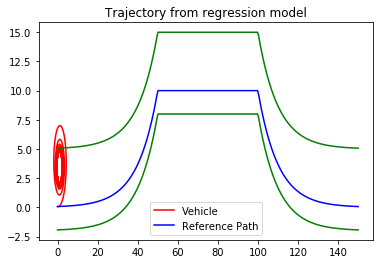

In [28]:
posx = []
posy = []
v = []
theta = []
for i in agent_traj:
    posx.append(i[0][0])
    posy.append(i[0][1])
    v.append(i[0][2])
    theta.append(i[0][3])
    
posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]

# _ = plt.title("Trajectory of the two omnidirectional vehicles")
_ = plt.title("Trajectory from regression model")
_ = plt.plot(posx, posy, "r")
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + UPPER_B, 'g')
_ = plt.plot(posx_, posy_ - LOWER_B, 'g')
_ = plt.legend(["Vehicle", "Reference Path"])
plt.savefig('../../figures/NN_model_boundary.png') # use relative path to save figure

Now implement the MPSC guided controller. MPSC solves feasiblity problem to verify the safety of each output of the regression model. Once the output is unsafe, then MPC solves an optimal control and overrides the regression model.

In [29]:
N = len(x_path)
H = 30  # Number of time steps in trajectory.
n = 30
n_init = 0
#n_end = 250
n_end = N - H - 1
print("n_end", n_end)
x0 = x_path[n_init]  # Initial state.
# Random initial action path.
us_init = np.zeros((n - 1, dynamics.action_size))

J_hist = []
nn_traj = []
mpc_traj= []
traj = []

# RH: create additional dataset for MPC fine-tuning and data augmentation
mpc_safe_traj = []
dir_name = 'mpc_safe_traj/'
mpc_safe_file = 'mpc_safe_H' + str(H) + '.p'
mpc_safe_file = os.path.join(dir_name, mpc_safe_file)


for i in range(n_init, n_end):
    print(">>>>>Step {} at {}".format(i, x0))
    x_path_ = x_path[i: i + H]
    x_nn = []
    for j in [x0] + x_path_[0 : n]:
        # RH: ? pass the prev trajectory pts to cnn
        for k in j:
            x_nn.append(k)
    u = agent.run([x_nn])
    #print("NN outputs control")
    agent_traj = agent_traj + [[x0, u[0, :]]]
    x0_ = dynamics.f(x0, u[0], i)
    #print("Get next state")

    if i <= N - H - 1:
        n_ilqr =  H 
    else:
        n_ilqr = N - i - 1
    x_path_ilqr = x_path[i + 1: i + 1 + n_ilqr]
    #us_init = np.random.uniform(-1, 1, (n_ilqr - 1, dynamics.action_size))
    
    cost_ = CarCost(Q = Q, q = q, \
                   R = R, r = r, \
                   A = A, b = b, \
                   q1 = q1, q2 = q2, \
                   x_path = x_path_ilqr, \
                   x_nominal = nominal)
    ilqr_ = iLQR(dynamics, cost_, n_ilqr - 1)
    xs, us = ilqr_.fit(x0_, us_init, on_iteration=on_iteration)
    print("MPC verifying")
    
    
    if (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[0].T) - b[0,0]\
                   <= 0)).all() == True and \
        (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[1].T) - b[1,0]\
                  <= 0)).all() == True:
        traj.append([x0, u[0, :]])
        nn_traj.append(traj[-1])
        print("Utilize NN output {}".format(u))
    else:
        max_itr = 5
        while (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[0].T) - b[0,0]\
                   <= 0)).any() == False or \
        (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[1].T) - b[1,0]\
                  <= 0)).any() == False :
            if max_itr == 0:
                break
            max_itr -= 1    
            cost = CarCost(Q = Q, q = q, \
                   R = R, r = r, \
                   A = A, b = b, \
                   q1 = q1, q2 = q2, \
                   x_path = x_path_, \
                   x_nominal = nominal)
            ilqr = iLQR(dynamics, cost, H)
            xs, us = ilqr.fit(x0, us_init, on_iteration=on_iteration)
        traj.append([x0, us[0]])
        mpc_traj.append(traj[-1])
        
        # TODO: add the data to mpc_safe_traj
#         print("x0_", x0_)
#         print("x_path_ilqr", x_path_ilqr)
        print("x0", x0)
        print("x0_", x0_)
#         x = [x0] + x_path_ilqr[0:H]
        x = [x0] + x_path_ilqr[0:H]
        print("x", len(x))
        print(x)
        mpc_safe_traj = mpc_safe_traj + [[x, us[0]]]
        
        x0_ = dynamics.f(x0, us[0], i)
        print("Utilize MPC output {}".format(us[0]))
#         print("replace NN output by MPC output {}".format(u[0], us[0]))
#         break
    x0 = x0_[0][:]
    
print("Done")



n_end 269
>>>>>Step 0 at [0.0, 0.067379469990854673, 10, 0.0067378450344227981]
iteration 0 accepted [ 0.08061898] [ 15.0102765    0.29392007  10.00866129   0.04704521] [ -8.90512531e-05   1.47501932e-02]
MPC verifying
Utilize NN output [[ 0.39236131  0.20107915]]
>>>>>Step 1 at [  0.50045538   0.07075151  10.01866971   0.10594395]
iteration 0 accepted [ 0.42486561] [ 15.48072528   0.30248043   9.99565537   0.07456591] [ 0.00155058  0.03431734]
MPC verifying
Utilize NN output [[ 0.3875176   0.21372594]]
>>>>>Step 2 at [  0.99903916   0.12377196  10.03713062   0.21140551]
iteration 0 accepted [ 1.71624551] [ 15.9042458    0.29341896   9.96782795   0.10198506] [ 0.00450531  0.05568677]
MPC verifying
Utilize NN output [[ 0.38246667  0.22777364]]
>>>>>Step 3 at [  1.49016875   0.22917439  10.055373     0.32377855]
iteration 0 accepted [ 5.53560956] [ 16.26581789   0.24422739   9.92688314   0.12760721] [ 0.00870709  0.07895711]
MPC verifying
Utilize NN output [[ 0.37818259  0.23919262]]
>>>

MPC verifying
Utilize NN output [[ 0.3520681   0.30876046]]
>>>>>Step 14 at [  6.01767938   2.85827906  10.27612011  -0.02813961]
iteration 0 accepted [ 158.41132433] [ 20.27359056   0.34821016  10.4793804    0.07605398] [-0.02535592  0.01329923]
MPC verifying
Utilize NN output [[ 0.35032135  0.31296706]]
>>>>>Step 15 at [  6.53170263   2.84381083  10.29295314   0.12761243]
iteration 0 accepted [ 213.5838639] [ 20.36137013  -0.03387443  10.45901154   0.12475856] [-0.02194834  0.04160986]
MPC verifying
Utilize NN output [[ 0.34830841  0.31784916]]
>>>>>Step 16 at [  7.04258066   2.90936143  10.30969686   0.28589789]
iteration 0 accepted [ 335.39001406] [ 20.15280666  -0.72524758  10.42938412   0.17250078] [-0.01680432  0.07078539]
MPC verifying
x0 [  7.04258066   2.90936143  10.30969686   0.28589789]
x0_ [[  7.53754095   3.05485541  10.32635638   0.4463878 ]]
x 31
[array([  7.04258066,   2.90936143,  10.30969686,   0.28589789]), [8.5284280936454842, 0.15809295476648982, 10, 0.0158079785

MPC verifying
Utilize NN output [[ 0.31860879  0.37523949]]
>>>>>Step 26 at [ 12.12031879   3.08355346  10.48032466   0.1031693 ]
iteration 0 accepted [ 201.98358747] [ 26.04795569   0.46006824  10.51551455   0.15590313] [-0.02164576  0.03618984]
MPC verifying
x0 [ 12.12031879   3.08355346  10.48032466   0.1031693 ]
x0_ [[ 12.64192792   3.13755926  10.49557431   0.2937976 ]]
x 31
[array([ 12.12031879,   3.08355346,  10.48032466,   0.1031693 ]), [13.545150501672241, 0.26108745351650026, 10, 0.026102815290438501], [14.046822742474916, 0.27451959595716052, 10, 0.027445066687646062], [14.548494983277592, 0.28864278060653714, 10, 0.02885626600752594], [15.050167224080267, 0.30349255945020043, 10, 0.030339943087253175], [15.551839464882944, 0.3191063135134839, 10, 0.031899806555728667], [16.053511705685619, 0.33552334695992725, 10, 0.033539752577480202], [16.555183946488295, 0.35278498603079123, 10, 0.035263873973066635], [17.056856187290968, 0.37093468307470667, 10, 0.037076469723572966], [

MPC verifying
Utilize NN output [[ 0.2874715   0.42637911]]
>>>>>Step 35 at [ 16.72428329   3.10585999  10.59759491  -0.11020621]
iteration 0 accepted [ 107.86511886] [ 31.35439099   1.56044347  10.52768576   0.13911281] [-0.02176212 -0.00870142]
MPC verifying
Utilize NN output [[ 0.28394607  0.43387032]]
>>>>>Step 36 at [ 17.25129208   3.04754406  10.61142258   0.10627653]
iteration 0 accepted [ 146.86945357] [ 31.5163125    1.25098338  10.50128279   0.20784422] [-0.01801256  0.03144448]
MPC verifying
Utilize NN output [[ 0.28058162  0.44153973]]
>>>>>Step 37 at [ 17.77920958   3.1038615   10.62509474   0.32642106]
iteration 0 accepted [ 248.03048244] [ 31.40595018   0.56270139  10.45803814   0.27311533] [-0.01171203  0.07348242]
iteration 60 accepted [ 98.11034225] [ 33.01244055   1.80717479  10.47353433   0.14336389] [ -2.29035285e-02   4.36326311e-17]
MPC verifying
x0 [ 17.77920958   3.1038615   10.62509474   0.32642106]
x0_ [[ 18.28273196   3.27431939  10.63860855   0.55013145]]
x

MPC verifying
Utilize NN output [[ 0.25613365  0.49117801]]
>>>>>Step 45 at [ 21.9396377    3.34871491  10.68536583   0.03970915]
iteration 0 accepted [ 111.28874649] [ 36.36498692   2.44216594  10.50209789   0.25895133] [-0.01703933  0.00717183]
MPC verifying
Utilize NN output [[ 0.25328228  0.49817783]]
>>>>>Step 46 at [ 22.47379458   3.36993699  10.69776591   0.28583742]
iteration 0 accepted [ 175.34676261] [ 36.44529564   1.97842402  10.45319923   0.33104247] [-0.01088592  0.05445758]
MPC verifying
x0 [ 22.47379458   3.36993699  10.69776591   0.28583742]
x0_ [[ 22.98727437   3.52084106  10.71002817   0.53515752]]
x 31
[array([ 22.47379458,   3.36993699,  10.69776591,   0.28583742]), [23.578595317725753, 0.71208686384204278, 10, 0.071088692493539232], [24.080267558528426, 0.74872153186773083, 10, 0.074732714801826222], [24.581939799331103, 0.78724094032257308, 10, 0.078562065696582195], [25.083612040133779, 0.82774205327576134, 10, 0.082585934299871933], [25.585284280936456, 0.87032

MPC verifying
Utilize NN output [[ 0.23104632  0.54412997]]
>>>>>Step 54 at [ 26.65278963   3.64047279  10.7250878    0.11342735]
iteration 0 accepted [ 94.27446268] [ 41.02642065   3.9775722   10.46485906   0.38016863] [-0.01330628  0.0004581 ]
MPC verifying
Utilize NN output [[ 0.22830866  0.55011958]]
>>>>>Step 55 at [ 27.18587678   3.70120011  10.73630894   0.38188157]
iteration 0 accepted [ 152.40067692] [ 41.22313861   3.58243991  10.40209238   0.44981817] [-0.00615528  0.05431865]
MPC verifying
x0 [ 27.18587678   3.70120011  10.73630894   0.38188157]
x0_ [[ 27.68428004   3.90135692  10.74739854   0.65294773]]
x 31
[array([ 27.18587678,   3.70120011,  10.73630894,   0.38188157]), [28.093645484949832, 1.11845653542112, 10, 0.11138274715078433], [28.595317725752508, 1.1759976669275194, 10, 0.11706209780649016], [29.096989966555185, 1.236499111785559, 10, 0.12302545618338971], [29.598662207357858, 1.300113168966609, 10, 0.12928613285165153], [30.100334448160535, 1.3669999727533484, 

MPC verifying
Utilize NN output [[ 0.20911862  0.59033597]]
>>>>>Step 62 at [  3.08113295e+01   4.10345624e+00   1.07354833e+01   2.47153143e-02]
iteration 0 accepted [ 71.81777849] [ 45.05125828   6.25496927  10.46760695   0.49818139] [-0.01379282 -0.0498227 ]
MPC verifying
Utilize NN output [[ 0.20631415  0.5974313 ]]
>>>>>Step 63 at [ 31.34819397   4.11672771  10.74565512   0.31200716]
iteration 0 accepted [ 100.40965965] [ 45.45456592   6.12877751  10.42580385   0.56550818] [-0.00911011  0.00983446]
MPC verifying
Utilize NN output [[ 0.20343038  0.60443008]]
>>>>>Step 64 at [ 31.8597751    4.28173414  10.75568861   0.60224431]
iteration 0 accepted [ 176.71180081] [ 45.80924175   5.6609017   10.33006382   0.61108506] [ 0.00089685  0.07601685]
MPC verifying
x0 [ 31.8597751    4.28173414  10.75568861   0.60224431]
x0_ [[ 32.30314886   4.5865255   10.76557778   0.8952601 ]]
x 31
[array([ 31.8597751 ,   4.28173414,  10.75568861,   0.60224431]), [32.608695652173914, 1.7567309343087447, 1

MPC verifying
Utilize NN output [[ 0.18367323  0.6431849 ]]
>>>>>Step 71 at [ 35.40333326   5.16291902  10.75223305   0.31051324]
iteration 0 accepted [ 120.78199215] [ 49.05481209   8.87299995  10.52342679   0.59096285] [-0.01613749  0.00697819]
MPC verifying
x0 [ 35.40333326   5.16291902  10.75223305   0.31051324]
x0_ [[ 35.91544754   5.32725316  10.76117662   0.61698397]]
x 31
[array([ 35.40333326,   5.16291902,  10.75223305,   0.31051324]), [36.120401337792643, 2.4958397027077579, 10, 0.24458706742161959], [36.62207357859532, 2.6242429405665502, 10, 0.25663750350095027], [37.123745819397996, 2.7592521281082227, 10, 0.26922617026001255], [37.625418060200666, 2.9012071210244246, 10, 0.28236876614178369], [38.127090301003342, 3.0504652595316233, 10, 0.29608018015190907], [38.628762541806019, 3.2074022678958531, 10, 0.31037426861731449], [39.130434782608695, 3.3724132002352385, 10, 0.32526360925712161], [39.632107023411372, 3.5459134349811396, 10, 0.34075923313746809], [40.133779264214

MPC verifying
Utilize NN output [[ 0.15799414  0.6776883 ]]
>>>>>Step 80 at [ 39.92701513   6.1914344   10.76125463   0.72822315]
iteration 0 accepted [ 158.21156775] [ 54.35908473   9.06549263  10.21773462   0.27764445] [ 0.00771302  0.20530643]
MPC verifying
x0 [ 39.92701513   6.1914344   10.76125463   0.72822315]
x0_ [[ 40.32874643   6.54966732  10.76896106   1.04734199]]
x 31
[array([ 39.92701513,   6.1914344 ,  10.76125463,   0.72822315]), [40.635451505016725, 3.9201512745167206, 10, 0.37360397049647848], [41.137123745819395, 4.1218309400810238, 10, 0.39096472522097259], [41.638795986622071, 4.3338864010302025, 10, 0.40895439124124383], [42.140468227424748, 4.5568514599643688, 10, 0.42757162630130108], [42.642140468227424, 4.7912873819773871, 10, 0.44681162186238826], [43.143812709030101, 5.0377843075172848, 10, 0.46666578283940863], [43.645484949832777, 5.296962737933967, 10, 0.48712143033197502], [44.147157190635454, 5.5694750974537701, 10, 0.50816153892642757], [44.648829431438

iteration 0 accepted [ 103.3988798] [ 59.20472659   9.58961733  10.19562636   0.16893613] [ 0.0067642   0.14815177]
MPC verifying
Utilize NN output [[ 0.13984701  0.71727675]]
>>>>>Step 90 at [ 44.55215468   8.59381819  10.74316693   0.72515535]
iteration 0 accepted [ 178.97161183] [ 59.36064041   9.1834419   10.04743391   0.19882359] [ 0.02096285  0.22789644]
MPC verifying
x0 [ 44.55215468   8.59381819  10.74316693   0.72515535]
x0_ [[ 44.95429062   8.95020334  10.750039     1.05676678]]
x 31
[array([ 44.55215468,   8.59381819,  10.74316693,   0.72515535]), [45.652173913043477, 6.4740539208391095, 10, 0.57454908012794437], [46.153846153846153, 6.8071239832338541, 10, 0.59766364001144145], [46.65551839464883, 7.157329470791888, 10, 0.62120713297427321], [47.157190635451506, 7.5255519481708539, 10, 0.64513442876566551], [47.658862876254183, 7.9127183338050475, 10, 0.66939618401587253], [48.160535117056853, 8.3198032332170158, 10, 0.69393924696901188], [48.662207357859529, 8.747831392370

MPC verifying
x0 [ 48.64176602  11.69912455  10.78533717   0.7105743 ]
x0_ [[ 49.05063942  12.05097146  10.79145413   1.04968915]]
x 31
[array([ 48.64176602,  11.69912455,  10.78533717,   0.7105743 ]), [50.668896321070235, 10.0, 10, 0.0], [51.170568561872912, 10.0, 10, 0.0], [51.672240802675589, 10.0, 10, 0.0], [52.173913043478258, 10.0, 10, 0.0], [52.675585284280935, 10.0, 10, 0.0], [53.177257525083611, 10.0, 10, 0.0], [53.678929765886288, 10.0, 10, 0.0], [54.180602006688964, 10.0, 10, 0.0], [54.682274247491641, 10.0, 10, 0.0], [55.183946488294318, 10.0, 10, 0.0], [55.685618729096987, 10.0, 10, 0.0], [56.187290969899664, 10.0, 10, 0.0], [56.68896321070234, 10.0, 10, 0.0], [57.190635451505017, 10.0, 10, 0.0], [57.692307692307693, 10.0, 10, 0.0], [58.19397993311037, 10.0, 10, 0.0], [58.695652173913047, 10.0, 10, 0.0], [59.197324414715716, 10.0, 10, 0.0], [59.698996655518393, 10.0, 10, 0.0], [60.200668896321069, 10.0, 10, 0.0], [60.702341137123746, 10.0, 10, 0.0], [61.204013377926422, 10

MPC verifying
Utilize NN output [[ 0.10847344  0.76841736]]
>>>>>Step 110 at [ 53.65871284  12.7014345   10.89206201  -0.11893463]
iteration 0 accepted [ 299.3592906] [ 68.06020311   9.3014538   10.78064397   0.07387052] [-0.03141473  0.04357894]
MPC verifying
Utilize NN output [[ 0.10685609  0.77225256]]
>>>>>Step 111 at [ 54.19960078  12.63679914  10.89738457   0.23409744]
iteration 0 accepted [ 680.52887073] [ 66.76474518   7.20240781  10.74204528   0.17828985] [-0.02177669  0.11148658]
MPC verifying
x0 [ 54.19960078  12.63679914  10.89738457   0.23409744]
x0_ [[ 54.72973568  12.76322021  10.90262667   0.58845229]]
x 31
[array([ 54.19960078,  12.63679914,  10.89738457,   0.23409744]), [56.187290969899664, 10.0, 10, 0.0], [56.68896321070234, 10.0, 10, 0.0], [57.190635451505017, 10.0, 10, 0.0], [57.692307692307693, 10.0, 10, 0.0], [58.19397993311037, 10.0, 10, 0.0], [58.695652173913047, 10.0, 10, 0.0], [59.197324414715716, 10.0, 10, 0.0], [59.698996655518393, 10.0, 10, 0.0], [60.20066

MPC verifying
x0 [ 59.49344487  12.71879813  10.95251432   0.3456025 ]
x0_ [[ 60.00879671  12.9043521   10.95703767   0.71121579]]
x 31
[array([ 59.49344487,  12.71879813,  10.95251432,   0.3456025 ]), [61.204013377926422, 10.0, 10, 0.0], [61.705685618729099, 10.0, 10, 0.0], [62.207357859531776, 10.0, 10, 0.0], [62.709030100334445, 10.0, 10, 0.0], [63.210702341137122, 10.0, 10, 0.0], [63.712374581939798, 10.0, 10, 0.0], [64.214046822742475, 10.0, 10, 0.0], [64.715719063545151, 10.0, 10, 0.0], [65.217391304347828, 10.0, 10, 0.0], [65.719063545150505, 10.0, 10, 0.0], [66.220735785953181, 10.0, 10, 0.0], [66.722408026755858, 10.0, 10, 0.0], [67.224080267558534, 10.0, 10, 0.0], [67.725752508361211, 10.0, 10, 0.0], [68.227424749163873, 10.0, 10, 0.0], [68.72909698996655, 10.0, 10, 0.0], [69.230769230769226, 10.0, 10, 0.0], [69.732441471571903, 10.0, 10, 0.0], [70.23411371237458, 10.0, 10, 0.0], [70.735785953177256, 10.0, 10, 0.0], [71.237458193979933, 10.0, 10, 0.0], [71.739130434782609, 10

MPC verifying
x0 [  6.52066881e+01   1.28790390e+01   1.09673497e+01   2.33973453e-03]
x0_ [[ 65.75515021  12.88032224  10.97119658   0.37631496]]
x 31
[array([  6.52066881e+01,   1.28790390e+01,   1.09673497e+01,
         2.33973453e-03]), [66.722408026755858, 10.0, 10, 0.0], [67.224080267558534, 10.0, 10, 0.0], [67.725752508361211, 10.0, 10, 0.0], [68.227424749163873, 10.0, 10, 0.0], [68.72909698996655, 10.0, 10, 0.0], [69.230769230769226, 10.0, 10, 0.0], [69.732441471571903, 10.0, 10, 0.0], [70.23411371237458, 10.0, 10, 0.0], [70.735785953177256, 10.0, 10, 0.0], [71.237458193979933, 10.0, 10, 0.0], [71.739130434782609, 10.0, 10, 0.0], [72.240802675585286, 10.0, 10, 0.0], [72.742474916387962, 10.0, 10, 0.0], [73.244147157190639, 10.0, 10, 0.0], [73.745819397993316, 10.0, 10, 0.0], [74.247491638795992, 10.0, 10, 0.0], [74.749163879598669, 10.0, 10, 0.0], [75.250836120401331, 10.0, 10, 0.0], [75.752508361204008, 10.0, 10, 0.0], [76.254180602006684, 10.0, 10, 0.0], [76.755852842809361, 

MPC verifying
Utilize NN output [[ 0.06523506  0.85640037]]
>>>>>Step 144 at [ 71.49082468  12.49984408  10.94172422   0.10804835]
iteration 0 accepted [ 251.14614093] [ 85.52621257   8.89561002  10.54866299   0.13693871] [-0.01163199  0.09566726]
MPC verifying
Utilize NN output [[ 0.06422061  0.85877627]]
>>>>>Step 145 at [ 72.03480023  12.55884953  10.94493084   0.48861609]
iteration 0 accepted [ 656.1059926] [ 84.26550082   5.98424659  10.44711322   0.12613154] [ 0.00461588  0.20180381]
MPC verifying
x0 [ 72.03480023  12.55884953  10.94493084   0.48861609]
x0_ [[ 72.51807946  12.81576648  10.9480864    0.86990851]]
x 31
[array([ 72.03480023,  12.55884953,  10.94493084,   0.48861609]), [73.244147157190639, 10.0, 10, 0.0], [73.745819397993316, 10.0, 10, 0.0], [74.247491638795992, 10.0, 10, 0.0], [74.749163879598669, 10.0, 10, 0.0], [75.250836120401331, 10.0, 10, 0.0], [75.752508361204008, 10.0, 10, 0.0], [76.254180602006684, 10.0, 10, 0.0], [76.755852842809361, 10.0, 10, 0.0], [77.257

MPC verifying
Utilize NN output [[ 0.05429515  0.87796706]]
>>>>>Step 156 at [ 77.69583266  12.85003894  10.9135288    0.23355965]
iteration 0 accepted [ 387.5818133] [ 90.83345681   8.09232081  10.51448305   0.16754045] [-0.00689939  0.12244905]
MPC verifying
x0 [ 77.69583266  12.85003894  10.9135288    0.23355965]
x0_ [[ 78.22675822  12.97634683  10.91619906   0.61900513]]
x 31
[array([ 77.69583266,  12.85003894,  10.9135288 ,   0.23355965]), [78.762541806020067, 10.0, 10, 0.0], [79.264214046822744, 10.0, 10, 0.0], [79.76588628762542, 10.0, 10, 0.0], [80.267558528428097, 10.0, 10, 0.0], [80.769230769230774, 10.0, 10, 0.0], [81.27090301003345, 10.0, 10, 0.0], [81.772575250836127, 10.0, 10, 0.0], [82.274247491638789, 10.0, 10, 0.0], [82.775919732441466, 10.0, 10, 0.0], [83.277591973244142, 10.0, 10, 0.0], [83.779264214046819, 10.0, 10, 0.0], [84.280936454849495, 10.0, 10, 0.0], [84.782608695652172, 10.0, 10, 0.0], [85.284280936454849, 10.0, 10, 0.0], [85.785953177257525, 10.0, 10, 0.0]

MPC verifying
Utilize NN output [[ 0.04596106  0.89459211]]
>>>>>Step 167 at [  8.34807522e+01   1.26601589e+01   1.08585417e+01   1.19723404e-02]
iteration 0 accepted [ 181.35021674] [ 97.6207309    9.31292472  10.45555566   0.10950583] [-0.00827396  0.07838181]
MPC verifying
Utilize NN output [[ 0.04521384  0.89616764]]
>>>>>Step 168 at [ 84.02369682  12.66665949  10.86080084   0.39985394]
iteration 0 accepted [ 372.21092471] [ 97.21841615   7.85583233  10.31571839   0.16968755] [ 0.00755558  0.16652477]
MPC verifying
x0 [ 84.02369682  12.66665949  10.86080084   0.39985394]
x0_ [[ 84.52395186  12.87807781  10.86302243   0.78821314]]
x 31
[array([ 84.02369682,  12.66665949,  10.86080084,   0.39985394]), [84.782608695652172, 10.0, 10, 0.0], [85.284280936454849, 10.0, 10, 0.0], [85.785953177257525, 10.0, 10, 0.0], [86.287625418060202, 10.0, 10, 0.0], [86.789297658862878, 10.0, 10, 0.0], [87.290969899665555, 10.0, 10, 0.0], [87.792642140468232, 10.0, 10, 0.0], [88.294314381270908, 10.0, 

MPC verifying
Utilize NN output [[ 0.03895842  0.90634179]]
>>>>>Step 178 at [ 89.18047549  12.63851003  10.80259643  -0.18446374]
iteration 0 accepted [ 137.24293098] [ 102.32606873    6.29668638   10.38753306   -0.62214391] [-0.00402619  0.22140075]
MPC verifying
Utilize NN output [[ 0.03863218  0.90588754]]
>>>>>Step 179 at [ 89.71148933  12.53943089  10.80452708   0.203972  ]
iteration 0 accepted [ 239.31145177] [ 102.06733594    5.36607297   10.1740371    -0.67345123] [ 0.01570674  0.33751292]
MPC verifying
x0 [ 89.71148933  12.53943089  10.80452708   0.203972  ]
x0_ [[ 90.24056314  12.64886907  10.80642609   0.59277353]]
x 31
[array([ 89.71148933,  12.53943089,  10.80452708,   0.203972  ]), [90.3010033444816, 10.0, 10, 0.0], [90.802675585284277, 10.0, 10, 0.0], [91.304347826086953, 10.0, 10, 0.0], [91.80602006688963, 10.0, 10, 0.0], [92.307692307692307, 10.0, 10, 0.0], [92.809364548494983, 10.0, 10, 0.0], [93.31103678929766, 10.0, 10, 0.0], [93.812709030100336, 10.0, 10, 0.0], [9

MPC verifying
Utilize NN output [[ 0.03507739  0.91339141]]
>>>>>Step 188 at [ 94.39887879  12.84715297  10.82514806   0.10940926]
iteration 0 accepted [ 541.68923243] [ 103.27537828    1.40391719   10.28098109   -0.68549834] [ 0.01558945  0.31735305]
MPC verifying
x0 [ 94.39887879  12.84715297  10.82514806   0.10940926]
x0_ [[ 94.93694306  12.90625821  10.82688517   0.50090343]]
x 31
[array([ 94.39887879,  12.84715297,  10.82514806,   0.10940926]), [94.81605351170569, 10.0, 10, 0.0], [95.317725752508366, 10.0, 10, 0.0], [95.819397993311043, 10.0, 10, 0.0], [96.321070234113705, 10.0, 10, 0.0], [96.822742474916382, 10.0, 10, 0.0], [97.324414715719058, 10.0, 10, 0.0], [97.826086956521735, 10.0, 10, 0.0], [98.327759197324411, 10.0, 10, 0.0], [98.829431438127088, 10.0, 10, 0.0], [99.331103678929765, 10.0, 10, 0.0], [99.832775919732441, 10.0, 10, 0.0], [100.33444816053512, 9.6710827861037316, 10, -1.4677614560582382], [100.83612040133779, 9.1978802772430015, 10, -1.4625009787467058], [101.3

MPC verifying
Utilize NN output [[ 0.03247714  0.91601884]]
>>>>>Step 197 at [  9.91147867e+01   1.26554813e+01   1.09279652e+01  -9.82904206e-03]
iteration 0 accepted [ 2628.64044259] [ 98.47795193  -0.88336289  10.90703613  -1.07617222] [-0.0077736   0.39650005]
MPC verifying
x0 [  9.91147867e+01   1.26554813e+01   1.09279652e+01  -9.82904206e-03]
x0_ [[ 99.66119859  12.6501104   10.92956601   0.38603855]]
x 31
[array([  9.91147867e+01,   1.26554813e+01,   1.09279652e+01,
        -9.82904206e-03]), [99.331103678929765, 10.0, 10, 0.0], [99.832775919732441, 10.0, 10, 0.0], [100.33444816053512, 9.6710827861037316, 10, -1.4677614560582382], [100.83612040133779, 9.1978802772430015, 10, -1.4625009787467058], [101.33779264214047, 8.7478313923708733, 10, -1.4569763533234079], [101.83946488294315, 8.3198032332170158, 10, -1.4511750252022628], [102.34113712374582, 7.9127183338050422, 10, -1.4450839567939702], [102.8428093645485, 7.5255519481708486, 10, -1.4386896276655623], [103.34448160535118

MPC verifying
x0 [ 101.79502795   11.07100534   11.00976574   -0.35153521]
x0_ [[  1.02311885e+02   1.08814381e+01   1.10112058e+01   5.00413760e-02]]
x 31
[array([ 101.79502795,   11.07100534,   11.00976574,   -0.35153521]), [102.34113712374582, 7.9127183338050422, 10, -1.4450839567939702], [102.8428093645485, 7.5255519481708486, 10, -1.4386896276655623], [103.34448160535118, 7.1573294707918826, 10, -1.4319780383730178], [103.84615384615384, 6.8071239832338577, 10, -1.4249347186443819], [104.34782608695652, 6.4740539208391148, 10, -1.4175447406771713], [104.84949832775919, 6.1572808535831207, 10, -1.409792738406046], [105.35117056856187, 5.8560073755127808, 10, -1.4016629336937665], [105.85284280936455, 5.5694750974537701, 10, -1.3931391704986769], [106.35451505016722, 5.296962737933967, 10, -1.3842049581730345], [106.8561872909699, 5.0377843075172848, 10, -1.3748435251451347], [107.35785953177258, 4.7912873819773871, 10, -1.3650378843300273], [107.85953177257525, 4.5568514599643688, 

MPC verifying
x0 [ 104.67982295    8.6673976    11.07241687   -0.22508378]
x0_ [[ 105.21951024    8.54382889   11.0737017     0.18097402]]
x 31
[array([ 104.67982295,    8.6673976 ,   11.07241687,   -0.22508378]), [105.85284280936455, 5.5694750974537701, 10, -1.3931391704986769], [106.35451505016722, 5.296962737933967, 10, -1.3842049581730345], [106.8561872909699, 5.0377843075172848, 10, -1.3748435251451347], [107.35785953177258, 4.7912873819773871, 10, -1.3650378843300273], [107.85953177257525, 4.5568514599643688, 10, -1.3547709116930085], [108.36120401337793, 4.3338864010302025, 10, -1.3440254394498203], [108.86287625418061, 4.1218309400810238, 10, -1.3327843654187146], [109.36454849498328, 3.9201512745167171, 10, -1.3210307800315237], [109.86622073578596, 3.7283397205012387, 10, -1.3087481124509308], [110.36789297658864, 3.545913434981137, 10, -1.2959202971147012], [110.8695652173913, 3.3724132002352407, 10, -1.2825319618184627], [111.37123745819397, 3.2074022678958554, 10, -1.26856

MPC verifying
Utilize NN output [[ 0.02334866  0.94192898]]
>>>>>Step 217 at [ 108.0116867     7.05704348   11.11163451   -0.12382354]
iteration 0 accepted [ 726.65355855] [  1.19163822e+02  -5.00858801e-01   1.09968499e+01   3.01199806e-02] [-0.03579138  0.07079292]
MPC verifying
x0 [ 108.0116867     7.05704348   11.11163451   -0.12382354]
x0_ [[ 108.56304315    6.9884215    11.11278144    0.28540512]]
x 31
[array([ 108.0116867 ,    7.05704348,   11.11163451,   -0.12382354]), [109.36454849498328, 3.9201512745167171, 10, -1.3210307800315237], [109.86622073578596, 3.7283397205012387, 10, -1.3087481124509308], [110.36789297658864, 3.545913434981137, 10, -1.2959202971147012], [110.8695652173913, 3.3724132002352407, 10, -1.2825319618184627], [111.37123745819397, 3.2074022678958554, 10, -1.2685686381392429], [111.87290969899665, 3.0504652595316264, 10, -1.2540169945744724], [112.37458193979933, 2.9012071210244268, 10, -1.2388650922083329], [112.876254180602, 2.7592521281082227, 10, -1.22310

MPC verifying
Utilize NN output [[ 0.02115781  0.94709194]]
>>>>>Step 223 at [ 110.98827934    6.02081548   11.12174063   -0.43431231]
iteration 0 accepted [ 241.06685371] [  1.24918830e+02   6.79246687e-01   1.09041300e+01  -5.75634489e-02] [-0.03561867  0.00946077]
MPC verifying
Utilize NN output [[ 0.02079626  0.94798076]]
>>>>>Step 224 at [  1.11492763e+02   5.78681055e+00   1.11227803e+01  -2.34376536e-02]
iteration 0 accepted [ 587.67748009] [  1.23420587e+02  -9.79696238e-01   1.08912931e+01   7.88743699e-02] [-0.02835409  0.08557859]
MPC verifying
x0 [  1.11492763e+02   5.78681055e+00   1.11227803e+01  -2.34376536e-02]
x0_ [[ 112.04877443    5.77377655   11.12380177    0.3877081 ]]
x 31
[array([  1.11492763e+02,   5.78681055e+00,   1.11227803e+01,
        -2.34376536e-02]), [112.876254180602, 2.7592521281082227, 10, -1.2231026620043604], [113.37792642140468, 2.6242429405665502, 10, -1.2067214019497687], [113.87959866220736, 2.4958397027077579, 10, -1.1897152912398843], [114.381

MPC verifying
Utilize NN output [[ 0.01851002  0.95340377]]
>>>>>Step 231 at [  1.15133355e+02   4.87774658e+00   1.11047565e+01   7.18712789e-02]
iteration 0 accepted [ 477.80694025] [  1.27572260e+02  -1.26566360e+00   1.07666731e+01   1.16409158e-01] [-0.01998434  0.10144358]
MPC verifying
x0 [  1.15133355e+02   4.87774658e+00   1.11047565e+01   7.18712789e-02]
x0_ [[ 115.68718174    4.91761952   11.10566555    0.48368605]]
x 31
[array([  1.15133355e+02,   4.87774658e+00,   1.11047565e+01,
         7.18712789e-02]), [116.38795986622074, 1.9421373751471738, 10, -1.0953025541087744], [116.88963210702342, 1.8471093106793182, 10, -1.074590229653072], [117.39130434782609, 1.7567309343087436, 10, -1.0533022663134963], [117.89297658862876, 1.6707747385141425, 10, -1.0314622896037755], [118.39464882943143, 1.5890243476331909, 10, -1.0090986892552916], [118.89632107023411, 1.5112739731848148, 10, -0.98624466775411324], [119.39799331103679, 1.4373278958423112, 10, -0.962938200465278], [119.89

MPC verifying
Utilize NN output [[ 0.01643953  0.95839477]]
>>>>>Step 238 at [ 118.83301744    4.3135475    11.07018862    0.16412435]
iteration 0 accepted [ 431.7036245] [ 131.44254711   -1.53961735   10.65319632    0.1455505 ] [-0.01223877  0.11833944]
MPC verifying
x0 [ 118.83301744    4.3135475    11.07018862    0.16412435]
x0_ [[ 119.37910861    4.40398788   11.0709958     0.57587729]]
x 31
[array([ 118.83301744,    4.3135475 ,   11.07018862,    0.16412435]), [119.89966555183946, 1.3669999727533486, 10, -0.93922189851407301], [120.40133779264214, 1.300113168966609, 10, -0.915142768500394], [120.90301003344482, 1.236499111785559, 10, -0.89075186676281082], [121.40468227424749, 1.1759976669275194, 10, -0.86610385012955748], [121.90635451505017, 1.11845653542112, 10, -0.84125642966340519], [122.40802675585284, 1.0637308702274111, 10, -0.81626973853185814], [122.90969899665552, 1.0116829116195609, 10, -0.79120562947965922], [123.4113712374582, 0.96218164040329301, 10, -0.7661269211069

MPC verifying
Utilize NN output [[ 0.01486614  0.96220702]]
>>>>>Step 244 at [ 121.96638939    3.68913238   11.02162823   -0.13502456]
iteration 0 accepted [ 132.60179798] [  1.36276152e+02  -9.97657049e-02   1.05931253e+01   6.35016704e-02] [-0.01509522  0.05815766]
MPC verifying
Utilize NN output [[ 0.01460602  0.9628666 ]]
>>>>>Step 245 at [ 122.51247296    3.61494629   11.02235848    0.27583573]
iteration 0 accepted [ 317.48457696] [ 135.77081421   -1.40134318   10.48126349    0.16515898] [-0.00146992  0.14257335]
MPC verifying
x0 [ 122.51247296    3.61494629   11.02235848    0.27583573]
x0_ [[ 123.04277474    3.76504879   11.02307563    0.68688627]]
x 31
[array([ 122.51247296,    3.61494629,   11.02235848,    0.27583573]), [123.4113712374582, 0.96218164040329301, 10, -0.76612692110695491], [123.91304347826087, 0.91510244810511554, 10, -0.74109661495423618], [124.41471571906355, 0.87032682329812372, 10, -0.71617710702254489], [124.91638795986621, 0.82774205327576178, 10, -0.6914294

MPC verifying
Utilize NN output [[ 0.01320329  0.96622765]]
>>>>>Step 251 at [  1.25679591e+02   3.34100043e+00   1.09678413e+01  -2.96932813e-02]
iteration 0 accepted [ 125.26330019] [  1.39931971e+02  -2.28080960e-01   1.04900692e+01   9.50004084e-02] [-0.00842998  0.07765224]
MPC verifying
Utilize NN output [[ 0.01297268  0.96681535]]
>>>>>Step 252 at [ 126.22775739    3.32471878   10.96848994    0.38012092]
iteration 0 accepted [ 301.38064999] [ 139.62169325   -1.42808183   10.34978781    0.17119945] [ 0.00717978  0.16807006]
MPC verifying
x0 [ 126.22775739    3.32471878   10.96848994    0.38012092]
x0_ [[ 126.73705002    3.52820814   10.96912692    0.79010085]]
x 31
[array([ 126.22775739,    3.32471878,   10.96848994,    0.38012092]), [126.92307692307692, 0.67724471659240937, 10, -0.59529016009765234], [127.4247491638796, 0.64410738273929746, 10, -0.57222162306022939], [127.92642140468227, 0.61259144639286212, 10, -0.54962650972869409], [128.42809364548495, 0.58261757317193885, 10

MPC verifying
Utilize NN output [[ 0.01172649  0.96972382]]
>>>>>Step 258 at [  1.29389203e+02   3.37000138e+00   1.09165828e+01   6.32142936e-02]
iteration 0 accepted [ 156.57836002] [  1.43285441e+02  -4.48309099e-01   1.04269343e+01   1.21222332e-01] [-0.0040061  0.095044 ]
MPC verifying
x0 [  1.29389203e+02   3.37000138e+00   1.09165828e+01   6.32142936e-02]
x0_ [[ 129.93395629    3.40448352   10.91715883    0.47193682]]
x 31
[array([  1.29389203e+02,   3.37000138e+00,   1.09165828e+01,
         6.32142936e-02]), [129.93311036789297, 0.5012120851627837, 10, -0.464616806927245], [130.43478260869566, 0.47668796295062071, 10, -0.44482466145521704], [130.93645484949832, 0.45336379698069867, 10, -0.42564773836667169], [131.43812709030101, 0.4311808738372675, 10, -0.40709423319583532], [131.93979933110367, 0.41008335293032949, 10, -0.38916858666835202], [132.44147157190636, 0.39001812592932716, 10, -0.37187180669999031], [132.94314381270902, 0.37093468307470701, 10, -0.35520180198934392]

MPC verifying
Utilize NN output [[ 0.01061313  0.97234535]]
>>>>>Step 264 at [ 132.45718406    2.96795412   10.85785839   -0.21390094]
iteration 0 accepted [ 66.64323152] [  1.47044412e+02  -7.45399423e-03   1.04231683e+01   4.79329869e-02] [-0.0081694   0.03920864]
MPC verifying
Utilize NN output [[ 0.01043174  0.97280157]]
>>>>>Step 265 at [ 132.98771735    2.85270955   10.85837995    0.19323229]
iteration 0 accepted [ 136.14844338] [  1.47142352e+02  -3.94493337e-01   1.02840702e+01   1.46641853e-01] [ 0.00518631  0.12217057]
MPC verifying
x0 [ 132.98771735    2.85270955   10.85837995    0.19323229]
x0_ [[ 133.52054447    2.95696984   10.85889234    0.60049503]]
x 31
[array([ 132.98771735,    2.85270955,   10.85837995,    0.19323229]), [133.44481605351172, 0.35278498603079073, 10, -0.33915371830135294], [133.94648829431438, 0.33552334695992725, 10, -0.32372027000034126], [134.44816053511707, 0.31910631351348351, 10, -0.30889206084606918], [134.94983277591973, 0.30349255945020043, 10

In [30]:
# RH
# print("mpc_safe_traj", len(mpc_safe_traj)) # e.g.generate 8 if n_end=269 
# print("Sample of mpc_safe_traj", mpc_safe_traj[0]) # array of sizes 4,4, ..., 4,2
# convert of mpc_safe_traj into traj dump
X = []
Y = []
print("shape", np.asarray(mpc_safe_traj).shape)
for i in range(len(mpc_safe_traj)):
    X.append([])
    for j in range(0, n+1):
        for k in mpc_safe_traj[i][0][j]:
#             print(i, j)
            X[-1].append(k)
#             print("X", X)
    Y.append(mpc_safe_traj[i][1])
#     print("X0")
#     print(X[0])
#     print("Y0")
#     print(Y[0])

fdump = open(mpc_safe_file, 'wb') 
pickle.dump((X, Y), fdump)
fdump.close()
print("Done")

shape (106, 2)
Done


In [31]:
# importlib.reload(bc)
# TODO: load the mpc_safe_traj pickle file
# create a new agent with safe data for comparison
agent_safe = NeuralNetwork(input_size = (n + 1) * 4, model_name = 'mlp_safe_H'+str(n), batch_size = 500, checkpoint = 'checkpoints/mlp_H30_965.pt') # find a way to be consistent with the latest model without DA

retrain_mpc_safe = True
if retrain_mpc_safe:
    # os.path.basename(mpc_safe_file)
    mpc_path = 'mpc_safe_H' + str(H) + '.p'
    print(mpc_path)
    agent_safe.mpc(paths = [mpc_path] ) # load dataset from pickle file
    agent_safe.train(checkpoint = 'checkpoints/mlp_H30_965.pt', num_epoch = 100) # ?? How to choose epoch number
    


mpc_safe_H30.p
paths
['mpc_safe_H30.p']
path mpc_safe_H30.p
106
<class 'list'>
<class 'numpy.ndarray'>
X[0]
[3.8695439219951724, 1.9900160988782289, 10.161454713516619, 1.1064999099673776, 5.0167224080267561, 0.11127588996731547, 10, 0.011127129746154518, 5.5183946488294318, 0.11700069054321806, 10, 0.011699535217714871, 6.0200668896321066, 0.12302001441292204, 10, 0.012301380905790726, 6.5217391304347823, 0.1293490138894979, 10, 0.012934180074691099, 7.023411371237458, 0.13600362082568626, 10, 0.01359952362331456, 7.5250836120401337, 0.14300058671880489, 10, 0.014299084043795166, 8.0267558528428093, 0.15035752487892831, 10, 0.01503461957806302, 8.5284280936454842, 0.15809295476648982, 10, 0.015807978581570375, 9.0301003344481607, 0.16622634861091737, 10, 0.016621104103759374, 9.5317725752508355, 0.17477818042765197, 10, 0.017476038695164623, 10.033444816053512, 0.18376997755694321, 10, 0.018374929451350462, 10.535117056856187, 0.19322437485415306, 10, 0.01932003330417003, 11.036789297

The red curve in the plot is the trajecotry of the hybrid controller. It can be seen that the vehicle still drive out of the lane boundaries even with the existence of the MPSC. It is because horizon being 30 is too short to predict the unsafe outcome and prevent the vehicle from moving out of the boundary.

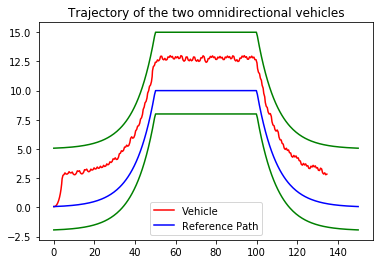

In [33]:
posx = []
posy = []
v = []
theta = []
for i in traj:
    posx.append(i[0][0])
    posy.append(i[0][1])
    v.append(i[0][2])
    theta.append(i[0][3])
    
posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]

_ = plt.title("Trajectory of the two omnidirectional vehicles")
_ = plt.plot(posx, posy, "r")
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + UPPER_B, 'g')
_ = plt.plot(posx_, posy_ - LOWER_B, 'g')
_ = plt.legend(["Vehicle", "Reference Path"])
plt.savefig('../../figures/MPSC_boundary.png') # use relative path to save figure


The red dots are the steering commands output by the regression model while the blue dots are from the MPC.

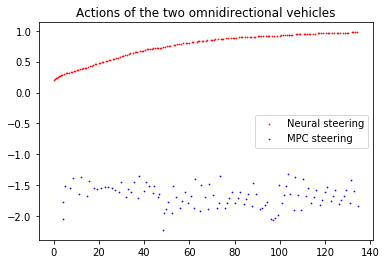

In [34]:

str_nn = []
posx_nn = []
str_mpc = []
posx_mpc = []
for i in nn_traj:
    posx_nn.append(i[0][0])
    str_nn.append(i[1][1])
for j in mpc_traj:
    posx_mpc.append(j[0][0])
    str_mpc.append(j[1][1])
    

_ = plt.title("Actions of the two omnidirectional vehicles")
_ = plt.scatter(posx_nn, str_nn, s = 0.5, c = "r")
_ = plt.scatter(posx_mpc, str_mpc, s = 0.5, c = "b")
_ = plt.legend(["Neural steering", "MPC steering"])
plt.savefig('../../figures/steering_plot.png') # use relative path to save figure

In [35]:
# Draw the results with DA, take ref from before
agent_safe_traj = []
x0 = [[i for i in x_path[0]]] # Initial state
print(x_path[0])

N = 300
n = 30

for i in range(0, int(N-n)+1):
    x_path_ = x_path[i:i+n]
    x = []
    for j in x0[0]:
        x.append(j)
    for j in x_path_:
        for k in j:
            x.append(k)
    
    u = agent_safe.run([x])
    agent_safe_traj = agent_safe_traj + [[x[:], u[0]]]
    x0 = dynamics.f(x[0:4], u[0], i)
    
    print(x0)  

[0.0, 0.067379469990854673, 10, 0.0067378450344227981]
[[  0.50000456   0.07074847  10.00063649  -0.3715749 ]]
[[  0.96592284  -0.11080874  10.00107806  -0.7492966 ]]
[[  1.33205198  -0.45141262  10.00138358  -1.12592852]]
[[  1.54725325  -0.90281351  10.00159023  -1.50063827]]
[[  1.58230932  -1.4016662   10.00172709  -1.8712974 ]]
[[  1.43428366  -1.87934499  10.00181729  -2.23427539]]
[[  1.12629597  -2.27334497  10.00187846  -2.58443375]]
[[  0.70183491  -2.53778367  10.00192194  -2.91623122]]
[[  0.21438376  -2.64953466  10.001954    -3.22727815]]
[[ -0.28387981  -2.6067359   10.00197825  -3.51856781]]
[[ -0.74886339  -2.42264446  10.00199704  -3.79638118]]
[[ -1.14553126  -2.11808767  10.00201205  -4.06913246]]
[[ -1.44549394  -1.71793356  10.00202421  -4.34431274]]
[[ -1.62544104  -1.25132826  10.00203406  -4.62562004]]
[[ -1.66877992  -0.75310777  10.00204212  -4.9146932 ]]
[[ -1.56829583  -0.26320449  10.00204873  -5.21093904]]
[[ -1.32917049   0.17602399  10.00205414  -5.5120

[[ -8.44665432 -17.71959755  10.00207469 -33.52067599]]
[[ -8.7011772  -18.15008779  10.00207469 -33.6091002 ]]
[[ -8.99272187 -18.5564195   10.00207469 -33.72376542]]
[[ -9.32884208 -18.92672605  10.00207469 -33.84284255]]
[[ -9.70657303 -19.25448065  10.00207469 -33.96013784]]
[[-10.1200645  -19.53577863  10.00207469 -34.05268784]]
[[-10.55778332 -19.77765872  10.00207469 -34.1635656 ]]
[[-11.01957847 -19.96961961  10.00207469 -34.29698959]]
[[-11.50280555 -20.09844249  10.00207469 -34.43471619]]
[[-11.99914309 -20.15970248  10.00207469 -34.59543733]]
[[-12.49888735 -20.14074403  10.00207469 -34.74983891]]
[[-12.98977092 -20.04515602  10.00207469 -34.91788563]]
[[-13.45775183 -19.86881086  10.00207469 -35.09159561]]
[[-13.88821069 -19.6142349   10.00207469 -35.28004755]]
[[-14.26335658 -19.28352461  10.00207469 -35.48640405]]
[[-14.56278246 -18.88296514  10.00207469 -35.71211696]]
[[-14.76496763 -18.42555405  10.00207469 -35.95596679]]
[[-14.85073379 -17.93285951  10.00207469 -36.222

The magenta curve in the plot shows the trajectory of the neural network model fine-tuned with mpc_safe_controller output

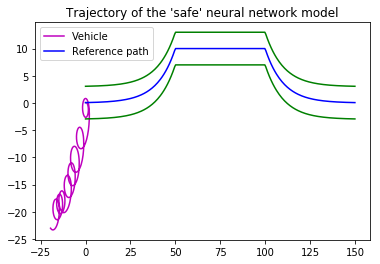

In [36]:
posx = []
posy = []
v = []
theta = []
for i in agent_safe_traj:
    posx.append(i[0][0])
    posy.append(i[0][1])
    v.append(i[0][2])
    theta.append(i[0][3])
    
posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]

_ = plt.title("Trajectory of the \'safe\' neural network model")
_ = plt.plot(posx, posy, "m")
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend(["Vehicle", "Reference path"])
plt.savefig('../../figures/retrained_MPSC_boundary.png') # use relative path to save figure

MPSC Guided Learning
=====================

I have considered two algorithms different from what we have discussed. Instead of filtering the learning-based controller's output during deploying phase, MPC can be used as a filter during training phase. The ultimate goal is that the learning model maintains high performance while avoiding performing unsafe behavior.

The basic set up is that the environment has state space $X$, control space $U$ as well as the known, perhaps nonlinear dynamics $x_{k+1} = f(x_k, u_k)$ where $x_k,u_k$ are current state and action pairs and $x_{k+1}$ is next state. Given a learning based controller $g:X\times \Theta\rightarrow U$ where $\Theta$ is the parameter space, a set of trajectories $\{\tau_i|\tau_i=(x^{(i)}_0, u^{(i)}_0, x^{(i)}_1, u^{(i)}_1, \ldots)\}$ can be obtained by executing $g$. Define the convex set of safe states $\{x|x\in X, UNSAFE(x)\leq 0\}$. Assume that an unsafe controller $g$ is at hand. It can generate at least one trajectory $\tau=(x_0, a_0, x_1, a_1, \ldots x_T, a_T\}$ that reaches an unsafe state.

The algorithm is inspired by the motivation of iLQR, which is to linearize the nonlinear dynamics. Given one trajectory $\tau$, a perturbation can be added to this trajectory, i.e. $x_k\rightarrow x_k + \delta x_k, u_k\rightarrow u_k +\delta u_k$. Then the relationship between $\delta x_k,\delta u_k$ can be obtained as follows.

\begin{eqnarray}
x_{k+1} &=& f(x_k, u_k)\\
x_{k+1} \delta x_{k+1} &=& f(x_k+\delta x_k, u_k + \delta u_k) \\
\delta x_{k+1} &=& f(x_k+\delta, u_k + \delta u_k) - f(x_k, u_k)\\
&\approx& \nabla_x f(x_k, u_k) \delta x_k + \nabla_u f(x_k, u_k) \delta u_k
\end{eqnarray}


<h2>MPSC Guided Policy Search</h2>

Usually, learning-based controller upates its model parameter iteratively during the training phase. We can use MPSC to filter the update. It is already known that $u_k=g(x_k, \theta)$.Then the following equation holds.

\begin{eqnarray}
u_k &=& g(x_k, \theta)\\
u_k + \delta u_k &=& g(x_k + \delta x_k, \theta + \delta \theta)\\
\delta u_k &\approx& \nabla_x g(x_k, \theta) \delta x_k + \nabla_\theta g(x_k, \theta) \delta \theta
\end{eqnarray}

Then interpolate it into the linearized dynmics. 
$$\delta x_{k+1} \approx [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x g(x_k, \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta g(x_k, \theta) \delta \theta$$


At this end, we can determine our MPSC problem as, finding the minimal perturbation on the learning model parameters such that the unsafe trajecotries becomes safe.
\begin{eqnarray}
\underset{\delta\theta}{min}&&||\delta \theta||_2^2 \\
s.t. && \delta x_{k+1} = [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x g(x_k, \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta g(x_k, \theta) \delta \theta\qquad k=0, 1, 2, \ldots, T\\
&& \delta x_0 = 0\\
&& UNSAFE(x_k+\delta x_k)\leq 0\qquad k=0, 1, 2, \ldots, T
\end{eqnarray}

In practice, the solved $\delta \theta$ can be applied to the learning model parameter in every iteration. For instance, when using policy gradient to train a parameterized policy $\pi_\theta: X\rightarrow U$, after every gradient step $\theta_{i-1} \rightarrow \theta_{i}$, the resulted policy $\pi_{\theta_i}$ is used to generated samples for the next optimization. Then MPC formulated above can be implemented to the unsafe trajectories (or multiple trajecotries nearby the unsafe set) to further update the policy parameter $\theta_i\rightarrow \theta_i + \delta \theta_i$. 




<h2>MPSC Guided Imitation Learning</h2>


Following the afformentioned basic setup, we can use MPSC in imitation learning, not to perturb the model parameter, but perturb the cost function based on the intermediate sample trajectories. 
It is known that the original IRL formula is 
$$\underset{c}{min}\ \underset{\pi}{max}\ \mathbb{E}_{\pi_E}[c(x, u)] - \mathbb{E}_{\pi} [c(x, u)]$$

It is common in model-free approaches that whenever a new intermediate policy $\pi_{\theta_i}$ is obtained, a set of corresponding sample trajecotries are generated to compare with the expert trajectories $E$ and update the cost function. For instance, in WGAN formulated GAIL, the update of the discriminator $D: X\times U\times W\rightarrow \mathbb{R}$ with parameter space $W$ is as follows.

$$\underset{w\in W}{min}\ \mathbb{E}_{(x,u)\sim \pi_E}[D(x, u, w)] - \mathbb{E}_{(x,u)\sim\pi_{\theta_i}} [D(x, u, w)]$$




Our first step is to find the minimal perturbation to the unsafe intermediate sample trajectories while maintaining high performance. Given an unsafe trajecotry $\tau=(x_0,u_0, \ldots, x_T, u_T)$, the quadratic cost matrices $Q, R$ standard for iLQR are obtained from the current cost $D(, ,w_{i-1})$. Then the MPSC problem is as follows.
\begin{eqnarray}
\underset{\delta x, \delta u}{min} && \delta x^T Q \delta x + \delta u^T R \delta u \\
s.t. && \delta x_{k+1} \approx \nabla_x f(x_k, u_k) \delta x_k + \nabla_u f(x_k, u_k) \delta u_k \qquad k=0, 1, 2, \ldots, T\\
&& \delta x_0 = 0\\
&& UNSAFE(x_k+\delta x_k)\leq 0\qquad k=0, 1, 2, \ldots, T
\end{eqnarray}

Then a constraint can be added to the optimal cost problem such that the perturbed trajecotry $\tau+\delta\tau$ has lower cost than $\tau$. 

\begin{eqnarray}
\underset{w}{min}& &\mathbb{E}_{(x,u)\sim \pi_E}[D(x, u, w)] - \mathbb{E}_{(x,u)\sim\pi_{\theta_i}} [D(x, u, w_{i-1})]\\
s.t. && \sum_{(x_k+\delta x_k,u_k + \delta u_k)\in \tau+\delta_\tau} D(x_k + \delta x_k,u_k + \delta u_k, w) - \sum_{(x_k,u_k)\in \tau} D(x_k,u_k, w)  \leq 0
\end{eqnarray}

However, since $\tau$ is optimal w.r.t the $\pi_{\theta_i}$ which is optimal w.r.t $D(,, w_{i-1})$, the constraint is mostly unlike to be satisfied under $w_{i-1}$. In other word, the constraint of the problem changes in every iteration and the problem can be infeasible in the beginning of every iteration. To simplify the problem, the constraint can be manipulated as follows.

If function $D$ is convex in terms of $x, u$, then subgradient can be used.
\begin{eqnarray}
&&\sum_{(x_k,u_k)\in \tau} D(x_k,u_k, w) - \sum_{(x_k+\delta x_k,u_k + \delta u_k)\in \tau+\delta_\tau} D(x_k+\delta x_k,u_k + \delta u_k, w)  \geq 0\\
&\Rightarrow& \underset{g^{(k)}_i\in \partial_{(x, u)} D(x_k+\delta x_k, u_k + \delta u_k ,w)}{min}\  \sum_{(x_k,u_k)\in\tau} g^{(k)}_i \cdot [-\delta x_k, - \delta u_k]^T\geq 0 
\end{eqnarray}

However, it can be problemetic to find the minimal subgradient in practice. The second proposal does not require convexity to be guaranteed. In every iteration, we can consider two cases. 

If $\sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1}) \geq 0$, which implies that $w_{i-1}$ is feasible, then directly use barrier or penalty method to update $w_{i-1}$. 

If $\sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1}) \leq 0$, then the constraint can be tightened by borrowing the left hand side of the inequality. Assume that a feasible update $\delta w_{i-1}$ on $w_{i-1}$ enables $w_i = w_{i-1} + \delta w_{i-1}$ to satisfy the tightened constraint as below.

\begin{eqnarray}
&&\sum_{\tau+\delta_\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1} + \delta w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1} + \delta w_{i-1})\leq \sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1}) \\
&&\sum_{\tau+\delta_\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1} + \delta w_{i-1}) - \sum_{\tau + \delta\tau} D(x_k,u_k, w_{i-1}) + \sum_{\tau} D(x_k,u_k, w_{i-1})- \sum_{\tau} D(x_k,u_k, w_{i-1} + \delta w_{i-1})  \leq 0\\
&&\nabla_w \sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1})\delta w_{i-1} - \nabla_w \sum_{\tau} D(x_k,u_k, w_{i-1})\delta  w_{i-1}\leq 0\\
&&\nabla_w \sum_{\tau} [D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - D(x_k,u_k, w_{i-1})]\delta w_{i-1}\leq 0
\end{eqnarray}

As a result, the constraint is linearized. The direction of $\delta w_{i-1}$ can be determined by the gradient of the object while the step length is confined by this linear constraint.
